In [1]:
!nvidia-smi

Fri Mar  1 11:37:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   47C    P8    18W / 170W |    317MiB / 12288MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/bunny/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/msp_podcast/features_4balanced/'

sr = 16000

x_train = np.load(f'{data_dir}msp_podcast.audio16k.train.npy', 
                 allow_pickle=True)
y_train = np.load(f'{data_dir}msp_podcast.label_emotion.train.npy', 
                 allow_pickle=True)
x_test = np.load(f'{data_dir}msp_podcast.audio16k.test.npy', 
                 allow_pickle=True)
y_test = np.load(f'{data_dir}msp_podcast.label_emotion.test.npy', 
                 allow_pickle=True)

In [8]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))
print(len(train_set))
print(len(test_set))

11092
2774


In [9]:
np.unique(y_test)

array(['anger', 'happiness', 'neutral', 'sadness'], dtype=object)

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [12]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [13]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [14]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                  | 0.0011547344110854503/10 [00:01<3:58:39, 1432.12s/it]

Train Epoch: 1 [0/11092 (0%)]	Loss: 1.368098
Mem before-during-after: 1820160 5359841792 44929536


  0%|▎                                                                    | 0.04734411085450344/10 [00:21<1:20:43, 486.64s/it]

Train Epoch: 1 [640/11092 (6%)]	Loss: 1.483197
Mem before-during-after: 44929536 5374453760 44929536


  1%|▋                                                                    | 0.09353348729792137/10 [00:42<1:21:08, 491.48s/it]

Train Epoch: 1 [1280/11092 (12%)]	Loss: 1.383051
Mem before-during-after: 44929536 5374453760 44929536


  1%|▉                                                                    | 0.13972286374133946/10 [01:02<1:20:38, 490.73s/it]

Train Epoch: 1 [1920/11092 (17%)]	Loss: 1.354590
Mem before-during-after: 44929536 5374453760 44929536


  2%|█▎                                                                   | 0.18591224018475794/10 [01:22<1:19:49, 488.07s/it]

Train Epoch: 1 [2560/11092 (23%)]	Loss: 1.455803
Mem before-during-after: 44929536 5374453760 44929536


  2%|█▌                                                                    | 0.2321016166281764/10 [01:42<1:19:47, 490.08s/it]

Train Epoch: 1 [3200/11092 (29%)]	Loss: 1.361169
Mem before-during-after: 44929536 5374453760 44929536


  3%|█▉                                                                    | 0.2782909930715942/10 [02:03<1:19:54, 493.22s/it]

Train Epoch: 1 [3840/11092 (35%)]	Loss: 1.352690
Mem before-during-after: 44929536 5374453760 44929536


  3%|██▎                                                                   | 0.3244803695150116/10 [02:23<1:18:23, 486.15s/it]

Train Epoch: 1 [4480/11092 (40%)]	Loss: 1.356202
Mem before-during-after: 44929536 5374453760 44929536


  4%|██▌                                                                  | 0.37066974595842894/10 [02:43<1:18:23, 488.44s/it]

Train Epoch: 1 [5120/11092 (46%)]	Loss: 1.364823
Mem before-during-after: 44929536 5374453760 44929536


  4%|██▉                                                                   | 0.4168591224018463/10 [03:03<1:18:36, 492.22s/it]

Train Epoch: 1 [5760/11092 (52%)]	Loss: 1.400230
Mem before-during-after: 44929536 5374453760 44929536


  5%|███▏                                                                 | 0.46304849884526367/10 [03:24<1:17:38, 488.51s/it]

Train Epoch: 1 [6400/11092 (58%)]	Loss: 1.374354
Mem before-during-after: 44929536 5374453760 44929536


  5%|███▌                                                                  | 0.5092378752886815/10 [03:44<1:16:53, 486.10s/it]

Train Epoch: 1 [7040/11092 (63%)]	Loss: 1.352844
Mem before-during-after: 44929536 5374453760 44929536


  6%|███▉                                                                  | 0.5554272517321011/10 [04:04<1:16:46, 487.78s/it]

Train Epoch: 1 [7680/11092 (69%)]	Loss: 1.376119
Mem before-during-after: 44929536 5374453760 44929536


  6%|████▏                                                                 | 0.6016166281755206/10 [04:24<1:16:15, 486.82s/it]

Train Epoch: 1 [8320/11092 (75%)]	Loss: 1.405059
Mem before-during-after: 44929536 5374453760 44929536


  6%|████▌                                                                 | 0.6478060046189402/10 [04:44<1:16:00, 487.68s/it]

Train Epoch: 1 [8960/11092 (81%)]	Loss: 1.286414
Mem before-during-after: 44929536 5374453760 44929536


  7%|████▊                                                                 | 0.6939953810623598/10 [05:04<1:15:39, 487.83s/it]

Train Epoch: 1 [9600/11092 (87%)]	Loss: 1.393575
Mem before-during-after: 44929536 5374453760 44929536


  7%|█████▏                                                                | 0.7401847575057794/10 [05:24<1:14:58, 485.86s/it]

Train Epoch: 1 [10240/11092 (92%)]	Loss: 1.272070
Mem before-during-after: 44929536 5374453760 44929536


  8%|█████▌                                                                 | 0.786374133949199/10 [05:44<1:15:06, 489.07s/it]

Train Epoch: 1 [10880/11092 (98%)]	Loss: 1.495882
Mem before-during-after: 44929536 5374453760 44929536


 10%|███████▏                                                                | 1.0000000000000144/10 [06:34<32:59, 219.94s/it]


Test Epoch: 1	Accuracy: 825/2768 (30%)



 10%|███████▏                                                                | 1.0011547344110998/10 [06:35<41:28, 276.54s/it]

Train Epoch: 2 [0/11092 (0%)]	Loss: 1.474456
Mem before-during-after: 44922368 5373775872 44929536


 10%|███████▍                                                               | 1.047344110854515/10 [06:55<1:13:35, 493.19s/it]

Train Epoch: 2 [640/11092 (6%)]	Loss: 1.321641
Mem before-during-after: 44929536 5374453760 44929536


 11%|███████▊                                                                | 1.09353348729793/10 [07:15<1:13:27, 494.85s/it]

Train Epoch: 2 [1280/11092 (12%)]	Loss: 1.331870
Mem before-during-after: 44929536 5374453760 44929536


 11%|███████▉                                                              | 1.1397228637413452/10 [07:36<1:12:19, 489.74s/it]

Train Epoch: 2 [1920/11092 (17%)]	Loss: 1.402936
Mem before-during-after: 44929536 5374453760 44929536


 12%|████████▎                                                             | 1.1859122401847604/10 [07:56<1:11:49, 488.94s/it]

Train Epoch: 2 [2560/11092 (23%)]	Loss: 1.399728
Mem before-during-after: 44929536 5374453760 44929536


 12%|████████▌                                                             | 1.2321016166281755/10 [08:16<1:11:32, 489.60s/it]

Train Epoch: 2 [3200/11092 (29%)]	Loss: 1.226984
Mem before-during-after: 44929536 5374453760 44929536


 13%|████████▉                                                             | 1.2782909930715907/10 [08:36<1:10:52, 487.56s/it]

Train Epoch: 2 [3840/11092 (35%)]	Loss: 1.408377
Mem before-during-after: 44929536 5374453760 44929536


 13%|█████████▎                                                            | 1.3244803695150058/10 [08:56<1:10:21, 486.62s/it]

Train Epoch: 2 [4480/11092 (40%)]	Loss: 1.661599
Mem before-during-after: 44929536 5374453760 44929536


 14%|█████████▋                                                             | 1.370669745958421/10 [09:16<1:10:04, 487.20s/it]

Train Epoch: 2 [5120/11092 (46%)]	Loss: 1.383884
Mem before-during-after: 44929536 5374453760 44929536


 14%|██████████                                                             | 1.416859122401836/10 [09:36<1:09:52, 488.45s/it]

Train Epoch: 2 [5760/11092 (52%)]	Loss: 1.327524
Mem before-during-after: 44929536 5374453760 44929536


 15%|██████████▏                                                           | 1.4630484988452512/10 [09:56<1:09:32, 488.78s/it]

Train Epoch: 2 [6400/11092 (58%)]	Loss: 1.485117
Mem before-during-after: 44929536 5374453760 44929536


 15%|██████████▌                                                           | 1.5092378752886664/10 [10:17<1:08:43, 485.68s/it]

Train Epoch: 2 [7040/11092 (63%)]	Loss: 1.409168
Mem before-during-after: 44929536 5374453760 44929536


 16%|██████████▉                                                           | 1.5554272517320815/10 [10:37<1:08:27, 486.38s/it]

Train Epoch: 2 [7680/11092 (69%)]	Loss: 1.441695
Mem before-during-after: 44929536 5374453760 44929536


 16%|███████████▏                                                          | 1.6016166281754967/10 [10:57<1:08:15, 487.64s/it]

Train Epoch: 2 [8320/11092 (75%)]	Loss: 1.294109
Mem before-during-after: 44929536 5374453760 44929536


 16%|███████████▌                                                          | 1.6478060046189118/10 [11:17<1:08:16, 490.41s/it]

Train Epoch: 2 [8960/11092 (81%)]	Loss: 1.260487
Mem before-during-after: 44929536 5374453760 44929536


 17%|████████████                                                           | 1.693995381062327/10 [11:37<1:08:02, 491.54s/it]

Train Epoch: 2 [9600/11092 (87%)]	Loss: 1.348831
Mem before-during-after: 44929536 5374453760 44929536


 17%|████████████▎                                                          | 1.740184757505742/10 [11:57<1:06:50, 485.48s/it]

Train Epoch: 2 [10240/11092 (92%)]	Loss: 1.320196
Mem before-during-after: 44929536 5374453760 44929536


 18%|████████████▌                                                         | 1.7863741339491572/10 [12:17<1:07:49, 495.44s/it]

Train Epoch: 2 [10880/11092 (98%)]	Loss: 1.477093
Mem before-during-after: 44929536 5374453760 44929536


 20%|██████████████▍                                                         | 1.9999999999999523/10 [13:07<29:25, 220.64s/it]


Test Epoch: 2	Accuracy: 952/2768 (34%)



 20%|██████████████▌                                                          | 2.001154734411038/10 [13:08<36:53, 276.73s/it]

Train Epoch: 3 [0/11092 (0%)]	Loss: 1.357187
Mem before-during-after: 44922368 5373775872 44929536


 20%|██████████████▌                                                        | 2.047344110854453/10 [13:28<1:04:31, 486.88s/it]

Train Epoch: 3 [640/11092 (6%)]	Loss: 1.335763
Mem before-during-after: 44929536 5374453760 44929536


 21%|██████████████▊                                                        | 2.093533487297868/10 [13:48<1:04:04, 486.20s/it]

Train Epoch: 3 [1280/11092 (12%)]	Loss: 1.200207
Mem before-during-after: 44929536 5374453760 44929536


 21%|██████████████▉                                                       | 2.1397228637412833/10 [14:08<1:03:39, 485.93s/it]

Train Epoch: 3 [1920/11092 (17%)]	Loss: 1.419015
Mem before-during-after: 44929536 5374453760 44929536


 22%|███████████████▎                                                      | 2.1859122401846984/10 [14:28<1:03:21, 486.49s/it]

Train Epoch: 3 [2560/11092 (23%)]	Loss: 1.284418
Mem before-during-after: 44929536 5374453760 44929536


 22%|███████████████▌                                                      | 2.2321016166281136/10 [14:48<1:02:44, 484.68s/it]

Train Epoch: 3 [3200/11092 (29%)]	Loss: 1.408623
Mem before-during-after: 44929536 5374453760 44929536


 23%|███████████████▉                                                      | 2.2782909930715287/10 [15:08<1:02:38, 486.68s/it]

Train Epoch: 3 [3840/11092 (35%)]	Loss: 1.381842
Mem before-during-after: 44929536 5374453760 44929536


 23%|████████████████▌                                                      | 2.324480369514944/10 [15:28<1:02:23, 487.72s/it]

Train Epoch: 3 [4480/11092 (40%)]	Loss: 1.360832
Mem before-during-after: 44929536 5374453760 44929536


 24%|████████████████▊                                                      | 2.370669745958359/10 [15:48<1:01:57, 487.25s/it]

Train Epoch: 3 [5120/11092 (46%)]	Loss: 1.322100
Mem before-during-after: 44929536 5374453760 44929536


 24%|█████████████████▏                                                     | 2.416859122401774/10 [16:09<1:01:16, 484.84s/it]

Train Epoch: 3 [5760/11092 (52%)]	Loss: 1.284378
Mem before-during-after: 44929536 5374453760 44929536


 25%|█████████████████▏                                                    | 2.4630484988451893/10 [16:29<1:00:51, 484.49s/it]

Train Epoch: 3 [6400/11092 (58%)]	Loss: 1.296805
Mem before-during-after: 44929536 5374453760 44929536


 25%|█████████████████▌                                                    | 2.5092378752886044/10 [16:49<1:00:54, 487.89s/it]

Train Epoch: 3 [7040/11092 (63%)]	Loss: 1.691004
Mem before-during-after: 44929536 5374453760 44929536


 26%|█████████████████▉                                                    | 2.5554272517320196/10 [17:09<1:00:35, 488.39s/it]

Train Epoch: 3 [7680/11092 (69%)]	Loss: 1.389661
Mem before-during-after: 44929536 5374453760 44929536


 26%|██████████████████▋                                                     | 2.6016166281754347/10 [17:29<59:59, 486.56s/it]

Train Epoch: 3 [8320/11092 (75%)]	Loss: 1.376855
Mem before-during-after: 44929536 5374453760 44929536


 26%|███████████████████▌                                                      | 2.64780600461885/10 [17:49<59:33, 486.08s/it]

Train Epoch: 3 [8960/11092 (81%)]	Loss: 1.228036
Mem before-during-after: 44929536 5374453760 44929536


 27%|███████████████████▋                                                     | 2.693995381062265/10 [18:09<59:17, 486.95s/it]

Train Epoch: 3 [9600/11092 (87%)]	Loss: 1.272462
Mem before-during-after: 44929536 5374453760 44929536


 27%|████████████████████▎                                                     | 2.74018475750568/10 [18:29<59:10, 489.07s/it]

Train Epoch: 3 [10240/11092 (92%)]	Loss: 1.124654
Mem before-during-after: 44929536 5374453760 44929536


 28%|████████████████████                                                    | 2.7863741339490953/10 [18:49<58:36, 487.48s/it]

Train Epoch: 3 [10880/11092 (98%)]	Loss: 1.323314
Mem before-during-after: 44929536 5374453760 44929536


 30%|█████████████████████▌                                                  | 2.9999999999998903/10 [19:39<25:38, 219.85s/it]


Test Epoch: 3	Accuracy: 837/2768 (30%)



 30%|█████████████████████▌                                                  | 3.0011547344109757/10 [19:40<32:12, 276.08s/it]

Train Epoch: 4 [0/11092 (0%)]	Loss: 1.263727
Mem before-during-after: 44922368 5373775872 44929536


 30%|██████████████████████▏                                                  | 3.047344110854391/10 [20:00<55:59, 483.16s/it]

Train Epoch: 4 [640/11092 (6%)]	Loss: 1.436618
Mem before-during-after: 44929536 5374453760 44929536


 31%|██████████████████████▌                                                  | 3.093533487297806/10 [20:20<56:41, 492.52s/it]

Train Epoch: 4 [1280/11092 (12%)]	Loss: 1.299688
Mem before-during-after: 44929536 5374453760 44929536


 31%|██████████████████████▉                                                  | 3.139722863741221/10 [20:40<55:53, 488.83s/it]

Train Epoch: 4 [1920/11092 (17%)]	Loss: 1.326989
Mem before-during-after: 44929536 5374453760 44929536


 32%|██████████████████████▉                                                 | 3.1859122401846363/10 [21:00<55:16, 486.70s/it]

Train Epoch: 4 [2560/11092 (23%)]	Loss: 1.329147
Mem before-during-after: 44929536 5374453760 44929536


 32%|███████████████████████▎                                                | 3.2321016166280514/10 [21:20<55:05, 488.35s/it]

Train Epoch: 4 [3200/11092 (29%)]	Loss: 1.374887
Mem before-during-after: 44929536 5374453760 44929536


 33%|███████████████████████▌                                                | 3.2782909930714665/10 [21:40<54:36, 487.46s/it]

Train Epoch: 4 [3840/11092 (35%)]	Loss: 1.396543
Mem before-during-after: 44929536 5374453760 44929536


 33%|███████████████████████▉                                                | 3.3244803695148817/10 [22:00<53:53, 484.33s/it]

Train Epoch: 4 [4480/11092 (40%)]	Loss: 1.225850
Mem before-during-after: 44929536 5374453760 44929536


 34%|████████████████████████▌                                                | 3.370669745958297/10 [22:20<53:17, 482.26s/it]

Train Epoch: 4 [5120/11092 (46%)]	Loss: 1.381525
Mem before-during-after: 44929536 5374453760 44929536


 34%|████████████████████████▉                                                | 3.416859122401712/10 [22:40<53:08, 484.29s/it]

Train Epoch: 4 [5760/11092 (52%)]	Loss: 1.292000
Mem before-during-after: 44929536 5374453760 44929536


 35%|█████████████████████████▎                                               | 3.463048498845127/10 [23:00<52:51, 485.18s/it]

Train Epoch: 4 [6400/11092 (58%)]	Loss: 1.381125
Mem before-during-after: 44929536 5374453760 44929536


 35%|█████████████████████████▎                                              | 3.5092378752885423/10 [23:20<52:18, 483.55s/it]

Train Epoch: 4 [7040/11092 (63%)]	Loss: 1.268368
Mem before-during-after: 44929536 5374453760 44929536


 36%|█████████████████████████▌                                              | 3.5554272517319574/10 [23:40<52:02, 484.52s/it]

Train Epoch: 4 [7680/11092 (69%)]	Loss: 1.155469
Mem before-during-after: 44929536 5374453760 44929536


 36%|█████████████████████████▉                                              | 3.6016166281753725/10 [24:00<51:19, 481.27s/it]

Train Epoch: 4 [8320/11092 (75%)]	Loss: 1.397397
Mem before-during-after: 44929536 5374453760 44929536


 36%|██████████████████████████▎                                             | 3.6478060046187877/10 [24:20<51:06, 482.76s/it]

Train Epoch: 4 [8960/11092 (81%)]	Loss: 1.349932
Mem before-during-after: 44929536 5374453760 44929536


 37%|██████████████████████████▉                                              | 3.693995381062203/10 [24:40<50:36, 481.52s/it]

Train Epoch: 4 [9600/11092 (87%)]	Loss: 1.390209
Mem before-during-after: 44929536 5374453760 44929536


 37%|███████████████████████████▎                                             | 3.740184757505618/10 [25:00<50:24, 483.16s/it]

Train Epoch: 4 [10240/11092 (92%)]	Loss: 1.262427
Mem before-during-after: 44929536 5374453760 44929536


 38%|███████████████████████████▋                                             | 3.786374133949033/10 [25:20<50:02, 483.23s/it]

Train Epoch: 4 [10880/11092 (98%)]	Loss: 1.495297
Mem before-during-after: 44929536 5374453760 44929536


 40%|█████████████████████████████▏                                           | 3.999999999999828/10 [26:10<21:47, 218.00s/it]


Test Epoch: 4	Accuracy: 927/2768 (33%)



 40%|█████████████████████████████▏                                           | 4.001154734410914/10 [26:10<27:28, 274.88s/it]

Train Epoch: 5 [0/11092 (0%)]	Loss: 1.333846
Mem before-during-after: 44922368 5373775872 44929536


 40%|█████████████████████████████▌                                           | 4.047344110854329/10 [26:30<47:49, 482.07s/it]

Train Epoch: 5 [640/11092 (6%)]	Loss: 1.262712
Mem before-during-after: 44929536 5374453760 44929536


 41%|█████████████████████████████▉                                           | 4.093533487297744/10 [26:50<47:51, 486.11s/it]

Train Epoch: 5 [1280/11092 (12%)]	Loss: 1.199160
Mem before-during-after: 44929536 5374453760 44929536


 41%|██████████████████████████████▏                                          | 4.139722863741159/10 [27:10<47:36, 487.37s/it]

Train Epoch: 5 [1920/11092 (17%)]	Loss: 1.579504
Mem before-during-after: 44929536 5374453760 44929536


 42%|██████████████████████████████▏                                         | 4.1859122401845745/10 [27:30<46:56, 484.40s/it]

Train Epoch: 5 [2560/11092 (23%)]	Loss: 1.342813
Mem before-during-after: 44929536 5374453760 44929536


 42%|███████████████████████████████▎                                          | 4.23210161662799/10 [27:50<46:29, 483.56s/it]

Train Epoch: 5 [3200/11092 (29%)]	Loss: 1.349621
Mem before-during-after: 44929536 5374453760 44929536


 43%|███████████████████████████████▏                                         | 4.278290993071405/10 [28:10<46:28, 487.40s/it]

Train Epoch: 5 [3840/11092 (35%)]	Loss: 1.369460
Mem before-during-after: 44929536 5374453760 44929536


 43%|████████████████████████████████                                          | 4.32448036951482/10 [28:30<45:52, 485.05s/it]

Train Epoch: 5 [4480/11092 (40%)]	Loss: 1.218896
Mem before-during-after: 44929536 5374453760 44929536


 44%|███████████████████████████████▉                                         | 4.370669745958235/10 [28:50<45:21, 483.45s/it]

Train Epoch: 5 [5120/11092 (46%)]	Loss: 1.304155
Mem before-during-after: 44929536 5374453760 44929536


 44%|████████████████████████████████▋                                         | 4.41685912240165/10 [29:10<45:05, 484.64s/it]

Train Epoch: 5 [5760/11092 (52%)]	Loss: 1.243419
Mem before-during-after: 44929536 5374453760 44929536


 45%|████████████████████████████████▌                                        | 4.463048498845065/10 [29:30<44:52, 486.36s/it]

Train Epoch: 5 [6400/11092 (58%)]	Loss: 1.352241
Mem before-during-after: 44929536 5374453760 44929536


 45%|████████████████████████████████▍                                       | 4.5092378752884805/10 [29:50<44:09, 482.53s/it]

Train Epoch: 5 [7040/11092 (63%)]	Loss: 1.368024
Mem before-during-after: 44929536 5374453760 44929536


 46%|█████████████████████████████████▎                                       | 4.555427251731896/10 [30:10<44:07, 486.25s/it]

Train Epoch: 5 [7680/11092 (69%)]	Loss: 1.391614
Mem before-during-after: 44929536 5374453760 44929536


 46%|█████████████████████████████████▌                                       | 4.601616628175311/10 [30:30<43:49, 487.11s/it]

Train Epoch: 5 [8320/11092 (75%)]	Loss: 1.253832
Mem before-during-after: 44929536 5374453760 44929536


 46%|█████████████████████████████████▉                                       | 4.647806004618726/10 [30:50<43:21, 486.12s/it]

Train Epoch: 5 [8960/11092 (81%)]	Loss: 1.370689
Mem before-during-after: 44929536 5374453760 44929536


 47%|██████████████████████████████████▎                                      | 4.693995381062141/10 [31:10<42:59, 486.17s/it]

Train Epoch: 5 [9600/11092 (87%)]	Loss: 1.259601
Mem before-during-after: 44929536 5374453760 44929536


 47%|██████████████████████████████████▌                                      | 4.740184757505556/10 [31:30<42:24, 483.76s/it]

Train Epoch: 5 [10240/11092 (92%)]	Loss: 1.349641
Mem before-during-after: 44929536 5374453760 44929536


 48%|██████████████████████████████████▉                                      | 4.786374133948971/10 [31:50<41:58, 483.07s/it]

Train Epoch: 5 [10880/11092 (98%)]	Loss: 1.387696
Mem before-during-after: 44929536 5374453760 44929536


 50%|████████████████████████████████████▍                                    | 4.999999999999766/10 [32:40<18:14, 218.88s/it]


Test Epoch: 5	Accuracy: 919/2768 (33%)



 50%|████████████████████████████████████▌                                    | 5.001154734410852/10 [32:40<23:01, 276.28s/it]

Train Epoch: 6 [0/11092 (0%)]	Loss: 1.357550
Mem before-during-after: 44922368 5373775872 44929536


 50%|████████████████████████████████████▊                                    | 5.047344110854267/10 [33:00<40:08, 486.40s/it]

Train Epoch: 6 [640/11092 (6%)]	Loss: 1.326925
Mem before-during-after: 44929536 5374453760 44929536


 51%|█████████████████████████████████████▏                                   | 5.093533487297682/10 [33:21<39:37, 484.54s/it]

Train Epoch: 6 [1280/11092 (12%)]	Loss: 1.370792
Mem before-during-after: 44929536 5374453760 44929536


 51%|█████████████████████████████████████▌                                   | 5.139722863741097/10 [33:41<39:17, 485.04s/it]

Train Epoch: 6 [1920/11092 (17%)]	Loss: 1.232067
Mem before-during-after: 44929536 5374453760 44929536


 52%|█████████████████████████████████████▊                                   | 5.185912240184512/10 [34:01<38:47, 483.45s/it]

Train Epoch: 6 [2560/11092 (23%)]	Loss: 1.321751
Mem before-during-after: 44929536 5374453760 44929536


 52%|█████████████████████████████████████▋                                  | 5.2321016166279275/10 [34:20<38:32, 485.07s/it]

Train Epoch: 6 [3200/11092 (29%)]	Loss: 1.221425
Mem before-during-after: 44929536 5374453760 44929536


 53%|██████████████████████████████████████▌                                  | 5.278290993071343/10 [34:40<38:07, 484.49s/it]

Train Epoch: 6 [3840/11092 (35%)]	Loss: 1.466891
Mem before-during-after: 44929536 5374453760 44929536


 53%|██████████████████████████████████████▊                                  | 5.324480369514758/10 [35:01<38:10, 489.95s/it]

Train Epoch: 6 [4480/11092 (40%)]	Loss: 1.513263
Mem before-during-after: 44929536 5374453760 44929536


 53%|██████████████████████████████████████▉                                  | 5.340646651269953/10 [35:08<33:53, 436.50s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f55f05c8be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 53%|██████████████████████████████████████▍                                 | 5.3418013856810385/10 [35:08<30:38, 394.77s/it]


KeyboardInterrupt: 

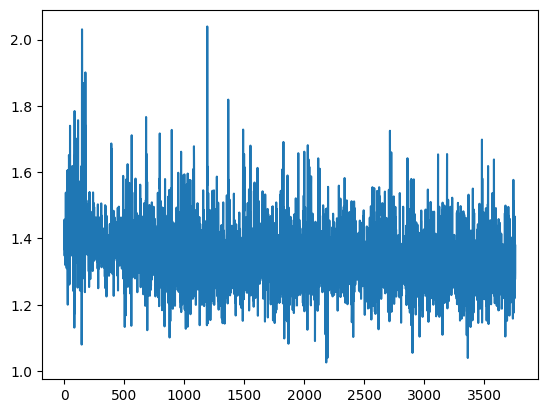

In [15]:
plt.plot(train_losses)

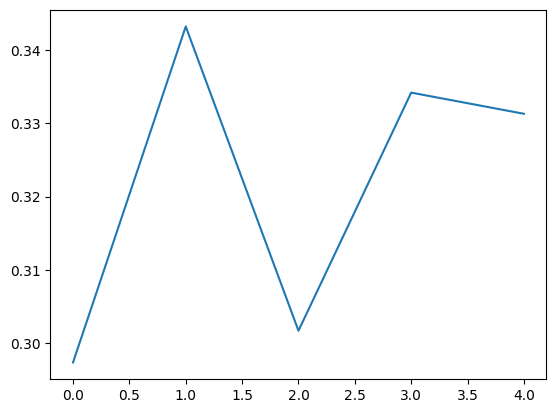

In [16]:
plt.plot(test_accuracy)

In [ ]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [ ]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

In [ ]:
model_path = '../models_msp4/msp4_m13ser_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_msp4/msp4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_msp4/msp4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [27]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0005714285714285715/40 [00:00<8:42:02, 783.06s/it]

Train Epoch: 61 [0/22400 (0%)]	Loss: 0.763395
Mem before-during-after: 63180800 5354140160 66797568


  0%|                                                                    | 0.023428571428571413/40 [00:19<9:54:35, 892.42s/it]

Train Epoch: 61 [640/22400 (3%)]	Loss: 0.710928
Mem before-during-after: 67269632 5355855872 66797568


  0%|                                                                   | 0.046285714285714215/40 [00:37<10:15:15, 923.95s/it]

Train Epoch: 61 [1280/22400 (6%)]	Loss: 0.905505
Mem before-during-after: 66797568 5356815360 67689472


  0%|                                                                    | 0.06914285714285702/40 [00:56<10:59:49, 991.45s/it]

Train Epoch: 61 [1920/22400 (9%)]	Loss: 0.960627
Mem before-during-after: 66821120 5358505984 66797568


  0%|▏                                                                   | 0.09199999999999982/40 [01:14<10:06:04, 911.20s/it]

Train Epoch: 61 [2560/22400 (11%)]	Loss: 1.157454
Mem before-during-after: 67089408 5354586624 67584000


  0%|▏                                                                   | 0.11485714285714262/40 [01:34<10:07:23, 913.71s/it]

Train Epoch: 61 [3200/22400 (14%)]	Loss: 0.764158
Mem before-during-after: 67220480 5355200512 66797568


  0%|▏                                                                  | 0.13771428571428573/40 [01:53<11:37:47, 1050.30s/it]

Train Epoch: 61 [3840/22400 (17%)]	Loss: 0.698820
Mem before-during-after: 67548160 5358666240 66797568


  0%|▎                                                                    | 0.1605714285714291/40 [02:13<10:03:25, 908.79s/it]

Train Epoch: 61 [4480/22400 (20%)]	Loss: 0.629412
Mem before-during-after: 67220480 5355806720 66797568


  0%|▎                                                                    | 0.18342857142857244/40 [02:31<9:48:50, 887.33s/it]

Train Epoch: 61 [5120/22400 (23%)]	Loss: 1.251722
Mem before-during-after: 67689472 5354400256 66797568


  1%|▎                                                                    | 0.2062857142857158/40 [02:50<10:30:21, 950.43s/it]

Train Epoch: 61 [5760/22400 (26%)]	Loss: 0.611650
Mem before-during-after: 67269632 5354428928 66797568


  1%|▍                                                                    | 0.22914285714285915/40 [03:09<9:46:25, 884.71s/it]

Train Epoch: 61 [6400/22400 (29%)]	Loss: 0.764904
Mem before-during-after: 67689472 5354400256 66797568


  1%|▍                                                                   | 0.2520000000000024/40 [03:28<11:11:15, 1013.28s/it]

Train Epoch: 61 [7040/22400 (31%)]	Loss: 0.973335
Mem before-during-after: 67249152 5358780928 67424256


  1%|▍                                                                    | 0.27485714285714463/40 [03:47<9:52:09, 894.38s/it]

Train Epoch: 61 [7680/22400 (34%)]	Loss: 0.973108
Mem before-during-after: 67689472 5354400256 66797568


  1%|▌                                                                   | 0.2977142857142869/40 [04:07<11:09:37, 1011.97s/it]

Train Epoch: 61 [8320/22400 (37%)]	Loss: 0.979937
Mem before-during-after: 66821120 5353978368 67220480


  1%|▌                                                                    | 0.3205714285714291/40 [04:27<10:52:27, 986.58s/it]

Train Epoch: 61 [8960/22400 (40%)]	Loss: 0.477557
Mem before-during-after: 67643392 5356232704 67643392


  1%|▌                                                                   | 0.34342857142857136/40 [04:47<10:51:06, 985.11s/it]

Train Epoch: 61 [9600/22400 (43%)]	Loss: 0.672957
Mem before-during-after: 66821120 5358524416 67595776


  1%|▋                                                                    | 0.3662857142857136/40 [05:05<10:18:23, 936.17s/it]

Train Epoch: 61 [10240/22400 (46%)]	Loss: 1.253085
Mem before-during-after: 67336192 5355854336 67220480


  1%|▋                                                                    | 0.38914285714285585/40 [05:24<9:50:17, 894.12s/it]

Train Epoch: 61 [10880/22400 (49%)]	Loss: 0.545662
Mem before-during-after: 67689472 5354400256 66797568


  1%|▋                                                                    | 0.4119999999999981/40 [05:43<10:59:46, 999.97s/it]

Train Epoch: 61 [11520/22400 (51%)]	Loss: 1.021663
Mem before-during-after: 67120128 5360656384 67553280


  1%|▋                                                                   | 0.43485714285714033/40 [06:03<10:33:53, 961.29s/it]

Train Epoch: 61 [12160/22400 (54%)]	Loss: 0.639138
Mem before-during-after: 66797568 5354423808 67689472


  1%|▊                                                                    | 0.4577142857142826/40 [06:22<10:23:57, 946.78s/it]

Train Epoch: 61 [12800/22400 (57%)]	Loss: 0.600002
Mem before-during-after: 67689472 5355806720 66797568


  1%|▊                                                                    | 0.4805714285714248/40 [06:42<10:20:34, 942.18s/it]

Train Epoch: 61 [13440/22400 (60%)]	Loss: 0.771894
Mem before-during-after: 67244032 5353978368 67244032


  1%|▊                                                                    | 0.5034285714285671/40 [07:01<10:27:04, 952.59s/it]

Train Epoch: 61 [14080/22400 (63%)]	Loss: 1.173591
Mem before-during-after: 66797568 5151324672 66821120


  1%|▉                                                                    | 0.5262857142857094/40 [07:21<10:38:26, 970.44s/it]

Train Epoch: 61 [14720/22400 (66%)]	Loss: 0.851705
Mem before-during-after: 67269632 5354428928 66797568


  1%|▉                                                                    | 0.5491428571428516/40 [07:41<10:10:32, 928.56s/it]

Train Epoch: 61 [15360/22400 (69%)]	Loss: 0.640850
Mem before-during-after: 66797568 5354423808 67689472


  1%|▉                                                                   | 0.5719999999999938/40 [08:00<11:40:06, 1065.40s/it]

Train Epoch: 61 [16000/22400 (71%)]	Loss: 0.591033
Mem before-during-after: 67624960 5358780928 67220480


  1%|█                                                                     | 0.5948571428571361/40 [08:19<9:47:49, 895.06s/it]

Train Epoch: 61 [16640/22400 (74%)]	Loss: 0.817825
Mem before-during-after: 66797568 5354423808 67689472


  2%|█                                                                   | 0.6177142857142783/40 [08:38<11:15:37, 1029.32s/it]

Train Epoch: 61 [17280/22400 (77%)]	Loss: 0.913426
Mem before-during-after: 67220480 5354985984 67220480


  2%|█                                                                    | 0.6405714285714206/40 [08:58<10:29:50, 960.13s/it]

Train Epoch: 61 [17920/22400 (80%)]	Loss: 0.783321
Mem before-during-after: 67220480 5354400256 66797568


  2%|█▏                                                                   | 0.6634285714285628/40 [09:17<10:12:22, 934.05s/it]

Train Epoch: 61 [18560/22400 (83%)]	Loss: 0.970678
Mem before-during-after: 68112384 5353954816 67220480


  2%|█▏                                                                    | 0.6862857142857051/40 [09:36<9:41:41, 887.77s/it]

Train Epoch: 61 [19200/22400 (86%)]	Loss: 0.934748
Mem before-during-after: 66797568 5356327936 67269632


  2%|█▏                                                                    | 0.7091428571428473/40 [09:55<9:48:55, 899.32s/it]

Train Epoch: 61 [19840/22400 (89%)]	Loss: 0.644064
Mem before-during-after: 66797568 5354003968 67269632


  2%|█▎                                                                   | 0.7319999999999895/40 [10:14<10:34:02, 968.79s/it]

Train Epoch: 61 [20480/22400 (91%)]	Loss: 1.005489
Mem before-during-after: 67399680 5354586624 67273728


  2%|█▎                                                                   | 0.7548571428571318/40 [10:33<10:53:15, 998.73s/it]

Train Epoch: 61 [21120/22400 (94%)]	Loss: 1.147915
Mem before-during-after: 66818048 5353548288 66797568


  2%|█▍                                                                     | 0.777714285714274/40 [10:52<9:43:31, 892.63s/it]

Train Epoch: 61 [21760/22400 (97%)]	Loss: 1.084604
Mem before-during-after: 66797568 5356229632 67220480


  2%|█▋                                                                    | 0.9999999999999823/40 [12:40<4:50:30, 446.94s/it]


Test Epoch: 61	Accuracy: 3287/5600 (59%)



  3%|█▊                                                                     | 1.000571428571411/40 [12:41<5:57:15, 549.63s/it]

Train Epoch: 62 [0/22400 (0%)]	Loss: 0.986453
Mem before-during-after: 66790400 5357749760 66797568


  3%|█▊                                                                    | 1.0234285714285576/40 [13:00<9:34:25, 884.27s/it]

Train Epoch: 62 [640/22400 (3%)]	Loss: 1.199775
Mem before-during-after: 67689472 5354400256 66797568


  3%|█▊                                                                    | 1.0462857142857043/40 [13:18<9:33:38, 883.58s/it]

Train Epoch: 62 [1280/22400 (6%)]	Loss: 0.931155
Mem before-during-after: 67689472 5354400256 66797568


  3%|█▊                                                                   | 1.069142857142851/40 [13:38<10:54:48, 1009.18s/it]

Train Epoch: 62 [1920/22400 (9%)]	Loss: 0.741831
Mem before-during-after: 66797568 5145708544 67712000


  3%|█▉                                                                    | 1.0919999999999976/40 [13:57<9:41:29, 896.71s/it]

Train Epoch: 62 [2560/22400 (11%)]	Loss: 0.615273
Mem before-during-after: 66797568 5354423808 67689472


  3%|█▉                                                                   | 1.1148571428571443/40 [14:17<10:00:44, 926.96s/it]

Train Epoch: 62 [3200/22400 (14%)]	Loss: 0.813299
Mem before-during-after: 67365888 5354076672 66797568


  3%|██                                                                     | 1.137714285714291/40 [14:36<9:40:31, 896.28s/it]

Train Epoch: 62 [3840/22400 (17%)]	Loss: 0.819641
Mem before-during-after: 67365888 5354076672 66797568


  3%|██                                                                    | 1.1605714285714377/40 [14:55<9:51:37, 913.95s/it]

Train Epoch: 62 [4480/22400 (20%)]	Loss: 0.772413
Mem before-during-after: 67220480 5354682368 66797568


  3%|██                                                                    | 1.1834285714285844/40 [15:13<9:44:09, 902.94s/it]

Train Epoch: 62 [5120/22400 (23%)]	Loss: 0.805991
Mem before-during-after: 67522560 5354586624 67150848


  3%|██▏                                                                    | 1.206285714285731/40 [15:32<9:42:20, 900.67s/it]

Train Epoch: 62 [5760/22400 (26%)]	Loss: 0.849225
Mem before-during-after: 66797568 5354423808 67689472


  3%|██                                                                   | 1.2291428571428777/40 [15:52<10:39:04, 989.01s/it]

Train Epoch: 62 [6400/22400 (29%)]	Loss: 0.881815
Mem before-during-after: 66797568 5356229632 67220480


  3%|██▏                                                                   | 1.2520000000000244/40 [16:11<9:40:42, 899.20s/it]

Train Epoch: 62 [7040/22400 (31%)]	Loss: 0.495189
Mem before-during-after: 66797568 5321319936 66797568


  3%|██▎                                                                    | 1.274857142857171/40 [16:30<9:34:29, 890.09s/it]

Train Epoch: 62 [7680/22400 (34%)]	Loss: 0.929354
Mem before-during-after: 66797568 5354423808 67689472


  3%|██▎                                                                   | 1.2977142857143178/40 [16:48<9:38:36, 897.01s/it]

Train Epoch: 62 [8320/22400 (37%)]	Loss: 1.055470
Mem before-during-after: 66797568 5354423808 67689472


  3%|██▎                                                                   | 1.3205714285714645/40 [17:08<9:49:47, 914.88s/it]

Train Epoch: 62 [8960/22400 (40%)]	Loss: 0.850953
Mem before-during-after: 67689472 5354400256 66797568


  3%|██▎                                                                   | 1.3434285714286112/40 [17:27<9:38:13, 897.48s/it]

Train Epoch: 62 [9600/22400 (43%)]	Loss: 0.907015
Mem before-during-after: 66797568 5354423808 67689472


  3%|██▍                                                                   | 1.3662857142857578/40 [17:46<9:46:25, 910.74s/it]

Train Epoch: 62 [10240/22400 (46%)]	Loss: 0.721843
Mem before-during-after: 67269632 5353980416 66797568


  3%|██▎                                                                 | 1.3891428571429045/40 [18:06<11:06:25, 1035.60s/it]

Train Epoch: 62 [10880/22400 (49%)]	Loss: 0.806702
Mem before-during-after: 66797568 5360730112 66797568


  4%|██▍                                                                   | 1.4120000000000512/40 [18:25<9:36:55, 897.04s/it]

Train Epoch: 62 [11520/22400 (51%)]	Loss: 0.932321
Mem before-during-after: 67403776 5269401088 68277248


  4%|██▍                                                                  | 1.434857142857198/40 [18:45<10:53:26, 1016.63s/it]

Train Epoch: 62 [12160/22400 (54%)]	Loss: 0.814640
Mem before-during-after: 67846144 5360048640 66797568


  4%|██▌                                                                   | 1.4577142857143446/40 [19:04<9:54:38, 925.70s/it]

Train Epoch: 62 [12800/22400 (57%)]	Loss: 1.056016
Mem before-during-after: 67220480 5354400256 66797568


  4%|██▌                                                                   | 1.4805714285714913/40 [19:22<9:25:43, 881.21s/it]

Train Epoch: 62 [13440/22400 (60%)]	Loss: 0.640416
Mem before-during-after: 67269632 5355855872 66797568


  4%|██▋                                                                   | 1.503428571428638/40 [19:41<10:13:49, 956.69s/it]

Train Epoch: 62 [14080/22400 (63%)]	Loss: 1.474679
Mem before-during-after: 66797568 5356278784 67220480


  4%|██▋                                                                   | 1.5262857142857846/40 [20:01<9:46:18, 914.36s/it]

Train Epoch: 62 [14720/22400 (66%)]	Loss: 1.251261
Mem before-during-after: 67269632 4732764160 67294208


  4%|██▋                                                                 | 1.5491428571429313/40 [20:20<10:43:13, 1003.72s/it]

Train Epoch: 62 [15360/22400 (69%)]	Loss: 0.869077
Mem before-during-after: 67580928 5359517184 66797568


  4%|██▊                                                                    | 1.572000000000078/40 [20:39<9:37:31, 901.72s/it]

Train Epoch: 62 [16000/22400 (71%)]	Loss: 0.844645
Mem before-during-after: 66797568 5353531904 66797568


  4%|██▊                                                                  | 1.5948571428572247/40 [20:58<10:08:31, 950.69s/it]

Train Epoch: 62 [16640/22400 (74%)]	Loss: 1.211564
Mem before-during-after: 67128320 5358780928 67545088


  4%|██▊                                                                   | 1.6177142857143714/40 [21:16<9:24:49, 882.94s/it]

Train Epoch: 62 [17280/22400 (77%)]	Loss: 0.836233
Mem before-during-after: 66797568 5354423808 67689472


  4%|██▉                                                                    | 1.640571428571518/40 [21:35<9:32:53, 896.08s/it]

Train Epoch: 62 [17920/22400 (80%)]	Loss: 0.959838
Mem before-during-after: 66797568 5354423808 67689472


  4%|██▊                                                                  | 1.6634285714286647/40 [21:54<10:13:26, 960.08s/it]

Train Epoch: 62 [18560/22400 (83%)]	Loss: 0.950576
Mem before-during-after: 67346432 5358780928 67326976


  4%|██▉                                                                   | 1.6862857142858114/40 [22:13<9:42:22, 912.02s/it]

Train Epoch: 62 [19200/22400 (86%)]	Loss: 0.676463
Mem before-during-after: 67220480 5354563072 66797568


  4%|███                                                                    | 1.709142857142958/40 [22:33<9:33:26, 898.55s/it]

Train Epoch: 62 [19840/22400 (89%)]	Loss: 0.804535
Mem before-during-after: 66797568 5354423808 67689472


  4%|███                                                                   | 1.7320000000001048/40 [22:51<9:27:48, 890.26s/it]

Train Epoch: 62 [20480/22400 (91%)]	Loss: 0.746389
Mem before-during-after: 67689472 5354400256 66797568


  4%|███                                                                   | 1.7548571428572515/40 [23:10<9:58:24, 938.81s/it]

Train Epoch: 62 [21120/22400 (94%)]	Loss: 0.914679
Mem before-during-after: 66797568 5264764928 67777536


  4%|███                                                                   | 1.7777142857143982/40 [23:30<9:33:51, 900.83s/it]

Train Epoch: 62 [21760/22400 (97%)]	Loss: 0.854728
Mem before-during-after: 67689472 5354400256 66797568


  5%|███▌                                                                  | 2.0000000000001497/40 [25:18<4:42:43, 446.40s/it]


Test Epoch: 62	Accuracy: 3274/5600 (58%)



  5%|███▌                                                                   | 2.000571428571578/40 [25:18<5:47:23, 548.53s/it]

Train Epoch: 63 [0/22400 (0%)]	Loss: 0.968178
Mem before-during-after: 66790400 5357749760 66797568


  5%|███▌                                                                   | 2.023428571428716/40 [25:37<9:46:14, 926.23s/it]

Train Epoch: 63 [640/22400 (3%)]	Loss: 0.987487
Mem before-during-after: 66797568 5355251712 67689472


  5%|███▌                                                                  | 2.0462857142858537/40 [25:56<9:21:39, 887.91s/it]

Train Epoch: 63 [1280/22400 (6%)]	Loss: 0.645158
Mem before-during-after: 66797568 5354423808 67689472


  5%|███▌                                                                  | 2.0691428571429915/40 [26:15<9:48:42, 931.24s/it]

Train Epoch: 63 [1920/22400 (9%)]	Loss: 0.788085
Mem before-during-after: 66797568 5353531904 66797568


  5%|███▌                                                                 | 2.0920000000001293/40 [26:35<10:06:36, 960.12s/it]

Train Epoch: 63 [2560/22400 (11%)]	Loss: 1.198215
Mem before-during-after: 66797568 5186267648 66956288


  5%|███▊                                                                   | 2.114857142857267/40 [26:54<9:42:08, 921.95s/it]

Train Epoch: 63 [3200/22400 (14%)]	Loss: 1.035681
Mem before-during-after: 67689472 4810195456 67248128


  5%|███▊                                                                   | 2.137714285714405/40 [27:13<9:17:45, 883.88s/it]

Train Epoch: 63 [3840/22400 (17%)]	Loss: 0.832296
Mem before-during-after: 66797568 5354423808 67689472


  5%|███▊                                                                  | 2.1605714285715427/40 [27:32<9:29:32, 903.10s/it]

Train Epoch: 63 [4480/22400 (20%)]	Loss: 0.921548
Mem before-during-after: 66797568 5354423808 67689472


  5%|███▊                                                                  | 2.1834285714286805/40 [27:52<9:15:01, 880.62s/it]

Train Epoch: 63 [5120/22400 (23%)]	Loss: 1.105341
Mem before-during-after: 67689472 5354400256 66797568


  6%|███▊                                                                 | 2.2062857142858183/40 [28:11<10:25:29, 993.00s/it]

Train Epoch: 63 [5760/22400 (26%)]	Loss: 0.726749
Mem before-during-after: 67843072 5359171072 67220480


  6%|███▉                                                                   | 2.229142857142956/40 [28:30<9:18:16, 886.84s/it]

Train Epoch: 63 [6400/22400 (29%)]	Loss: 0.823257
Mem before-during-after: 67689472 5354400256 66797568


  6%|███▉                                                                   | 2.252000000000094/40 [28:49<9:28:50, 904.16s/it]

Train Epoch: 63 [7040/22400 (31%)]	Loss: 0.719181
Mem before-during-after: 66797568 5356278784 67220480


  6%|███▉                                                                 | 2.2748571428572317/40 [29:08<10:09:48, 969.87s/it]

Train Epoch: 63 [7680/22400 (34%)]	Loss: 0.524602
Mem before-during-after: 67052544 5354731520 66797568


  6%|███▉                                                                 | 2.2977142857143695/40 [29:27<10:02:15, 958.45s/it]

Train Epoch: 63 [8320/22400 (37%)]	Loss: 1.046843
Mem before-during-after: 67755520 5358524928 66797568


  6%|████                                                                 | 2.3205714285715073/40 [29:47<10:10:19, 971.88s/it]

Train Epoch: 63 [8960/22400 (40%)]	Loss: 0.846934
Mem before-during-after: 67689472 4604249600 67286016


  6%|████                                                                 | 2.343428571428645/40 [30:06<10:31:07, 1005.60s/it]

Train Epoch: 63 [9600/22400 (43%)]	Loss: 1.015353
Mem before-during-after: 66985984 5359571456 67212288


  6%|████                                                                 | 2.366285714285783/40 [30:25<11:04:50, 1059.98s/it]

Train Epoch: 63 [10240/22400 (46%)]	Loss: 1.025981
Mem before-during-after: 68785152 5359131136 66797568


  6%|████▏                                                                 | 2.3891428571429207/40 [30:45<9:24:33, 900.62s/it]

Train Epoch: 63 [10880/22400 (49%)]	Loss: 0.930441
Mem before-during-after: 66797568 5354586624 66797568


  6%|████▏                                                                 | 2.4120000000000585/40 [31:03<9:16:10, 887.79s/it]

Train Epoch: 63 [11520/22400 (51%)]	Loss: 1.215828
Mem before-during-after: 66797568 5354423808 67689472


  6%|████▎                                                                 | 2.4348571428571963/40 [31:22<9:56:59, 953.54s/it]

Train Epoch: 63 [12160/22400 (54%)]	Loss: 0.905218
Mem before-during-after: 66797568 5356229632 67220480


  6%|████▎                                                                  | 2.457714285714334/40 [31:40<9:15:27, 887.74s/it]

Train Epoch: 63 [12800/22400 (57%)]	Loss: 1.000175
Mem before-during-after: 67689472 5354400256 66797568


  6%|████▎                                                                 | 2.480571428571472/40 [31:59<10:24:42, 999.01s/it]

Train Epoch: 63 [13440/22400 (60%)]	Loss: 0.980281
Mem before-during-after: 66797568 5353954816 67220480


  6%|████▍                                                                 | 2.5034285714286098/40 [32:19<9:33:18, 917.37s/it]

Train Epoch: 63 [14080/22400 (63%)]	Loss: 0.796769
Mem before-during-after: 66797568 5353531904 66797568


  6%|████▍                                                                 | 2.5262857142857476/40 [32:38<9:49:39, 944.10s/it]

Train Epoch: 63 [14720/22400 (66%)]	Loss: 0.969463
Mem before-during-after: 67689472 4604879360 67286016


  6%|████▍                                                                 | 2.5491428571428854/40 [32:58<9:31:42, 915.94s/it]

Train Epoch: 63 [15360/22400 (69%)]	Loss: 0.765722
Mem before-during-after: 66797568 5354423808 67689472


  6%|████▌                                                                  | 2.572000000000023/40 [33:17<9:45:02, 937.86s/it]

Train Epoch: 63 [16000/22400 (71%)]	Loss: 1.101513
Mem before-during-after: 66797568 5353531904 66797568


  6%|████▌                                                                  | 2.594857142857161/40 [33:36<9:33:16, 919.56s/it]

Train Epoch: 63 [16640/22400 (74%)]	Loss: 0.852830
Mem before-during-after: 66797568 5150708224 67712000


  7%|████▌                                                                 | 2.6177142857142988/40 [33:56<9:48:11, 944.07s/it]

Train Epoch: 63 [17280/22400 (77%)]	Loss: 0.852082
Mem before-during-after: 67802112 4689307648 67351552


  7%|████▌                                                                 | 2.6405714285714366/40 [34:15<9:14:41, 890.84s/it]

Train Epoch: 63 [17920/22400 (80%)]	Loss: 0.800553
Mem before-during-after: 66797568 5354423808 67689472


  7%|████▋                                                                 | 2.6634285714285744/40 [34:34<9:12:04, 887.19s/it]

Train Epoch: 63 [18560/22400 (83%)]	Loss: 0.753321
Mem before-during-after: 67689472 5354400256 66797568


  7%|████▊                                                                  | 2.686285714285712/40 [34:53<9:41:34, 935.16s/it]

Train Epoch: 63 [19200/22400 (86%)]	Loss: 1.016976
Mem before-during-after: 67220480 5355784704 67220480


  7%|████▉                                                                   | 2.70914285714285/40 [35:12<9:09:15, 883.75s/it]

Train Epoch: 63 [19840/22400 (89%)]	Loss: 1.227874
Mem before-during-after: 67689472 5354400256 66797568


  7%|████▊                                                                 | 2.7319999999999878/40 [35:31<9:25:47, 910.89s/it]

Train Epoch: 63 [20480/22400 (91%)]	Loss: 1.074986
Mem before-during-after: 67220480 5354400256 66797568


  7%|████▊                                                                 | 2.7548571428571256/40 [35:50<9:28:05, 915.17s/it]

Train Epoch: 63 [21120/22400 (94%)]	Loss: 0.791546
Mem before-during-after: 67689472 5354400256 66797568


  7%|████▊                                                                | 2.7777142857142634/40 [36:09<10:00:05, 967.31s/it]

Train Epoch: 63 [21760/22400 (97%)]	Loss: 1.124865
Mem before-during-after: 67220480 5354985984 67220480


  7%|█████▏                                                                | 2.9999999999999285/40 [37:57<4:36:12, 447.89s/it]


Test Epoch: 63	Accuracy: 3287/5600 (59%)



  8%|█████▎                                                                 | 3.000571428571357/40 [37:58<5:38:41, 549.23s/it]

Train Epoch: 64 [0/22400 (0%)]	Loss: 0.978890
Mem before-during-after: 66790400 5357749760 66797568


  8%|█████▎                                                                | 3.0234285714284947/40 [38:17<9:57:49, 970.06s/it]

Train Epoch: 64 [640/22400 (3%)]	Loss: 1.161835
Mem before-during-after: 66797568 5353954816 67220480


  8%|█████▎                                                                | 3.0462857142856326/40 [38:35<9:04:44, 884.47s/it]

Train Epoch: 64 [1280/22400 (6%)]	Loss: 1.003667
Mem before-during-after: 67689472 5354400256 66797568


  8%|█████▎                                                                | 3.0691428571427704/40 [38:54<9:05:14, 885.82s/it]

Train Epoch: 64 [1920/22400 (9%)]	Loss: 0.663440
Mem before-during-after: 66797568 5355251712 67689472


  8%|█████▍                                                                 | 3.091999999999908/40 [39:13<9:22:00, 913.64s/it]

Train Epoch: 64 [2560/22400 (11%)]	Loss: 0.694575
Mem before-during-after: 66797568 5264854528 67805184


  8%|█████▌                                                                 | 3.114857142857046/40 [39:31<9:03:34, 884.23s/it]

Train Epoch: 64 [3200/22400 (14%)]	Loss: 0.657760
Mem before-during-after: 66797568 5354423808 67689472


  8%|█████▎                                                              | 3.1377142857141838/40 [39:51<10:21:12, 1011.12s/it]

Train Epoch: 64 [3840/22400 (17%)]	Loss: 0.868681
Mem before-during-after: 66797568 5360448000 66797568


  8%|█████▌                                                                | 3.1605714285713216/40 [40:10<9:13:11, 900.97s/it]

Train Epoch: 64 [4480/22400 (20%)]	Loss: 0.757470
Mem before-during-after: 67220480 5355855872 66797568


  8%|█████▌                                                                | 3.1834285714284594/40 [40:29<9:09:07, 894.91s/it]

Train Epoch: 64 [5120/22400 (23%)]	Loss: 0.972468
Mem before-during-after: 66797568 5354423808 67689472


  8%|█████▋                                                                 | 3.206285714285597/40 [40:47<9:00:37, 881.60s/it]

Train Epoch: 64 [5760/22400 (26%)]	Loss: 0.638160
Mem before-during-after: 66797568 4310924800 66797568


  8%|█████▋                                                                 | 3.229142857142735/40 [41:06<9:05:14, 889.67s/it]

Train Epoch: 64 [6400/22400 (29%)]	Loss: 0.920783
Mem before-during-after: 66797568 5354872320 67269632


  8%|█████▌                                                               | 3.2519999999998728/40 [41:26<10:06:10, 989.73s/it]

Train Epoch: 64 [7040/22400 (31%)]	Loss: 0.706648
Mem before-during-after: 66821120 5355385344 67220480


  8%|█████▋                                                                | 3.2748571428570106/40 [41:44<9:00:48, 883.55s/it]

Train Epoch: 64 [7680/22400 (34%)]	Loss: 0.989123
Mem before-during-after: 67689472 5354400256 66797568


  8%|█████▊                                                                | 3.2977142857141484/40 [42:04<9:57:11, 976.27s/it]

Train Epoch: 64 [8320/22400 (37%)]	Loss: 1.186380
Mem before-during-after: 66797568 5068597760 67646464


  8%|█████▉                                                                 | 3.320571428571286/40 [42:23<9:07:19, 895.31s/it]

Train Epoch: 64 [8960/22400 (40%)]	Loss: 1.149979
Mem before-during-after: 67689472 5354400256 66797568


  8%|█████▊                                                               | 3.343428571428424/40 [42:43<10:16:30, 1009.10s/it]

Train Epoch: 64 [9600/22400 (43%)]	Loss: 1.233298
Mem before-during-after: 67621888 5360330752 67220480


  8%|█████▉                                                                 | 3.366285714285562/40 [43:01<9:01:51, 887.46s/it]

Train Epoch: 64 [10240/22400 (46%)]	Loss: 0.651062
Mem before-during-after: 67489792 5354586624 67183616


  8%|█████▉                                                                | 3.3891428571426996/40 [43:20<9:31:05, 935.93s/it]

Train Epoch: 64 [10880/22400 (49%)]	Loss: 1.270106
Mem before-during-after: 66797568 4899975168 66797568


  9%|█████▉                                                                | 3.4119999999998374/40 [43:40<9:54:27, 974.85s/it]

Train Epoch: 64 [11520/22400 (51%)]	Loss: 0.846168
Mem before-during-after: 67220480 5355806720 66797568


  9%|██████                                                                 | 3.434857142856975/40 [43:59<9:46:47, 962.88s/it]

Train Epoch: 64 [12160/22400 (54%)]	Loss: 1.277905
Mem before-during-after: 66797568 5354423808 67689472


  9%|██████▏                                                                | 3.457714285714113/40 [44:18<9:32:39, 940.26s/it]

Train Epoch: 64 [12800/22400 (57%)]	Loss: 0.937819
Mem before-during-after: 67689472 5354400256 66797568


  9%|██████                                                               | 3.480571428571251/40 [44:38<10:58:04, 1081.19s/it]

Train Epoch: 64 [13440/22400 (60%)]	Loss: 0.730614
Mem before-during-after: 66797568 5360330752 67220480


  9%|██████▏                                                               | 3.5034285714283886/40 [44:57<9:06:07, 897.82s/it]

Train Epoch: 64 [14080/22400 (63%)]	Loss: 1.005335
Mem before-during-after: 66797568 5355251712 67689472


  9%|██████▏                                                               | 3.5262857142855264/40 [45:17<9:29:25, 936.71s/it]

Train Epoch: 64 [14720/22400 (66%)]	Loss: 0.662211
Mem before-during-after: 66797568 4856662528 66797568


  9%|██████▎                                                                | 3.549142857142664/40 [45:35<9:08:01, 902.09s/it]

Train Epoch: 64 [15360/22400 (69%)]	Loss: 0.994544
Mem before-during-after: 67220480 5354400256 66797568


  9%|██████▎                                                                | 3.571999999999802/40 [45:55<9:20:46, 923.65s/it]

Train Epoch: 64 [16000/22400 (71%)]	Loss: 0.894683
Mem before-during-after: 66797568 4978712576 66797568


  9%|██████▍                                                                 | 3.59485714285694/40 [46:15<8:58:58, 888.30s/it]

Train Epoch: 64 [16640/22400 (74%)]	Loss: 0.877927
Mem before-during-after: 66797568 5354423808 67689472


  9%|██████▎                                                               | 3.6177142857140776/40 [46:33<8:59:29, 889.71s/it]

Train Epoch: 64 [17280/22400 (77%)]	Loss: 0.819800
Mem before-during-after: 66797568 5354423808 67689472


  9%|██████▎                                                               | 3.6405714285712154/40 [46:53<9:02:01, 894.45s/it]

Train Epoch: 64 [17920/22400 (80%)]	Loss: 1.196509
Mem before-during-after: 66797568 5354423808 67689472


  9%|██████▌                                                                | 3.663428571428353/40 [47:12<9:01:09, 893.57s/it]

Train Epoch: 64 [18560/22400 (83%)]	Loss: 1.192866
Mem before-during-after: 66797568 5354003968 67269632


  9%|██████▍                                                               | 3.686285714285491/40 [47:31<10:00:38, 992.41s/it]

Train Epoch: 64 [19200/22400 (86%)]	Loss: 0.753614
Mem before-during-after: 66797568 5359649280 66797568


  9%|██████▍                                                              | 3.709142857142629/40 [47:50<10:15:19, 1017.32s/it]

Train Epoch: 64 [19840/22400 (89%)]	Loss: 0.612157
Mem before-during-after: 66797568 5359649280 66797568


  9%|██████▌                                                               | 3.7319999999997666/40 [48:08<9:45:35, 968.76s/it]

Train Epoch: 64 [20480/22400 (91%)]	Loss: 0.991105
Mem before-during-after: 66797568 5360406528 66797568


  9%|██████▍                                                             | 3.7548571428569044/40 [48:29<11:17:10, 1120.99s/it]

Train Epoch: 64 [21120/22400 (94%)]	Loss: 0.704233
Mem before-during-after: 66891776 5359579648 67220480


  9%|██████▋                                                                | 3.777714285714042/40 [48:48<9:17:45, 923.89s/it]

Train Epoch: 64 [21760/22400 (97%)]	Loss: 0.872604
Mem before-during-after: 66797568 5354423808 67689472


 10%|██████▉                                                               | 3.9999999999997073/40 [50:36<4:28:34, 447.64s/it]


Test Epoch: 64	Accuracy: 3285/5600 (59%)



 10%|███████                                                                | 4.000571428571136/40 [50:36<5:29:30, 549.18s/it]

Train Epoch: 65 [0/22400 (0%)]	Loss: 0.880288
Mem before-during-after: 66790400 5357749760 66797568


 10%|███████▏                                                               | 4.023428571428291/40 [50:56<9:58:48, 998.68s/it]

Train Epoch: 65 [640/22400 (3%)]	Loss: 0.727580
Mem before-during-after: 67068928 5358780928 67604480


 10%|███████▏                                                               | 4.046285714285447/40 [51:14<8:53:44, 890.72s/it]

Train Epoch: 65 [1280/22400 (6%)]	Loss: 0.942382
Mem before-during-after: 66797568 5354423808 67689472


 10%|███████                                                               | 4.0691428571426025/40 [51:34<9:00:18, 902.23s/it]

Train Epoch: 65 [1920/22400 (9%)]	Loss: 0.628047
Mem before-during-after: 67689472 5354400256 66797568


 10%|███████▎                                                               | 4.091999999999758/40 [51:52<9:13:39, 925.12s/it]

Train Epoch: 65 [2560/22400 (11%)]	Loss: 0.772582
Mem before-during-after: 67220480 5355200512 66797568


 10%|███████▎                                                               | 4.114857142856914/40 [52:12<9:15:34, 928.91s/it]

Train Epoch: 65 [3200/22400 (14%)]	Loss: 0.702519
Mem before-during-after: 67643392 5353954816 67220480


 10%|███████▎                                                               | 4.137714285714069/40 [52:30<8:52:32, 890.98s/it]

Train Epoch: 65 [3840/22400 (17%)]	Loss: 1.012655
Mem before-during-after: 67340288 5354586624 67333120


 10%|███████▍                                                               | 4.160571428571225/40 [52:49<9:00:00, 904.05s/it]

Train Epoch: 65 [4480/22400 (20%)]	Loss: 0.728429
Mem before-during-after: 67689472 5354400256 66797568


 10%|███████▌                                                                | 4.18342857142838/40 [53:08<9:44:47, 979.65s/it]

Train Epoch: 65 [5120/22400 (23%)]	Loss: 0.854578
Mem before-during-after: 67220480 5354682368 66797568


 11%|███████▍                                                               | 4.206285714285536/40 [53:27<8:52:44, 893.02s/it]

Train Epoch: 65 [5760/22400 (26%)]	Loss: 1.258240
Mem before-during-after: 66797568 5354359808 66797568


 11%|███████▍                                                              | 4.2291428571426914/40 [53:46<8:56:02, 899.14s/it]

Train Epoch: 65 [6400/22400 (29%)]	Loss: 0.518704
Mem before-during-after: 66797568 5355251712 67689472


 11%|███████▌                                                               | 4.251999999999847/40 [54:05<9:00:23, 907.01s/it]

Train Epoch: 65 [7040/22400 (31%)]	Loss: 0.765578
Mem before-during-after: 66797568 5353531904 66797568


 11%|███████▌                                                               | 4.274857142857003/40 [54:24<9:52:36, 995.27s/it]

Train Epoch: 65 [7680/22400 (34%)]	Loss: 0.614773
Mem before-during-after: 66895872 5359788544 67777536


 11%|███████▋                                                               | 4.297714285714158/40 [54:43<9:14:25, 931.75s/it]

Train Epoch: 65 [8320/22400 (37%)]	Loss: 1.071089
Mem before-during-after: 66797568 5063107584 66797568


 11%|███████▋                                                               | 4.320571428571314/40 [55:02<8:45:05, 883.03s/it]

Train Epoch: 65 [8960/22400 (40%)]	Loss: 1.124021
Mem before-during-after: 66797568 5355251712 67689472


 11%|███████▋                                                               | 4.343428571428469/40 [55:21<9:21:28, 944.80s/it]

Train Epoch: 65 [9600/22400 (43%)]	Loss: 1.362144
Mem before-during-after: 66797568 5358125568 66797568


 11%|███████▊                                                               | 4.366285714285625/40 [55:39<8:47:12, 887.71s/it]

Train Epoch: 65 [10240/22400 (46%)]	Loss: 1.090263
Mem before-during-after: 67269632 5355855872 66797568


 11%|███████▉                                                                | 4.38914285714278/40 [55:59<9:26:45, 954.93s/it]

Train Epoch: 65 [10880/22400 (49%)]	Loss: 0.753675
Mem before-during-after: 66797568 5359731712 67220480


 11%|███████▊                                                               | 4.411999999999936/40 [56:18<9:33:42, 967.26s/it]

Train Epoch: 65 [11520/22400 (51%)]	Loss: 1.065074
Mem before-during-after: 67209216 5354586624 67464192


 11%|███████▊                                                              | 4.4348571428570915/40 [56:36<8:48:52, 892.23s/it]

Train Epoch: 65 [12160/22400 (54%)]	Loss: 0.841326
Mem before-during-after: 67689472 5354400256 66797568


 11%|███████▉                                                               | 4.457714285714247/40 [56:55<9:22:51, 950.18s/it]

Train Epoch: 65 [12800/22400 (57%)]	Loss: 1.018544
Mem before-during-after: 67075072 5359180288 67220480


 11%|███████▉                                                               | 4.480571428571403/40 [57:14<9:00:00, 912.20s/it]

Train Epoch: 65 [13440/22400 (60%)]	Loss: 0.961296
Mem before-during-after: 67220480 5354400256 66797568


 11%|███████▉                                                               | 4.503428571428558/40 [57:34<9:17:45, 942.79s/it]

Train Epoch: 65 [14080/22400 (63%)]	Loss: 0.812359
Mem before-during-after: 67845120 5354586624 66828288


 11%|████████                                                               | 4.526285714285714/40 [57:53<9:05:21, 922.42s/it]

Train Epoch: 65 [14720/22400 (66%)]	Loss: 0.873851
Mem before-during-after: 66797568 5354423808 67689472


 11%|████████                                                               | 4.549142857142869/40 [58:13<8:58:28, 911.37s/it]

Train Epoch: 65 [15360/22400 (69%)]	Loss: 0.598927
Mem before-during-after: 66797568 5354823168 67220480


 11%|████████                                                              | 4.572000000000025/40 [58:32<9:58:54, 1014.31s/it]

Train Epoch: 65 [16000/22400 (71%)]	Loss: 0.689807
Mem before-during-after: 67104768 5358780928 67740672


 11%|████████                                                              | 4.5948571428571805/40 [58:51<8:44:01, 888.04s/it]

Train Epoch: 65 [16640/22400 (74%)]	Loss: 0.796258
Mem before-during-after: 66797568 5354872320 67269632


 12%|████████▏                                                              | 4.617714285714336/40 [59:09<8:44:00, 888.60s/it]

Train Epoch: 65 [17280/22400 (77%)]	Loss: 1.057575
Mem before-during-after: 67689472 5354400256 66797568


 12%|████████▏                                                              | 4.640571428571492/40 [59:28<8:45:39, 891.97s/it]

Train Epoch: 65 [17920/22400 (80%)]	Loss: 1.419627
Mem before-during-after: 66797568 5354423808 67689472


 12%|████████▎                                                              | 4.663428571428647/40 [59:47<9:03:07, 922.19s/it]

Train Epoch: 65 [18560/22400 (83%)]	Loss: 0.966144
Mem before-during-after: 66797568 5354823168 67220480


 12%|████████                                                             | 4.686285714285803/40 [1:00:06<8:42:44, 888.16s/it]

Train Epoch: 65 [19200/22400 (86%)]	Loss: 0.830050
Mem before-during-after: 66797568 5354872320 67269632


 12%|████████                                                             | 4.709142857142958/40 [1:00:25<9:08:29, 932.52s/it]

Train Epoch: 65 [19840/22400 (89%)]	Loss: 0.857533
Mem before-during-after: 67220480 5354400256 66797568


 12%|████████▏                                                            | 4.732000000000114/40 [1:00:44<9:36:42, 981.12s/it]

Train Epoch: 65 [20480/22400 (91%)]	Loss: 0.599543
Mem before-during-after: 66797568 5358757376 66797568


 12%|████████                                                            | 4.7548571428572695/40 [1:01:04<9:35:58, 980.53s/it]

Train Epoch: 65 [21120/22400 (94%)]	Loss: 1.094741
Mem before-during-after: 67220480 5353531904 66797568


 12%|████████▏                                                            | 4.777714285714425/40 [1:01:24<8:51:12, 904.90s/it]

Train Epoch: 65 [21760/22400 (97%)]	Loss: 0.666499
Mem before-during-after: 67689472 5354400256 66797568


 13%|████████▋                                                            | 5.000000000000263/40 [1:03:12<4:21:44, 448.69s/it]


Test Epoch: 65	Accuracy: 3299/5600 (59%)



 13%|████████▋                                                            | 5.000571428571692/40 [1:03:12<5:15:20, 540.59s/it]

Train Epoch: 66 [0/22400 (0%)]	Loss: 1.270011
Mem before-during-after: 66790400 4814467072 66797568


 13%|████████▋                                                            | 5.023428571428847/40 [1:03:31<9:26:03, 971.04s/it]

Train Epoch: 66 [640/22400 (3%)]	Loss: 0.949369
Mem before-during-after: 66797568 5353954816 67220480


 13%|████████▋                                                            | 5.046285714286003/40 [1:03:50<8:39:09, 891.17s/it]

Train Epoch: 66 [1280/22400 (6%)]	Loss: 1.090513
Mem before-during-after: 66797568 5263894016 66797568


 13%|████████▌                                                           | 5.0691428571431585/40 [1:04:09<9:08:36, 942.33s/it]

Train Epoch: 66 [1920/22400 (9%)]	Loss: 1.731779
Mem before-during-after: 66797568 4773039616 66797568


 13%|████████▊                                                            | 5.092000000000314/40 [1:04:28<8:53:48, 917.50s/it]

Train Epoch: 66 [2560/22400 (11%)]	Loss: 1.014239
Mem before-during-after: 67689472 4732658688 67304448


 13%|████████▉                                                             | 5.11485714285747/40 [1:04:47<8:50:02, 911.63s/it]

Train Epoch: 66 [3200/22400 (14%)]	Loss: 0.670078
Mem before-during-after: 66821120 5354443776 66821120


 13%|████████▊                                                            | 5.137714285714625/40 [1:05:07<9:08:32, 944.08s/it]

Train Epoch: 66 [3840/22400 (17%)]	Loss: 0.989470
Mem before-during-after: 66797568 5354872320 67269632


 13%|████████▉                                                            | 5.160571428571781/40 [1:05:27<8:42:57, 900.64s/it]

Train Epoch: 66 [4480/22400 (20%)]	Loss: 0.861480
Mem before-during-after: 67220480 5320843264 66846720


 13%|████████▉                                                            | 5.183428571428936/40 [1:05:46<9:01:09, 932.59s/it]

Train Epoch: 66 [5120/22400 (23%)]	Loss: 0.883194
Mem before-during-after: 67220480 5355151360 66797568


 13%|████████▉                                                            | 5.206285714286092/40 [1:06:05<8:48:24, 911.21s/it]

Train Epoch: 66 [5760/22400 (26%)]	Loss: 0.859933
Mem before-during-after: 66821120 5353531904 66797568


 13%|████████▉                                                           | 5.2291428571432474/40 [1:06:24<8:59:42, 931.32s/it]

Train Epoch: 66 [6400/22400 (29%)]	Loss: 0.749708
Mem before-during-after: 66808832 5353531904 66797568


 13%|█████████                                                            | 5.252000000000403/40 [1:06:43<8:53:58, 922.03s/it]

Train Epoch: 66 [7040/22400 (31%)]	Loss: 1.012133
Mem before-during-after: 66797568 5263894016 66797568


 13%|█████████                                                            | 5.274857142857559/40 [1:07:02<8:43:07, 903.89s/it]

Train Epoch: 66 [7680/22400 (34%)]	Loss: 1.122906
Mem before-during-after: 67689472 5354400256 66797568


 13%|█████████▏                                                           | 5.297714285714714/40 [1:07:21<9:16:24, 962.03s/it]

Train Epoch: 66 [8320/22400 (37%)]	Loss: 0.657540
Mem before-during-after: 66797568 5353954816 67220480


 13%|█████████▎                                                            | 5.32057142857187/40 [1:07:40<8:38:05, 896.38s/it]

Train Epoch: 66 [8960/22400 (40%)]	Loss: 0.885607
Mem before-during-after: 66797568 5354423808 67689472


 13%|█████████                                                           | 5.343428571429025/40 [1:08:00<9:41:39, 1007.02s/it]

Train Epoch: 66 [9600/22400 (43%)]	Loss: 1.116699
Mem before-during-after: 67220480 5358594560 66797568


 13%|█████████▎                                                           | 5.366285714286181/40 [1:08:19<9:02:15, 939.42s/it]

Train Epoch: 66 [10240/22400 (46%)]	Loss: 0.731910
Mem before-during-after: 66804736 5353531904 66797568


 13%|█████████▎                                                           | 5.389142857143336/40 [1:08:38<8:41:23, 903.87s/it]

Train Epoch: 66 [10880/22400 (49%)]	Loss: 1.001938
Mem before-during-after: 66797568 5354423808 67689472


 14%|█████████▎                                                           | 5.412000000000492/40 [1:08:58<9:18:05, 968.12s/it]

Train Epoch: 66 [11520/22400 (51%)]	Loss: 0.741867
Mem before-during-after: 66823168 5104670720 67679232


 14%|█████████▏                                                          | 5.4348571428576475/40 [1:09:18<8:39:01, 900.95s/it]

Train Epoch: 66 [12160/22400 (54%)]	Loss: 0.683385
Mem before-during-after: 67269632 5355855872 66797568


 14%|█████████▍                                                           | 5.457714285714803/40 [1:09:37<8:45:49, 913.37s/it]

Train Epoch: 66 [12800/22400 (57%)]	Loss: 0.655883
Mem before-during-after: 67220480 5354985984 67220480


 14%|█████████▍                                                           | 5.480571428571959/40 [1:09:57<9:02:13, 942.46s/it]

Train Epoch: 66 [13440/22400 (60%)]	Loss: 0.599374
Mem before-during-after: 66797568 5353531904 66797568


 14%|█████████▍                                                           | 5.503428571429114/40 [1:10:16<8:52:31, 926.23s/it]

Train Epoch: 66 [14080/22400 (63%)]	Loss: 0.813982
Mem before-during-after: 67689472 4810893824 67248128


 14%|█████████▋                                                            | 5.52628571428627/40 [1:10:35<8:44:52, 913.52s/it]

Train Epoch: 66 [14720/22400 (66%)]	Loss: 1.101609
Mem before-during-after: 66797568 5354823168 67220480


 14%|█████████▌                                                           | 5.549142857143425/40 [1:10:54<8:52:28, 927.35s/it]

Train Epoch: 66 [15360/22400 (69%)]	Loss: 0.866476
Mem before-during-after: 66797568 5354423808 67689472


 14%|█████████▌                                                           | 5.572000000000581/40 [1:11:12<8:37:42, 902.26s/it]

Train Epoch: 66 [16000/22400 (71%)]	Loss: 1.646003
Mem before-during-after: 66797568 4645508096 66797568


 14%|█████████▌                                                          | 5.5948571428577365/40 [1:11:32<9:02:28, 946.03s/it]

Train Epoch: 66 [16640/22400 (74%)]	Loss: 0.929498
Mem before-during-after: 67369984 5355854336 67220480


 14%|█████████▋                                                           | 5.617714285714892/40 [1:11:51<8:30:34, 891.00s/it]

Train Epoch: 66 [17280/22400 (77%)]	Loss: 1.009876
Mem before-during-after: 66797568 5354872320 67269632


 14%|█████████▋                                                           | 5.640571428572048/40 [1:12:10<8:28:21, 887.71s/it]

Train Epoch: 66 [17920/22400 (80%)]	Loss: 0.998063
Mem before-during-after: 67689472 5354400256 66797568


 14%|█████████▊                                                           | 5.663428571429203/40 [1:12:30<8:42:44, 913.43s/it]

Train Epoch: 66 [18560/22400 (83%)]	Loss: 1.488457
Mem before-during-after: 67689472 4352175104 67089408


 14%|█████████▊                                                           | 5.686285714286359/40 [1:12:48<8:42:50, 914.22s/it]

Train Epoch: 66 [19200/22400 (86%)]	Loss: 0.813398
Mem before-during-after: 67269632 5355855872 66797568


 14%|█████████▊                                                           | 5.709142857143514/40 [1:13:08<8:32:19, 896.43s/it]

Train Epoch: 66 [19840/22400 (89%)]	Loss: 1.008831
Mem before-during-after: 66797568 5353531904 66797568


 14%|██████████                                                            | 5.73200000000067/40 [1:13:26<8:28:26, 890.24s/it]

Train Epoch: 66 [20480/22400 (91%)]	Loss: 1.040325
Mem before-during-after: 67689472 5354400256 66797568


 14%|█████████▊                                                          | 5.7548571428578255/40 [1:13:46<8:37:20, 906.43s/it]

Train Epoch: 66 [21120/22400 (94%)]	Loss: 0.791281
Mem before-during-after: 67828736 5353579008 66844672


 14%|█████████▉                                                           | 5.777714285714981/40 [1:14:05<9:07:08, 959.27s/it]

Train Epoch: 66 [21760/22400 (97%)]	Loss: 1.303406
Mem before-during-after: 67220480 5354400256 66797568


 15%|██████████▎                                                          | 6.000000000000819/40 [1:15:53<4:12:45, 446.04s/it]


Test Epoch: 66	Accuracy: 3320/5600 (59%)



 15%|██████████▎                                                          | 6.000571428572248/40 [1:15:54<5:10:19, 547.63s/it]

Train Epoch: 67 [0/22400 (0%)]	Loss: 0.996776
Mem before-during-after: 66790400 5357749760 66797568


 15%|██████████▍                                                          | 6.023428571429403/40 [1:16:13<8:28:52, 898.63s/it]

Train Epoch: 67 [640/22400 (3%)]	Loss: 0.777923
Mem before-during-after: 67775488 5355901440 67789824


 15%|██████████▍                                                          | 6.046285714286559/40 [1:16:32<9:05:21, 963.70s/it]

Train Epoch: 67 [1280/22400 (6%)]	Loss: 1.178168
Mem before-during-after: 66797568 5268502528 66797568


 15%|██████████▎                                                         | 6.0691428571437145/40 [1:16:51<8:30:49, 903.29s/it]

Train Epoch: 67 [1920/22400 (9%)]	Loss: 0.822731
Mem before-during-after: 67755008 5353531904 66797568


 15%|██████████▋                                                           | 6.09200000000087/40 [1:17:10<8:40:38, 921.26s/it]

Train Epoch: 67 [2560/22400 (11%)]	Loss: 0.763768
Mem before-during-after: 67689472 5354400256 66797568


 15%|██████████▌                                                          | 6.114857142858026/40 [1:17:30<9:03:25, 962.24s/it]

Train Epoch: 67 [3200/22400 (14%)]	Loss: 1.233598
Mem before-during-after: 67689472 5354400256 66797568


 15%|██████████▌                                                          | 6.137714285715181/40 [1:17:49<8:49:54, 938.93s/it]

Train Epoch: 67 [3840/22400 (17%)]	Loss: 0.967539
Mem before-during-after: 67689472 5062904320 67049472


 15%|██████████▋                                                          | 6.160571428572337/40 [1:18:08<9:18:48, 990.81s/it]

Train Epoch: 67 [4480/22400 (20%)]	Loss: 0.929206
Mem before-during-after: 67220480 5354354176 67220480


 15%|██████████▋                                                          | 6.183428571429492/40 [1:18:28<8:35:16, 914.23s/it]

Train Epoch: 67 [5120/22400 (23%)]	Loss: 0.901840
Mem before-during-after: 66797568 5354423808 67689472


 16%|██████████▋                                                          | 6.206285714286648/40 [1:18:47<8:50:06, 941.21s/it]

Train Epoch: 67 [5760/22400 (26%)]	Loss: 0.742585
Mem before-during-after: 66797568 5355623424 67220480


 16%|██████████▌                                                         | 6.2291428571438034/40 [1:19:07<8:46:23, 935.23s/it]

Train Epoch: 67 [6400/22400 (29%)]	Loss: 1.187570
Mem before-during-after: 66797568 5355105280 67220480


 16%|██████████▊                                                          | 6.252000000000959/40 [1:19:26<8:20:04, 889.08s/it]

Train Epoch: 67 [7040/22400 (31%)]	Loss: 1.049761
Mem before-during-after: 66797568 5354423808 67689472


 16%|██████████▊                                                          | 6.274857142858115/40 [1:19:44<8:34:03, 914.56s/it]

Train Epoch: 67 [7680/22400 (34%)]	Loss: 0.368220
Mem before-during-after: 66797568 5354423808 67689472


 16%|███████████                                                           | 6.29771428571527/40 [1:20:03<8:23:27, 896.30s/it]

Train Epoch: 67 [8320/22400 (37%)]	Loss: 0.731152
Mem before-during-after: 66797568 5354423808 67689472


 16%|██████████▉                                                          | 6.320571428572426/40 [1:20:22<9:07:31, 975.43s/it]

Train Epoch: 67 [8960/22400 (40%)]	Loss: 0.943746
Mem before-during-after: 66797568 5360406528 66797568


 16%|██████████▉                                                          | 6.343428571429581/40 [1:20:41<8:16:31, 885.15s/it]

Train Epoch: 67 [9600/22400 (43%)]	Loss: 1.124543
Mem before-during-after: 66797568 5354423808 67689472


 16%|██████████▉                                                          | 6.366285714286737/40 [1:21:00<8:20:45, 893.31s/it]

Train Epoch: 67 [10240/22400 (46%)]	Loss: 0.706822
Mem before-during-after: 66797568 5354872320 67269632


 16%|███████████                                                          | 6.389142857143892/40 [1:21:18<8:34:14, 917.98s/it]

Train Epoch: 67 [10880/22400 (49%)]	Loss: 1.023457
Mem before-during-after: 66797568 5353531904 66797568


 16%|███████████                                                          | 6.412000000001048/40 [1:21:37<8:22:55, 898.40s/it]

Train Epoch: 67 [11520/22400 (51%)]	Loss: 0.626642
Mem before-during-after: 66797568 5354423808 67689472


 16%|██████████▉                                                         | 6.4348571428582035/40 [1:21:56<8:18:44, 891.54s/it]

Train Epoch: 67 [12160/22400 (54%)]	Loss: 0.943051
Mem before-during-after: 67269632 5353980416 66797568


 16%|███████████▏                                                         | 6.457714285715359/40 [1:22:16<8:20:39, 895.56s/it]

Train Epoch: 67 [12800/22400 (57%)]	Loss: 0.940245
Mem before-during-after: 67220480 5354400256 66797568


 16%|███████████▏                                                         | 6.480571428572515/40 [1:22:35<8:16:17, 888.36s/it]

Train Epoch: 67 [13440/22400 (60%)]	Loss: 0.910871
Mem before-during-after: 66797568 5354423808 67689472


 16%|███████████▏                                                         | 6.50342857142967/40 [1:22:54<9:42:21, 1043.14s/it]

Train Epoch: 67 [14080/22400 (63%)]	Loss: 0.544858
Mem before-during-after: 67251200 5360656384 67422208


 16%|███████████▎                                                         | 6.526285714286826/40 [1:23:13<8:20:11, 896.56s/it]

Train Epoch: 67 [14720/22400 (66%)]	Loss: 0.870841
Mem before-during-after: 66821120 5353579008 66797568


 16%|███████████▎                                                         | 6.549142857143981/40 [1:23:33<8:15:42, 889.14s/it]

Train Epoch: 67 [15360/22400 (69%)]	Loss: 1.127344
Mem before-during-after: 67269632 5355249664 66797568


 16%|███████████▎                                                         | 6.572000000001137/40 [1:23:52<9:14:33, 995.37s/it]

Train Epoch: 67 [16000/22400 (71%)]	Loss: 0.683768
Mem before-during-after: 66797568 5360799744 66797568


 16%|███████████                                                        | 6.5948571428582925/40 [1:24:11<9:46:15, 1053.00s/it]

Train Epoch: 67 [16640/22400 (74%)]	Loss: 0.712610
Mem before-during-after: 67679232 5360038400 67220480


 17%|███████████▍                                                         | 6.617714285715448/40 [1:24:30<8:27:22, 911.95s/it]

Train Epoch: 67 [17280/22400 (77%)]	Loss: 0.579797
Mem before-during-after: 66797568 5354423808 66797568


 17%|███████████▍                                                         | 6.640571428572604/40 [1:24:50<8:29:06, 915.69s/it]

Train Epoch: 67 [17920/22400 (80%)]	Loss: 0.848094
Mem before-during-after: 67689472 5354400256 66797568


 17%|███████████▎                                                        | 6.663428571429759/40 [1:25:09<9:33:12, 1031.67s/it]

Train Epoch: 67 [18560/22400 (83%)]	Loss: 0.742778
Mem before-during-after: 67173376 5358149120 67220480


 17%|███████████▌                                                         | 6.686285714286915/40 [1:25:28<8:15:29, 892.41s/it]

Train Epoch: 67 [19200/22400 (86%)]	Loss: 1.221211
Mem before-during-after: 66797568 5354423808 67689472


 17%|███████████▋                                                          | 6.70914285714407/40 [1:25:47<8:28:53, 917.18s/it]

Train Epoch: 67 [19840/22400 (89%)]	Loss: 0.718499
Mem before-during-after: 66797568 5354872320 67269632


 17%|███████████▌                                                         | 6.732000000001226/40 [1:26:07<8:19:20, 900.58s/it]

Train Epoch: 67 [20480/22400 (91%)]	Loss: 0.614023
Mem before-during-after: 67689472 5354400256 66797568


 17%|███████████▍                                                        | 6.7548571428583815/40 [1:26:27<8:37:14, 933.51s/it]

Train Epoch: 67 [21120/22400 (94%)]	Loss: 0.699332
Mem before-during-after: 67220480 5354400256 66797568


 17%|███████████▋                                                         | 6.777714285715537/40 [1:26:46<8:37:30, 934.62s/it]

Train Epoch: 67 [21760/22400 (97%)]	Loss: 1.110921
Mem before-during-after: 66797568 5150099968 66797568


 18%|████████████                                                         | 7.000000000001375/40 [1:28:34<4:05:29, 446.36s/it]


Test Epoch: 67	Accuracy: 3304/5600 (59%)



 18%|████████████                                                         | 7.000571428572804/40 [1:28:35<5:01:30, 548.20s/it]

Train Epoch: 68 [0/22400 (0%)]	Loss: 1.091426
Mem before-during-after: 66790400 5357749760 66797568


 18%|████████████                                                         | 7.023428571429959/40 [1:28:53<8:27:48, 923.94s/it]

Train Epoch: 68 [640/22400 (3%)]	Loss: 0.833937
Mem before-during-after: 66797568 5354423808 67689472


 18%|████████████▏                                                        | 7.046285714287115/40 [1:29:12<8:49:46, 964.58s/it]

Train Epoch: 68 [1280/22400 (6%)]	Loss: 0.652530
Mem before-during-after: 68411392 5360656384 67269632


 18%|████████████                                                        | 7.0691428571442705/40 [1:29:32<8:51:58, 969.25s/it]

Train Epoch: 68 [1920/22400 (9%)]	Loss: 0.893818
Mem before-during-after: 67293184 5359180288 67220480


 18%|████████████▏                                                        | 7.092000000001426/40 [1:29:51<8:20:22, 912.30s/it]

Train Epoch: 68 [2560/22400 (11%)]	Loss: 0.984926
Mem before-during-after: 66797568 5353555456 66821120


 18%|████████████                                                        | 7.114857142858582/40 [1:30:10<9:09:52, 1003.25s/it]

Train Epoch: 68 [3200/22400 (14%)]	Loss: 1.097628
Mem before-during-after: 66797568 5251678208 66797568


 18%|████████████▎                                                        | 7.137714285715737/40 [1:30:29<8:55:02, 976.89s/it]

Train Epoch: 68 [3840/22400 (17%)]	Loss: 0.730980
Mem before-during-after: 66797568 5355454976 66797568


 18%|████████████▎                                                        | 7.160571428572893/40 [1:30:49<8:58:59, 984.78s/it]

Train Epoch: 68 [4480/22400 (20%)]	Loss: 1.146608
Mem before-during-after: 66797568 5354330624 66797568


 18%|████████████▍                                                        | 7.183428571430048/40 [1:31:09<8:53:33, 975.53s/it]

Train Epoch: 68 [5120/22400 (23%)]	Loss: 1.182279
Mem before-during-after: 67643392 5354377728 67643392


 18%|████████████▍                                                        | 7.206285714287204/40 [1:31:28<8:29:33, 932.30s/it]

Train Epoch: 68 [5760/22400 (26%)]	Loss: 1.132703
Mem before-during-after: 67689472 5024343552 67072000


 18%|████████████▎                                                       | 7.2291428571443594/40 [1:31:47<8:11:50, 900.51s/it]

Train Epoch: 68 [6400/22400 (29%)]	Loss: 1.238959
Mem before-during-after: 66797568 5354423808 67689472


 18%|████████████▌                                                        | 7.252000000001515/40 [1:32:06<8:04:27, 887.61s/it]

Train Epoch: 68 [7040/22400 (31%)]	Loss: 0.933514
Mem before-during-after: 66797568 5263894016 66797568


 18%|████████████▌                                                        | 7.274857142858671/40 [1:32:26<9:00:10, 990.39s/it]

Train Epoch: 68 [7680/22400 (34%)]	Loss: 0.928660
Mem before-during-after: 66797568 5360799744 66797568


 18%|████████████▌                                                        | 7.297714285715826/40 [1:32:45<8:16:48, 911.52s/it]

Train Epoch: 68 [8320/22400 (37%)]	Loss: 1.002190
Mem before-during-after: 67551232 5354586624 67122176


 18%|████████████▋                                                        | 7.320571428572982/40 [1:33:04<8:26:18, 929.60s/it]

Train Epoch: 68 [8960/22400 (40%)]	Loss: 1.164766
Mem before-during-after: 66797568 4810224640 66797568


 18%|████████████▍                                                       | 7.343428571430137/40 [1:33:23<9:22:38, 1033.75s/it]

Train Epoch: 68 [9600/22400 (43%)]	Loss: 0.710296
Mem before-during-after: 67298304 5358618112 67689472


 18%|████████████▋                                                        | 7.366285714287293/40 [1:33:42<8:21:48, 922.62s/it]

Train Epoch: 68 [10240/22400 (46%)]	Loss: 0.869768
Mem before-during-after: 67689472 5354400256 66797568


 18%|████████████▋                                                        | 7.389142857144448/40 [1:34:02<7:59:33, 882.33s/it]

Train Epoch: 68 [10880/22400 (49%)]	Loss: 0.985301
Mem before-during-after: 66797568 5354872320 67269632


 19%|████████████▊                                                        | 7.412000000001604/40 [1:34:21<8:03:39, 890.51s/it]

Train Epoch: 68 [11520/22400 (51%)]	Loss: 0.999535
Mem before-during-after: 66797568 5354872320 67269632


 19%|████████████▋                                                       | 7.4348571428587595/40 [1:34:39<8:01:18, 886.78s/it]

Train Epoch: 68 [12160/22400 (54%)]	Loss: 0.820896
Mem before-during-after: 66797568 5354872320 67269632


 19%|████████████▊                                                        | 7.457714285715915/40 [1:34:58<8:00:57, 886.77s/it]

Train Epoch: 68 [12800/22400 (57%)]	Loss: 0.956797
Mem before-during-after: 67689472 5354400256 66797568


 19%|████████████▉                                                        | 7.480571428573071/40 [1:35:17<8:12:19, 908.36s/it]

Train Epoch: 68 [13440/22400 (60%)]	Loss: 0.948871
Mem before-during-after: 67269632 5355855872 66797568


 19%|████████████▊                                                       | 7.503428571430226/40 [1:35:37<9:05:02, 1006.34s/it]

Train Epoch: 68 [14080/22400 (63%)]	Loss: 1.358872
Mem before-during-after: 66817024 5359269376 67941376


 19%|████████████▉                                                        | 7.526285714287382/40 [1:35:55<8:27:45, 938.16s/it]

Train Epoch: 68 [14720/22400 (66%)]	Loss: 0.887983
Mem before-during-after: 66797568 5357726208 66797568


 19%|█████████████                                                        | 7.549142857144537/40 [1:36:14<8:27:15, 937.89s/it]

Train Epoch: 68 [15360/22400 (69%)]	Loss: 0.982520
Mem before-during-after: 66797568 4982005248 67096576


 19%|█████████████                                                        | 7.572000000001693/40 [1:36:34<8:21:19, 927.58s/it]

Train Epoch: 68 [16000/22400 (71%)]	Loss: 1.379261
Mem before-during-after: 67689472 4899454464 67173376


 19%|████████████▉                                                       | 7.5948571428588485/40 [1:36:53<8:40:07, 963.03s/it]

Train Epoch: 68 [16640/22400 (74%)]	Loss: 0.583292
Mem before-during-after: 66889728 5359585792 67625984


 19%|█████████████▏                                                       | 7.617714285716004/40 [1:37:12<8:08:43, 905.54s/it]

Train Epoch: 68 [17280/22400 (77%)]	Loss: 0.496967
Mem before-during-after: 67689472 5354400256 66797568


 19%|█████████████▎                                                        | 7.64057142857316/40 [1:37:31<7:59:20, 888.79s/it]

Train Epoch: 68 [17920/22400 (80%)]	Loss: 0.554632
Mem before-during-after: 67689472 5354400256 66797568


 19%|█████████████▏                                                       | 7.663428571430315/40 [1:37:49<8:17:00, 922.18s/it]

Train Epoch: 68 [18560/22400 (83%)]	Loss: 0.655407
Mem before-during-after: 67220480 5354400256 66797568


 19%|█████████████▎                                                       | 7.686285714287471/40 [1:38:08<7:58:01, 887.61s/it]

Train Epoch: 68 [19200/22400 (86%)]	Loss: 0.759696
Mem before-during-after: 67689472 5354400256 66797568


 19%|█████████████▎                                                       | 7.709142857144626/40 [1:38:27<8:54:08, 992.51s/it]

Train Epoch: 68 [19840/22400 (89%)]	Loss: 1.022418
Mem before-during-after: 67212288 5355385344 67220480


 19%|█████████████▎                                                       | 7.732000000001782/40 [1:38:46<7:57:20, 887.58s/it]

Train Epoch: 68 [20480/22400 (91%)]	Loss: 0.560819
Mem before-during-after: 67689472 5354400256 66797568


 19%|█████████████▏                                                      | 7.7548571428589375/40 [1:39:05<8:27:30, 944.33s/it]

Train Epoch: 68 [21120/22400 (94%)]	Loss: 1.348051
Mem before-during-after: 67220480 5354985984 67220480


 19%|█████████████▍                                                       | 7.777714285716093/40 [1:39:24<7:54:30, 883.58s/it]

Train Epoch: 68 [21760/22400 (97%)]	Loss: 0.880929
Mem before-during-after: 66797568 5354423808 67689472


 20%|█████████████▊                                                       | 8.000000000001931/40 [1:41:11<3:56:55, 444.23s/it]


Test Epoch: 68	Accuracy: 3348/5600 (60%)



 20%|█████████████▊                                                       | 8.000571428573359/40 [1:41:12<4:52:01, 547.55s/it]

Train Epoch: 69 [0/22400 (0%)]	Loss: 0.794399
Mem before-during-after: 66790400 5357749760 66797568


 20%|█████████████▊                                                       | 8.023428571430479/40 [1:41:31<8:03:42, 907.61s/it]

Train Epoch: 69 [640/22400 (3%)]	Loss: 0.922563
Mem before-during-after: 67689472 5354400256 66797568


 20%|█████████████▉                                                       | 8.046285714287599/40 [1:41:50<8:08:18, 916.90s/it]

Train Epoch: 69 [1280/22400 (6%)]	Loss: 1.079803
Mem before-during-after: 67689472 4940724224 67129344


 20%|█████████████▉                                                       | 8.069142857144719/40 [1:42:09<7:52:45, 888.35s/it]

Train Epoch: 69 [1920/22400 (9%)]	Loss: 0.723794
Mem before-during-after: 66797568 5354423808 67689472


 20%|█████████████▉                                                       | 8.092000000001839/40 [1:42:28<8:24:06, 947.94s/it]

Train Epoch: 69 [2560/22400 (11%)]	Loss: 0.645974
Mem before-during-after: 66797568 5353531904 66797568


 20%|█████████████▉                                                       | 8.114857142858959/40 [1:42:47<7:57:06, 897.80s/it]

Train Epoch: 69 [3200/22400 (14%)]	Loss: 0.735790
Mem before-during-after: 67689472 5354400256 66797568


 20%|██████████████▏                                                       | 8.13771428571608/40 [1:43:07<8:27:59, 956.62s/it]

Train Epoch: 69 [3840/22400 (17%)]	Loss: 0.866394
Mem before-during-after: 66797568 5359180288 67220480


 20%|██████████████▍                                                        | 8.1605714285732/40 [1:43:26<7:59:02, 902.73s/it]

Train Epoch: 69 [4480/22400 (20%)]	Loss: 1.032161
Mem before-during-after: 66797568 5353531904 66797568


 20%|██████████████▎                                                       | 8.18342857143032/40 [1:43:45<7:59:59, 905.17s/it]

Train Epoch: 69 [5120/22400 (23%)]	Loss: 0.997825
Mem before-during-after: 68112384 5353531904 66797568


 21%|██████████████▎                                                       | 8.20628571428744/40 [1:44:04<8:05:25, 916.06s/it]

Train Epoch: 69 [5760/22400 (26%)]	Loss: 0.982215
Mem before-during-after: 67220480 5354400256 66797568


 21%|██████████████▏                                                      | 8.22914285714456/40 [1:44:23<8:54:04, 1008.62s/it]

Train Epoch: 69 [6400/22400 (29%)]	Loss: 0.775600
Mem before-during-after: 67288064 5358780928 67385344


 21%|██████████████▍                                                       | 8.25200000000168/40 [1:44:42<7:53:05, 894.08s/it]

Train Epoch: 69 [7040/22400 (31%)]	Loss: 0.902223
Mem before-during-after: 67689472 5354400256 66797568


 21%|██████████████▋                                                        | 8.2748571428588/40 [1:45:01<8:43:06, 989.32s/it]

Train Epoch: 69 [7680/22400 (34%)]	Loss: 0.726306
Mem before-during-after: 66797568 5354330624 66797568


 21%|██████████████▌                                                       | 8.29771428571592/40 [1:45:20<7:58:35, 905.77s/it]

Train Epoch: 69 [8320/22400 (37%)]	Loss: 0.768402
Mem before-during-after: 66821120 5354400256 66797568


 21%|██████████████▌                                                       | 8.32057142857304/40 [1:45:39<8:02:30, 913.87s/it]

Train Epoch: 69 [8960/22400 (40%)]	Loss: 0.570959
Mem before-during-after: 67689472 5062859776 67052544


 21%|██████████████▌                                                       | 8.34342857143016/40 [1:45:58<7:57:02, 904.17s/it]

Train Epoch: 69 [9600/22400 (43%)]	Loss: 1.224023
Mem before-during-after: 67260416 5354586624 67412992


 21%|██████████████▋                                                       | 8.36628571428728/40 [1:46:17<7:45:19, 882.58s/it]

Train Epoch: 69 [10240/22400 (46%)]	Loss: 1.028234
Mem before-during-after: 66797568 5354423808 67689472


 21%|██████████████▉                                                        | 8.3891428571444/40 [1:46:36<8:18:03, 945.36s/it]

Train Epoch: 69 [10880/22400 (49%)]	Loss: 1.105460
Mem before-during-after: 66797568 5353531904 66797568


 21%|██████████████▋                                                       | 8.41200000000152/40 [1:46:55<8:18:07, 946.16s/it]

Train Epoch: 69 [11520/22400 (51%)]	Loss: 0.714427
Mem before-during-after: 67719168 5354586624 66954240


 21%|██████████████▊                                                       | 8.43485714285864/40 [1:47:14<8:07:46, 927.18s/it]

Train Epoch: 69 [12160/22400 (54%)]	Loss: 0.888949
Mem before-during-after: 67689472 5354400256 66797568


 21%|██████████████▊                                                       | 8.45771428571576/40 [1:47:33<8:23:59, 958.70s/it]

Train Epoch: 69 [12800/22400 (57%)]	Loss: 0.906488
Mem before-during-after: 67025920 5358953984 66878464


 21%|██████████████▊                                                       | 8.48057142857288/40 [1:47:52<7:55:46, 905.68s/it]

Train Epoch: 69 [13440/22400 (60%)]	Loss: 0.992462
Mem before-during-after: 66797568 5353531904 66797568


 21%|███████████████▌                                                         | 8.50342857143/40 [1:48:10<8:02:22, 918.91s/it]

Train Epoch: 69 [14080/22400 (63%)]	Loss: 1.259483
Mem before-during-after: 67798016 5354586624 66875392


 21%|██████████████▉                                                       | 8.52628571428712/40 [1:48:29<7:43:58, 884.49s/it]

Train Epoch: 69 [14720/22400 (66%)]	Loss: 0.848834
Mem before-during-after: 66797568 5354359808 66797568


 21%|██████████████▉                                                       | 8.54914285714424/40 [1:48:49<8:41:57, 995.74s/it]

Train Epoch: 69 [15360/22400 (69%)]	Loss: 0.995632
Mem before-during-after: 67220480 5251569152 67805184


 21%|██████████████▊                                                      | 8.57200000000136/40 [1:49:08<8:50:04, 1011.99s/it]

Train Epoch: 69 [16000/22400 (71%)]	Loss: 0.555495
Mem before-during-after: 66797568 5360799744 66797568


 21%|███████████████                                                       | 8.59485714285848/40 [1:49:27<8:30:30, 975.32s/it]

Train Epoch: 69 [16640/22400 (74%)]	Loss: 0.732659
Mem before-during-after: 66835456 5359579648 67220480


 22%|███████████████▎                                                       | 8.6177142857156/40 [1:49:46<7:59:46, 917.29s/it]

Train Epoch: 69 [17280/22400 (77%)]	Loss: 0.600940
Mem before-during-after: 67689472 5354400256 66797568


 22%|██████████████▉                                                      | 8.64057142857272/40 [1:50:06<9:01:23, 1035.86s/it]

Train Epoch: 69 [17920/22400 (80%)]	Loss: 0.795906
Mem before-during-after: 67220480 5358195200 66797568


 22%|███████████████▏                                                      | 8.66342857142984/40 [1:50:25<7:42:18, 885.17s/it]

Train Epoch: 69 [18560/22400 (83%)]	Loss: 0.703328
Mem before-during-after: 66797568 5355251712 67689472


 22%|██████████████▉                                                      | 8.68628571428696/40 [1:50:44<8:47:17, 1010.34s/it]

Train Epoch: 69 [19200/22400 (86%)]	Loss: 0.655467
Mem before-during-after: 66797568 5359654400 66797568


 22%|███████████████▏                                                      | 8.70914285714408/40 [1:51:03<8:40:09, 997.39s/it]

Train Epoch: 69 [19840/22400 (89%)]	Loss: 1.220087
Mem before-during-after: 66797568 5349745664 67220480


 22%|███████████████▍                                                       | 8.7320000000012/40 [1:51:22<8:40:00, 997.85s/it]

Train Epoch: 69 [20480/22400 (91%)]	Loss: 1.122954
Mem before-during-after: 67493888 4942245376 67179520


 22%|███████████████▎                                                      | 8.75485714285832/40 [1:51:42<7:59:12, 920.21s/it]

Train Epoch: 69 [21120/22400 (94%)]	Loss: 0.804036
Mem before-during-after: 66797568 5353531904 66797568


 22%|███████████████▎                                                      | 8.77771428571544/40 [1:52:01<7:53:57, 910.81s/it]

Train Epoch: 69 [21760/22400 (97%)]	Loss: 1.318298
Mem before-during-after: 67689472 5354400256 66797568


 23%|███████████████▌                                                     | 9.000000000000933/40 [1:53:48<3:50:48, 446.74s/it]


Test Epoch: 69	Accuracy: 3269/5600 (58%)



 23%|███████████████▊                                                      | 9.00057142857236/40 [1:53:49<4:44:02, 549.76s/it]

Train Epoch: 70 [0/22400 (0%)]	Loss: 0.649483
Mem before-during-after: 66790400 5357749760 66797568


 23%|███████████████▊                                                      | 9.02342857142948/40 [1:54:08<8:35:23, 998.28s/it]

Train Epoch: 70 [640/22400 (3%)]	Loss: 1.634862
Mem before-during-after: 67122176 4774310400 67212288


 23%|████████████████                                                       | 9.0462857142866/40 [1:54:28<7:40:41, 892.98s/it]

Train Epoch: 70 [1280/22400 (6%)]	Loss: 0.912358
Mem before-during-after: 66797568 5354423808 67689472


 23%|███████████████▊                                                      | 9.06914285714372/40 [1:54:46<7:40:48, 893.89s/it]

Train Epoch: 70 [1920/22400 (9%)]	Loss: 0.954340
Mem before-during-after: 66797568 5354423808 67689472


 23%|███████████████▉                                                      | 9.09200000000084/40 [1:55:05<7:45:25, 903.52s/it]

Train Epoch: 70 [2560/22400 (11%)]	Loss: 0.630102
Mem before-during-after: 67793920 5354603008 66879488


 23%|███████████████▉                                                      | 9.11485714285796/40 [1:55:24<7:40:29, 894.58s/it]

Train Epoch: 70 [3200/22400 (14%)]	Loss: 0.944442
Mem before-during-after: 66797568 5354423808 67689472


 23%|███████████████▉                                                      | 9.13771428571508/40 [1:55:43<7:39:17, 892.91s/it]

Train Epoch: 70 [3840/22400 (17%)]	Loss: 1.119707
Mem before-during-after: 66797568 5354423808 67689472


 23%|████████████████▎                                                      | 9.1605714285722/40 [1:56:01<8:11:38, 956.51s/it]

Train Epoch: 70 [4480/22400 (20%)]	Loss: 0.675111
Mem before-during-after: 67611648 5359180288 67220480


 23%|███████████████▊                                                     | 9.183428571429321/40 [1:56:21<7:44:28, 904.33s/it]

Train Epoch: 70 [5120/22400 (23%)]	Loss: 0.908016
Mem before-during-after: 66797568 5355251712 67689472


 23%|███████████████▉                                                     | 9.206285714286441/40 [1:56:40<7:37:50, 892.09s/it]

Train Epoch: 70 [5760/22400 (26%)]	Loss: 0.918691
Mem before-during-after: 66797568 5354423808 67689472


 23%|███████████████▉                                                     | 9.229142857143561/40 [1:56:58<7:56:53, 929.89s/it]

Train Epoch: 70 [6400/22400 (29%)]	Loss: 0.944368
Mem before-during-after: 66797568 5353531904 66797568


 23%|███████████████▉                                                     | 9.252000000000681/40 [1:57:18<7:58:53, 934.47s/it]

Train Epoch: 70 [7040/22400 (31%)]	Loss: 1.376958
Mem before-during-after: 66797568 5026357760 67846144


 23%|███████████████▉                                                     | 9.274857142857801/40 [1:57:37<7:44:01, 906.15s/it]

Train Epoch: 70 [7680/22400 (34%)]	Loss: 0.631142
Mem before-during-after: 66797568 5354423808 67689472


 23%|████████████████                                                     | 9.297714285714921/40 [1:57:56<7:58:06, 934.34s/it]

Train Epoch: 70 [8320/22400 (37%)]	Loss: 0.784024
Mem before-during-after: 66797568 5353531904 66797568


 23%|████████████████                                                     | 9.320571428572041/40 [1:58:15<7:56:26, 931.78s/it]

Train Epoch: 70 [8960/22400 (40%)]	Loss: 0.515013
Mem before-during-after: 66797568 5355105280 67220480


 23%|███████████████▉                                                    | 9.343428571429161/40 [1:58:34<8:37:26, 1012.73s/it]

Train Epoch: 70 [9600/22400 (43%)]	Loss: 0.694277
Mem before-during-after: 67110912 5358785024 67562496


 23%|████████████████▏                                                    | 9.366285714286281/40 [1:58:54<7:43:18, 907.45s/it]

Train Epoch: 70 [10240/22400 (46%)]	Loss: 0.777109
Mem before-during-after: 66797568 5354423808 67689472


 23%|████████████████▏                                                    | 9.389142857143401/40 [1:59:14<7:45:33, 912.53s/it]

Train Epoch: 70 [10880/22400 (49%)]	Loss: 0.944772
Mem before-during-after: 66797568 5355539456 66797568


 24%|████████████████▏                                                    | 9.412000000000521/40 [1:59:33<7:29:59, 882.68s/it]

Train Epoch: 70 [11520/22400 (51%)]	Loss: 0.796690
Mem before-during-after: 67689472 5354400256 66797568


 24%|████████████████                                                    | 9.434857142857641/40 [1:59:53<8:34:30, 1009.99s/it]

Train Epoch: 70 [12160/22400 (54%)]	Loss: 0.754112
Mem before-during-after: 66973696 5359411712 67052544


 24%|████████████████▎                                                    | 9.457714285714761/40 [2:00:12<7:38:33, 900.83s/it]

Train Epoch: 70 [12800/22400 (57%)]	Loss: 0.797681
Mem before-during-after: 66797568 5353531904 66797568


 24%|████████████████▎                                                    | 9.480571428571881/40 [2:00:31<7:33:29, 891.54s/it]

Train Epoch: 70 [13440/22400 (60%)]	Loss: 0.545446
Mem before-during-after: 67269632 5355855872 66797568


 24%|████████████████▍                                                    | 9.503428571429001/40 [2:00:51<7:55:17, 935.12s/it]

Train Epoch: 70 [14080/22400 (63%)]	Loss: 0.810367
Mem before-during-after: 67220480 5354985984 67220480


 24%|████████████████▍                                                    | 9.526285714286121/40 [2:01:10<7:30:51, 887.69s/it]

Train Epoch: 70 [14720/22400 (66%)]	Loss: 0.867247
Mem before-during-after: 67689472 5354400256 66797568


 24%|████████████████▍                                                    | 9.549142857143242/40 [2:01:29<7:51:12, 928.45s/it]

Train Epoch: 70 [15360/22400 (69%)]	Loss: 1.057297
Mem before-during-after: 67625984 5353531904 66797568


 24%|████████████████▌                                                    | 9.572000000000362/40 [2:01:47<7:27:27, 882.33s/it]

Train Epoch: 70 [16000/22400 (71%)]	Loss: 0.617871
Mem before-during-after: 67689472 5270513664 66895872


 24%|████████████████▌                                                    | 9.594857142857482/40 [2:02:07<7:32:36, 893.15s/it]

Train Epoch: 70 [16640/22400 (74%)]	Loss: 0.751354
Mem before-during-after: 66797568 5354423808 67689472


 24%|████████████████▌                                                    | 9.617714285714602/40 [2:02:25<7:28:44, 886.20s/it]

Train Epoch: 70 [17280/22400 (77%)]	Loss: 1.024720
Mem before-during-after: 66797568 5354423808 67689472


 24%|████████████████▋                                                    | 9.640571428571722/40 [2:02:45<7:50:58, 930.79s/it]

Train Epoch: 70 [17920/22400 (80%)]	Loss: 1.206077
Mem before-during-after: 67220480 5354400256 66797568


 24%|████████████████▋                                                    | 9.663428571428842/40 [2:03:04<7:31:28, 892.92s/it]

Train Epoch: 70 [18560/22400 (83%)]	Loss: 0.696182
Mem before-during-after: 67689472 5354400256 66797568


 24%|████████████████▋                                                    | 9.686285714285962/40 [2:03:24<7:56:33, 943.26s/it]

Train Epoch: 70 [19200/22400 (86%)]	Loss: 0.727890
Mem before-during-after: 66797568 5354354176 67220480


 24%|████████████████▋                                                    | 9.709142857143082/40 [2:03:43<7:28:27, 888.29s/it]

Train Epoch: 70 [19840/22400 (89%)]	Loss: 1.165961
Mem before-during-after: 67689472 5354400256 66797568


 24%|████████████████▊                                                    | 9.732000000000202/40 [2:04:02<8:11:19, 973.93s/it]

Train Epoch: 70 [20480/22400 (91%)]	Loss: 0.844841
Mem before-during-after: 66797568 5069628928 67646464


 24%|████████████████▊                                                    | 9.754857142857322/40 [2:04:22<7:29:45, 892.23s/it]

Train Epoch: 70 [21120/22400 (94%)]	Loss: 0.700094
Mem before-during-after: 67689472 5354400256 66797568


 24%|████████████████▊                                                    | 9.777714285714442/40 [2:04:41<7:42:24, 918.01s/it]

Train Epoch: 70 [21760/22400 (97%)]	Loss: 0.762915
Mem before-during-after: 67220480 5354400256 66797568


 25%|█████████████████▏                                                   | 9.999999999999934/40 [2:06:28<3:42:44, 445.48s/it]


Test Epoch: 70	Accuracy: 3226/5600 (58%)



 25%|█████████████████                                                   | 10.000571428571362/40 [2:06:29<4:33:58, 547.97s/it]

Train Epoch: 71 [0/22400 (0%)]	Loss: 1.236010
Mem before-during-after: 66790400 5357749760 66797568


 25%|█████████████████                                                   | 10.023428571428482/40 [2:06:48<7:46:04, 932.88s/it]

Train Epoch: 71 [640/22400 (3%)]	Loss: 0.715972
Mem before-during-after: 67220480 5354400256 66797568


 25%|█████████████████                                                   | 10.046285714285602/40 [2:07:07<7:38:28, 918.37s/it]

Train Epoch: 71 [1280/22400 (6%)]	Loss: 0.724824
Mem before-during-after: 67689472 5062862848 67055616


 25%|█████████████████                                                   | 10.069142857142722/40 [2:07:26<7:41:16, 924.68s/it]

Train Epoch: 71 [1920/22400 (9%)]	Loss: 0.976947
Mem before-during-after: 66797568 5353531904 66797568


 25%|█████████████████▏                                                  | 10.091999999999842/40 [2:07:45<7:27:12, 897.18s/it]

Train Epoch: 71 [2560/22400 (11%)]	Loss: 0.807144
Mem before-during-after: 66797568 5353531904 66797568


 25%|█████████████████▏                                                  | 10.114857142856962/40 [2:08:04<7:31:57, 907.40s/it]

Train Epoch: 71 [3200/22400 (14%)]	Loss: 0.669119
Mem before-during-after: 67689472 5354400256 66797568


 25%|████████████████▉                                                  | 10.137714285714083/40 [2:08:24<8:20:51, 1006.35s/it]

Train Epoch: 71 [3840/22400 (17%)]	Loss: 0.916129
Mem before-during-after: 67220480 4978242048 67115008


 25%|█████████████████▎                                                  | 10.160571428571203/40 [2:08:44<7:45:12, 935.43s/it]

Train Epoch: 71 [4480/22400 (20%)]	Loss: 0.887887
Mem before-during-after: 67039232 5354586624 67634176


 25%|█████████████████                                                  | 10.183428571428323/40 [2:09:03<8:25:53, 1018.01s/it]

Train Epoch: 71 [5120/22400 (23%)]	Loss: 1.020554
Mem before-during-after: 66797568 5359180288 67220480


 26%|█████████████████▎                                                  | 10.206285714285443/40 [2:09:22<7:41:18, 928.99s/it]

Train Epoch: 71 [5760/22400 (26%)]	Loss: 0.907223
Mem before-during-after: 66797568 5354400256 66797568


 26%|█████████████████▍                                                  | 10.229142857142563/40 [2:09:41<7:39:36, 926.30s/it]

Train Epoch: 71 [6400/22400 (29%)]	Loss: 0.628122
Mem before-during-after: 66797568 5354423808 67689472


 26%|█████████████████▍                                                  | 10.251999999999683/40 [2:10:01<7:40:16, 928.35s/it]

Train Epoch: 71 [7040/22400 (31%)]	Loss: 0.715010
Mem before-during-after: 67220480 5354563072 66797568


 26%|█████████████████▍                                                  | 10.274857142856803/40 [2:10:20<7:20:01, 888.20s/it]

Train Epoch: 71 [7680/22400 (34%)]	Loss: 1.094437
Mem before-during-after: 66797568 5354423808 67689472


 26%|█████████████████▌                                                  | 10.297714285713923/40 [2:10:39<7:18:11, 885.18s/it]

Train Epoch: 71 [8320/22400 (37%)]	Loss: 0.869935
Mem before-during-after: 67435520 5354586624 67237888


 26%|█████████████████▌                                                  | 10.320571428571043/40 [2:10:58<8:14:26, 999.57s/it]

Train Epoch: 71 [8960/22400 (40%)]	Loss: 0.782133
Mem before-during-after: 66797568 5360878080 66797568


 26%|█████████████████▌                                                  | 10.343428571428163/40 [2:11:17<7:21:33, 893.34s/it]

Train Epoch: 71 [9600/22400 (43%)]	Loss: 0.531670
Mem before-during-after: 67689472 5354400256 66797568


 26%|█████████████████▌                                                  | 10.366285714285283/40 [2:11:36<7:21:34, 894.08s/it]

Train Epoch: 71 [10240/22400 (46%)]	Loss: 0.970417
Mem before-during-after: 67689472 5354400256 66797568


 26%|█████████████████▋                                                  | 10.389142857142403/40 [2:11:56<7:35:05, 922.13s/it]

Train Epoch: 71 [10880/22400 (49%)]	Loss: 0.605429
Mem before-during-after: 67269632 5355855872 66797568


 26%|█████████████████▋                                                  | 10.411999999999523/40 [2:12:15<7:16:48, 885.78s/it]

Train Epoch: 71 [11520/22400 (51%)]	Loss: 0.813554
Mem before-during-after: 67689472 5354400256 66797568


 26%|█████████████████▋                                                  | 10.434857142856643/40 [2:12:34<7:32:49, 918.96s/it]

Train Epoch: 71 [12160/22400 (54%)]	Loss: 0.737435
Mem before-during-after: 67689472 4732652544 67298304


 26%|█████████████████▊                                                  | 10.457714285713763/40 [2:12:53<7:17:48, 889.17s/it]

Train Epoch: 71 [12800/22400 (57%)]	Loss: 0.575708
Mem before-during-after: 67375104 5354586624 67298304


 26%|█████████████████▌                                                 | 10.480571428570883/40 [2:13:13<8:12:17, 1000.62s/it]

Train Epoch: 71 [13440/22400 (60%)]	Loss: 0.697416
Mem before-during-after: 67052544 5355151360 66797568


 26%|█████████████████▊                                                  | 10.503428571428003/40 [2:13:33<8:06:46, 990.17s/it]

Train Epoch: 71 [14080/22400 (63%)]	Loss: 1.021055
Mem before-during-after: 68346368 5359017472 67220480


 26%|█████████████████▉                                                  | 10.526285714285123/40 [2:13:52<7:48:25, 953.57s/it]

Train Epoch: 71 [14720/22400 (66%)]	Loss: 1.316198
Mem before-during-after: 67220480 4690412032 66797568


 26%|█████████████████▉                                                  | 10.549142857142243/40 [2:14:10<7:13:50, 883.86s/it]

Train Epoch: 71 [15360/22400 (69%)]	Loss: 0.682925
Mem before-during-after: 67852288 5354586624 66836480


 26%|█████████████████▉                                                  | 10.571999999999363/40 [2:14:29<7:22:32, 902.29s/it]

Train Epoch: 71 [16000/22400 (71%)]	Loss: 1.043244
Mem before-during-after: 66797568 5354423808 67689472


 26%|██████████████████                                                  | 10.594857142856483/40 [2:14:49<7:24:03, 906.07s/it]

Train Epoch: 71 [16640/22400 (74%)]	Loss: 1.156795
Mem before-during-after: 67220480 5353531904 66797568


 27%|██████████████████                                                  | 10.617714285713603/40 [2:15:08<7:45:15, 950.09s/it]

Train Epoch: 71 [17280/22400 (77%)]	Loss: 1.124913
Mem before-during-after: 67425280 5354586624 67248128


 27%|██████████████████                                                  | 10.640571428570723/40 [2:15:27<7:46:26, 953.25s/it]

Train Epoch: 71 [17920/22400 (80%)]	Loss: 0.967503
Mem before-during-after: 67269632 5356351488 66797568


 27%|██████████████████▏                                                 | 10.663428571427843/40 [2:15:46<7:50:26, 962.15s/it]

Train Epoch: 71 [18560/22400 (83%)]	Loss: 1.674383
Mem before-during-after: 66880512 4774650368 67417088


 27%|██████████████████▏                                                 | 10.686285714284963/40 [2:16:06<7:33:08, 927.49s/it]

Train Epoch: 71 [19200/22400 (86%)]	Loss: 0.894849
Mem before-during-after: 67220480 5354400256 66797568


 27%|██████████████████▏                                                 | 10.709142857142083/40 [2:16:25<7:21:25, 904.23s/it]

Train Epoch: 71 [19840/22400 (89%)]	Loss: 0.886968
Mem before-during-after: 66797568 5354823168 67220480


 27%|██████████████████▏                                                 | 10.731999999999204/40 [2:16:43<7:31:20, 925.26s/it]

Train Epoch: 71 [20480/22400 (91%)]	Loss: 0.818705
Mem before-during-after: 66797568 5190877184 66797568


 27%|██████████████████▎                                                 | 10.754857142856324/40 [2:17:03<7:41:58, 947.81s/it]

Train Epoch: 71 [21120/22400 (94%)]	Loss: 0.911749
Mem before-during-after: 66797568 5145491456 66797568


 27%|██████████████████▎                                                 | 10.777714285713444/40 [2:17:22<7:48:04, 961.05s/it]

Train Epoch: 71 [21760/22400 (97%)]	Loss: 1.208637
Mem before-during-after: 67637248 5354823168 67220480


 27%|██████████████████▋                                                 | 10.999999999998936/40 [2:19:09<3:36:33, 448.04s/it]


Test Epoch: 71	Accuracy: 3321/5600 (59%)



 28%|██████████████████▋                                                 | 11.000571428570364/40 [2:19:10<4:26:15, 550.89s/it]

Train Epoch: 72 [0/22400 (0%)]	Loss: 0.978168
Mem before-during-after: 66790400 5357749760 66797568


 28%|██████████████████▋                                                 | 11.023428571427484/40 [2:19:28<7:10:41, 891.79s/it]

Train Epoch: 72 [640/22400 (3%)]	Loss: 0.770005
Mem before-during-after: 66797568 5354423808 67689472


 28%|██████████████████▊                                                 | 11.046285714284604/40 [2:19:48<7:25:30, 923.21s/it]

Train Epoch: 72 [1280/22400 (6%)]	Loss: 0.688869
Mem before-during-after: 67293184 5354586624 67380224


 28%|██████████████████▊                                                 | 11.069142857141724/40 [2:20:06<7:05:46, 883.00s/it]

Train Epoch: 72 [1920/22400 (9%)]	Loss: 0.746913
Mem before-during-after: 66797568 5354423808 67689472


 28%|██████████████████▊                                                 | 11.091999999998844/40 [2:20:25<7:08:30, 889.38s/it]

Train Epoch: 72 [2560/22400 (11%)]	Loss: 1.102455
Mem before-during-after: 67253248 5354436096 67269632


 28%|██████████████████▉                                                 | 11.114857142855964/40 [2:20:45<7:53:42, 983.99s/it]

Train Epoch: 72 [3200/22400 (14%)]	Loss: 1.167892
Mem before-during-after: 67689472 5353531904 66797568


 28%|██████████████████▉                                                 | 11.137714285713084/40 [2:21:04<7:09:14, 892.31s/it]

Train Epoch: 72 [3840/22400 (17%)]	Loss: 0.799393
Mem before-during-after: 67689472 5354400256 66797568


 28%|██████████████████▉                                                 | 11.160571428570204/40 [2:21:23<7:31:29, 939.31s/it]

Train Epoch: 72 [4480/22400 (20%)]	Loss: 1.346646
Mem before-during-after: 66797568 5354823168 67220480


 28%|███████████████████                                                 | 11.183428571427324/40 [2:21:41<7:03:58, 882.76s/it]

Train Epoch: 72 [5120/22400 (23%)]	Loss: 0.739220
Mem before-during-after: 67689472 5354400256 66797568


 28%|██████████████████▊                                                | 11.206285714284444/40 [2:22:01<8:05:05, 1010.83s/it]

Train Epoch: 72 [5760/22400 (26%)]	Loss: 0.953039
Mem before-during-after: 67220480 5149926400 66967552


 28%|███████████████████                                                 | 11.229142857141564/40 [2:22:19<7:05:45, 887.88s/it]

Train Epoch: 72 [6400/22400 (29%)]	Loss: 0.817110
Mem before-during-after: 66797568 5353531904 66797568


 28%|███████████████████▏                                                | 11.251999999998684/40 [2:22:38<7:41:50, 963.90s/it]

Train Epoch: 72 [7040/22400 (31%)]	Loss: 0.855510
Mem before-during-after: 67220480 4852090368 67828736


 28%|███████████████████▏                                                | 11.274857142855804/40 [2:22:57<7:57:05, 996.52s/it]

Train Epoch: 72 [7680/22400 (34%)]	Loss: 1.141976
Mem before-during-after: 67828736 5360066048 67220480


 28%|██████████████████▉                                                | 11.297714285712924/40 [2:23:16<8:02:34, 1008.80s/it]

Train Epoch: 72 [8320/22400 (37%)]	Loss: 0.756982
Mem before-during-after: 67023872 5358391808 66797568


 28%|███████████████████▏                                                | 11.320571428570045/40 [2:23:35<7:35:38, 953.23s/it]

Train Epoch: 72 [8960/22400 (40%)]	Loss: 1.013570
Mem before-during-after: 66797568 5355105280 67220480


 28%|███████████████████▎                                                | 11.343428571427165/40 [2:23:54<7:06:49, 893.68s/it]

Train Epoch: 72 [9600/22400 (43%)]	Loss: 0.826720
Mem before-during-after: 66797568 5354423808 67689472


 28%|███████████████████▎                                                | 11.366285714284285/40 [2:24:13<7:09:21, 899.69s/it]

Train Epoch: 72 [10240/22400 (46%)]	Loss: 0.955994
Mem before-during-after: 67689472 5354400256 66797568


 28%|███████████████████▎                                                | 11.389142857141405/40 [2:24:33<7:05:12, 891.71s/it]

Train Epoch: 72 [10880/22400 (49%)]	Loss: 1.086524
Mem before-during-after: 67689472 5354400256 66797568


 29%|███████████████████                                                | 11.411999999998525/40 [2:24:52<8:02:17, 1012.23s/it]

Train Epoch: 72 [11520/22400 (51%)]	Loss: 0.892849
Mem before-during-after: 66797568 5109638656 67679232


 29%|███████████████████▍                                                | 11.434857142855645/40 [2:25:11<7:50:19, 987.90s/it]

Train Epoch: 72 [12160/22400 (54%)]	Loss: 0.611370
Mem before-during-after: 66797568 5360448000 66797568


 29%|███████████████████▍                                                | 11.457714285712765/40 [2:25:30<7:00:54, 884.79s/it]

Train Epoch: 72 [12800/22400 (57%)]	Loss: 0.861243
Mem before-during-after: 66797568 5354423808 67689472


 29%|███████████████████▌                                                | 11.480571428569885/40 [2:25:49<6:58:49, 881.13s/it]

Train Epoch: 72 [13440/22400 (60%)]	Loss: 0.941154
Mem before-during-after: 67689472 5354400256 66797568


 29%|███████████████████▌                                                | 11.503428571427005/40 [2:26:08<7:04:03, 892.86s/it]

Train Epoch: 72 [14080/22400 (63%)]	Loss: 1.139992
Mem before-during-after: 66797568 5354423808 67689472


 29%|███████████████████▌                                                | 11.526285714284125/40 [2:26:26<6:56:45, 878.20s/it]

Train Epoch: 72 [14720/22400 (66%)]	Loss: 0.876844
Mem before-during-after: 66797568 5354872320 67269632


 29%|███████████████████▋                                                | 11.549142857141245/40 [2:26:45<7:13:15, 913.70s/it]

Train Epoch: 72 [15360/22400 (69%)]	Loss: 0.747385
Mem before-during-after: 67689472 5354400256 66797568


 29%|███████████████████▋                                                | 11.571999999998365/40 [2:27:04<7:10:30, 908.63s/it]

Train Epoch: 72 [16000/22400 (71%)]	Loss: 0.697233
Mem before-during-after: 67689472 5354400256 66797568


 29%|███████████████████▋                                                | 11.594857142855485/40 [2:27:23<6:57:51, 882.64s/it]

Train Epoch: 72 [16640/22400 (74%)]	Loss: 0.760567
Mem before-during-after: 66797568 5354423808 67689472


 29%|███████████████████▊                                                | 11.617714285712605/40 [2:27:42<7:21:05, 932.46s/it]

Train Epoch: 72 [17280/22400 (77%)]	Loss: 0.880646
Mem before-during-after: 67220480 5355151360 66797568


 29%|███████████████████▊                                                | 11.640571428569725/40 [2:28:02<6:58:10, 884.75s/it]

Train Epoch: 72 [17920/22400 (80%)]	Loss: 0.926684
Mem before-during-after: 67689472 5354400256 66797568


 29%|███████████████████▊                                                | 11.663428571426845/40 [2:28:21<7:13:08, 917.15s/it]

Train Epoch: 72 [18560/22400 (83%)]	Loss: 0.715217
Mem before-during-after: 66832384 5360048640 67220480


 29%|███████████████████▊                                                | 11.686285714283965/40 [2:28:39<6:56:26, 882.49s/it]

Train Epoch: 72 [19200/22400 (86%)]	Loss: 1.032037
Mem before-during-after: 66797568 5354423808 67689472


 29%|███████████████████▉                                                | 11.709142857141085/40 [2:28:59<7:48:08, 992.85s/it]

Train Epoch: 72 [19840/22400 (89%)]	Loss: 1.119289
Mem before-during-after: 67220480 5348940800 66814976


 29%|███████████████████▉                                                | 11.731999999998205/40 [2:29:19<7:26:36, 947.95s/it]

Train Epoch: 72 [20480/22400 (91%)]	Loss: 1.089578
Mem before-during-after: 66797568 5354872320 67689472


 29%|███████████████████▉                                                | 11.754857142855325/40 [2:29:39<7:12:16, 918.27s/it]

Train Epoch: 72 [21120/22400 (94%)]	Loss: 0.774614
Mem before-during-after: 66797568 5354423808 67689472


 29%|███████████████████▋                                               | 11.777714285712445/40 [2:29:58<8:03:45, 1028.44s/it]

Train Epoch: 72 [21760/22400 (97%)]	Loss: 0.677841
Mem before-during-after: 67286016 5358529024 66797568


 30%|████████████████████▍                                               | 11.999999999997938/40 [2:31:46<3:27:48, 445.31s/it]


Test Epoch: 72	Accuracy: 3306/5600 (59%)



 30%|████████████████████▍                                               | 12.000571428569366/40 [2:31:46<4:13:57, 544.20s/it]

Train Epoch: 73 [0/22400 (0%)]	Loss: 1.089265
Mem before-during-after: 66790400 5024027648 66797568


 30%|████████████████████▏                                              | 12.023428571426486/40 [2:32:06<8:33:03, 1100.31s/it]

Train Epoch: 73 [640/22400 (3%)]	Loss: 0.898683
Mem before-during-after: 67722240 5360075264 67374080


 30%|████████████████████▍                                               | 12.046285714283606/40 [2:32:25<7:09:40, 922.25s/it]

Train Epoch: 73 [1280/22400 (6%)]	Loss: 1.117404
Mem before-during-after: 67220480 5355200512 66797568


 30%|████████████████████▌                                               | 12.069142857140726/40 [2:32:44<6:57:07, 896.06s/it]

Train Epoch: 73 [1920/22400 (9%)]	Loss: 0.961316
Mem before-during-after: 66797568 5354423808 67689472


 30%|████████████████████▌                                               | 12.091999999997846/40 [2:33:03<7:28:26, 964.10s/it]

Train Epoch: 73 [2560/22400 (11%)]	Loss: 0.689032
Mem before-during-after: 67643392 5354777088 67643392


 30%|████████████████████▌                                               | 12.114857142854966/40 [2:33:21<6:52:30, 887.60s/it]

Train Epoch: 73 [3200/22400 (14%)]	Loss: 0.853426
Mem before-during-after: 66797568 5354423808 67689472


 30%|████████████████████▋                                               | 12.137714285712086/40 [2:33:41<6:55:26, 894.64s/it]

Train Epoch: 73 [3840/22400 (17%)]	Loss: 0.758092
Mem before-during-after: 66797568 5354823168 67220480


 30%|████████████████████▋                                               | 12.160571428569206/40 [2:34:00<6:58:24, 901.77s/it]

Train Epoch: 73 [4480/22400 (20%)]	Loss: 0.655028
Mem before-during-after: 66821120 5354460160 66821120


 30%|████████████████████▋                                               | 12.183428571426326/40 [2:34:19<7:04:43, 916.12s/it]

Train Epoch: 73 [5120/22400 (23%)]	Loss: 0.880785
Mem before-during-after: 66797568 5353932800 66797568


 31%|████████████████████▍                                              | 12.206285714283446/40 [2:34:39<7:59:46, 1035.72s/it]

Train Epoch: 73 [5760/22400 (26%)]	Loss: 0.781124
Mem before-during-after: 66821120 5358578176 67649536


 31%|████████████████████▊                                               | 12.229142857140566/40 [2:34:58<7:03:39, 915.32s/it]

Train Epoch: 73 [6400/22400 (29%)]	Loss: 1.041071
Mem before-during-after: 67689472 5354400256 66797568


 31%|████████████████████▊                                               | 12.251999999997686/40 [2:35:17<7:12:11, 934.52s/it]

Train Epoch: 73 [7040/22400 (31%)]	Loss: 0.821877
Mem before-during-after: 67220480 5354400256 66797568


 31%|████████████████████▊                                               | 12.274857142854806/40 [2:35:36<6:56:32, 901.44s/it]

Train Epoch: 73 [7680/22400 (34%)]	Loss: 0.870904
Mem before-during-after: 66797568 5354423808 67689472


 31%|████████████████████▉                                               | 12.297714285711926/40 [2:35:55<7:17:31, 947.64s/it]

Train Epoch: 73 [8320/22400 (37%)]	Loss: 0.619518
Mem before-during-after: 67220480 5354400256 66797568


 31%|████████████████████▉                                               | 12.320571428569046/40 [2:36:14<7:03:42, 918.46s/it]

Train Epoch: 73 [8960/22400 (40%)]	Loss: 1.045153
Mem before-during-after: 66797568 5354423808 67689472


 31%|████████████████████▉                                               | 12.343428571426166/40 [2:36:34<7:04:14, 920.37s/it]

Train Epoch: 73 [9600/22400 (43%)]	Loss: 0.632331
Mem before-during-after: 67220480 5353531904 66797568


 31%|█████████████████████                                               | 12.366285714283286/40 [2:36:53<7:06:58, 927.08s/it]

Train Epoch: 73 [10240/22400 (46%)]	Loss: 0.782567
Mem before-during-after: 67220480 5354563072 66797568


 31%|████████████████████▊                                              | 12.389142857140406/40 [2:37:12<7:45:08, 1010.78s/it]

Train Epoch: 73 [10880/22400 (49%)]	Loss: 1.046274
Mem before-during-after: 66822144 5064968704 66797568


 31%|█████████████████████                                               | 12.411999999997526/40 [2:37:31<6:49:25, 890.43s/it]

Train Epoch: 73 [11520/22400 (51%)]	Loss: 0.828181
Mem before-during-after: 66797568 5354823168 67220480


 31%|█████████████████████▏                                              | 12.434857142854646/40 [2:37:49<6:47:16, 886.49s/it]

Train Epoch: 73 [12160/22400 (54%)]	Loss: 0.763186
Mem before-during-after: 66797568 5354423808 67689472


 31%|█████████████████████▏                                              | 12.457714285711766/40 [2:38:08<6:49:20, 891.75s/it]

Train Epoch: 73 [12800/22400 (57%)]	Loss: 0.755488
Mem before-during-after: 66797568 5354423808 67689472


 31%|████████████████████▉                                              | 12.480571428568886/40 [2:38:28<8:17:30, 1084.71s/it]

Train Epoch: 73 [13440/22400 (60%)]	Loss: 0.648559
Mem before-during-after: 67388416 5361455104 67220480


 31%|█████████████████████▎                                              | 12.503428571426006/40 [2:38:46<7:00:55, 918.50s/it]

Train Epoch: 73 [14080/22400 (63%)]	Loss: 1.160472
Mem before-during-after: 67689472 5068819968 67039232


 31%|█████████████████████▎                                              | 12.526285714283127/40 [2:39:06<7:10:02, 939.19s/it]

Train Epoch: 73 [14720/22400 (66%)]	Loss: 0.698552
Mem before-during-after: 66797568 5354614272 67431424


 31%|█████████████████████▎                                              | 12.549142857140247/40 [2:39:25<6:44:29, 884.11s/it]

Train Epoch: 73 [15360/22400 (69%)]	Loss: 1.065455
Mem before-during-after: 67689472 5354400256 66797568


 31%|█████████████████████                                              | 12.571999999997367/40 [2:39:45<7:58:33, 1046.88s/it]

Train Epoch: 73 [16000/22400 (71%)]	Loss: 0.677459
Mem before-during-after: 67253248 5358610944 66797568


 31%|█████████████████████▍                                              | 12.594857142854487/40 [2:40:04<6:51:57, 901.94s/it]

Train Epoch: 73 [16640/22400 (74%)]	Loss: 0.941578
Mem before-during-after: 67269632 5353980416 66797568


 32%|█████████████████████▏                                             | 12.617714285711607/40 [2:40:23<7:51:54, 1034.05s/it]

Train Epoch: 73 [17280/22400 (77%)]	Loss: 0.936485
Mem before-during-after: 67172352 5359831552 67220480


 32%|█████████████████████▍                                              | 12.640571428568727/40 [2:40:42<6:50:59, 901.32s/it]

Train Epoch: 73 [17920/22400 (80%)]	Loss: 0.735973
Mem before-during-after: 67689472 5354400256 66797568


 32%|█████████████████████▌                                              | 12.663428571425847/40 [2:41:01<6:53:39, 907.93s/it]

Train Epoch: 73 [18560/22400 (83%)]	Loss: 0.585512
Mem before-during-after: 66797568 5354423808 67689472


 32%|█████████████████████▌                                              | 12.686285714282967/40 [2:41:20<6:49:00, 898.45s/it]

Train Epoch: 73 [19200/22400 (86%)]	Loss: 1.049295
Mem before-during-after: 66797568 5354423808 67689472


 32%|█████████████████████▌                                              | 12.709142857140087/40 [2:41:39<7:00:55, 925.43s/it]

Train Epoch: 73 [19840/22400 (89%)]	Loss: 0.971488
Mem before-during-after: 66797568 5354823168 67220480


 32%|█████████████████████▋                                              | 12.731999999997207/40 [2:41:58<6:48:20, 898.52s/it]

Train Epoch: 73 [20480/22400 (91%)]	Loss: 1.031049
Mem before-during-after: 67689472 5354400256 66797568


 32%|█████████████████████▋                                              | 12.754857142854327/40 [2:42:16<6:41:47, 884.85s/it]

Train Epoch: 73 [21120/22400 (94%)]	Loss: 0.722283
Mem before-during-after: 67689472 5354400256 66797568


 32%|█████████████████████▋                                              | 12.777714285711447/40 [2:42:35<7:01:10, 928.31s/it]

Train Epoch: 73 [21760/22400 (97%)]	Loss: 0.774326
Mem before-during-after: 67220480 5354563072 66797568


 32%|██████████████████████▍                                              | 12.99999999999694/40 [2:44:23<3:20:48, 446.23s/it]


Test Epoch: 73	Accuracy: 3289/5600 (59%)



 33%|██████████████████████                                              | 13.000571428568367/40 [2:44:23<4:07:00, 548.93s/it]

Train Epoch: 74 [0/22400 (0%)]	Loss: 0.944524
Mem before-during-after: 66790400 5357749760 66797568


 33%|██████████████████████▏                                             | 13.023428571425487/40 [2:44:43<6:55:56, 925.13s/it]

Train Epoch: 74 [640/22400 (3%)]	Loss: 0.835308
Mem before-during-after: 67689472 5145025024 66980864


 33%|██████████████████████▏                                             | 13.046285714282607/40 [2:45:01<6:49:18, 911.15s/it]

Train Epoch: 74 [1280/22400 (6%)]	Loss: 0.823441
Mem before-during-after: 66797568 5353531904 66797568


 33%|█████████████████████▉                                             | 13.069142857139727/40 [2:45:21<7:49:08, 1045.20s/it]

Train Epoch: 74 [1920/22400 (9%)]	Loss: 0.830075
Mem before-during-after: 67051520 5359579648 67220480


 33%|██████████████████████▎                                             | 13.091999999996847/40 [2:45:40<7:10:20, 959.60s/it]

Train Epoch: 74 [2560/22400 (11%)]	Loss: 0.791329
Mem before-during-after: 67330048 5360656384 67343360


 33%|██████████████████████▎                                             | 13.114857142853968/40 [2:45:59<6:55:34, 927.44s/it]

Train Epoch: 74 [3200/22400 (14%)]	Loss: 0.743306
Mem before-during-after: 66797568 5355151360 66797568


 33%|██████████████████████                                             | 13.137714285711088/40 [2:46:18<7:42:18, 1032.61s/it]

Train Epoch: 74 [3840/22400 (17%)]	Loss: 0.867464
Mem before-during-after: 67019776 5360048640 67220480


 33%|██████████████████████▎                                             | 13.160571428568208/40 [2:46:37<6:38:52, 891.68s/it]

Train Epoch: 74 [4480/22400 (20%)]	Loss: 0.836868
Mem before-during-after: 67689472 5354400256 66797568


 33%|██████████████████████                                             | 13.183428571425328/40 [2:46:56<7:43:13, 1036.44s/it]

Train Epoch: 74 [5120/22400 (23%)]	Loss: 0.980197
Mem before-during-after: 66797568 5396692992 66797568


 33%|██████████████████████▍                                             | 13.206285714282448/40 [2:47:15<6:38:42, 892.84s/it]

Train Epoch: 74 [5760/22400 (26%)]	Loss: 1.356245
Mem before-during-after: 66797568 5354423808 67689472


 33%|██████████████████████▍                                             | 13.229142857139568/40 [2:47:34<6:57:40, 936.13s/it]

Train Epoch: 74 [6400/22400 (29%)]	Loss: 0.764378
Mem before-during-after: 66797568 5354423808 67689472


 33%|██████████████████████▌                                             | 13.251999999996688/40 [2:47:53<6:56:39, 934.64s/it]

Train Epoch: 74 [7040/22400 (31%)]	Loss: 1.141543
Mem before-during-after: 66797568 5354823168 67220480


 33%|██████████████████████▌                                             | 13.274857142853808/40 [2:48:12<7:10:29, 966.48s/it]

Train Epoch: 74 [7680/22400 (34%)]	Loss: 0.948204
Mem before-during-after: 67689472 5020222464 67084288


 33%|██████████████████████▌                                             | 13.297714285710928/40 [2:48:32<6:51:18, 924.23s/it]

Train Epoch: 74 [8320/22400 (37%)]	Loss: 0.703506
Mem before-during-after: 66797568 5150099968 66797568


 33%|██████████████████████▋                                             | 13.320571428568048/40 [2:48:51<6:41:15, 902.41s/it]

Train Epoch: 74 [8960/22400 (40%)]	Loss: 0.659023
Mem before-during-after: 67689472 5325469184 66833408


 33%|██████████████████████▋                                             | 13.343428571425168/40 [2:49:10<6:53:25, 930.55s/it]

Train Epoch: 74 [9600/22400 (43%)]	Loss: 0.921194
Mem before-during-after: 66797568 5353531904 66797568


 33%|██████████████████████▋                                             | 13.366285714282288/40 [2:49:30<6:40:41, 902.65s/it]

Train Epoch: 74 [10240/22400 (46%)]	Loss: 0.766852
Mem before-during-after: 66797568 5354423808 67689472


 33%|██████████████████████▊                                             | 13.389142857139408/40 [2:49:49<7:10:07, 969.81s/it]

Train Epoch: 74 [10880/22400 (49%)]	Loss: 0.939166
Mem before-during-after: 67220480 5354400256 66797568


 34%|██████████████████████▊                                             | 13.411999999996528/40 [2:50:08<6:47:29, 919.58s/it]

Train Epoch: 74 [11520/22400 (51%)]	Loss: 0.782639
Mem before-during-after: 66797568 5354423808 67689472


 34%|██████████████████████▊                                             | 13.434857142853648/40 [2:50:27<6:49:43, 925.39s/it]

Train Epoch: 74 [12160/22400 (54%)]	Loss: 0.609759
Mem before-during-after: 67689472 5186270720 66959360


 34%|██████████████████████▉                                             | 13.457714285710768/40 [2:50:46<6:31:10, 884.27s/it]

Train Epoch: 74 [12800/22400 (57%)]	Loss: 0.668026
Mem before-during-after: 67180544 5354586624 67492864


 34%|██████████████████████▉                                             | 13.480571428567888/40 [2:51:05<6:43:31, 912.97s/it]

Train Epoch: 74 [13440/22400 (60%)]	Loss: 0.521639
Mem before-during-after: 67220480 5353531904 66797568


 34%|██████████████████████▉                                             | 13.503428571425008/40 [2:51:23<7:14:27, 983.80s/it]

Train Epoch: 74 [14080/22400 (63%)]	Loss: 0.652398
Mem before-during-after: 67220480 5355806720 66797568


 34%|██████████████████████▋                                            | 13.526285714282128/40 [2:51:43<7:39:32, 1041.51s/it]

Train Epoch: 74 [14720/22400 (66%)]	Loss: 0.985625
Mem before-during-after: 67220480 5354985984 67220480


 34%|███████████████████████                                             | 13.549142857139248/40 [2:52:02<6:42:25, 912.86s/it]

Train Epoch: 74 [15360/22400 (69%)]	Loss: 0.915957
Mem before-during-after: 67689472 5353531904 66797568


 34%|███████████████████████                                             | 13.571999999996368/40 [2:52:21<6:52:55, 937.46s/it]

Train Epoch: 74 [16000/22400 (71%)]	Loss: 0.558032
Mem before-during-after: 67220480 5354563072 66797568


 34%|███████████████████████                                             | 13.594857142853488/40 [2:52:40<6:46:07, 922.83s/it]

Train Epoch: 74 [16640/22400 (74%)]	Loss: 0.842155
Mem before-during-after: 67689472 5190862848 67115008


 34%|██████████████████████▊                                            | 13.617714285710608/40 [2:52:59<7:26:00, 1014.33s/it]

Train Epoch: 74 [17280/22400 (77%)]	Loss: 0.837482
Mem before-during-after: 66884608 4851807744 67482624


 34%|███████████████████████▏                                            | 13.640571428567728/40 [2:53:19<6:47:00, 926.43s/it]

Train Epoch: 74 [17920/22400 (80%)]	Loss: 0.673986
Mem before-during-after: 67269632 5355855872 66797568


 34%|███████████████████████▏                                            | 13.663428571424848/40 [2:53:38<6:47:39, 928.73s/it]

Train Epoch: 74 [18560/22400 (83%)]	Loss: 0.892080
Mem before-during-after: 67689472 4978333184 67118080


 34%|███████████████████████▎                                            | 13.686285714281968/40 [2:53:57<6:29:24, 887.93s/it]

Train Epoch: 74 [19200/22400 (86%)]	Loss: 0.658472
Mem before-during-after: 67689472 5354400256 66797568


 34%|███████████████████████▎                                            | 13.709142857139089/40 [2:54:15<6:26:27, 881.98s/it]

Train Epoch: 74 [19840/22400 (89%)]	Loss: 1.028134
Mem before-during-after: 66797568 5354423808 67689472


 34%|███████████████████████▎                                            | 13.731999999996209/40 [2:54:35<7:15:21, 994.42s/it]

Train Epoch: 74 [20480/22400 (91%)]	Loss: 1.026538
Mem before-during-after: 66797568 5354823168 67220480


 34%|███████████████████████▍                                            | 13.754857142853329/40 [2:54:54<6:41:55, 918.87s/it]

Train Epoch: 74 [21120/22400 (94%)]	Loss: 0.960975
Mem before-during-after: 66797568 5354423808 67689472


 34%|███████████████████████▍                                            | 13.777714285710449/40 [2:55:13<6:46:54, 931.05s/it]

Train Epoch: 74 [21760/22400 (97%)]	Loss: 1.011720
Mem before-during-after: 66797568 5354823168 67220480


 35%|███████████████████████▊                                            | 13.999999999995941/40 [2:57:01<3:13:53, 447.43s/it]


Test Epoch: 74	Accuracy: 3407/5600 (61%)

saved model: ../models_esd4/esd4_m13ser_best_74epoch.pt


 35%|███████████████████████▊                                            | 14.000571428567369/40 [2:57:01<4:02:51, 560.44s/it]

Train Epoch: 75 [0/22400 (0%)]	Loss: 0.746920
Mem before-during-after: 66790400 5319718400 66797568


 35%|███████████████████████▊                                            | 14.023428571424489/40 [2:57:20<6:25:30, 890.45s/it]

Train Epoch: 75 [640/22400 (3%)]	Loss: 0.703773
Mem before-during-after: 67689472 5354400256 66797568


 35%|███████████████████████▉                                            | 14.046285714281609/40 [2:57:39<6:25:06, 890.29s/it]

Train Epoch: 75 [1280/22400 (6%)]	Loss: 0.733490
Mem before-during-after: 66797568 5354872320 67269632


 35%|████████████████████████▎                                            | 14.06914285713873/40 [2:57:59<6:48:57, 946.28s/it]

Train Epoch: 75 [1920/22400 (9%)]	Loss: 0.896263
Mem before-during-after: 67464192 5355432448 67632128


 35%|████████████████████████▎                                            | 14.09199999999585/40 [2:58:18<6:26:49, 895.83s/it]

Train Epoch: 75 [2560/22400 (11%)]	Loss: 0.975532
Mem before-during-after: 67269632 5355855872 66797568


 35%|████████████████████████▎                                            | 14.11485714285297/40 [2:58:36<6:21:38, 884.63s/it]

Train Epoch: 75 [3200/22400 (14%)]	Loss: 0.963245
Mem before-during-after: 67689472 5354400256 66797568


 35%|████████████████████████▍                                            | 14.13771428571009/40 [2:58:55<6:43:18, 935.68s/it]

Train Epoch: 75 [3840/22400 (17%)]	Loss: 0.745105
Mem before-during-after: 67749888 5355901440 67815424


 35%|████████████████████████                                            | 14.16057142856721/40 [2:59:15<7:24:39, 1032.52s/it]

Train Epoch: 75 [4480/22400 (20%)]	Loss: 0.619716
Mem before-during-after: 68785152 5360704000 67787776


 35%|████████████████████████▍                                            | 14.18342857142433/40 [2:59:33<6:23:34, 891.45s/it]

Train Epoch: 75 [5120/22400 (23%)]	Loss: 0.635259
Mem before-during-after: 67269632 5355855872 66797568


 36%|████████████████████████▌                                            | 14.20628571428145/40 [2:59:52<6:35:59, 921.14s/it]

Train Epoch: 75 [5760/22400 (26%)]	Loss: 0.638723
Mem before-during-after: 66797568 5354872320 67269632


 36%|████████████████████████▌                                            | 14.22914285713857/40 [3:00:10<6:18:54, 882.20s/it]

Train Epoch: 75 [6400/22400 (29%)]	Loss: 0.906233
Mem before-during-after: 67269632 5355855872 66797568


 36%|████████████████████████▌                                            | 14.25199999999569/40 [3:00:30<6:24:14, 895.38s/it]

Train Epoch: 75 [7040/22400 (31%)]	Loss: 0.809291
Mem before-during-after: 67220480 5355337728 66797568


 36%|████████████████████████▌                                            | 14.27485714285281/40 [3:00:49<7:01:24, 982.86s/it]

Train Epoch: 75 [7680/22400 (34%)]	Loss: 0.872045
Mem before-during-after: 66797568 5355806720 66797568


 36%|████████████████████████▋                                            | 14.29771428570993/40 [3:01:08<6:32:47, 916.93s/it]

Train Epoch: 75 [8320/22400 (37%)]	Loss: 0.723226
Mem before-during-after: 67689472 5354400256 66797568


 36%|████████████████████████▋                                            | 14.32057142856705/40 [3:01:27<6:21:00, 890.24s/it]

Train Epoch: 75 [8960/22400 (40%)]	Loss: 0.825492
Mem before-during-after: 67689472 5354400256 66797568


 36%|████████████████████████▋                                            | 14.34342857142417/40 [3:01:46<6:36:45, 927.86s/it]

Train Epoch: 75 [9600/22400 (43%)]	Loss: 0.988682
Mem before-during-after: 67220480 5355806720 66797568


 36%|████████████████████████▊                                            | 14.36628571428129/40 [3:02:05<6:18:23, 885.68s/it]

Train Epoch: 75 [10240/22400 (46%)]	Loss: 1.041917
Mem before-during-after: 67689472 5354400256 66797568


 36%|████████████████████████▊                                            | 14.38914285713841/40 [3:02:24<6:44:17, 947.14s/it]

Train Epoch: 75 [10880/22400 (49%)]	Loss: 0.720471
Mem before-during-after: 66797568 5353531904 66797568


 36%|████████████████████████▊                                            | 14.41199999999553/40 [3:02:43<6:44:58, 949.59s/it]

Train Epoch: 75 [11520/22400 (51%)]	Loss: 0.520773
Mem before-during-after: 66797568 5293033984 66797568


 36%|████████████████████████▉                                            | 14.43485714285265/40 [3:03:02<6:15:31, 881.32s/it]

Train Epoch: 75 [12160/22400 (54%)]	Loss: 0.795000
Mem before-during-after: 66797568 5354423808 67689472


 36%|████████████████████████▉                                            | 14.45771428570977/40 [3:03:21<6:23:13, 900.20s/it]

Train Epoch: 75 [12800/22400 (57%)]	Loss: 1.113952
Mem before-during-after: 67689472 5354400256 66797568


 36%|████████████████████████▉                                            | 14.48057142856689/40 [3:03:40<6:48:57, 961.52s/it]

Train Epoch: 75 [13440/22400 (60%)]	Loss: 1.281346
Mem before-during-after: 67220480 5353954816 67220480


 36%|█████████████████████████                                            | 14.50342857142401/40 [3:03:59<6:36:22, 932.78s/it]

Train Epoch: 75 [14080/22400 (63%)]	Loss: 1.522936
Mem before-during-after: 67220480 5354400256 66797568


 36%|█████████████████████████                                            | 14.52628571428113/40 [3:04:18<6:21:17, 898.07s/it]

Train Epoch: 75 [14720/22400 (66%)]	Loss: 0.907143
Mem before-during-after: 67244032 5354027520 67293184


 36%|█████████████████████████                                            | 14.54914285713825/40 [3:04:37<6:21:37, 899.69s/it]

Train Epoch: 75 [15360/22400 (69%)]	Loss: 0.834699
Mem before-during-after: 66797568 5320794112 66797568


 36%|█████████████████████████▏                                           | 14.57199999999537/40 [3:04:56<6:15:56, 887.07s/it]

Train Epoch: 75 [16000/22400 (71%)]	Loss: 0.626602
Mem before-during-after: 66797568 5354423808 67689472


 36%|█████████████████████████▏                                           | 14.59485714285249/40 [3:05:15<6:14:34, 884.65s/it]

Train Epoch: 75 [16640/22400 (74%)]	Loss: 0.899072
Mem before-during-after: 66797568 5354872320 67269632


 37%|█████████████████████████▏                                           | 14.61771428570961/40 [3:05:35<6:18:22, 894.44s/it]

Train Epoch: 75 [17280/22400 (77%)]	Loss: 0.511109
Mem before-during-after: 67269632 5355855872 66797568


 37%|█████████████████████████▎                                           | 14.64057142856673/40 [3:05:54<6:36:13, 937.44s/it]

Train Epoch: 75 [17920/22400 (80%)]	Loss: 0.589330
Mem before-during-after: 67220480 5355806720 66797568


 37%|█████████████████████████▎                                           | 14.66342857142385/40 [3:06:13<6:36:27, 938.86s/it]

Train Epoch: 75 [18560/22400 (83%)]	Loss: 0.767318
Mem before-during-after: 66797568 5354872320 67269632


 37%|█████████████████████████▎                                           | 14.68628571428097/40 [3:06:33<6:18:26, 896.99s/it]

Train Epoch: 75 [19200/22400 (86%)]	Loss: 0.836254
Mem before-during-after: 67220480 5354400256 66797568


 37%|█████████████████████████▎                                           | 14.70914285713809/40 [3:06:52<6:32:46, 931.83s/it]

Train Epoch: 75 [19840/22400 (89%)]	Loss: 0.971902
Mem before-during-after: 67377152 5354586624 67296256


 37%|█████████████████████████▍                                           | 14.73199999999521/40 [3:07:11<6:48:06, 969.05s/it]

Train Epoch: 75 [20480/22400 (91%)]	Loss: 0.715773
Mem before-during-after: 67220480 5355806720 66797568


 37%|█████████████████████████▍                                           | 14.75485714285233/40 [3:07:30<6:47:17, 968.02s/it]

Train Epoch: 75 [21120/22400 (94%)]	Loss: 0.832088
Mem before-during-after: 67220480 5354563072 66797568


 37%|█████████████████████████▍                                           | 14.77771428570945/40 [3:07:49<6:43:51, 960.72s/it]

Train Epoch: 75 [21760/22400 (97%)]	Loss: 0.911708
Mem before-during-after: 66797568 5358733824 66797568


 37%|█████████████████████████▍                                          | 14.999999999994943/40 [3:09:37<3:05:13, 444.54s/it]


Test Epoch: 75	Accuracy: 3233/5600 (58%)



 38%|█████████████████████████▉                                           | 15.00057142856637/40 [3:09:37<3:52:03, 556.94s/it]

Train Epoch: 76 [0/22400 (0%)]	Loss: 0.983262
Mem before-during-after: 66790400 5357749760 66797568


 38%|█████████████████████████▉                                           | 15.02342857142349/40 [3:09:57<6:43:22, 968.99s/it]

Train Epoch: 76 [640/22400 (3%)]	Loss: 1.526643
Mem before-during-after: 67689472 5020227584 68137984


 38%|█████████████████████████▉                                           | 15.04628571428061/40 [3:10:15<6:21:52, 918.21s/it]

Train Epoch: 76 [1280/22400 (6%)]	Loss: 0.944580
Mem before-during-after: 67689472 4768917504 67283968


 38%|█████████████████████████▉                                           | 15.06914285713773/40 [3:10:34<6:09:30, 889.30s/it]

Train Epoch: 76 [1920/22400 (9%)]	Loss: 0.772351
Mem before-during-after: 67689472 5354400256 66797568


 38%|██████████████████████████                                           | 15.09199999999485/40 [3:10:53<6:14:13, 901.45s/it]

Train Epoch: 76 [2560/22400 (11%)]	Loss: 0.946259
Mem before-during-after: 66797568 5354423808 67689472


 38%|█████████████████████████▋                                          | 15.114857142851971/40 [3:11:12<6:21:10, 919.06s/it]

Train Epoch: 76 [3200/22400 (14%)]	Loss: 1.117842
Mem before-during-after: 66797568 4645508096 66797568


 38%|█████████████████████████▋                                          | 15.137714285709091/40 [3:11:32<6:35:01, 953.30s/it]

Train Epoch: 76 [3840/22400 (17%)]	Loss: 1.009467
Mem before-during-after: 67220480 5353531904 66797568


 38%|█████████████████████████▊                                          | 15.160571428566211/40 [3:11:51<6:23:21, 925.99s/it]

Train Epoch: 76 [4480/22400 (20%)]	Loss: 0.830959
Mem before-during-after: 67220480 5355557888 67220480


 38%|█████████████████████████▊                                          | 15.183428571423331/40 [3:12:10<6:37:27, 960.94s/it]

Train Epoch: 76 [5120/22400 (23%)]	Loss: 0.907974
Mem before-during-after: 66797568 5354962432 66797568


 38%|█████████████████████████▍                                         | 15.206285714280451/40 [3:12:30<6:53:47, 1001.34s/it]

Train Epoch: 76 [5760/22400 (26%)]	Loss: 1.019185
Mem before-during-after: 66797568 5105278976 68289536


 38%|█████████████████████████▉                                          | 15.229142857137571/40 [3:12:49<6:07:10, 889.37s/it]

Train Epoch: 76 [6400/22400 (29%)]	Loss: 0.803206
Mem before-during-after: 67689472 5354400256 66797568


 38%|█████████████████████████▉                                          | 15.251999999994691/40 [3:13:08<6:49:22, 992.49s/it]

Train Epoch: 76 [7040/22400 (31%)]	Loss: 1.115137
Mem before-during-after: 67220480 5349392384 66818048


 38%|█████████████████████████▉                                          | 15.274857142851811/40 [3:13:27<6:07:28, 891.75s/it]

Train Epoch: 76 [7680/22400 (34%)]	Loss: 1.057006
Mem before-during-after: 66797568 5354423808 67689472


 38%|██████████████████████████                                          | 15.297714285708931/40 [3:13:46<6:21:28, 926.56s/it]

Train Epoch: 76 [8320/22400 (37%)]	Loss: 1.200515
Mem before-during-after: 66797568 5106162688 68142080


 38%|██████████████████████████                                          | 15.320571428566051/40 [3:14:05<6:39:20, 970.89s/it]

Train Epoch: 76 [8960/22400 (40%)]	Loss: 1.089924
Mem before-during-after: 67244032 5355431424 66821120


 38%|██████████████████████████                                          | 15.343428571423171/40 [3:14:23<6:05:35, 889.65s/it]

Train Epoch: 76 [9600/22400 (43%)]	Loss: 1.062195
Mem before-during-after: 66797568 5354423808 67689472


 38%|██████████████████████████                                          | 15.366285714280291/40 [3:14:42<6:03:51, 886.25s/it]

Train Epoch: 76 [10240/22400 (46%)]	Loss: 0.836950
Mem before-during-after: 67689472 5354400256 66797568


 38%|██████████████████████████▏                                         | 15.389142857137411/40 [3:15:01<6:03:09, 885.36s/it]

Train Epoch: 76 [10880/22400 (49%)]	Loss: 0.873461
Mem before-during-after: 66797568 5354423808 67689472


 39%|██████████████████████████▏                                         | 15.411999999994531/40 [3:15:20<6:38:45, 973.07s/it]

Train Epoch: 76 [11520/22400 (51%)]	Loss: 1.084360
Mem before-during-after: 67122176 4524512768 67220480


 39%|██████████████████████████▏                                         | 15.434857142851651/40 [3:15:39<6:13:55, 913.31s/it]

Train Epoch: 76 [12160/22400 (54%)]	Loss: 0.614195
Mem before-during-after: 66797568 5356278784 67220480


 39%|██████████████████████████▎                                         | 15.457714285708771/40 [3:15:58<6:38:54, 975.23s/it]

Train Epoch: 76 [12800/22400 (57%)]	Loss: 0.856653
Mem before-during-after: 66797568 5358733824 66797568


 39%|██████████████████████████▎                                         | 15.480571428565892/40 [3:16:17<6:14:38, 916.77s/it]

Train Epoch: 76 [13440/22400 (60%)]	Loss: 1.273799
Mem before-during-after: 67755008 5354457600 66807808


 39%|██████████████████████████▎                                         | 15.503428571423012/40 [3:16:36<6:06:19, 897.26s/it]

Train Epoch: 76 [14080/22400 (63%)]	Loss: 0.588854
Mem before-during-after: 66797568 5354423808 67689472


 39%|██████████████████████████▍                                         | 15.526285714280132/40 [3:16:55<6:06:22, 898.20s/it]

Train Epoch: 76 [14720/22400 (66%)]	Loss: 0.783392
Mem before-during-after: 66797568 5354423808 67689472


 39%|██████████████████████████▍                                         | 15.549142857137252/40 [3:17:14<6:14:02, 917.85s/it]

Train Epoch: 76 [15360/22400 (69%)]	Loss: 0.563256
Mem before-during-after: 67220480 5353531904 66797568


 39%|██████████████████████████▍                                         | 15.571999999994372/40 [3:17:33<6:12:46, 915.59s/it]

Train Epoch: 76 [16000/22400 (71%)]	Loss: 0.911316
Mem before-during-after: 67220480 5355806720 66797568


 39%|██████████████████████████▌                                         | 15.594857142851492/40 [3:17:52<6:33:13, 966.75s/it]

Train Epoch: 76 [16640/22400 (74%)]	Loss: 1.268580
Mem before-during-after: 66821120 4941447168 66821120


 39%|██████████████████████████▌                                         | 15.617714285708612/40 [3:18:11<6:09:37, 909.56s/it]

Train Epoch: 76 [17280/22400 (77%)]	Loss: 0.824277
Mem before-during-after: 67689472 4942972416 67125248


 39%|██████████████████████████▌                                         | 15.640571428565732/40 [3:18:30<6:01:13, 889.72s/it]

Train Epoch: 76 [17920/22400 (80%)]	Loss: 0.842213
Mem before-during-after: 66797568 5354872320 67269632


 39%|██████████████████████████▋                                         | 15.663428571422852/40 [3:18:49<6:09:00, 909.76s/it]

Train Epoch: 76 [18560/22400 (83%)]	Loss: 0.538667
Mem before-during-after: 66797568 5354823168 67220480


 39%|██████████████████████████▋                                         | 15.686285714279972/40 [3:19:07<6:02:40, 894.98s/it]

Train Epoch: 76 [19200/22400 (86%)]	Loss: 0.815560
Mem before-during-after: 66797568 5354423808 67689472


 39%|██████████████████████████▋                                         | 15.709142857137092/40 [3:19:26<6:34:58, 975.63s/it]

Train Epoch: 76 [19840/22400 (89%)]	Loss: 0.875306
Mem before-during-after: 67052544 5356356608 67220480


 39%|██████████████████████████▋                                         | 15.731999999994212/40 [3:19:45<6:15:22, 928.08s/it]

Train Epoch: 76 [20480/22400 (91%)]	Loss: 0.901820
Mem before-during-after: 66797568 5354995712 67689472


 39%|██████████████████████████▊                                         | 15.754857142851332/40 [3:20:05<6:02:08, 896.19s/it]

Train Epoch: 76 [21120/22400 (94%)]	Loss: 0.896299
Mem before-during-after: 66797568 5354995712 67689472


 39%|██████████████████████████▊                                         | 15.777714285708452/40 [3:20:24<6:04:37, 903.19s/it]

Train Epoch: 76 [21760/22400 (97%)]	Loss: 0.902543
Mem before-during-after: 67220480 5354972160 66797568


 40%|███████████████████████████▏                                        | 15.999999999993944/40 [3:22:11<2:58:54, 447.28s/it]


Test Epoch: 76	Accuracy: 3315/5600 (59%)



 40%|███████████████████████████▏                                        | 16.000571428565372/40 [3:22:12<3:43:56, 559.87s/it]

Train Epoch: 77 [0/22400 (0%)]	Loss: 0.748668
Mem before-during-after: 66790400 5357749760 66797568


 40%|███████████████████████████▏                                        | 16.023428571422563/40 [3:22:30<5:54:03, 886.01s/it]

Train Epoch: 77 [640/22400 (3%)]	Loss: 0.833962
Mem before-during-after: 66797568 5354423808 67689472


 40%|██████████████████████████▉                                        | 16.046285714279755/40 [3:22:49<6:40:23, 1002.90s/it]

Train Epoch: 77 [1280/22400 (6%)]	Loss: 1.097275
Mem before-during-after: 68126720 5359628800 67220480


 40%|███████████████████████████▎                                        | 16.069142857136946/40 [3:23:08<5:57:41, 896.80s/it]

Train Epoch: 77 [1920/22400 (9%)]	Loss: 0.739390
Mem before-during-after: 66797568 5354423808 66797568


 40%|███████████████████████████▎                                        | 16.091999999994137/40 [3:23:28<6:38:12, 999.34s/it]

Train Epoch: 77 [2560/22400 (11%)]	Loss: 0.861959
Mem before-during-after: 67336192 5360656384 67337216


 40%|███████████████████████████▍                                        | 16.114857142851328/40 [3:23:47<6:00:50, 906.43s/it]

Train Epoch: 77 [3200/22400 (14%)]	Loss: 0.872980
Mem before-during-after: 67689472 5354400256 66797568


 40%|███████████████████████████▊                                         | 16.13771428570852/40 [3:24:06<6:20:37, 957.07s/it]

Train Epoch: 77 [3840/22400 (17%)]	Loss: 1.069299
Mem before-during-after: 68086784 4649637376 66963456


 40%|███████████████████████████▍                                        | 16.16057142856571/40 [3:24:25<6:38:38, 1003.30s/it]

Train Epoch: 77 [4480/22400 (20%)]	Loss: 0.938078
Mem before-during-after: 68685824 5359316992 67244032


 40%|████████████████████████████▎                                         | 16.1834285714229/40 [3:24:44<6:00:19, 907.75s/it]

Train Epoch: 77 [5120/22400 (23%)]	Loss: 0.738850
Mem before-during-after: 66797568 5354423808 67689472


 41%|███████████████████████████▌                                        | 16.206285714280092/40 [3:25:04<6:13:50, 942.70s/it]

Train Epoch: 77 [5760/22400 (26%)]	Loss: 0.770040
Mem before-during-after: 66823168 5355434496 67220480


 41%|███████████████████████████▌                                        | 16.229142857137283/40 [3:25:24<6:16:29, 950.32s/it]

Train Epoch: 77 [6400/22400 (29%)]	Loss: 1.100513
Mem before-during-after: 67220480 5354400256 66797568


 41%|███████████████████████████▋                                        | 16.251999999994474/40 [3:25:43<5:51:00, 886.82s/it]

Train Epoch: 77 [7040/22400 (31%)]	Loss: 0.811673
Mem before-during-after: 66797568 5354423808 67689472


 41%|███████████████████████████▎                                       | 16.274857142851666/40 [3:26:03<6:56:37, 1053.65s/it]

Train Epoch: 77 [7680/22400 (34%)]	Loss: 0.817287
Mem before-during-after: 66797568 5360799744 66797568


 41%|███████████████████████████▋                                        | 16.297714285708857/40 [3:26:22<5:51:24, 889.57s/it]

Train Epoch: 77 [8320/22400 (37%)]	Loss: 0.921126
Mem before-during-after: 66797568 5354872320 67269632


 41%|███████████████████████████▋                                        | 16.320571428566048/40 [3:26:41<6:25:01, 975.60s/it]

Train Epoch: 77 [8960/22400 (40%)]	Loss: 0.816475
Mem before-during-after: 67575296 5355901440 67990016


 41%|████████████████████████████▏                                        | 16.34342857142324/40 [3:27:00<6:16:26, 954.75s/it]

Train Epoch: 77 [9600/22400 (43%)]	Loss: 0.763143
Mem before-during-after: 66947072 5354974720 66821120


 41%|███████████████████████████▊                                        | 16.36628571428043/40 [3:27:20<6:35:52, 1005.05s/it]

Train Epoch: 77 [10240/22400 (46%)]	Loss: 0.661216
Mem before-during-after: 67804160 5359979008 67220480


 41%|████████████████████████████▎                                        | 16.38914285713762/40 [3:27:39<5:56:14, 905.27s/it]

Train Epoch: 77 [10880/22400 (49%)]	Loss: 0.936841
Mem before-during-after: 66797568 5354872320 67269632


 41%|███████████████████████████▉                                        | 16.411999999994812/40 [3:27:58<5:52:52, 897.59s/it]

Train Epoch: 77 [11520/22400 (51%)]	Loss: 0.677016
Mem before-during-after: 66797568 5353555456 66821120


 41%|███████████████████████████▉                                        | 16.434857142852003/40 [3:28:18<5:56:40, 908.14s/it]

Train Epoch: 77 [12160/22400 (54%)]	Loss: 0.793631
Mem before-during-after: 66797568 5355574272 67220480


 41%|███████████████████████████▉                                        | 16.457714285709194/40 [3:28:36<5:46:33, 883.24s/it]

Train Epoch: 77 [12800/22400 (57%)]	Loss: 0.744157
Mem before-during-after: 67689472 5354400256 66797568


 41%|████████████████████████████                                        | 16.480571428566385/40 [3:28:55<5:52:16, 898.70s/it]

Train Epoch: 77 [13440/22400 (60%)]	Loss: 1.140377
Mem before-during-after: 67220480 5354400256 66797568


 41%|████████████████████████████                                        | 16.503428571423576/40 [3:29:13<5:44:53, 880.71s/it]

Train Epoch: 77 [14080/22400 (63%)]	Loss: 0.887517
Mem before-during-after: 66797568 5354423808 67689472


 41%|████████████████████████████                                        | 16.526285714280768/40 [3:29:32<6:03:36, 929.40s/it]

Train Epoch: 77 [14720/22400 (66%)]	Loss: 1.249632
Mem before-during-after: 66797568 5353531904 66797568


 41%|████████████████████████████▌                                        | 16.54914285713796/40 [3:29:51<5:44:20, 881.03s/it]

Train Epoch: 77 [15360/22400 (69%)]	Loss: 0.814448
Mem before-during-after: 66797568 5354423808 67689472


 41%|████████████████████████████▌                                        | 16.57199999999515/40 [3:30:10<5:45:37, 885.17s/it]

Train Epoch: 77 [16000/22400 (71%)]	Loss: 0.806027
Mem before-during-after: 67689472 5354400256 66797568


 41%|████████████████████████████▋                                        | 16.59485714285234/40 [3:30:29<6:13:19, 957.02s/it]

Train Epoch: 77 [16640/22400 (74%)]	Loss: 0.734786
Mem before-during-after: 66797568 5353555456 66797568


 42%|████████████████████████████▎                                       | 16.617714285709532/40 [3:30:49<6:19:18, 973.34s/it]

Train Epoch: 77 [17280/22400 (77%)]	Loss: 0.934156
Mem before-during-after: 67220480 5355385344 67220480


 42%|███████████████████████████▊                                       | 16.640571428566723/40 [3:31:09<7:11:40, 1108.76s/it]

Train Epoch: 77 [17920/22400 (80%)]	Loss: 0.883040
Mem before-during-after: 66922496 5361711104 67750912


 42%|████████████████████████████▎                                       | 16.663428571423914/40 [3:31:28<6:13:31, 960.37s/it]

Train Epoch: 77 [18560/22400 (83%)]	Loss: 1.734036
Mem before-during-after: 66797568 4434416640 66797568


 42%|████████████████████████████▎                                       | 16.686285714281105/40 [3:31:47<6:22:57, 985.57s/it]

Train Epoch: 77 [19200/22400 (86%)]	Loss: 0.662336
Mem before-during-after: 66797568 5355154432 67220480


 42%|████████████████████████████▍                                       | 16.709142857138296/40 [3:32:06<6:11:08, 956.12s/it]

Train Epoch: 77 [19840/22400 (89%)]	Loss: 0.841119
Mem before-during-after: 66797568 5354003968 67269632


 42%|████████████████████████████▍                                       | 16.731999999995487/40 [3:32:25<6:03:08, 936.40s/it]

Train Epoch: 77 [20480/22400 (91%)]	Loss: 1.159879
Mem before-during-after: 67220480 5354400256 66797568


 42%|████████████████████████████▉                                        | 16.75485714285268/40 [3:32:45<5:56:01, 918.96s/it]

Train Epoch: 77 [21120/22400 (94%)]	Loss: 1.526498
Mem before-during-after: 66821120 5353555456 66821120


 42%|████████████████████████████▉                                        | 16.77771428570987/40 [3:33:03<5:56:09, 920.21s/it]

Train Epoch: 77 [21760/22400 (97%)]	Loss: 0.835894
Mem before-during-after: 66797568 5354447360 66797568


 42%|████████████████████████████▉                                       | 16.999999999996053/40 [3:34:50<2:50:25, 444.61s/it]


Test Epoch: 77	Accuracy: 3266/5600 (58%)



 43%|████████████████████████████▉                                       | 17.000571428567483/40 [3:34:51<3:29:56, 547.67s/it]

Train Epoch: 78 [0/22400 (0%)]	Loss: 0.855783
Mem before-during-after: 66790400 5357749760 66797568


 43%|████████████████████████████▉                                       | 17.023428571424674/40 [3:35:09<5:40:13, 888.46s/it]

Train Epoch: 78 [640/22400 (3%)]	Loss: 0.856910
Mem before-during-after: 66797568 5354423808 67689472


 43%|████████████████████████████▌                                      | 17.046285714281865/40 [3:35:28<6:24:16, 1004.50s/it]

Train Epoch: 78 [1280/22400 (6%)]	Loss: 0.710582
Mem before-during-after: 68499456 5359628800 68251648


 43%|█████████████████████████████                                       | 17.069142857139056/40 [3:35:47<5:55:36, 930.49s/it]

Train Epoch: 78 [1920/22400 (9%)]	Loss: 0.904121
Mem before-during-after: 67269632 5354452480 67269632


 43%|█████████████████████████████                                       | 17.091999999996247/40 [3:36:06<5:41:10, 893.58s/it]

Train Epoch: 78 [2560/22400 (11%)]	Loss: 0.762238
Mem before-during-after: 66821120 5353579008 66797568


 43%|████████████████████████████▋                                      | 17.114857142853438/40 [3:36:25<6:23:13, 1004.75s/it]

Train Epoch: 78 [3200/22400 (14%)]	Loss: 0.854973
Mem before-during-after: 66941952 5359180288 67220480


 43%|█████████████████████████████▌                                       | 17.13771428571063/40 [3:36:43<5:39:48, 891.81s/it]

Train Epoch: 78 [3840/22400 (17%)]	Loss: 0.769689
Mem before-during-after: 67689472 5354400256 66797568


 43%|█████████████████████████████▌                                       | 17.16057142856782/40 [3:37:03<5:53:44, 929.29s/it]

Train Epoch: 78 [4480/22400 (20%)]	Loss: 0.777455
Mem before-during-after: 66797568 5353555456 66821120


 43%|█████████████████████████████▋                                       | 17.18342857142501/40 [3:37:22<5:51:06, 923.30s/it]

Train Epoch: 78 [5120/22400 (23%)]	Loss: 0.739441
Mem before-during-after: 67468288 5354603008 67205120


 43%|█████████████████████████████▎                                      | 17.206285714282203/40 [3:37:41<5:51:40, 925.70s/it]

Train Epoch: 78 [5760/22400 (26%)]	Loss: 0.793972
Mem before-during-after: 66797568 5354423808 67689472


 43%|█████████████████████████████▎                                      | 17.229142857139394/40 [3:37:59<5:47:42, 916.20s/it]

Train Epoch: 78 [6400/22400 (29%)]	Loss: 0.760464
Mem before-during-after: 66797568 5354423808 67689472


 43%|█████████████████████████████▎                                      | 17.251999999996585/40 [3:38:19<5:37:45, 890.88s/it]

Train Epoch: 78 [7040/22400 (31%)]	Loss: 1.064825
Mem before-during-after: 67269632 5355249664 66797568


 43%|█████████████████████████████▎                                      | 17.274857142853776/40 [3:38:37<5:46:17, 914.29s/it]

Train Epoch: 78 [7680/22400 (34%)]	Loss: 1.112561
Mem before-during-after: 66797568 4732136448 66797568


 43%|█████████████████████████████▍                                      | 17.297714285710967/40 [3:38:56<5:36:50, 890.26s/it]

Train Epoch: 78 [8320/22400 (37%)]	Loss: 1.103568
Mem before-during-after: 67689472 5354400256 66797568


 43%|█████████████████████████████▍                                      | 17.320571428568158/40 [3:39:15<6:01:27, 956.28s/it]

Train Epoch: 78 [8960/22400 (40%)]	Loss: 0.687905
Mem before-during-after: 67269632 5150269952 66967552


 43%|█████████████████████████████▉                                       | 17.34342857142535/40 [3:39:34<5:35:09, 887.57s/it]

Train Epoch: 78 [9600/22400 (43%)]	Loss: 1.291675
Mem before-during-after: 66797568 5354423808 67689472


 43%|█████████████████████████████▌                                      | 17.36628571428254/40 [3:39:53<6:30:12, 1034.39s/it]

Train Epoch: 78 [10240/22400 (46%)]	Loss: 0.888696
Mem before-during-after: 67139584 5358780928 67533824


 43%|█████████████████████████████▉                                       | 17.38914285713973/40 [3:40:12<5:49:51, 928.36s/it]

Train Epoch: 78 [10880/22400 (49%)]	Loss: 1.311288
Mem before-during-after: 67220480 5353531904 66797568


 44%|█████████████████████████████▌                                      | 17.411999999996922/40 [3:40:31<6:07:17, 975.63s/it]

Train Epoch: 78 [11520/22400 (51%)]	Loss: 0.940001
Mem before-during-after: 67449856 5354586624 67223552


 44%|█████████████████████████████▋                                      | 17.434857142854113/40 [3:40:50<6:01:24, 960.97s/it]

Train Epoch: 78 [12160/22400 (54%)]	Loss: 0.929361
Mem before-during-after: 66797568 5359649280 66797568


 44%|█████████████████████████████▋                                      | 17.457714285711305/40 [3:41:10<5:42:37, 911.95s/it]

Train Epoch: 78 [12800/22400 (57%)]	Loss: 0.974041
Mem before-during-after: 66841600 5105152000 68142080


 44%|█████████████████████████████▋                                      | 17.480571428568496/40 [3:41:29<5:34:38, 891.60s/it]

Train Epoch: 78 [13440/22400 (60%)]	Loss: 0.806079
Mem before-during-after: 67293184 5354003968 66821120


 44%|█████████████████████████████▊                                      | 17.503428571425687/40 [3:41:48<5:34:25, 891.92s/it]

Train Epoch: 78 [14080/22400 (63%)]	Loss: 1.044693
Mem before-during-after: 66797568 5354423808 67689472


 44%|█████████████████████████████▎                                     | 17.526285714282878/40 [3:42:07<6:17:41, 1008.38s/it]

Train Epoch: 78 [14720/22400 (66%)]	Loss: 0.793284
Mem before-during-after: 67679232 5361455104 67220480


 44%|██████████████████████████████▎                                      | 17.54914285714007/40 [3:42:26<5:44:00, 919.37s/it]

Train Epoch: 78 [15360/22400 (69%)]	Loss: 0.870154
Mem before-during-after: 66797568 5354423808 67689472


 44%|██████████████████████████████▎                                      | 17.57199999999726/40 [3:42:45<5:31:28, 886.77s/it]

Train Epoch: 78 [16000/22400 (71%)]	Loss: 0.784557
Mem before-during-after: 67689472 5354400256 66797568


 44%|██████████████████████████████▎                                      | 17.59485714285445/40 [3:43:05<5:48:50, 934.20s/it]

Train Epoch: 78 [16640/22400 (74%)]	Loss: 0.966721
Mem before-during-after: 66797568 5353531904 66797568


 44%|█████████████████████████████▉                                      | 17.617714285711642/40 [3:43:24<5:46:09, 927.94s/it]

Train Epoch: 78 [17280/22400 (77%)]	Loss: 0.847618
Mem before-during-after: 67689472 5020222464 67084288


 44%|█████████████████████████████▌                                     | 17.640571428568833/40 [3:43:43<6:34:18, 1058.09s/it]

Train Epoch: 78 [17920/22400 (80%)]	Loss: 1.127410
Mem before-during-after: 67482624 5359083520 66797568


 44%|█████████████████████████████▌                                     | 17.663428571426024/40 [3:44:02<6:18:27, 1016.62s/it]

Train Epoch: 78 [18560/22400 (83%)]	Loss: 0.672063
Mem before-during-after: 67261440 5359180288 67220480


 44%|██████████████████████████████                                      | 17.686285714283215/40 [3:44:21<6:00:24, 969.13s/it]

Train Epoch: 78 [19200/22400 (86%)]	Loss: 1.270702
Mem before-during-after: 67810304 4852137472 66863104


 44%|██████████████████████████████                                      | 17.709142857140407/40 [3:44:41<5:40:16, 915.92s/it]

Train Epoch: 78 [19840/22400 (89%)]	Loss: 1.036261
Mem before-during-after: 66797568 5349414912 66797568


 44%|██████████████████████████████▏                                     | 17.731999999997598/40 [3:45:01<5:44:22, 927.88s/it]

Train Epoch: 78 [20480/22400 (91%)]	Loss: 0.821075
Mem before-during-after: 66797568 5354423808 67689472


 44%|██████████████████████████████▏                                     | 17.75485714285479/40 [3:45:20<6:12:03, 1003.53s/it]

Train Epoch: 78 [21120/22400 (94%)]	Loss: 0.758525
Mem before-during-after: 67113984 5358780928 67731456


 44%|██████████████████████████████▋                                      | 17.77771428571198/40 [3:45:38<5:28:08, 885.97s/it]

Train Epoch: 78 [21760/22400 (97%)]	Loss: 0.843881
Mem before-during-after: 66797568 5354423808 67689472


 45%|██████████████████████████████▌                                     | 17.999999999998163/40 [3:47:26<2:50:51, 465.99s/it]


Test Epoch: 78	Accuracy: 3313/5600 (59%)



 45%|██████████████████████████████▌                                     | 18.000571428569593/40 [3:47:26<3:26:21, 562.80s/it]

Train Epoch: 79 [0/22400 (0%)]	Loss: 0.732287
Mem before-during-after: 66790400 5357749760 66797568


 45%|██████████████████████████████▋                                     | 18.023428571426784/40 [3:47:45<5:38:12, 923.35s/it]

Train Epoch: 79 [640/22400 (3%)]	Loss: 0.818384
Mem before-during-after: 68251648 5353531904 66797568


 45%|██████████████████████████████▋                                     | 18.046285714283975/40 [3:48:05<5:32:26, 908.55s/it]

Train Epoch: 79 [1280/22400 (6%)]	Loss: 0.888968
Mem before-during-after: 67689472 5354400256 66797568


 45%|██████████████████████████████▎                                    | 18.069142857141166/40 [3:48:25<6:24:55, 1053.08s/it]

Train Epoch: 79 [1920/22400 (9%)]	Loss: 0.755937
Mem before-during-after: 67718144 5360846848 67378176


 45%|██████████████████████████████▊                                     | 18.091999999998357/40 [3:48:43<5:25:19, 890.97s/it]

Train Epoch: 79 [2560/22400 (11%)]	Loss: 0.785237
Mem before-during-after: 67332608 5354491904 66797568


 45%|██████████████████████████████▊                                     | 18.11485714285555/40 [3:49:02<6:10:42, 1016.31s/it]

Train Epoch: 79 [3200/22400 (14%)]	Loss: 0.690924
Mem before-during-after: 67689472 5395894784 67671040


 45%|███████████████████████████████▎                                     | 18.13771428571274/40 [3:49:21<5:31:04, 908.61s/it]

Train Epoch: 79 [3840/22400 (17%)]	Loss: 0.897676
Mem before-during-after: 66797568 5354423808 67689472


 45%|███████████████████████████████▎                                     | 18.16057142856993/40 [3:49:41<5:55:45, 977.39s/it]

Train Epoch: 79 [4480/22400 (20%)]	Loss: 1.036028
Mem before-during-after: 66797568 5358733824 66797568


 45%|███████████████████████████████▎                                     | 18.18342857142712/40 [3:50:00<5:30:03, 907.74s/it]

Train Epoch: 79 [5120/22400 (23%)]	Loss: 0.686586
Mem before-during-after: 66797568 5356229632 67220480


 46%|██████████████████████████████▉                                     | 18.206285714284313/40 [3:50:19<5:23:59, 891.99s/it]

Train Epoch: 79 [5760/22400 (26%)]	Loss: 1.386098
Mem before-during-after: 66797568 5354423808 67689472


 46%|██████████████████████████████▉                                     | 18.229142857141504/40 [3:50:38<5:22:48, 889.65s/it]

Train Epoch: 79 [6400/22400 (29%)]	Loss: 0.700798
Mem before-during-after: 66797568 5354423808 67689472


 46%|███████████████████████████████                                     | 18.251999999998695/40 [3:50:57<5:50:11, 966.12s/it]

Train Epoch: 79 [7040/22400 (31%)]	Loss: 0.831519
Mem before-during-after: 66797568 5360097792 66797568


 46%|███████████████████████████████                                     | 18.274857142855886/40 [3:51:16<5:39:44, 938.29s/it]

Train Epoch: 79 [7680/22400 (34%)]	Loss: 0.733302
Mem before-during-after: 66797568 5355410944 66797568


 46%|███████████████████████████████                                     | 18.297714285713077/40 [3:51:35<5:46:37, 958.33s/it]

Train Epoch: 79 [8320/22400 (37%)]	Loss: 0.479141
Mem before-during-after: 67689472 4478209536 67187712


 46%|███████████████████████████████▌                                     | 18.32057142857027/40 [3:51:55<5:38:48, 937.67s/it]

Train Epoch: 79 [8960/22400 (40%)]	Loss: 1.022817
Mem before-during-after: 67220480 5354563072 66797568


 46%|███████████████████████████████▏                                    | 18.34342857142746/40 [3:52:14<6:06:31, 1015.48s/it]

Train Epoch: 79 [9600/22400 (43%)]	Loss: 0.658051
Mem before-during-after: 66952192 5354962432 67220480


 46%|███████████████████████████████▋                                     | 18.36628571428465/40 [3:52:34<5:59:19, 996.59s/it]

Train Epoch: 79 [10240/22400 (46%)]	Loss: 0.983523
Mem before-during-after: 66797568 5353954816 67220480


 46%|███████████████████████████████▎                                    | 18.38914285714184/40 [3:52:53<6:09:52, 1026.91s/it]

Train Epoch: 79 [10880/22400 (49%)]	Loss: 1.117774
Mem before-during-after: 67679232 5360838656 67220480


 46%|███████████████████████████████▎                                    | 18.411999999999033/40 [3:53:12<5:28:32, 913.13s/it]

Train Epoch: 79 [11520/22400 (51%)]	Loss: 1.012080
Mem before-during-after: 66797568 5354423808 67689472


 46%|███████████████████████████████▎                                    | 18.434857142856224/40 [3:53:32<5:48:36, 969.93s/it]

Train Epoch: 79 [12160/22400 (54%)]	Loss: 0.669737
Mem before-during-after: 67220480 5354400256 66797568


 46%|███████████████████████████████▍                                    | 18.457714285713415/40 [3:53:50<5:17:28, 884.22s/it]

Train Epoch: 79 [12800/22400 (57%)]	Loss: 0.637987
Mem before-during-after: 67689472 5354400256 66797568


 46%|███████████████████████████████▍                                    | 18.480571428570606/40 [3:54:09<5:22:50, 900.12s/it]

Train Epoch: 79 [13440/22400 (60%)]	Loss: 0.753697
Mem before-during-after: 66797568 5354423808 67689472


 46%|███████████████████████████████▍                                    | 18.503428571427797/40 [3:54:29<5:18:28, 888.93s/it]

Train Epoch: 79 [14080/22400 (63%)]	Loss: 0.697023
Mem before-during-after: 67689472 5354400256 66797568


 46%|███████████████████████████████▍                                    | 18.526285714284988/40 [3:54:47<5:16:56, 885.55s/it]

Train Epoch: 79 [14720/22400 (66%)]	Loss: 0.638141
Mem before-during-after: 67689472 5354400256 66797568


 46%|███████████████████████████████▉                                     | 18.54914285714218/40 [3:55:07<5:24:48, 908.51s/it]

Train Epoch: 79 [15360/22400 (69%)]	Loss: 0.921206
Mem before-during-after: 66797568 5353531904 66797568


 46%|████████████████████████████████                                     | 18.57199999999937/40 [3:55:26<5:19:26, 894.46s/it]

Train Epoch: 79 [16000/22400 (71%)]	Loss: 0.747910
Mem before-during-after: 67689472 5354400256 66797568


 46%|████████████████████████████████                                     | 18.59485714285656/40 [3:55:44<5:25:18, 911.88s/it]

Train Epoch: 79 [16640/22400 (74%)]	Loss: 1.228829
Mem before-during-after: 67689472 5354400256 66797568


 47%|███████████████████████████████▋                                    | 18.617714285713753/40 [3:56:03<5:32:29, 932.98s/it]

Train Epoch: 79 [17280/22400 (77%)]	Loss: 0.588518
Mem before-during-after: 67220480 5353531904 66797568


 47%|███████████████████████████████▋                                    | 18.640571428570944/40 [3:56:22<5:46:06, 972.26s/it]

Train Epoch: 79 [17920/22400 (80%)]	Loss: 1.062038
Mem before-during-after: 66797568 5356229632 67220480


 47%|███████████████████████████████▋                                    | 18.663428571428135/40 [3:56:42<5:37:17, 948.47s/it]

Train Epoch: 79 [18560/22400 (83%)]	Loss: 0.901374
Mem before-during-after: 67220480 5354400256 66797568


 47%|███████████████████████████████▊                                    | 18.686285714285326/40 [3:57:01<5:19:41, 899.96s/it]

Train Epoch: 79 [19200/22400 (86%)]	Loss: 0.796016
Mem before-during-after: 67269632 5355855872 66797568


 47%|███████████████████████████████▊                                    | 18.709142857142517/40 [3:57:21<5:21:35, 906.27s/it]

Train Epoch: 79 [19840/22400 (89%)]	Loss: 1.050193
Mem before-during-after: 67293184 5354003968 66821120


 47%|███████████████████████████████▊                                    | 18.731999999999708/40 [3:57:40<5:42:34, 966.45s/it]

Train Epoch: 79 [20480/22400 (91%)]	Loss: 0.869517
Mem before-during-after: 66797568 5354823168 67220480


 47%|████████████████████████████████▊                                     | 18.7548571428569/40 [3:58:00<5:26:48, 922.97s/it]

Train Epoch: 79 [21120/22400 (94%)]	Loss: 0.750194
Mem before-during-after: 66797568 5353531904 66797568


 47%|███████████████████████████████▉                                    | 18.77771428571409/40 [3:58:19<6:04:31, 1030.58s/it]

Train Epoch: 79 [21760/22400 (97%)]	Loss: 0.841846
Mem before-during-after: 66797568 5359214080 66797568


 48%|████████████████████████████████▎                                   | 19.000000000000274/40 [4:00:07<2:35:45, 445.01s/it]


Test Epoch: 79	Accuracy: 3366/5600 (60%)



 48%|████████████████████████████████▎                                   | 19.000571428571703/40 [4:00:07<3:11:44, 547.83s/it]

Train Epoch: 80 [0/22400 (0%)]	Loss: 0.918431
Mem before-during-after: 66790400 5357749760 66797568


 48%|████████████████████████████████▎                                   | 19.023428571428894/40 [4:00:27<5:15:26, 902.27s/it]

Train Epoch: 80 [640/22400 (3%)]	Loss: 1.228529
Mem before-during-after: 66797568 5354872320 67269632


 48%|████████████████████████████████▍                                   | 19.046285714286086/40 [4:00:46<5:32:56, 953.36s/it]

Train Epoch: 80 [1280/22400 (6%)]	Loss: 0.753989
Mem before-during-after: 66797568 5104761856 66797568


 48%|████████████████████████████████▍                                   | 19.069142857143277/40 [4:01:05<5:41:27, 978.84s/it]

Train Epoch: 80 [1920/22400 (9%)]	Loss: 1.115454
Mem before-during-after: 66797568 5145491456 66797568


 48%|████████████████████████████████▍                                   | 19.092000000000468/40 [4:01:24<5:24:25, 931.01s/it]

Train Epoch: 80 [2560/22400 (11%)]	Loss: 1.153428
Mem before-during-after: 67689472 4732630016 67291136


 48%|████████████████████████████████▉                                    | 19.11485714285766/40 [4:01:43<5:10:58, 893.40s/it]

Train Epoch: 80 [3200/22400 (14%)]	Loss: 0.649887
Mem before-during-after: 66797568 5355251712 67689472


 48%|█████████████████████████████████                                    | 19.13771428571485/40 [4:02:02<5:07:21, 883.94s/it]

Train Epoch: 80 [3840/22400 (17%)]	Loss: 1.255226
Mem before-during-after: 67689472 5354400256 66797568


 48%|████████████████████████████████▌                                   | 19.16057142857204/40 [4:02:21<5:50:50, 1010.10s/it]

Train Epoch: 80 [4480/22400 (20%)]	Loss: 0.668547
Mem before-during-after: 66797568 5358876672 66797568


 48%|████████████████████████████████▌                                   | 19.183428571429232/40 [4:02:40<5:37:05, 971.62s/it]

Train Epoch: 80 [5120/22400 (23%)]	Loss: 0.848900
Mem before-during-after: 66797568 5354962432 66797568


 48%|████████████████████████████████▋                                   | 19.206285714286423/40 [4:02:59<5:08:12, 889.34s/it]

Train Epoch: 80 [5760/22400 (26%)]	Loss: 0.803559
Mem before-during-after: 66797568 5355251712 67689472


 48%|████████████████████████████████▋                                   | 19.229142857143614/40 [4:03:18<5:08:04, 889.93s/it]

Train Epoch: 80 [6400/22400 (29%)]	Loss: 0.572730
Mem before-during-after: 67689472 5354400256 66797568


 48%|████████████████████████████████▋                                   | 19.252000000000805/40 [4:03:37<5:28:00, 948.57s/it]

Train Epoch: 80 [7040/22400 (31%)]	Loss: 0.720891
Mem before-during-after: 66797568 5354423808 67689472


 48%|████████████████████████████████▊                                   | 19.274857142857996/40 [4:03:57<5:10:26, 898.72s/it]

Train Epoch: 80 [7680/22400 (34%)]	Loss: 1.364392
Mem before-during-after: 67689472 5354400256 66797568


 48%|████████████████████████████████▊                                   | 19.297714285715188/40 [4:04:16<5:09:39, 897.44s/it]

Train Epoch: 80 [8320/22400 (37%)]	Loss: 1.041423
Mem before-during-after: 66797568 5354423808 67689472


 48%|█████████████████████████████████▎                                   | 19.32057142857238/40 [4:04:34<5:34:43, 971.18s/it]

Train Epoch: 80 [8960/22400 (40%)]	Loss: 0.870619
Mem before-during-after: 67230720 5359788544 67442688


 48%|█████████████████████████████████▎                                   | 19.34342857142957/40 [4:04:54<5:06:10, 889.34s/it]

Train Epoch: 80 [9600/22400 (43%)]	Loss: 1.114483
Mem before-during-after: 67689472 5354400256 66797568


 48%|█████████████████████████████████▍                                   | 19.36628571428676/40 [4:05:13<5:07:15, 893.48s/it]

Train Epoch: 80 [10240/22400 (46%)]	Loss: 0.998904
Mem before-during-after: 67354624 5354586624 67318784


 48%|████████████████████████████████▉                                   | 19.389142857143952/40 [4:05:32<5:10:20, 903.44s/it]

Train Epoch: 80 [10880/22400 (49%)]	Loss: 0.711638
Mem before-during-after: 66797568 5356278784 67220480


 49%|█████████████████████████████████                                   | 19.412000000001143/40 [4:05:51<5:27:48, 955.33s/it]

Train Epoch: 80 [11520/22400 (51%)]	Loss: 0.922105
Mem before-during-after: 67220480 5295309824 67810304


 49%|█████████████████████████████████                                   | 19.434857142858334/40 [4:06:10<5:06:09, 893.22s/it]

Train Epoch: 80 [12160/22400 (54%)]	Loss: 0.930303
Mem before-during-after: 67689472 5354400256 66797568


 49%|█████████████████████████████████                                   | 19.457714285715525/40 [4:06:29<5:05:41, 892.88s/it]

Train Epoch: 80 [12800/22400 (57%)]	Loss: 0.937713
Mem before-during-after: 66797568 5354423808 67689472


 49%|█████████████████████████████████                                   | 19.480571428572716/40 [4:06:48<5:07:46, 899.94s/it]

Train Epoch: 80 [13440/22400 (60%)]	Loss: 0.802003
Mem before-during-after: 66797568 5356229632 67220480


 49%|█████████████████████████████████▏                                  | 19.503428571429907/40 [4:07:07<5:27:58, 960.11s/it]

Train Epoch: 80 [14080/22400 (63%)]	Loss: 1.327878
Mem before-during-after: 67220480 5149927424 66968576


 49%|██████████████████████████████████▏                                   | 19.5262857142871/40 [4:07:26<5:08:09, 903.09s/it]

Train Epoch: 80 [14720/22400 (66%)]	Loss: 1.258638
Mem before-during-after: 66797568 5354423808 67689472


 49%|█████████████████████████████████▋                                   | 19.54914285714429/40 [4:07:46<5:17:55, 932.74s/it]

Train Epoch: 80 [15360/22400 (69%)]	Loss: 0.814859
Mem before-during-after: 67244032 5354377728 67244032


 49%|█████████████████████████████████▊                                   | 19.57200000000148/40 [4:08:04<5:02:58, 889.90s/it]

Train Epoch: 80 [16000/22400 (71%)]	Loss: 0.956124
Mem before-during-after: 66797568 5354423808 67689472


 49%|█████████████████████████████████▊                                   | 19.59485714285867/40 [4:08:23<5:06:24, 901.00s/it]

Train Epoch: 80 [16640/22400 (74%)]	Loss: 0.899066
Mem before-during-after: 67269632 5355855872 66797568


 49%|█████████████████████████████████▎                                  | 19.617714285715863/40 [4:08:42<5:35:31, 987.71s/it]

Train Epoch: 80 [17280/22400 (77%)]	Loss: 0.890549
Mem before-during-after: 66797568 5191492608 67744768


 49%|█████████████████████████████████▍                                  | 19.640571428573054/40 [4:09:02<4:59:38, 883.05s/it]

Train Epoch: 80 [17920/22400 (80%)]	Loss: 0.990789
Mem before-during-after: 66797568 5354423808 67689472


 49%|█████████████████████████████████▍                                  | 19.663428571430245/40 [4:09:21<5:34:47, 987.73s/it]

Train Epoch: 80 [18560/22400 (83%)]	Loss: 0.877221
Mem before-during-after: 66797568 5359979008 67220480


 49%|█████████████████████████████████▍                                  | 19.686285714287436/40 [4:09:40<5:24:50, 959.48s/it]

Train Epoch: 80 [19200/22400 (86%)]	Loss: 0.843557
Mem before-during-after: 67220480 5355151360 66797568


 49%|█████████████████████████████████▌                                  | 19.709142857144627/40 [4:10:00<5:22:55, 954.88s/it]

Train Epoch: 80 [19840/22400 (89%)]	Loss: 1.275887
Mem before-during-after: 67220480 5354400256 66797568


 49%|██████████████████████████████████                                   | 19.73200000000182/40 [4:10:19<5:11:17, 921.52s/it]

Train Epoch: 80 [20480/22400 (91%)]	Loss: 1.068634
Mem before-during-after: 66797568 5354423808 67689472


 49%|██████████████████████████████████                                   | 19.75485714285901/40 [4:10:38<5:13:45, 929.88s/it]

Train Epoch: 80 [21120/22400 (94%)]	Loss: 0.842918
Mem before-during-after: 66797568 5353531904 66797568


 49%|██████████████████████████████████▌                                   | 19.7777142857162/40 [4:10:57<5:00:12, 890.73s/it]

Train Epoch: 80 [21760/22400 (97%)]	Loss: 0.892088
Mem before-during-after: 66797568 5354423808 67689472


 50%|██████████████████████████████████                                  | 20.000000000002384/40 [4:12:44<2:28:42, 446.11s/it]


Test Epoch: 80	Accuracy: 3331/5600 (59%)



 50%|██████████████████████████████████                                  | 20.000571428573814/40 [4:12:45<3:02:30, 547.55s/it]

Train Epoch: 81 [0/22400 (0%)]	Loss: 0.973075
Mem before-during-after: 66790400 5357749760 66797568


 50%|██████████████████████████████████                                  | 20.023428571431005/40 [4:13:04<4:56:55, 891.82s/it]

Train Epoch: 81 [640/22400 (3%)]	Loss: 0.681415
Mem before-during-after: 67269632 5355855872 66797568


 50%|██████████████████████████████████                                  | 20.046285714288196/40 [4:13:24<5:09:53, 931.85s/it]

Train Epoch: 81 [1280/22400 (6%)]	Loss: 0.742328
Mem before-during-after: 67220480 5355385344 67220480


 50%|██████████████████████████████████                                  | 20.069142857145387/40 [4:13:43<5:06:26, 922.52s/it]

Train Epoch: 81 [1920/22400 (9%)]	Loss: 0.824058
Mem before-during-after: 67689472 5354400256 66797568


 50%|██████████████████████████████████▏                                 | 20.092000000002578/40 [4:14:02<4:53:45, 885.36s/it]

Train Epoch: 81 [2560/22400 (11%)]	Loss: 1.632255
Mem before-during-after: 67689472 5354400256 66797568


 50%|██████████████████████████████████▋                                  | 20.11485714285977/40 [4:14:21<4:54:13, 887.80s/it]

Train Epoch: 81 [3200/22400 (14%)]	Loss: 1.062088
Mem before-during-after: 66797568 5354872320 67269632


 50%|██████████████████████████████████▋                                  | 20.13771428571696/40 [4:14:39<5:14:20, 949.59s/it]

Train Epoch: 81 [3840/22400 (17%)]	Loss: 0.721415
Mem before-during-after: 67736576 5354400256 66797568


 50%|██████████████████████████████████▊                                  | 20.16057142857415/40 [4:14:58<4:56:59, 898.18s/it]

Train Epoch: 81 [4480/22400 (20%)]	Loss: 0.846901
Mem before-during-after: 67506176 5354586624 67167232


 50%|██████████████████████████████████▎                                 | 20.183428571431342/40 [4:15:17<4:55:36, 895.01s/it]

Train Epoch: 81 [5120/22400 (23%)]	Loss: 1.365883
Mem before-during-after: 66797568 5354423808 67689472


 51%|██████████████████████████████████▎                                 | 20.206285714288533/40 [4:15:36<4:50:56, 881.90s/it]

Train Epoch: 81 [5760/22400 (26%)]	Loss: 1.143868
Mem before-during-after: 66797568 5354423808 67689472


 51%|██████████████████████████████████▍                                 | 20.229142857145725/40 [4:15:56<5:27:16, 993.21s/it]

Train Epoch: 81 [6400/22400 (29%)]	Loss: 0.769102
Mem before-during-after: 67732480 5355432448 67363840


 51%|██████████████████████████████████▍                                 | 20.252000000002916/40 [4:16:15<5:15:36, 958.92s/it]

Train Epoch: 81 [7040/22400 (31%)]	Loss: 0.758148
Mem before-during-after: 67220480 5353954816 67220480


 51%|██████████████████████████████████▍                                 | 20.274857142860107/40 [4:16:34<4:50:38, 884.08s/it]

Train Epoch: 81 [7680/22400 (34%)]	Loss: 0.708417
Mem before-during-after: 67689472 5354400256 66797568


 51%|██████████████████████████████████▌                                 | 20.297714285717298/40 [4:16:53<5:18:18, 969.38s/it]

Train Epoch: 81 [8320/22400 (37%)]	Loss: 1.430642
Mem before-during-after: 66797568 4727920128 66797568


 51%|███████████████████████████████████                                  | 20.32057142857449/40 [4:17:12<4:55:16, 900.27s/it]

Train Epoch: 81 [8960/22400 (40%)]	Loss: 0.752598
Mem before-during-after: 66797568 5354872320 67269632


 51%|███████████████████████████████████                                  | 20.34342857143168/40 [4:17:31<5:07:27, 938.50s/it]

Train Epoch: 81 [9600/22400 (43%)]	Loss: 1.122449
Mem before-during-after: 66797568 5353954816 67220480


 51%|███████████████████████████████████▏                                 | 20.36628571428887/40 [4:17:50<4:52:45, 894.65s/it]

Train Epoch: 81 [10240/22400 (46%)]	Loss: 0.449382
Mem before-during-after: 67689472 5354400256 66797568


 51%|██████████████████████████████████▋                                 | 20.389142857146062/40 [4:18:08<4:52:13, 894.09s/it]

Train Epoch: 81 [10880/22400 (49%)]	Loss: 0.774581
Mem before-during-after: 67334144 5354586624 67339264


 51%|██████████████████████████████████▋                                 | 20.412000000003253/40 [4:18:27<4:49:20, 886.30s/it]

Train Epoch: 81 [11520/22400 (51%)]	Loss: 1.073500
Mem before-during-after: 67269632 5355855872 66797568


 51%|██████████████████████████████████▋                                 | 20.434857142860444/40 [4:18:46<5:02:30, 927.70s/it]

Train Epoch: 81 [12160/22400 (54%)]	Loss: 0.811281
Mem before-during-after: 67220480 5353531904 66797568


 51%|██████████████████████████████████▊                                 | 20.457714285717636/40 [4:19:05<4:48:31, 885.84s/it]

Train Epoch: 81 [12800/22400 (57%)]	Loss: 1.325946
Mem before-during-after: 66797568 5354423808 67689472


 51%|██████████████████████████████████▊                                 | 20.480571428574827/40 [4:19:24<5:18:05, 977.78s/it]

Train Epoch: 81 [13440/22400 (60%)]	Loss: 0.882738
Mem before-during-after: 66797568 5314417152 66852864


 51%|██████████████████████████████████▊                                 | 20.503428571432018/40 [4:19:43<5:19:46, 984.08s/it]

Train Epoch: 81 [14080/22400 (63%)]	Loss: 1.387558
Mem before-during-after: 66797568 4851744256 67482624


 51%|███████████████████████████████████▍                                 | 20.52628571428921/40 [4:20:03<5:06:10, 943.37s/it]

Train Epoch: 81 [14720/22400 (66%)]	Loss: 0.623776
Mem before-during-after: 66797568 5354423808 67689472


 51%|███████████████████████████████████▉                                  | 20.5491428571464/40 [4:20:21<5:04:20, 938.83s/it]

Train Epoch: 81 [15360/22400 (69%)]	Loss: 0.841873
Mem before-during-after: 67689472 5355806720 66797568


 51%|███████████████████████████████████▍                                 | 20.57200000000359/40 [4:20:41<5:12:24, 964.82s/it]

Train Epoch: 81 [16000/22400 (71%)]	Loss: 0.812626
Mem before-during-after: 66797568 5354354176 67220480


 51%|███████████████████████████████████                                 | 20.594857142860782/40 [4:21:00<5:13:13, 968.50s/it]

Train Epoch: 81 [16640/22400 (74%)]	Loss: 0.735695
Mem before-during-after: 66968576 5360048640 67220480


 52%|███████████████████████████████████                                 | 20.617714285717973/40 [4:21:19<4:52:06, 904.27s/it]

Train Epoch: 81 [17280/22400 (77%)]	Loss: 0.954466
Mem before-during-after: 66797568 5354423808 67689472


 52%|███████████████████████████████████                                 | 20.640571428575164/40 [4:21:38<5:21:03, 995.06s/it]

Train Epoch: 81 [17920/22400 (80%)]	Loss: 0.626230
Mem before-during-after: 66797568 5354354176 67220480


 52%|███████████████████████████████████▏                                | 20.663428571432355/40 [4:21:58<5:06:21, 950.61s/it]

Train Epoch: 81 [18560/22400 (83%)]	Loss: 0.729486
Mem before-during-after: 66797568 5356229632 67220480


 52%|███████████████████████████████████▏                                | 20.686285714289546/40 [4:22:18<5:15:46, 980.98s/it]

Train Epoch: 81 [19200/22400 (86%)]	Loss: 0.985947
Mem before-during-after: 67231744 5354813952 67244032


 52%|███████████████████████████████████▏                                | 20.709142857146738/40 [4:22:37<4:54:27, 915.85s/it]

Train Epoch: 81 [19840/22400 (89%)]	Loss: 1.116647
Mem before-during-after: 67689472 4810199552 67252224


 52%|███████████████████████████████████▊                                 | 20.73200000000393/40 [4:22:56<4:46:19, 891.61s/it]

Train Epoch: 81 [20480/22400 (91%)]	Loss: 1.119728
Mem before-during-after: 67689472 5354400256 66797568


 52%|███████████████████████████████████▊                                 | 20.75485714286112/40 [4:23:15<4:49:03, 901.17s/it]

Train Epoch: 81 [21120/22400 (94%)]	Loss: 0.717962
Mem before-during-after: 67689472 5354400256 66797568


 52%|███████████████████████████████████▊                                 | 20.77771428571831/40 [4:23:35<4:51:56, 911.26s/it]

Train Epoch: 81 [21760/22400 (97%)]	Loss: 1.123507
Mem before-during-after: 66797568 5296885248 66797568


 53%|███████████████████████████████████▋                                | 21.000000000004494/40 [4:25:22<2:22:59, 451.55s/it]


Test Epoch: 81	Accuracy: 3398/5600 (61%)



 53%|███████████████████████████████████▋                                | 21.000571428575924/40 [4:25:23<2:54:38, 551.52s/it]

Train Epoch: 82 [0/22400 (0%)]	Loss: 0.987620
Mem before-during-after: 66790400 5357749760 66797568


 53%|███████████████████████████████████▋                                | 21.023428571433115/40 [4:25:43<5:02:13, 955.59s/it]

Train Epoch: 82 [640/22400 (3%)]	Loss: 0.799867
Mem before-during-after: 66797568 5353531904 66797568


 53%|███████████████████████████████████▊                                | 21.046285714290306/40 [4:26:02<4:45:34, 904.01s/it]

Train Epoch: 82 [1280/22400 (6%)]	Loss: 1.082698
Mem before-during-after: 67220480 5353531904 66797568


 53%|███████████████████████████████████▎                               | 21.069142857147497/40 [4:26:20<5:15:39, 1000.48s/it]

Train Epoch: 82 [1920/22400 (9%)]	Loss: 0.638198
Mem before-during-after: 67048448 5359579648 67220480


 53%|████████████████████████████████████▍                                | 21.09200000000469/40 [4:26:40<4:39:52, 888.13s/it]

Train Epoch: 82 [2560/22400 (11%)]	Loss: 0.976531
Mem before-during-after: 67689472 5354400256 66797568


 53%|████████████████████████████████████▍                                | 21.11485714286188/40 [4:26:58<4:49:54, 921.04s/it]

Train Epoch: 82 [3200/22400 (14%)]	Loss: 0.721930
Mem before-during-after: 66797568 5354548736 66821120


 53%|████████████████████████████████████▍                                | 21.13771428571907/40 [4:27:18<4:46:35, 911.65s/it]

Train Epoch: 82 [3840/22400 (17%)]	Loss: 0.804397
Mem before-during-after: 66797568 5353531904 66797568


 53%|████████████████████████████████████▌                                | 21.16057142857626/40 [4:27:36<4:37:23, 883.41s/it]

Train Epoch: 82 [4480/22400 (20%)]	Loss: 0.918708
Mem before-during-after: 67721216 5354586624 66952192


 53%|████████████████████████████████████                                | 21.183428571433453/40 [4:27:55<4:42:02, 899.34s/it]

Train Epoch: 82 [5120/22400 (23%)]	Loss: 0.778670
Mem before-during-after: 66797568 5354423808 67689472


 53%|████████████████████████████████████                                | 21.206285714290644/40 [4:28:15<4:50:37, 927.82s/it]

Train Epoch: 82 [5760/22400 (26%)]	Loss: 0.941669
Mem before-during-after: 67712000 5147668992 67712000


 53%|████████████████████████████████████                                | 21.229142857147835/40 [4:28:34<5:06:20, 979.23s/it]

Train Epoch: 82 [6400/22400 (29%)]	Loss: 1.447367
Mem before-during-after: 66797568 4393037312 66797568


 53%|████████████████████████████████████▏                               | 21.252000000005026/40 [4:28:53<5:02:56, 969.53s/it]

Train Epoch: 82 [7040/22400 (31%)]	Loss: 0.707142
Mem before-during-after: 66797568 5353531904 66797568


 53%|████████████████████████████████████▏                               | 21.274857142862217/40 [4:29:13<5:01:12, 965.16s/it]

Train Epoch: 82 [7680/22400 (34%)]	Loss: 0.869580
Mem before-during-after: 66861056 5360048640 67220480


 53%|████████████████████████████████████▏                               | 21.297714285719408/40 [4:29:31<4:54:11, 943.84s/it]

Train Epoch: 82 [8320/22400 (37%)]	Loss: 1.012153
Mem before-during-after: 67107840 4857044480 66892800


 53%|█████████████████████████████████████▎                                | 21.3205714285766/40 [4:29:51<5:01:16, 967.72s/it]

Train Epoch: 82 [8960/22400 (40%)]	Loss: 0.854237
Mem before-during-after: 67220480 4896228864 67515392


 53%|████████████████████████████████████▊                                | 21.34342857143379/40 [4:30:10<4:37:07, 891.26s/it]

Train Epoch: 82 [9600/22400 (43%)]	Loss: 0.964500
Mem before-during-after: 66797568 5354423808 67689472


 53%|████████████████████████████████████▊                                | 21.36628571429098/40 [4:30:29<4:48:16, 928.26s/it]

Train Epoch: 82 [10240/22400 (46%)]	Loss: 0.967626
Mem before-during-after: 67220480 5323805184 67755520


 53%|████████████████████████████████████▎                               | 21.389142857148173/40 [4:30:48<4:52:21, 942.53s/it]

Train Epoch: 82 [10880/22400 (49%)]	Loss: 0.794978
Mem before-during-after: 67220480 5299918336 67810304


 54%|████████████████████████████████████▍                               | 21.412000000005364/40 [4:31:08<4:56:29, 957.04s/it]

Train Epoch: 82 [11520/22400 (51%)]	Loss: 0.628891
Mem before-during-after: 66797568 5353954816 67220480


 54%|████████████████████████████████████▍                               | 21.434857142862555/40 [4:31:27<4:55:19, 954.46s/it]

Train Epoch: 82 [12160/22400 (54%)]	Loss: 0.820194
Mem before-during-after: 66797568 5355151360 66797568


 54%|████████████████████████████████████▍                               | 21.457714285719746/40 [4:31:47<4:59:28, 969.07s/it]

Train Epoch: 82 [12800/22400 (57%)]	Loss: 0.656769
Mem before-during-after: 66797568 5354823168 67220480


 54%|████████████████████████████████████▌                               | 21.480571428576937/40 [4:32:06<4:52:30, 947.70s/it]

Train Epoch: 82 [13440/22400 (60%)]	Loss: 0.580570
Mem before-during-after: 66797568 5354423808 67689472


 54%|████████████████████████████████████▌                               | 21.503428571434128/40 [4:32:26<4:51:57, 947.04s/it]

Train Epoch: 82 [14080/22400 (63%)]	Loss: 1.047555
Mem before-during-after: 67240960 5354586624 67432448


 54%|█████████████████████████████████████▏                               | 21.52628571429132/40 [4:32:44<4:32:20, 884.54s/it]

Train Epoch: 82 [14720/22400 (66%)]	Loss: 0.871719
Mem before-during-after: 66797568 5354423808 67689472


 54%|█████████████████████████████████████▏                               | 21.54914285714851/40 [4:33:03<4:50:53, 945.97s/it]

Train Epoch: 82 [15360/22400 (69%)]	Loss: 0.769023
Mem before-during-after: 66797568 5354423808 67689472


 54%|█████████████████████████████████████▊                                | 21.5720000000057/40 [4:33:23<4:44:46, 927.20s/it]

Train Epoch: 82 [16000/22400 (71%)]	Loss: 0.687300
Mem before-during-after: 66797568 5355251712 67689472


 54%|████████████████████████████████████▋                               | 21.594857142862892/40 [4:33:41<4:33:17, 890.91s/it]

Train Epoch: 82 [16640/22400 (74%)]	Loss: 0.787765
Mem before-during-after: 67689472 5354400256 66797568


 54%|████████████████████████████████████▊                               | 21.617714285720083/40 [4:34:00<4:36:25, 902.23s/it]

Train Epoch: 82 [17280/22400 (77%)]	Loss: 0.697639
Mem before-during-after: 67713024 5354383360 66821120


 54%|████████████████████████████████████▏                              | 21.640571428577275/40 [4:34:19<5:08:16, 1007.46s/it]

Train Epoch: 82 [17920/22400 (80%)]	Loss: 1.038395
Mem before-during-after: 67043328 5359180288 67220480


 54%|████████████████████████████████████▊                               | 21.663428571434466/40 [4:34:38<4:38:50, 912.41s/it]

Train Epoch: 82 [18560/22400 (83%)]	Loss: 0.808852
Mem before-during-after: 67689472 5354400256 66797568


 54%|████████████████████████████████████▊                               | 21.686285714291657/40 [4:34:57<4:43:53, 930.12s/it]

Train Epoch: 82 [19200/22400 (86%)]	Loss: 1.153721
Mem before-during-after: 67220480 5262063616 66797568


 54%|████████████████████████████████████▉                               | 21.709142857148848/40 [4:35:16<4:31:27, 890.48s/it]

Train Epoch: 82 [19840/22400 (89%)]	Loss: 0.807725
Mem before-during-after: 67689472 5354400256 66797568


 54%|█████████████████████████████████████▍                               | 21.73200000000604/40 [4:35:35<4:30:00, 886.84s/it]

Train Epoch: 82 [20480/22400 (91%)]	Loss: 0.753333
Mem before-during-after: 67689472 5354400256 66797568


 54%|█████████████████████████████████████▌                               | 21.75485714286323/40 [4:35:54<4:40:49, 923.48s/it]

Train Epoch: 82 [21120/22400 (94%)]	Loss: 0.994267
Mem before-during-after: 67220480 5354400256 66797568


 54%|█████████████████████████████████████▌                               | 21.77771428572042/40 [4:36:14<4:29:16, 886.65s/it]

Train Epoch: 82 [21760/22400 (97%)]	Loss: 0.901269
Mem before-during-after: 66797568 5354423808 67689472


 55%|█████████████████████████████████████▍                              | 22.000000000006604/40 [4:38:02<2:13:41, 445.65s/it]


Test Epoch: 82	Accuracy: 3414/5600 (61%)

saved model: ../models_esd4/esd4_m13ser_best_82epoch.pt


 55%|█████████████████████████████████████▍                              | 22.000571428578034/40 [4:38:03<2:45:31, 551.75s/it]

Train Epoch: 83 [0/22400 (0%)]	Loss: 1.024723
Mem before-during-after: 66790400 5149869056 66797568


 55%|█████████████████████████████████████▍                              | 22.023428571435225/40 [4:38:22<4:25:08, 884.94s/it]

Train Epoch: 83 [640/22400 (3%)]	Loss: 0.995428
Mem before-during-after: 66797568 5354423808 67689472


 55%|████████████████████████████████████▉                              | 22.046285714292416/40 [4:38:41<5:00:46, 1005.19s/it]

Train Epoch: 83 [1280/22400 (6%)]	Loss: 1.245672
Mem before-during-after: 67318784 5358096896 66797568


 55%|█████████████████████████████████████▌                              | 22.069142857149608/40 [4:39:00<4:27:41, 895.76s/it]

Train Epoch: 83 [1920/22400 (9%)]	Loss: 0.683454
Mem before-during-after: 67689472 5354400256 66797568


 55%|██████████████████████████████████████▋                               | 22.0920000000068/40 [4:39:19<4:42:55, 947.91s/it]

Train Epoch: 83 [2560/22400 (11%)]	Loss: 0.702039
Mem before-during-after: 66797568 5353531904 66797568


 55%|██████████████████████████████████████▏                              | 22.11485714286399/40 [4:39:37<4:30:03, 905.97s/it]

Train Epoch: 83 [3200/22400 (14%)]	Loss: 0.790858
Mem before-during-after: 68112384 5353531904 66797568


 55%|██████████████████████████████████████▏                              | 22.13771428572118/40 [4:39:58<4:46:35, 962.69s/it]

Train Epoch: 83 [3840/22400 (17%)]	Loss: 0.897812
Mem before-during-after: 67220480 5354985984 67220480


 55%|█████████████████████████████████████▋                              | 22.160571428578372/40 [4:40:16<4:54:44, 991.33s/it]

Train Epoch: 83 [4480/22400 (20%)]	Loss: 0.739026
Mem before-during-after: 66797568 5359649280 66797568


 55%|█████████████████████████████████████▋                              | 22.183428571435563/40 [4:40:36<4:53:38, 988.87s/it]

Train Epoch: 83 [5120/22400 (23%)]	Loss: 0.785790
Mem before-during-after: 67220480 5355806720 66797568


 56%|█████████████████████████████████████▊                              | 22.206285714292754/40 [4:40:55<4:23:17, 887.81s/it]

Train Epoch: 83 [5760/22400 (26%)]	Loss: 1.009115
Mem before-during-after: 66797568 5354423808 67689472


 56%|█████████████████████████████████████▊                              | 22.229142857149945/40 [4:41:14<4:34:10, 925.68s/it]

Train Epoch: 83 [6400/22400 (29%)]	Loss: 0.745006
Mem before-during-after: 66797568 5353531904 66797568


 56%|█████████████████████████████████████▊                              | 22.252000000007136/40 [4:41:33<4:33:16, 923.83s/it]

Train Epoch: 83 [7040/22400 (31%)]	Loss: 0.780359
Mem before-during-after: 67220480 5354400256 66797568


 56%|█████████████████████████████████████▊                              | 22.274857142864327/40 [4:41:52<4:39:43, 946.85s/it]

Train Epoch: 83 [7680/22400 (34%)]	Loss: 1.063269
Mem before-during-after: 67220480 5355806720 66797568


 56%|██████████████████████████████████████▍                              | 22.29771428572152/40 [4:42:10<4:21:34, 886.57s/it]

Train Epoch: 83 [8320/22400 (37%)]	Loss: 0.628905
Mem before-during-after: 67689472 5354400256 66797568


 56%|██████████████████████████████████████▌                              | 22.32057142857871/40 [4:42:29<4:35:47, 935.96s/it]

Train Epoch: 83 [8960/22400 (40%)]	Loss: 1.802152
Mem before-during-after: 66797568 4356266496 66797568


 56%|██████████████████████████████████████▌                              | 22.3434285714359/40 [4:42:48<5:16:32, 1075.67s/it]

Train Epoch: 83 [9600/22400 (43%)]	Loss: 0.903996
Mem before-during-after: 67410944 5358780928 67262464


 56%|██████████████████████████████████████▌                              | 22.36628571429309/40 [4:43:08<4:52:36, 995.63s/it]

Train Epoch: 83 [10240/22400 (46%)]	Loss: 0.914975
Mem before-during-after: 67269632 5191784448 66940928


 56%|██████████████████████████████████████                              | 22.389142857150283/40 [4:43:27<4:38:12, 947.83s/it]

Train Epoch: 83 [10880/22400 (49%)]	Loss: 0.834761
Mem before-during-after: 68076544 5354846720 68112384


 56%|██████████████████████████████████████                              | 22.412000000007474/40 [4:43:46<4:20:13, 887.72s/it]

Train Epoch: 83 [11520/22400 (51%)]	Loss: 0.683210
Mem before-during-after: 66797568 5354872320 67269632


 56%|██████████████████████████████████████▏                             | 22.434857142864665/40 [4:44:05<4:31:38, 927.90s/it]

Train Epoch: 83 [12160/22400 (54%)]	Loss: 0.987723
Mem before-during-after: 66797568 5354423808 67689472


 56%|██████████████████████████████████████▏                             | 22.457714285721856/40 [4:44:24<4:22:03, 896.34s/it]

Train Epoch: 83 [12800/22400 (57%)]	Loss: 1.234329
Mem before-during-after: 67689472 5354400256 66797568


 56%|██████████████████████████████████████▏                             | 22.480571428579047/40 [4:44:45<4:44:35, 974.68s/it]

Train Epoch: 83 [13440/22400 (60%)]	Loss: 0.737783
Mem before-during-after: 67689472 5353540096 66805760


 56%|██████████████████████████████████████▎                             | 22.50342857143624/40 [4:45:04<5:04:45, 1045.12s/it]

Train Epoch: 83 [14080/22400 (63%)]	Loss: 1.299583
Mem before-during-after: 66797568 5358539264 66811904


 56%|██████████████████████████████████████▊                              | 22.52628571429343/40 [4:45:22<4:18:04, 886.13s/it]

Train Epoch: 83 [14720/22400 (66%)]	Loss: 0.966018
Mem before-during-after: 66797568 5354423808 67689472


 56%|██████████████████████████████████████▉                              | 22.54914285715062/40 [4:45:41<4:18:18, 888.12s/it]

Train Epoch: 83 [15360/22400 (69%)]	Loss: 0.887155
Mem before-during-after: 66797568 5354872320 67269632


 56%|██████████████████████████████████████▉                              | 22.57200000000781/40 [4:46:00<4:40:03, 964.15s/it]

Train Epoch: 83 [16000/22400 (71%)]	Loss: 1.127061
Mem before-during-after: 67777536 5358682624 66797568


 56%|██████████████████████████████████████▍                             | 22.594857142865003/40 [4:46:19<4:46:47, 988.67s/it]

Train Epoch: 83 [16640/22400 (74%)]	Loss: 0.736315
Mem before-during-after: 66797568 5365168128 66797568


 57%|██████████████████████████████████████▍                             | 22.617714285722194/40 [4:46:38<4:25:11, 915.41s/it]

Train Epoch: 83 [17280/22400 (77%)]	Loss: 0.903659
Mem before-during-after: 66821120 5353555456 66821120


 57%|██████████████████████████████████████▍                             | 22.640571428579385/40 [4:46:57<4:17:24, 889.67s/it]

Train Epoch: 83 [17920/22400 (80%)]	Loss: 1.182723
Mem before-during-after: 67689472 5354400256 66797568


 57%|██████████████████████████████████████▌                             | 22.663428571436576/40 [4:47:16<4:15:55, 885.73s/it]

Train Epoch: 83 [18560/22400 (83%)]	Loss: 1.115340
Mem before-during-after: 66821120 5354027520 67293184


 57%|█████████████████████████████████████▉                             | 22.686285714293767/40 [4:47:36<4:56:06, 1026.16s/it]

Train Epoch: 83 [19200/22400 (86%)]	Loss: 0.896229
Mem before-during-after: 66797568 5359979008 67220480


 57%|██████████████████████████████████████▌                             | 22.709142857150958/40 [4:47:56<4:29:19, 934.58s/it]

Train Epoch: 83 [19840/22400 (89%)]	Loss: 1.215492
Mem before-during-after: 67476480 5354586624 67196928


 57%|███████████████████████████████████████▏                             | 22.73200000000815/40 [4:48:15<4:40:44, 975.45s/it]

Train Epoch: 83 [20480/22400 (91%)]	Loss: 0.920651
Mem before-during-after: 67033088 5359579648 67220480


 57%|███████████████████████████████████████▎                             | 22.75485714286534/40 [4:48:35<4:27:51, 931.94s/it]

Train Epoch: 83 [21120/22400 (94%)]	Loss: 1.043457
Mem before-during-after: 66830336 5360048640 67220480


 57%|███████████████████████████████████████▎                             | 22.77771428572253/40 [4:48:54<4:29:12, 937.86s/it]

Train Epoch: 83 [21760/22400 (97%)]	Loss: 0.658456
Mem before-during-after: 67269632 5353980416 66797568


 58%|███████████████████████████████████████                             | 23.000000000008715/40 [4:50:42<2:06:10, 445.33s/it]


Test Epoch: 83	Accuracy: 3287/5600 (59%)



 58%|███████████████████████████████████████                             | 23.000571428580145/40 [4:50:43<2:35:25, 548.59s/it]

Train Epoch: 84 [0/22400 (0%)]	Loss: 0.806006
Mem before-during-after: 66790400 5357749760 66797568


 58%|███████████████████████████████████████▏                            | 23.023428571437336/40 [4:51:01<4:13:03, 894.35s/it]

Train Epoch: 84 [640/22400 (3%)]	Loss: 0.754839
Mem before-during-after: 66797568 5354423808 67689472


 58%|███████████████████████████████████████▏                            | 23.046285714294527/40 [4:51:21<4:19:37, 918.81s/it]

Train Epoch: 84 [1280/22400 (6%)]	Loss: 0.863587
Mem before-during-after: 66797568 5354423808 67689472


 58%|███████████████████████████████████████▏                            | 23.069142857151718/40 [4:51:40<4:19:40, 920.23s/it]

Train Epoch: 84 [1920/22400 (9%)]	Loss: 0.853650
Mem before-during-after: 67220480 5354563072 66797568


 58%|███████████████████████████████████████▊                             | 23.09200000000891/40 [4:51:59<4:15:32, 906.80s/it]

Train Epoch: 84 [2560/22400 (11%)]	Loss: 0.697927
Mem before-during-after: 66797568 5354423808 67689472


 58%|████████████████████████████████████████▍                             | 23.1148571428661/40 [4:52:18<4:11:40, 894.31s/it]

Train Epoch: 84 [3200/22400 (14%)]	Loss: 0.783884
Mem before-during-after: 66797568 5353531904 66797568


 58%|███████████████████████████████████████▉                             | 23.13771428572329/40 [4:52:37<4:16:19, 912.08s/it]

Train Epoch: 84 [3840/22400 (17%)]	Loss: 0.914909
Mem before-during-after: 67689472 5354400256 66797568


 58%|███████████████████████████████████████▎                            | 23.160571428580482/40 [4:52:56<4:33:49, 975.64s/it]

Train Epoch: 84 [4480/22400 (20%)]	Loss: 0.981361
Mem before-during-after: 67220480 5355855872 66797568


 58%|███████████████████████████████████████▍                            | 23.183428571437673/40 [4:53:14<4:32:23, 971.84s/it]

Train Epoch: 84 [5120/22400 (23%)]	Loss: 1.234859
Mem before-during-after: 67344384 5355854336 67220480


 58%|███████████████████████████████████████▍                            | 23.206285714294864/40 [4:53:33<4:13:43, 906.50s/it]

Train Epoch: 84 [5760/22400 (26%)]	Loss: 0.764048
Mem before-during-after: 66797568 5354423808 67689472


 58%|███████████████████████████████████████▍                            | 23.229142857152056/40 [4:53:53<4:09:31, 892.70s/it]

Train Epoch: 84 [6400/22400 (29%)]	Loss: 0.883528
Mem before-during-after: 66797568 5354423808 67689472


 58%|███████████████████████████████████████▌                            | 23.252000000009247/40 [4:54:11<4:06:53, 884.50s/it]

Train Epoch: 84 [7040/22400 (31%)]	Loss: 0.913000
Mem before-during-after: 67439616 5354586624 67233792


 58%|███████████████████████████████████████▌                            | 23.274857142866438/40 [4:54:31<4:07:33, 888.10s/it]

Train Epoch: 84 [7680/22400 (34%)]	Loss: 1.049497
Mem before-during-after: 66797568 5354423808 67689472


 58%|████████████████████████████████████████▏                            | 23.29771428572363/40 [4:54:50<4:07:14, 888.19s/it]

Train Epoch: 84 [8320/22400 (37%)]	Loss: 0.918115
Mem before-during-after: 66797568 5354423808 67689472


 58%|████████████████████████████████████████▏                            | 23.32057142858082/40 [4:55:09<4:14:47, 916.52s/it]

Train Epoch: 84 [8960/22400 (40%)]	Loss: 0.874768
Mem before-during-after: 66797568 5354423808 67689472


 58%|████████████████████████████████████████▎                            | 23.34342857143801/40 [4:55:28<4:26:13, 959.00s/it]

Train Epoch: 84 [9600/22400 (43%)]	Loss: 0.944692
Mem before-during-after: 66797568 5025309184 67846144


 58%|███████████████████████████████████████▋                            | 23.366285714295202/40 [4:55:47<4:05:02, 883.87s/it]

Train Epoch: 84 [10240/22400 (46%)]	Loss: 0.820368
Mem before-during-after: 67689472 5354400256 66797568


 58%|███████████████████████████████████████▊                            | 23.389142857152393/40 [4:56:07<4:18:30, 933.77s/it]

Train Epoch: 84 [10880/22400 (49%)]	Loss: 0.668454
Mem before-during-after: 67220480 5354400256 66797568


 59%|███████████████████████████████████████▊                            | 23.412000000009584/40 [4:56:26<4:07:51, 896.53s/it]

Train Epoch: 84 [11520/22400 (51%)]	Loss: 0.960998
Mem before-during-after: 66797568 5354003968 67269632


 59%|███████████████████████████████████████▊                            | 23.434857142866775/40 [4:56:45<4:19:51, 941.24s/it]

Train Epoch: 84 [12160/22400 (54%)]	Loss: 0.802628
Mem before-during-after: 66797568 5353531904 66797568


 59%|███████████████████████████████████████▉                            | 23.457714285723966/40 [4:57:04<4:07:50, 898.96s/it]

Train Epoch: 84 [12800/22400 (57%)]	Loss: 0.780662
Mem before-during-after: 66797568 5354423808 67689472


 59%|███████████████████████████████████████▉                            | 23.480571428581158/40 [4:57:23<4:21:47, 950.83s/it]

Train Epoch: 84 [13440/22400 (60%)]	Loss: 1.270021
Mem before-during-after: 66797568 5354423808 67689472


 59%|████████████████████████████████████████▌                            | 23.50342857143835/40 [4:57:43<4:16:14, 931.99s/it]

Train Epoch: 84 [14080/22400 (63%)]	Loss: 0.692511
Mem before-during-after: 66797568 5354423808 67689472


 59%|████████████████████████████████████████▌                            | 23.52628571429554/40 [4:58:01<4:19:12, 944.10s/it]

Train Epoch: 84 [14720/22400 (66%)]	Loss: 1.022581
Mem before-during-after: 67689472 5063891456 67053568


 59%|████████████████████████████████████████▌                            | 23.54914285715273/40 [4:58:21<4:08:00, 904.52s/it]

Train Epoch: 84 [15360/22400 (69%)]	Loss: 0.761485
Mem before-during-after: 67689472 5354400256 66797568


 59%|███████████████████████████████████████▍                           | 23.572000000009922/40 [4:58:40<4:53:42, 1072.71s/it]

Train Epoch: 84 [16000/22400 (71%)]	Loss: 0.566269
Mem before-during-after: 66797568 5358557696 67629056


 59%|████████████████████████████████████████                            | 23.594857142867113/40 [4:58:59<4:31:21, 992.48s/it]

Train Epoch: 84 [16640/22400 (74%)]	Loss: 0.776829
Mem before-during-after: 67220480 5150504960 66961408


 59%|████████████████████████████████████████▏                           | 23.617714285724304/40 [4:59:19<4:02:13, 887.14s/it]

Train Epoch: 84 [17280/22400 (77%)]	Loss: 0.734962
Mem before-during-after: 67689472 5354400256 66797568


 59%|████████████████████████████████████████▏                           | 23.640571428581495/40 [4:59:38<4:13:40, 930.37s/it]

Train Epoch: 84 [17920/22400 (80%)]	Loss: 0.835948
Mem before-during-after: 66797568 5354423808 67689472


 59%|████████████████████████████████████████▏                           | 23.663428571438686/40 [4:59:57<4:22:52, 965.48s/it]

Train Epoch: 84 [18560/22400 (83%)]	Loss: 0.765034
Mem before-during-after: 67496960 5355458048 67176448


 59%|███████████████████████████████████████▋                           | 23.686285714295877/40 [5:00:16<4:36:40, 1017.57s/it]

Train Epoch: 84 [19200/22400 (86%)]	Loss: 0.700738
Mem before-during-after: 66797568 5361229824 66797568


 59%|████████████████████████████████████████▎                           | 23.70914285715307/40 [5:00:35<4:33:58, 1009.07s/it]

Train Epoch: 84 [19840/22400 (89%)]	Loss: 0.910091
Mem before-during-after: 67671040 5366671360 67220480


 59%|████████████████████████████████████████▉                            | 23.73200000001026/40 [5:00:54<4:08:09, 915.26s/it]

Train Epoch: 84 [20480/22400 (91%)]	Loss: 0.929251
Mem before-during-after: 66797568 5353531904 66797568


 59%|████████████████████████████████████████▍                           | 23.75485714286745/40 [5:01:14<4:49:38, 1069.75s/it]

Train Epoch: 84 [21120/22400 (94%)]	Loss: 0.903175
Mem before-during-after: 67358208 5357812224 66797568


 59%|█████████████████████████████████████████                            | 23.77771428572464/40 [5:01:33<4:02:47, 898.02s/it]

Train Epoch: 84 [21760/22400 (97%)]	Loss: 1.008837
Mem before-during-after: 66797568 5354423808 67689472


 60%|████████████████████████████████████████▊                           | 24.000000000010825/40 [5:03:21<1:58:59, 446.24s/it]


Test Epoch: 84	Accuracy: 3411/5600 (61%)



 60%|████████████████████████████████████████▊                           | 24.000571428582255/40 [5:03:22<2:26:51, 550.76s/it]

Train Epoch: 85 [0/22400 (0%)]	Loss: 1.079740
Mem before-during-after: 66790400 5357749760 66797568


 60%|████████████████████████████████████████▊                           | 24.023428571439446/40 [5:03:41<3:57:42, 892.74s/it]

Train Epoch: 85 [640/22400 (3%)]	Loss: 0.691243
Mem before-during-after: 67689472 5354400256 66797568


 60%|████████████████████████████████████████▉                           | 24.046285714296637/40 [5:03:59<4:23:25, 990.72s/it]

Train Epoch: 85 [1280/22400 (6%)]	Loss: 0.885176
Mem before-during-after: 66797568 5354563072 66797568


 60%|████████████████████████████████████████▉                           | 24.069142857153828/40 [5:04:18<3:55:05, 885.42s/it]

Train Epoch: 85 [1920/22400 (9%)]	Loss: 0.718095
Mem before-during-after: 67689472 5354400256 66797568


 60%|█████████████████████████████████████████▌                           | 24.09200000001102/40 [5:04:37<4:07:15, 932.55s/it]

Train Epoch: 85 [2560/22400 (11%)]	Loss: 0.778851
Mem before-during-after: 67774464 5354977792 68243456


 60%|█████████████████████████████████████████▌                           | 24.11485714286821/40 [5:04:56<3:54:37, 886.18s/it]

Train Epoch: 85 [3200/22400 (14%)]	Loss: 1.143103
Mem before-during-after: 66797568 5354423808 67689472


 60%|██████████████████████████████████████████▏                           | 24.1377142857254/40 [5:05:16<4:03:00, 919.18s/it]

Train Epoch: 85 [3840/22400 (17%)]	Loss: 0.630131
Mem before-during-after: 66797568 5356229632 67220480


 60%|█████████████████████████████████████████                           | 24.160571428582593/40 [5:05:35<4:14:14, 963.09s/it]

Train Epoch: 85 [4480/22400 (20%)]	Loss: 0.954149
Mem before-during-after: 67220480 5355151360 66797568


 60%|█████████████████████████████████████████                           | 24.183428571439784/40 [5:05:54<4:16:58, 974.86s/it]

Train Epoch: 85 [5120/22400 (23%)]	Loss: 0.859618
Mem before-during-after: 66797568 5353954816 67220480


 61%|█████████████████████████████████████████▏                          | 24.206285714296975/40 [5:06:13<3:54:53, 892.35s/it]

Train Epoch: 85 [5760/22400 (26%)]	Loss: 0.503922
Mem before-during-after: 67689472 5354400256 66797568


 61%|█████████████████████████████████████████▏                          | 24.229142857154166/40 [5:06:32<3:56:12, 898.68s/it]

Train Epoch: 85 [6400/22400 (29%)]	Loss: 0.900108
Mem before-during-after: 66797568 5354423808 67689472


 61%|█████████████████████████████████████████▏                          | 24.252000000011357/40 [5:06:51<4:00:32, 916.45s/it]

Train Epoch: 85 [7040/22400 (31%)]	Loss: 1.118256
Mem before-during-after: 67329024 5361484288 67344384


 61%|█████████████████████████████████████████▎                          | 24.274857142868548/40 [5:07:10<3:54:43, 895.62s/it]

Train Epoch: 85 [7680/22400 (34%)]	Loss: 1.081672
Mem before-during-after: 66797568 5354359808 66797568


 61%|█████████████████████████████████████████▉                           | 24.29771428572574/40 [5:07:28<3:56:40, 904.33s/it]

Train Epoch: 85 [8320/22400 (37%)]	Loss: 0.701470
Mem before-during-after: 66797568 5354423808 67689472


 61%|█████████████████████████████████████████▉                           | 24.32057142858293/40 [5:07:47<3:51:52, 887.31s/it]

Train Epoch: 85 [8960/22400 (40%)]	Loss: 0.740986
Mem before-during-after: 66797568 5354423808 67689472


 61%|█████████████████████████████████████████▉                           | 24.34342857144012/40 [5:08:06<4:08:24, 951.98s/it]

Train Epoch: 85 [9600/22400 (43%)]	Loss: 0.919024
Mem before-during-after: 67220480 5354563072 66797568


 61%|█████████████████████████████████████████▍                          | 24.366285714297312/40 [5:08:25<3:51:44, 889.37s/it]

Train Epoch: 85 [10240/22400 (46%)]	Loss: 0.918154
Mem before-during-after: 67220480 5354400256 66797568


 61%|█████████████████████████████████████████▍                          | 24.389142857154503/40 [5:08:44<4:18:21, 993.00s/it]

Train Epoch: 85 [10880/22400 (49%)]	Loss: 0.703014
Mem before-during-after: 67129344 5359423488 66797568


 61%|█████████████████████████████████████████▌                          | 24.412000000011695/40 [5:09:04<4:00:27, 925.53s/it]

Train Epoch: 85 [11520/22400 (51%)]	Loss: 1.032094
Mem before-during-after: 67689472 5354400256 66797568


 61%|█████████████████████████████████████████▌                          | 24.434857142868886/40 [5:09:23<3:56:33, 911.90s/it]

Train Epoch: 85 [12160/22400 (54%)]	Loss: 0.963943
Mem before-during-after: 66797568 5354586624 66797568


 61%|█████████████████████████████████████████▌                          | 24.457714285726077/40 [5:09:43<4:02:21, 935.59s/it]

Train Epoch: 85 [12800/22400 (57%)]	Loss: 1.035730
Mem before-during-after: 67446784 5354586624 67226624


 61%|█████████████████████████████████████████▌                          | 24.480571428583268/40 [5:10:02<4:18:09, 998.07s/it]

Train Epoch: 85 [13440/22400 (60%)]	Loss: 0.838851
Mem before-during-after: 67219456 5354586624 67453952


 61%|██████████████████████████████████████████▎                          | 24.50342857144046/40 [5:10:22<4:07:44, 959.23s/it]

Train Epoch: 85 [14080/22400 (63%)]	Loss: 0.906485
Mem before-during-after: 67613696 5359649280 66797568


 61%|██████████████████████████████████████████▎                          | 24.52628571429765/40 [5:10:41<3:51:55, 899.32s/it]

Train Epoch: 85 [14720/22400 (66%)]	Loss: 0.929048
Mem before-during-after: 66797568 5353555456 66821120


 61%|██████████████████████████████████████████▎                          | 24.54914285715484/40 [5:10:59<3:49:06, 889.71s/it]

Train Epoch: 85 [15360/22400 (69%)]	Loss: 0.815995
Mem before-during-after: 66797568 5353531904 66797568


 61%|█████████████████████████████████████████▊                          | 24.572000000012032/40 [5:11:19<3:54:08, 910.56s/it]

Train Epoch: 85 [16000/22400 (71%)]	Loss: 0.879225
Mem before-during-after: 66797568 5354423808 67689472


 61%|█████████████████████████████████████████▊                          | 24.594857142869223/40 [5:11:38<3:51:35, 901.98s/it]

Train Epoch: 85 [16640/22400 (74%)]	Loss: 1.014066
Mem before-during-after: 66797568 5354423808 67689472


 62%|█████████████████████████████████████████▊                          | 24.617714285726414/40 [5:11:57<3:59:18, 933.41s/it]

Train Epoch: 85 [17280/22400 (77%)]	Loss: 1.065046
Mem before-during-after: 66821120 5354423808 66797568


 62%|█████████████████████████████████████████▎                         | 24.640571428583605/40 [5:12:17<4:29:31, 1052.88s/it]

Train Epoch: 85 [17920/22400 (80%)]	Loss: 0.913196
Mem before-during-after: 66958336 5321044480 67715072


 62%|█████████████████████████████████████████▉                          | 24.663428571440797/40 [5:12:37<4:03:45, 953.64s/it]

Train Epoch: 85 [18560/22400 (83%)]	Loss: 0.698354
Mem before-during-after: 67220480 5353954816 67220480


 62%|█████████████████████████████████████████▉                          | 24.686285714297988/40 [5:12:56<3:51:06, 905.50s/it]

Train Epoch: 85 [19200/22400 (86%)]	Loss: 0.784286
Mem before-during-after: 66797568 5353531904 66797568


 62%|██████████████████████████████████████████▌                          | 24.70914285715518/40 [5:13:16<3:47:28, 892.59s/it]

Train Epoch: 85 [19840/22400 (89%)]	Loss: 0.735966
Mem before-during-after: 67689472 5354400256 66797568


 62%|██████████████████████████████████████████▋                          | 24.73200000001237/40 [5:13:36<3:58:57, 939.07s/it]

Train Epoch: 85 [20480/22400 (91%)]	Loss: 0.569534
Mem before-during-after: 67212288 5355385344 67220480


 62%|██████████████████████████████████████████                          | 24.75485714286956/40 [5:13:55<4:24:58, 1042.87s/it]

Train Epoch: 85 [21120/22400 (94%)]	Loss: 0.995112
Mem before-during-after: 68647936 5360656384 67033088


 62%|██████████████████████████████████████████                          | 24.777714285726752/40 [5:14:14<3:52:51, 917.86s/it]

Train Epoch: 85 [21760/22400 (97%)]	Loss: 0.638894
Mem before-during-after: 67689472 5320850432 66853888


 63%|██████████████████████████████████████████▌                         | 25.000000000012935/40 [5:16:02<1:51:37, 446.51s/it]


Test Epoch: 85	Accuracy: 3351/5600 (60%)



 63%|██████████████████████████████████████████▌                         | 25.000571428584365/40 [5:16:02<2:17:42, 550.82s/it]

Train Epoch: 86 [0/22400 (0%)]	Loss: 0.638055
Mem before-during-after: 66790400 5357749760 66797568


 63%|██████████████████████████████████████████▌                         | 25.023428571441556/40 [5:16:21<3:46:50, 908.81s/it]

Train Epoch: 86 [640/22400 (3%)]	Loss: 0.482024
Mem before-during-after: 66797568 5354423808 67689472


 63%|██████████████████████████████████████████▌                         | 25.046285714298747/40 [5:16:40<3:50:08, 923.43s/it]

Train Epoch: 86 [1280/22400 (6%)]	Loss: 1.133654
Mem before-during-after: 67805184 5354846720 68112384


 63%|███████████████████████████████████████████▏                         | 25.06914285715594/40 [5:16:59<3:40:29, 886.08s/it]

Train Epoch: 86 [1920/22400 (9%)]	Loss: 0.833582
Mem before-during-after: 67689472 5354400256 66797568


 63%|██████████████████████████████████████████▋                         | 25.09200000001313/40 [5:17:18<4:10:10, 1006.85s/it]

Train Epoch: 86 [2560/22400 (11%)]	Loss: 1.084320
Mem before-during-after: 66797568 5358757376 66797568


 63%|███████████████████████████████████████████▎                         | 25.11485714287032/40 [5:17:37<3:46:10, 911.65s/it]

Train Epoch: 86 [3200/22400 (14%)]	Loss: 0.778304
Mem before-during-after: 67220480 5355386880 66797568


 63%|███████████████████████████████████████████▎                         | 25.13771428572751/40 [5:17:56<3:49:33, 926.74s/it]

Train Epoch: 86 [3840/22400 (17%)]	Loss: 0.839910
Mem before-during-after: 67689472 5354400256 66797568


 63%|██████████████████████████████████████████▊                         | 25.160571428584703/40 [5:18:16<3:43:43, 904.59s/it]

Train Epoch: 86 [4480/22400 (20%)]	Loss: 1.261866
Mem before-during-after: 66797568 4645508096 66797568


 63%|██████████████████████████████████████████▊                         | 25.183428571441894/40 [5:18:35<3:59:10, 968.53s/it]

Train Epoch: 86 [5120/22400 (23%)]	Loss: 0.900717
Mem before-during-after: 66797568 5354354176 67220480


 63%|██████████████████████████████████████████▊                         | 25.206285714299085/40 [5:18:54<3:48:12, 925.56s/it]

Train Epoch: 86 [5760/22400 (26%)]	Loss: 0.806099
Mem before-during-after: 66797568 5356229632 67220480


 63%|██████████████████████████████████████████▎                        | 25.229142857156276/40 [5:19:13<4:09:24, 1013.10s/it]

Train Epoch: 86 [6400/22400 (29%)]	Loss: 1.318804
Mem before-during-after: 67220480 5351996928 67220480


 63%|██████████████████████████████████████████▉                         | 25.252000000013467/40 [5:19:33<3:41:40, 901.83s/it]

Train Epoch: 86 [7040/22400 (31%)]	Loss: 0.690354
Mem before-during-after: 66797568 5355251712 67689472


 63%|███████████████████████████████████████████▌                         | 25.27485714287066/40 [5:19:53<3:40:17, 897.63s/it]

Train Epoch: 86 [7680/22400 (34%)]	Loss: 0.831694
Mem before-during-after: 67293184 5354003968 66821120


 63%|███████████████████████████████████████████▋                         | 25.29771428572785/40 [5:20:12<3:38:59, 893.73s/it]

Train Epoch: 86 [8320/22400 (37%)]	Loss: 0.902904
Mem before-during-after: 67293184 5354895872 67713024


 63%|███████████████████████████████████████████▋                         | 25.32057142858504/40 [5:20:31<3:41:18, 904.59s/it]

Train Epoch: 86 [8960/22400 (40%)]	Loss: 0.757786
Mem before-during-after: 67689472 5354400256 66797568


 63%|███████████████████████████████████████████▋                         | 25.34342857144223/40 [5:20:50<3:38:07, 892.92s/it]

Train Epoch: 86 [9600/22400 (43%)]	Loss: 1.177717
Mem before-during-after: 67689472 5354400256 66797568


 63%|███████████████████████████████████████████                         | 25.366285714299423/40 [5:21:09<3:37:13, 890.62s/it]

Train Epoch: 86 [10240/22400 (46%)]	Loss: 1.071235
Mem before-during-after: 66797568 5354423808 67689472


 63%|██████████████████████████████████████████▌                        | 25.389142857156614/40 [5:21:27<4:06:47, 1013.46s/it]

Train Epoch: 86 [10880/22400 (49%)]	Loss: 0.462336
Mem before-during-after: 66797568 5360878080 66797568


 64%|███████████████████████████████████████████▏                        | 25.412000000013805/40 [5:21:47<3:40:20, 906.27s/it]

Train Epoch: 86 [11520/22400 (51%)]	Loss: 0.715794
Mem before-during-after: 66797568 5354034176 67299840


 64%|███████████████████████████████████████████▏                        | 25.434857142870996/40 [5:22:06<3:36:58, 893.79s/it]

Train Epoch: 86 [12160/22400 (54%)]	Loss: 0.844110
Mem before-during-after: 67689472 5354400256 66797568


 64%|███████████████████████████████████████████▎                        | 25.457714285728187/40 [5:22:25<3:38:31, 901.58s/it]

Train Epoch: 86 [12800/22400 (57%)]	Loss: 0.764702
Mem before-during-after: 67689472 5354400256 66797568


 64%|███████████████████████████████████████████▎                        | 25.480571428585378/40 [5:22:44<3:52:05, 959.11s/it]

Train Epoch: 86 [13440/22400 (60%)]	Loss: 1.124710
Mem before-during-after: 66797568 5354582016 66797568


 64%|███████████████████████████████████████████▉                         | 25.50342857144257/40 [5:23:03<3:56:30, 978.90s/it]

Train Epoch: 86 [14080/22400 (63%)]	Loss: 1.048762
Mem before-during-after: 66797568 4983133696 66797568


 64%|████████████████████████████████████████████                         | 25.52628571429976/40 [5:23:22<3:34:25, 888.86s/it]

Train Epoch: 86 [14720/22400 (66%)]	Loss: 0.772940
Mem before-during-after: 66797568 5354423808 67689472


 64%|████████████████████████████████████████████                         | 25.54914285715695/40 [5:23:41<3:44:43, 933.07s/it]

Train Epoch: 86 [15360/22400 (69%)]	Loss: 0.884176
Mem before-during-after: 67220480 5354563072 66797568


 64%|███████████████████████████████████████████▍                        | 25.572000000014143/40 [5:23:59<3:33:07, 886.31s/it]

Train Epoch: 86 [16000/22400 (71%)]	Loss: 0.807696
Mem before-during-after: 66797568 5354423808 67689472


 64%|███████████████████████████████████████████▌                        | 25.594857142871334/40 [5:24:18<3:42:26, 926.52s/it]

Train Epoch: 86 [16640/22400 (74%)]	Loss: 0.619204
Mem before-during-after: 67336192 5064731648 67337216


 64%|███████████████████████████████████████████▌                        | 25.617714285728525/40 [5:24:37<3:43:51, 933.90s/it]

Train Epoch: 86 [17280/22400 (77%)]	Loss: 0.853831
Mem before-during-after: 67220480 5354985984 67220480


 64%|███████████████████████████████████████████▌                        | 25.640571428585716/40 [5:24:56<3:32:42, 888.77s/it]

Train Epoch: 86 [17920/22400 (80%)]	Loss: 0.715497
Mem before-during-after: 67689472 5354400256 66797568


 64%|███████████████████████████████████████████▋                        | 25.663428571442907/40 [5:25:16<3:42:11, 929.90s/it]

Train Epoch: 86 [18560/22400 (83%)]	Loss: 1.359356
Mem before-during-after: 67434496 5355058688 67238912


 64%|███████████████████████████████████████████▋                        | 25.686285714300098/40 [5:25:35<3:37:15, 910.68s/it]

Train Epoch: 86 [19200/22400 (86%)]	Loss: 0.828817
Mem before-during-after: 66797568 5354423808 67689472


 64%|████████████████████████████████████████████▎                        | 25.70914285715729/40 [5:25:54<3:42:28, 934.05s/it]

Train Epoch: 86 [19840/22400 (89%)]	Loss: 0.660380
Mem before-during-after: 66797568 5354423808 67689472


 64%|████████████████████████████████████████████▍                        | 25.73200000001448/40 [5:26:12<3:30:57, 887.16s/it]

Train Epoch: 86 [20480/22400 (91%)]	Loss: 0.879808
Mem before-during-after: 66797568 5354423808 67689472


 64%|████████████████████████████████████████████▍                        | 25.75485714287167/40 [5:26:32<3:30:14, 885.52s/it]

Train Epoch: 86 [21120/22400 (94%)]	Loss: 0.955145
Mem before-during-after: 67306496 5354586624 67366912


 64%|███████████████████████████████████████████▊                        | 25.777714285728862/40 [5:26:51<3:30:33, 888.29s/it]

Train Epoch: 86 [21760/22400 (97%)]	Loss: 0.693124
Mem before-during-after: 67689472 5354400256 66797568


 65%|████████████████████████████████████████████▏                       | 26.000000000015046/40 [5:28:38<1:44:01, 445.83s/it]


Test Epoch: 86	Accuracy: 3385/5600 (60%)



 65%|████████████████████████████████████████████▏                       | 26.000571428586476/40 [5:28:38<2:08:07, 549.14s/it]

Train Epoch: 87 [0/22400 (0%)]	Loss: 0.944046
Mem before-during-after: 66790400 5357749760 66797568


 65%|████████████████████████████████████████████▏                       | 26.023428571443667/40 [5:28:57<3:26:30, 886.52s/it]

Train Epoch: 87 [640/22400 (3%)]	Loss: 0.584807
Mem before-during-after: 67689472 5354400256 66797568


 65%|████████████████████████████████████████████▎                       | 26.046285714300858/40 [5:29:16<3:26:20, 887.28s/it]

Train Epoch: 87 [1280/22400 (6%)]	Loss: 0.759771
Mem before-during-after: 67689472 5354400256 66797568


 65%|████████████████████████████████████████████▉                        | 26.06914285715805/40 [5:29:35<3:49:35, 988.86s/it]

Train Epoch: 87 [1920/22400 (9%)]	Loss: 0.844098
Mem before-during-after: 66797568 5348923392 66797568


 65%|█████████████████████████████████████████████                        | 26.09200000001524/40 [5:29:55<3:26:56, 892.75s/it]

Train Epoch: 87 [2560/22400 (11%)]	Loss: 0.905652
Mem before-during-after: 67689472 5263855616 66915328


 65%|█████████████████████████████████████████████                        | 26.11485714287243/40 [5:30:14<3:24:18, 882.87s/it]

Train Epoch: 87 [3200/22400 (14%)]	Loss: 0.740608
Mem before-during-after: 66797568 5354423808 67689472


 65%|████████████████████████████████████████████▍                       | 26.137714285729622/40 [5:30:33<3:25:08, 887.91s/it]

Train Epoch: 87 [3840/22400 (17%)]	Loss: 0.954921
Mem before-during-after: 66797568 5354423808 67689472


 65%|████████████████████████████████████████████▍                       | 26.160571428586813/40 [5:30:51<3:30:48, 913.94s/it]

Train Epoch: 87 [4480/22400 (20%)]	Loss: 0.815140
Mem before-during-after: 66797568 5353531904 66797568


 65%|████████████████████████████████████████████▌                       | 26.183428571444004/40 [5:31:11<3:41:43, 962.89s/it]

Train Epoch: 87 [5120/22400 (23%)]	Loss: 0.699286
Mem before-during-after: 67220480 5354985984 67220480


 66%|████████████████████████████████████████████▌                       | 26.206285714301195/40 [5:31:30<3:24:02, 887.53s/it]

Train Epoch: 87 [5760/22400 (26%)]	Loss: 0.783841
Mem before-during-after: 67404800 5354586624 67268608


 66%|███████████████████████████████████████████▉                       | 26.229142857158386/40 [5:31:49<3:56:19, 1029.69s/it]

Train Epoch: 87 [6400/22400 (29%)]	Loss: 0.928948
Mem before-during-after: 66797568 5358136320 66816512


 66%|████████████████████████████████████████████▋                       | 26.252000000015578/40 [5:32:07<3:22:54, 885.54s/it]

Train Epoch: 87 [7040/22400 (31%)]	Loss: 0.901244
Mem before-during-after: 66797568 5354423808 67689472


 66%|█████████████████████████████████████████████▎                       | 26.27485714287277/40 [5:32:26<3:26:51, 904.29s/it]

Train Epoch: 87 [7680/22400 (34%)]	Loss: 0.565775
Mem before-during-after: 67244032 5354586624 67429376


 66%|█████████████████████████████████████████████▎                       | 26.29771428572996/40 [5:32:45<3:46:57, 993.81s/it]

Train Epoch: 87 [8320/22400 (37%)]	Loss: 0.976052
Mem before-during-after: 66797568 5359649280 66797568


 66%|█████████████████████████████████████████████▍                       | 26.32057142858715/40 [5:33:04<3:37:44, 955.01s/it]

Train Epoch: 87 [8960/22400 (40%)]	Loss: 0.966357
Mem before-during-after: 68112384 5353531904 66797568


 66%|████████████████████████████████████████████▊                       | 26.343428571444342/40 [5:33:24<3:33:14, 936.87s/it]

Train Epoch: 87 [9600/22400 (43%)]	Loss: 1.235129
Mem before-during-after: 67220480 5354400256 66797568


 66%|████████████████████████████████████████████▊                       | 26.366285714301533/40 [5:33:42<3:33:57, 941.57s/it]

Train Epoch: 87 [10240/22400 (46%)]	Loss: 1.186485
Mem before-during-after: 67689472 4982004224 67095552


 66%|████████████████████████████████████████████▊                       | 26.389142857158724/40 [5:34:01<3:21:13, 887.04s/it]

Train Epoch: 87 [10880/22400 (49%)]	Loss: 0.886532
Mem before-during-after: 66797568 5354423808 67689472


 66%|████████████████████████████████████████████▉                       | 26.412000000015915/40 [5:34:20<3:44:20, 990.63s/it]

Train Epoch: 87 [11520/22400 (51%)]	Loss: 1.450184
Mem before-during-after: 66797568 5145708544 67712000


 66%|████████████████████████████████████████████▉                       | 26.434857142873106/40 [5:34:39<3:38:39, 967.18s/it]

Train Epoch: 87 [12160/22400 (54%)]	Loss: 1.073853
Mem before-during-after: 67220480 4977543168 67116032


 66%|████████████████████████████████████████████▉                       | 26.457714285730297/40 [5:34:58<3:38:49, 969.52s/it]

Train Epoch: 87 [12800/22400 (57%)]	Loss: 1.203650
Mem before-during-after: 66797568 5109218816 66797568


 66%|█████████████████████████████████████████████▋                       | 26.48057142858749/40 [5:35:18<3:35:33, 956.62s/it]

Train Epoch: 87 [13440/22400 (60%)]	Loss: 0.882046
Mem before-during-after: 67846144 5360048640 66797568


 66%|█████████████████████████████████████████████▋                       | 26.50342857144468/40 [5:35:37<3:42:34, 989.51s/it]

Train Epoch: 87 [14080/22400 (63%)]	Loss: 0.552837
Mem before-during-after: 67183616 5355784704 67220480


 66%|█████████████████████████████████████████████▊                       | 26.52628571430187/40 [5:35:56<3:19:03, 886.42s/it]

Train Epoch: 87 [14720/22400 (66%)]	Loss: 0.700317
Mem before-during-after: 66797568 5354423808 67689472


 66%|█████████████████████████████████████████████▊                       | 26.54914285715906/40 [5:36:15<3:28:07, 928.37s/it]

Train Epoch: 87 [15360/22400 (69%)]	Loss: 1.021784
Mem before-during-after: 66797568 4896165888 66797568


 66%|█████████████████████████████████████████████▏                      | 26.572000000016253/40 [5:36:34<3:27:24, 926.72s/it]

Train Epoch: 87 [16000/22400 (71%)]	Loss: 1.024558
Mem before-during-after: 66797568 5267602432 66905088


 66%|████████████████████████████████████████████▌                      | 26.594857142873444/40 [5:36:54<3:49:13, 1026.00s/it]

Train Epoch: 87 [16640/22400 (74%)]	Loss: 0.706828
Mem before-during-after: 66797568 5365640192 67220480


 67%|█████████████████████████████████████████████▎                      | 26.617714285730635/40 [5:37:13<3:30:23, 943.30s/it]

Train Epoch: 87 [17280/22400 (77%)]	Loss: 0.646822
Mem before-during-after: 66821120 5355434496 67220480


 67%|█████████████████████████████████████████████▎                      | 26.640571428587826/40 [5:37:32<3:23:31, 914.10s/it]

Train Epoch: 87 [17920/22400 (80%)]	Loss: 0.927793
Mem before-during-after: 67689472 5354400256 66797568


 67%|█████████████████████████████████████████████▎                      | 26.663428571445017/40 [5:37:51<3:18:39, 893.73s/it]

Train Epoch: 87 [18560/22400 (83%)]	Loss: 0.958024
Mem before-during-after: 67689472 5325438464 66833408


 67%|██████████████████████████████████████████████                       | 26.68628571430221/40 [5:38:10<3:19:34, 899.44s/it]

Train Epoch: 87 [19200/22400 (86%)]	Loss: 1.105309
Mem before-during-after: 66797568 5354423808 67689472


 67%|██████████████████████████████████████████████▋                       | 26.7091428571594/40 [5:38:29<3:17:31, 891.69s/it]

Train Epoch: 87 [19840/22400 (89%)]	Loss: 1.171521
Mem before-during-after: 67689472 5353531904 66797568


 67%|██████████████████████████████████████████████                       | 26.73200000001659/40 [5:38:49<3:35:18, 973.69s/it]

Train Epoch: 87 [20480/22400 (91%)]	Loss: 0.646782
Mem before-during-after: 67220480 5354400256 66797568


 67%|██████████████████████████████████████████████▏                      | 26.75485714287378/40 [5:39:08<3:21:37, 913.36s/it]

Train Epoch: 87 [21120/22400 (94%)]	Loss: 0.825680
Mem before-during-after: 67833856 5354586624 66839552


 67%|█████████████████████████████████████████████▌                      | 26.777714285730973/40 [5:39:27<3:17:52, 897.95s/it]

Train Epoch: 87 [21760/22400 (97%)]	Loss: 1.219429
Mem before-during-after: 66797568 5354423808 66797568


 68%|█████████████████████████████████████████████▉                      | 27.000000000017156/40 [5:41:14<1:36:39, 446.13s/it]


Test Epoch: 87	Accuracy: 3342/5600 (60%)



 68%|█████████████████████████████████████████████▉                      | 27.000571428588586/40 [5:41:14<1:59:23, 551.07s/it]

Train Epoch: 88 [0/22400 (0%)]	Loss: 0.723193
Mem before-during-after: 66790400 5357749760 66797568


 68%|█████████████████████████████████████████████▉                      | 27.023428571445777/40 [5:41:34<3:19:06, 920.65s/it]

Train Epoch: 88 [640/22400 (3%)]	Loss: 0.579391
Mem before-during-after: 67220480 5353531904 66797568


 68%|█████████████████████████████████████████████▉                      | 27.046285714302968/40 [5:41:53<3:22:16, 936.91s/it]

Train Epoch: 88 [1280/22400 (6%)]	Loss: 0.995550
Mem before-during-after: 67518464 5355212800 66797568


 68%|██████████████████████████████████████████████▋                      | 27.06914285716016/40 [5:42:12<3:13:36, 898.39s/it]

Train Epoch: 88 [1920/22400 (9%)]	Loss: 0.735713
Mem before-during-after: 66797568 5354423808 67689472


 68%|██████████████████████████████████████████████▋                      | 27.09200000001735/40 [5:42:31<3:29:52, 975.56s/it]

Train Epoch: 88 [2560/22400 (11%)]	Loss: 0.704648
Mem before-during-after: 66797568 5354330624 66797568


 68%|██████████████████████████████████████████████▊                      | 27.11485714287454/40 [5:42:50<3:18:33, 924.60s/it]

Train Epoch: 88 [3200/22400 (14%)]	Loss: 0.762924
Mem before-during-after: 66797568 5354423808 67689472


 68%|██████████████████████████████████████████████▏                     | 27.137714285731732/40 [5:43:09<3:31:39, 987.38s/it]

Train Epoch: 88 [3840/22400 (17%)]	Loss: 0.758617
Mem before-during-after: 67671040 5366671360 67220480


 68%|██████████████████████████████████████████████▏                     | 27.160571428588923/40 [5:43:28<3:20:40, 937.80s/it]

Train Epoch: 88 [4480/22400 (20%)]	Loss: 1.020490
Mem before-during-after: 67220480 5354563072 66797568


 68%|██████████████████████████████████████████████▏                     | 27.183428571446115/40 [5:43:48<3:10:47, 893.20s/it]

Train Epoch: 88 [5120/22400 (23%)]	Loss: 0.617883
Mem before-during-after: 67689472 5354400256 66797568


 68%|██████████████████████████████████████████████▎                     | 27.206285714303306/40 [5:44:07<3:12:29, 902.74s/it]

Train Epoch: 88 [5760/22400 (26%)]	Loss: 0.630578
Mem before-during-after: 67220480 5354985984 67220480


 68%|██████████████████████████████████████████████▎                     | 27.229142857160497/40 [5:44:27<3:10:36, 895.52s/it]

Train Epoch: 88 [6400/22400 (29%)]	Loss: 1.001552
Mem before-during-after: 66797568 5354423808 67689472


 68%|██████████████████████████████████████████████▎                     | 27.252000000017688/40 [5:44:46<3:10:57, 898.76s/it]

Train Epoch: 88 [7040/22400 (31%)]	Loss: 0.532809
Mem before-during-after: 67804160 5354586624 66869248


 68%|███████████████████████████████████████████████                      | 27.27485714287488/40 [5:45:05<3:28:23, 982.56s/it]

Train Epoch: 88 [7680/22400 (34%)]	Loss: 1.171762
Mem before-during-after: 67220480 5354400256 66797568


 68%|███████████████████████████████████████████████                      | 27.29771428573207/40 [5:45:25<3:10:04, 897.81s/it]

Train Epoch: 88 [8320/22400 (37%)]	Loss: 0.917491
Mem before-during-after: 67220480 5355806720 66797568


 68%|███████████████████████████████████████████████▏                     | 27.32057142858926/40 [5:45:44<3:26:23, 976.64s/it]

Train Epoch: 88 [8960/22400 (40%)]	Loss: 0.742515
Mem before-during-after: 67220480 5025576448 68113408


 68%|██████████████████████████████████████████████▍                     | 27.343428571446452/40 [5:46:03<3:09:38, 899.06s/it]

Train Epoch: 88 [9600/22400 (43%)]	Loss: 0.746447
Mem before-during-after: 66797568 5353531904 66797568


 68%|██████████████████████████████████████████████▌                     | 27.366285714303643/40 [5:46:22<3:07:10, 888.92s/it]

Train Epoch: 88 [10240/22400 (46%)]	Loss: 0.925876
Mem before-during-after: 66797568 5354423808 67689472


 68%|██████████████████████████████████████████████▌                     | 27.389142857160834/40 [5:46:41<3:29:15, 995.61s/it]

Train Epoch: 88 [10880/22400 (49%)]	Loss: 1.327289
Mem before-during-after: 66797568 4896219136 67515392


 69%|██████████████████████████████████████████████▌                     | 27.412000000018026/40 [5:47:00<3:07:02, 891.51s/it]

Train Epoch: 88 [11520/22400 (51%)]	Loss: 1.151350
Mem before-during-after: 66797568 5354423808 67689472


 69%|██████████████████████████████████████████████▋                     | 27.434857142875217/40 [5:47:19<3:05:43, 886.89s/it]

Train Epoch: 88 [12160/22400 (54%)]	Loss: 0.989747
Mem before-during-after: 66797568 5354872320 67269632


 69%|██████████████████████████████████████████████▋                     | 27.457714285732408/40 [5:47:39<3:17:28, 944.66s/it]

Train Epoch: 88 [12800/22400 (57%)]	Loss: 0.488653
Mem before-during-after: 67220480 5353531904 66797568


 69%|████████████████████████████████████████████████                      | 27.4805714285896/40 [5:47:58<3:14:31, 932.27s/it]

Train Epoch: 88 [13440/22400 (60%)]	Loss: 1.014527
Mem before-during-after: 66797568 5356229632 67220480


 69%|███████████████████████████████████████████████▍                     | 27.50342857144679/40 [5:48:17<3:08:57, 907.25s/it]

Train Epoch: 88 [14080/22400 (63%)]	Loss: 0.983344
Mem before-during-after: 67689472 5354400256 66797568


 69%|███████████████████████████████████████████████▍                     | 27.52628571430398/40 [5:48:37<3:25:38, 989.12s/it]

Train Epoch: 88 [14720/22400 (66%)]	Loss: 1.023809
Mem before-during-after: 67689472 5149969920 66973696


 69%|██████████████████████████████████████████████▊                     | 27.549142857161172/40 [5:48:56<3:15:31, 942.23s/it]

Train Epoch: 88 [15360/22400 (69%)]	Loss: 1.085590
Mem before-during-after: 67269632 4936927232 67142656


 69%|██████████████████████████████████████████████▊                     | 27.572000000018363/40 [5:49:15<3:12:43, 930.45s/it]

Train Epoch: 88 [16000/22400 (71%)]	Loss: 0.720314
Mem before-during-after: 67689472 4941007360 67126272


 69%|██████████████████████████████████████████████▉                     | 27.594857142875554/40 [5:49:35<3:22:18, 978.47s/it]

Train Epoch: 88 [16640/22400 (74%)]	Loss: 0.952298
Mem before-during-after: 66910208 5358815744 66855936


 69%|██████████████████████████████████████████████▉                     | 27.617714285732745/40 [5:49:53<3:13:39, 938.41s/it]

Train Epoch: 88 [17280/22400 (77%)]	Loss: 0.963823
Mem before-during-after: 66797568 5354423808 67689472


 69%|██████████████████████████████████████████████▉                     | 27.640571428589936/40 [5:50:12<3:11:09, 928.03s/it]

Train Epoch: 88 [17920/22400 (80%)]	Loss: 0.864359
Mem before-during-after: 67207168 4565616128 66797568


 69%|███████████████████████████████████████████████                     | 27.663428571447128/40 [5:50:31<3:03:09, 890.84s/it]

Train Epoch: 88 [18560/22400 (83%)]	Loss: 0.810734
Mem before-during-after: 67269632 5355249664 66797568


 69%|███████████████████████████████████████████████▊                     | 27.68628571430432/40 [5:50:50<3:07:30, 913.67s/it]

Train Epoch: 88 [19200/22400 (86%)]	Loss: 1.115029
Mem before-during-after: 67689472 5296941056 66864128


 69%|███████████████████████████████████████████████▊                     | 27.70914285716151/40 [5:51:09<3:11:49, 936.46s/it]

Train Epoch: 88 [19840/22400 (89%)]	Loss: 0.771836
Mem before-during-after: 67220480 5354400256 66797568


 69%|████████████████████████████████████████████████▌                     | 27.7320000000187/40 [5:51:28<3:12:48, 942.95s/it]

Train Epoch: 88 [20480/22400 (91%)]	Loss: 1.013303
Mem before-during-after: 67689472 4899452416 67171328


 69%|██████████████████████████████████████████████▍                    | 27.754857142875892/40 [5:51:47<3:26:46, 1013.22s/it]

Train Epoch: 88 [21120/22400 (94%)]	Loss: 0.777858
Mem before-during-after: 66797568 5359649280 66797568


 69%|███████████████████████████████████████████████▏                    | 27.777714285733083/40 [5:52:06<3:02:06, 894.00s/it]

Train Epoch: 88 [21760/22400 (97%)]	Loss: 0.646937
Mem before-during-after: 67689472 5354400256 66797568


 70%|███████████████████████████████████████████████▌                    | 28.000000000019266/40 [5:53:53<1:30:05, 450.45s/it]


Test Epoch: 88	Accuracy: 3367/5600 (60%)



 70%|███████████████████████████████████████████████▌                    | 28.000571428590696/40 [5:53:54<1:50:24, 552.03s/it]

Train Epoch: 89 [0/22400 (0%)]	Loss: 0.661559
Mem before-during-after: 66790400 5357749760 66797568


 70%|███████████████████████████████████████████████▋                    | 28.023428571447887/40 [5:54:14<3:12:44, 965.58s/it]

Train Epoch: 89 [640/22400 (3%)]	Loss: 1.019119
Mem before-during-after: 67689472 5103961088 67621888


 70%|████████████████████████████████████████████████▍                    | 28.04628571430508/40 [5:54:33<3:09:12, 949.71s/it]

Train Epoch: 89 [1280/22400 (6%)]	Loss: 0.773620
Mem before-during-after: 67220480 5354972160 66797568


 70%|███████████████████████████████████████████████▋                    | 28.06914285716227/40 [5:54:53<3:31:57, 1065.94s/it]

Train Epoch: 89 [1920/22400 (9%)]	Loss: 1.131548
Mem before-during-after: 67220480 4733769728 67384320


 70%|████████████████████████████████████████████████▍                    | 28.09200000001946/40 [5:55:13<2:56:19, 888.44s/it]

Train Epoch: 89 [2560/22400 (11%)]	Loss: 0.744944
Mem before-during-after: 66797568 5354423808 67689472


 70%|████████████████████████████████████████████████▍                    | 28.11485714287665/40 [5:55:32<2:58:15, 899.92s/it]

Train Epoch: 89 [3200/22400 (14%)]	Loss: 0.585358
Mem before-during-after: 66797568 5354423808 67689472


 70%|███████████████████████████████████████████████▊                    | 28.137714285733843/40 [5:55:51<3:12:31, 973.78s/it]

Train Epoch: 89 [3840/22400 (17%)]	Loss: 0.900472
Mem before-during-after: 67755520 5358125568 66797568


 70%|███████████████████████████████████████████████▊                    | 28.160571428591034/40 [5:56:10<3:08:24, 954.84s/it]

Train Epoch: 89 [4480/22400 (20%)]	Loss: 1.090179
Mem before-during-after: 67345408 5358780928 67351552


 70%|███████████████████████████████████████████████▏                   | 28.183428571448225/40 [5:56:30<3:23:07, 1031.41s/it]

Train Epoch: 89 [5120/22400 (23%)]	Loss: 1.471630
Mem before-during-after: 67554304 5065240576 67119104


 71%|███████████████████████████████████████████████▉                    | 28.206285714305416/40 [5:56:49<2:57:55, 905.21s/it]

Train Epoch: 89 [5760/22400 (26%)]	Loss: 0.990686
Mem before-during-after: 66797568 5354423808 67689472


 71%|███████████████████████████████████████████████▉                    | 28.229142857162607/40 [5:57:08<3:00:40, 920.96s/it]

Train Epoch: 89 [6400/22400 (29%)]	Loss: 0.744218
Mem before-during-after: 67220480 5354400256 66797568


 71%|████████████████████████████████████████████████                    | 28.252000000019798/40 [5:57:28<2:54:23, 890.70s/it]

Train Epoch: 89 [7040/22400 (31%)]	Loss: 0.826851
Mem before-during-after: 66797568 5354423808 67689472


 71%|████████████████████████████████████████████████▊                    | 28.27485714287699/40 [5:57:46<3:02:15, 932.67s/it]

Train Epoch: 89 [7680/22400 (34%)]	Loss: 0.850943
Mem before-during-after: 66797568 5354447360 66797568


 71%|████████████████████████████████████████████████                    | 28.29771428573418/40 [5:58:06<3:15:25, 1002.03s/it]

Train Epoch: 89 [8320/22400 (37%)]	Loss: 0.472145
Mem before-during-after: 66797568 5354823168 67220480


 71%|████████████████████████████████████████████████▊                    | 28.32057142859137/40 [5:58:25<2:55:24, 901.10s/it]

Train Epoch: 89 [8960/22400 (40%)]	Loss: 0.635098
Mem before-during-after: 67269632 5355855872 66797568


 71%|████████████████████████████████████████████████▏                   | 28.343428571448563/40 [5:58:44<2:56:14, 907.18s/it]

Train Epoch: 89 [9600/22400 (43%)]	Loss: 0.906462
Mem before-during-after: 67220480 5354400256 66797568


 71%|████████████████████████████████████████████████▏                   | 28.366285714305754/40 [5:59:03<2:57:28, 915.27s/it]

Train Epoch: 89 [10240/22400 (46%)]	Loss: 0.589468
Mem before-during-after: 67689472 5354400256 66797568


 71%|████████████████████████████████████████████████▎                   | 28.389142857162945/40 [5:59:22<3:02:52, 945.04s/it]

Train Epoch: 89 [10880/22400 (49%)]	Loss: 0.720434
Mem before-during-after: 67220480 5354682368 66797568


 71%|████████████████████████████████████████████████▎                   | 28.412000000020136/40 [5:59:41<2:50:22, 882.14s/it]

Train Epoch: 89 [11520/22400 (51%)]	Loss: 0.824229
Mem before-during-after: 66797568 5354423808 67689472


 71%|████████████████████████████████████████████████▎                   | 28.434857142877327/40 [6:00:00<3:07:01, 970.28s/it]

Train Epoch: 89 [12160/22400 (54%)]	Loss: 0.753781
Mem before-during-after: 67351552 5358512640 66797568


 71%|████████████████████████████████████████████████▍                   | 28.457714285734518/40 [6:00:19<3:02:20, 947.87s/it]

Train Epoch: 89 [12800/22400 (57%)]	Loss: 0.715234
Mem before-during-after: 66797568 5354229248 66797568


 71%|█████████████████████████████████████████████████▏                   | 28.48057142859171/40 [6:00:38<2:57:25, 924.14s/it]

Train Epoch: 89 [13440/22400 (60%)]	Loss: 0.781075
Mem before-during-after: 67220480 5355337728 66797568


 71%|█████████████████████████████████████████████████▏                   | 28.5034285714489/40 [6:00:58<3:14:06, 1013.00s/it]

Train Epoch: 89 [14080/22400 (63%)]	Loss: 0.674157
Mem before-during-after: 66797568 5358978560 67220480


 71%|█████████████████████████████████████████████████▏                   | 28.52628571430609/40 [6:01:17<3:07:10, 978.82s/it]

Train Epoch: 89 [14720/22400 (66%)]	Loss: 1.086313
Mem before-during-after: 66797568 5360406528 66797568


 71%|███████████████████████████████████████████████▊                   | 28.549142857163282/40 [6:01:37<3:31:59, 1110.81s/it]

Train Epoch: 89 [15360/22400 (69%)]	Loss: 0.811600
Mem before-during-after: 67220480 5395021312 66797568


 71%|████████████████████████████████████████████████▌                   | 28.572000000020473/40 [6:01:56<2:58:23, 936.63s/it]

Train Epoch: 89 [16000/22400 (71%)]	Loss: 1.080454
Mem before-during-after: 67220480 5354682368 66797568


 71%|████████████████████████████████████████████████▌                   | 28.594857142877665/40 [6:02:16<2:53:40, 913.69s/it]

Train Epoch: 89 [16640/22400 (74%)]	Loss: 0.740599
Mem before-during-after: 67689472 5354400256 66797568


 72%|████████████████████████████████████████████████▋                   | 28.617714285734856/40 [6:02:35<3:07:53, 990.48s/it]

Train Epoch: 89 [17280/22400 (77%)]	Loss: 1.542961
Mem before-during-after: 66797568 4851614208 67207168


 72%|████████████████████████████████████████████████▋                   | 28.640571428592047/40 [6:02:54<2:48:35, 890.51s/it]

Train Epoch: 89 [17920/22400 (80%)]	Loss: 0.836308
Mem before-during-after: 66878464 5354586624 67794944


 72%|████████████████████████████████████████████████▋                   | 28.663428571449238/40 [6:03:12<2:48:35, 892.25s/it]

Train Epoch: 89 [18560/22400 (83%)]	Loss: 0.777095
Mem before-during-after: 67689472 5354400256 66797568


 72%|█████████████████████████████████████████████████▍                   | 28.68628571430643/40 [6:03:31<2:53:27, 919.90s/it]

Train Epoch: 89 [19200/22400 (86%)]	Loss: 0.530484
Mem before-during-after: 67220480 5326071296 66833408


 72%|█████████████████████████████████████████████████▌                   | 28.70914285716362/40 [6:03:49<2:52:30, 916.72s/it]

Train Epoch: 89 [19840/22400 (89%)]	Loss: 0.838817
Mem before-during-after: 66797568 5354423808 67689472


 72%|█████████████████████████████████████████████████▌                   | 28.73200000002081/40 [6:04:08<2:59:36, 956.42s/it]

Train Epoch: 89 [20480/22400 (91%)]	Loss: 0.935232
Mem before-during-after: 66797568 5354423808 67689472


 72%|████████████████████████████████████████████████▉                   | 28.754857142878002/40 [6:04:27<2:46:15, 887.12s/it]

Train Epoch: 89 [21120/22400 (94%)]	Loss: 0.703411
Mem before-during-after: 66797568 5354423808 67689472


 72%|████████████████████████████████████████████████▉                   | 28.777714285735193/40 [6:04:46<2:49:35, 906.74s/it]

Train Epoch: 89 [21760/22400 (97%)]	Loss: 0.503595
Mem before-during-after: 66797568 5354423808 67689472


 73%|█████████████████████████████████████████████████▎                  | 29.000000000021377/40 [6:06:34<1:23:25, 455.09s/it]


Test Epoch: 89	Accuracy: 3423/5600 (61%)

saved model: ../models_esd4/esd4_m13ser_best_89epoch.pt


 73%|█████████████████████████████████████████████████▎                  | 29.000571428592806/40 [6:06:35<1:42:24, 558.59s/it]

Train Epoch: 90 [0/22400 (0%)]	Loss: 0.587086
Mem before-during-after: 66790400 5357749760 66797568


 73%|█████████████████████████████████████████████████▎                  | 29.023428571449998/40 [6:06:54<2:54:43, 955.06s/it]

Train Epoch: 90 [640/22400 (3%)]	Loss: 0.617003
Mem before-during-after: 66797568 5355105280 67220480


 73%|██████████████████████████████████████████████████                   | 29.04628571430719/40 [6:07:12<2:46:31, 912.15s/it]

Train Epoch: 90 [1280/22400 (6%)]	Loss: 0.959093
Mem before-during-after: 66797568 5355251712 67689472


 73%|██████████████████████████████████████████████████▏                  | 29.06914285716438/40 [6:07:32<2:58:07, 977.73s/it]

Train Epoch: 90 [1920/22400 (9%)]	Loss: 0.788816
Mem before-during-after: 66797568 5355035136 67269632


 73%|██████████████████████████████████████████████████▏                  | 29.09200000002157/40 [6:07:51<2:52:54, 951.07s/it]

Train Epoch: 90 [2560/22400 (11%)]	Loss: 0.893884
Mem before-during-after: 66797568 5359649280 66797568


 73%|█████████████████████████████████████████████████▍                  | 29.114857142878762/40 [6:08:11<2:55:57, 969.88s/it]

Train Epoch: 90 [3200/22400 (14%)]	Loss: 0.673414
Mem before-during-after: 66797568 5353954816 67220480


 73%|█████████████████████████████████████████████████▌                  | 29.137714285735953/40 [6:08:31<2:46:39, 920.54s/it]

Train Epoch: 90 [3840/22400 (17%)]	Loss: 0.731817
Mem before-during-after: 66797568 5353531904 66797568


 73%|█████████████████████████████████████████████████▌                  | 29.160571428593144/40 [6:08:49<2:47:59, 929.87s/it]

Train Epoch: 90 [4480/22400 (20%)]	Loss: 0.828221
Mem before-during-after: 67220480 5354400256 66797568


 73%|█████████████████████████████████████████████████▌                  | 29.183428571450335/40 [6:09:08<2:43:14, 905.55s/it]

Train Epoch: 90 [5120/22400 (23%)]	Loss: 1.067500
Mem before-during-after: 66797568 4690850816 66797568


 73%|█████████████████████████████████████████████████▋                  | 29.206285714307526/40 [6:09:28<2:51:28, 953.16s/it]

Train Epoch: 90 [5760/22400 (26%)]	Loss: 0.820645
Mem before-during-after: 66797568 5353954816 67220480


 73%|████████████████████████████████████████████████▉                  | 29.229142857164717/40 [6:09:47<3:02:57, 1019.18s/it]

Train Epoch: 90 [6400/22400 (29%)]	Loss: 0.810894
Mem before-during-after: 67049472 5359180288 67220480


 73%|██████████████████████████████████████████████████▍                  | 29.25200000002191/40 [6:10:06<2:45:45, 925.33s/it]

Train Epoch: 90 [7040/22400 (31%)]	Loss: 0.715304
Mem before-during-after: 66797568 5322427392 66797568


 73%|██████████████████████████████████████████████████▍                  | 29.2748571428791/40 [6:10:25<3:00:27, 1009.55s/it]

Train Epoch: 90 [7680/22400 (34%)]	Loss: 0.994807
Mem before-during-after: 66844672 5359431168 67471360


 73%|██████████████████████████████████████████████████▌                  | 29.29771428573629/40 [6:10:44<2:38:04, 886.17s/it]

Train Epoch: 90 [8320/22400 (37%)]	Loss: 0.853921
Mem before-during-after: 66797568 5354423808 67689472


 73%|██████████████████████████████████████████████████▌                  | 29.32057142859348/40 [6:11:02<2:53:05, 972.52s/it]

Train Epoch: 90 [8960/22400 (40%)]	Loss: 0.882356
Mem before-during-after: 67220480 5355151360 66797568


 73%|█████████████████████████████████████████████████▏                 | 29.343428571450673/40 [6:11:21<3:01:26, 1021.60s/it]

Train Epoch: 90 [9600/22400 (43%)]	Loss: 0.845103
Mem before-during-after: 67646464 5359610368 67650560


 73%|█████████████████████████████████████████████████▉                  | 29.366285714307864/40 [6:11:41<2:38:58, 896.97s/it]

Train Epoch: 90 [10240/22400 (46%)]	Loss: 1.051275
Mem before-during-after: 66797568 5354423808 67689472


 73%|█████████████████████████████████████████████████▉                  | 29.389142857165055/40 [6:12:00<2:40:01, 904.90s/it]

Train Epoch: 90 [10880/22400 (49%)]	Loss: 0.774008
Mem before-during-after: 66797568 5354872320 67269632


 74%|██████████████████████████████████████████████████                  | 29.412000000022246/40 [6:12:19<2:48:15, 953.53s/it]

Train Epoch: 90 [11520/22400 (51%)]	Loss: 1.106194
Mem before-during-after: 67712000 5118437376 67679232


 74%|██████████████████████████████████████████████████                  | 29.434857142879437/40 [6:12:38<2:47:23, 950.67s/it]

Train Epoch: 90 [12160/22400 (54%)]	Loss: 0.820516
Mem before-during-after: 66797568 5354354176 67220480


 74%|██████████████████████████████████████████████████▊                  | 29.45771428573663/40 [6:12:57<2:35:06, 882.81s/it]

Train Epoch: 90 [12800/22400 (57%)]	Loss: 0.935418
Mem before-during-after: 66797568 5354423808 67689472


 74%|██████████████████████████████████████████████████▊                  | 29.48057142859382/40 [6:13:16<2:34:44, 882.58s/it]

Train Epoch: 90 [13440/22400 (60%)]	Loss: 0.632037
Mem before-during-after: 66797568 5354423808 67689472


 74%|██████████████████████████████████████████████████▉                  | 29.50342857145101/40 [6:13:35<2:36:06, 892.30s/it]

Train Epoch: 90 [14080/22400 (63%)]	Loss: 0.827826
Mem before-during-after: 66797568 5354423808 67689472


 74%|███████████████████████████████████████████████████▋                  | 29.5262857143082/40 [6:13:53<2:34:43, 886.40s/it]

Train Epoch: 90 [14720/22400 (66%)]	Loss: 0.998354
Mem before-during-after: 67269632 5355855872 66797568


 74%|██████████████████████████████████████████████████▏                 | 29.549142857165393/40 [6:14:13<2:37:17, 903.03s/it]

Train Epoch: 90 [15360/22400 (69%)]	Loss: 0.592689
Mem before-during-after: 66797568 5353531904 66797568


 74%|██████████████████████████████████████████████████▎                 | 29.572000000022584/40 [6:14:32<2:49:59, 978.06s/it]

Train Epoch: 90 [16000/22400 (71%)]	Loss: 0.871012
Mem before-during-after: 66797568 5348923392 66797568


 74%|██████████████████████████████████████████████████▎                 | 29.594857142879775/40 [6:14:51<2:46:10, 958.25s/it]

Train Epoch: 90 [16640/22400 (74%)]	Loss: 0.925178
Mem before-during-after: 67417088 5104668672 67679232


 74%|██████████████████████████████████████████████████▎                 | 29.617714285736966/40 [6:15:10<2:36:28, 904.28s/it]

Train Epoch: 90 [17280/22400 (77%)]	Loss: 0.705024
Mem before-during-after: 67328000 5354586624 67345408


 74%|█████████████████████████████████████████████████▋                 | 29.640571428594157/40 [6:15:30<2:54:20, 1009.80s/it]

Train Epoch: 90 [17920/22400 (80%)]	Loss: 0.820631
Mem before-during-after: 67524608 5354586624 67148800


 74%|██████████████████████████████████████████████████▍                 | 29.663428571451348/40 [6:15:49<2:35:56, 905.14s/it]

Train Epoch: 90 [18560/22400 (83%)]	Loss: 1.062849
Mem before-during-after: 66821120 5353579008 66844672


 74%|███████████████████████████████████████████████████▏                 | 29.68628571430854/40 [6:16:08<2:37:15, 914.81s/it]

Train Epoch: 90 [19200/22400 (86%)]	Loss: 1.028111
Mem before-during-after: 67220480 5354400256 66797568


 74%|███████████████████████████████████████████████████▏                 | 29.70914285716573/40 [6:16:28<2:43:35, 953.83s/it]

Train Epoch: 90 [19840/22400 (89%)]	Loss: 0.959489
Mem before-during-after: 67220480 5354985984 67220480


 74%|███████████████████████████████████████████████████▎                 | 29.73200000002292/40 [6:16:47<2:42:48, 951.38s/it]

Train Epoch: 90 [20480/22400 (91%)]	Loss: 0.678846
Mem before-during-after: 66797568 5358757376 66797568


 74%|██████████████████████████████████████████████████▌                 | 29.754857142880113/40 [6:17:06<2:38:03, 925.62s/it]

Train Epoch: 90 [21120/22400 (94%)]	Loss: 0.934243
Mem before-during-after: 67220480 5354400256 66797568


 74%|██████████████████████████████████████████████████▌                 | 29.777714285737304/40 [6:17:25<2:35:25, 912.26s/it]

Train Epoch: 90 [21760/22400 (97%)]	Loss: 1.531646
Mem before-during-after: 67689472 5354400256 66797568


 75%|███████████████████████████████████████████████████                 | 30.000000000023487/40 [6:19:14<1:15:51, 455.18s/it]


Test Epoch: 90	Accuracy: 3260/5600 (58%)



 75%|███████████████████████████████████████████████████                 | 30.000571428594917/40 [6:19:14<1:32:55, 557.62s/it]

Train Epoch: 91 [0/22400 (0%)]	Loss: 0.820705
Mem before-during-after: 66790400 5357749760 66797568


 75%|███████████████████████████████████████████████████                 | 30.023428571452108/40 [6:19:34<2:38:08, 951.07s/it]

Train Epoch: 91 [640/22400 (3%)]	Loss: 0.827384
Mem before-during-after: 67220480 5353531904 66797568


 75%|████████████████████████████████████████████████████▌                 | 30.0462857143093/40 [6:19:53<2:33:59, 928.27s/it]

Train Epoch: 91 [1280/22400 (6%)]	Loss: 0.868668
Mem before-during-after: 67518464 5355212800 66797568


 75%|███████████████████████████████████████████████████▊                 | 30.06914285716649/40 [6:20:12<2:30:52, 911.54s/it]

Train Epoch: 91 [1920/22400 (9%)]	Loss: 0.701494
Mem before-during-after: 67220480 5353531904 66797568


 75%|███████████████████████████████████████████████████▉                 | 30.09200000002368/40 [6:20:31<2:35:37, 942.47s/it]

Train Epoch: 91 [2560/22400 (11%)]	Loss: 1.184784
Mem before-during-after: 67220480 5354985984 67220480


 75%|███████████████████████████████████████████████████▏                | 30.114857142880872/40 [6:20:50<2:39:36, 968.75s/it]

Train Epoch: 91 [3200/22400 (14%)]	Loss: 0.589941
Mem before-during-after: 66797568 5353954816 67220480


 75%|███████████████████████████████████████████████████▏                | 30.137714285738063/40 [6:21:09<2:27:44, 898.85s/it]

Train Epoch: 91 [3840/22400 (17%)]	Loss: 0.955850
Mem before-during-after: 66952192 5354586624 67721216


 75%|██████████████████████████████████████████████████▌                | 30.160571428595254/40 [6:21:29<2:49:26, 1033.26s/it]

Train Epoch: 91 [4480/22400 (20%)]	Loss: 0.455516
Mem before-during-after: 66797568 5397745664 66821120


 75%|███████████████████████████████████████████████████▎                | 30.183428571452446/40 [6:21:49<2:29:12, 911.93s/it]

Train Epoch: 91 [5120/22400 (23%)]	Loss: 0.855270
Mem before-during-after: 67269632 5262958080 66916352


 76%|███████████████████████████████████████████████████▎                | 30.206285714309637/40 [6:22:08<2:25:53, 893.82s/it]

Train Epoch: 91 [5760/22400 (26%)]	Loss: 0.799453
Mem before-during-after: 66797568 5354423808 67689472


 76%|███████████████████████████████████████████████████▍                | 30.229142857166828/40 [6:22:27<2:33:11, 940.72s/it]

Train Epoch: 91 [6400/22400 (29%)]	Loss: 0.804431
Mem before-during-after: 66797568 5354872320 67269632


 76%|████████████████████████████████████████████████████▏                | 30.25200000002402/40 [6:22:46<2:26:06, 899.28s/it]

Train Epoch: 91 [7040/22400 (31%)]	Loss: 0.982515
Mem before-during-after: 66797568 5354872320 67269632


 76%|████████████████████████████████████████████████████▏                | 30.27485714288121/40 [6:23:05<2:37:35, 972.28s/it]

Train Epoch: 91 [7680/22400 (34%)]	Loss: 0.975147
Mem before-during-after: 67212288 5355385344 67220480


 76%|█████████████████████████████████████████████████████                 | 30.2977142857384/40 [6:23:25<2:30:20, 929.71s/it]

Train Epoch: 91 [8320/22400 (37%)]	Loss: 1.126928
Mem before-during-after: 66797568 5354423808 67689472


 76%|███████████████████████████████████████████████████▌                | 30.320571428595592/40 [6:23:45<2:32:02, 942.42s/it]

Train Epoch: 91 [8960/22400 (40%)]	Loss: 1.012171
Mem before-during-after: 67220480 5355806720 66797568


 76%|███████████████████████████████████████████████████▌                | 30.343428571452783/40 [6:24:04<2:28:59, 925.72s/it]

Train Epoch: 91 [9600/22400 (43%)]	Loss: 0.872202
Mem before-during-after: 67689472 5104917504 67017728


 76%|███████████████████████████████████████████████████▌                | 30.366285714309974/40 [6:24:23<2:22:27, 887.22s/it]

Train Epoch: 91 [10240/22400 (46%)]	Loss: 0.848389
Mem before-during-after: 66797568 5354423808 67689472


 76%|███████████████████████████████████████████████████▋                | 30.389142857167165/40 [6:24:42<2:25:34, 908.78s/it]

Train Epoch: 91 [10880/22400 (49%)]	Loss: 0.742215
Mem before-during-after: 66797568 5354403328 67220480


 76%|███████████████████████████████████████████████████▋                | 30.412000000024356/40 [6:25:01<2:27:16, 921.67s/it]

Train Epoch: 91 [11520/22400 (51%)]	Loss: 0.789011
Mem before-during-after: 66797568 5355251712 67689472


 76%|███████████████████████████████████████████████████▋                | 30.434857142881548/40 [6:25:20<2:30:59, 947.17s/it]

Train Epoch: 91 [12160/22400 (54%)]	Loss: 0.678897
Mem before-during-after: 67220480 5354400256 66797568


 76%|████████████████████████████████████████████████████▌                | 30.45771428573874/40 [6:25:39<2:22:08, 893.78s/it]

Train Epoch: 91 [12800/22400 (57%)]	Loss: 1.160796
Mem before-during-after: 66797568 5355251712 67689472


 76%|████████████████████████████████████████████████████▌                | 30.48057142859593/40 [6:25:59<2:32:32, 961.41s/it]

Train Epoch: 91 [13440/22400 (60%)]	Loss: 0.811826
Mem before-during-after: 67643392 5354377728 67643392


 76%|████████████████████████████████████████████████████▌                | 30.50342857145312/40 [6:26:18<2:20:10, 885.61s/it]

Train Epoch: 91 [14080/22400 (63%)]	Loss: 0.788611
Mem before-during-after: 66797568 5355251712 67689472


 76%|███████████████████████████████████████████████████▉                | 30.526285714310312/40 [6:26:38<2:28:25, 939.97s/it]

Train Epoch: 91 [14720/22400 (66%)]	Loss: 1.319633
Mem before-during-after: 67689472 4894849024 67176448


 76%|███████████████████████████████████████████████████▉                | 30.549142857167503/40 [6:26:56<2:19:50, 887.80s/it]

Train Epoch: 91 [15360/22400 (69%)]	Loss: 0.439170
Mem before-during-after: 66797568 5355251712 67689472


 76%|███████████████████████████████████████████████████▉                | 30.572000000024694/40 [6:27:15<2:23:52, 915.61s/it]

Train Epoch: 91 [16000/22400 (71%)]	Loss: 0.915020
Mem before-during-after: 66797568 5354823168 67220480


 76%|███████████████████████████████████████████████████▏               | 30.594857142881885/40 [6:27:35<2:37:31, 1004.90s/it]

Train Epoch: 91 [16640/22400 (74%)]	Loss: 0.915413
Mem before-during-after: 67650560 5360001024 66797568


 77%|████████████████████████████████████████████████████                | 30.617714285739076/40 [6:27:54<2:19:39, 893.09s/it]

Train Epoch: 91 [17280/22400 (77%)]	Loss: 1.082587
Mem before-during-after: 67689472 5354400256 66797568


 77%|████████████████████████████████████████████████████                | 30.640571428596267/40 [6:28:13<2:24:53, 928.89s/it]

Train Epoch: 91 [17920/22400 (80%)]	Loss: 0.961258
Mem before-during-after: 66797568 5150099968 66797568


 77%|████████████████████████████████████████████████████▉                | 30.66342857145346/40 [6:28:32<2:34:26, 992.47s/it]

Train Epoch: 91 [18560/22400 (83%)]	Loss: 0.625220
Mem before-during-after: 67220480 5353931264 66797568


 77%|████████████████████████████████████████████████████▉                | 30.68628571431065/40 [6:28:52<2:24:43, 932.31s/it]

Train Epoch: 91 [19200/22400 (86%)]	Loss: 0.912588
Mem before-during-after: 67220480 5355806720 66797568


 77%|████████████████████████████████████████████████████▉                | 30.70914285716784/40 [6:29:11<2:30:19, 970.80s/it]

Train Epoch: 91 [19840/22400 (89%)]	Loss: 0.798403
Mem before-during-after: 67446784 5188257280 67398656


 77%|█████████████████████████████████████████████████████                | 30.73200000002503/40 [6:29:30<2:21:36, 916.76s/it]

Train Epoch: 91 [20480/22400 (91%)]	Loss: 0.938376
Mem before-during-after: 67689472 4982423040 67094528


 77%|████████████████████████████████████████████████████▎               | 30.754857142882223/40 [6:29:49<2:29:03, 967.38s/it]

Train Epoch: 91 [21120/22400 (94%)]	Loss: 1.229568
Mem before-during-after: 66797568 5354962432 67220480


 77%|████████████████████████████████████████████████████▎               | 30.777714285739414/40 [6:30:08<2:20:20, 913.09s/it]

Train Epoch: 91 [21760/22400 (97%)]	Loss: 0.790282
Mem before-during-after: 67339264 5354586624 67334144


 78%|████████████████████████████████████████████████████▋               | 31.000000000025597/40 [6:31:56<1:07:04, 447.14s/it]


Test Epoch: 91	Accuracy: 3393/5600 (61%)



 78%|████████████████████████████████████████████████████▋               | 31.000571428597027/40 [6:31:57<1:22:25, 549.55s/it]

Train Epoch: 92 [0/22400 (0%)]	Loss: 0.729191
Mem before-during-after: 66790400 5357749760 66797568


 78%|████████████████████████████████████████████████████▋               | 31.023428571454218/40 [6:32:16<2:23:58, 962.28s/it]

Train Epoch: 92 [640/22400 (3%)]	Loss: 1.450055
Mem before-during-after: 66803712 5353531904 66797568


 78%|█████████████████████████████████████████████████████▌               | 31.04628571431141/40 [6:32:35<2:12:37, 888.77s/it]

Train Epoch: 92 [1280/22400 (6%)]	Loss: 1.160501
Mem before-during-after: 67689472 5354400256 66797568


 78%|██████████████████████████████████████████████████████▎               | 31.0691428571686/40 [6:32:55<2:17:19, 922.56s/it]

Train Epoch: 92 [1920/22400 (9%)]	Loss: 0.635938
Mem before-during-after: 66797568 5354003968 67269632


 78%|█████████████████████████████████████████████████████▋               | 31.09200000002579/40 [6:33:15<2:23:04, 963.72s/it]

Train Epoch: 92 [2560/22400 (11%)]	Loss: 0.879979
Mem before-during-after: 66880512 5359785984 67792896


 78%|████████████████████████████████████████████████████▉               | 31.114857142882983/40 [6:33:35<2:24:07, 973.30s/it]

Train Epoch: 92 [3200/22400 (14%)]	Loss: 0.865179
Mem before-during-after: 66797568 5354330624 66797568


 78%|████████████████████████████████████████████████████▉               | 31.137714285740174/40 [6:33:54<2:16:19, 922.94s/it]

Train Epoch: 92 [3840/22400 (17%)]	Loss: 0.682491
Mem before-during-after: 66797568 5354823168 67220480


 78%|████████████████████████████████████████████████████▉               | 31.160571428597365/40 [6:34:13<2:15:18, 918.46s/it]

Train Epoch: 92 [4480/22400 (20%)]	Loss: 1.082036
Mem before-during-after: 66797568 4809744896 66797568


 78%|█████████████████████████████████████████████████████               | 31.183428571454556/40 [6:34:32<2:16:31, 929.10s/it]

Train Epoch: 92 [5120/22400 (23%)]	Loss: 0.748186
Mem before-during-after: 67220480 5355200512 66797568


 78%|█████████████████████████████████████████████████████               | 31.206285714311747/40 [6:34:51<2:10:29, 890.36s/it]

Train Epoch: 92 [5760/22400 (26%)]	Loss: 0.848176
Mem before-during-after: 67689472 5354400256 66797568


 78%|█████████████████████████████████████████████████████               | 31.229142857168938/40 [6:35:10<2:18:38, 948.41s/it]

Train Epoch: 92 [6400/22400 (29%)]	Loss: 0.813619
Mem before-during-after: 67689472 5353542144 66807808


 78%|█████████████████████████████████████████████████████▉               | 31.25200000002613/40 [6:35:30<2:09:26, 887.75s/it]

Train Epoch: 92 [7040/22400 (31%)]	Loss: 0.819239
Mem before-during-after: 66797568 5355251712 67689472


 78%|█████████████████████████████████████████████████████▉               | 31.27485714288332/40 [6:35:49<2:13:36, 918.80s/it]

Train Epoch: 92 [7680/22400 (34%)]	Loss: 0.874228
Mem before-during-after: 66797568 5296885248 66797568


 78%|█████████████████████████████████████████████████████▉               | 31.29771428574051/40 [6:36:08<2:21:23, 974.88s/it]

Train Epoch: 92 [8320/22400 (37%)]	Loss: 0.566090
Mem before-during-after: 66797568 5355854336 66797568


 78%|█████████████████████████████████████████████████████▏              | 31.320571428597702/40 [6:36:27<2:08:24, 887.63s/it]

Train Epoch: 92 [8960/22400 (40%)]	Loss: 1.081953
Mem before-during-after: 67269632 5355855872 66797568


 78%|█████████████████████████████████████████████████████▎              | 31.343428571454893/40 [6:36:46<2:09:17, 896.09s/it]

Train Epoch: 92 [9600/22400 (43%)]	Loss: 0.969942
Mem before-during-after: 66797568 5354423808 67689472


 78%|█████████████████████████████████████████████████████▎              | 31.366285714312085/40 [6:37:05<2:18:00, 959.04s/it]

Train Epoch: 92 [10240/22400 (46%)]	Loss: 0.752369
Mem before-during-after: 67220480 5354400256 66797568


 78%|█████████████████████████████████████████████████████▎              | 31.389142857169276/40 [6:37:24<2:14:28, 936.98s/it]

Train Epoch: 92 [10880/22400 (49%)]	Loss: 0.585331
Mem before-during-after: 66797568 5326004736 66797568


 79%|████████████████████████████████████████████████████▌              | 31.412000000026467/40 [6:37:44<2:23:50, 1004.90s/it]

Train Epoch: 92 [11520/22400 (51%)]	Loss: 0.879060
Mem before-during-after: 67530240 5367451136 67643392


 79%|█████████████████████████████████████████████████████▍              | 31.434857142883658/40 [6:38:04<2:21:59, 994.64s/it]

Train Epoch: 92 [12160/22400 (54%)]	Loss: 1.264448
Mem before-during-after: 66797568 5358733824 66797568


 79%|██████████████████████████████████████████████████████▎              | 31.45771428574085/40 [6:38:23<2:07:34, 896.07s/it]

Train Epoch: 92 [12800/22400 (57%)]	Loss: 1.058520
Mem before-during-after: 67689472 5354400256 66797568


 79%|██████████████████████████████████████████████████████▎              | 31.48057142859804/40 [6:38:42<2:08:52, 907.62s/it]

Train Epoch: 92 [13440/22400 (60%)]	Loss: 0.813956
Mem before-during-after: 66797568 5354423808 67689472


 79%|██████████████████████████████████████████████████████▎              | 31.50342857145523/40 [6:39:01<2:11:53, 931.37s/it]

Train Epoch: 92 [14080/22400 (63%)]	Loss: 1.295253
Mem before-during-after: 67220480 5354447360 66797568


 79%|█████████████████████████████████████████████████████▌              | 31.526285714312422/40 [6:39:21<2:07:38, 903.74s/it]

Train Epoch: 92 [14720/22400 (66%)]	Loss: 0.876367
Mem before-during-after: 66797568 5354423808 67689472


 79%|█████████████████████████████████████████████████████▋              | 31.549142857169613/40 [6:39:40<2:08:36, 913.10s/it]

Train Epoch: 92 [15360/22400 (69%)]	Loss: 0.875000
Mem before-during-after: 66797568 5264769024 66797568


 79%|█████████████████████████████████████████████████████▋              | 31.572000000026804/40 [6:39:59<2:09:49, 924.25s/it]

Train Epoch: 92 [16000/22400 (71%)]	Loss: 0.930013
Mem before-during-after: 67689472 5354400256 66797568


 79%|█████████████████████████████████████████████████████▋              | 31.594857142883995/40 [6:40:18<2:18:16, 987.04s/it]

Train Epoch: 92 [16640/22400 (74%)]	Loss: 1.092052
Mem before-during-after: 67220480 5353954816 67220480


 79%|█████████████████████████████████████████████████████▊              | 31.617714285741187/40 [6:40:37<2:13:48, 957.80s/it]

Train Epoch: 92 [17280/22400 (77%)]	Loss: 0.814262
Mem before-during-after: 66797568 5186258432 66947072


 79%|█████████████████████████████████████████████████████▊              | 31.640571428598378/40 [6:40:57<2:17:39, 988.02s/it]

Train Epoch: 92 [17920/22400 (80%)]	Loss: 0.738125
Mem before-during-after: 66797568 5348923392 66797568


 79%|██████████████████████████████████████████████████████▌              | 31.66342857145557/40 [6:41:17<2:09:36, 932.86s/it]

Train Epoch: 92 [18560/22400 (83%)]	Loss: 0.775378
Mem before-during-after: 67220480 5353531904 66797568


 79%|██████████████████████████████████████████████████████▋              | 31.68628571431276/40 [6:41:35<2:14:28, 970.48s/it]

Train Epoch: 92 [19200/22400 (86%)]	Loss: 0.737244
Mem before-during-after: 66797568 5355105280 67220480


 79%|██████████████████████████████████████████████████████▋              | 31.70914285716995/40 [6:41:55<2:11:11, 949.39s/it]

Train Epoch: 92 [19840/22400 (89%)]	Loss: 1.202945
Mem before-during-after: 67220480 4608359936 67286016


 79%|█████████████████████████████████████████████████████▉              | 31.732000000027142/40 [6:42:14<2:04:28, 903.30s/it]

Train Epoch: 92 [20480/22400 (91%)]	Loss: 0.770198
Mem before-during-after: 66797568 5354423808 67689472


 79%|█████████████████████████████████████████████████████▉              | 31.754857142884333/40 [6:42:33<2:05:32, 913.60s/it]

Train Epoch: 92 [21120/22400 (94%)]	Loss: 0.850347
Mem before-during-after: 67269632 5353980416 66797568


 79%|██████████████████████████████████████████████████████              | 31.777714285741524/40 [6:42:51<2:01:18, 885.18s/it]

Train Epoch: 92 [21760/22400 (97%)]	Loss: 1.566588
Mem before-during-after: 67689472 5354400256 66797568


 80%|████████████████████████████████████████████████████████              | 32.000000000027704/40 [6:44:39<59:36, 447.10s/it]


Test Epoch: 92	Accuracy: 3386/5600 (60%)



 80%|███████████████████████████████████████████████████████▏             | 32.00057142859913/40 [6:44:40<1:13:16, 549.65s/it]

Train Epoch: 93 [0/22400 (0%)]	Loss: 0.628621
Mem before-during-after: 66790400 5357749760 66797568


 80%|███████████████████████████████████████████████████████▏             | 32.02342857145618/40 [6:44:59<2:04:04, 933.35s/it]

Train Epoch: 93 [640/22400 (3%)]	Loss: 1.353565
Mem before-during-after: 66797568 5063107584 66797568


 80%|███████████████████████████████████████████████████████▎             | 32.04628571431323/40 [6:45:18<2:08:40, 970.73s/it]

Train Epoch: 93 [1280/22400 (6%)]	Loss: 1.578235
Mem before-during-after: 67472384 4774094336 67201024


 80%|███████████████████████████████████████████████████████▎             | 32.06914285717028/40 [6:45:38<2:11:22, 993.92s/it]

Train Epoch: 93 [1920/22400 (9%)]	Loss: 1.046420
Mem before-during-after: 67220480 5246185984 66921472


 80%|██████████████████████████████████████████████████████▌             | 32.092000000027326/40 [6:45:57<1:59:41, 908.17s/it]

Train Epoch: 93 [2560/22400 (11%)]	Loss: 0.857098
Mem before-during-after: 67208192 5354586624 67465216


 80%|██████████████████████████████████████████████████████▌             | 32.114857142884375/40 [6:46:16<1:57:52, 896.98s/it]

Train Epoch: 93 [3200/22400 (14%)]	Loss: 0.632116
Mem before-during-after: 66821120 5353579008 66797568


 80%|██████████████████████████████████████████████████████▋             | 32.137714285741424/40 [6:46:35<2:08:12, 978.39s/it]

Train Epoch: 93 [3840/22400 (17%)]	Loss: 0.779349
Mem before-during-after: 66797568 5354423808 67689472


 80%|███████████████████████████████████████████████████████▍             | 32.16057142859847/40 [6:46:54<2:01:49, 932.37s/it]

Train Epoch: 93 [4480/22400 (20%)]	Loss: 1.507965
Mem before-during-after: 66889728 5024867840 67613696


 80%|███████████████████████████████████████████████████████▌             | 32.18342857145552/40 [6:47:13<2:08:18, 984.85s/it]

Train Epoch: 93 [5120/22400 (23%)]	Loss: 0.556806
Mem before-during-after: 67252224 5358780928 67421184


 81%|███████████████████████████████████████████████████████▌             | 32.20628571431257/40 [6:47:32<1:56:29, 896.87s/it]

Train Epoch: 93 [5760/22400 (26%)]	Loss: 0.854057
Mem before-during-after: 67293184 5354003968 66821120


 81%|███████████████████████████████████████████████████████▌             | 32.22914285716962/40 [6:47:51<1:55:02, 888.23s/it]

Train Epoch: 93 [6400/22400 (29%)]	Loss: 0.762523
Mem before-during-after: 66797568 5354872320 67269632


 81%|██████████████████████████████████████████████████████▊             | 32.25200000002667/40 [6:48:10<2:09:21, 1001.71s/it]

Train Epoch: 93 [7040/22400 (31%)]	Loss: 0.828449
Mem before-during-after: 67720192 5355432448 67376128


 81%|███████████████████████████████████████████████████████▋             | 32.27485714288372/40 [6:48:29<1:55:50, 899.75s/it]

Train Epoch: 93 [7680/22400 (34%)]	Loss: 0.721083
Mem before-during-after: 66797568 5354423808 67689472


 81%|███████████████████████████████████████████████████████▋             | 32.29771428574077/40 [6:48:49<2:04:39, 971.09s/it]

Train Epoch: 93 [8320/22400 (37%)]	Loss: 0.830919
Mem before-during-after: 66797568 5359310848 66797568


 81%|██████████████████████████████████████████████████████▏            | 32.320571428597816/40 [6:49:08<2:09:22, 1010.84s/it]

Train Epoch: 93 [8960/22400 (40%)]	Loss: 0.853956
Mem before-during-after: 67153920 5359180288 67220480


 81%|██████████████████████████████████████████████████████▉             | 32.343428571454865/40 [6:49:27<1:57:10, 918.26s/it]

Train Epoch: 93 [9600/22400 (43%)]	Loss: 1.182110
Mem before-during-after: 67293184 5145683968 66990080


 81%|███████████████████████████████████████████████████████             | 32.366285714311914/40 [6:49:46<1:52:34, 884.83s/it]

Train Epoch: 93 [10240/22400 (46%)]	Loss: 0.678918
Mem before-during-after: 66797568 5355251712 67689472


 81%|███████████████████████████████████████████████████████▊             | 32.38914285716896/40 [6:50:06<2:00:29, 949.88s/it]

Train Epoch: 93 [10880/22400 (49%)]	Loss: 0.811178
Mem before-during-after: 67269632 4941523456 67130368


 81%|███████████████████████████████████████████████████████▉             | 32.41200000002601/40 [6:50:26<1:59:57, 948.51s/it]

Train Epoch: 93 [11520/22400 (51%)]	Loss: 0.563687
Mem before-during-after: 67220480 5354985984 67220480


 81%|███████████████████████████████████████████████████████▉             | 32.43485714288306/40 [6:50:45<1:54:56, 911.57s/it]

Train Epoch: 93 [12160/22400 (54%)]	Loss: 0.555562
Mem before-during-after: 67220480 5354682368 66797568


 81%|███████████████████████████████████████████████████████▉             | 32.45771428574011/40 [6:51:04<1:54:30, 910.99s/it]

Train Epoch: 93 [12800/22400 (57%)]	Loss: 0.830678
Mem before-during-after: 66797568 5355251712 67689472


 81%|███████████████████████████████████████████████████████▏            | 32.48057142859716/40 [6:51:23<2:05:46, 1003.54s/it]

Train Epoch: 93 [13440/22400 (60%)]	Loss: 0.943206
Mem before-during-after: 66821120 5351255552 67244032


 81%|████████████████████████████████████████████████████████             | 32.50342857145421/40 [6:51:41<1:51:34, 892.95s/it]

Train Epoch: 93 [14080/22400 (63%)]	Loss: 0.894536
Mem before-during-after: 66797568 5354423808 67689472


 81%|████████████████████████████████████████████████████████             | 32.52628571431126/40 [6:52:00<1:51:06, 891.95s/it]

Train Epoch: 93 [14720/22400 (66%)]	Loss: 0.586043
Mem before-during-after: 67689472 5354400256 66797568


 81%|███████████████████████████████████████████████████████▎            | 32.549142857168306/40 [6:52:19<1:52:46, 908.21s/it]

Train Epoch: 93 [15360/22400 (69%)]	Loss: 0.652983
Mem before-during-after: 66797568 5354423808 67689472


 81%|███████████████████████████████████████████████████████▎            | 32.572000000025355/40 [6:52:38<1:55:44, 934.91s/it]

Train Epoch: 93 [16000/22400 (71%)]	Loss: 0.835029
Mem before-during-after: 67220480 5354682368 66797568


 81%|███████████████████████████████████████████████████████▍            | 32.594857142882404/40 [6:52:57<1:52:14, 909.38s/it]

Train Epoch: 93 [16640/22400 (74%)]	Loss: 1.152241
Mem before-during-after: 66797568 5354823168 67220480


 82%|████████████████████████████████████████████████████████▎            | 32.61771428573945/40 [6:53:17<1:51:11, 903.71s/it]

Train Epoch: 93 [17280/22400 (77%)]	Loss: 0.790536
Mem before-during-after: 66797568 5354423808 67689472


 82%|████████████████████████████████████████████████████████▎            | 32.6405714285965/40 [6:53:36<2:05:06, 1019.99s/it]

Train Epoch: 93 [17920/22400 (80%)]	Loss: 1.713856
Mem before-during-after: 66797568 5360448000 66797568


 82%|████████████████████████████████████████████████████████▎            | 32.66342857145355/40 [6:53:54<1:48:10, 884.69s/it]

Train Epoch: 93 [18560/22400 (83%)]	Loss: 1.131211
Mem before-during-after: 67689472 5354400256 66797568


 82%|█████████████████████████████████████████████████████████▏            | 32.6862857143106/40 [6:54:13<1:52:00, 918.96s/it]

Train Epoch: 93 [19200/22400 (86%)]	Loss: 0.955755
Mem before-during-after: 66797568 5354423808 67689472


 82%|████████████████████████████████████████████████████████▍            | 32.70914285716765/40 [6:54:32<1:47:53, 887.95s/it]

Train Epoch: 93 [19840/22400 (89%)]	Loss: 1.009973
Mem before-during-after: 67689472 5354400256 66797568


 82%|█████████████████████████████████████████████████████████▎            | 32.7320000000247/40 [6:54:50<1:51:44, 922.42s/it]

Train Epoch: 93 [20480/22400 (91%)]	Loss: 0.906653
Mem before-during-after: 66797568 5353531904 66797568


 82%|███████████████████████████████████████████████████████▋            | 32.75485714288175/40 [6:55:10<2:08:57, 1067.93s/it]

Train Epoch: 93 [21120/22400 (94%)]	Loss: 0.863873
Mem before-during-after: 67921920 5359649280 67713024


 82%|███████████████████████████████████████████████████████▋            | 32.777714285738796/40 [6:55:29<1:46:47, 887.20s/it]

Train Epoch: 93 [21760/22400 (97%)]	Loss: 0.848790
Mem before-during-after: 67689472 5354400256 66797568


 83%|███████████████████████████████████████████████████████████▍            | 33.0000000000236/40 [6:57:17<52:08, 446.87s/it]


Test Epoch: 93	Accuracy: 3382/5600 (60%)



 83%|████████████████████████████████████████████████████████▉            | 33.00057142859502/40 [6:57:17<1:04:09, 549.97s/it]

Train Epoch: 94 [0/22400 (0%)]	Loss: 0.448466
Mem before-during-after: 66790400 5357749760 66797568


 83%|████████████████████████████████████████████████████████▉            | 33.02342857145207/40 [6:57:36<1:44:52, 901.94s/it]

Train Epoch: 94 [640/22400 (3%)]	Loss: 0.892197
Mem before-during-after: 66797568 4565455872 66797568


 83%|█████████████████████████████████████████████████████████            | 33.04628571430912/40 [6:57:56<1:49:25, 944.14s/it]

Train Epoch: 94 [1280/22400 (6%)]	Loss: 1.072778
Mem before-during-after: 66797568 4811006976 67579904


 83%|█████████████████████████████████████████████████████████            | 33.06914285716617/40 [6:58:16<1:53:12, 980.02s/it]

Train Epoch: 94 [1920/22400 (9%)]	Loss: 0.693813
Mem before-during-after: 67643392 5299528704 67220480


 83%|█████████████████████████████████████████████████████████            | 33.09200000002322/40 [6:58:35<1:54:46, 996.85s/it]

Train Epoch: 94 [2560/22400 (11%)]	Loss: 1.237645
Mem before-during-after: 67435008 4978152448 67315712


 83%|█████████████████████████████████████████████████████████            | 33.11485714288027/40 [6:58:55<1:51:19, 970.16s/it]

Train Epoch: 94 [3200/22400 (14%)]	Loss: 0.647213
Mem before-during-after: 66797568 5354872320 67269632


 83%|█████████████████████████████████████████████████████████▏           | 33.13771428573732/40 [6:59:15<1:47:31, 940.11s/it]

Train Epoch: 94 [3840/22400 (17%)]	Loss: 0.803037
Mem before-during-after: 67220480 5354400256 66797568


 83%|████████████████████████████████████████████████████████▎           | 33.160571428594366/40 [6:59:34<1:48:03, 947.90s/it]

Train Epoch: 94 [4480/22400 (20%)]	Loss: 1.004635
Mem before-during-after: 67689472 5353534976 66800640


 83%|████████████████████████████████████████████████████████▍           | 33.183428571451415/40 [6:59:53<1:43:02, 907.01s/it]

Train Epoch: 94 [5120/22400 (23%)]	Loss: 0.890413
Mem before-during-after: 66797568 5354423808 67689472


 83%|████████████████████████████████████████████████████████▍           | 33.206285714308464/40 [7:00:12<1:45:38, 933.06s/it]

Train Epoch: 94 [5760/22400 (26%)]	Loss: 1.279838
Mem before-during-after: 67689472 5186267648 66956288


 83%|█████████████████████████████████████████████████████████▎           | 33.22914285716551/40 [7:00:31<1:40:22, 889.45s/it]

Train Epoch: 94 [6400/22400 (29%)]	Loss: 0.917000
Mem before-during-after: 66797568 5354423808 67689472


 83%|█████████████████████████████████████████████████████████▎           | 33.25200000002256/40 [7:00:51<1:46:50, 949.92s/it]

Train Epoch: 94 [7040/22400 (31%)]	Loss: 0.780251
Mem before-during-after: 68037632 5354846720 68112384


 83%|█████████████████████████████████████████████████████████▍           | 33.27485714287961/40 [7:01:10<1:40:46, 899.09s/it]

Train Epoch: 94 [7680/22400 (34%)]	Loss: 0.903842
Mem before-during-after: 66797568 5354872320 67689472


 83%|█████████████████████████████████████████████████████████▍           | 33.29771428573666/40 [7:01:29<1:42:55, 921.40s/it]

Train Epoch: 94 [8320/22400 (37%)]	Loss: 1.068656
Mem before-during-after: 66797568 4936582144 66797568


 83%|█████████████████████████████████████████████████████████▍           | 33.32057142859371/40 [7:01:48<1:39:52, 897.13s/it]

Train Epoch: 94 [8960/22400 (40%)]	Loss: 0.776947
Mem before-during-after: 66797568 5354423808 67689472


 83%|█████████████████████████████████████████████████████████▌           | 33.34342857145076/40 [7:02:08<1:41:59, 919.35s/it]

Train Epoch: 94 [9600/22400 (43%)]	Loss: 1.060329
Mem before-during-after: 67102720 5354823168 67220480


 83%|█████████████████████████████████████████████████████████▌           | 33.36628571430781/40 [7:02:27<1:39:33, 900.52s/it]

Train Epoch: 94 [10240/22400 (46%)]	Loss: 0.551410
Mem before-during-after: 66797568 5354423808 67689472


 83%|████████████████████████████████████████████████████████▊           | 33.389142857164856/40 [7:02:46<1:39:08, 899.79s/it]

Train Epoch: 94 [10880/22400 (49%)]	Loss: 0.826207
Mem before-during-after: 67689472 5354400256 66797568


 84%|████████████████████████████████████████████████████████▊           | 33.412000000021905/40 [7:03:04<1:44:33, 952.24s/it]

Train Epoch: 94 [11520/22400 (51%)]	Loss: 0.893662
Mem before-during-after: 66797568 5024946688 68122624


 84%|████████████████████████████████████████████████████████▊           | 33.434857142878954/40 [7:03:23<1:39:37, 910.49s/it]

Train Epoch: 94 [12160/22400 (54%)]	Loss: 0.724810
Mem before-during-after: 66797568 5353980416 66797568


 84%|███████████████████████████████████████████████████████████▍           | 33.457714285736/40 [7:03:43<1:44:06, 954.72s/it]

Train Epoch: 94 [12800/22400 (57%)]	Loss: 0.816436
Mem before-during-after: 66974720 5359571456 67212288


 84%|█████████████████████████████████████████████████████████▊           | 33.48057142859305/40 [7:04:01<1:46:11, 977.33s/it]

Train Epoch: 94 [13440/22400 (60%)]	Loss: 0.728311
Mem before-during-after: 67220480 5024974336 67063808


 84%|██████████████████████████████████████████████████████████▋           | 33.5034285714501/40 [7:04:20<1:41:53, 941.11s/it]

Train Epoch: 94 [14080/22400 (63%)]	Loss: 0.819776
Mem before-during-after: 67220480 5353531904 66797568


 84%|█████████████████████████████████████████████████████████▊           | 33.52628571430715/40 [7:04:40<1:42:13, 947.42s/it]

Train Epoch: 94 [14720/22400 (66%)]	Loss: 1.004624
Mem before-during-after: 67220480 5354400256 66797568


 84%|██████████████████████████████████████████████████████████▋           | 33.5491428571642/40 [7:04:58<1:35:38, 889.63s/it]

Train Epoch: 94 [15360/22400 (69%)]	Loss: 0.513573
Mem before-during-after: 67689472 5354400256 66797568


 84%|█████████████████████████████████████████████████████████▉           | 33.57200000002125/40 [7:05:17<1:34:53, 885.74s/it]

Train Epoch: 94 [16000/22400 (71%)]	Loss: 0.696962
Mem before-during-after: 66797568 5354423808 67689472


 84%|██████████████████████████████████████████████████████████▊           | 33.5948571428783/40 [7:05:36<1:36:42, 905.86s/it]

Train Epoch: 94 [16640/22400 (74%)]	Loss: 0.974833
Mem before-during-after: 67269632 5355249664 66797568


 84%|████████████████████████████████████████████████████████▎          | 33.617714285735346/40 [7:05:56<1:47:33, 1011.13s/it]

Train Epoch: 94 [17280/22400 (77%)]	Loss: 0.945084
Mem before-during-after: 67810304 5358125568 66797568


 84%|█████████████████████████████████████████████████████████▏          | 33.640571428592395/40 [7:06:15<1:42:44, 969.36s/it]

Train Epoch: 94 [17920/22400 (80%)]	Loss: 0.703353
Mem before-during-after: 66797568 5354823168 67220480


 84%|█████████████████████████████████████████████████████████▏          | 33.663428571449444/40 [7:06:35<1:44:38, 990.85s/it]

Train Epoch: 94 [18560/22400 (83%)]	Loss: 0.967174
Mem before-during-after: 67434496 5354985984 67220480


 84%|██████████████████████████████████████████████████████████           | 33.68628571430649/40 [7:06:54<1:37:05, 922.73s/it]

Train Epoch: 94 [19200/22400 (86%)]	Loss: 0.904686
Mem before-during-after: 66797568 4978169856 67109888


 84%|██████████████████████████████████████████████████████████▏          | 33.70914285716354/40 [7:07:13<1:36:53, 924.19s/it]

Train Epoch: 94 [19840/22400 (89%)]	Loss: 1.214661
Mem before-during-after: 66797568 5354423808 67689472


 84%|██████████████████████████████████████████████████████████▏          | 33.73200000002059/40 [7:07:32<1:32:55, 889.55s/it]

Train Epoch: 94 [20480/22400 (91%)]	Loss: 0.616635
Mem before-during-after: 66797568 5354423808 67689472


 84%|██████████████████████████████████████████████████████████▏          | 33.75485714287764/40 [7:07:51<1:38:25, 945.63s/it]

Train Epoch: 94 [21120/22400 (94%)]	Loss: 0.965135
Mem before-during-after: 67329024 5354823168 67220480


 84%|█████████████████████████████████████████████████████████▍          | 33.77771428573469/40 [7:08:10<1:45:46, 1019.98s/it]

Train Epoch: 94 [21760/22400 (97%)]	Loss: 1.077384
Mem before-during-after: 67008512 5358780928 67664896


 85%|████████████████████████████████████████████████████████████▎          | 34.00000000001949/40 [7:09:58<44:39, 446.50s/it]


Test Epoch: 94	Accuracy: 3335/5600 (60%)



 85%|███████████████████████████████████████████████████████████▌          | 34.000571428590916/40 [7:09:58<55:03, 550.65s/it]

Train Epoch: 95 [0/22400 (0%)]	Loss: 1.065539
Mem before-during-after: 66790400 5357749760 66797568


 85%|█████████████████████████████████████████████████████████▊          | 34.023428571447965/40 [7:10:18<1:36:38, 970.21s/it]

Train Epoch: 95 [640/22400 (3%)]	Loss: 1.184880
Mem before-during-after: 66797568 5354354176 67220480


 85%|█████████████████████████████████████████████████████████▉          | 34.046285714305014/40 [7:10:36<1:29:33, 902.60s/it]

Train Epoch: 95 [1280/22400 (6%)]	Loss: 0.752305
Mem before-during-after: 67689472 5354400256 66797568


 85%|██████████████████████████████████████████████████████████▊          | 34.06914285716206/40 [7:10:55<1:28:05, 891.24s/it]

Train Epoch: 95 [1920/22400 (9%)]	Loss: 1.270146
Mem before-during-after: 66821120 5354027520 67293184


 85%|██████████████████████████████████████████████████████████▊          | 34.09200000001911/40 [7:11:14<1:35:25, 969.05s/it]

Train Epoch: 95 [2560/22400 (11%)]	Loss: 1.128679
Mem before-during-after: 66797568 4895366656 66797568


 85%|██████████████████████████████████████████████████████████▊          | 34.11485714287616/40 [7:11:34<1:36:44, 986.27s/it]

Train Epoch: 95 [3200/22400 (14%)]	Loss: 0.865069
Mem before-during-after: 66797568 5360048640 66797568


 85%|██████████████████████████████████████████████████████████▉          | 34.13771428573321/40 [7:11:53<1:28:44, 908.18s/it]

Train Epoch: 95 [3840/22400 (17%)]	Loss: 0.572627
Mem before-during-after: 66797568 5354423808 67689472


 85%|██████████████████████████████████████████████████████████          | 34.16057142859026/40 [7:12:12<1:37:22, 1000.59s/it]

Train Epoch: 95 [4480/22400 (20%)]	Loss: 1.038247
Mem before-during-after: 67110912 5353954816 67220480


 85%|██████████████████████████████████████████████████████████▉          | 34.18342857144731/40 [7:12:31<1:31:31, 944.20s/it]

Train Epoch: 95 [5120/22400 (23%)]	Loss: 0.905573
Mem before-during-after: 67689472 4560847872 67253248


 86%|███████████████████████████████████████████████████████████          | 34.20628571430436/40 [7:12:49<1:32:44, 960.49s/it]

Train Epoch: 95 [5760/22400 (26%)]	Loss: 0.721268
Mem before-during-after: 66797568 5360001024 66797568


 86%|█████████████████████████████████████████████████████████▎         | 34.229142857161406/40 [7:13:09<1:36:47, 1006.38s/it]

Train Epoch: 95 [6400/22400 (29%)]	Loss: 1.018509
Mem before-during-after: 67671040 5366270464 67220480


 86%|██████████████████████████████████████████████████████████▏         | 34.252000000018455/40 [7:13:28<1:28:50, 927.33s/it]

Train Epoch: 95 [7040/22400 (31%)]	Loss: 0.869389
Mem before-during-after: 66797568 5145491456 66797568


 86%|██████████████████████████████████████████████████████████▎         | 34.274857142875504/40 [7:13:47<1:25:51, 899.87s/it]

Train Epoch: 95 [7680/22400 (34%)]	Loss: 0.787302
Mem before-during-after: 66797568 5354423808 67689472


 86%|███████████████████████████████████████████████████████████▏         | 34.29771428573255/40 [7:14:06<1:28:12, 928.09s/it]

Train Epoch: 95 [8320/22400 (37%)]	Loss: 0.578091
Mem before-during-after: 66797568 5355251712 67689472


 86%|████████████████████████████████████████████████████████████          | 34.3205714285896/40 [7:14:25<1:29:00, 940.41s/it]

Train Epoch: 95 [8960/22400 (40%)]	Loss: 0.776051
Mem before-during-after: 67220480 5356185600 67220480


 86%|██████████████████████████████████████████████████████████▍         | 34.34342857144665/40 [7:14:45<1:34:44, 1004.96s/it]

Train Epoch: 95 [9600/22400 (43%)]	Loss: 0.626805
Mem before-during-after: 68128768 5359180288 67220480


 86%|████████████████████████████████████████████████████████████▏         | 34.3662857143037/40 [7:15:04<1:26:55, 925.85s/it]

Train Epoch: 95 [10240/22400 (46%)]	Loss: 1.381263
Mem before-during-after: 66797568 5022282752 68662272


 86%|███████████████████████████████████████████████████████████▎         | 34.38914285716075/40 [7:15:23<1:23:58, 898.03s/it]

Train Epoch: 95 [10880/22400 (49%)]	Loss: 0.771260
Mem before-during-after: 67689472 5296955392 66878464


 86%|████████████████████████████████████████████████████████████▏         | 34.4120000000178/40 [7:15:42<1:28:49, 953.77s/it]

Train Epoch: 95 [11520/22400 (51%)]	Loss: 0.811505
Mem before-during-after: 67356672 5354823168 67220480


 86%|███████████████████████████████████████████████████████████▍         | 34.43485714287485/40 [7:16:02<1:26:50, 936.21s/it]

Train Epoch: 95 [12160/22400 (54%)]	Loss: 0.753811
Mem before-during-after: 67237888 5358780928 67435520


 86%|██████████████████████████████████████████████████████████▌         | 34.457714285731896/40 [7:16:20<1:24:46, 917.77s/it]

Train Epoch: 95 [12800/22400 (57%)]	Loss: 0.766539
Mem before-during-after: 66797568 5354423808 67689472


 86%|██████████████████████████████████████████████████████████▌         | 34.480571428588945/40 [7:16:39<1:29:09, 969.23s/it]

Train Epoch: 95 [13440/22400 (60%)]	Loss: 0.672449
Mem before-during-after: 66797568 5150708224 67712000


 86%|██████████████████████████████████████████████████████████▋         | 34.503428571445994/40 [7:16:58<1:21:26, 889.00s/it]

Train Epoch: 95 [14080/22400 (63%)]	Loss: 0.706772
Mem before-during-after: 66797568 5354423808 67689472


 86%|██████████████████████████████████████████████████████████▋         | 34.52628571430304/40 [7:17:18<1:31:42, 1005.31s/it]

Train Epoch: 95 [14720/22400 (66%)]	Loss: 0.839615
Mem before-during-after: 67220480 5355806720 66797568


 86%|██████████████████████████████████████████████████████████▋         | 34.54914285716009/40 [7:17:37<1:32:12, 1014.97s/it]

Train Epoch: 95 [15360/22400 (69%)]	Loss: 0.781566
Mem before-during-after: 67384320 5358031360 66797568


 86%|███████████████████████████████████████████████████████████▋         | 34.57200000001714/40 [7:17:56<1:20:16, 887.39s/it]

Train Epoch: 95 [16000/22400 (71%)]	Loss: 0.805827
Mem before-during-after: 67689472 5354400256 66797568


 86%|███████████████████████████████████████████████████████████▋         | 34.59485714287419/40 [7:18:16<1:29:23, 992.26s/it]

Train Epoch: 95 [16640/22400 (74%)]	Loss: 0.904977
Mem before-during-after: 66886656 5359579648 67220480


 87%|███████████████████████████████████████████████████████████▋         | 34.61771428573124/40 [7:18:34<1:21:30, 908.71s/it]

Train Epoch: 95 [17280/22400 (77%)]	Loss: 0.927757
Mem before-during-after: 67689472 5325442560 66837504


 87%|███████████████████████████████████████████████████████████▊         | 34.64057142858829/40 [7:18:53<1:25:58, 962.58s/it]

Train Epoch: 95 [17920/22400 (80%)]	Loss: 0.613778
Mem before-during-after: 66797568 5359649280 66797568


 87%|███████████████████████████████████████████████████████████▊         | 34.66342857144534/40 [7:19:12<1:24:29, 950.00s/it]

Train Epoch: 95 [18560/22400 (83%)]	Loss: 0.728405
Mem before-during-after: 67689472 5354400256 66797568


 87%|██████████████████████████████████████████████████████████▉         | 34.686285714302386/40 [7:19:31<1:25:12, 962.19s/it]

Train Epoch: 95 [19200/22400 (86%)]	Loss: 0.945955
Mem before-during-after: 66797568 5360406528 66797568


 87%|███████████████████████████████████████████████████████████         | 34.709142857159435/40 [7:19:50<1:25:26, 968.97s/it]

Train Epoch: 95 [19840/22400 (89%)]	Loss: 0.737320
Mem before-during-after: 67220480 5354985984 67220480


 87%|███████████████████████████████████████████████████████████         | 34.732000000016484/40 [7:20:09<1:23:19, 949.10s/it]

Train Epoch: 95 [20480/22400 (91%)]	Loss: 0.854361
Mem before-during-after: 67689472 5109018112 67001344


 87%|███████████████████████████████████████████████████████████         | 34.75485714287353/40 [7:20:28<1:28:34, 1013.19s/it]

Train Epoch: 95 [21120/22400 (94%)]	Loss: 1.001949
Mem before-during-after: 67351552 5359148544 66797568


 87%|███████████████████████████████████████████████████████████▉         | 34.77771428573058/40 [7:20:48<1:25:07, 977.94s/it]

Train Epoch: 95 [21760/22400 (97%)]	Loss: 0.808352
Mem before-during-after: 66797568 5354354176 67220480


 88%|██████████████████████████████████████████████████████████████▏        | 35.00000000001538/40 [7:22:36<37:18, 447.71s/it]


Test Epoch: 95	Accuracy: 3332/5600 (60%)



 88%|██████████████████████████████████████████████████████████████▏        | 35.00057142858681/40 [7:22:37<45:54, 551.05s/it]

Train Epoch: 96 [0/22400 (0%)]	Loss: 1.309664
Mem before-during-after: 66790400 5357749760 66797568


 88%|████████████████████████████████████████████████████████████▍        | 35.02342857144386/40 [7:22:56<1:22:41, 997.01s/it]

Train Epoch: 96 [640/22400 (3%)]	Loss: 0.890871
Mem before-during-after: 66797568 5359345664 66797568


 88%|████████████████████████████████████████████████████████████▍        | 35.04628571430091/40 [7:23:15<1:14:11, 898.65s/it]

Train Epoch: 96 [1280/22400 (6%)]	Loss: 0.879046
Mem before-during-after: 67689472 5354400256 66797568


 88%|███████████████████████████████████████████████████████████▌        | 35.069142857157956/40 [7:23:35<1:14:46, 909.80s/it]

Train Epoch: 96 [1920/22400 (9%)]	Loss: 0.509310
Mem before-during-after: 66797568 5354823168 67220480


 88%|███████████████████████████████████████████████████████████▋        | 35.092000000015005/40 [7:23:54<1:19:04, 966.76s/it]

Train Epoch: 96 [2560/22400 (11%)]	Loss: 0.852790
Mem before-during-after: 67220480 5354563072 66797568


 88%|██████████████████████████████████████████████████████████▊        | 35.114857142872054/40 [7:24:13<1:26:51, 1066.84s/it]

Train Epoch: 96 [3200/22400 (14%)]	Loss: 0.697521
Mem before-during-after: 66930688 5359180288 67220480


 88%|█████████████████████████████████████████████████████████████▍        | 35.1377142857291/40 [7:24:32<1:12:10, 890.57s/it]

Train Epoch: 96 [3840/22400 (17%)]	Loss: 1.072696
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████▋        | 35.16057142858615/40 [7:24:50<1:12:06, 894.01s/it]

Train Epoch: 96 [4480/22400 (20%)]	Loss: 1.115645
Mem before-during-after: 66797568 5354423808 67689472


 88%|█████████████████████████████████████████████████████████████▌        | 35.1834285714432/40 [7:25:10<1:13:15, 912.68s/it]

Train Epoch: 96 [5120/22400 (23%)]	Loss: 0.525351
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████▋        | 35.20628571430025/40 [7:25:29<1:12:12, 903.80s/it]

Train Epoch: 96 [5760/22400 (26%)]	Loss: 0.651250
Mem before-during-after: 66797568 5354423808 67689472


 88%|█████████████████████████████████████████████████████████████▋        | 35.2291428571573/40 [7:25:47<1:13:29, 924.25s/it]

Train Epoch: 96 [6400/22400 (29%)]	Loss: 0.950218
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████▊        | 35.25200000001435/40 [7:26:05<1:12:32, 916.75s/it]

Train Epoch: 96 [7040/22400 (31%)]	Loss: 0.489983
Mem before-during-after: 67331072 5354586624 67342336


 88%|█████████████████████████████████████████████████████████████▋        | 35.2748571428714/40 [7:26:25<1:15:09, 954.42s/it]

Train Epoch: 96 [7680/22400 (34%)]	Loss: 0.979001
Mem before-during-after: 67220480 5355151360 66797568


 88%|████████████████████████████████████████████████████████████        | 35.297714285728446/40 [7:26:43<1:09:19, 884.56s/it]

Train Epoch: 96 [8320/22400 (37%)]	Loss: 0.907887
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████        | 35.320571428585495/40 [7:27:02<1:09:10, 887.00s/it]

Train Epoch: 96 [8960/22400 (40%)]	Loss: 0.593563
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████        | 35.343428571442544/40 [7:27:20<1:08:44, 885.69s/it]

Train Epoch: 96 [9600/22400 (43%)]	Loss: 0.836985
Mem before-during-after: 66797568 5354423808 67689472


 88%|████████████████████████████████████████████████████████████        | 35.36628571429959/40 [7:27:40<1:23:48, 1085.22s/it]

Train Epoch: 96 [10240/22400 (46%)]	Loss: 1.007434
Mem before-during-after: 67913728 5360048640 67220480


 88%|████████████████████████████████████████████████████████████▏       | 35.38914285715664/40 [7:27:58<1:17:20, 1006.34s/it]

Train Epoch: 96 [10880/22400 (49%)]	Loss: 1.000317
Mem before-during-after: 67253248 4857733632 67202048


 89%|█████████████████████████████████████████████████████████████        | 35.41200000001369/40 [7:28:17<1:12:21, 946.18s/it]

Train Epoch: 96 [11520/22400 (51%)]	Loss: 0.739718
Mem before-during-after: 66797568 5353954816 67220480


 89%|█████████████████████████████████████████████████████████████▏       | 35.43485714287074/40 [7:28:37<1:09:37, 915.17s/it]

Train Epoch: 96 [12160/22400 (54%)]	Loss: 0.794997
Mem before-during-after: 67318784 5354586624 67354624


 89%|█████████████████████████████████████████████████████████████▏       | 35.45771428572779/40 [7:28:55<1:07:58, 897.89s/it]

Train Epoch: 96 [12800/22400 (57%)]	Loss: 0.770196
Mem before-during-after: 66797568 5354423808 67689472


 89%|█████████████████████████████████████████████████████████████▏       | 35.48057142858484/40 [7:29:14<1:08:35, 910.67s/it]

Train Epoch: 96 [13440/22400 (60%)]	Loss: 1.039541
Mem before-during-after: 66797568 5354872320 67269632


 89%|█████████████████████████████████████████████████████████████▏       | 35.50342857144189/40 [7:29:34<1:13:37, 982.41s/it]

Train Epoch: 96 [14080/22400 (63%)]	Loss: 0.785052
Mem before-during-after: 66797568 5025309184 67846144


 89%|████████████████████████████████████████████████████████████▍       | 35.526285714298936/40 [7:29:53<1:07:06, 900.09s/it]

Train Epoch: 96 [14720/22400 (66%)]	Loss: 1.181305
Mem before-during-after: 66797568 5354586624 66797568


 89%|████████████████████████████████████████████████████████████▍       | 35.549142857155985/40 [7:30:12<1:11:00, 957.34s/it]

Train Epoch: 96 [15360/22400 (69%)]	Loss: 1.147383
Mem before-during-after: 67269632 5326797824 66838528


 89%|████████████████████████████████████████████████████████████▍       | 35.572000000013034/40 [7:30:32<1:09:26, 940.86s/it]

Train Epoch: 96 [16000/22400 (71%)]	Loss: 1.004059
Mem before-during-after: 66797568 5354823168 67220480


 89%|█████████████████████████████████████████████████████████████▍       | 35.59485714287008/40 [7:30:51<1:09:13, 942.87s/it]

Train Epoch: 96 [16640/22400 (74%)]	Loss: 0.739298
Mem before-during-after: 67736576 5354400256 66797568


 89%|█████████████████████████████████████████████████████████████▍       | 35.61771428572713/40 [7:31:10<1:07:30, 924.27s/it]

Train Epoch: 96 [17280/22400 (77%)]	Loss: 1.040410
Mem before-during-after: 67269632 5355855872 66797568


 89%|█████████████████████████████████████████████████████████████▍       | 35.64057142858418/40 [7:31:29<1:08:24, 941.56s/it]

Train Epoch: 96 [17920/22400 (80%)]	Loss: 1.036453
Mem before-during-after: 67777536 5355432448 67318784


 89%|█████████████████████████████████████████████████████████████▌       | 35.66342857144123/40 [7:31:48<1:04:52, 897.49s/it]

Train Epoch: 96 [18560/22400 (83%)]	Loss: 0.820982
Mem before-during-after: 66797568 5268502528 66797568


 89%|█████████████████████████████████████████████████████████████▌       | 35.68628571429828/40 [7:32:07<1:05:27, 910.40s/it]

Train Epoch: 96 [19200/22400 (86%)]	Loss: 0.828344
Mem before-during-after: 66797568 5354823168 67220480


 89%|█████████████████████████████████████████████████████████████▌       | 35.70914285715533/40 [7:32:25<1:03:39, 890.04s/it]

Train Epoch: 96 [19840/22400 (89%)]	Loss: 0.653029
Mem before-during-after: 66797568 5354423808 67689472


 89%|████████████████████████████████████████████████████████████▋       | 35.73200000001238/40 [7:32:45<1:14:38, 1049.40s/it]

Train Epoch: 96 [20480/22400 (91%)]	Loss: 0.810611
Mem before-during-after: 67058688 5398148096 67614720


 89%|███████████████████████████████████████████████████████████▉       | 35.754857142869426/40 [7:33:05<1:14:37, 1054.66s/it]

Train Epoch: 96 [21120/22400 (94%)]	Loss: 0.663613
Mem before-during-after: 67805184 5360048640 66880000


 89%|███████████████████████████████████████████████████████████▉       | 35.777714285726475/40 [7:33:24<1:11:25, 1014.86s/it]

Train Epoch: 96 [21760/22400 (97%)]	Loss: 0.735343
Mem before-during-after: 67220480 5358594560 66797568


 90%|███████████████████████████████████████████████████████████████       | 36.000000000011276/40 [7:35:13<29:47, 446.86s/it]


Test Epoch: 96	Accuracy: 3146/5600 (56%)



 90%|████████████████████████████████████████████████████████████████▊       | 36.0005714285827/40 [7:35:13<36:38, 549.60s/it]

Train Epoch: 97 [0/22400 (0%)]	Loss: 0.861349
Mem before-during-after: 66790400 5357749760 66797568


 90%|█████████████████████████████████████████████████████████████▏      | 36.02342857143975/40 [7:35:33<1:07:11, 1013.77s/it]

Train Epoch: 97 [640/22400 (3%)]	Loss: 0.641903
Mem before-during-after: 67720192 5359788544 66953216


 90%|███████████████████████████████████████████████████████████████       | 36.0462857142968/40 [7:35:52<1:03:17, 960.53s/it]

Train Epoch: 97 [1280/22400 (6%)]	Loss: 0.904354
Mem before-during-after: 67518464 5354423808 67689472


 90%|████████████████████████████████████████████████████████████████       | 36.06914285715385/40 [7:36:11<58:11, 888.34s/it]

Train Epoch: 97 [1920/22400 (9%)]	Loss: 0.912319
Mem before-during-after: 66797568 5354423808 67689472


 90%|████████████████████████████████████████████████████████████████▉       | 36.0920000000109/40 [7:36:30<57:51, 888.43s/it]

Train Epoch: 97 [2560/22400 (11%)]	Loss: 0.958365
Mem before-during-after: 66797568 5354423808 67689472


 90%|█████████████████████████████████████████████████████████████▍      | 36.11485714286795/40 [7:36:49<1:04:52, 1001.84s/it]

Train Epoch: 97 [3200/22400 (14%)]	Loss: 1.245791
Mem before-during-after: 68251648 5353531904 66797568


 90%|█████████████████████████████████████████████████████████████▍      | 36.137714285724996/40 [7:37:08<1:01:12, 950.99s/it]

Train Epoch: 97 [3840/22400 (17%)]	Loss: 0.981589
Mem before-during-after: 66797568 5355105280 67220480


 90%|███████████████████████████████████████████████████████████████▎      | 36.160571428582045/40 [7:37:27<57:40, 901.28s/it]

Train Epoch: 97 [4480/22400 (20%)]	Loss: 0.765159
Mem before-during-after: 66797568 5354423808 67689472


 90%|███████████████████████████████████████████████████████████████▎      | 36.183428571439094/40 [7:37:47<57:58, 911.39s/it]

Train Epoch: 97 [5120/22400 (23%)]	Loss: 0.844562
Mem before-during-after: 66797568 5354423808 67689472


 91%|██████████████████████████████████████████████████████████████▍      | 36.20628571429614/40 [7:38:05<1:00:43, 960.28s/it]

Train Epoch: 97 [5760/22400 (26%)]	Loss: 0.709637
Mem before-during-after: 68112384 5353954816 67220480


 91%|██████████████████████████████████████████████████████████████▍      | 36.22914285715319/40 [7:38:25<1:00:30, 962.87s/it]

Train Epoch: 97 [6400/22400 (29%)]	Loss: 0.582947
Mem before-during-after: 67027968 5359579648 67220480


 91%|████████████████████████████████████████████████████████████████▎      | 36.25200000001024/40 [7:38:44<59:42, 955.74s/it]

Train Epoch: 97 [7040/22400 (31%)]	Loss: 0.752246
Mem before-during-after: 66898944 5359759872 67774464


 91%|████████████████████████████████████████████████████████████████▍      | 36.27485714286729/40 [7:39:02<57:11, 921.29s/it]

Train Epoch: 97 [7680/22400 (34%)]	Loss: 0.994111
Mem before-during-after: 67689472 5067984384 67033088


 91%|████████████████████████████████████████████████████████████████▍      | 36.29771428572434/40 [7:39:21<54:41, 886.30s/it]

Train Epoch: 97 [8320/22400 (37%)]	Loss: 0.936520
Mem before-during-after: 66797568 5354423808 67689472


 91%|████████████████████████████████████████████████████████████████▍      | 36.32057142858139/40 [7:39:41<57:13, 933.14s/it]

Train Epoch: 97 [8960/22400 (40%)]	Loss: 0.566855
Mem before-during-after: 67689472 5144984576 66988032


 91%|█████████████████████████████████████████████████████████████▊      | 36.34342857143844/40 [7:40:01<1:02:06, 1019.07s/it]

Train Epoch: 97 [9600/22400 (43%)]	Loss: 1.012399
Mem before-during-after: 66890752 5360552448 67689472


 91%|███████████████████████████████████████████████████████████████▋      | 36.366285714295486/40 [7:40:20<54:25, 898.63s/it]

Train Epoch: 97 [10240/22400 (46%)]	Loss: 0.607955
Mem before-during-after: 67689472 5354400256 66797568


 91%|███████████████████████████████████████████████████████████████▋      | 36.389142857152535/40 [7:40:39<54:28, 905.12s/it]

Train Epoch: 97 [10880/22400 (49%)]	Loss: 0.408822
Mem before-during-after: 66797568 5354423808 67689472


 91%|███████████████████████████████████████████████████████████████▋      | 36.412000000009584/40 [7:40:59<55:49, 933.63s/it]

Train Epoch: 97 [11520/22400 (51%)]	Loss: 0.778418
Mem before-during-after: 67197952 5192834048 67647488


 91%|████████████████████████████████████████████████████████████████▋      | 36.43485714286663/40 [7:41:17<52:45, 887.78s/it]

Train Epoch: 97 [12160/22400 (54%)]	Loss: 0.723444
Mem before-during-after: 67689472 5354400256 66797568


 91%|████████████████████████████████████████████████████████████████▋      | 36.45771428572368/40 [7:41:37<53:17, 902.58s/it]

Train Epoch: 97 [12800/22400 (57%)]	Loss: 1.010493
Mem before-during-after: 67220480 5355806720 66797568


 91%|████████████████████████████████████████████████████████████████▊      | 36.48057142858073/40 [7:41:55<52:03, 887.59s/it]

Train Epoch: 97 [13440/22400 (60%)]	Loss: 0.587384
Mem before-during-after: 67689472 5354400256 66797568


 91%|████████████████████████████████████████████████████████████████▊      | 36.50342857143778/40 [7:42:15<55:29, 952.35s/it]

Train Epoch: 97 [14080/22400 (63%)]	Loss: 1.248220
Mem before-during-after: 67269632 4565440000 67253248


 91%|████████████████████████████████████████████████████████████████▊      | 36.52628571429483/40 [7:42:34<57:50, 999.02s/it]

Train Epoch: 97 [14720/22400 (66%)]	Loss: 1.108975
Mem before-during-after: 67220480 5110727168 67679232


 91%|████████████████████████████████████████████████████████████████▊      | 36.54914285715188/40 [7:42:53<51:55, 902.78s/it]

Train Epoch: 97 [15360/22400 (69%)]	Loss: 0.783711
Mem before-during-after: 67689472 5354400256 66797568


 91%|████████████████████████████████████████████████████████████████▉      | 36.57200000000893/40 [7:43:13<51:06, 894.44s/it]

Train Epoch: 97 [16000/22400 (71%)]	Loss: 0.441203
Mem before-during-after: 67689472 5354400256 66797568


 91%|████████████████████████████████████████████████████████████████      | 36.594857142865976/40 [7:43:32<50:26, 888.92s/it]

Train Epoch: 97 [16640/22400 (74%)]	Loss: 0.696291
Mem before-during-after: 67689472 5354400256 66797568


 92%|████████████████████████████████████████████████████████████████      | 36.617714285723025/40 [7:43:51<53:13, 944.26s/it]

Train Epoch: 97 [17280/22400 (77%)]	Loss: 1.293893
Mem before-during-after: 67689472 4439391744 67154944


 92%|████████████████████████████████████████████████████████████████      | 36.640571428580074/40 [7:44:10<51:51, 926.06s/it]

Train Epoch: 97 [17920/22400 (80%)]	Loss: 1.097195
Mem before-during-after: 66797568 5190877184 66797568


 92%|█████████████████████████████████████████████████████████████████      | 36.66342857143712/40 [7:44:29<49:12, 884.88s/it]

Train Epoch: 97 [18560/22400 (83%)]	Loss: 1.101237
Mem before-during-after: 66797568 5354423808 67689472


 92%|█████████████████████████████████████████████████████████████████      | 36.68628571429417/40 [7:44:48<52:38, 953.04s/it]

Train Epoch: 97 [19200/22400 (86%)]	Loss: 0.499344
Mem before-during-after: 66797568 5353954816 67220480


 92%|████████████████████████████████████████████████████████████████▏     | 36.70914285715122/40 [7:45:08<56:39, 1032.88s/it]

Train Epoch: 97 [19840/22400 (89%)]	Loss: 0.544540
Mem before-during-after: 67579904 5360799744 66797568


 92%|█████████████████████████████████████████████████████████████████▏     | 36.73200000000827/40 [7:45:27<50:24, 925.41s/it]

Train Epoch: 97 [20480/22400 (91%)]	Loss: 0.950378
Mem before-during-after: 66797568 5354423808 67689472


 92%|█████████████████████████████████████████████████████████████████▏     | 36.75485714286532/40 [7:45:46<50:23, 931.60s/it]

Train Epoch: 97 [21120/22400 (94%)]	Loss: 0.864148
Mem before-during-after: 66797568 5353531904 66797568


 92%|█████████████████████████████████████████████████████████████████▎     | 36.77771428572237/40 [7:46:05<47:50, 890.98s/it]

Train Epoch: 97 [21760/22400 (97%)]	Loss: 0.750776
Mem before-during-after: 67689472 5354400256 66797568


 93%|█████████████████████████████████████████████████████████████████▋     | 37.00000000000717/40 [7:47:53<22:18, 446.14s/it]


Test Epoch: 97	Accuracy: 3420/5600 (61%)



 93%|████████████████████████████████████████████████████████████████▊     | 37.000571428578596/40 [7:47:53<27:28, 549.53s/it]

Train Epoch: 98 [0/22400 (0%)]	Loss: 0.580984
Mem before-during-after: 66790400 5357749760 66797568


 93%|████████████████████████████████████████████████████████████████▊     | 37.023428571435645/40 [7:48:13<48:00, 967.76s/it]

Train Epoch: 98 [640/22400 (3%)]	Loss: 0.971798
Mem before-during-after: 66797568 5359532032 66797568


 93%|████████████████████████████████████████████████████████████████▊     | 37.046285714292694/40 [7:48:32<44:43, 908.68s/it]

Train Epoch: 98 [1280/22400 (6%)]	Loss: 0.767822
Mem before-during-after: 67689472 5354400256 66797568


 93%|█████████████████████████████████████████████████████████████████▊     | 37.06914285714974/40 [7:48:51<45:48, 937.80s/it]

Train Epoch: 98 [1920/22400 (9%)]	Loss: 0.738826
Mem before-during-after: 66838528 5360028160 67220480


 93%|█████████████████████████████████████████████████████████████████▊     | 37.09200000000679/40 [7:49:11<44:24, 916.25s/it]

Train Epoch: 98 [2560/22400 (11%)]	Loss: 0.983506
Mem before-during-after: 66797568 5354423808 66797568


 93%|█████████████████████████████████████████████████████████████████▉     | 37.11485714286384/40 [7:49:30<43:50, 911.57s/it]

Train Epoch: 98 [3200/22400 (14%)]	Loss: 0.596382
Mem before-during-after: 67269632 5353980416 66797568


 93%|█████████████████████████████████████████████████████████████████▉     | 37.13771428572089/40 [7:49:50<45:29, 953.54s/it]

Train Epoch: 98 [3840/22400 (17%)]	Loss: 0.860376
Mem before-during-after: 66797568 5355623424 67220480


 93%|█████████████████████████████████████████████████████████████████▉     | 37.16057142857794/40 [7:50:09<43:46, 925.02s/it]

Train Epoch: 98 [4480/22400 (20%)]	Loss: 0.671831
Mem before-during-after: 67689472 5354400256 66797568


 93%|██████████████████████████████████████████████████████████████████     | 37.18342857143499/40 [7:50:28<43:57, 936.32s/it]

Train Epoch: 98 [5120/22400 (23%)]	Loss: 1.046270
Mem before-during-after: 67283968 5354586624 67389440


 93%|██████████████████████████████████████████████████████████████████     | 37.20628571429204/40 [7:50:47<42:09, 905.60s/it]

Train Epoch: 98 [5760/22400 (26%)]	Loss: 0.676062
Mem before-during-after: 66797568 5354423808 67689472


 93%|████████████████████████████████████████████████████████████████▏    | 37.229142857149085/40 [7:51:06<50:28, 1092.91s/it]

Train Epoch: 98 [6400/22400 (29%)]	Loss: 0.654249
Mem before-during-after: 67212288 5359345664 66797568


 93%|█████████████████████████████████████████████████████████████████▏    | 37.252000000006134/40 [7:51:25<40:43, 889.17s/it]

Train Epoch: 98 [7040/22400 (31%)]	Loss: 1.088979
Mem before-during-after: 67333120 5354586624 67340288


 93%|██████████████████████████████████████████████████████████████████▏    | 37.27485714286318/40 [7:51:44<42:31, 936.32s/it]

Train Epoch: 98 [7680/22400 (34%)]	Loss: 1.127043
Mem before-during-after: 66843648 5360666624 67220480


 93%|██████████████████████████████████████████████████████████████████▏    | 37.29771428572023/40 [7:52:03<42:55, 952.94s/it]

Train Epoch: 98 [8320/22400 (37%)]	Loss: 0.895321
Mem before-during-after: 67889152 5354846720 68112384


 93%|██████████████████████████████████████████████████████████████████▏    | 37.32057142857728/40 [7:52:23<41:38, 932.56s/it]

Train Epoch: 98 [8960/22400 (40%)]	Loss: 1.297009
Mem before-during-after: 66797568 4398836736 67122176


 93%|██████████████████████████████████████████████████████████████████▎    | 37.34342857143433/40 [7:52:42<41:03, 927.20s/it]

Train Epoch: 98 [9600/22400 (43%)]	Loss: 0.747336
Mem before-during-after: 66797568 5354423808 67689472


 93%|██████████████████████████████████████████████████████████████████▎    | 37.36628571429138/40 [7:53:02<43:09, 983.13s/it]

Train Epoch: 98 [10240/22400 (46%)]	Loss: 0.859235
Mem before-during-after: 67443712 5354586624 67229696


 93%|██████████████████████████████████████████████████████████████████▎    | 37.38914285714843/40 [7:53:20<39:02, 897.05s/it]

Train Epoch: 98 [10880/22400 (49%)]	Loss: 1.068685
Mem before-during-after: 66797568 5354423808 67689472


 94%|██████████████████████████████████████████████████████████████████▍    | 37.41200000000548/40 [7:53:39<38:07, 884.06s/it]

Train Epoch: 98 [11520/22400 (51%)]	Loss: 0.696630
Mem before-during-after: 66797568 5354423808 67689472


 94%|█████████████████████████████████████████████████████████████████▌    | 37.434857142862526/40 [7:53:59<41:50, 978.77s/it]

Train Epoch: 98 [12160/22400 (54%)]	Loss: 0.679465
Mem before-during-after: 67220480 5353531904 66797568


 94%|█████████████████████████████████████████████████████████████████▌    | 37.457714285719575/40 [7:54:18<39:00, 920.78s/it]

Train Epoch: 98 [12800/22400 (57%)]	Loss: 0.997342
Mem before-during-after: 67689472 4940723200 67128320


 94%|█████████████████████████████████████████████████████████████████▌    | 37.480571428576624/40 [7:54:37<38:06, 907.55s/it]

Train Epoch: 98 [13440/22400 (60%)]	Loss: 0.577560
Mem before-during-after: 67810304 5360704000 67755008


 94%|██████████████████████████████████████████████████████████████████▌    | 37.50342857143367/40 [7:54:56<38:01, 913.99s/it]

Train Epoch: 98 [14080/22400 (63%)]	Loss: 0.689112
Mem before-during-after: 66874368 5359785984 67799040


 94%|██████████████████████████████████████████████████████████████████▌    | 37.52628571429072/40 [7:55:16<38:03, 922.91s/it]

Train Epoch: 98 [14720/22400 (66%)]	Loss: 1.160358
Mem before-during-after: 67689472 5020227584 67089408


 94%|██████████████████████████████████████████████████████████████████▋    | 37.54914285714777/40 [7:55:35<36:33, 894.83s/it]

Train Epoch: 98 [15360/22400 (69%)]	Loss: 1.023002
Mem before-during-after: 67689472 5354400256 66797568


 94%|██████████████████████████████████████████████████████████████████▋    | 37.57200000000482/40 [7:55:53<36:20, 898.15s/it]

Train Epoch: 98 [16000/22400 (71%)]	Loss: 0.712869
Mem before-during-after: 66797568 5354423808 67689472


 94%|██████████████████████████████████████████████████████████████████▋    | 37.59485714286187/40 [7:56:12<35:26, 884.26s/it]

Train Epoch: 98 [16640/22400 (74%)]	Loss: 0.947127
Mem before-during-after: 67689472 5354400256 66797568


 94%|██████████████████████████████████████████████████████████████████▊    | 37.61771428571892/40 [7:56:32<35:53, 903.77s/it]

Train Epoch: 98 [17280/22400 (77%)]	Loss: 0.598285
Mem before-during-after: 66797568 5354423808 67689472


 94%|██████████████████████████████████████████████████████████████████▊    | 37.64057142857597/40 [7:56:51<37:58, 965.84s/it]

Train Epoch: 98 [17920/22400 (80%)]	Loss: 0.861080
Mem before-during-after: 66797568 5355035136 67269632


 94%|█████████████████████████████████████████████████████████████████▉    | 37.663428571433016/40 [7:57:10<34:34, 888.01s/it]

Train Epoch: 98 [18560/22400 (83%)]	Loss: 0.826932
Mem before-during-after: 67689472 5354400256 66797568


 94%|█████████████████████████████████████████████████████████████████▉    | 37.686285714290065/40 [7:57:28<34:29, 894.50s/it]

Train Epoch: 98 [19200/22400 (86%)]	Loss: 0.781019
Mem before-during-after: 67689472 5325441536 66836480


 94%|█████████████████████████████████████████████████████████████████▉    | 37.709142857147114/40 [7:57:47<34:10, 895.05s/it]

Train Epoch: 98 [19840/22400 (89%)]	Loss: 0.752740
Mem before-during-after: 66797568 5354423808 66797568


 94%|██████████████████████████████████████████████████████████████████▉    | 37.73200000000416/40 [7:58:06<33:32, 887.55s/it]

Train Epoch: 98 [20480/22400 (91%)]	Loss: 1.026799
Mem before-during-after: 67689472 5354400256 66797568


 94%|██████████████████████████████████████████████████████████████████    | 37.75485714286121/40 [7:58:26<38:28, 1028.18s/it]

Train Epoch: 98 [21120/22400 (94%)]	Loss: 0.832552
Mem before-during-after: 66797568 5359649280 66797568


 94%|███████████████████████████████████████████████████████████████████    | 37.77771428571826/40 [7:58:44<34:44, 938.10s/it]

Train Epoch: 98 [21760/22400 (97%)]	Loss: 0.643039
Mem before-during-after: 66797568 5354823168 67220480


 95%|███████████████████████████████████████████████████████████████████▍   | 38.00000000000306/40 [8:00:32<14:51, 445.61s/it]


Test Epoch: 98	Accuracy: 3458/5600 (62%)

saved model: ../models_esd4/esd4_m13ser_best_98epoch.pt


 95%|███████████████████████████████████████████████████████████████████▍   | 38.00057142857449/40 [8:00:32<18:23, 551.97s/it]

Train Epoch: 99 [0/22400 (0%)]	Loss: 0.694747
Mem before-during-after: 66790400 5357749760 66797568


 95%|███████████████████████████████████████████████████████████████████▍   | 38.02342857143154/40 [8:00:51<29:12, 886.80s/it]

Train Epoch: 99 [640/22400 (3%)]	Loss: 1.045111
Mem before-during-after: 66797568 5354423808 67689472


 95%|███████████████████████████████████████████████████████████████████▌   | 38.04628571428859/40 [8:01:10<29:00, 891.10s/it]

Train Epoch: 99 [1280/22400 (6%)]	Loss: 0.909285
Mem before-during-after: 66797568 5353531904 66797568


 95%|██████████████████████████████████████████████████████████████████▌   | 38.069142857145636/40 [8:01:30<31:00, 963.74s/it]

Train Epoch: 99 [1920/22400 (9%)]	Loss: 0.814105
Mem before-during-after: 67689472 4852043264 67218432


 95%|██████████████████████████████████████████████████████████████████▋   | 38.092000000002685/40 [8:01:50<30:31, 959.80s/it]

Train Epoch: 99 [2560/22400 (11%)]	Loss: 0.727365
Mem before-during-after: 66797568 5354252800 67518464


 95%|██████████████████████████████████████████████████████████████████▋   | 38.114857142859734/40 [8:02:09<30:21, 966.11s/it]

Train Epoch: 99 [3200/22400 (14%)]	Loss: 0.537186
Mem before-during-after: 66797568 5354423808 67689472


 95%|███████████████████████████████████████████████████████████████████▋   | 38.13771428571678/40 [8:02:28<30:47, 992.09s/it]

Train Epoch: 99 [3840/22400 (17%)]	Loss: 0.785994
Mem before-during-after: 66835456 5359979008 67220480


 95%|███████████████████████████████████████████████████████████████████▋   | 38.16057142857383/40 [8:02:48<29:02, 947.34s/it]

Train Epoch: 99 [4480/22400 (20%)]	Loss: 0.902601
Mem before-during-after: 67220480 5067701248 67028992


 95%|███████████████████████████████████████████████████████████████████▊   | 38.18342857143088/40 [8:03:07<28:22, 937.08s/it]

Train Epoch: 99 [5120/22400 (23%)]	Loss: 1.136827
Mem before-during-after: 67220480 5326048768 66841600


 96%|██████████████████████████████████████████████████████████████████▊   | 38.20628571428793/40 [8:03:26<30:06, 1007.05s/it]

Train Epoch: 99 [5760/22400 (26%)]	Loss: 0.637001
Mem before-during-after: 67389440 5358780928 67283968


 96%|███████████████████████████████████████████████████████████████████▊   | 38.22914285714498/40 [8:03:45<26:30, 898.14s/it]

Train Epoch: 99 [6400/22400 (29%)]	Loss: 0.965527
Mem before-during-after: 66797568 4685803520 66797568


 96%|███████████████████████████████████████████████████████████████████▉   | 38.25200000000203/40 [8:04:04<26:32, 910.94s/it]

Train Epoch: 99 [7040/22400 (31%)]	Loss: 0.722987
Mem before-during-after: 67689472 5354400256 66797568


 96%|███████████████████████████████████████████████████████████████████▉   | 38.27485714285908/40 [8:04:23<25:27, 885.39s/it]

Train Epoch: 99 [7680/22400 (34%)]	Loss: 1.063331
Mem before-during-after: 66797568 5354423808 67689472


 96%|███████████████████████████████████████████████████████████████████   | 38.297714285716125/40 [8:04:41<25:31, 899.90s/it]

Train Epoch: 99 [8320/22400 (37%)]	Loss: 0.959609
Mem before-during-after: 67237888 5271799296 67435520


 96%|███████████████████████████████████████████████████████████████████   | 38.320571428573174/40 [8:05:01<25:00, 893.64s/it]

Train Epoch: 99 [8960/22400 (40%)]	Loss: 0.747532
Mem before-during-after: 67689472 5354400256 66797568


 96%|████████████████████████████████████████████████████████████████████   | 38.34342857143022/40 [8:05:20<25:56, 939.49s/it]

Train Epoch: 99 [9600/22400 (43%)]	Loss: 1.373589
Mem before-during-after: 66797568 5110455808 67407872


 96%|███████████████████████████████████████████████████████████████████▏  | 38.36628571428727/40 [8:05:40<28:57, 1063.77s/it]

Train Epoch: 99 [10240/22400 (46%)]	Loss: 1.006121
Mem before-during-after: 67940352 5357749760 66821120


 96%|████████████████████████████████████████████████████████████████████▏  | 38.38914285714432/40 [8:05:58<24:02, 895.30s/it]

Train Epoch: 99 [10880/22400 (49%)]	Loss: 1.046450
Mem before-during-after: 66797568 5354423808 67689472


 96%|████████████████████████████████████████████████████████████████████▏  | 38.41200000000137/40 [8:06:18<23:42, 895.69s/it]

Train Epoch: 99 [11520/22400 (51%)]	Loss: 0.743170
Mem before-during-after: 67689472 5354400256 66797568


 96%|████████████████████████████████████████████████████████████████████▏  | 38.43485714285842/40 [8:06:37<24:18, 931.76s/it]

Train Epoch: 99 [12160/22400 (54%)]	Loss: 0.738992
Mem before-during-after: 67482624 5359418880 66797568


 96%|████████████████████████████████████████████████████████████████████▎  | 38.45771428571547/40 [8:06:55<23:35, 917.66s/it]

Train Epoch: 99 [12800/22400 (57%)]	Loss: 0.668262
Mem before-during-after: 67220480 5354400256 66797568


 96%|████████████████████████████████████████████████████████████████████▎  | 38.48057142857252/40 [8:07:14<22:33, 891.06s/it]

Train Epoch: 99 [13440/22400 (60%)]	Loss: 0.754060
Mem before-during-after: 67269632 5353980416 66797568


 96%|███████████████████████████████████████████████████████████████████▍  | 38.503428571429566/40 [8:07:33<22:54, 918.68s/it]

Train Epoch: 99 [14080/22400 (63%)]	Loss: 1.155653
Mem before-during-after: 66797568 5353531904 66797568


 96%|██████████████████████████████████████████████████████████████████▍  | 38.526285714286615/40 [8:07:53<24:49, 1010.47s/it]

Train Epoch: 99 [14720/22400 (66%)]	Loss: 0.708846
Mem before-during-after: 66797568 5355151360 66797568


 96%|███████████████████████████████████████████████████████████████████▍  | 38.549142857143664/40 [8:08:12<22:50, 944.39s/it]

Train Epoch: 99 [15360/22400 (69%)]	Loss: 0.808223
Mem before-during-after: 67220480 5355151360 66797568


 96%|███████████████████████████████████████████████████████████████████▌  | 38.57200000000071/40 [8:08:31<24:21, 1023.60s/it]

Train Epoch: 99 [16000/22400 (71%)]	Loss: 0.866291
Mem before-during-after: 67783680 5192754688 66889728


 96%|████████████████████████████████████████████████████████████████████▌  | 38.59485714285776/40 [8:08:51<21:31, 919.35s/it]

Train Epoch: 99 [16640/22400 (74%)]	Loss: 0.777522
Mem before-during-after: 67101696 5354823168 67220480


 97%|████████████████████████████████████████████████████████████████████▌  | 38.61771428571481/40 [8:09:10<20:38, 896.31s/it]

Train Epoch: 99 [17280/22400 (77%)]	Loss: 0.805467
Mem before-during-after: 67253248 5355035136 67420160


 97%|████████████████████████████████████████████████████████████████████▌  | 38.64057142857186/40 [8:09:29<20:19, 896.97s/it]

Train Epoch: 99 [17920/22400 (80%)]	Loss: 0.963932
Mem before-during-after: 66797568 5325402624 66797568


 97%|████████████████████████████████████████████████████████████████████▋  | 38.66342857142891/40 [8:09:48<20:37, 926.19s/it]

Train Epoch: 99 [18560/22400 (83%)]	Loss: 0.753246
Mem before-during-after: 67420160 5354586624 67253248


 97%|████████████████████████████████████████████████████████████████████▋  | 38.68628571428596/40 [8:10:07<19:24, 886.11s/it]

Train Epoch: 99 [19200/22400 (86%)]	Loss: 0.903384
Mem before-during-after: 67689472 5354400256 66797568


 97%|████████████████████████████████████████████████████████████████████▋  | 38.70914285714301/40 [8:10:26<19:18, 897.71s/it]

Train Epoch: 99 [19840/22400 (89%)]	Loss: 0.804796
Mem before-during-after: 66797568 5354423808 67689472


 97%|███████████████████████████████████████████████████████████████████▊  | 38.732000000000056/40 [8:10:44<18:49, 890.51s/it]

Train Epoch: 99 [20480/22400 (91%)]	Loss: 0.801440
Mem before-during-after: 67689472 5354400256 66797568


 97%|██████████████████████████████████████████████████████████████████▊  | 38.754857142857105/40 [8:11:04<21:00, 1012.73s/it]

Train Epoch: 99 [21120/22400 (94%)]	Loss: 1.246420
Mem before-during-after: 66821120 5349864448 67713024


 97%|███████████████████████████████████████████████████████████████████▊  | 38.777714285714154/40 [8:11:24<19:10, 941.13s/it]

Train Epoch: 99 [21760/22400 (97%)]	Loss: 0.998689
Mem before-during-after: 66797568 4814353408 66797568


 97%|████████████████████████████████████████████████████████████████████▏ | 38.999999999998956/40 [8:13:12<07:25, 445.70s/it]


Test Epoch: 99	Accuracy: 3382/5600 (60%)



 98%|█████████████████████████████████████████████████████████████████████▏ | 39.00057142857038/40 [8:13:12<09:08, 548.61s/it]

Train Epoch: 100 [0/22400 (0%)]	Loss: 0.861524
Mem before-during-after: 66790400 5357749760 66797568


 98%|█████████████████████████████████████████████████████████████████████▎ | 39.02342857142743/40 [8:13:32<15:13, 935.65s/it]

Train Epoch: 100 [640/22400 (3%)]	Loss: 0.875420
Mem before-during-after: 67220480 5353531904 66797568


 98%|████████████████████████████████████████████████████████████████████▎ | 39.04628571428448/40 [8:13:51<15:56, 1002.65s/it]

Train Epoch: 100 [1280/22400 (6%)]	Loss: 0.892598
Mem before-during-after: 67220480 4978123264 67123200


 98%|█████████████████████████████████████████████████████████████████████▎ | 39.06914285714153/40 [8:14:10<14:23, 927.11s/it]

Train Epoch: 100 [1920/22400 (9%)]	Loss: 1.467309
Mem before-during-after: 67220480 5354400256 66797568


 98%|█████████████████████████████████████████████████████████████████████▍ | 39.09199999999858/40 [8:14:29<14:25, 953.32s/it]

Train Epoch: 100 [2560/22400 (11%)]	Loss: 0.731584
Mem before-during-after: 67269632 5355855872 66797568


 98%|█████████████████████████████████████████████████████████████████████▍ | 39.11485714285563/40 [8:14:49<13:46, 934.14s/it]

Train Epoch: 100 [3200/22400 (14%)]	Loss: 0.985408
Mem before-during-after: 67220480 5353555456 66821120


 98%|███████████████████████████████████████████████████████████████████▌ | 39.137714285712676/40 [8:15:08<14:24, 1002.71s/it]

Train Epoch: 100 [3840/22400 (17%)]	Loss: 1.030857
Mem before-during-after: 66797568 4232832512 66991104


 98%|████████████████████████████████████████████████████████████████████▌ | 39.160571428569725/40 [8:15:26<12:24, 887.12s/it]

Train Epoch: 100 [4480/22400 (20%)]	Loss: 1.413256
Mem before-during-after: 67689472 5354400256 66797568


 98%|████████████████████████████████████████████████████████████████████▌ | 39.183428571426774/40 [8:15:45<12:01, 883.86s/it]

Train Epoch: 100 [5120/22400 (23%)]	Loss: 0.839313
Mem before-during-after: 67689472 5354400256 66797568


 98%|█████████████████████████████████████████████████████████████████████▌ | 39.20628571428382/40 [8:16:04<12:08, 917.82s/it]

Train Epoch: 100 [5760/22400 (26%)]	Loss: 1.312822
Mem before-during-after: 67689472 5354400256 66797568


 98%|█████████████████████████████████████████████████████████████████████▋ | 39.22914285714087/40 [8:16:23<11:25, 888.79s/it]

Train Epoch: 100 [6400/22400 (29%)]	Loss: 1.033500
Mem before-during-after: 66797568 5354423808 67689472


 98%|█████████████████████████████████████████████████████████████████████▋ | 39.25199999999792/40 [8:16:42<11:22, 912.43s/it]

Train Epoch: 100 [7040/22400 (31%)]	Loss: 0.920575
Mem before-during-after: 66797568 5354423808 67689472


 98%|█████████████████████████████████████████████████████████████████████▋ | 39.27485714285497/40 [8:17:01<11:13, 929.37s/it]

Train Epoch: 100 [7680/22400 (34%)]	Loss: 1.127755
Mem before-during-after: 67220480 5354400256 66797568


 98%|█████████████████████████████████████████████████████████████████████▊ | 39.29771428571202/40 [8:17:21<11:30, 983.60s/it]

Train Epoch: 100 [8320/22400 (37%)]	Loss: 0.948607
Mem before-during-after: 67187712 5358227968 66797568


 98%|█████████████████████████████████████████████████████████████████████▊ | 39.32057142856907/40 [8:17:40<10:03, 888.87s/it]

Train Epoch: 100 [8960/22400 (40%)]	Loss: 1.058809
Mem before-during-after: 67689472 5354400256 66797568


 98%|████████████████████████████████████████████████████████████████████▊ | 39.34342857142612/40 [8:17:59<11:10, 1021.82s/it]

Train Epoch: 100 [9600/22400 (43%)]	Loss: 0.900426
Mem before-during-after: 66797568 5354354176 67220480


 98%|████████████████████████████████████████████████████████████████████▉ | 39.366285714283165/40 [8:18:19<09:27, 895.19s/it]

Train Epoch: 100 [10240/22400 (46%)]	Loss: 0.649540
Mem before-during-after: 67269632 5355855872 66797568


 98%|████████████████████████████████████████████████████████████████████▉ | 39.389142857140214/40 [8:18:38<09:15, 909.88s/it]

Train Epoch: 100 [10880/22400 (49%)]	Loss: 0.716725
Mem before-during-after: 67689472 5354400256 66797568


 99%|█████████████████████████████████████████████████████████████████████▉ | 39.41199999999726/40 [8:18:57<09:14, 943.83s/it]

Train Epoch: 100 [11520/22400 (51%)]	Loss: 0.657328
Mem before-during-after: 66797568 5356229632 67220480


 99%|█████████████████████████████████████████████████████████████████████▉ | 39.43485714285431/40 [8:19:16<08:48, 935.15s/it]

Train Epoch: 100 [12160/22400 (54%)]	Loss: 1.020643
Mem before-during-after: 66797568 4393037312 66797568


 99%|██████████████████████████████████████████████████████████████████████ | 39.45771428571136/40 [8:19:36<08:43, 965.69s/it]

Train Epoch: 100 [12800/22400 (57%)]	Loss: 0.999702
Mem before-during-after: 66797568 5297761280 66869248


 99%|██████████████████████████████████████████████████████████████████████ | 39.48057142856841/40 [8:19:55<07:42, 890.98s/it]

Train Epoch: 100 [13440/22400 (60%)]	Loss: 0.681096
Mem before-during-after: 67689472 5354400256 66797568


 99%|██████████████████████████████████████████████████████████████████████ | 39.50342857142546/40 [8:20:14<07:23, 893.04s/it]

Train Epoch: 100 [14080/22400 (63%)]	Loss: 1.073849
Mem before-during-after: 66797568 5354423808 67689472


 99%|██████████████████████████████████████████████████████████████████████▏| 39.52628571428251/40 [8:20:33<07:27, 944.26s/it]

Train Epoch: 100 [14720/22400 (66%)]	Loss: 0.873639
Mem before-during-after: 66797568 5355454976 66797568


 99%|██████████████████████████████████████████████████████████████████████▏| 39.54914285713956/40 [8:20:52<07:11, 957.37s/it]

Train Epoch: 100 [15360/22400 (69%)]	Loss: 1.031113
Mem before-during-after: 67220480 5353954816 67220480


 99%|█████████████████████████████████████████████████████████████████████▎| 39.571999999996606/40 [8:21:11<06:38, 932.00s/it]

Train Epoch: 100 [16000/22400 (71%)]	Loss: 0.982204
Mem before-during-after: 66797568 5355574272 67220480


 99%|█████████████████████████████████████████████████████████████████████▎| 39.594857142853655/40 [8:21:31<06:35, 976.59s/it]

Train Epoch: 100 [16640/22400 (74%)]	Loss: 0.688632
Mem before-during-after: 67052544 5355151360 66797568


 99%|█████████████████████████████████████████████████████████████████████▎| 39.617714285710704/40 [8:21:50<05:45, 903.02s/it]

Train Epoch: 100 [17280/22400 (77%)]	Loss: 0.640849
Mem before-during-after: 66797568 5353555456 66821120


 99%|██████████████████████████████████████████████████████████████████████▎| 39.64057142856775/40 [8:22:09<05:22, 896.56s/it]

Train Epoch: 100 [17920/22400 (80%)]	Loss: 0.816693
Mem before-during-after: 66797568 5354423808 67689472


 99%|███████████████████████████████████████████████████████████████████████▍| 39.6634285714248/40 [8:22:28<05:07, 914.26s/it]

Train Epoch: 100 [18560/22400 (83%)]	Loss: 1.734432
Mem before-during-after: 67689472 4650168320 67318784


 99%|██████████████████████████████████████████████████████████████████████▍| 39.68628571428185/40 [8:22:47<04:46, 912.97s/it]

Train Epoch: 100 [19200/22400 (86%)]	Loss: 1.041244
Mem before-during-after: 66797568 5354423808 67689472


 99%|███████████████████████████████████████████████████████████████████████▍| 39.7091428571389/40 [8:23:06<04:39, 962.03s/it]

Train Epoch: 100 [19840/22400 (89%)]	Loss: 1.325360
Mem before-during-after: 66797568 5356229632 67220480


 99%|██████████████████████████████████████████████████████████████████████▌| 39.73199999999595/40 [8:23:26<04:03, 907.73s/it]

Train Epoch: 100 [20480/22400 (91%)]	Loss: 0.884987
Mem before-during-after: 67244032 5354027520 67293184


 99%|████████████████████████████████████████████████████████████████████████▌| 39.754857142853/40 [8:23:46<03:52, 949.28s/it]

Train Epoch: 100 [21120/22400 (94%)]	Loss: 1.209427
Mem before-during-after: 67220480 5356136448 67220480


 99%|██████████████████████████████████████████████████████████████████████▌| 39.77771428571005/40 [8:24:06<03:21, 906.06s/it]

Train Epoch: 100 [21760/22400 (97%)]	Loss: 1.070283
Mem before-during-after: 67689472 5297972736 66874368


100%|██████████████████████████████████████████████████████████████████████▉| 39.99999999999485/40 [8:25:54<00:00, 758.85s/it]


Test Epoch: 100	Accuracy: 3433/5600 (61%)



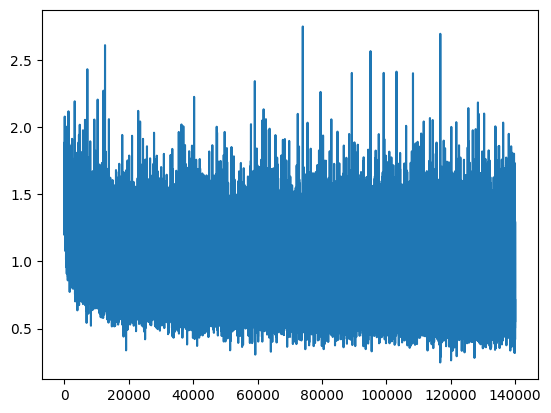

In [28]:
plt.plot(train_losses)

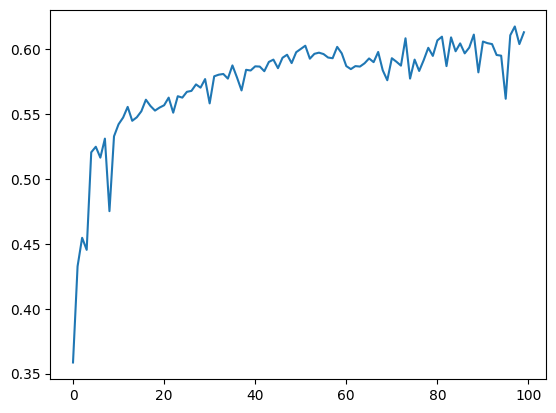

In [29]:
plt.plot(test_accuracy)

In [30]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13ser_best_98epoch.pt
Correct: 3458/5600 (0.6175)
{'acc_detail': tensor([0.6750, 0.7071, 0.6779, 0.4100], device='cuda:0'),
 'acc_unweighted': tensor(0.6175, device='cuda:0'),
 'acc_weighted': tensor(0.6175, device='cuda:0'),
 'f1s_detail': tensor([0.6542, 0.6274, 0.6922, 0.4758], device='cuda:0'),
 'f1s_unweighted': tensor(0.6124, device='cuda:0'),
 'f1s_weighted': tensor(0.6124, device='cuda:0'),
 'precision_detail': tensor([0.6347, 0.5638, 0.7072, 0.5666], device='cuda:0'),
 'recall_detail': tensor([0.6750, 0.7071, 0.6779, 0.4100], device='cuda:0'),
 'rocauc': tensor(0.8566, device='cuda:0'),
 'rocauc_detail': tensor([0.8779, 0.8675, 0.8907, 0.7903], device='cuda:0'),
 'uar': tensor(0.6175, device='cuda:0'),
 'wap': tensor(0.6181, device='cuda:0')}


tensor([[945, 157,  76, 222],
        [ 53, 990, 211, 146],
        [ 81, 299, 949,  71],
        [410, 310, 106, 574]], device='cuda:0')

Time domain: Filters' shapes vary by frequency bins


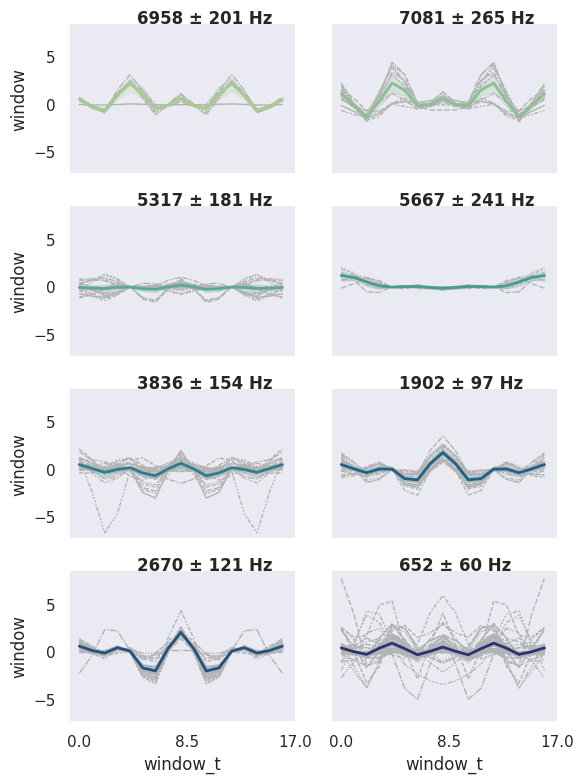

In [33]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


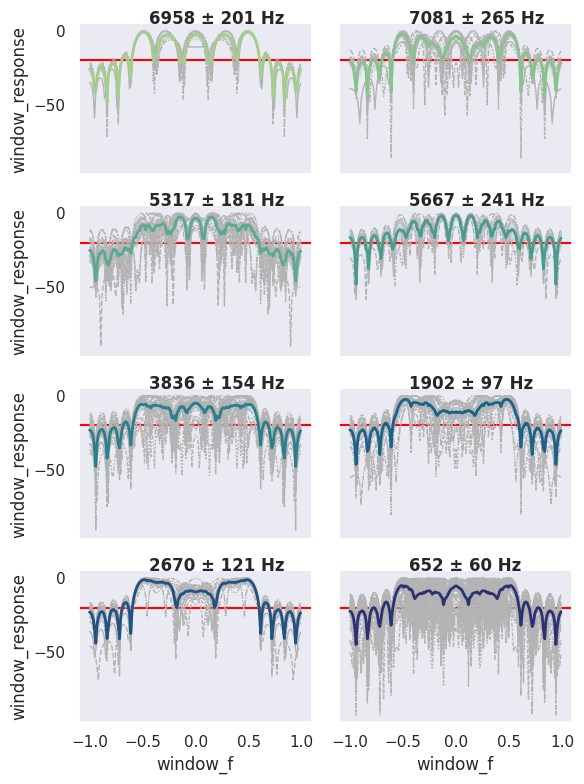

In [34]:
filtviz.visualize_filters(filter_domain='freq')

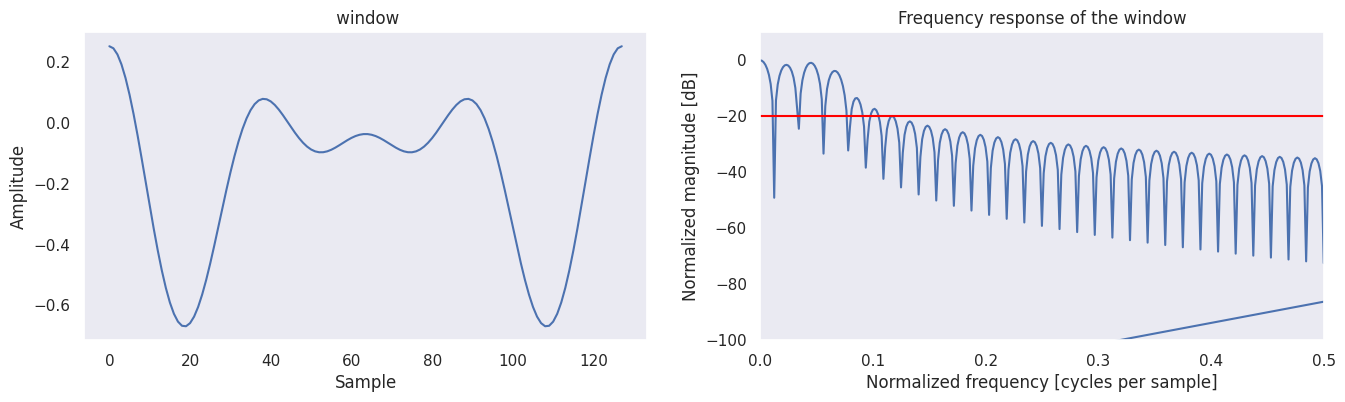

In [35]:
filtviz.visualize_one_window(n_out=10)

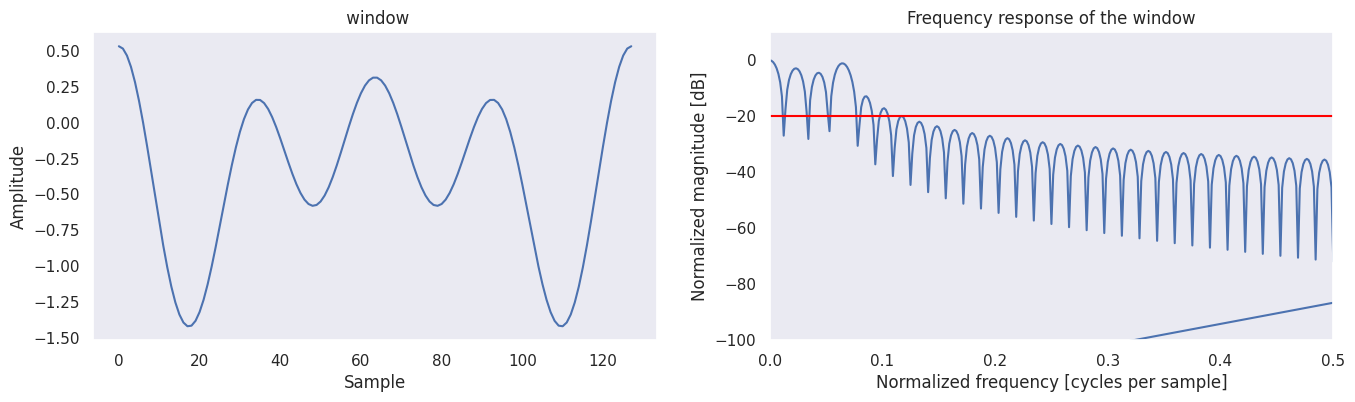

In [36]:
filtviz.visualize_one_window(n_out=50)

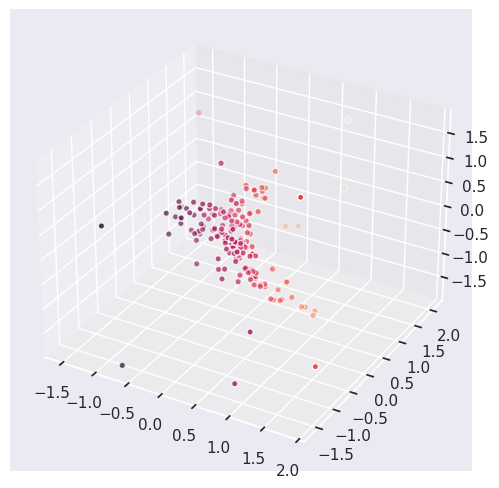

In [37]:
filtviz.visualize_window_params()

In [38]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                  | 0.0005714285714285715/50 [00:00<11:56:59, 860.41s/it]

Train Epoch: 101 [0/22400 (0%)]	Loss: 0.784137
Mem before-during-after: 63204864 5354140672 66821632


  0%|                                                                   | 0.023428571428571413/50 [00:20<13:31:57, 974.81s/it]

Train Epoch: 101 [640/22400 (3%)]	Loss: 0.651651
Mem before-during-after: 67244544 5354378240 67244544


  0%|                                                                  | 0.046285714285714215/50 [00:41<14:05:47, 1015.89s/it]

Train Epoch: 101 [1280/22400 (6%)]	Loss: 0.694216
Mem before-during-after: 66845184 5350002176 66868736


  0%|                                                                    | 0.06914285714285702/50 [01:00<12:43:59, 918.06s/it]

Train Epoch: 101 [1920/22400 (9%)]	Loss: 0.857142
Mem before-during-after: 66821632 5355135488 66821632


  0%|▏                                                                   | 0.09199999999999982/50 [01:20<12:39:26, 913.02s/it]

Train Epoch: 101 [2560/22400 (11%)]	Loss: 0.900170
Mem before-during-after: 66845184 5353603072 66821632


  0%|▏                                                                   | 0.11485714285714262/50 [01:39<13:26:48, 970.41s/it]

Train Epoch: 101 [3200/22400 (14%)]	Loss: 0.865699
Mem before-during-after: 67244544 5354610688 66821632


  0%|▏                                                                   | 0.13771428571428573/50 [02:00<12:55:09, 932.76s/it]

Train Epoch: 101 [3840/22400 (17%)]	Loss: 0.454544
Mem before-during-after: 66821632 5355106304 66845184


  0%|▏                                                                    | 0.1605714285714291/50 [02:19<12:49:43, 926.64s/it]

Train Epoch: 101 [4480/22400 (20%)]	Loss: 0.879210
Mem before-during-after: 66868736 5354587136 66845184


  0%|▏                                                                   | 0.18342857142857244/50 [02:39<12:34:49, 909.12s/it]

Train Epoch: 101 [5120/22400 (23%)]	Loss: 0.861072
Mem before-during-after: 67058688 5354610688 66821632


  0%|▎                                                                    | 0.2062857142857158/50 [03:00<12:52:27, 930.78s/it]

Train Epoch: 101 [5760/22400 (26%)]	Loss: 0.892267
Mem before-during-after: 66845184 5353579520 66845184


  0%|▎                                                                  | 0.22914285714285915/50 [03:19<13:52:09, 1003.19s/it]

Train Epoch: 101 [6400/22400 (29%)]	Loss: 0.750865
Mem before-during-after: 66821632 5354177536 67043840


  1%|▎                                                                    | 0.2520000000000024/50 [03:39<13:23:08, 968.66s/it]

Train Epoch: 101 [7040/22400 (31%)]	Loss: 1.008054
Mem before-during-after: 66845184 5355253760 67464704


  1%|▎                                                                   | 0.27485714285714463/50 [03:59<13:27:28, 974.32s/it]

Train Epoch: 101 [7680/22400 (34%)]	Loss: 0.910344
Mem before-during-after: 66845184 5355573248 67784192


  1%|▍                                                                    | 0.2977142857142869/50 [04:18<12:29:56, 905.32s/it]

Train Epoch: 101 [8320/22400 (37%)]	Loss: 0.705632
Mem before-during-after: 66821632 5355549696 66821632


  1%|▍                                                                    | 0.3205714285714291/50 [04:38<12:40:43, 918.76s/it]

Train Epoch: 101 [8960/22400 (40%)]	Loss: 0.767746
Mem before-during-after: 66821632 5354657792 66845184


  1%|▍                                                                   | 0.34342857142857136/50 [04:57<13:13:14, 958.47s/it]

Train Epoch: 101 [9600/22400 (43%)]	Loss: 0.962272
Mem before-during-after: 67293696 5354004480 66821632


  1%|▍                                                                   | 0.3662857142857136/50 [05:18<14:06:49, 1023.68s/it]

Train Epoch: 101 [10240/22400 (46%)]	Loss: 0.572890
Mem before-during-after: 66821632 5355458560 67244544


  1%|▌                                                                   | 0.38914285714285585/50 [05:37<12:45:09, 925.38s/it]

Train Epoch: 101 [10880/22400 (49%)]	Loss: 0.919181
Mem before-during-after: 66845184 5355549696 66845184


  1%|▌                                                                    | 0.4119999999999981/50 [05:57<12:53:08, 935.48s/it]

Train Epoch: 101 [11520/22400 (51%)]	Loss: 0.610192
Mem before-during-after: 67784192 5354634240 66845184


  1%|▌                                                                   | 0.43485714285714033/50 [06:16<12:28:21, 905.91s/it]

Train Epoch: 101 [12160/22400 (54%)]	Loss: 0.734029
Mem before-during-after: 66845184 5353626624 66821632


  1%|▋                                                                    | 0.4577142857142826/50 [06:36<12:28:33, 906.57s/it]

Train Epoch: 101 [12800/22400 (57%)]	Loss: 1.258568
Mem before-during-after: 66868736 5353579520 66845184


  1%|▋                                                                    | 0.4805714285714248/50 [06:55<12:28:38, 907.09s/it]

Train Epoch: 101 [13440/22400 (60%)]	Loss: 0.435014
Mem before-during-after: 66821632 5353555968 66821632


  1%|▋                                                                    | 0.5034285714285671/50 [07:15<12:38:07, 918.99s/it]

Train Epoch: 101 [14080/22400 (63%)]	Loss: 0.994034
Mem before-during-after: 66845184 5355549696 66845184


  1%|▋                                                                    | 0.5262857142857094/50 [07:34<12:27:58, 907.11s/it]

Train Epoch: 101 [14720/22400 (66%)]	Loss: 0.662458
Mem before-during-after: 66821632 5354587136 66821632


  1%|▊                                                                    | 0.5491428571428516/50 [07:53<12:35:34, 916.76s/it]

Train Epoch: 101 [15360/22400 (69%)]	Loss: 0.967775
Mem before-during-after: 66845184 5354610688 66868736


  1%|▊                                                                   | 0.5719999999999938/50 [08:14<14:09:17, 1030.93s/it]

Train Epoch: 101 [16000/22400 (71%)]	Loss: 0.883550
Mem before-during-after: 68275712 4852799488 68537856


  1%|▊                                                                   | 0.5948571428571361/50 [08:34<13:44:42, 1001.57s/it]

Train Epoch: 101 [16640/22400 (74%)]	Loss: 0.788534
Mem before-during-after: 68662784 5361223680 68306432


  1%|▊                                                                    | 0.6177142857142783/50 [08:53<13:42:32, 999.40s/it]

Train Epoch: 101 [17280/22400 (77%)]	Loss: 1.197679
Mem before-during-after: 66868736 5348971008 66845184


  1%|▉                                                                    | 0.6405714285714206/50 [09:13<12:58:14, 946.00s/it]

Train Epoch: 101 [17920/22400 (80%)]	Loss: 0.926053
Mem before-during-after: 67293696 5356059136 67293696


  1%|▉                                                                    | 0.6634285714285628/50 [09:33<12:59:19, 947.76s/it]

Train Epoch: 101 [18560/22400 (83%)]	Loss: 0.593559
Mem before-during-after: 66845184 5355526144 67784192


  1%|▉                                                                    | 0.6862857142857051/50 [09:53<12:41:16, 926.24s/it]

Train Epoch: 101 [19200/22400 (86%)]	Loss: 0.843097
Mem before-during-after: 67082240 5355502592 66845184


  1%|▉                                                                    | 0.7091428571428473/50 [10:13<13:18:38, 972.16s/it]

Train Epoch: 101 [19840/22400 (89%)]	Loss: 0.728491
Mem before-during-after: 66821632 5192547840 67768832


  1%|█                                                                    | 0.7319999999999895/50 [10:32<12:31:00, 914.60s/it]

Train Epoch: 101 [20480/22400 (91%)]	Loss: 0.700339
Mem before-during-after: 67058688 5354563584 66821632


  2%|█                                                                    | 0.7548571428571318/50 [10:52<12:34:38, 919.45s/it]

Train Epoch: 101 [21120/22400 (94%)]	Loss: 0.880649
Mem before-during-after: 66821632 5353555968 66821632


  2%|█                                                                     | 0.777714285714274/50 [11:12<13:18:26, 973.27s/it]

Train Epoch: 101 [21760/22400 (97%)]	Loss: 1.295820
Mem before-during-after: 67268096 4687689216 67399168


  2%|█▍                                                                    | 0.9999999999999823/50 [13:02<6:14:40, 458.79s/it]


Test Epoch: 101	Accuracy: 3445/5600 (62%)



  2%|█▍                                                                     | 1.000571428571411/50 [13:02<7:38:46, 561.77s/it]

Train Epoch: 102 [0/22400 (0%)]	Loss: 0.797590
Mem before-during-after: 66814464 5358757888 66821632


  2%|█▍                                                                   | 1.0234285714285576/50 [13:22<12:26:01, 913.94s/it]

Train Epoch: 102 [640/22400 (3%)]	Loss: 0.698065
Mem before-during-after: 66845184 5354587136 66821632


  2%|█▍                                                                   | 1.0462857142857043/50 [13:41<12:33:05, 923.02s/it]

Train Epoch: 102 [1280/22400 (6%)]	Loss: 0.909917
Mem before-during-after: 67826176 5356627968 67834368


  2%|█▍                                                                    | 1.069142857142851/50 [14:01<13:13:26, 972.94s/it]

Train Epoch: 102 [1920/22400 (9%)]	Loss: 0.687871
Mem before-during-after: 66845184 5354587136 66845184


  2%|█▌                                                                   | 1.0919999999999976/50 [14:21<12:17:49, 905.17s/it]

Train Epoch: 102 [2560/22400 (11%)]	Loss: 0.915916
Mem before-during-after: 66821632 5354800640 67058688


  2%|█▌                                                                   | 1.1148571428571443/50 [14:40<12:17:09, 904.76s/it]

Train Epoch: 102 [3200/22400 (14%)]	Loss: 1.185145
Mem before-during-after: 66845184 5353579520 66821632


  2%|█▌                                                                   | 1.137714285714291/50 [15:00<13:38:47, 1005.43s/it]

Train Epoch: 102 [3840/22400 (17%)]	Loss: 0.874540
Mem before-during-after: 66845184 5354800640 67244544


  2%|█▌                                                                   | 1.1605714285714377/50 [15:19<12:17:15, 905.74s/it]

Train Epoch: 102 [4480/22400 (20%)]	Loss: 0.672072
Mem before-during-after: 67293696 5355058688 66821632


  2%|█▌                                                                  | 1.1834285714285844/50 [15:40<13:40:30, 1008.48s/it]

Train Epoch: 102 [5120/22400 (23%)]	Loss: 0.881188
Mem before-during-after: 67058688 5329086976 67826688


  2%|█▋                                                                    | 1.206285714285731/50 [15:59<13:05:46, 966.24s/it]

Train Epoch: 102 [5760/22400 (26%)]	Loss: 0.914137
Mem before-during-after: 67176448 5354587136 67176448


  2%|█▋                                                                  | 1.2291428571428777/50 [16:19<14:39:18, 1081.75s/it]

Train Epoch: 102 [6400/22400 (29%)]	Loss: 0.834225
Mem before-during-after: 68523520 5360429056 68093440


  3%|█▋                                                                  | 1.2520000000000244/50 [16:39<13:51:20, 1023.23s/it]

Train Epoch: 102 [7040/22400 (31%)]	Loss: 0.630998
Mem before-during-after: 66868736 5357773824 66845184


  3%|█▊                                                                    | 1.274857142857171/50 [16:58<12:18:37, 909.55s/it]

Train Epoch: 102 [7680/22400 (34%)]	Loss: 0.759243
Mem before-during-after: 66821632 5354563584 66821632


  3%|█▊                                                                   | 1.2977142857143178/50 [17:18<12:58:16, 958.81s/it]

Train Epoch: 102 [8320/22400 (37%)]	Loss: 0.500135
Mem before-during-after: 67244544 5353978880 67244544


  3%|█▊                                                                  | 1.3205714285714645/50 [17:38<13:35:55, 1005.68s/it]

Train Epoch: 102 [8960/22400 (40%)]	Loss: 0.945454
Mem before-during-after: 67736064 5360685056 67834368


  3%|█▊                                                                   | 1.3434285714286112/50 [17:58<12:27:00, 921.16s/it]

Train Epoch: 102 [9600/22400 (43%)]	Loss: 0.625381
Mem before-during-after: 66845184 5354657792 66845184


  3%|█▉                                                                   | 1.3662857142857578/50 [18:17<12:51:12, 951.46s/it]

Train Epoch: 102 [10240/22400 (46%)]	Loss: 0.907687
Mem before-during-after: 67268096 5355010048 67268096


  3%|█▉                                                                   | 1.3891428571429045/50 [18:36<12:15:14, 907.50s/it]

Train Epoch: 102 [10880/22400 (49%)]	Loss: 0.744016
Mem before-during-after: 66821632 5353555968 66821632


  3%|█▉                                                                  | 1.4120000000000512/50 [18:56<14:29:13, 1073.38s/it]

Train Epoch: 102 [11520/22400 (51%)]	Loss: 1.009562
Mem before-during-after: 67082240 5359185408 67268096


  3%|█▉                                                                   | 1.434857142857198/50 [19:16<14:01:57, 1040.20s/it]

Train Epoch: 102 [12160/22400 (54%)]	Loss: 0.807621
Mem before-during-after: 66821632 5354587136 66821632


  3%|█▉                                                                  | 1.4577142857143446/50 [19:36<13:54:53, 1031.95s/it]

Train Epoch: 102 [12800/22400 (57%)]	Loss: 0.932141
Mem before-during-after: 67768832 5359705088 66821632


  3%|██                                                                   | 1.4805714285714913/50 [19:55<12:09:43, 902.38s/it]

Train Epoch: 102 [13440/22400 (60%)]	Loss: 0.755145
Mem before-during-after: 66868736 5354587136 66845184


  3%|██                                                                    | 1.503428571428638/50 [20:15<12:44:49, 946.25s/it]

Train Epoch: 102 [14080/22400 (63%)]	Loss: 0.900861
Mem before-during-after: 66845184 5353579520 66845184


  3%|██                                                                   | 1.5262857142857846/50 [20:35<13:26:22, 998.11s/it]

Train Epoch: 102 [14720/22400 (66%)]	Loss: 1.169125
Mem before-during-after: 67268096 5355010048 67268096


  3%|██▏                                                                  | 1.5491428571429313/50 [20:55<12:15:24, 910.71s/it]

Train Epoch: 102 [15360/22400 (69%)]	Loss: 0.873874
Mem before-during-after: 66845184 5355035648 66821632


  3%|██▏                                                                   | 1.572000000000078/50 [21:14<13:04:52, 972.42s/it]

Train Epoch: 102 [16000/22400 (71%)]	Loss: 1.197326
Mem before-during-after: 66845184 5353579520 66845184


  3%|██▏                                                                  | 1.5948571428572247/50 [21:34<12:26:39, 925.50s/it]

Train Epoch: 102 [16640/22400 (74%)]	Loss: 0.715853
Mem before-during-after: 66821632 5353555968 66821632


  3%|██▏                                                                  | 1.6177142857143714/50 [21:53<12:59:11, 966.30s/it]

Train Epoch: 102 [17280/22400 (77%)]	Loss: 0.970609
Mem before-during-after: 66868736 4603822592 67397632


  3%|██▎                                                                   | 1.640571428571518/50 [22:13<12:59:27, 967.09s/it]

Train Epoch: 102 [17920/22400 (80%)]	Loss: 0.878216
Mem before-during-after: 66821632 5354028032 67293696


  3%|██▎                                                                  | 1.6634285714286647/50 [22:32<12:21:11, 920.04s/it]

Train Epoch: 102 [18560/22400 (83%)]	Loss: 0.597942
Mem before-during-after: 66821632 5353603072 66821632


  3%|██▎                                                                  | 1.6862857142858114/50 [22:51<12:32:35, 934.64s/it]

Train Epoch: 102 [19200/22400 (86%)]	Loss: 1.128109
Mem before-during-after: 66821632 5354563584 66821632


  3%|██▎                                                                  | 1.709142857142958/50 [23:13<13:50:25, 1031.78s/it]

Train Epoch: 102 [19840/22400 (89%)]	Loss: 0.504768
Mem before-during-after: 67244544 5355010048 67244544


  3%|██▍                                                                  | 1.7320000000001048/50 [23:32<13:05:56, 976.97s/it]

Train Epoch: 102 [20480/22400 (91%)]	Loss: 0.806737
Mem before-during-after: 68337152 5359639552 66845184


  4%|██▍                                                                  | 1.7548571428572515/50 [23:51<12:08:36, 906.13s/it]

Train Epoch: 102 [21120/22400 (94%)]	Loss: 0.830863
Mem before-during-after: 66821632 5354563584 66821632


  4%|██▍                                                                  | 1.7777142857143982/50 [24:10<13:16:47, 991.39s/it]

Train Epoch: 102 [21760/22400 (97%)]	Loss: 0.617591
Mem before-during-after: 67244544 5354563584 66821632


  4%|██▊                                                                   | 2.0000000000001497/50 [26:01<6:07:16, 459.09s/it]


Test Epoch: 102	Accuracy: 3446/5600 (62%)



  4%|██▊                                                                    | 2.000571428571578/50 [26:01<7:29:40, 562.11s/it]

Train Epoch: 103 [0/22400 (0%)]	Loss: 1.070591
Mem before-during-after: 66814464 5358757888 66821632


  4%|██▊                                                                   | 2.023428571428716/50 [26:20<12:03:56, 905.38s/it]

Train Epoch: 103 [640/22400 (3%)]	Loss: 0.959196
Mem before-during-after: 66821632 5354563584 66821632


  4%|██▊                                                                 | 2.0462857142858537/50 [26:40<13:23:59, 1005.95s/it]

Train Epoch: 103 [1280/22400 (6%)]	Loss: 1.417583
Mem before-during-after: 67268096 4984359936 67628544


  4%|██▊                                                                  | 2.0691428571429915/50 [27:00<12:09:31, 913.23s/it]

Train Epoch: 103 [1920/22400 (9%)]	Loss: 0.648425
Mem before-during-after: 67317248 5355059200 66845184


  4%|██▉                                                                  | 2.0920000000001293/50 [27:19<12:16:28, 922.36s/it]

Train Epoch: 103 [2560/22400 (11%)]	Loss: 1.099197
Mem before-during-after: 66845184 5355974656 67317248


  4%|██▉                                                                   | 2.114857142857267/50 [27:39<13:04:00, 982.37s/it]

Train Epoch: 103 [3200/22400 (14%)]	Loss: 0.590843
Mem before-during-after: 66845184 5356580864 67792384


  4%|██▉                                                                   | 2.137714285714405/50 [27:58<12:06:40, 910.96s/it]

Train Epoch: 103 [3840/22400 (17%)]	Loss: 0.520281
Mem before-during-after: 67293696 5355012096 66821632


  4%|██▉                                                                  | 2.1605714285715427/50 [28:17<12:58:03, 975.84s/it]

Train Epoch: 103 [4480/22400 (20%)]	Loss: 0.875542
Mem before-during-after: 66845184 5354450944 67268096


  4%|███                                                                  | 2.1834285714286805/50 [28:37<12:24:22, 934.04s/it]

Train Epoch: 103 [5120/22400 (23%)]	Loss: 0.998572
Mem before-during-after: 66821632 5353555968 66821632


  4%|███                                                                  | 2.2062857142858183/50 [28:57<12:29:56, 941.47s/it]

Train Epoch: 103 [5760/22400 (26%)]	Loss: 1.157023
Mem before-during-after: 66868736 5354448896 67268096


  4%|███                                                                   | 2.229142857142956/50 [29:17<12:52:50, 970.69s/it]

Train Epoch: 103 [6400/22400 (29%)]	Loss: 0.783946
Mem before-during-after: 66868736 5354002432 67268096


  5%|███▏                                                                  | 2.252000000000094/50 [29:36<12:28:29, 940.55s/it]

Train Epoch: 103 [7040/22400 (31%)]	Loss: 1.288495
Mem before-during-after: 66868736 4936582144 67595776


  5%|███▏                                                                 | 2.2748571428572317/50 [29:57<12:37:08, 951.88s/it]

Train Epoch: 103 [7680/22400 (34%)]	Loss: 0.469490
Mem before-during-after: 66868736 5354448896 67268096


  5%|███▏                                                                 | 2.2977142857143695/50 [30:16<12:59:07, 979.98s/it]

Train Epoch: 103 [8320/22400 (37%)]	Loss: 0.916930
Mem before-during-after: 66868736 5353626624 66845184


  5%|███▏                                                                 | 2.3205714285715073/50 [30:35<12:12:59, 922.41s/it]

Train Epoch: 103 [8960/22400 (40%)]	Loss: 0.960121
Mem before-during-after: 67784192 5354634240 66845184


  5%|███▎                                                                  | 2.343428571428645/50 [30:55<12:05:16, 913.12s/it]

Train Epoch: 103 [9600/22400 (43%)]	Loss: 0.676712
Mem before-during-after: 67852800 5355010048 68275712


  5%|███▎                                                                  | 2.366285714285783/50 [31:15<11:56:36, 902.65s/it]

Train Epoch: 103 [10240/22400 (46%)]	Loss: 1.040998
Mem before-during-after: 66845184 5354610688 66868736


  5%|███▏                                                                | 2.3891428571429207/50 [31:34<13:25:32, 1015.17s/it]

Train Epoch: 103 [10880/22400 (49%)]	Loss: 0.804547
Mem before-during-after: 67716608 5359116288 67388928


  5%|███▎                                                                | 2.4120000000000585/50 [31:54<13:48:43, 1044.86s/it]

Train Epoch: 103 [11520/22400 (51%)]	Loss: 1.037772
Mem before-during-after: 67399168 5360134144 67268096


  5%|███▎                                                                 | 2.4348571428571963/50 [32:14<11:59:24, 907.47s/it]

Train Epoch: 103 [12160/22400 (54%)]	Loss: 0.804031
Mem before-during-after: 68324864 5355035648 67852800


  5%|███▍                                                                 | 2.457714285714334/50 [32:33<13:22:59, 1013.40s/it]

Train Epoch: 103 [12800/22400 (57%)]	Loss: 1.062387
Mem before-during-after: 67268096 5354401792 67268096


  5%|███▍                                                                 | 2.480571428571472/50 [32:53<13:44:33, 1041.13s/it]

Train Epoch: 103 [13440/22400 (60%)]	Loss: 0.786368
Mem before-during-after: 66821632 5355222528 66821632


  5%|███▍                                                                | 2.5034285714286098/50 [33:13<13:20:37, 1011.40s/it]

Train Epoch: 103 [14080/22400 (63%)]	Loss: 0.950908
Mem before-during-after: 67146240 5069389312 67058688


  5%|███▍                                                                 | 2.5262857142857476/50 [33:31<11:56:27, 905.51s/it]

Train Epoch: 103 [14720/22400 (66%)]	Loss: 0.569780
Mem before-during-after: 66821632 5353555968 66821632


  5%|███▌                                                                 | 2.5491428571428854/50 [33:50<12:38:54, 959.62s/it]

Train Epoch: 103 [15360/22400 (69%)]	Loss: 1.743339
Mem before-during-after: 66821632 4356503552 66845184


  5%|███▌                                                                  | 2.572000000000023/50 [34:10<11:57:21, 907.50s/it]

Train Epoch: 103 [16000/22400 (71%)]	Loss: 0.766078
Mem before-during-after: 66845184 5353603072 66821632


  5%|███▋                                                                  | 2.594857142857161/50 [34:29<11:58:31, 909.42s/it]

Train Epoch: 103 [16640/22400 (74%)]	Loss: 1.260785
Mem before-during-after: 66845184 5353603072 66821632


  5%|███▌                                                                 | 2.6177142857142988/50 [34:49<12:56:48, 983.66s/it]

Train Epoch: 103 [17280/22400 (77%)]	Loss: 1.035471
Mem before-during-after: 68275712 5355010048 68275712


  5%|███▋                                                                 | 2.6405714285714366/50 [35:08<12:57:31, 985.04s/it]

Train Epoch: 103 [17920/22400 (80%)]	Loss: 0.803008
Mem before-during-after: 68275712 5353555968 66821632


  5%|███▋                                                                 | 2.6634285714285744/50 [35:28<12:02:23, 915.64s/it]

Train Epoch: 103 [18560/22400 (83%)]	Loss: 0.834543
Mem before-during-after: 67852800 5355035648 67852800


  5%|███▊                                                                  | 2.686285714285712/50 [35:47<12:15:21, 932.53s/it]

Train Epoch: 103 [19200/22400 (86%)]	Loss: 0.535331
Mem before-during-after: 67784192 5354634240 66845184


  5%|███▊                                                                   | 2.70914285714285/50 [36:07<12:54:41, 982.88s/it]

Train Epoch: 103 [19840/22400 (89%)]	Loss: 0.847948
Mem before-during-after: 66845184 5146264064 66845184


  5%|███▊                                                                 | 2.7319999999999878/50 [36:26<11:57:23, 910.63s/it]

Train Epoch: 103 [20480/22400 (91%)]	Loss: 0.700082
Mem before-during-after: 66845184 5355974656 67317248


  6%|███▊                                                                 | 2.7548571428571256/50 [36:46<12:11:07, 928.52s/it]

Train Epoch: 103 [21120/22400 (94%)]	Loss: 0.603814
Mem before-during-after: 66845184 5353603072 66868736


  6%|███▊                                                                 | 2.7777142857142634/50 [37:05<11:51:03, 903.47s/it]

Train Epoch: 103 [21760/22400 (97%)]	Loss: 0.881217
Mem before-during-after: 66821632 5354563584 66821632


  6%|████▏                                                                 | 2.9999999999999285/50 [38:56<6:00:25, 460.13s/it]


Test Epoch: 103	Accuracy: 3429/5600 (61%)



  6%|████▎                                                                  | 3.000571428571357/50 [38:57<7:21:07, 563.14s/it]

Train Epoch: 104 [0/22400 (0%)]	Loss: 0.642334
Mem before-during-after: 66814464 5358757888 66821632


  6%|████                                                                | 3.0234285714284947/50 [39:17<13:23:08, 1025.80s/it]

Train Epoch: 104 [640/22400 (3%)]	Loss: 0.625499
Mem before-during-after: 67572224 5359980544 67293696


  6%|████▏                                                                | 3.0462857142856326/50 [39:37<11:54:26, 912.95s/it]

Train Epoch: 104 [1280/22400 (6%)]	Loss: 0.613147
Mem before-during-after: 66845184 5353603072 66868736


  6%|████▏                                                                | 3.0691428571427704/50 [39:57<12:35:56, 966.46s/it]

Train Epoch: 104 [1920/22400 (9%)]	Loss: 0.769590
Mem before-during-after: 66845184 5354049536 67244544


  6%|████▎                                                                 | 3.091999999999908/50 [40:16<12:32:52, 963.01s/it]

Train Epoch: 104 [2560/22400 (11%)]	Loss: 0.983837
Mem before-during-after: 66845184 5353626624 66821632


  6%|████▎                                                                | 3.114857142857046/50 [40:36<13:01:52, 1000.59s/it]

Train Epoch: 104 [3200/22400 (14%)]	Loss: 0.804153
Mem before-during-after: 66845184 5326702080 66821632


  6%|████▎                                                               | 3.1377142857141838/50 [40:57<13:39:08, 1048.79s/it]

Train Epoch: 104 [3840/22400 (17%)]	Loss: 0.981677
Mem before-during-after: 66845184 5357773824 66821632


  6%|████▎                                                                | 3.1605714285713216/50 [41:16<11:51:54, 911.93s/it]

Train Epoch: 104 [4480/22400 (20%)]	Loss: 0.860565
Mem before-during-after: 66845184 5353579520 66821632


  6%|████▍                                                                | 3.1834285714284594/50 [41:36<12:24:58, 954.77s/it]

Train Epoch: 104 [5120/22400 (23%)]	Loss: 1.040527
Mem before-during-after: 66845184 4895235584 67539456


  6%|████▍                                                                 | 3.206285714285597/50 [41:56<11:48:37, 908.61s/it]

Train Epoch: 104 [5760/22400 (26%)]	Loss: 1.134880
Mem before-during-after: 66845184 5353579520 66821632


  6%|████▌                                                                 | 3.229142857142735/50 [42:16<11:47:33, 907.68s/it]

Train Epoch: 104 [6400/22400 (29%)]	Loss: 1.148897
Mem before-during-after: 66845184 5355367424 66821632


  7%|████▍                                                                | 3.2519999999998728/50 [42:36<12:00:55, 925.28s/it]

Train Epoch: 104 [7040/22400 (31%)]	Loss: 0.719430
Mem before-during-after: 66845184 5353579520 66821632


  7%|████▌                                                                | 3.2748571428570106/50 [42:55<12:13:40, 942.11s/it]

Train Epoch: 104 [7680/22400 (34%)]	Loss: 0.395166
Mem before-during-after: 66845184 5354075136 66821632


  7%|████▌                                                                | 3.2977142857141484/50 [43:15<12:12:36, 941.20s/it]

Train Epoch: 104 [8320/22400 (37%)]	Loss: 0.978391
Mem before-during-after: 66845184 5354448896 67244544


  7%|████▋                                                                 | 3.320571428571286/50 [43:34<11:44:04, 904.99s/it]

Train Epoch: 104 [8960/22400 (40%)]	Loss: 1.033100
Mem before-during-after: 66845184 5353579520 66821632


  7%|████▌                                                                | 3.343428571428424/50 [43:54<13:12:42, 1019.43s/it]

Train Epoch: 104 [9600/22400 (43%)]	Loss: 0.728281
Mem before-during-after: 66845184 5357773824 66821632


  7%|████▋                                                                | 3.366285714285562/50 [44:14<13:38:44, 1053.40s/it]

Train Epoch: 104 [10240/22400 (46%)]	Loss: 0.915761
Mem before-during-after: 66845184 5358757888 66821632


  7%|████▋                                                                | 3.3891428571426996/50 [44:33<12:52:52, 994.89s/it]

Train Epoch: 104 [10880/22400 (49%)]	Loss: 0.815436
Mem before-during-after: 67911680 5358804992 67841024


  7%|████▋                                                                | 3.4119999999998374/50 [44:54<12:27:53, 963.20s/it]

Train Epoch: 104 [11520/22400 (51%)]	Loss: 0.909031
Mem before-during-after: 67244544 5355035648 67293696


  7%|████▊                                                                 | 3.434857142856975/50 [45:13<11:45:26, 908.97s/it]

Train Epoch: 104 [12160/22400 (54%)]	Loss: 1.244401
Mem before-during-after: 66821632 5354563584 66821632


  7%|████▊                                                                 | 3.457714285714113/50 [45:32<12:34:26, 972.59s/it]

Train Epoch: 104 [12800/22400 (57%)]	Loss: 1.237808
Mem before-during-after: 66821632 5359696896 67126784


  7%|████▊                                                                | 3.480571428571251/50 [45:53<13:26:07, 1039.72s/it]

Train Epoch: 104 [13440/22400 (60%)]	Loss: 1.298208
Mem before-during-after: 67244544 4644513280 66821632


  7%|████▊                                                                | 3.5034285714283886/50 [46:12<11:53:43, 921.01s/it]

Train Epoch: 104 [14080/22400 (63%)]	Loss: 0.742589
Mem before-during-after: 66845184 5354610688 66845184


  7%|████▊                                                                | 3.5262857142855264/50 [46:31<11:58:56, 928.20s/it]

Train Epoch: 104 [14720/22400 (66%)]	Loss: 0.495950
Mem before-during-after: 66845184 5353603072 66821632


  7%|████▉                                                                 | 3.549142857142664/50 [46:51<12:17:16, 952.33s/it]

Train Epoch: 104 [15360/22400 (69%)]	Loss: 1.335948
Mem before-during-after: 66821632 5353555968 66821632


  7%|█████                                                                 | 3.571999999999802/50 [47:10<11:40:32, 905.32s/it]

Train Epoch: 104 [16000/22400 (71%)]	Loss: 0.697149
Mem before-during-after: 67852800 5354587136 67852800


  7%|█████                                                                  | 3.59485714285694/50 [47:30<12:06:22, 939.18s/it]

Train Epoch: 104 [16640/22400 (74%)]	Loss: 1.012886
Mem before-during-after: 66821632 5354142720 67408384


  7%|████▉                                                                | 3.6177142857140776/50 [47:50<12:07:52, 941.58s/it]

Train Epoch: 104 [17280/22400 (77%)]	Loss: 0.808079
Mem before-during-after: 67268096 5354587136 66845184


  7%|████▉                                                               | 3.6405714285712154/50 [48:09<12:53:46, 1001.44s/it]

Train Epoch: 104 [17920/22400 (80%)]	Loss: 0.637429
Mem before-during-after: 67521536 5365901312 67481600


  7%|█████                                                                | 3.663428571428353/50 [48:29<13:10:39, 1023.81s/it]

Train Epoch: 104 [18560/22400 (83%)]	Loss: 0.799193
Mem before-during-after: 68686336 5359740416 67244544


  7%|█████▏                                                                | 3.686285714285491/50 [48:48<11:45:09, 913.54s/it]

Train Epoch: 104 [19200/22400 (86%)]	Loss: 1.025253
Mem before-during-after: 66821632 5355502592 66821632


  7%|█████▏                                                                | 3.709142857142629/50 [49:08<12:00:27, 933.82s/it]

Train Epoch: 104 [19840/22400 (89%)]	Loss: 0.663019
Mem before-during-after: 67317248 4857455104 67530240


  7%|█████                                                               | 3.7319999999997666/50 [49:28<13:19:45, 1037.12s/it]

Train Epoch: 104 [20480/22400 (91%)]	Loss: 0.639723
Mem before-during-after: 67192320 5354986496 67244544


  8%|█████▏                                                               | 3.7548571428569044/50 [49:47<12:35:52, 980.69s/it]

Train Epoch: 104 [21120/22400 (94%)]	Loss: 0.913003
Mem before-during-after: 66845184 5192719872 67792384


  8%|█████▎                                                                | 3.777714285714042/50 [50:07<12:16:48, 956.44s/it]

Train Epoch: 104 [21760/22400 (97%)]	Loss: 0.844698
Mem before-during-after: 67667456 5356256768 67667456


  8%|█████▌                                                                | 3.9999999999997073/50 [51:58<5:52:19, 459.55s/it]


Test Epoch: 104	Accuracy: 3491/5600 (62%)

saved model: ../models_esd4/esd4_m13ser_best_104epoch.pt


  8%|█████▋                                                                 | 4.000571428571136/50 [51:59<7:31:09, 588.46s/it]

Train Epoch: 105 [0/22400 (0%)]	Loss: 0.739130
Mem before-during-after: 66814464 5317741568 66821632


  8%|█████▋                                                                | 4.023428571428291/50 [52:18<11:40:55, 914.72s/it]

Train Epoch: 105 [640/22400 (3%)]	Loss: 0.908984
Mem before-during-after: 66821632 5354800640 67058688


  8%|█████▋                                                                | 4.046285714285447/50 [52:38<12:16:59, 962.25s/it]

Train Epoch: 105 [1280/22400 (6%)]	Loss: 0.695379
Mem before-during-after: 66868736 4899844096 67563008


  8%|█████▌                                                               | 4.0691428571426025/50 [52:58<11:41:26, 916.30s/it]

Train Epoch: 105 [1920/22400 (9%)]	Loss: 0.768093
Mem before-during-after: 66868736 5353579520 66845184


  8%|█████▋                                                                | 4.091999999999758/50 [53:17<11:35:15, 908.68s/it]

Train Epoch: 105 [2560/22400 (11%)]	Loss: 0.732218
Mem before-during-after: 66845184 5353626624 66845184


  8%|█████▊                                                                | 4.114857142856914/50 [53:36<12:24:00, 972.88s/it]

Train Epoch: 105 [3200/22400 (14%)]	Loss: 0.950504
Mem before-during-after: 66845184 4734266880 67431936


  8%|█████▋                                                               | 4.137714285714069/50 [53:56<13:00:53, 1021.62s/it]

Train Epoch: 105 [3840/22400 (17%)]	Loss: 0.919102
Mem before-during-after: 66982400 5357911040 66845184


  8%|█████▊                                                                | 4.160571428571225/50 [54:14<11:31:28, 905.08s/it]

Train Epoch: 105 [4480/22400 (20%)]	Loss: 1.179661
Mem before-during-after: 66821632 5353555968 66821632


  8%|█████▉                                                                 | 4.18342857142838/50 [54:34<11:34:24, 909.37s/it]

Train Epoch: 105 [5120/22400 (23%)]	Loss: 0.806845
Mem before-during-after: 66821632 5353555968 66821632


  8%|█████▉                                                                | 4.206285714285536/50 [54:54<12:02:49, 947.06s/it]

Train Epoch: 105 [5760/22400 (26%)]	Loss: 0.965483
Mem before-during-after: 67058688 5353579520 66845184


  8%|█████▊                                                               | 4.2291428571426914/50 [55:14<11:42:09, 920.45s/it]

Train Epoch: 105 [6400/22400 (29%)]	Loss: 0.743513
Mem before-during-after: 66821632 5354587136 66821632


  9%|█████▉                                                                | 4.251999999999847/50 [55:34<12:04:23, 950.05s/it]

Train Epoch: 105 [7040/22400 (31%)]	Loss: 0.686199
Mem before-during-after: 66821632 5353555968 66821632


  9%|█████▉                                                                | 4.274857142857003/50 [55:53<12:05:53, 952.52s/it]

Train Epoch: 105 [7680/22400 (34%)]	Loss: 0.627795
Mem before-during-after: 66821632 5353579520 66845184


  9%|██████                                                                | 4.297714285714158/50 [56:14<11:58:34, 943.37s/it]

Train Epoch: 105 [8320/22400 (37%)]	Loss: 1.162434
Mem before-during-after: 66821632 4774616576 67441152


  9%|██████                                                                | 4.320571428571314/50 [56:34<11:40:12, 919.72s/it]

Train Epoch: 105 [8960/22400 (40%)]	Loss: 1.276825
Mem before-during-after: 67488256 5354199040 66821632


  9%|██████                                                                | 4.343428571428469/50 [56:54<11:37:00, 915.98s/it]

Train Epoch: 105 [9600/22400 (43%)]	Loss: 0.743630
Mem before-during-after: 66845184 5355337728 67595776


  9%|██████                                                                | 4.366285714285625/50 [57:14<11:34:49, 913.56s/it]

Train Epoch: 105 [10240/22400 (46%)]	Loss: 0.627788
Mem before-during-after: 66845184 5355974656 67317248


  9%|██████▏                                                                | 4.38914285714278/50 [57:34<11:45:49, 928.50s/it]

Train Epoch: 105 [10880/22400 (49%)]	Loss: 0.620045
Mem before-during-after: 66821632 5353555968 66821632


  9%|██████                                                               | 4.411999999999936/50 [57:55<13:54:02, 1097.72s/it]

Train Epoch: 105 [11520/22400 (51%)]	Loss: 0.841797
Mem before-during-after: 67694080 5360429056 67268096


  9%|██████                                                              | 4.4348571428570915/50 [58:15<12:43:21, 1005.18s/it]

Train Epoch: 105 [12160/22400 (54%)]	Loss: 0.692808
Mem before-during-after: 66868736 5358196736 67268096


  9%|██████▏                                                               | 4.457714285714247/50 [58:35<11:32:48, 912.74s/it]

Train Epoch: 105 [12800/22400 (57%)]	Loss: 0.969181
Mem before-during-after: 66868736 5353579520 66845184


  9%|██████▏                                                              | 4.480571428571403/50 [58:54<13:50:55, 1095.27s/it]

Train Epoch: 105 [13440/22400 (60%)]	Loss: 0.678654
Mem before-during-after: 67539456 5360459776 66821632


  9%|██████▎                                                               | 4.503428571428558/50 [59:15<12:28:04, 986.56s/it]

Train Epoch: 105 [14080/22400 (63%)]	Loss: 1.182424
Mem before-during-after: 67268096 5326492160 66868736


  9%|██████▎                                                               | 4.526285714285714/50 [59:35<11:48:41, 935.09s/it]

Train Epoch: 105 [14720/22400 (66%)]	Loss: 0.878924
Mem before-during-after: 66845184 5353650176 66868736


  9%|██████▎                                                              | 4.549142857142869/50 [59:54<12:49:10, 1015.39s/it]

Train Epoch: 105 [15360/22400 (69%)]	Loss: 0.716183
Mem before-during-after: 66868736 5357773824 66845184


  9%|██████▏                                                             | 4.572000000000025/50 [1:00:14<12:01:29, 952.92s/it]

Train Epoch: 105 [16000/22400 (71%)]	Loss: 0.687938
Mem before-during-after: 66868736 5354587136 66845184


  9%|██████▏                                                            | 4.5948571428571805/50 [1:00:33<11:32:07, 914.59s/it]

Train Epoch: 105 [16640/22400 (74%)]	Loss: 0.582989
Mem before-during-after: 67431936 5355150336 66845184


  9%|██████▎                                                             | 4.617714285714336/50 [1:00:53<11:35:03, 918.93s/it]

Train Epoch: 105 [17280/22400 (77%)]	Loss: 0.750369
Mem before-during-after: 66845184 5354563584 66821632


  9%|██████▎                                                             | 4.640571428571492/50 [1:01:13<12:01:05, 953.84s/it]

Train Epoch: 105 [17920/22400 (80%)]	Loss: 0.659378
Mem before-during-after: 67244544 5353978880 67244544


  9%|██████▎                                                             | 4.663428571428647/50 [1:01:32<11:32:00, 915.83s/it]

Train Epoch: 105 [18560/22400 (83%)]	Loss: 1.112126
Mem before-during-after: 66845184 5326457856 66845184


  9%|██████▎                                                             | 4.686285714285803/50 [1:01:52<12:24:54, 986.33s/it]

Train Epoch: 105 [19200/22400 (86%)]	Loss: 1.145354
Mem before-during-after: 66845184 4693215744 67399168


  9%|██████▍                                                             | 4.709142857142958/50 [1:02:12<12:07:41, 964.03s/it]

Train Epoch: 105 [19840/22400 (89%)]	Loss: 0.770828
Mem before-during-after: 67244544 5353978880 67244544


  9%|██████▍                                                             | 4.732000000000114/50 [1:02:32<11:58:07, 951.84s/it]

Train Epoch: 105 [20480/22400 (91%)]	Loss: 0.880945
Mem before-during-after: 66821632 5353603072 66821632


 10%|██████▎                                                            | 4.7548571428572695/50 [1:02:51<11:27:48, 912.10s/it]

Train Epoch: 105 [21120/22400 (94%)]	Loss: 0.595380
Mem before-during-after: 66845184 5354563584 66821632


 10%|██████▍                                                             | 4.777714285714425/50 [1:03:11<11:53:58, 947.28s/it]

Train Epoch: 105 [21760/22400 (97%)]	Loss: 0.756578
Mem before-during-after: 66845184 5326481408 66868736


 10%|██████▉                                                              | 5.000000000000263/50 [1:05:02<5:42:59, 457.32s/it]


Test Epoch: 105	Accuracy: 3416/5600 (61%)



 10%|██████▉                                                              | 5.000571428571692/50 [1:05:02<7:01:13, 561.65s/it]

Train Epoch: 106 [0/22400 (0%)]	Loss: 0.914184
Mem before-during-after: 66814464 5358757888 66821632


 10%|██████▋                                                            | 5.023428571428847/50 [1:05:22<13:21:09, 1068.77s/it]

Train Epoch: 106 [640/22400 (3%)]	Loss: 0.773864
Mem before-during-after: 66821632 5358757888 66821632


 10%|██████▊                                                             | 5.046285714286003/50 [1:05:41<11:39:32, 933.68s/it]

Train Epoch: 106 [1280/22400 (6%)]	Loss: 0.666340
Mem before-during-after: 66868736 5354587136 66845184


 10%|██████▊                                                            | 5.0691428571431585/50 [1:06:01<12:05:21, 968.63s/it]

Train Epoch: 106 [1920/22400 (9%)]	Loss: 0.799785
Mem before-during-after: 66845184 5354002432 66868736


 10%|██████▉                                                             | 5.092000000000314/50 [1:06:22<11:54:34, 954.72s/it]

Train Epoch: 106 [2560/22400 (11%)]	Loss: 0.711239
Mem before-during-after: 67244544 5355458560 67244544


 10%|███████                                                              | 5.11485714285747/50 [1:06:42<11:29:39, 921.90s/it]

Train Epoch: 106 [3200/22400 (14%)]	Loss: 0.552301
Mem before-during-after: 66821632 5353793024 67058688


 10%|██████▉                                                            | 5.137714285714625/50 [1:07:02<13:52:59, 1114.06s/it]

Train Epoch: 106 [3840/22400 (17%)]	Loss: 0.695595
Mem before-during-after: 68337152 5359054848 66868736


 10%|███████                                                             | 5.160571428571781/50 [1:07:22<12:24:51, 996.69s/it]

Train Epoch: 106 [4480/22400 (20%)]	Loss: 0.783092
Mem before-during-after: 67058688 5349219328 67093504


 10%|███████                                                             | 5.183428571428936/50 [1:07:41<12:17:07, 986.87s/it]

Train Epoch: 106 [5120/22400 (23%)]	Loss: 0.848058
Mem before-during-after: 67890688 5359204352 66868736


 10%|███████                                                             | 5.206285714286092/50 [1:08:02<11:42:40, 941.22s/it]

Train Epoch: 106 [5760/22400 (26%)]	Loss: 0.759298
Mem before-during-after: 66845184 5353603072 66821632


 10%|███████                                                            | 5.2291428571432474/50 [1:08:21<11:38:45, 936.45s/it]

Train Epoch: 106 [6400/22400 (29%)]	Loss: 0.719088
Mem before-during-after: 66821632 5292516352 67852800


 11%|███████▏                                                            | 5.252000000000403/50 [1:08:41<11:18:20, 909.54s/it]

Train Epoch: 106 [7040/22400 (31%)]	Loss: 1.205924
Mem before-during-after: 67293696 5355035648 66821632


 11%|███████▏                                                            | 5.274857142857559/50 [1:09:01<11:17:11, 908.46s/it]

Train Epoch: 106 [7680/22400 (34%)]	Loss: 0.869230
Mem before-during-after: 66821632 5353555968 66821632


 11%|███████▏                                                            | 5.297714285714714/50 [1:09:21<11:36:52, 935.36s/it]

Train Epoch: 106 [8320/22400 (37%)]	Loss: 0.582428
Mem before-during-after: 67784192 5354634240 66845184


 11%|███████▎                                                             | 5.32057142857187/50 [1:09:40<11:41:11, 941.64s/it]

Train Epoch: 106 [8960/22400 (40%)]	Loss: 1.284136
Mem before-during-after: 66845184 5353603072 66868736


 11%|███████▎                                                            | 5.343428571429025/50 [1:10:00<11:30:06, 927.22s/it]

Train Epoch: 106 [9600/22400 (43%)]	Loss: 0.928811
Mem before-during-after: 66821632 5353555968 66821632


 11%|███████▎                                                            | 5.366285714286181/50 [1:10:20<11:50:40, 955.34s/it]

Train Epoch: 106 [10240/22400 (46%)]	Loss: 0.956242
Mem before-during-after: 66845184 5022520832 67637760


 11%|███████▎                                                            | 5.389142857143336/50 [1:10:40<11:22:10, 917.50s/it]

Train Epoch: 106 [10880/22400 (49%)]	Loss: 0.871796
Mem before-during-after: 66821632 5353555968 66821632


 11%|███████▎                                                            | 5.412000000000492/50 [1:10:59<12:19:41, 995.36s/it]

Train Epoch: 106 [11520/22400 (51%)]	Loss: 0.621029
Mem before-during-after: 66845184 5353603072 66868736


 11%|███████▎                                                           | 5.4348571428576475/50 [1:11:19<11:15:58, 910.09s/it]

Train Epoch: 106 [12160/22400 (54%)]	Loss: 0.864224
Mem before-during-after: 66845184 5353650176 66868736


 11%|███████▍                                                            | 5.457714285714803/50 [1:11:38<11:15:21, 909.73s/it]

Train Epoch: 106 [12800/22400 (57%)]	Loss: 0.574479
Mem before-during-after: 66845184 5354002432 66868736


 11%|███████▍                                                            | 5.480571428571959/50 [1:11:57<11:26:50, 925.67s/it]

Train Epoch: 106 [13440/22400 (60%)]	Loss: 0.535914
Mem before-during-after: 66845184 5353650176 66868736


 11%|███████▍                                                            | 5.503428571429114/50 [1:12:18<11:58:33, 968.92s/it]

Train Epoch: 106 [14080/22400 (63%)]	Loss: 0.715023
Mem before-during-after: 66821632 5354587136 67852800


 11%|███████▋                                                             | 5.52628571428627/50 [1:12:38<11:14:39, 910.18s/it]

Train Epoch: 106 [14720/22400 (66%)]	Loss: 0.641408
Mem before-during-after: 66845184 5354610688 66868736


 11%|███████▌                                                            | 5.549142857143425/50 [1:12:57<11:33:21, 935.91s/it]

Train Epoch: 106 [15360/22400 (69%)]	Loss: 0.811333
Mem before-during-after: 66845184 5355010048 67268096


 11%|███████▌                                                            | 5.572000000000581/50 [1:13:17<11:11:30, 906.88s/it]

Train Epoch: 106 [16000/22400 (71%)]	Loss: 0.735815
Mem before-during-after: 66821632 5353555968 66821632


 11%|███████▍                                                           | 5.5948571428577365/50 [1:13:36<11:12:09, 908.21s/it]

Train Epoch: 106 [16640/22400 (74%)]	Loss: 1.134402
Mem before-during-after: 67852800 5354587136 67852800


 11%|███████▌                                                           | 5.617714285714892/50 [1:13:55<12:36:37, 1022.87s/it]

Train Epoch: 106 [17280/22400 (77%)]	Loss: 1.286766
Mem before-during-after: 67244544 4519742976 68089856


 11%|███████▋                                                            | 5.640571428572048/50 [1:14:15<11:28:05, 930.71s/it]

Train Epoch: 106 [17920/22400 (80%)]	Loss: 0.735947
Mem before-during-after: 66821632 5353555968 66821632


 11%|███████▋                                                            | 5.663428571429203/50 [1:14:34<11:12:39, 910.29s/it]

Train Epoch: 106 [18560/22400 (83%)]	Loss: 0.727521
Mem before-during-after: 66845184 5354587136 66821632


 11%|███████▋                                                            | 5.686285714286359/50 [1:14:53<11:15:17, 914.32s/it]

Train Epoch: 106 [19200/22400 (86%)]	Loss: 0.644836
Mem before-during-after: 66845184 5353603072 66868736


 11%|███████▊                                                            | 5.709142857143514/50 [1:15:13<11:33:13, 939.09s/it]

Train Epoch: 106 [19840/22400 (89%)]	Loss: 0.681569
Mem before-during-after: 67268096 5353650176 66868736


 11%|███████▉                                                             | 5.73200000000067/50 [1:15:33<11:11:37, 910.31s/it]

Train Epoch: 106 [20480/22400 (91%)]	Loss: 0.512354
Mem before-during-after: 66845184 5353603072 66868736


 12%|███████▋                                                           | 5.7548571428578255/50 [1:15:53<11:08:18, 906.28s/it]

Train Epoch: 106 [21120/22400 (94%)]	Loss: 1.124378
Mem before-during-after: 66845184 5353603072 66821632


 12%|███████▊                                                            | 5.777714285714981/50 [1:16:12<11:12:12, 912.03s/it]

Train Epoch: 106 [21760/22400 (97%)]	Loss: 0.587114
Mem before-during-after: 66845184 5356580864 67792384


 12%|████████▎                                                            | 6.000000000000819/50 [1:18:04<5:37:40, 460.46s/it]


Test Epoch: 106	Accuracy: 3439/5600 (61%)



 12%|████████▎                                                            | 6.000571428572248/50 [1:18:04<6:54:15, 564.91s/it]

Train Epoch: 107 [0/22400 (0%)]	Loss: 0.637329
Mem before-during-after: 66814464 5358757888 66821632


 12%|████████▏                                                           | 6.023428571429403/50 [1:18:24<11:09:18, 913.18s/it]

Train Epoch: 107 [640/22400 (3%)]	Loss: 0.758026
Mem before-during-after: 67317248 5355998208 66845184


 12%|████████▏                                                           | 6.046285714286559/50 [1:18:44<11:29:31, 941.24s/it]

Train Epoch: 107 [1280/22400 (6%)]	Loss: 0.952328
Mem before-during-after: 66821632 5355178496 67995648


 12%|████████▏                                                          | 6.0691428571437145/50 [1:19:05<11:17:56, 925.92s/it]

Train Epoch: 107 [1920/22400 (9%)]	Loss: 0.594942
Mem before-during-after: 67995648 5353579520 66845184


 12%|████████▍                                                            | 6.09200000000087/50 [1:19:24<11:15:19, 922.83s/it]

Train Epoch: 107 [2560/22400 (11%)]	Loss: 0.564904
Mem before-during-after: 66821632 5354563584 66821632


 12%|████████▎                                                           | 6.114857142858026/50 [1:19:44<11:27:59, 940.62s/it]

Train Epoch: 107 [3200/22400 (14%)]	Loss: 0.869987
Mem before-during-after: 66845184 5355573248 67784192


 12%|████████▎                                                           | 6.137714285715181/50 [1:20:03<11:52:51, 975.13s/it]

Train Epoch: 107 [3840/22400 (17%)]	Loss: 0.927260
Mem before-during-after: 68313600 5228597760 67002880


 12%|████████▍                                                           | 6.160571428572337/50 [1:20:24<12:08:33, 997.13s/it]

Train Epoch: 107 [4480/22400 (20%)]	Loss: 1.007216
Mem before-during-after: 67268096 5355010048 67268096


 12%|████████▍                                                           | 6.183428571429492/50 [1:20:43<11:32:21, 948.07s/it]

Train Epoch: 107 [5120/22400 (23%)]	Loss: 0.688935
Mem before-during-after: 67244544 5354587136 66821632


 12%|████████▎                                                          | 6.206285714286648/50 [1:21:03<13:11:57, 1085.04s/it]

Train Epoch: 107 [5760/22400 (26%)]	Loss: 0.809095
Mem before-during-after: 67082240 5359196160 67259904


 12%|████████▎                                                          | 6.2291428571438034/50 [1:21:22<11:03:49, 909.96s/it]

Train Epoch: 107 [6400/22400 (29%)]	Loss: 0.904684
Mem before-during-after: 66821632 5354563584 66821632


 13%|████████▌                                                           | 6.252000000000959/50 [1:21:42<11:52:33, 977.26s/it]

Train Epoch: 107 [7040/22400 (31%)]	Loss: 0.668768
Mem before-during-after: 67268096 5355808768 67268096


 13%|████████▌                                                           | 6.274857142858115/50 [1:22:01<11:13:15, 923.85s/it]

Train Epoch: 107 [7680/22400 (34%)]	Loss: 0.832961
Mem before-during-after: 67225088 5353935872 66821632


 13%|████████▋                                                            | 6.29771428571527/50 [1:22:21<11:13:39, 924.88s/it]

Train Epoch: 107 [8320/22400 (37%)]	Loss: 0.841329
Mem before-during-after: 66845184 5354563584 66821632


 13%|████████▌                                                           | 6.320571428572426/50 [1:22:40<11:35:00, 954.70s/it]

Train Epoch: 107 [8960/22400 (40%)]	Loss: 0.581716
Mem before-during-after: 67244544 5354610688 66821632


 13%|████████▌                                                          | 6.343428571429581/50 [1:23:00<12:16:32, 1012.27s/it]

Train Epoch: 107 [9600/22400 (43%)]	Loss: 1.008397
Mem before-during-after: 66821632 5358173184 67244544


 13%|████████▋                                                           | 6.366285714286737/50 [1:23:20<11:51:53, 978.92s/it]

Train Epoch: 107 [10240/22400 (46%)]	Loss: 0.981118
Mem before-during-after: 67667456 4775514112 66845184


 13%|████████▌                                                          | 6.389142857143892/50 [1:23:39<13:11:28, 1088.91s/it]

Train Epoch: 107 [10880/22400 (49%)]	Loss: 0.668203
Mem before-during-after: 67230720 5358757888 66821632


 13%|████████▋                                                           | 6.412000000001048/50 [1:23:59<11:41:19, 965.40s/it]

Train Epoch: 107 [11520/22400 (51%)]	Loss: 1.035239
Mem before-during-after: 66821632 5064330752 66845184


 13%|████████▌                                                          | 6.4348571428582035/50 [1:24:18<11:08:56, 921.30s/it]

Train Epoch: 107 [12160/22400 (54%)]	Loss: 0.958354
Mem before-during-after: 66821632 5354002432 66845184


 13%|████████▊                                                           | 6.457714285715359/50 [1:24:38<12:00:09, 992.35s/it]

Train Epoch: 107 [12800/22400 (57%)]	Loss: 0.779193
Mem before-during-after: 66821632 5354098176 66964480


 13%|████████▊                                                           | 6.480571428572515/50 [1:24:58<11:03:25, 914.66s/it]

Train Epoch: 107 [13440/22400 (60%)]	Loss: 0.955694
Mem before-during-after: 67058688 5354563584 66821632


 13%|████████▊                                                           | 6.50342857142967/50 [1:25:18<12:28:57, 1033.13s/it]

Train Epoch: 107 [14080/22400 (63%)]	Loss: 0.832737
Mem before-during-after: 66868736 5359717888 66821632


 13%|████████▉                                                           | 6.526285714286826/50 [1:25:37<11:04:26, 917.03s/it]

Train Epoch: 107 [14720/22400 (66%)]	Loss: 0.866984
Mem before-during-after: 66845184 5354610688 66868736


 13%|████████▉                                                           | 6.549142857143981/50 [1:25:56<11:10:40, 926.12s/it]

Train Epoch: 107 [15360/22400 (69%)]	Loss: 0.964249
Mem before-during-after: 68089856 5354004480 66821632


 13%|████████▉                                                           | 6.572000000001137/50 [1:26:15<10:59:27, 911.09s/it]

Train Epoch: 107 [16000/22400 (71%)]	Loss: 0.778027
Mem before-during-after: 66868736 5353626624 66845184


 13%|████████▊                                                          | 6.5948571428582925/50 [1:26:36<11:17:16, 936.22s/it]

Train Epoch: 107 [16640/22400 (74%)]	Loss: 0.834764
Mem before-during-after: 66868736 5354049536 67268096


 13%|█████████                                                           | 6.617714285715448/50 [1:26:56<11:06:56, 922.43s/it]

Train Epoch: 107 [17280/22400 (77%)]	Loss: 1.048808
Mem before-during-after: 66868736 5353579520 66845184


 13%|████████▉                                                          | 6.640571428572604/50 [1:27:15<12:08:51, 1008.59s/it]

Train Epoch: 107 [17920/22400 (80%)]	Loss: 0.778479
Mem before-during-after: 66868736 5365288448 67268096


 13%|█████████                                                           | 6.663428571429759/50 [1:27:35<12:01:26, 998.83s/it]

Train Epoch: 107 [18560/22400 (83%)]	Loss: 0.745921
Mem before-during-after: 67244544 5355010048 67244544


 13%|█████████                                                           | 6.686285714286915/50 [1:27:54<10:53:14, 904.90s/it]

Train Epoch: 107 [19200/22400 (86%)]	Loss: 0.518205
Mem before-during-after: 66845184 5354657792 66868736


 13%|█████████                                                           | 6.70914285714407/50 [1:28:14<12:17:47, 1022.55s/it]

Train Epoch: 107 [19840/22400 (89%)]	Loss: 0.566534
Mem before-during-after: 66845184 5359720448 67784192


 13%|█████████▏                                                          | 6.732000000001226/50 [1:28:33<10:53:53, 906.76s/it]

Train Epoch: 107 [20480/22400 (91%)]	Loss: 0.891682
Mem before-during-after: 66821632 5353555968 66821632


 14%|█████████                                                          | 6.7548571428583815/50 [1:28:53<10:57:22, 912.06s/it]

Train Epoch: 107 [21120/22400 (94%)]	Loss: 0.922842
Mem before-during-after: 66868736 5292339712 66871296


 14%|█████████▏                                                          | 6.777714285715537/50 [1:29:12<11:09:06, 928.84s/it]

Train Epoch: 107 [21760/22400 (97%)]	Loss: 0.897233
Mem before-during-after: 66845184 5353603072 66868736


 14%|█████████▋                                                           | 7.000000000001375/50 [1:31:03<5:29:28, 459.72s/it]


Test Epoch: 107	Accuracy: 3473/5600 (62%)



 14%|█████████▋                                                           | 7.000571428572804/50 [1:31:03<6:44:14, 564.07s/it]

Train Epoch: 108 [0/22400 (0%)]	Loss: 0.905022
Mem before-during-after: 66814464 5358757888 66821632


 14%|█████████▌                                                          | 7.023428571429959/50 [1:31:23<11:17:57, 946.51s/it]

Train Epoch: 108 [640/22400 (3%)]	Loss: 0.663561
Mem before-during-after: 67857920 5361580032 67673600


 14%|█████████▌                                                          | 7.046285714287115/50 [1:31:42<11:28:06, 961.19s/it]

Train Epoch: 108 [1280/22400 (6%)]	Loss: 0.876916
Mem before-during-after: 68275712 5354563072 66821632


 14%|█████████▎                                                        | 7.0691428571442705/50 [1:32:02<12:27:38, 1044.91s/it]

Train Epoch: 108 [1920/22400 (9%)]	Loss: 0.492747
Mem before-during-after: 67244544 5359603712 68275712


 14%|█████████▌                                                         | 7.092000000001426/50 [1:32:22<12:15:16, 1028.16s/it]

Train Epoch: 108 [2560/22400 (11%)]	Loss: 0.851113
Mem before-during-after: 66845184 5359355392 67268096


 14%|█████████▋                                                          | 7.114857142858582/50 [1:32:42<10:52:03, 912.29s/it]

Train Epoch: 108 [3200/22400 (14%)]	Loss: 0.811437
Mem before-during-after: 66821632 5353579520 66845184


 14%|█████████▋                                                          | 7.137714285715737/50 [1:33:02<11:38:07, 977.25s/it]

Train Epoch: 108 [3840/22400 (17%)]	Loss: 0.688925
Mem before-during-after: 66868736 5354049536 67268096


 14%|█████████▌                                                         | 7.160571428572893/50 [1:33:22<11:54:52, 1001.25s/it]

Train Epoch: 108 [4480/22400 (20%)]	Loss: 0.814735
Mem before-during-after: 66868736 5354002432 67268096


 14%|█████████▋                                                         | 7.183428571430048/50 [1:33:41<12:37:06, 1060.96s/it]

Train Epoch: 108 [5120/22400 (23%)]	Loss: 0.814724
Mem before-during-after: 66868736 5358781440 66845184


 14%|█████████▊                                                          | 7.206285714287204/50 [1:34:00<10:44:51, 904.13s/it]

Train Epoch: 108 [5760/22400 (26%)]	Loss: 0.600738
Mem before-during-after: 67317248 5355059200 66845184


 14%|█████████▋                                                         | 7.2291428571443594/50 [1:34:19<11:22:09, 956.95s/it]

Train Epoch: 108 [6400/22400 (29%)]	Loss: 1.142364
Mem before-during-after: 67244544 5353579520 66845184


 15%|█████████▊                                                          | 7.252000000001515/50 [1:34:39<10:53:29, 917.23s/it]

Train Epoch: 108 [7040/22400 (31%)]	Loss: 0.594710
Mem before-during-after: 66821632 5353555968 66821632


 15%|█████████▉                                                          | 7.274857142858671/50 [1:35:00<11:50:34, 997.87s/it]

Train Epoch: 108 [7680/22400 (34%)]	Loss: 1.217714
Mem before-during-after: 67317248 5187103744 67040768


 15%|█████████▉                                                          | 7.297714285715826/50 [1:35:20<11:16:05, 949.97s/it]

Train Epoch: 108 [8320/22400 (37%)]	Loss: 0.755995
Mem before-during-after: 67819520 5355223552 68089856


 15%|█████████▉                                                          | 7.320571428572982/50 [1:35:39<10:46:06, 908.33s/it]

Train Epoch: 108 [8960/22400 (40%)]	Loss: 0.507170
Mem before-during-after: 66821632 5354563584 66821632


 15%|█████████▉                                                          | 7.343428571430137/50 [1:36:00<11:37:54, 981.67s/it]

Train Epoch: 108 [9600/22400 (43%)]	Loss: 0.585438
Mem before-during-after: 66821632 5357750272 66821632


 15%|██████████                                                          | 7.366285714287293/50 [1:36:19<11:50:18, 999.64s/it]

Train Epoch: 108 [10240/22400 (46%)]	Loss: 0.782356
Mem before-during-after: 67244544 5354551808 67817472


 15%|██████████                                                          | 7.389142857144448/50 [1:36:38<11:12:12, 946.53s/it]

Train Epoch: 108 [10880/22400 (49%)]	Loss: 1.294739
Mem before-during-after: 68275712 5353555968 66821632


 15%|█████████▉                                                         | 7.412000000001604/50 [1:36:58<11:50:55, 1001.58s/it]

Train Epoch: 108 [11520/22400 (51%)]	Loss: 0.735415
Mem before-during-after: 67852800 5358769664 67841024


 15%|█████████▉                                                         | 7.4348571428587595/50 [1:37:17<10:43:27, 907.01s/it]

Train Epoch: 108 [12160/22400 (54%)]	Loss: 0.825571
Mem before-during-after: 67058688 5354610688 66821632


 15%|██████████▏                                                         | 7.457714285715915/50 [1:37:36<10:44:45, 909.34s/it]

Train Epoch: 108 [12800/22400 (57%)]	Loss: 0.864756
Mem before-during-after: 66868736 5354634240 66845184


 15%|██████████▏                                                         | 7.480571428573071/50 [1:37:56<10:45:07, 910.35s/it]

Train Epoch: 108 [13440/22400 (60%)]	Loss: 0.837357
Mem before-during-after: 66821632 5353555968 66821632


 15%|██████████▏                                                         | 7.503428571430226/50 [1:38:16<10:49:31, 917.05s/it]

Train Epoch: 108 [14080/22400 (63%)]	Loss: 1.180778
Mem before-during-after: 67784192 5354634240 66845184


 15%|██████████▏                                                         | 7.526285714287382/50 [1:38:35<11:46:47, 998.44s/it]

Train Epoch: 108 [14720/22400 (66%)]	Loss: 0.695170
Mem before-during-after: 67801600 5358781440 66821632


 15%|██████████▎                                                         | 7.549142857144537/50 [1:38:55<10:49:17, 917.71s/it]

Train Epoch: 108 [15360/22400 (69%)]	Loss: 0.584587
Mem before-during-after: 67244544 5355059200 67293696


 15%|██████████▎                                                         | 7.572000000001693/50 [1:39:14<10:45:19, 912.60s/it]

Train Epoch: 108 [16000/22400 (71%)]	Loss: 1.033243
Mem before-during-after: 66821632 5354563584 66821632


 15%|██████████▏                                                        | 7.5948571428588485/50 [1:39:34<11:11:17, 949.83s/it]

Train Epoch: 108 [16640/22400 (74%)]	Loss: 0.939358
Mem before-during-after: 68275712 5355010048 68275712


 15%|██████████▏                                                        | 7.617714285716004/50 [1:39:54<12:09:05, 1032.17s/it]

Train Epoch: 108 [17280/22400 (77%)]	Loss: 0.694948
Mem before-during-after: 67718656 5366695424 67268096


 15%|██████████▌                                                          | 7.64057142857316/50 [1:40:15<10:53:26, 925.56s/it]

Train Epoch: 108 [17920/22400 (80%)]	Loss: 1.426021
Mem before-during-after: 66868736 5354634240 66845184


 15%|██████████▍                                                         | 7.663428571430315/50 [1:40:34<10:48:21, 918.87s/it]

Train Epoch: 108 [18560/22400 (83%)]	Loss: 0.681038
Mem before-during-after: 67317248 5355951104 66845184


 15%|██████████▍                                                         | 7.686285714287471/50 [1:40:53<10:49:27, 920.91s/it]

Train Epoch: 108 [19200/22400 (86%)]	Loss: 0.818344
Mem before-during-after: 67317248 5354051584 66868736


 15%|██████████▍                                                         | 7.709142857144626/50 [1:41:13<11:26:56, 974.60s/it]

Train Epoch: 108 [19840/22400 (89%)]	Loss: 0.675504
Mem before-during-after: 68709888 5361045504 67268096


 15%|██████████▌                                                         | 7.732000000001782/50 [1:41:33<11:15:31, 958.92s/it]

Train Epoch: 108 [20480/22400 (91%)]	Loss: 0.741166
Mem before-during-after: 67244544 5354587136 66821632


 16%|██████████▏                                                       | 7.7548571428589375/50 [1:41:53<12:36:25, 1074.35s/it]

Train Epoch: 108 [21120/22400 (94%)]	Loss: 0.886401
Mem before-during-after: 66821632 5067308544 67674624


 16%|██████████▌                                                         | 7.777714285716093/50 [1:42:13<10:37:20, 905.70s/it]

Train Epoch: 108 [21760/22400 (97%)]	Loss: 0.953154
Mem before-during-after: 66821632 5353555968 66821632


 16%|███████████                                                          | 8.000000000001931/50 [1:44:04<5:22:28, 460.69s/it]


Test Epoch: 108	Accuracy: 3470/5600 (62%)



 16%|███████████                                                          | 8.000571428573359/50 [1:44:05<6:34:58, 564.26s/it]

Train Epoch: 109 [0/22400 (0%)]	Loss: 0.813524
Mem before-during-after: 66814464 5358757888 66821632


 16%|██████████▉                                                         | 8.023428571430479/50 [1:44:24<10:34:38, 907.13s/it]

Train Epoch: 109 [640/22400 (3%)]	Loss: 1.174164
Mem before-during-after: 67293696 5355035648 66821632


 16%|██████████▉                                                         | 8.046285714287599/50 [1:44:43<10:36:48, 910.73s/it]

Train Epoch: 109 [1280/22400 (6%)]	Loss: 0.887564
Mem before-during-after: 67317248 5355059200 66845184


 16%|██████████▉                                                         | 8.069142857144719/50 [1:45:02<10:40:39, 916.73s/it]

Train Epoch: 109 [1920/22400 (9%)]	Loss: 0.769585
Mem before-during-after: 66821632 5355253760 67441152


 16%|███████████                                                         | 8.092000000001839/50 [1:45:22<11:36:11, 996.73s/it]

Train Epoch: 109 [2560/22400 (11%)]	Loss: 1.025800
Mem before-during-after: 67826688 5358173184 67244544


 16%|███████████                                                         | 8.114857142858959/50 [1:45:41<10:34:30, 908.93s/it]

Train Epoch: 109 [3200/22400 (14%)]	Loss: 0.812816
Mem before-during-after: 66845184 5355549696 66845184


 16%|███████████▏                                                         | 8.13771428571608/50 [1:46:01<10:39:12, 916.15s/it]

Train Epoch: 109 [3840/22400 (17%)]	Loss: 0.620666
Mem before-during-after: 66821632 5353555968 66821632


 16%|███████████▍                                                          | 8.1605714285732/50 [1:46:20<11:21:54, 977.89s/it]

Train Epoch: 109 [4480/22400 (20%)]	Loss: 0.644125
Mem before-during-after: 67244544 5355010048 67244544


 16%|███████████▎                                                         | 8.18342857143032/50 [1:46:39<10:30:45, 905.03s/it]

Train Epoch: 109 [5120/22400 (23%)]	Loss: 0.837850
Mem before-during-after: 68472320 5355183104 67852800


 16%|███████████▎                                                         | 8.20628571428744/50 [1:46:58<10:33:21, 909.25s/it]

Train Epoch: 109 [5760/22400 (26%)]	Loss: 0.717857
Mem before-during-after: 66821632 5353555968 66821632


 16%|███████████▎                                                         | 8.22914285714456/50 [1:47:17<10:56:43, 943.34s/it]

Train Epoch: 109 [6400/22400 (29%)]	Loss: 1.167243
Mem before-during-after: 66821632 5149426688 66821632


 17%|███████████▏                                                        | 8.25200000000168/50 [1:47:36<12:21:43, 1066.01s/it]

Train Epoch: 109 [7040/22400 (31%)]	Loss: 1.106540
Mem before-during-after: 66845184 4985225728 67628544


 17%|███████████▌                                                          | 8.2748571428588/50 [1:47:56<11:10:30, 964.19s/it]

Train Epoch: 109 [7680/22400 (34%)]	Loss: 0.643903
Mem before-during-after: 67244544 5354427392 67244544


 17%|███████████▍                                                         | 8.29771428571592/50 [1:48:17<10:51:47, 937.78s/it]

Train Epoch: 109 [8320/22400 (37%)]	Loss: 1.102399
Mem before-during-after: 67082240 5355390976 66868736


 17%|███████████▍                                                         | 8.32057142857304/50 [1:48:37<10:33:52, 912.50s/it]

Train Epoch: 109 [8960/22400 (40%)]	Loss: 0.600141
Mem before-during-after: 66845184 5353650176 66868736


 17%|███████████▌                                                         | 8.34342857143016/50 [1:48:57<11:15:54, 973.54s/it]

Train Epoch: 109 [9600/22400 (43%)]	Loss: 0.827072
Mem before-during-after: 67268096 5356567552 67082240


 17%|███████████▌                                                         | 8.36628571428728/50 [1:49:16<10:52:53, 940.91s/it]

Train Epoch: 109 [10240/22400 (46%)]	Loss: 0.702590
Mem before-during-after: 66845184 5264765440 68809216


 17%|███████████▋                                                          | 8.3891428571444/50 [1:49:36<10:30:46, 909.54s/it]

Train Epoch: 109 [10880/22400 (49%)]	Loss: 0.874416
Mem before-during-after: 66821632 5353579520 66845184


 17%|███████████▌                                                         | 8.41200000000152/50 [1:49:56<10:31:36, 911.23s/it]

Train Epoch: 109 [11520/22400 (51%)]	Loss: 0.529438
Mem before-during-after: 66868736 5353626624 66845184


 17%|███████████▋                                                         | 8.43485714285864/50 [1:50:15<10:30:23, 909.97s/it]

Train Epoch: 109 [12160/22400 (54%)]	Loss: 1.235619
Mem before-during-after: 66868736 5354634240 66845184


 17%|███████████▋                                                         | 8.45771428571576/50 [1:50:36<11:12:30, 971.30s/it]

Train Epoch: 109 [12800/22400 (57%)]	Loss: 0.769279
Mem before-during-after: 67857920 5361580032 67673600


 17%|███████████▋                                                         | 8.48057142857288/50 [1:50:56<10:41:26, 926.95s/it]

Train Epoch: 109 [13440/22400 (60%)]	Loss: 0.999844
Mem before-during-after: 66821632 5353603072 66821632


 17%|████████████                                                           | 8.50342857143/50 [1:51:16<11:55:09, 1034.06s/it]

Train Epoch: 109 [14080/22400 (63%)]	Loss: 1.161173
Mem before-during-after: 67852800 5355253760 68472320


 17%|███████████▊                                                         | 8.52628571428712/50 [1:51:35<10:32:00, 914.32s/it]

Train Epoch: 109 [14720/22400 (66%)]	Loss: 0.785137
Mem before-during-after: 66821632 5354563584 66821632


 17%|███████████▊                                                         | 8.54914285714424/50 [1:51:55<11:09:06, 968.54s/it]

Train Epoch: 109 [15360/22400 (69%)]	Loss: 0.502201
Mem before-during-after: 66845184 5355549696 66845184


 17%|███████████▊                                                         | 8.57200000000136/50 [1:52:16<10:54:45, 948.28s/it]

Train Epoch: 109 [16000/22400 (71%)]	Loss: 0.800839
Mem before-during-after: 67058688 5264765440 67852800


 17%|███████████▊                                                         | 8.59485714285848/50 [1:52:35<11:24:12, 991.49s/it]

Train Epoch: 109 [16640/22400 (74%)]	Loss: 0.788570
Mem before-during-after: 66821632 5354002432 66845184


 17%|████████████                                                          | 8.6177142857156/50 [1:52:55<10:26:16, 908.04s/it]

Train Epoch: 109 [17280/22400 (77%)]	Loss: 1.246800
Mem before-during-after: 66821632 5353650176 66845184


 17%|███████████▉                                                         | 8.64057142857272/50 [1:53:14<11:11:46, 974.54s/it]

Train Epoch: 109 [17920/22400 (80%)]	Loss: 0.840095
Mem before-during-after: 67293696 5354028032 66845184


 17%|███████████▉                                                         | 8.66342857142984/50 [1:53:34<11:28:21, 999.15s/it]

Train Epoch: 109 [18560/22400 (83%)]	Loss: 0.797937
Mem before-during-after: 67244544 5300957184 67834368


 17%|███████████▉                                                         | 8.68628571428696/50 [1:53:54<10:58:14, 955.96s/it]

Train Epoch: 109 [19200/22400 (86%)]	Loss: 0.567936
Mem before-during-after: 67268096 5355010048 67268096


 17%|████████████                                                         | 8.70914285714408/50 [1:54:13<10:22:30, 904.58s/it]

Train Epoch: 109 [19840/22400 (89%)]	Loss: 0.868082
Mem before-during-after: 67473920 5354421760 67058688


 17%|████████████▏                                                         | 8.7320000000012/50 [1:54:32<10:22:57, 905.72s/it]

Train Epoch: 109 [20480/22400 (91%)]	Loss: 0.823379
Mem before-during-after: 67473920 5354421760 67058688


 18%|████████████                                                         | 8.75485714285832/50 [1:54:51<10:24:10, 908.00s/it]

Train Epoch: 109 [21120/22400 (94%)]	Loss: 0.788133
Mem before-during-after: 67473920 5354870272 67058688


 18%|████████████                                                         | 8.77771428571544/50 [1:55:10<11:10:01, 975.25s/it]

Train Epoch: 109 [21760/22400 (97%)]	Loss: 0.651440
Mem before-during-after: 67244544 5354972160 67244544


 18%|████████████▍                                                        | 9.000000000000933/50 [1:57:01<5:14:19, 460.00s/it]


Test Epoch: 109	Accuracy: 3425/5600 (61%)



 18%|████████████▌                                                         | 9.00057142857236/50 [1:57:02<6:25:31, 564.18s/it]

Train Epoch: 110 [0/22400 (0%)]	Loss: 0.707198
Mem before-during-after: 66814464 5358757888 66821632


 18%|████████████▍                                                        | 9.02342857142948/50 [1:57:22<10:23:57, 913.64s/it]

Train Epoch: 110 [640/22400 (3%)]	Loss: 0.728882
Mem before-during-after: 67317248 5355507712 67317248


 18%|████████████▍                                                        | 9.0462857142866/50 [1:57:41<11:31:24, 1012.96s/it]

Train Epoch: 110 [1280/22400 (6%)]	Loss: 0.575718
Mem before-during-after: 66845184 5355925504 67268096


 18%|████████████▌                                                        | 9.06914285714372/50 [1:58:01<10:22:31, 912.55s/it]

Train Epoch: 110 [1920/22400 (9%)]	Loss: 0.879539
Mem before-during-after: 66868736 5354563072 66845184


 18%|████████████▌                                                        | 9.09200000000084/50 [1:58:20<11:06:32, 977.62s/it]

Train Epoch: 110 [2560/22400 (11%)]	Loss: 0.802929
Mem before-during-after: 66868736 5353626624 66845184


 18%|████████████▌                                                        | 9.11485714285796/50 [1:58:41<10:55:30, 961.96s/it]

Train Epoch: 110 [3200/22400 (14%)]	Loss: 1.051446
Mem before-during-after: 66868736 5353579520 66845184


 18%|████████████▌                                                        | 9.13771428571508/50 [1:59:00<10:24:15, 916.63s/it]

Train Epoch: 110 [3840/22400 (17%)]	Loss: 0.901496
Mem before-during-after: 66821632 5354657792 66845184


 18%|████████████▊                                                         | 9.1605714285722/50 [1:59:19<10:22:22, 914.37s/it]

Train Epoch: 110 [4480/22400 (20%)]	Loss: 0.710558
Mem before-during-after: 66821632 5353579520 66845184


 18%|████████████▍                                                       | 9.183428571429321/50 [1:59:40<10:22:01, 914.36s/it]

Train Epoch: 110 [5120/22400 (23%)]	Loss: 1.081257
Mem before-during-after: 66821632 5353555968 66821632


 18%|████████████▌                                                       | 9.206285714286441/50 [1:59:59<10:22:01, 914.89s/it]

Train Epoch: 110 [5760/22400 (26%)]	Loss: 0.557578
Mem before-during-after: 67389952 5354100736 66821632


 18%|████████████▌                                                       | 9.229142857143561/50 [2:00:19<10:49:26, 955.74s/it]

Train Epoch: 110 [6400/22400 (29%)]	Loss: 1.036202
Mem before-during-after: 66845184 5355526144 67784192


 19%|████████████▌                                                       | 9.252000000000681/50 [2:00:38<11:03:17, 976.67s/it]

Train Epoch: 110 [7040/22400 (31%)]	Loss: 0.918290
Mem before-during-after: 67244544 5353978880 67244544


 19%|████████████▌                                                       | 9.274857142857801/50 [2:00:58<11:06:24, 981.81s/it]

Train Epoch: 110 [7680/22400 (34%)]	Loss: 0.797021
Mem before-during-after: 66915840 5358619648 67244544


 19%|████████████▋                                                       | 9.297714285714921/50 [2:01:17<10:42:51, 947.65s/it]

Train Epoch: 110 [8320/22400 (37%)]	Loss: 0.833667
Mem before-during-after: 67760640 5356958208 67293696


 19%|████████████▍                                                      | 9.320571428572041/50 [2:01:37<11:39:46, 1032.12s/it]

Train Epoch: 110 [8960/22400 (40%)]	Loss: 0.654587
Mem before-during-after: 67521536 5358564352 67236352


 19%|████████████▋                                                       | 9.343428571429161/50 [2:01:56<10:45:48, 953.08s/it]

Train Epoch: 110 [9600/22400 (43%)]	Loss: 0.891684
Mem before-during-after: 66821632 5191688704 67768832


 19%|████████████▋                                                       | 9.366285714286281/50 [2:02:15<11:12:37, 993.20s/it]

Train Epoch: 110 [10240/22400 (46%)]	Loss: 0.911300
Mem before-during-after: 66821632 5349978624 67852800


 19%|████████████▊                                                       | 9.389142857143401/50 [2:02:36<11:00:23, 975.69s/it]

Train Epoch: 110 [10880/22400 (49%)]	Loss: 0.943917
Mem before-during-after: 66868736 5354049536 67268096


 19%|████████████▊                                                       | 9.412000000000521/50 [2:02:55<10:30:59, 932.77s/it]

Train Epoch: 110 [11520/22400 (51%)]	Loss: 0.809928
Mem before-during-after: 66868736 5354151424 66845184


 19%|████████████▋                                                      | 9.434857142857641/50 [2:03:15<11:39:30, 1034.65s/it]

Train Epoch: 110 [12160/22400 (54%)]	Loss: 0.791671
Mem before-during-after: 68800000 5361795584 68324864


 19%|████████████▊                                                       | 9.457714285714761/50 [2:03:35<10:16:05, 911.78s/it]

Train Epoch: 110 [12800/22400 (57%)]	Loss: 0.965276
Mem before-during-after: 66821632 5355159040 66821632


 19%|████████████▉                                                       | 9.480571428571881/50 [2:03:55<10:18:16, 915.52s/it]

Train Epoch: 110 [13440/22400 (60%)]	Loss: 1.203696
Mem before-during-after: 66821632 5355135488 66821632


 19%|████████████▋                                                      | 9.503428571429001/50 [2:04:14<11:32:45, 1026.39s/it]

Train Epoch: 110 [14080/22400 (63%)]	Loss: 0.630177
Mem before-during-after: 68782592 5355493376 67852800


 19%|████████████▉                                                       | 9.526285714286121/50 [2:04:34<10:15:07, 911.88s/it]

Train Epoch: 110 [14720/22400 (66%)]	Loss: 0.850540
Mem before-during-after: 66845184 5355229696 66868736


 19%|████████████▉                                                       | 9.549142857143242/50 [2:04:54<10:47:40, 960.68s/it]

Train Epoch: 110 [15360/22400 (69%)]	Loss: 1.323408
Mem before-during-after: 68275712 4774714368 68472320


 19%|█████████████                                                       | 9.572000000000362/50 [2:05:14<10:40:11, 950.11s/it]

Train Epoch: 110 [16000/22400 (71%)]	Loss: 0.800677
Mem before-during-after: 67244544 5353626624 66845184


 19%|█████████████                                                       | 9.594857142857482/50 [2:05:33<11:10:27, 995.59s/it]

Train Epoch: 110 [16640/22400 (74%)]	Loss: 0.738360
Mem before-during-after: 67481600 5353978880 67244544


 19%|█████████████                                                       | 9.617714285714602/50 [2:05:53<10:42:50, 955.13s/it]

Train Epoch: 110 [17280/22400 (77%)]	Loss: 0.726125
Mem before-during-after: 67058688 5353579520 66821632


 19%|█████████████                                                       | 9.640571428571722/50 [2:06:13<10:27:11, 932.42s/it]

Train Epoch: 110 [17920/22400 (80%)]	Loss: 0.621325
Mem before-during-after: 66868736 5353579520 66821632


 19%|████████████▉                                                      | 9.663428571428842/50 [2:06:33<12:28:36, 1113.55s/it]

Train Epoch: 110 [18560/22400 (83%)]	Loss: 0.823148
Mem before-during-after: 67473920 5359180800 67244544


 19%|█████████████▏                                                      | 9.686285714285962/50 [2:06:53<10:17:23, 918.88s/it]

Train Epoch: 110 [19200/22400 (86%)]	Loss: 0.896201
Mem before-during-after: 66821632 5354563584 66821632


 19%|█████████████▏                                                      | 9.709142857143082/50 [2:07:13<10:52:08, 971.14s/it]

Train Epoch: 110 [19840/22400 (89%)]	Loss: 0.853302
Mem before-during-after: 67268096 5355409408 67268096


 19%|█████████████▏                                                      | 9.732000000000202/50 [2:07:33<10:32:29, 942.42s/it]

Train Epoch: 110 [20480/22400 (91%)]	Loss: 1.013478
Mem before-during-after: 66868736 5354634240 66845184


 20%|█████████████                                                      | 9.754857142857322/50 [2:07:53<12:15:03, 1095.86s/it]

Train Epoch: 110 [21120/22400 (94%)]	Loss: 0.787467
Mem before-during-after: 68523520 5360123904 68275712


 20%|█████████████                                                      | 9.777714285714442/50 [2:08:14<11:37:50, 1040.98s/it]

Train Epoch: 110 [21760/22400 (97%)]	Loss: 0.550179
Mem before-during-after: 66868736 5354448896 67268096


 20%|█████████████▊                                                       | 9.999999999999934/50 [2:10:06<5:11:28, 467.21s/it]


Test Epoch: 110	Accuracy: 3491/5600 (62%)



 20%|█████████████▌                                                      | 10.000571428571362/50 [2:10:07<6:20:27, 570.69s/it]

Train Epoch: 111 [0/22400 (0%)]	Loss: 0.831690
Mem before-during-after: 66814464 5358757888 66821632


 20%|█████████████▊                                                       | 10.00685714285707/50 [2:10:12<9:50:34, 886.02s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0a39fc8be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 20%|█████████████▊                                                       | 10.00685714285707/50 [2:10:13<8:40:27, 780.81s/it]

KeyboardInterrupt



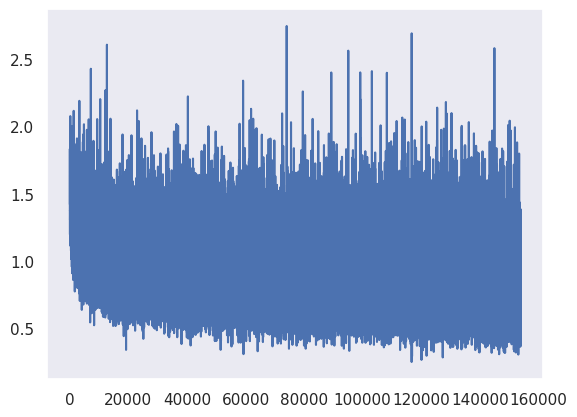

In [39]:
plt.plot(train_losses)

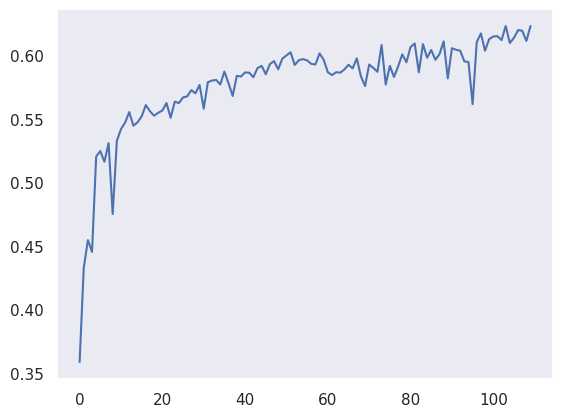

In [40]:
plt.plot(test_accuracy)

In [41]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13ser_best_104epoch.pt
Correct: 3491/5600 (0.6234)
{'acc_detail': tensor([0.5921, 0.6800, 0.7079, 0.5136], device='cuda:0'),
 'acc_unweighted': tensor(0.6234, device='cuda:0'),
 'acc_weighted': tensor(0.6234, device='cuda:0'),
 'f1s_detail': tensor([0.6350, 0.6340, 0.7038, 0.5191], device='cuda:0'),
 'f1s_unweighted': tensor(0.6230, device='cuda:0'),
 'f1s_weighted': tensor(0.6230, device='cuda:0'),
 'precision_detail': tensor([0.6846, 0.5939, 0.6999, 0.5248], device='cuda:0'),
 'recall_detail': tensor([0.5921, 0.6800, 0.7079, 0.5136], device='cuda:0'),
 'rocauc': tensor(0.8628, device='cuda:0'),
 'rocauc_detail': tensor([0.8827, 0.8732, 0.8975, 0.7978], device='cuda:0'),
 'uar': tensor(0.6234, device='cuda:0'),
 'wap': tensor(0.6258, device='cuda:0')}


tensor([[829, 130,  77, 364],
        [ 42, 952, 224, 182],
        [ 56, 248, 991, 105],
        [284, 273, 124, 719]], device='cuda:0')

In [42]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [43]:
start_epoch = epoch+1
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                  | 0.0005714285714285715/50 [00:00<11:22:41, 819.23s/it]

Train Epoch: 112 [0/22400 (0%)]	Loss: 0.490735
Mem before-during-after: 66883072 5356521984 69202944


  0%|                                                                  | 0.023428571428571413/50 [00:20<14:09:36, 1020.00s/it]

Train Epoch: 112 [640/22400 (3%)]	Loss: 0.701595
Mem before-during-after: 69602304 5355913728 69179392


  0%|                                                                   | 0.046285714285714215/50 [00:39<12:50:11, 925.09s/it]

Train Epoch: 112 [1280/22400 (6%)]	Loss: 0.843445
Mem before-during-after: 69226496 5356409344 69675008


  0%|                                                                    | 0.06914285714285702/50 [00:59<12:51:40, 927.30s/it]

Train Epoch: 112 [1920/22400 (9%)]	Loss: 0.848538
Mem before-during-after: 69179392 5355960832 69179392


  0%|▏                                                                   | 0.09199999999999982/50 [01:20<12:56:16, 933.25s/it]

Train Epoch: 112 [2560/22400 (11%)]	Loss: 0.892270
Mem before-during-after: 69179392 5357252096 69602304


  0%|▏                                                                   | 0.11485714285714262/50 [01:39<12:47:41, 923.36s/it]

Train Epoch: 112 [3200/22400 (14%)]	Loss: 0.950978
Mem before-during-after: 69179392 5356852736 70118400


  0%|▏                                                                  | 0.13771428571428573/50 [02:00<14:40:28, 1059.49s/it]

Train Epoch: 112 [3840/22400 (17%)]	Loss: 0.914867
Mem before-during-after: 69179392 5399071232 69833728


  0%|▏                                                                    | 0.1605714285714291/50 [02:19<12:58:59, 937.80s/it]

Train Epoch: 112 [4480/22400 (20%)]	Loss: 0.574382
Mem before-during-after: 69416448 5356967936 69179392


  0%|▏                                                                   | 0.18342857142857244/50 [02:40<12:48:37, 925.74s/it]

Train Epoch: 112 [5120/22400 (23%)]	Loss: 0.904899
Mem before-during-after: 69202944 5355960832 69179392


  0%|▎                                                                    | 0.2062857142857158/50 [03:00<12:48:10, 925.62s/it]

Train Epoch: 112 [5760/22400 (26%)]	Loss: 0.737125
Mem before-during-after: 70467584 5360029696 70924288


  0%|▎                                                                  | 0.22914285714285915/50 [03:20<14:30:56, 1049.95s/it]

Train Epoch: 112 [6400/22400 (29%)]	Loss: 0.859906
Mem before-during-after: 69602304 5355937280 69202944


  1%|▎                                                                    | 0.2520000000000024/50 [03:41<13:05:14, 947.06s/it]

Train Epoch: 112 [7040/22400 (31%)]	Loss: 0.842680
Mem before-during-after: 69179392 5355937280 69202944


  1%|▎                                                                   | 0.27485714285714463/50 [04:02<13:07:19, 950.01s/it]

Train Epoch: 112 [7680/22400 (34%)]	Loss: 0.842363
Mem before-during-after: 69957120 5357606912 70118400


  1%|▍                                                                    | 0.2977142857142869/50 [04:21<12:49:58, 929.51s/it]

Train Epoch: 112 [8320/22400 (37%)]	Loss: 0.754154
Mem before-during-after: 69179392 5356852736 70118400


  1%|▍                                                                    | 0.3205714285714291/50 [04:41<13:08:12, 951.96s/it]

Train Epoch: 112 [8960/22400 (40%)]	Loss: 1.036739
Mem before-during-after: 69651456 5357012480 69179392


  1%|▍                                                                   | 0.34342857142857136/50 [05:01<13:24:35, 972.18s/it]

Train Epoch: 112 [9600/22400 (43%)]	Loss: 0.691046
Mem before-during-after: 69179392 5152698880 70093824


  1%|▌                                                                    | 0.3662857142857136/50 [05:21<13:37:09, 987.83s/it]

Train Epoch: 112 [10240/22400 (46%)]	Loss: 0.939425
Mem before-during-after: 69602304 5356683264 69322240


  1%|▌                                                                   | 0.38914285714285585/50 [05:41<13:25:43, 974.45s/it]

Train Epoch: 112 [10880/22400 (49%)]	Loss: 1.373791
Mem before-during-after: 69179392 4610899968 69667840


  1%|▌                                                                    | 0.4119999999999981/50 [06:01<12:52:15, 934.40s/it]

Train Epoch: 112 [11520/22400 (51%)]	Loss: 0.862761
Mem before-during-after: 69179392 5357859840 69179392


  1%|▌                                                                  | 0.43485714285714033/50 [06:20<13:47:54, 1002.21s/it]

Train Epoch: 112 [12160/22400 (54%)]	Loss: 0.766019
Mem before-during-after: 70526976 5357705728 70023168


  1%|▋                                                                    | 0.4577142857142826/50 [06:39<13:05:57, 951.86s/it]

Train Epoch: 112 [12800/22400 (57%)]	Loss: 1.190648
Mem before-during-after: 69179392 4776040960 69798912


  1%|▋                                                                    | 0.4805714285714248/50 [06:59<12:34:35, 914.29s/it]

Train Epoch: 112 [13440/22400 (60%)]	Loss: 1.127122
Mem before-during-after: 69416448 5356967936 69179392


  1%|▋                                                                    | 0.5034285714285671/50 [07:19<13:24:54, 975.72s/it]

Train Epoch: 112 [14080/22400 (63%)]	Loss: 1.075964
Mem before-during-after: 69179392 5355913728 69179392


  1%|▋                                                                    | 0.5262857142857094/50 [07:38<12:40:55, 922.82s/it]

Train Epoch: 112 [14720/22400 (66%)]	Loss: 1.016780
Mem before-during-after: 69179392 5355920384 69179392


  1%|▊                                                                    | 0.5491428571428516/50 [07:58<12:38:08, 919.87s/it]

Train Epoch: 112 [15360/22400 (69%)]	Loss: 0.869727
Mem before-during-after: 69179392 5355936768 69179392


  1%|▊                                                                   | 0.5719999999999938/50 [08:18<14:23:49, 1048.59s/it]

Train Epoch: 112 [16000/22400 (71%)]	Loss: 1.093048
Mem before-during-after: 69813248 5360930304 69602304


  1%|▊                                                                    | 0.5948571428571361/50 [08:37<12:33:40, 915.29s/it]

Train Epoch: 112 [16640/22400 (74%)]	Loss: 0.652157
Mem before-during-after: 69179392 5355913728 69179392


  1%|▊                                                                    | 0.6177142857142783/50 [08:56<12:52:48, 938.97s/it]

Train Epoch: 112 [17280/22400 (77%)]	Loss: 0.831468
Mem before-during-after: 70025216 5356808704 70074368


  1%|▉                                                                    | 0.6405714285714206/50 [09:16<13:20:48, 973.45s/it]

Train Epoch: 112 [17920/22400 (80%)]	Loss: 1.183334
Mem before-during-after: 69602304 5355913728 69179392


  1%|▉                                                                    | 0.6634285714285628/50 [09:35<12:43:12, 928.16s/it]

Train Epoch: 112 [18560/22400 (83%)]	Loss: 0.615565
Mem before-during-after: 69179392 5355913728 69179392


  1%|▉                                                                   | 0.6862857142857051/50 [09:56<15:18:49, 1117.93s/it]

Train Epoch: 112 [19200/22400 (86%)]	Loss: 0.715525
Mem before-during-after: 69770240 5361157632 69602304


  1%|▉                                                                    | 0.7091428571428473/50 [10:15<12:50:59, 938.50s/it]

Train Epoch: 112 [19840/22400 (89%)]	Loss: 0.895827
Mem before-during-after: 69179392 5355913728 69179392


  1%|█                                                                    | 0.7319999999999895/50 [10:36<12:55:54, 944.93s/it]

Train Epoch: 112 [20480/22400 (91%)]	Loss: 0.682966
Mem before-during-after: 69497856 5357382656 69602304


  2%|█                                                                    | 0.7548571428571318/50 [10:55<13:02:13, 953.06s/it]

Train Epoch: 112 [21120/22400 (94%)]	Loss: 0.654995
Mem before-during-after: 69497856 5357147648 70118400


  2%|█                                                                     | 0.777714285714274/50 [11:15<12:29:10, 913.22s/it]

Train Epoch: 112 [21760/22400 (97%)]	Loss: 1.175898
Mem before-during-after: 69416448 5356967936 69179392


  2%|█▍                                                                    | 0.9999999999999823/50 [13:08<6:20:28, 465.90s/it]


Test Epoch: 112	Accuracy: 3496/5600 (62%)

saved model: ../models_esd4/esd4_m13ser_best_112epoch.pt


  2%|█▍                                                                     | 1.000571428571411/50 [13:08<7:47:14, 572.15s/it]

Train Epoch: 113 [0/22400 (0%)]	Loss: 0.767416
Mem before-during-after: 69172224 5361138688 69179392


  2%|█▍                                                                   | 1.0234285714285576/50 [13:29<13:34:19, 997.61s/it]

Train Epoch: 113 [640/22400 (3%)]	Loss: 1.081879
Mem before-during-after: 69322240 5356336640 69602304


  2%|█▍                                                                   | 1.0462857142857043/50 [13:49<12:50:32, 944.41s/it]

Train Epoch: 113 [1280/22400 (6%)]	Loss: 0.709437
Mem before-during-after: 69179392 5355913728 69179392


  2%|█▍                                                                    | 1.069142857142851/50 [14:09<12:44:06, 936.96s/it]

Train Epoch: 113 [1920/22400 (9%)]	Loss: 0.662707
Mem before-during-after: 69202944 5355913728 69179392


  2%|█▌                                                                   | 1.0919999999999976/50 [14:29<13:13:31, 973.50s/it]

Train Epoch: 113 [2560/22400 (11%)]	Loss: 0.921536
Mem before-during-after: 70494720 5356208640 69179392


  2%|█▌                                                                   | 1.1148571428571443/50 [14:48<12:52:38, 948.32s/it]

Train Epoch: 113 [3200/22400 (14%)]	Loss: 1.007421
Mem before-during-after: 69202944 5148695040 69416448


  2%|█▌                                                                   | 1.137714285714291/50 [15:08<13:41:37, 1008.91s/it]

Train Epoch: 113 [3840/22400 (17%)]	Loss: 1.024330
Mem before-during-after: 69651456 4480649728 69593088


  2%|█▌                                                                   | 1.1605714285714377/50 [15:28<12:58:44, 956.71s/it]

Train Epoch: 113 [4480/22400 (20%)]	Loss: 1.698542
Mem before-during-after: 69179392 4688185344 69179392


  2%|█▋                                                                   | 1.1834285714285844/50 [15:48<12:28:45, 920.29s/it]

Train Epoch: 113 [5120/22400 (23%)]	Loss: 0.873499
Mem before-during-after: 69751808 5356509696 69179392


  2%|█▋                                                                    | 1.206285714285731/50 [16:08<12:57:39, 956.26s/it]

Train Epoch: 113 [5760/22400 (26%)]	Loss: 0.730491
Mem before-during-after: 69179392 5355960832 69179392


  2%|█▋                                                                  | 1.2291428571428777/50 [16:28<14:06:43, 1041.68s/it]

Train Epoch: 113 [6400/22400 (29%)]	Loss: 0.977508
Mem before-during-after: 69897216 5360108032 69179392


  3%|█▋                                                                  | 1.2520000000000244/50 [16:48<14:53:46, 1100.07s/it]

Train Epoch: 113 [7040/22400 (31%)]	Loss: 0.660462
Mem before-during-after: 69179392 5363669504 69619712


  3%|█▊                                                                    | 1.274857142857171/50 [17:07<12:27:56, 921.01s/it]

Train Epoch: 113 [7680/22400 (34%)]	Loss: 0.827799
Mem before-during-after: 69179392 5355937280 69202944


  3%|█▊                                                                   | 1.2977142857143178/50 [17:28<13:26:07, 993.12s/it]

Train Epoch: 113 [8320/22400 (37%)]	Loss: 0.859692
Mem before-during-after: 70025216 5357208064 70025216


  3%|█▊                                                                   | 1.3205714285714645/50 [17:48<12:36:56, 932.97s/it]

Train Epoch: 113 [8960/22400 (40%)]	Loss: 0.811102
Mem before-during-after: 69179392 5324221440 70224896


  3%|█▊                                                                   | 1.3434285714286112/50 [18:07<12:24:24, 917.95s/it]

Train Epoch: 113 [9600/22400 (43%)]	Loss: 0.797413
Mem before-during-after: 69873664 5357499904 69179392


  3%|█▉                                                                   | 1.3662857142857578/50 [18:27<12:24:09, 918.07s/it]

Train Epoch: 113 [10240/22400 (46%)]	Loss: 0.830530
Mem before-during-after: 69873664 5356631552 69179392


  3%|█▉                                                                   | 1.3891428571429045/50 [18:46<12:26:28, 921.36s/it]

Train Epoch: 113 [10880/22400 (49%)]	Loss: 0.919790
Mem before-during-after: 69179392 5355944448 69179392


  3%|█▉                                                                   | 1.4120000000000512/50 [19:05<12:32:49, 929.64s/it]

Train Epoch: 113 [11520/22400 (51%)]	Loss: 0.810148
Mem before-during-after: 69179392 5356852736 70118400


  3%|█▉                                                                   | 1.434857142857198/50 [19:25<14:18:11, 1060.26s/it]

Train Epoch: 113 [12160/22400 (54%)]	Loss: 0.655047
Mem before-during-after: 69336064 5361162752 70100992


  3%|██                                                                   | 1.4577142857143446/50 [19:45<12:29:06, 925.92s/it]

Train Epoch: 113 [12800/22400 (57%)]	Loss: 0.665616
Mem before-during-after: 69179392 5355913728 69179392


  3%|██                                                                  | 1.4805714285714913/50 [20:05<13:43:46, 1018.70s/it]

Train Epoch: 113 [13440/22400 (60%)]	Loss: 0.687732
Mem before-during-after: 70118400 5357295616 69646336


  3%|██                                                                    | 1.503428571428638/50 [20:25<13:05:40, 972.05s/it]

Train Epoch: 113 [14080/22400 (63%)]	Loss: 0.741309
Mem before-during-after: 69602304 5355960832 69226496


  3%|██                                                                   | 1.5262857142857846/50 [20:45<12:20:55, 917.11s/it]

Train Epoch: 113 [14720/22400 (66%)]	Loss: 0.947509
Mem before-during-after: 69322240 5356132864 69398528


  3%|██▏                                                                  | 1.5491428571429313/50 [21:05<12:28:49, 927.33s/it]

Train Epoch: 113 [15360/22400 (69%)]	Loss: 1.120989
Mem before-during-after: 69179392 5357899776 69195776


  3%|██▏                                                                   | 1.572000000000078/50 [21:25<12:25:27, 923.58s/it]

Train Epoch: 113 [16000/22400 (71%)]	Loss: 0.899968
Mem before-during-after: 69179392 5355913728 69179392


  3%|██▏                                                                 | 1.5948571428572247/50 [21:47<14:26:43, 1074.33s/it]

Train Epoch: 113 [16640/22400 (74%)]	Loss: 0.738515
Mem before-during-after: 69672448 4693702144 69202944


  3%|██▏                                                                  | 1.6177142857143714/50 [22:06<12:32:27, 933.14s/it]

Train Epoch: 113 [17280/22400 (77%)]	Loss: 0.744193
Mem before-during-after: 70118400 5356599296 69416448


  3%|██▎                                                                   | 1.640571428571518/50 [22:26<12:18:28, 916.24s/it]

Train Epoch: 113 [17920/22400 (80%)]	Loss: 0.666055
Mem before-during-after: 69179392 5355913728 69179392


  3%|██▎                                                                 | 1.6634285714286647/50 [22:46<13:47:59, 1027.78s/it]

Train Epoch: 113 [18560/22400 (83%)]	Loss: 0.610467
Mem before-during-after: 70543872 5361162752 70134784


  3%|██▎                                                                  | 1.6862857142858114/50 [23:07<12:40:04, 943.92s/it]

Train Epoch: 113 [19200/22400 (86%)]	Loss: 0.949321
Mem before-during-after: 69179392 5355960832 69179392


  3%|██▍                                                                   | 1.709142857142958/50 [23:27<13:18:37, 992.26s/it]

Train Epoch: 113 [19840/22400 (89%)]	Loss: 1.303592
Mem before-during-after: 69179392 4606557696 69179392


  3%|██▍                                                                  | 1.7320000000001048/50 [23:47<13:16:43, 990.37s/it]

Train Epoch: 113 [20480/22400 (91%)]	Loss: 0.721678
Mem before-during-after: 70520832 5355913728 69179392


  4%|██▍                                                                 | 1.7548571428572515/50 [24:07<14:16:43, 1065.46s/it]

Train Epoch: 113 [21120/22400 (94%)]	Loss: 1.045601
Mem before-during-after: 69790208 5193702400 70126592


  4%|██▍                                                                  | 1.7777142857143982/50 [24:27<12:33:52, 938.01s/it]

Train Epoch: 113 [21760/22400 (97%)]	Loss: 0.673942
Mem before-during-after: 69202944 5357788672 69202944


  4%|██▊                                                                   | 2.0000000000001497/50 [26:20<6:12:52, 466.10s/it]


Test Epoch: 113	Accuracy: 3452/5600 (62%)



  4%|██▊                                                                    | 2.000571428571578/50 [26:21<7:36:11, 570.25s/it]

Train Epoch: 114 [0/22400 (0%)]	Loss: 0.717495
Mem before-during-after: 69172224 5361138688 69179392


  4%|██▊                                                                  | 2.023428571428716/50 [26:41<13:27:45, 1010.20s/it]

Train Epoch: 114 [640/22400 (3%)]	Loss: 0.882931
Mem before-during-after: 69202944 5355937280 69202944


  4%|██▊                                                                  | 2.0462857142858537/50 [27:01<12:46:16, 958.76s/it]

Train Epoch: 114 [1280/22400 (6%)]	Loss: 0.842937
Mem before-during-after: 69179392 5355913728 69179392


  4%|██▊                                                                  | 2.0691428571429915/50 [27:20<12:19:07, 925.24s/it]

Train Epoch: 114 [1920/22400 (9%)]	Loss: 1.113518
Mem before-during-after: 69202944 5355913728 69179392


  4%|██▊                                                                 | 2.0920000000001293/50 [27:40<13:19:42, 1001.55s/it]

Train Epoch: 114 [2560/22400 (11%)]	Loss: 0.887802
Mem before-during-after: 69416448 5351955456 69829632


  4%|██▉                                                                   | 2.114857142857267/50 [27:59<12:18:29, 925.33s/it]

Train Epoch: 114 [3200/22400 (14%)]	Loss: 0.913160
Mem before-during-after: 69179392 5357883392 69202944


  4%|██▉                                                                   | 2.137714285714405/50 [28:19<12:44:24, 958.25s/it]

Train Epoch: 114 [3840/22400 (17%)]	Loss: 0.613849
Mem before-during-after: 69179392 5355913728 69179392


  4%|██▉                                                                 | 2.1605714285715427/50 [28:38<15:01:24, 1130.54s/it]

Train Epoch: 114 [4480/22400 (20%)]	Loss: 0.683902
Mem before-during-after: 70347776 5360108032 69179392


  4%|███                                                                  | 2.1834285714286805/50 [28:58<12:21:29, 930.42s/it]

Train Epoch: 114 [5120/22400 (23%)]	Loss: 0.892772
Mem before-during-after: 69179392 5355944448 69179392


  4%|███                                                                  | 2.2062857142858183/50 [29:18<13:03:25, 983.50s/it]

Train Epoch: 114 [5760/22400 (26%)]	Loss: 1.052132
Mem before-during-after: 69829632 5356557312 69322240


  4%|███                                                                   | 2.229142857142956/50 [29:39<12:33:47, 946.76s/it]

Train Epoch: 114 [6400/22400 (29%)]	Loss: 0.970091
Mem before-during-after: 69179392 5355913728 69179392


  5%|███▏                                                                  | 2.252000000000094/50 [29:59<12:13:51, 922.16s/it]

Train Epoch: 114 [7040/22400 (31%)]	Loss: 1.079134
Mem before-during-after: 69179392 5356765184 69179392


  5%|███▏                                                                 | 2.2748571428572317/50 [30:19<12:13:04, 921.61s/it]

Train Epoch: 114 [7680/22400 (34%)]	Loss: 0.857171
Mem before-during-after: 69179392 5328798720 69179392


  5%|███                                                                 | 2.2977142857143695/50 [30:38<13:15:39, 1000.77s/it]

Train Epoch: 114 [8320/22400 (37%)]	Loss: 0.694454
Mem before-during-after: 69179392 5356205056 69322240


  5%|███▏                                                                 | 2.3205714285715073/50 [30:59<12:24:06, 936.40s/it]

Train Epoch: 114 [8960/22400 (40%)]	Loss: 0.845023
Mem before-during-after: 69179392 5355960832 69179392


  5%|███▎                                                                  | 2.343428571428645/50 [31:19<12:58:32, 980.18s/it]

Train Epoch: 114 [9600/22400 (43%)]	Loss: 0.895501
Mem before-during-after: 69179392 5356681728 69893120


  5%|███▎                                                                  | 2.366285714285783/50 [31:39<12:29:09, 943.66s/it]

Train Epoch: 114 [10240/22400 (46%)]	Loss: 0.709811
Mem before-during-after: 69416448 5355913728 69179392


  5%|███▎                                                                 | 2.3891428571429207/50 [31:59<12:07:48, 917.20s/it]

Train Epoch: 114 [10880/22400 (49%)]	Loss: 1.030845
Mem before-during-after: 69179392 5356829184 69179392


  5%|███▎                                                                | 2.4120000000000585/50 [32:18<13:39:47, 1033.61s/it]

Train Epoch: 114 [11520/22400 (51%)]	Loss: 0.764357
Mem before-during-after: 69602304 5358652416 69884928


  5%|███▎                                                                 | 2.4348571428571963/50 [32:38<12:57:19, 980.53s/it]

Train Epoch: 114 [12160/22400 (54%)]	Loss: 0.570285
Mem before-during-after: 69179392 5193099264 69351424


  5%|███▍                                                                  | 2.457714285714334/50 [32:58<12:57:45, 981.55s/it]

Train Epoch: 114 [12800/22400 (57%)]	Loss: 0.716850
Mem before-during-after: 69798912 5360926208 69875200


  5%|███▍                                                                  | 2.480571428571472/50 [33:18<12:07:14, 918.24s/it]

Train Epoch: 114 [13440/22400 (60%)]	Loss: 0.537503
Mem before-during-after: 69986304 5355913728 69179392


  5%|███▍                                                                 | 2.5034285714286098/50 [33:37<12:11:13, 923.73s/it]

Train Epoch: 114 [14080/22400 (63%)]	Loss: 0.797190
Mem before-during-after: 70621184 5356705280 69970944


  5%|███▍                                                                | 2.5262857142857476/50 [33:57<13:31:57, 1026.19s/it]

Train Epoch: 114 [14720/22400 (66%)]	Loss: 0.802678
Mem before-during-after: 69179392 5352267776 69179392


  5%|███▌                                                                 | 2.5491428571428854/50 [34:18<12:35:47, 955.68s/it]

Train Epoch: 114 [15360/22400 (69%)]	Loss: 1.435021
Mem before-during-after: 69179392 4816735232 69179392


  5%|███▌                                                                  | 2.572000000000023/50 [34:37<12:17:12, 932.62s/it]

Train Epoch: 114 [16000/22400 (71%)]	Loss: 0.815277
Mem before-during-after: 69202944 5355913728 69179392


  5%|███▌                                                                 | 2.594857142857161/50 [34:57<13:25:59, 1020.13s/it]

Train Epoch: 114 [16640/22400 (74%)]	Loss: 0.694419
Mem before-during-after: 69179392 5356385792 69651456


  5%|███▌                                                                | 2.6177142857142988/50 [35:17<14:08:01, 1073.84s/it]

Train Epoch: 114 [17280/22400 (77%)]	Loss: 0.924829
Mem before-during-after: 69602304 5108031488 70061056


  5%|███▋                                                                 | 2.6405714285714366/50 [35:37<12:51:09, 976.99s/it]

Train Epoch: 114 [17920/22400 (80%)]	Loss: 0.403362
Mem before-during-after: 69179392 5355937280 69202944


  5%|███▋                                                                 | 2.6634285714285744/50 [35:56<12:05:51, 920.05s/it]

Train Epoch: 114 [18560/22400 (83%)]	Loss: 1.111151
Mem before-during-after: 69179392 5356812800 69179392


  5%|███▊                                                                  | 2.686285714285712/50 [36:16<12:14:36, 931.59s/it]

Train Epoch: 114 [19200/22400 (86%)]	Loss: 0.797478
Mem before-during-after: 69179392 5356812800 69179392


  5%|███▊                                                                   | 2.70914285714285/50 [36:36<12:25:32, 945.90s/it]

Train Epoch: 114 [19840/22400 (89%)]	Loss: 1.533291
Mem before-during-after: 69651456 5356385792 69202944


  5%|███▊                                                                 | 2.7319999999999878/50 [36:56<12:04:14, 919.32s/it]

Train Epoch: 114 [20480/22400 (91%)]	Loss: 1.092068
Mem before-during-after: 69651456 5356385792 69202944


  6%|███▊                                                                 | 2.7548571428571256/50 [37:16<13:02:46, 994.09s/it]

Train Epoch: 114 [21120/22400 (94%)]	Loss: 0.994090
Mem before-during-after: 69888000 5361157632 69602304


  6%|███▊                                                                 | 2.7777142857142634/50 [37:36<11:59:34, 914.28s/it]

Train Epoch: 114 [21760/22400 (97%)]	Loss: 0.865448
Mem before-during-after: 69179392 5355984384 69202944


  6%|████▏                                                                 | 2.9999999999999285/50 [39:29<6:24:41, 491.10s/it]


Test Epoch: 114	Accuracy: 3472/5600 (62%)



  6%|████▎                                                                  | 3.000571428571357/50 [39:29<7:40:09, 587.45s/it]

Train Epoch: 115 [0/22400 (0%)]	Loss: 0.800006
Mem before-during-after: 69172224 5361138688 69179392


  6%|████▏                                                                | 3.0234285714284947/50 [39:50<12:25:33, 952.26s/it]

Train Epoch: 115 [640/22400 (3%)]	Loss: 0.941054
Mem before-during-after: 69179392 5356960768 69202944


  6%|████▏                                                                | 3.0462857142856326/50 [40:09<11:53:54, 912.28s/it]

Train Epoch: 115 [1280/22400 (6%)]	Loss: 0.731414
Mem before-during-after: 69179392 5356812800 69179392


  6%|████▏                                                                | 3.0691428571427704/50 [40:29<12:08:56, 931.94s/it]

Train Epoch: 115 [1920/22400 (9%)]	Loss: 0.411152
Mem before-during-after: 69179392 5355913728 69179392


  6%|████▎                                                                 | 3.091999999999908/50 [40:48<12:56:25, 993.12s/it]

Train Epoch: 115 [2560/22400 (11%)]	Loss: 0.433303
Mem before-during-after: 69202944 5357855232 69416448


  6%|████▎                                                                 | 3.114857142857046/50 [41:09<12:02:13, 924.24s/it]

Train Epoch: 115 [3200/22400 (14%)]	Loss: 0.903029
Mem before-during-after: 69416448 5356967936 69179392


  6%|████▎                                                                | 3.1377142857141838/50 [41:28<12:11:34, 936.67s/it]

Train Epoch: 115 [3840/22400 (17%)]	Loss: 0.511221
Mem before-during-after: 69179392 5355960832 69179392


  6%|████▎                                                                | 3.1605714285713216/50 [41:49<12:33:20, 965.02s/it]

Train Epoch: 115 [4480/22400 (20%)]	Loss: 0.531761
Mem before-during-after: 69226496 5356360192 69625856


  6%|████▍                                                                | 3.1834285714284594/50 [42:09<12:21:21, 950.13s/it]

Train Epoch: 115 [5120/22400 (23%)]	Loss: 0.815868
Mem before-during-after: 69179392 5355913728 69179392


  6%|████▍                                                                 | 3.206285714285597/50 [42:29<11:57:47, 920.37s/it]

Train Epoch: 115 [5760/22400 (26%)]	Loss: 0.627577
Mem before-during-after: 69179392 5355913728 69179392


  6%|████▌                                                                 | 3.229142857142735/50 [42:48<11:51:22, 912.59s/it]

Train Epoch: 115 [6400/22400 (29%)]	Loss: 0.960573
Mem before-during-after: 69179392 5355937280 69202944


  7%|████▍                                                                | 3.2519999999998728/50 [43:08<11:51:18, 912.94s/it]

Train Epoch: 115 [7040/22400 (31%)]	Loss: 0.642561
Mem before-during-after: 69179392 5355913728 69179392


  7%|████▌                                                                | 3.2748571428570106/50 [43:27<12:31:36, 965.14s/it]

Train Epoch: 115 [7680/22400 (34%)]	Loss: 0.536669
Mem before-during-after: 69602304 5355913728 69179392


  7%|████▌                                                                | 3.2977142857141484/50 [43:47<12:16:25, 946.11s/it]

Train Epoch: 115 [8320/22400 (37%)]	Loss: 1.079638
Mem before-during-after: 69179392 5299324928 69248000


  7%|████▋                                                                 | 3.320571428571286/50 [44:07<12:56:45, 998.41s/it]

Train Epoch: 115 [8960/22400 (40%)]	Loss: 0.783760
Mem before-during-after: 69179392 5356362240 69179392


  7%|████▋                                                                 | 3.343428571428424/50 [44:27<12:10:53, 939.91s/it]

Train Epoch: 115 [9600/22400 (43%)]	Loss: 1.097328
Mem before-during-after: 69651456 5358493696 69388288


  7%|████▋                                                                 | 3.366285714285562/50 [44:47<12:37:13, 974.26s/it]

Train Epoch: 115 [10240/22400 (46%)]	Loss: 1.023009
Mem before-during-after: 70252544 5356785152 69602304


  7%|████▌                                                               | 3.3891428571426996/50 [45:06<13:29:23, 1041.89s/it]

Train Epoch: 115 [10880/22400 (49%)]	Loss: 0.987748
Mem before-during-after: 69179392 5250322432 70159360


  7%|████▋                                                                | 3.4119999999998374/50 [45:25<12:34:43, 972.00s/it]

Train Epoch: 115 [11520/22400 (51%)]	Loss: 0.583290
Mem before-during-after: 69602304 5356336640 69602304


  7%|████▊                                                                 | 3.434857142856975/50 [45:45<12:53:54, 997.20s/it]

Train Epoch: 115 [12160/22400 (54%)]	Loss: 0.648707
Mem before-during-after: 69179392 5356812800 69179392


  7%|████▊                                                                 | 3.457714285714113/50 [46:05<11:57:45, 925.30s/it]

Train Epoch: 115 [12800/22400 (57%)]	Loss: 1.238526
Mem before-during-after: 69179392 5357855232 69416448


  7%|████▊                                                                 | 3.480571428571251/50 [46:24<11:49:53, 915.60s/it]

Train Epoch: 115 [13440/22400 (60%)]	Loss: 0.744067
Mem before-during-after: 69202944 5356150784 69416448


  7%|████▊                                                                | 3.5034285714283886/50 [46:44<11:50:10, 916.43s/it]

Train Epoch: 115 [14080/22400 (63%)]	Loss: 1.247126
Mem before-during-after: 69179392 5355913728 69179392


  7%|████▊                                                                | 3.5262857142855264/50 [47:04<11:49:53, 916.50s/it]

Train Epoch: 115 [14720/22400 (66%)]	Loss: 0.601661
Mem before-during-after: 69179392 5355944448 69179392


  7%|████▉                                                                | 3.549142857142664/50 [47:24<13:27:59, 1043.67s/it]

Train Epoch: 115 [15360/22400 (69%)]	Loss: 1.217319
Mem before-during-after: 71044096 5019181056 71044096


  7%|█████                                                                 | 3.571999999999802/50 [47:44<12:01:53, 932.92s/it]

Train Epoch: 115 [16000/22400 (71%)]	Loss: 0.692531
Mem before-during-after: 69551104 5357177344 69179392


  7%|█████                                                                  | 3.59485714285694/50 [48:03<11:50:47, 919.03s/it]

Train Epoch: 115 [16640/22400 (74%)]	Loss: 0.575891
Mem before-during-after: 69551104 5357177344 69179392


  7%|████▉                                                                | 3.6177142857140776/50 [48:23<12:02:08, 934.16s/it]

Train Epoch: 115 [17280/22400 (77%)]	Loss: 0.947541
Mem before-during-after: 69179392 5357200896 69551104


  7%|█████                                                                | 3.6405714285712154/50 [48:42<11:45:46, 913.44s/it]

Train Epoch: 115 [17920/22400 (80%)]	Loss: 0.657078
Mem before-during-after: 69551104 5356308992 69179392


  7%|█████▏                                                                | 3.663428571428353/50 [49:03<12:11:58, 947.81s/it]

Train Epoch: 115 [18560/22400 (83%)]	Loss: 0.953959
Mem before-during-after: 69551104 5356308992 69179392


  7%|█████▏                                                                | 3.686285714285491/50 [49:22<11:54:35, 925.77s/it]

Train Epoch: 115 [19200/22400 (86%)]	Loss: 0.949495
Mem before-during-after: 69462016 5356219904 69179392


  7%|█████▏                                                                | 3.709142857142629/50 [49:42<12:19:13, 958.15s/it]

Train Epoch: 115 [19840/22400 (89%)]	Loss: 1.795109
Mem before-during-after: 69462016 4735042560 69179392


  7%|█████▏                                                               | 3.7319999999997666/50 [50:02<11:51:12, 922.28s/it]

Train Epoch: 115 [20480/22400 (91%)]	Loss: 1.198852
Mem before-during-after: 69462016 5299515392 69179392


  8%|█████                                                               | 3.7548571428569044/50 [50:22<12:51:45, 1001.31s/it]

Train Epoch: 115 [21120/22400 (94%)]	Loss: 0.857226
Mem before-during-after: 69672960 5360578048 69179392


  8%|█████▎                                                                | 3.777714285714042/50 [50:41<12:26:17, 968.74s/it]

Train Epoch: 115 [21760/22400 (97%)]	Loss: 0.819824
Mem before-during-after: 69179392 5355913728 69179392


  8%|█████▌                                                                | 3.9999999999997073/50 [52:34<5:58:25, 467.52s/it]


Test Epoch: 115	Accuracy: 3419/5600 (61%)



  8%|█████▋                                                                 | 4.000571428571136/50 [52:35<7:09:09, 559.79s/it]

Train Epoch: 116 [0/22400 (0%)]	Loss: 0.689809
Mem before-during-after: 69172224 5111253504 69179392


  8%|█████▋                                                                | 4.023428571428291/50 [52:55<12:18:41, 963.99s/it]

Train Epoch: 116 [640/22400 (3%)]	Loss: 1.143999
Mem before-during-after: 69179392 5355913728 69179392


  8%|█████▋                                                                | 4.046285714285447/50 [53:16<11:43:01, 917.91s/it]

Train Epoch: 116 [1280/22400 (6%)]	Loss: 0.643313
Mem before-during-after: 69179392 5355960832 69179392


  8%|█████▌                                                               | 4.0691428571426025/50 [53:35<11:53:14, 931.70s/it]

Train Epoch: 116 [1920/22400 (9%)]	Loss: 0.661976
Mem before-during-after: 69179392 5355913728 69179392


  8%|█████▋                                                                | 4.091999999999758/50 [53:55<11:39:17, 913.94s/it]

Train Epoch: 116 [2560/22400 (11%)]	Loss: 0.782387
Mem before-during-after: 69179392 5355960832 69179392


  8%|█████▊                                                                | 4.114857142856914/50 [54:14<11:45:53, 923.03s/it]

Train Epoch: 116 [3200/22400 (14%)]	Loss: 1.022952
Mem before-during-after: 70615040 5357349376 70615040


  8%|█████▊                                                                | 4.137714285714069/50 [54:34<11:37:32, 912.56s/it]

Train Epoch: 116 [3840/22400 (17%)]	Loss: 0.525877
Mem before-during-after: 69202944 5356150784 69416448


  8%|█████▊                                                                | 4.160571428571225/50 [54:54<11:59:24, 941.64s/it]

Train Epoch: 116 [4480/22400 (20%)]	Loss: 0.758455
Mem before-during-after: 69179392 5357081088 69431296


  8%|█████▉                                                                 | 4.18342857142838/50 [55:13<12:38:37, 993.47s/it]

Train Epoch: 116 [5120/22400 (23%)]	Loss: 1.058786
Mem before-during-after: 69179392 5361207808 69431296


  8%|█████▉                                                                | 4.206285714285536/50 [55:34<12:11:41, 958.68s/it]

Train Epoch: 116 [5760/22400 (26%)]	Loss: 0.763763
Mem before-during-after: 69322240 5357012480 69829632


  8%|█████▊                                                               | 4.2291428571426914/50 [55:53<11:36:23, 912.88s/it]

Train Epoch: 116 [6400/22400 (29%)]	Loss: 0.743376
Mem before-during-after: 69854208 5356612096 69179392


  9%|█████▉                                                                | 4.251999999999847/50 [56:13<12:21:12, 972.12s/it]

Train Epoch: 116 [7040/22400 (31%)]	Loss: 1.087237
Mem before-during-after: 69179392 5355913728 69179392


  9%|█████▉                                                                | 4.274857142857003/50 [56:33<12:39:22, 996.44s/it]

Train Epoch: 116 [7680/22400 (34%)]	Loss: 0.987126
Mem before-during-after: 69602304 5355913728 69179392


  9%|██████                                                                | 4.297714285714158/50 [56:52<12:21:40, 973.70s/it]

Train Epoch: 116 [8320/22400 (37%)]	Loss: 0.834878
Mem before-during-after: 69602304 5355913728 69179392


  9%|██████                                                                | 4.320571428571314/50 [57:12<11:39:19, 918.56s/it]

Train Epoch: 116 [8960/22400 (40%)]	Loss: 0.909293
Mem before-during-after: 69202944 5357855232 69416448


  9%|██████                                                                | 4.343428571428469/50 [57:32<12:08:35, 957.49s/it]

Train Epoch: 116 [9600/22400 (43%)]	Loss: 1.183967
Mem before-during-after: 69179392 4817168384 69612544


  9%|██████                                                                | 4.366285714285625/50 [57:52<12:28:29, 984.12s/it]

Train Epoch: 116 [10240/22400 (46%)]	Loss: 0.821916
Mem before-during-after: 69179392 5356336640 69602304


  9%|██████▏                                                                | 4.38914285714278/50 [58:12<11:37:49, 917.97s/it]

Train Epoch: 116 [10880/22400 (49%)]	Loss: 0.688981
Mem before-during-after: 69602304 5356963328 69602304


  9%|██████▏                                                               | 4.411999999999936/50 [58:32<12:02:58, 951.53s/it]

Train Epoch: 116 [11520/22400 (51%)]	Loss: 0.457687
Mem before-during-after: 69602304 5355913728 69179392


  9%|██████                                                              | 4.4348571428570915/50 [58:52<13:41:41, 1081.99s/it]

Train Epoch: 116 [12160/22400 (54%)]	Loss: 0.808932
Mem before-during-after: 70117376 5360530944 69602304


  9%|██████▏                                                               | 4.457714285714247/50 [59:12<12:21:49, 977.32s/it]

Train Epoch: 116 [12800/22400 (57%)]	Loss: 0.681442
Mem before-during-after: 70924288 5358574080 71085568


  9%|██████▎                                                               | 4.480571428571403/50 [59:31<11:50:41, 936.77s/it]

Train Epoch: 116 [13440/22400 (60%)]	Loss: 0.970536
Mem before-during-after: 69179392 5355960832 69179392


  9%|██████▎                                                               | 4.503428571428558/50 [59:51<12:33:34, 993.81s/it]

Train Epoch: 116 [14080/22400 (63%)]	Loss: 0.837262
Mem before-during-after: 69602304 5356336640 69602304


  9%|██████▏                                                             | 4.526285714285714/50 [1:00:11<12:34:52, 996.01s/it]

Train Epoch: 116 [14720/22400 (66%)]	Loss: 0.787875
Mem before-during-after: 69179392 4775912960 69670912


  9%|██████▏                                                             | 4.549142857142869/50 [1:00:30<11:35:21, 917.94s/it]

Train Epoch: 116 [15360/22400 (69%)]	Loss: 0.862026
Mem before-during-after: 69202944 5355913728 69179392


  9%|██████▏                                                             | 4.572000000000025/50 [1:00:50<12:35:34, 997.94s/it]

Train Epoch: 116 [16000/22400 (71%)]	Loss: 0.709037
Mem before-during-after: 69602304 5355937280 69202944


  9%|██████▏                                                            | 4.5948571428571805/50 [1:01:09<11:49:26, 937.47s/it]

Train Epoch: 116 [16640/22400 (74%)]	Loss: 1.021964
Mem before-during-after: 69179392 5357855232 69463552


  9%|██████▎                                                             | 4.617714285714336/50 [1:01:30<11:47:18, 935.14s/it]

Train Epoch: 116 [17280/22400 (77%)]	Loss: 0.686829
Mem before-during-after: 69179392 5355913728 69179392


  9%|██████▎                                                             | 4.640571428571492/50 [1:01:49<11:48:01, 936.55s/it]

Train Epoch: 116 [17920/22400 (80%)]	Loss: 0.728536
Mem before-during-after: 69179392 5355913728 69179392


  9%|██████▎                                                             | 4.663428571428647/50 [1:02:08<11:54:53, 946.11s/it]

Train Epoch: 116 [18560/22400 (83%)]	Loss: 1.042230
Mem before-during-after: 69400064 5355913728 69179392


  9%|██████▎                                                             | 4.686285714285803/50 [1:02:28<11:38:42, 925.17s/it]

Train Epoch: 116 [19200/22400 (86%)]	Loss: 1.181791
Mem before-during-after: 69179392 5356812800 69179392


  9%|██████▍                                                             | 4.709142857142958/50 [1:02:48<11:33:32, 918.78s/it]

Train Epoch: 116 [19840/22400 (89%)]	Loss: 0.591634
Mem before-during-after: 69179392 5355913728 69179392


  9%|██████▍                                                             | 4.732000000000114/50 [1:03:08<11:35:43, 922.13s/it]

Train Epoch: 116 [20480/22400 (91%)]	Loss: 0.895373
Mem before-during-after: 69651456 5358308352 69202944


 10%|██████▎                                                            | 4.7548571428572695/50 [1:03:27<12:15:30, 975.35s/it]

Train Epoch: 116 [21120/22400 (94%)]	Loss: 0.937927
Mem before-during-after: 69651456 5024208896 70251520


 10%|██████▍                                                            | 4.777714285714425/50 [1:03:47<12:56:22, 1030.09s/it]

Train Epoch: 116 [21760/22400 (97%)]	Loss: 0.527021
Mem before-during-after: 69179392 5360652288 69338624


 10%|██████▉                                                              | 5.000000000000263/50 [1:05:40<5:51:04, 468.11s/it]


Test Epoch: 116	Accuracy: 3455/5600 (62%)



 10%|██████▉                                                              | 5.000571428571692/50 [1:05:41<7:09:12, 572.29s/it]

Train Epoch: 117 [0/22400 (0%)]	Loss: 0.707477
Mem before-during-after: 69172224 5361138688 69179392


 10%|██████▊                                                             | 5.023428571428847/50 [1:06:00<11:31:22, 922.31s/it]

Train Epoch: 117 [640/22400 (3%)]	Loss: 0.484562
Mem before-during-after: 69202944 5355960832 69202944


 10%|██████▊                                                             | 5.046285714286003/50 [1:06:20<11:32:00, 923.63s/it]

Train Epoch: 117 [1280/22400 (6%)]	Loss: 0.801978
Mem before-during-after: 69179392 5356205056 69322240


 10%|██████▊                                                            | 5.0691428571431585/50 [1:06:39<12:22:11, 991.11s/it]

Train Epoch: 117 [1920/22400 (9%)]	Loss: 0.703654
Mem before-during-after: 69179392 5361360384 69602304


 10%|██████▉                                                             | 5.092000000000314/50 [1:06:59<11:33:38, 926.75s/it]

Train Epoch: 117 [2560/22400 (11%)]	Loss: 0.943203
Mem before-during-after: 69179392 5355913728 69179392


 10%|██████▉                                                             | 5.11485714285747/50 [1:07:19<12:45:14, 1022.94s/it]

Train Epoch: 117 [3200/22400 (14%)]	Loss: 0.690298
Mem before-during-after: 69602304 5357809152 70025216


 10%|██████▉                                                             | 5.137714285714625/50 [1:07:39<11:50:44, 950.57s/it]

Train Epoch: 117 [3840/22400 (17%)]	Loss: 1.003618
Mem before-during-after: 69179392 5355913728 69179392


 10%|███████                                                             | 5.160571428571781/50 [1:07:58<11:20:52, 911.09s/it]

Train Epoch: 117 [4480/22400 (20%)]	Loss: 0.712937
Mem before-during-after: 69179392 5355913728 69179392


 10%|███████                                                             | 5.183428571428936/50 [1:08:17<11:27:24, 920.29s/it]

Train Epoch: 117 [5120/22400 (23%)]	Loss: 0.824990
Mem before-during-after: 69202944 5355936768 69179392


 10%|███████                                                             | 5.206285714286092/50 [1:08:38<11:25:02, 917.59s/it]

Train Epoch: 117 [5760/22400 (26%)]	Loss: 0.743706
Mem before-during-after: 69320704 5357249024 69392896


 10%|███████                                                            | 5.2291428571432474/50 [1:08:58<11:36:31, 933.45s/it]

Train Epoch: 117 [6400/22400 (29%)]	Loss: 0.628959
Mem before-during-after: 69202944 5356611072 69876736


 11%|███████▏                                                            | 5.252000000000403/50 [1:09:18<11:55:17, 959.09s/it]

Train Epoch: 117 [7040/22400 (31%)]	Loss: 0.880771
Mem before-during-after: 70118400 5324328960 69433344


 11%|███████                                                            | 5.274857142857559/50 [1:09:38<12:26:49, 1001.88s/it]

Train Epoch: 117 [7680/22400 (34%)]	Loss: 0.663225
Mem before-during-after: 69179392 5361181184 69602304


 11%|███████▏                                                            | 5.297714285714714/50 [1:09:58<11:22:43, 916.36s/it]

Train Epoch: 117 [8320/22400 (37%)]	Loss: 0.737534
Mem before-during-after: 69179392 5356205056 69322240


 11%|███████▎                                                             | 5.32057142857187/50 [1:10:17<11:21:56, 915.77s/it]

Train Epoch: 117 [8960/22400 (40%)]	Loss: 0.769497
Mem before-during-after: 69416448 5356563968 69829632


 11%|███████▏                                                           | 5.343428571429025/50 [1:10:37<12:40:35, 1021.93s/it]

Train Epoch: 117 [9600/22400 (43%)]	Loss: 0.557847
Mem before-during-after: 69304320 5357533696 69829632


 11%|███████▎                                                            | 5.366285714286181/50 [1:10:58<12:09:40, 980.88s/it]

Train Epoch: 117 [10240/22400 (46%)]	Loss: 0.624897
Mem before-during-after: 69202944 5355913728 69179392


 11%|███████▎                                                            | 5.389142857143336/50 [1:11:18<11:30:03, 928.10s/it]

Train Epoch: 117 [10880/22400 (49%)]	Loss: 0.982321
Mem before-during-after: 69872128 5356808704 70074368


 11%|███████▎                                                           | 5.412000000000492/50 [1:11:39<13:30:38, 1090.84s/it]

Train Epoch: 117 [11520/22400 (51%)]	Loss: 0.942626
Mem before-during-after: 69202944 5358088192 69602304


 11%|███████▎                                                           | 5.4348571428576475/50 [1:11:59<11:18:26, 913.42s/it]

Train Epoch: 117 [12160/22400 (54%)]	Loss: 0.846474
Mem before-during-after: 69651456 5356995072 69812224


 11%|███████▍                                                            | 5.457714285714803/50 [1:12:19<11:47:25, 952.92s/it]

Train Epoch: 117 [12800/22400 (57%)]	Loss: 1.234852
Mem before-during-after: 69428224 4648165376 70221824


 11%|███████▎                                                           | 5.480571428571959/50 [1:12:40<12:53:18, 1042.21s/it]

Train Epoch: 117 [13440/22400 (60%)]	Loss: 0.640729
Mem before-during-after: 70025216 5356336640 69602304


 11%|███████▎                                                           | 5.503428571429114/50 [1:12:59<12:25:43, 1005.54s/it]

Train Epoch: 117 [14080/22400 (63%)]	Loss: 0.813890
Mem before-during-after: 69179392 5360352256 69423616


 11%|███████▋                                                             | 5.52628571428627/50 [1:13:20<12:03:56, 976.69s/it]

Train Epoch: 117 [14720/22400 (66%)]	Loss: 0.919808
Mem before-during-after: 69440000 4562169856 69202944


 11%|███████▌                                                            | 5.549142857143425/50 [1:13:40<12:16:36, 994.27s/it]

Train Epoch: 117 [15360/22400 (69%)]	Loss: 1.021058
Mem before-during-after: 70252544 5356533760 69400064


 11%|███████▌                                                            | 5.572000000000581/50 [1:14:00<12:06:21, 980.96s/it]

Train Epoch: 117 [16000/22400 (71%)]	Loss: 0.830856
Mem before-during-after: 70252544 5356533760 69400064


 11%|███████▍                                                           | 5.5948571428577365/50 [1:14:20<11:35:04, 939.17s/it]

Train Epoch: 117 [16640/22400 (74%)]	Loss: 0.869806
Mem before-during-after: 70123520 5266179072 70246400


 11%|███████▌                                                           | 5.617714285714892/50 [1:14:41<13:22:02, 1084.27s/it]

Train Epoch: 117 [17280/22400 (77%)]	Loss: 0.832042
Mem before-during-after: 69179392 5361736192 69602304


 11%|███████▋                                                            | 5.640571428572048/50 [1:15:00<11:42:21, 949.99s/it]

Train Epoch: 117 [17920/22400 (80%)]	Loss: 0.788803
Mem before-during-after: 69179392 5355913728 69179392


 11%|███████▌                                                           | 5.663428571429203/50 [1:15:21<12:58:33, 1053.61s/it]

Train Epoch: 117 [18560/22400 (83%)]	Loss: 0.783883
Mem before-during-after: 69179392 5360651776 69723136


 11%|███████▋                                                            | 5.686285714286359/50 [1:15:41<11:17:27, 917.27s/it]

Train Epoch: 117 [19200/22400 (86%)]	Loss: 1.300868
Mem before-during-after: 69179392 5356812800 69179392


 11%|███████▋                                                           | 5.709142857143514/50 [1:16:01<13:04:52, 1063.25s/it]

Train Epoch: 117 [19840/22400 (89%)]	Loss: 1.223552
Mem before-during-after: 69602304 5355913728 69179392


 11%|███████▉                                                             | 5.73200000000067/50 [1:16:21<11:15:51, 916.05s/it]

Train Epoch: 117 [20480/22400 (91%)]	Loss: 0.851383
Mem before-during-after: 69202944 5355960832 69179392


 12%|███████▋                                                           | 5.7548571428578255/50 [1:16:41<11:50:07, 962.98s/it]

Train Epoch: 117 [21120/22400 (94%)]	Loss: 0.813509
Mem before-during-after: 69202944 5356829184 69179392


 12%|███████▊                                                            | 5.777714285714981/50 [1:17:01<11:36:24, 944.87s/it]

Train Epoch: 117 [21760/22400 (97%)]	Loss: 0.859304
Mem before-during-after: 69202944 5357087744 69602304


 12%|████████▎                                                            | 6.000000000000819/50 [1:18:54<5:43:17, 468.12s/it]


Test Epoch: 117	Accuracy: 3501/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_117epoch.pt


 12%|████████▎                                                            | 6.000571428572248/50 [1:18:55<7:02:44, 576.48s/it]

Train Epoch: 118 [0/22400 (0%)]	Loss: 0.777125
Mem before-during-after: 69172224 5361138688 69179392


 12%|████████▏                                                           | 6.023428571429403/50 [1:19:15<11:33:47, 946.58s/it]

Train Epoch: 118 [640/22400 (3%)]	Loss: 0.921374
Mem before-during-after: 69983232 5357635072 70167552


 12%|████████▏                                                           | 6.046285714286559/50 [1:19:35<11:38:53, 954.03s/it]

Train Epoch: 118 [1280/22400 (6%)]	Loss: 1.091677
Mem before-during-after: 69179392 5355937280 69202944


 12%|████████▏                                                          | 6.0691428571437145/50 [1:19:55<11:13:19, 919.62s/it]

Train Epoch: 118 [1920/22400 (9%)]	Loss: 0.807899
Mem before-during-after: 69202944 5355960832 69202944


 12%|████████▍                                                            | 6.09200000000087/50 [1:20:14<11:32:21, 946.10s/it]

Train Epoch: 118 [2560/22400 (11%)]	Loss: 0.990263
Mem before-during-after: 70074368 5357284864 69202944


 12%|████████▎                                                           | 6.114857142858026/50 [1:20:34<11:29:59, 943.36s/it]

Train Epoch: 118 [3200/22400 (14%)]	Loss: 0.937452
Mem before-during-after: 69179392 5356395008 69322240


 12%|████████▎                                                           | 6.137714285715181/50 [1:20:55<11:13:03, 920.69s/it]

Train Epoch: 118 [3840/22400 (17%)]	Loss: 0.922549
Mem before-during-after: 69179392 5355920384 69179392


 12%|████████▍                                                           | 6.160571428572337/50 [1:21:14<12:03:46, 990.59s/it]

Train Epoch: 118 [4480/22400 (20%)]	Loss: 0.898292
Mem before-during-after: 69237760 5356785152 69602304


 12%|████████▍                                                           | 6.183428571429492/50 [1:21:35<11:32:02, 947.64s/it]

Train Epoch: 118 [5120/22400 (23%)]	Loss: 0.702936
Mem before-during-after: 69179392 5356852736 70118400


 12%|████████▍                                                           | 6.206285714286648/50 [1:21:54<11:10:14, 918.28s/it]

Train Epoch: 118 [5760/22400 (26%)]	Loss: 0.733574
Mem before-during-after: 69923840 5355913728 69179392


 12%|████████▎                                                          | 6.2291428571438034/50 [1:22:15<11:39:17, 958.58s/it]

Train Epoch: 118 [6400/22400 (29%)]	Loss: 0.820039
Mem before-during-after: 69179392 5356055040 69266432


 13%|████████▌                                                           | 6.252000000000959/50 [1:22:35<11:28:56, 944.88s/it]

Train Epoch: 118 [7040/22400 (31%)]	Loss: 0.464585
Mem before-during-after: 69179392 5355937280 69202944


 13%|████████▌                                                           | 6.274857142858115/50 [1:22:54<11:35:18, 954.11s/it]

Train Epoch: 118 [7680/22400 (34%)]	Loss: 0.816281
Mem before-during-after: 69651456 4938525696 69202944


 13%|████████▋                                                            | 6.29771428571527/50 [1:23:14<11:25:13, 940.77s/it]

Train Epoch: 118 [8320/22400 (37%)]	Loss: 0.747654
Mem before-during-after: 69400064 5355913728 69179392


 13%|████████▌                                                           | 6.320571428572426/50 [1:23:34<11:35:29, 955.37s/it]

Train Epoch: 118 [8960/22400 (40%)]	Loss: 1.062406
Mem before-during-after: 69602304 5355913728 69179392


 13%|████████▋                                                           | 6.343428571429581/50 [1:23:55<11:14:06, 926.46s/it]

Train Epoch: 118 [9600/22400 (43%)]	Loss: 0.891263
Mem before-during-after: 69179392 5356852736 69202944


 13%|████████▋                                                           | 6.366285714286737/50 [1:24:14<11:05:11, 914.69s/it]

Train Epoch: 118 [10240/22400 (46%)]	Loss: 0.859688
Mem before-during-after: 69179392 5355960832 69179392


 13%|████████▋                                                           | 6.389142857143892/50 [1:24:34<11:08:25, 919.63s/it]

Train Epoch: 118 [10880/22400 (49%)]	Loss: 0.654208
Mem before-during-after: 69179392 5271407104 70865920


 13%|████████▋                                                           | 6.412000000001048/50 [1:24:54<11:49:35, 976.77s/it]

Train Epoch: 118 [11520/22400 (51%)]	Loss: 1.267362
Mem before-during-after: 69179392 4526263296 69179392


 13%|████████▌                                                          | 6.4348571428582035/50 [1:25:14<11:20:10, 936.77s/it]

Train Epoch: 118 [12160/22400 (54%)]	Loss: 0.882290
Mem before-during-after: 69179392 5355936768 69179392


 13%|████████▊                                                           | 6.457714285715359/50 [1:25:34<11:08:57, 921.81s/it]

Train Epoch: 118 [12800/22400 (57%)]	Loss: 0.674586
Mem before-during-after: 69179392 5356512768 69731328


 13%|████████▋                                                          | 6.480571428572515/50 [1:25:54<12:14:34, 1012.76s/it]

Train Epoch: 118 [13440/22400 (60%)]	Loss: 0.828846
Mem before-during-after: 70210560 5361127424 70198784


 13%|████████▊                                                           | 6.50342857142967/50 [1:26:14<12:40:11, 1048.61s/it]

Train Epoch: 118 [14080/22400 (63%)]	Loss: 0.472042
Mem before-during-after: 69179392 5356563968 69179392


 13%|████████▋                                                          | 6.526285714286826/50 [1:26:34<13:03:16, 1081.04s/it]

Train Epoch: 118 [14720/22400 (66%)]	Loss: 0.728175
Mem before-during-after: 70126592 5360530944 69602304


 13%|████████▊                                                          | 6.549142857143981/50 [1:26:55<12:12:14, 1011.12s/it]

Train Epoch: 118 [15360/22400 (69%)]	Loss: 0.639100
Mem before-during-after: 70252544 5356336640 69602304


 13%|████████▊                                                          | 6.572000000001137/50 [1:27:14<12:44:12, 1055.83s/it]

Train Epoch: 118 [16000/22400 (71%)]	Loss: 0.838933
Mem before-during-after: 70092288 5360930304 69602304


 13%|████████▋                                                         | 6.5948571428582925/50 [1:27:34<13:15:26, 1099.55s/it]

Train Epoch: 118 [16640/22400 (74%)]	Loss: 0.376684
Mem before-during-after: 69202944 5398290944 70067200


 13%|█████████                                                           | 6.617714285715448/50 [1:27:54<11:08:25, 924.46s/it]

Train Epoch: 118 [17280/22400 (77%)]	Loss: 0.719338
Mem before-during-after: 69266432 5357855232 69322240


 13%|█████████                                                           | 6.640571428572604/50 [1:28:13<10:59:21, 912.40s/it]

Train Epoch: 118 [17920/22400 (80%)]	Loss: 0.931004
Mem before-during-after: 69179392 5355913728 69179392


 13%|█████████                                                           | 6.663428571429759/50 [1:28:34<11:09:05, 926.36s/it]

Train Epoch: 118 [18560/22400 (83%)]	Loss: 0.786547
Mem before-during-after: 69829632 5356563968 69202944


 13%|████████▉                                                          | 6.686285714286915/50 [1:28:54<12:12:50, 1015.16s/it]

Train Epoch: 118 [19200/22400 (86%)]	Loss: 0.921921
Mem before-during-after: 69179392 5152805888 69799936


 13%|█████████                                                           | 6.70914285714407/50 [1:29:14<12:13:28, 1016.57s/it]

Train Epoch: 118 [19840/22400 (89%)]	Loss: 0.464224
Mem before-during-after: 69179392 5356869120 69179392


 13%|█████████▏                                                          | 6.732000000001226/50 [1:29:34<11:00:00, 915.24s/it]

Train Epoch: 118 [20480/22400 (91%)]	Loss: 0.880273
Mem before-during-after: 69179392 5355960832 69179392


 14%|█████████                                                          | 6.7548571428583815/50 [1:29:54<11:07:14, 925.77s/it]

Train Epoch: 118 [21120/22400 (94%)]	Loss: 0.955972
Mem before-during-after: 69202944 5355960832 69179392


 14%|█████████▏                                                          | 6.777714285715537/50 [1:30:13<10:59:24, 915.38s/it]

Train Epoch: 118 [21760/22400 (97%)]	Loss: 0.647955
Mem before-during-after: 69416448 5355913728 69179392


 14%|█████████▋                                                           | 7.000000000001375/50 [1:32:06<5:35:38, 468.34s/it]


Test Epoch: 118	Accuracy: 3508/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_118epoch.pt


 14%|█████████▋                                                           | 7.000571428572804/50 [1:32:06<6:52:46, 575.97s/it]

Train Epoch: 119 [0/22400 (0%)]	Loss: 1.111137
Mem before-during-after: 69172224 5361138688 69179392


 14%|█████████▌                                                          | 7.023428571429959/50 [1:32:26<11:01:19, 923.28s/it]

Train Epoch: 119 [640/22400 (3%)]	Loss: 1.020155
Mem before-during-after: 69179392 5356385792 69651456


 14%|█████████▌                                                          | 7.046285714287115/50 [1:32:46<11:51:15, 993.52s/it]

Train Epoch: 119 [1280/22400 (6%)]	Loss: 0.600332
Mem before-during-after: 69179392 4606390784 69179392


 14%|█████████▍                                                         | 7.0691428571442705/50 [1:33:07<11:13:57, 941.92s/it]

Train Epoch: 119 [1920/22400 (9%)]	Loss: 0.750671
Mem before-during-after: 70208000 5355913728 69179392


 14%|█████████▋                                                          | 7.092000000001426/50 [1:33:27<11:14:35, 943.31s/it]

Train Epoch: 119 [2560/22400 (11%)]	Loss: 1.018522
Mem before-during-after: 69242880 5355960832 69179392


 14%|█████████▋                                                          | 7.114857142858582/50 [1:33:46<10:53:33, 914.39s/it]

Train Epoch: 119 [3200/22400 (14%)]	Loss: 0.739155
Mem before-during-after: 69179392 5355913728 69179392


 14%|█████████▋                                                          | 7.137714285715737/50 [1:34:06<11:23:39, 957.00s/it]

Train Epoch: 119 [3840/22400 (17%)]	Loss: 0.699960
Mem before-during-after: 69202944 5357855232 69416448


 14%|█████████▋                                                          | 7.160571428572893/50 [1:34:25<11:28:43, 964.60s/it]

Train Epoch: 119 [4480/22400 (20%)]	Loss: 1.075803
Mem before-during-after: 69179392 4734717952 69789696


 14%|█████████▊                                                          | 7.183428571430048/50 [1:34:45<11:51:47, 997.46s/it]

Train Epoch: 119 [5120/22400 (23%)]	Loss: 1.126426
Mem before-during-after: 69956608 5357090304 69602304


 14%|█████████▊                                                          | 7.206285714287204/50 [1:35:05<11:44:35, 987.89s/it]

Train Epoch: 119 [5760/22400 (26%)]	Loss: 0.783428
Mem before-during-after: 69651456 5356834304 69651456


 14%|█████████▌                                                        | 7.2291428571443594/50 [1:35:26<12:47:09, 1076.19s/it]

Train Epoch: 119 [6400/22400 (29%)]	Loss: 2.218900
Mem before-during-after: 69179392 4485563392 69593088


 15%|█████████▊                                                          | 7.252000000001515/50 [1:35:45<11:44:45, 989.19s/it]

Train Epoch: 119 [7040/22400 (31%)]	Loss: 1.017573
Mem before-during-after: 69202944 5360108032 69179392


 15%|█████████▉                                                          | 7.274857142858671/50 [1:36:05<10:48:54, 911.27s/it]

Train Epoch: 119 [7680/22400 (34%)]	Loss: 0.866581
Mem before-during-after: 69179392 5355960832 69179392


 15%|█████████▉                                                          | 7.297714285715826/50 [1:36:24<10:51:16, 915.10s/it]

Train Epoch: 119 [8320/22400 (37%)]	Loss: 0.455803
Mem before-during-after: 69179392 5355913728 69179392


 15%|█████████▉                                                          | 7.320571428572982/50 [1:36:43<10:49:00, 912.40s/it]

Train Epoch: 119 [8960/22400 (40%)]	Loss: 0.766936
Mem before-during-after: 69179392 5357899776 69195776


 15%|█████████▉                                                          | 7.343428571430137/50 [1:37:03<11:38:09, 982.03s/it]

Train Epoch: 119 [9600/22400 (43%)]	Loss: 0.718360
Mem before-during-after: 70025216 4979630080 69202944


 15%|██████████                                                          | 7.366285714287293/50 [1:37:23<10:56:58, 924.58s/it]

Train Epoch: 119 [10240/22400 (46%)]	Loss: 1.049130
Mem before-during-after: 69179392 5356852736 70118400


 15%|█████████▉                                                         | 7.389142857144448/50 [1:37:43<12:06:51, 1023.49s/it]

Train Epoch: 119 [10880/22400 (49%)]	Loss: 1.013245
Mem before-during-after: 69179392 5360530944 69602304


 15%|█████████▉                                                         | 7.412000000001604/50 [1:38:03<12:22:23, 1045.92s/it]

Train Epoch: 119 [11520/22400 (51%)]	Loss: 0.666924
Mem before-during-after: 69179392 5356765184 69179392


 15%|█████████▉                                                         | 7.4348571428587595/50 [1:38:23<10:56:06, 924.84s/it]

Train Epoch: 119 [12160/22400 (54%)]	Loss: 0.980693
Mem before-during-after: 69651456 5356362240 69179392


 15%|█████████▉                                                         | 7.457714285715915/50 [1:38:43<11:53:17, 1006.00s/it]

Train Epoch: 119 [12800/22400 (57%)]	Loss: 0.893341
Mem before-during-after: 69179392 5356852736 69202944


 15%|██████████▏                                                         | 7.480571428573071/50 [1:39:03<10:46:36, 912.43s/it]

Train Epoch: 119 [13440/22400 (60%)]	Loss: 0.508470
Mem before-during-after: 69829632 5356134400 69400064


 15%|██████████▏                                                         | 7.503428571430226/50 [1:39:22<11:39:56, 988.23s/it]

Train Epoch: 119 [14080/22400 (63%)]	Loss: 1.291433
Mem before-during-after: 69202944 5355913728 69179392


 15%|██████████                                                         | 7.526285714287382/50 [1:39:42<12:07:12, 1027.29s/it]

Train Epoch: 119 [14720/22400 (66%)]	Loss: 0.896381
Mem before-during-after: 69179392 5351305216 69179392


 15%|██████████▎                                                         | 7.549142857144537/50 [1:40:02<11:26:13, 969.91s/it]

Train Epoch: 119 [15360/22400 (69%)]	Loss: 0.639857
Mem before-during-after: 69602304 5355913728 69179392


 15%|██████████▎                                                         | 7.572000000001693/50 [1:40:21<10:44:48, 911.86s/it]

Train Epoch: 119 [16000/22400 (71%)]	Loss: 0.839063
Mem before-during-after: 69179392 5355913728 69179392


 15%|██████████▏                                                        | 7.5948571428588485/50 [1:40:42<11:39:25, 989.63s/it]

Train Epoch: 119 [16640/22400 (74%)]	Loss: 1.082003
Mem before-during-after: 69602304 5193826816 70126592


 15%|██████████▏                                                        | 7.617714285716004/50 [1:41:03<11:53:48, 1010.53s/it]

Train Epoch: 119 [17280/22400 (77%)]	Loss: 0.792232
Mem before-during-after: 69602304 5355937280 69202944


 15%|██████████▌                                                          | 7.64057142857316/50 [1:41:22<10:47:29, 917.14s/it]

Train Epoch: 119 [17920/22400 (80%)]	Loss: 0.691265
Mem before-during-after: 69179392 5355944448 69179392


 15%|██████████▍                                                         | 7.663428571430315/50 [1:41:43<11:31:37, 980.19s/it]

Train Epoch: 119 [18560/22400 (83%)]	Loss: 0.778182
Mem before-during-after: 69322240 5357260288 69727232


 15%|██████████▍                                                         | 7.686285714287471/50 [1:42:03<11:36:46, 988.02s/it]

Train Epoch: 119 [19200/22400 (86%)]	Loss: 1.358790
Mem before-during-after: 69179392 4688185344 69179392


 15%|██████████▍                                                         | 7.709142857144626/50 [1:42:23<10:49:22, 921.30s/it]

Train Epoch: 119 [19840/22400 (89%)]	Loss: 0.929434
Mem before-during-after: 69179392 5355913728 69179392


 15%|██████████▌                                                         | 7.732000000001782/50 [1:42:42<10:48:33, 920.63s/it]

Train Epoch: 119 [20480/22400 (91%)]	Loss: 0.522675
Mem before-during-after: 69179392 5355913728 69179392


 16%|██████████▍                                                        | 7.7548571428589375/50 [1:43:02<10:53:40, 928.40s/it]

Train Epoch: 119 [21120/22400 (94%)]	Loss: 0.939744
Mem before-during-after: 69179392 5355920896 69179392


 16%|██████████▌                                                         | 7.777714285716093/50 [1:43:23<10:50:05, 923.81s/it]

Train Epoch: 119 [21760/22400 (97%)]	Loss: 0.588083
Mem before-during-after: 69179392 5355913728 69179392


 16%|███████████                                                          | 8.000000000001931/50 [1:45:16<5:27:38, 468.06s/it]


Test Epoch: 119	Accuracy: 3510/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_119epoch.pt


 16%|███████████                                                          | 8.000571428573359/50 [1:45:16<6:42:34, 575.13s/it]

Train Epoch: 120 [0/22400 (0%)]	Loss: 1.018100
Mem before-during-after: 69172224 5361138688 69179392


 16%|██████████▉                                                         | 8.023428571430479/50 [1:45:36<11:00:45, 944.46s/it]

Train Epoch: 120 [640/22400 (3%)]	Loss: 0.566293
Mem before-during-after: 69202944 5356052480 69179392


 16%|██████████▉                                                         | 8.046285714287599/50 [1:45:56<11:12:24, 961.65s/it]

Train Epoch: 120 [1280/22400 (6%)]	Loss: 0.886320
Mem before-during-after: 69195776 5147590656 69202944


 16%|██████████▊                                                        | 8.069142857144719/50 [1:46:16<11:54:32, 1022.45s/it]

Train Epoch: 120 [1920/22400 (9%)]	Loss: 0.570120
Mem before-during-after: 69416448 5356360192 69625856


 16%|███████████                                                         | 8.092000000001839/50 [1:46:36<11:34:20, 994.11s/it]

Train Epoch: 120 [2560/22400 (11%)]	Loss: 0.785758
Mem before-during-after: 69322240 5357260288 69727232


 16%|██████████▊                                                        | 8.114857142858959/50 [1:46:56<12:17:30, 1056.48s/it]

Train Epoch: 120 [3200/22400 (14%)]	Loss: 1.085605
Mem before-during-after: 71995392 5360108032 69179392


 16%|███████████▏                                                         | 8.13771428571608/50 [1:47:16<11:07:36, 956.86s/it]

Train Epoch: 120 [3840/22400 (17%)]	Loss: 1.130354
Mem before-during-after: 69179392 5356563968 69829632


 16%|███████████▍                                                          | 8.1605714285732/50 [1:47:36<11:36:09, 998.33s/it]

Train Epoch: 120 [4480/22400 (20%)]	Loss: 0.940224
Mem before-during-after: 69603328 5355913728 69179392


 16%|███████████▏                                                        | 8.18342857143032/50 [1:47:56<12:29:06, 1074.85s/it]

Train Epoch: 120 [5120/22400 (23%)]	Loss: 1.028715
Mem before-during-after: 69594112 5357697024 69602304


 16%|███████████▏                                                        | 8.20628571428744/50 [1:48:16<12:16:57, 1057.98s/it]

Train Epoch: 120 [5760/22400 (26%)]	Loss: 0.791118
Mem before-during-after: 70093824 5360762368 69434368


 16%|███████████▎                                                         | 8.22914285714456/50 [1:48:35<10:50:47, 934.80s/it]

Train Epoch: 120 [6400/22400 (29%)]	Loss: 0.378534
Mem before-during-after: 69179392 5355913728 69179392


 17%|███████████▏                                                        | 8.25200000000168/50 [1:48:56<12:51:45, 1109.16s/it]

Train Epoch: 120 [7040/22400 (31%)]	Loss: 1.105887
Mem before-during-after: 69801984 5360930304 69602304


 17%|███████████▌                                                          | 8.2748571428588/50 [1:49:16<10:58:08, 946.40s/it]

Train Epoch: 120 [7680/22400 (34%)]	Loss: 0.741072
Mem before-during-after: 69179392 5355913728 69179392


 17%|███████████▍                                                         | 8.29771428571592/50 [1:49:36<10:58:38, 947.62s/it]

Train Epoch: 120 [8320/22400 (37%)]	Loss: 0.664630
Mem before-during-after: 69202944 5356812800 69179392


 17%|███████████▍                                                         | 8.32057142857304/50 [1:49:56<11:24:21, 985.18s/it]

Train Epoch: 120 [8960/22400 (40%)]	Loss: 0.887800
Mem before-during-after: 69179392 5355913728 69179392


 17%|███████████▌                                                         | 8.34342857143016/50 [1:50:16<10:52:20, 939.61s/it]

Train Epoch: 120 [9600/22400 (43%)]	Loss: 0.797964
Mem before-during-after: 69602304 5268107264 70210560


 17%|███████████▍                                                        | 8.36628571428728/50 [1:50:36<11:49:25, 1022.38s/it]

Train Epoch: 120 [10240/22400 (46%)]	Loss: 0.814129
Mem before-during-after: 69212672 5360530944 69602304


 17%|███████████▋                                                          | 8.3891428571444/50 [1:50:56<11:10:50, 967.31s/it]

Train Epoch: 120 [10880/22400 (49%)]	Loss: 0.862509
Mem before-during-after: 69179392 5355913728 69179392


 17%|███████████▌                                                         | 8.41200000000152/50 [1:51:16<10:35:49, 917.33s/it]

Train Epoch: 120 [11520/22400 (51%)]	Loss: 0.846973
Mem before-during-after: 69202944 5356859904 69986304


 17%|███████████▋                                                         | 8.43485714285864/50 [1:51:36<10:44:04, 929.73s/it]

Train Epoch: 120 [12160/22400 (54%)]	Loss: 0.800341
Mem before-during-after: 69202944 5355936768 69179392


 17%|███████████▋                                                         | 8.45771428571576/50 [1:51:56<11:29:57, 996.50s/it]

Train Epoch: 120 [12800/22400 (57%)]	Loss: 0.651454
Mem before-during-after: 69602304 5357135360 69602304


 17%|███████████▋                                                         | 8.48057142857288/50 [1:52:16<10:36:31, 919.84s/it]

Train Epoch: 120 [13440/22400 (60%)]	Loss: 0.890862
Mem before-during-after: 69179392 5355983872 69179392


 17%|████████████▏                                                           | 8.50342857143/50 [1:52:36<10:39:46, 925.04s/it]

Train Epoch: 120 [14080/22400 (63%)]	Loss: 0.979983
Mem before-during-after: 69202944 5357855232 69416448


 17%|███████████▊                                                         | 8.52628571428712/50 [1:52:57<10:46:04, 934.68s/it]

Train Epoch: 120 [14720/22400 (66%)]	Loss: 0.844984
Mem before-during-after: 70103040 5328684544 69179392


 17%|███████████▊                                                         | 8.54914285714424/50 [1:53:16<10:33:42, 917.29s/it]

Train Epoch: 120 [15360/22400 (69%)]	Loss: 0.856763
Mem before-during-after: 69179392 5355960832 69179392


 17%|███████████▊                                                         | 8.57200000000136/50 [1:53:37<10:52:47, 945.44s/it]

Train Epoch: 120 [16000/22400 (71%)]	Loss: 0.839667
Mem before-during-after: 69179392 5355960832 69179392


 17%|███████████▊                                                         | 8.59485714285848/50 [1:53:57<10:53:06, 946.43s/it]

Train Epoch: 120 [16640/22400 (74%)]	Loss: 0.801172
Mem before-during-after: 70866944 5357682176 70222848


 17%|████████████                                                          | 8.6177142857156/50 [1:54:16<11:13:47, 976.92s/it]

Train Epoch: 120 [17280/22400 (77%)]	Loss: 1.179536
Mem before-during-after: 69179392 5188902912 69509120


 17%|███████████▉                                                         | 8.64057142857272/50 [1:54:36<10:34:55, 921.09s/it]

Train Epoch: 120 [17920/22400 (80%)]	Loss: 1.113305
Mem before-during-after: 69405696 5356329984 69548544


 17%|███████████▊                                                        | 8.66342857142984/50 [1:54:56<11:54:54, 1037.70s/it]

Train Epoch: 120 [18560/22400 (83%)]	Loss: 0.730958
Mem before-during-after: 69864448 5360962048 69179392


 17%|███████████▉                                                         | 8.68628571428696/50 [1:55:15<10:35:45, 923.33s/it]

Train Epoch: 120 [19200/22400 (86%)]	Loss: 0.811255
Mem before-during-after: 69416448 5355913728 69179392


 17%|████████████                                                         | 8.70914285714408/50 [1:55:34<10:39:21, 929.05s/it]

Train Epoch: 120 [19840/22400 (89%)]	Loss: 0.788837
Mem before-during-after: 69179392 5356852736 70118400


 17%|████████████▏                                                         | 8.7320000000012/50 [1:55:54<10:29:27, 915.17s/it]

Train Epoch: 120 [20480/22400 (91%)]	Loss: 0.836663
Mem before-during-after: 69179392 5355913728 69179392


 18%|████████████                                                         | 8.75485714285832/50 [1:56:13<10:57:48, 956.93s/it]

Train Epoch: 120 [21120/22400 (94%)]	Loss: 0.593993
Mem before-during-after: 69179392 5355913728 69179392


 18%|████████████                                                         | 8.77771428571544/50 [1:56:33<10:44:02, 937.42s/it]

Train Epoch: 120 [21760/22400 (97%)]	Loss: 0.791467
Mem before-during-after: 69400064 5356563968 69179392


 18%|████████████▍                                                        | 9.000000000000933/50 [1:58:27<5:27:10, 478.78s/it]


Test Epoch: 120	Accuracy: 3327/5600 (59%)



 18%|████████████▌                                                         | 9.00057142857236/50 [1:58:28<6:35:45, 579.16s/it]

Train Epoch: 121 [0/22400 (0%)]	Loss: 0.956890
Mem before-during-after: 69172224 5361138688 69179392


 18%|████████████▍                                                        | 9.02342857142948/50 [1:58:47<10:26:13, 916.94s/it]

Train Epoch: 121 [640/22400 (3%)]	Loss: 0.480066
Mem before-during-after: 69179392 5356336640 69602304


 18%|████████████▍                                                        | 9.0462857142866/50 [1:59:07<12:47:25, 1124.34s/it]

Train Epoch: 121 [1280/22400 (6%)]	Loss: 1.278922
Mem before-during-after: 70025216 5251330048 71166976


 18%|████████████▌                                                        | 9.06914285714372/50 [1:59:27<10:27:24, 919.72s/it]

Train Epoch: 121 [1920/22400 (9%)]	Loss: 0.905446
Mem before-during-after: 69179392 5355960832 69179392


 18%|████████████▌                                                        | 9.09200000000084/50 [1:59:46<10:40:03, 938.78s/it]

Train Epoch: 121 [2560/22400 (11%)]	Loss: 1.023279
Mem before-during-after: 70183936 5358557696 69919744


 18%|████████████▌                                                        | 9.11485714285796/50 [2:00:06<10:38:22, 936.82s/it]

Train Epoch: 121 [3200/22400 (14%)]	Loss: 0.939392
Mem before-during-after: 69179392 5356683264 69322240


 18%|████████████▌                                                        | 9.13771428571508/50 [2:00:26<10:50:28, 955.11s/it]

Train Epoch: 121 [3840/22400 (17%)]	Loss: 1.114852
Mem before-during-after: 69179392 5356722688 69416448


 18%|████████████▊                                                         | 9.1605714285722/50 [2:00:46<10:25:17, 918.65s/it]

Train Epoch: 121 [4480/22400 (20%)]	Loss: 0.739364
Mem before-during-after: 69829632 5356134400 69400064


 18%|████████████▍                                                       | 9.183428571429321/50 [2:01:06<11:07:41, 981.50s/it]

Train Epoch: 121 [5120/22400 (23%)]	Loss: 0.614419
Mem before-during-after: 69602304 5355913728 69179392


 18%|████████████▌                                                       | 9.206285714286441/50 [2:01:26<10:38:02, 938.45s/it]

Train Epoch: 121 [5760/22400 (26%)]	Loss: 0.705502
Mem before-during-after: 69202944 5355936768 69179392


 18%|████████████▎                                                      | 9.229142857143561/50 [2:01:45<12:43:53, 1124.18s/it]

Train Epoch: 121 [6400/22400 (29%)]	Loss: 0.730210
Mem before-during-after: 69202944 5362187776 69602304


 19%|████████████▍                                                      | 9.252000000000681/50 [2:02:05<12:21:12, 1091.41s/it]

Train Epoch: 121 [7040/22400 (31%)]	Loss: 0.657234
Mem before-during-after: 69179392 5368046080 69626368


 19%|████████████▌                                                       | 9.274857142857801/50 [2:02:25<10:39:22, 941.98s/it]

Train Epoch: 121 [7680/22400 (34%)]	Loss: 0.947252
Mem before-during-after: 69266432 5356599296 69416448


 19%|████████████▋                                                       | 9.297714285714921/50 [2:02:44<10:52:17, 961.56s/it]

Train Epoch: 121 [8320/22400 (37%)]	Loss: 0.672877
Mem before-during-after: 69829632 5355920896 69179392


 19%|████████████▋                                                       | 9.320571428572041/50 [2:03:05<10:48:31, 956.54s/it]

Train Epoch: 121 [8960/22400 (40%)]	Loss: 0.708875
Mem before-during-after: 69179392 5355937280 69202944


 19%|████████████▋                                                       | 9.343428571429161/50 [2:03:24<10:32:07, 932.88s/it]

Train Epoch: 121 [9600/22400 (43%)]	Loss: 1.013228
Mem before-during-after: 69651456 5356908032 69725184


 19%|████████████▋                                                       | 9.366285714286281/50 [2:03:44<10:35:08, 937.86s/it]

Train Epoch: 121 [10240/22400 (46%)]	Loss: 0.999951
Mem before-during-after: 69179392 5355913728 69179392


 19%|████████████▊                                                       | 9.389142857143401/50 [2:04:03<10:57:53, 971.99s/it]

Train Epoch: 121 [10880/22400 (49%)]	Loss: 0.875285
Mem before-during-after: 69416448 4938165760 69179392


 19%|████████████▌                                                      | 9.412000000000521/50 [2:04:23<11:24:28, 1011.83s/it]

Train Epoch: 121 [11520/22400 (51%)]	Loss: 1.119693
Mem before-during-after: 69179392 5356336640 69602304


 19%|████████████▊                                                       | 9.434857142857641/50 [2:04:43<10:22:57, 921.42s/it]

Train Epoch: 121 [12160/22400 (54%)]	Loss: 1.044396
Mem before-during-after: 69179392 5356852736 70118400


 19%|████████████▊                                                       | 9.457714285714761/50 [2:05:02<10:53:33, 967.24s/it]

Train Epoch: 121 [12800/22400 (57%)]	Loss: 1.020322
Mem before-during-after: 69179392 5360751616 69602304


 19%|████████████▉                                                       | 9.480571428571881/50 [2:05:22<10:25:23, 926.06s/it]

Train Epoch: 121 [13440/22400 (60%)]	Loss: 0.647241
Mem before-during-after: 69179392 5356852736 69202944


 19%|████████████▉                                                       | 9.503428571429001/50 [2:05:42<10:21:02, 920.14s/it]

Train Epoch: 121 [14080/22400 (63%)]	Loss: 0.867744
Mem before-during-after: 69179392 5355944448 69179392


 19%|████████████▉                                                       | 9.526285714286121/50 [2:06:02<10:36:10, 943.08s/it]

Train Epoch: 121 [14720/22400 (66%)]	Loss: 0.724268
Mem before-during-after: 69202944 5356611072 69876736


 19%|████████████▉                                                       | 9.549142857143242/50 [2:06:22<10:18:18, 917.11s/it]

Train Epoch: 121 [15360/22400 (69%)]	Loss: 0.707099
Mem before-during-after: 69179392 5356829184 69179392


 19%|█████████████                                                       | 9.572000000000362/50 [2:06:41<11:05:01, 986.97s/it]

Train Epoch: 121 [16000/22400 (71%)]	Loss: 0.911979
Mem before-during-after: 69179392 5356829184 69179392


 19%|████████████▊                                                      | 9.594857142857482/50 [2:07:02<11:58:57, 1067.63s/it]

Train Epoch: 121 [16640/22400 (74%)]	Loss: 0.528095
Mem before-during-after: 69179392 5367651840 69633024


 19%|████████████▉                                                      | 9.617714285714602/50 [2:07:23<11:22:31, 1014.10s/it]

Train Epoch: 121 [17280/22400 (77%)]	Loss: 0.460045
Mem before-during-after: 69179392 5358707712 69602304


 19%|█████████████                                                       | 9.640571428571722/50 [2:07:43<10:51:31, 968.59s/it]

Train Epoch: 121 [17920/22400 (80%)]	Loss: 0.922041
Mem before-during-after: 69602304 5356336640 69602304


 19%|█████████████▏                                                      | 9.663428571428842/50 [2:08:03<10:38:58, 950.47s/it]

Train Epoch: 121 [18560/22400 (83%)]	Loss: 0.958429
Mem before-during-after: 69179392 5023234048 70645760


 19%|█████████████▏                                                      | 9.686285714285962/50 [2:08:22<10:16:51, 918.07s/it]

Train Epoch: 121 [19200/22400 (86%)]	Loss: 0.859817
Mem before-during-after: 69179392 5355960832 69179392


 19%|█████████████                                                      | 9.709142857143082/50 [2:08:43<12:19:29, 1101.23s/it]

Train Epoch: 121 [19840/22400 (89%)]	Loss: 0.700845
Mem before-during-after: 69191680 5148242944 69202944


 19%|█████████████▏                                                      | 9.732000000000202/50 [2:09:03<10:48:19, 966.01s/it]

Train Epoch: 121 [20480/22400 (91%)]	Loss: 0.850374
Mem before-during-after: 69602304 5355937280 69202944


 20%|█████████████▎                                                      | 9.754857142857322/50 [2:09:23<10:16:09, 918.60s/it]

Train Epoch: 121 [21120/22400 (94%)]	Loss: 1.048528
Mem before-during-after: 69179392 5357301248 69651456


 20%|█████████████                                                      | 9.777714285714442/50 [2:09:44<11:39:18, 1043.16s/it]

Train Epoch: 121 [21760/22400 (97%)]	Loss: 0.506699
Mem before-during-after: 70251520 5360913920 69985280


 20%|█████████████▊                                                       | 9.999999999999934/50 [2:11:37<5:11:37, 467.44s/it]


Test Epoch: 121	Accuracy: 3503/5600 (63%)



 20%|█████████████▌                                                      | 10.000571428571362/50 [2:11:37<6:20:27, 570.69s/it]

Train Epoch: 122 [0/22400 (0%)]	Loss: 0.769504
Mem before-during-after: 69172224 5361138688 69179392


 20%|█████████████▍                                                     | 10.023428571428482/50 [2:11:57<10:12:15, 918.92s/it]

Train Epoch: 122 [640/22400 (3%)]	Loss: 0.804564
Mem before-during-after: 69179392 5355913728 69179392


 20%|█████████████▎                                                    | 10.046285714285602/50 [2:12:17<12:05:10, 1089.01s/it]

Train Epoch: 122 [1280/22400 (6%)]	Loss: 1.091753
Mem before-during-after: 69202944 5351305216 69179392


 20%|█████████████▍                                                     | 10.069142857142722/50 [2:12:37<11:02:14, 995.09s/it]

Train Epoch: 122 [1920/22400 (9%)]	Loss: 1.443114
Mem before-during-after: 69202944 5005853184 70368256


 20%|█████████████▌                                                     | 10.091999999999842/50 [2:12:57<10:33:44, 952.80s/it]

Train Epoch: 122 [2560/22400 (11%)]	Loss: 1.236945
Mem before-during-after: 69202944 4984088064 69179392


 20%|█████████████▌                                                     | 10.114857142856962/50 [2:13:17<11:00:55, 994.25s/it]

Train Epoch: 122 [3200/22400 (14%)]	Loss: 0.969700
Mem before-during-after: 69179392 5355913728 69179392


 20%|█████████████▌                                                     | 10.137714285714083/50 [2:13:38<10:39:06, 961.96s/it]

Train Epoch: 122 [3840/22400 (17%)]	Loss: 0.817291
Mem before-during-after: 69179392 5356578304 69796864


 20%|█████████████▌                                                     | 10.160571428571203/50 [2:13:59<10:27:31, 945.08s/it]

Train Epoch: 122 [4480/22400 (20%)]	Loss: 0.830692
Mem before-during-after: 69179392 5355913728 69179392


 20%|█████████████▋                                                     | 10.183428571428323/50 [2:14:19<10:04:43, 911.26s/it]

Train Epoch: 122 [5120/22400 (23%)]	Loss: 0.841611
Mem before-during-after: 69179392 5355913728 69179392


 20%|█████████████▋                                                     | 10.206285714285443/50 [2:14:39<10:41:56, 967.90s/it]

Train Epoch: 122 [5760/22400 (26%)]	Loss: 0.779555
Mem before-during-after: 69829632 5298451456 69179392


 20%|█████████████▋                                                     | 10.229142857142563/50 [2:14:59<10:52:18, 984.10s/it]

Train Epoch: 122 [6400/22400 (29%)]	Loss: 1.261672
Mem before-during-after: 69202944 5070974464 69179392


 21%|█████████████▋                                                     | 10.251999999999683/50 [2:15:18<10:09:32, 920.12s/it]

Train Epoch: 122 [7040/22400 (31%)]	Loss: 0.705320
Mem before-during-after: 69202944 5356829184 69179392


 21%|█████████████▊                                                     | 10.274857142856803/50 [2:15:38<10:10:38, 922.29s/it]

Train Epoch: 122 [7680/22400 (34%)]	Loss: 0.498363
Mem before-during-after: 69202944 5355960832 69179392


 21%|█████████████▌                                                    | 10.297714285713923/50 [2:15:57<11:38:23, 1055.44s/it]

Train Epoch: 122 [8320/22400 (37%)]	Loss: 1.590655
Mem before-during-after: 69202944 4611677696 69667840


 21%|█████████████▊                                                     | 10.320571428571043/50 [2:16:18<10:45:56, 976.74s/it]

Train Epoch: 122 [8960/22400 (40%)]	Loss: 0.942238
Mem before-during-after: 69179392 5356859904 69202944


 21%|█████████████▊                                                     | 10.343428571428163/50 [2:16:38<10:04:06, 914.02s/it]

Train Epoch: 122 [9600/22400 (43%)]	Loss: 0.950140
Mem before-during-after: 69179392 5355913728 69179392


 21%|█████████████▋                                                    | 10.366285714285283/50 [2:16:58<12:00:27, 1090.68s/it]

Train Epoch: 122 [10240/22400 (46%)]	Loss: 0.710106
Mem before-during-after: 69179392 5362323968 69202944


 21%|█████████████▉                                                     | 10.389142857142403/50 [2:17:18<10:24:07, 945.39s/it]

Train Epoch: 122 [10880/22400 (49%)]	Loss: 0.723304
Mem before-during-after: 69179392 5355937280 69202944


 21%|█████████████▋                                                    | 10.411999999999523/50 [2:17:38<12:14:48, 1113.69s/it]

Train Epoch: 122 [11520/22400 (51%)]	Loss: 0.651254
Mem before-during-after: 70298624 5360530944 69202944


 21%|█████████████▉                                                     | 10.434857142856643/50 [2:17:58<10:45:50, 979.41s/it]

Train Epoch: 122 [12160/22400 (54%)]	Loss: 0.457596
Mem before-during-after: 69651456 5357284864 70102016


 21%|█████████████▊                                                    | 10.457714285713763/50 [2:18:17<11:05:25, 1009.70s/it]

Train Epoch: 122 [12800/22400 (57%)]	Loss: 0.879687
Mem before-during-after: 69514240 5356647936 69602304


 21%|█████████████▊                                                    | 10.480571428570883/50 [2:18:38<11:28:23, 1045.15s/it]

Train Epoch: 122 [13440/22400 (60%)]	Loss: 0.386291
Mem before-during-after: 69514240 5356647936 69602304


 21%|██████████████                                                     | 10.503428571428003/50 [2:18:58<10:36:50, 967.43s/it]

Train Epoch: 122 [14080/22400 (63%)]	Loss: 0.640652
Mem before-during-after: 69179392 5357171200 69514240


 21%|██████████████                                                     | 10.526285714285123/50 [2:19:17<10:05:06, 919.77s/it]

Train Epoch: 122 [14720/22400 (66%)]	Loss: 0.597070
Mem before-during-after: 69179392 5355913728 69179392


 21%|██████████████▏                                                    | 10.549142857142243/50 [2:19:37<10:01:40, 915.08s/it]

Train Epoch: 122 [15360/22400 (69%)]	Loss: 1.011738
Mem before-during-after: 70204416 4716630016 69179392


 21%|██████████████▏                                                    | 10.571999999999363/50 [2:19:57<10:12:34, 932.18s/it]

Train Epoch: 122 [16000/22400 (71%)]	Loss: 0.753144
Mem before-during-after: 69416448 5271708160 70159360


 21%|██████████████▏                                                    | 10.594857142856483/50 [2:20:17<10:08:30, 926.54s/it]

Train Epoch: 122 [16640/22400 (74%)]	Loss: 0.545426
Mem before-during-after: 69829632 5356392960 69651456


 21%|██████████████▏                                                    | 10.617714285713603/50 [2:20:36<10:50:58, 991.77s/it]

Train Epoch: 122 [17280/22400 (77%)]	Loss: 1.169690
Mem before-during-after: 69602304 5355913728 69179392


 21%|██████████████▎                                                    | 10.640571428570723/50 [2:20:56<10:27:43, 956.92s/it]

Train Epoch: 122 [17920/22400 (80%)]	Loss: 1.232246
Mem before-during-after: 69179392 4688739328 69733376


 21%|██████████████▎                                                    | 10.663428571427843/50 [2:21:17<10:10:40, 931.45s/it]

Train Epoch: 122 [18560/22400 (83%)]	Loss: 0.973892
Mem before-during-after: 69179392 5357015040 69233664


 21%|██████████████▎                                                    | 10.686285714284963/50 [2:21:36<10:06:55, 926.28s/it]

Train Epoch: 122 [19200/22400 (86%)]	Loss: 0.720979
Mem before-during-after: 69179392 5355913728 69179392


 21%|██████████████▏                                                   | 10.709142857142083/50 [2:21:56<11:09:58, 1023.11s/it]

Train Epoch: 122 [19840/22400 (89%)]	Loss: 0.846060
Mem before-during-after: 69602304 5358369792 69602304


 21%|██████████████▍                                                    | 10.731999999999204/50 [2:22:16<10:29:11, 961.38s/it]

Train Epoch: 122 [20480/22400 (91%)]	Loss: 0.506664
Mem before-during-after: 69829632 5355944448 69179392


 22%|██████████████▏                                                   | 10.754857142856324/50 [2:22:37<11:31:27, 1057.14s/it]

Train Epoch: 122 [21120/22400 (94%)]	Loss: 0.584159
Mem before-during-after: 69179392 5357489664 69407744


 22%|██████████████▋                                                     | 10.777714285713444/50 [2:22:57<9:58:19, 915.29s/it]

Train Epoch: 122 [21760/22400 (97%)]	Loss: 0.804458
Mem before-during-after: 69179392 5355913728 69179392


 22%|██████████████▉                                                     | 10.999999999998936/50 [2:24:49<5:03:49, 467.41s/it]


Test Epoch: 122	Accuracy: 3413/5600 (61%)



 22%|██████████████▉                                                     | 11.000571428570364/50 [2:24:50<6:11:08, 571.00s/it]

Train Epoch: 123 [0/22400 (0%)]	Loss: 0.826847
Mem before-during-after: 69172224 5361138688 69179392


 22%|██████████████▊                                                    | 11.023428571427484/50 [2:25:10<10:08:44, 937.10s/it]

Train Epoch: 123 [640/22400 (3%)]	Loss: 0.795708
Mem before-during-after: 69179392 5294855680 70192128


 22%|███████████████                                                     | 11.046285714284604/50 [2:25:30<9:58:01, 921.14s/it]

Train Epoch: 123 [1280/22400 (6%)]	Loss: 0.691257
Mem before-during-after: 69416448 5355913728 69179392


 22%|██████████████▊                                                    | 11.069142857141724/50 [2:25:49<10:02:00, 927.82s/it]

Train Epoch: 123 [1920/22400 (9%)]	Loss: 0.840678
Mem before-during-after: 69179392 5356836352 69179392


 22%|██████████████▊                                                    | 11.091999999998844/50 [2:26:09<10:32:33, 975.47s/it]

Train Epoch: 123 [2560/22400 (11%)]	Loss: 0.469467
Mem before-during-after: 70508544 5357658624 70924288


 22%|███████████████                                                     | 11.114857142855964/50 [2:26:29<9:53:57, 916.49s/it]

Train Epoch: 123 [3200/22400 (14%)]	Loss: 0.937422
Mem before-during-after: 69829632 5355913728 69179392


 22%|██████████████▉                                                    | 11.137714285713084/50 [2:26:49<10:32:19, 976.26s/it]

Train Epoch: 123 [3840/22400 (17%)]	Loss: 0.868292
Mem before-during-after: 70165504 5356899840 69202944


 22%|███████████████▏                                                    | 11.160571428570204/50 [2:27:09<9:56:11, 921.02s/it]

Train Epoch: 123 [4480/22400 (20%)]	Loss: 1.071136
Mem before-during-after: 69179392 5328863232 69220352


 22%|███████████████▏                                                    | 11.183428571427324/50 [2:27:29<9:57:19, 923.30s/it]

Train Epoch: 123 [5120/22400 (23%)]	Loss: 0.881454
Mem before-during-after: 69179392 5355913728 69179392


 22%|██████████████▊                                                   | 11.206285714284444/50 [2:27:50<11:30:45, 1068.36s/it]

Train Epoch: 123 [5760/22400 (26%)]	Loss: 0.971779
Mem before-during-after: 69202944 5231173632 70424064


 22%|███████████████▎                                                    | 11.229142857141564/50 [2:28:10<9:51:52, 915.95s/it]

Train Epoch: 123 [6400/22400 (29%)]	Loss: 1.131291
Mem before-during-after: 69179392 5355937280 69202944


 23%|███████████████                                                    | 11.251999999998684/50 [2:28:30<10:37:21, 986.93s/it]

Train Epoch: 123 [7040/22400 (31%)]	Loss: 0.634496
Mem before-during-after: 69602304 5355913728 69179392


 23%|███████████████                                                    | 11.274857142855804/50 [2:28:50<10:06:39, 939.95s/it]

Train Epoch: 123 [7680/22400 (34%)]	Loss: 0.637221
Mem before-during-after: 70180864 5356023296 69179392


 23%|███████████████▏                                                   | 11.297714285712924/50 [2:29:09<10:00:51, 931.50s/it]

Train Epoch: 123 [8320/22400 (37%)]	Loss: 0.950151
Mem before-during-after: 69179392 5355913728 69179392


 23%|███████████████▏                                                   | 11.320571428570045/50 [2:29:29<10:01:23, 932.88s/it]

Train Epoch: 123 [8960/22400 (40%)]	Loss: 0.877660
Mem before-during-after: 69179392 5355920384 69179392


 23%|██████████████▉                                                   | 11.343428571427165/50 [2:29:50<11:46:41, 1096.88s/it]

Train Epoch: 123 [9600/22400 (43%)]	Loss: 0.752951
Mem before-during-after: 69829632 5398338048 70067200


 23%|███████████████▏                                                   | 11.366285714284285/50 [2:30:10<10:26:07, 972.39s/it]

Train Epoch: 123 [10240/22400 (46%)]	Loss: 0.670929
Mem before-during-after: 69179392 5355937280 69202944


 23%|███████████████▍                                                    | 11.389142857141405/50 [2:30:30<9:53:41, 922.58s/it]

Train Epoch: 123 [10880/22400 (49%)]	Loss: 0.890282
Mem before-during-after: 69179392 4395118080 69504000


 23%|███████████████▌                                                    | 11.411999999998525/50 [2:30:50<9:53:30, 922.84s/it]

Train Epoch: 123 [11520/22400 (51%)]	Loss: 0.609061
Mem before-during-after: 69179392 5355960832 69179392


 23%|███████████████                                                   | 11.434857142855645/50 [2:31:10<11:04:14, 1033.44s/it]

Train Epoch: 123 [12160/22400 (54%)]	Loss: 0.805858
Mem before-during-after: 69635072 5361179648 69520384


 23%|███████████████▎                                                   | 11.457714285712765/50 [2:31:30<10:10:46, 950.80s/it]

Train Epoch: 123 [12800/22400 (57%)]	Loss: 1.033196
Mem before-during-after: 70118400 5357427712 69778432


 23%|███████████████▌                                                    | 11.480571428569885/50 [2:31:50<9:55:14, 927.19s/it]

Train Epoch: 123 [13440/22400 (60%)]	Loss: 0.531296
Mem before-during-after: 69179392 5355913728 69179392


 23%|███████████████▍                                                   | 11.503428571427005/50 [2:32:10<10:22:39, 970.47s/it]

Train Epoch: 123 [14080/22400 (63%)]	Loss: 0.889026
Mem before-during-after: 69602304 5355913728 69179392


 23%|███████████████▋                                                    | 11.526285714284125/50 [2:32:30<9:52:11, 923.53s/it]

Train Epoch: 123 [14720/22400 (66%)]	Loss: 0.541994
Mem before-during-after: 70118400 5356150784 69416448


 23%|███████████████▋                                                    | 11.549142857141245/50 [2:32:49<9:54:58, 928.43s/it]

Train Epoch: 123 [15360/22400 (69%)]	Loss: 0.744834
Mem before-during-after: 69179392 5355913728 69179392


 23%|███████████████▌                                                   | 11.571999999998365/50 [2:33:09<10:21:44, 970.76s/it]

Train Epoch: 123 [16000/22400 (71%)]	Loss: 1.610272
Mem before-during-after: 69831680 5066155008 69202944


 23%|███████████████▊                                                    | 11.594857142855485/50 [2:33:29<9:46:18, 915.98s/it]

Train Epoch: 123 [16640/22400 (74%)]	Loss: 0.885384
Mem before-during-after: 69179392 5356500480 69719040


 23%|███████████████▎                                                  | 11.617714285712605/50 [2:33:49<10:51:54, 1019.07s/it]

Train Epoch: 123 [17280/22400 (77%)]	Loss: 0.870447
Mem before-during-after: 69179392 5360530944 69602304


 23%|███████████████▌                                                   | 11.640571428569725/50 [2:34:09<10:20:30, 970.57s/it]

Train Epoch: 123 [17920/22400 (80%)]	Loss: 0.711877
Mem before-during-after: 69602304 5355937280 69202944


 23%|███████████████▋                                                   | 11.663428571426845/50 [2:34:29<10:24:06, 976.78s/it]

Train Epoch: 123 [18560/22400 (83%)]	Loss: 0.846005
Mem before-during-after: 69202944 5355913728 69179392


 23%|███████████████▋                                                   | 11.686285714283965/50 [2:34:48<10:07:40, 951.62s/it]

Train Epoch: 123 [19200/22400 (86%)]	Loss: 1.246522
Mem before-during-after: 69179392 4734694400 69766144


 23%|███████████████▉                                                    | 11.709142857141085/50 [2:35:08<9:53:09, 929.46s/it]

Train Epoch: 123 [19840/22400 (89%)]	Loss: 1.175543
Mem before-during-after: 69829632 5357855232 69416448


 23%|███████████████▋                                                   | 11.731999999998205/50 [2:35:28<10:26:07, 981.69s/it]

Train Epoch: 123 [20480/22400 (91%)]	Loss: 1.035319
Mem before-during-after: 69179392 5355913728 69179392


 24%|███████████████▌                                                  | 11.754857142855325/50 [2:35:48<10:56:27, 1029.86s/it]

Train Epoch: 123 [21120/22400 (94%)]	Loss: 0.668708
Mem before-during-after: 69602304 5355913728 69179392


 24%|████████████████                                                    | 11.777714285712445/50 [2:36:08<9:44:53, 918.14s/it]

Train Epoch: 123 [21760/22400 (97%)]	Loss: 1.048815
Mem before-during-after: 69202944 5356385792 69651456


 24%|████████████████▎                                                   | 11.999999999997938/50 [2:38:02<4:56:35, 468.30s/it]


Test Epoch: 123	Accuracy: 3466/5600 (62%)



 24%|████████████████▎                                                   | 12.000571428569366/50 [2:38:02<6:02:38, 572.60s/it]

Train Epoch: 124 [0/22400 (0%)]	Loss: 0.874838
Mem before-during-after: 69172224 5361138688 69179392


 24%|████████████████                                                   | 12.023428571426486/50 [2:38:22<10:30:36, 996.31s/it]

Train Epoch: 124 [640/22400 (3%)]	Loss: 0.870856
Mem before-during-after: 69179392 5357384704 69179392


 24%|████████████████▍                                                   | 12.046285714283606/50 [2:38:42<9:39:42, 916.45s/it]

Train Epoch: 124 [1280/22400 (6%)]	Loss: 1.002831
Mem before-during-after: 69179392 5355913728 69179392


 24%|███████████████▉                                                  | 12.069142857140726/50 [2:39:01<10:43:05, 1017.26s/it]

Train Epoch: 124 [1920/22400 (9%)]	Loss: 0.869217
Mem before-during-after: 69289984 5361034752 70106112


 24%|████████████████▏                                                  | 12.091999999997846/50 [2:39:21<10:00:43, 950.80s/it]

Train Epoch: 124 [2560/22400 (11%)]	Loss: 0.643952
Mem before-during-after: 70615040 5357349376 70615040


 24%|███████████████▉                                                  | 12.114857142854966/50 [2:39:41<10:51:22, 1031.60s/it]

Train Epoch: 124 [3200/22400 (14%)]	Loss: 0.686808
Mem before-during-after: 69602304 4816735232 69179392


 24%|████████████████▌                                                   | 12.137714285712086/50 [2:40:00<9:38:25, 916.62s/it]

Train Epoch: 124 [3840/22400 (17%)]	Loss: 0.894688
Mem before-during-after: 69179392 5355937280 69202944


 24%|████████████████▎                                                  | 12.160571428569206/50 [2:40:20<10:22:39, 987.30s/it]

Train Epoch: 124 [4480/22400 (20%)]	Loss: 0.642569
Mem before-during-after: 70924288 4981200896 70096896


 24%|████████████████▌                                                   | 12.183428571426326/50 [2:40:40<9:39:32, 919.50s/it]

Train Epoch: 124 [5120/22400 (23%)]	Loss: 0.858445
Mem before-during-after: 69179392 5355944448 69179392


 24%|████████████████▎                                                  | 12.206285714283446/50 [2:41:00<10:14:12, 975.09s/it]

Train Epoch: 124 [5760/22400 (26%)]	Loss: 0.970790
Mem before-during-after: 69179392 5357606400 69416448


 24%|████████████████▏                                                 | 12.229142857140566/50 [2:41:21<10:50:26, 1033.25s/it]

Train Epoch: 124 [6400/22400 (29%)]	Loss: 1.066283
Mem before-during-after: 69602304 5107513856 69614080


 25%|████████████████▍                                                  | 12.251999999997686/50 [2:41:40<10:18:57, 983.83s/it]

Train Epoch: 124 [7040/22400 (31%)]	Loss: 0.880130
Mem before-during-after: 69179392 5355913728 69179392


 25%|████████████████▋                                                   | 12.274857142854806/50 [2:42:00<9:41:57, 925.57s/it]

Train Epoch: 124 [7680/22400 (34%)]	Loss: 0.690860
Mem before-during-after: 69179392 5357899776 69195776


 25%|████████████████▍                                                  | 12.297714285711926/50 [2:42:20<10:09:39, 970.23s/it]

Train Epoch: 124 [8320/22400 (37%)]	Loss: 0.680919
Mem before-during-after: 69853184 5355984384 69202944


 25%|████████████████▌                                                  | 12.320571428569046/50 [2:42:39<10:04:45, 963.01s/it]

Train Epoch: 124 [8960/22400 (40%)]	Loss: 0.795457
Mem before-during-after: 69179392 5355913728 69179392


 25%|████████████████▊                                                   | 12.343428571426166/50 [2:42:58<9:34:23, 915.22s/it]

Train Epoch: 124 [9600/22400 (43%)]	Loss: 0.558839
Mem before-during-after: 69179392 5355913728 69179392


 25%|████████████████▌                                                  | 12.366285714283286/50 [2:43:19<10:20:36, 989.45s/it]

Train Epoch: 124 [10240/22400 (46%)]	Loss: 0.774613
Mem before-during-after: 69651456 5356807680 69624832


 25%|████████████████▎                                                 | 12.389142857140406/50 [2:43:39<10:33:13, 1010.16s/it]

Train Epoch: 124 [10880/22400 (49%)]	Loss: 0.703306
Mem before-during-after: 69179392 5360530944 69602304


 25%|████████████████▉                                                   | 12.411999999997526/50 [2:43:59<9:36:56, 920.94s/it]

Train Epoch: 124 [11520/22400 (51%)]	Loss: 1.196766
Mem before-during-after: 69179392 5299861504 69179392


 25%|████████████████▉                                                   | 12.434857142854646/50 [2:44:20<9:59:05, 956.89s/it]

Train Epoch: 124 [12160/22400 (54%)]	Loss: 1.019324
Mem before-during-after: 69400064 5355913728 69179392


 25%|████████████████▍                                                 | 12.457714285711766/50 [2:44:40<11:36:59, 1113.93s/it]

Train Epoch: 124 [12800/22400 (57%)]	Loss: 0.827475
Mem before-during-after: 70032384 5360930304 69202944


 25%|████████████████▉                                                   | 12.480571428568886/50 [2:44:59<9:36:54, 922.57s/it]

Train Epoch: 124 [13440/22400 (60%)]	Loss: 1.165590
Mem before-during-after: 69179392 5355937280 69202944


 25%|█████████████████                                                   | 12.503428571426006/50 [2:45:19<9:49:17, 942.96s/it]

Train Epoch: 124 [14080/22400 (63%)]	Loss: 0.761113
Mem before-during-after: 69602304 5356336640 69202944


 25%|█████████████████                                                   | 12.526285714283127/50 [2:45:39<9:38:46, 926.70s/it]

Train Epoch: 124 [14720/22400 (66%)]	Loss: 0.810848
Mem before-during-after: 69179392 5355913728 69179392


 25%|█████████████████                                                   | 12.549142857140247/50 [2:45:58<9:50:18, 945.73s/it]

Train Epoch: 124 [15360/22400 (69%)]	Loss: 0.961695
Mem before-during-after: 69179392 5355913728 69179392


 25%|█████████████████                                                   | 12.571999999997367/50 [2:46:17<9:31:48, 916.66s/it]

Train Epoch: 124 [16000/22400 (71%)]	Loss: 0.863444
Mem before-during-after: 69179392 5356836352 69179392


 25%|█████████████████▏                                                  | 12.594857142854487/50 [2:46:37<9:38:42, 928.29s/it]

Train Epoch: 124 [16640/22400 (74%)]	Loss: 0.728302
Mem before-during-after: 69179392 5356852736 69202944


 25%|█████████████████▏                                                  | 12.617714285711607/50 [2:46:56<9:42:16, 934.58s/it]

Train Epoch: 124 [17280/22400 (77%)]	Loss: 0.963105
Mem before-during-after: 69179392 5355937280 69202944


 25%|█████████████████▏                                                  | 12.640571428568727/50 [2:47:16<9:29:38, 914.85s/it]

Train Epoch: 124 [17920/22400 (80%)]	Loss: 1.052568
Mem before-during-after: 69179392 5355960832 69179392


 25%|█████████████████▏                                                  | 12.663428571425847/50 [2:47:35<9:32:46, 920.44s/it]

Train Epoch: 124 [18560/22400 (83%)]	Loss: 1.329232
Mem before-during-after: 69179392 5356852736 70118400


 25%|█████████████████▎                                                  | 12.686285714282967/50 [2:47:55<9:36:49, 927.53s/it]

Train Epoch: 124 [19200/22400 (86%)]	Loss: 0.651456
Mem before-during-after: 69416448 5356385792 69651456


 25%|█████████████████                                                  | 12.709142857140087/50 [2:48:15<10:17:49, 994.08s/it]

Train Epoch: 124 [19840/22400 (89%)]	Loss: 0.612128
Mem before-during-after: 70126592 5361454592 69602304


 25%|█████████████████▎                                                  | 12.731999999997207/50 [2:48:35<9:44:33, 941.10s/it]

Train Epoch: 124 [20480/22400 (91%)]	Loss: 0.826920
Mem before-during-after: 69179392 5355913728 69179392


 26%|████████████████▊                                                 | 12.754857142854327/50 [2:48:55<10:40:51, 1032.38s/it]

Train Epoch: 124 [21120/22400 (94%)]	Loss: 1.135498
Mem before-during-after: 69602304 5070941184 69942272


 26%|█████████████████▍                                                  | 12.777714285711447/50 [2:49:15<9:40:32, 935.80s/it]

Train Epoch: 124 [21760/22400 (97%)]	Loss: 0.484458
Mem before-during-after: 69651456 5356385792 69202944


 26%|█████████████████▉                                                   | 12.99999999999694/50 [2:51:09<4:48:14, 467.43s/it]


Test Epoch: 124	Accuracy: 3454/5600 (62%)



 26%|█████████████████▋                                                  | 13.000571428568367/50 [2:51:09<5:52:30, 571.64s/it]

Train Epoch: 125 [0/22400 (0%)]	Loss: 0.584482
Mem before-during-after: 69172224 5361138688 69179392


 26%|█████████████████▏                                                | 13.023428571425487/50 [2:51:29<10:17:13, 1001.54s/it]

Train Epoch: 125 [640/22400 (3%)]	Loss: 0.796556
Mem before-during-after: 69602304 5357048320 69515264


 26%|█████████████████▋                                                  | 13.046285714282607/50 [2:51:49<9:44:29, 949.00s/it]

Train Epoch: 125 [1280/22400 (6%)]	Loss: 0.543151
Mem before-during-after: 69651456 5357012480 69829632


 26%|█████████████████▊                                                  | 13.069142857139727/50 [2:52:09<9:31:31, 928.53s/it]

Train Epoch: 125 [1920/22400 (9%)]	Loss: 1.249890
Mem before-during-after: 69179392 5355913728 69179392


 26%|█████████████████▎                                                | 13.091999999996847/50 [2:52:29<11:10:14, 1089.58s/it]

Train Epoch: 125 [2560/22400 (11%)]	Loss: 0.643047
Mem before-during-after: 69179392 5148481536 70093824


 26%|█████████████████▊                                                  | 13.114857142853968/50 [2:52:49<9:56:50, 970.87s/it]

Train Epoch: 125 [3200/22400 (14%)]	Loss: 1.125400
Mem before-during-after: 69202944 5357658112 69829632


 26%|█████████████████▌                                                 | 13.137714285711088/50 [2:53:08<10:10:06, 993.06s/it]

Train Epoch: 125 [3840/22400 (17%)]	Loss: 0.540340
Mem before-during-after: 69179392 5361996288 69179392


 26%|█████████████████▉                                                  | 13.160571428568208/50 [2:53:28<9:43:16, 949.98s/it]

Train Epoch: 125 [4480/22400 (20%)]	Loss: 1.250372
Mem before-during-after: 69423616 5355913728 69179392


 26%|█████████████████▉                                                  | 13.183428571425328/50 [2:53:48<9:57:03, 973.04s/it]

Train Epoch: 125 [5120/22400 (23%)]	Loss: 0.781196
Mem before-during-after: 69322240 4354370560 69179392


 26%|█████████████████▉                                                  | 13.206285714282448/50 [2:54:08<9:52:35, 966.34s/it]

Train Epoch: 125 [5760/22400 (26%)]	Loss: 0.675440
Mem before-during-after: 69179392 5356812800 69179392


 26%|█████████████████▉                                                  | 13.229142857139568/50 [2:54:27<9:44:48, 954.24s/it]

Train Epoch: 125 [6400/22400 (29%)]	Loss: 1.179469
Mem before-during-after: 69400064 5324221440 70224896


 27%|█████████████████▍                                                | 13.251999999996688/50 [2:54:48<10:20:30, 1013.14s/it]

Train Epoch: 125 [7040/22400 (31%)]	Loss: 0.862314
Mem before-during-after: 69202944 4734584832 69179392


 27%|██████████████████                                                  | 13.274857142853808/50 [2:55:07<9:26:59, 926.33s/it]

Train Epoch: 125 [7680/22400 (34%)]	Loss: 0.733086
Mem before-during-after: 69416448 5355913728 69179392


 27%|██████████████████                                                  | 13.297714285710928/50 [2:55:27<9:24:10, 922.29s/it]

Train Epoch: 125 [8320/22400 (37%)]	Loss: 0.482593
Mem before-during-after: 70085632 5356385792 69651456


 27%|█████████████████▌                                                | 13.320571428568048/50 [2:55:47<10:12:20, 1001.67s/it]

Train Epoch: 125 [8960/22400 (40%)]	Loss: 0.803540
Mem before-during-after: 69226496 5360554496 69625856


 27%|█████████████████▉                                                 | 13.343428571425168/50 [2:56:07<10:02:23, 986.00s/it]

Train Epoch: 125 [9600/22400 (43%)]	Loss: 1.535980
Mem before-during-after: 69226496 5355937280 69202944


 27%|██████████████████▏                                                 | 13.366285714282288/50 [2:56:27<9:19:05, 915.71s/it]

Train Epoch: 125 [10240/22400 (46%)]	Loss: 0.907839
Mem before-during-after: 69226496 5355937280 69202944


 27%|██████████████████▏                                                 | 13.389142857139408/50 [2:56:47<9:38:18, 947.76s/it]

Train Epoch: 125 [10880/22400 (49%)]	Loss: 0.730145
Mem before-during-after: 69226496 5355960832 69179392


 27%|██████████████████▏                                                 | 13.411999999996528/50 [2:57:07<9:30:18, 935.25s/it]

Train Epoch: 125 [11520/22400 (51%)]	Loss: 0.490716
Mem before-during-after: 69179392 5355913728 69179392


 27%|█████████████████▋                                                | 13.434857142853648/50 [2:57:27<10:15:56, 1010.69s/it]

Train Epoch: 125 [12160/22400 (54%)]	Loss: 0.594421
Mem before-during-after: 69244928 5356336640 69602304


 27%|██████████████████▎                                                 | 13.457714285710768/50 [2:57:46<9:17:59, 916.20s/it]

Train Epoch: 125 [12800/22400 (57%)]	Loss: 0.532412
Mem before-during-after: 69179392 5355913728 69179392


 27%|██████████████████▎                                                 | 13.480571428567888/50 [2:58:06<9:15:32, 912.74s/it]

Train Epoch: 125 [13440/22400 (60%)]	Loss: 1.019660
Mem before-during-after: 69602304 5356343808 69602304


 27%|██████████████████▎                                                 | 13.503428571425008/50 [2:58:26<9:20:45, 921.88s/it]

Train Epoch: 125 [14080/22400 (63%)]	Loss: 0.562869
Mem before-during-after: 69829632 5355913728 69179392


 27%|█████████████████▊                                                | 13.526285714282128/50 [2:58:45<10:29:00, 1034.73s/it]

Train Epoch: 125 [14720/22400 (66%)]	Loss: 0.607408
Mem before-during-after: 69929984 5361257984 69602304


 27%|██████████████████▍                                                 | 13.549142857139248/50 [2:59:06<9:23:59, 928.37s/it]

Train Epoch: 125 [15360/22400 (69%)]	Loss: 0.593311
Mem before-during-after: 69179392 5355960832 69179392


 27%|██████████████████▍                                                 | 13.571999999996368/50 [2:59:26<9:25:42, 931.77s/it]

Train Epoch: 125 [16000/22400 (71%)]	Loss: 1.325089
Mem before-during-after: 69179392 5355960832 69179392


 27%|█████████████████▉                                                | 13.594857142853488/50 [2:59:46<11:04:21, 1094.93s/it]

Train Epoch: 125 [16640/22400 (74%)]	Loss: 0.717944
Mem before-during-after: 70159360 5360580096 69266432


 27%|██████████████████▌                                                 | 13.617714285710608/50 [3:00:06<9:31:20, 942.24s/it]

Train Epoch: 125 [17280/22400 (77%)]	Loss: 1.055132
Mem before-during-after: 70185984 5357682176 69964800


 27%|██████████████████                                                | 13.640571428567728/50 [3:00:26<11:07:41, 1101.83s/it]

Train Epoch: 125 [17920/22400 (80%)]	Loss: 0.744113
Mem before-during-after: 69202944 5362559488 70025216


 27%|██████████████████▎                                                | 13.663428571424848/50 [3:00:46<10:00:51, 992.15s/it]

Train Epoch: 125 [18560/22400 (83%)]	Loss: 0.614293
Mem before-during-after: 69602304 5356150784 69416448


 27%|██████████████████▌                                                 | 13.686285714281968/50 [3:01:06<9:55:54, 984.60s/it]

Train Epoch: 125 [19200/22400 (86%)]	Loss: 0.984845
Mem before-during-after: 69602304 5356682752 69948416


 27%|██████████████████▋                                                 | 13.709142857139089/50 [3:01:26<9:15:03, 917.70s/it]

Train Epoch: 125 [19840/22400 (89%)]	Loss: 0.598918
Mem before-during-after: 69179392 5356560896 69779456


 27%|██████████████████▋                                                 | 13.731999999996209/50 [3:01:45<9:20:43, 927.64s/it]

Train Epoch: 125 [20480/22400 (91%)]	Loss: 0.762849
Mem before-during-after: 69179392 5300269056 70192128


 28%|██████████████████▍                                                | 13.754857142853329/50 [3:02:05<10:01:24, 995.57s/it]

Train Epoch: 125 [21120/22400 (94%)]	Loss: 0.465726
Mem before-during-after: 69602304 5355913728 69179392


 28%|██████████████████▋                                                 | 13.777714285710449/50 [3:02:25<9:13:07, 916.22s/it]

Train Epoch: 125 [21760/22400 (97%)]	Loss: 0.775549
Mem before-during-after: 69179392 5355913728 69179392


 28%|███████████████████                                                 | 13.999999999995941/50 [3:04:17<4:41:35, 469.31s/it]


Test Epoch: 125	Accuracy: 3500/5600 (62%)



 28%|███████████████████                                                 | 14.000571428567369/50 [3:04:18<5:44:06, 573.52s/it]

Train Epoch: 126 [0/22400 (0%)]	Loss: 0.869323
Mem before-during-after: 69172224 5361138688 69179392


 28%|███████████████████                                                 | 14.023428571424489/50 [3:04:38<9:23:48, 940.30s/it]

Train Epoch: 126 [640/22400 (3%)]	Loss: 1.196350
Mem before-during-after: 69602304 5358259200 69202944


 28%|███████████████████                                                 | 14.046285714281609/50 [3:04:58<9:24:50, 942.62s/it]

Train Epoch: 126 [1280/22400 (6%)]	Loss: 0.877745
Mem before-during-after: 69179392 5356852736 69202944


 28%|███████████████████▍                                                 | 14.06914285713873/50 [3:05:18<9:37:25, 964.21s/it]

Train Epoch: 126 [1920/22400 (9%)]	Loss: 1.036095
Mem before-during-after: 69609472 5328860672 70224896


 28%|███████████████████▍                                                 | 14.09199999999585/50 [3:05:39<9:23:12, 941.09s/it]

Train Epoch: 126 [2560/22400 (11%)]	Loss: 1.070059
Mem before-during-after: 69651456 5356362240 69179392


 28%|██████████████████▉                                                | 14.11485714285297/50 [3:05:59<10:06:03, 1013.33s/it]

Train Epoch: 126 [3200/22400 (14%)]	Loss: 0.568000
Mem before-during-after: 69560320 5357392896 69573632


 28%|███████████████████▌                                                 | 14.13771428571009/50 [3:06:19<9:42:58, 975.35s/it]

Train Epoch: 126 [3840/22400 (17%)]	Loss: 1.068585
Mem before-during-after: 69560320 4689142784 69573632


 28%|███████████████████▌                                                 | 14.16057142856721/50 [3:06:39<9:23:00, 942.54s/it]

Train Epoch: 126 [4480/22400 (20%)]	Loss: 0.958532
Mem before-during-after: 69179392 5355913728 69179392


 28%|███████████████████▌                                                 | 14.18342857142433/50 [3:06:59<9:47:17, 983.82s/it]

Train Epoch: 126 [5120/22400 (23%)]	Loss: 0.783652
Mem before-during-after: 69651456 5356834304 69651456


 28%|███████████████████▌                                                 | 14.20628571428145/50 [3:07:18<9:32:13, 959.21s/it]

Train Epoch: 126 [5760/22400 (26%)]	Loss: 0.711223
Mem before-during-after: 69651456 5356362240 69179392


 28%|███████████████████▋                                                 | 14.22914285713857/50 [3:07:39<9:13:43, 928.78s/it]

Train Epoch: 126 [6400/22400 (29%)]	Loss: 0.908187
Mem before-during-after: 69179392 5355960832 69179392


 29%|███████████████████▋                                                 | 14.25199999999569/50 [3:07:59<9:34:11, 963.73s/it]

Train Epoch: 126 [7040/22400 (31%)]	Loss: 0.805863
Mem before-during-after: 69829632 5356392960 69651456


 29%|███████████████████▋                                                 | 14.27485714285281/50 [3:08:19<9:33:01, 962.40s/it]

Train Epoch: 126 [7680/22400 (34%)]	Loss: 0.657609
Mem before-during-after: 69202944 5355913728 69179392


 29%|███████████████████▋                                                 | 14.29771428570993/50 [3:08:39<9:27:17, 953.38s/it]

Train Epoch: 126 [8320/22400 (37%)]	Loss: 0.744142
Mem before-during-after: 69179392 5357445632 69812224


 29%|███████████████████▏                                               | 14.32057142856705/50 [3:09:00<10:02:10, 1012.63s/it]

Train Epoch: 126 [8960/22400 (40%)]	Loss: 0.767243
Mem before-during-after: 69179392 5357557248 69853184


 29%|███████████████████▊                                                 | 14.34342857142417/50 [3:09:20<9:13:22, 931.18s/it]

Train Epoch: 126 [9600/22400 (43%)]	Loss: 1.217745
Mem before-during-after: 69322240 5356132864 69398528


 29%|███████████████████▊                                                 | 14.36628571428129/50 [3:09:40<9:07:02, 921.09s/it]

Train Epoch: 126 [10240/22400 (46%)]	Loss: 0.646879
Mem before-during-after: 69179392 5355913728 69179392


 29%|███████████████████▌                                                | 14.38914285713841/50 [3:10:01<9:59:44, 1010.48s/it]

Train Epoch: 126 [10880/22400 (49%)]	Loss: 0.879114
Mem before-during-after: 69602304 5356998656 69416448


 29%|███████████████████▉                                                 | 14.41199999999553/50 [3:10:20<9:03:30, 916.32s/it]

Train Epoch: 126 [11520/22400 (51%)]	Loss: 0.843807
Mem before-during-after: 69416448 5356967936 69179392


 29%|███████████████████▎                                               | 14.43485714285265/50 [3:10:40<10:13:58, 1035.80s/it]

Train Epoch: 126 [12160/22400 (54%)]	Loss: 0.674188
Mem before-during-after: 69580288 5357158912 70025216


 29%|███████████████████▉                                                 | 14.45771428570977/50 [3:11:00<9:08:54, 926.63s/it]

Train Epoch: 126 [12800/22400 (57%)]	Loss: 0.866499
Mem before-during-after: 69853184 5356967936 69202944


 29%|███████████████████▍                                               | 14.48057142856689/50 [3:11:20<10:04:55, 1021.85s/it]

Train Epoch: 126 [13440/22400 (60%)]	Loss: 1.059591
Mem before-during-after: 70092288 5329550848 70056448


 29%|████████████████████                                                 | 14.50342857142401/50 [3:11:39<9:01:10, 914.75s/it]

Train Epoch: 126 [14080/22400 (63%)]	Loss: 0.901117
Mem before-during-after: 69202944 5355913728 69179392


 29%|████████████████████                                                 | 14.52628571428113/50 [3:12:00<9:10:19, 930.81s/it]

Train Epoch: 126 [14720/22400 (66%)]	Loss: 0.792262
Mem before-during-after: 69179392 5357883392 69202944


 29%|███████████████████▍                                               | 14.54914285713825/50 [3:12:20<10:14:37, 1040.26s/it]

Train Epoch: 126 [15360/22400 (69%)]	Loss: 0.617744
Mem before-during-after: 70093824 5357676032 69602304


 29%|████████████████████                                                 | 14.57199999999537/50 [3:12:39<9:05:31, 923.90s/it]

Train Epoch: 126 [16000/22400 (71%)]	Loss: 0.737196
Mem before-during-after: 69179392 5355960832 69179392


 29%|████████████████████▏                                                | 14.59485714285249/50 [3:12:59<9:24:25, 956.51s/it]

Train Epoch: 126 [16640/22400 (74%)]	Loss: 0.819597
Mem before-during-after: 69179392 5108571136 70061056


 29%|████████████████████▏                                                | 14.61771428570961/50 [3:13:19<9:07:22, 928.22s/it]

Train Epoch: 126 [17280/22400 (77%)]	Loss: 0.837272
Mem before-during-after: 69179392 5355913728 69179392


 29%|███████████████████▌                                               | 14.64057142856673/50 [3:13:38<10:01:30, 1020.68s/it]

Train Epoch: 126 [17920/22400 (80%)]	Loss: 0.532335
Mem before-during-after: 69179392 5360530944 69602304


 29%|████████████████████▏                                                | 14.66342857142385/50 [3:13:58<9:03:44, 923.26s/it]

Train Epoch: 126 [18560/22400 (83%)]	Loss: 0.547229
Mem before-during-after: 69179392 5356852736 69202944


 29%|████████████████████▎                                                | 14.68628571428097/50 [3:14:18<9:34:14, 975.68s/it]

Train Epoch: 126 [19200/22400 (86%)]	Loss: 1.017274
Mem before-during-after: 69829632 5356336640 69602304


 29%|████████████████████▎                                                | 14.70914285713809/50 [3:14:38<9:44:50, 994.33s/it]

Train Epoch: 126 [19840/22400 (89%)]	Loss: 0.817155
Mem before-during-after: 70140928 5359074816 70563840


 29%|████████████████████▎                                                | 14.73199999999521/50 [3:14:57<9:11:12, 937.75s/it]

Train Epoch: 126 [20480/22400 (91%)]	Loss: 0.788363
Mem before-during-after: 69202944 5355913728 69179392


 30%|████████████████████▎                                                | 14.75485714285233/50 [3:15:17<8:58:06, 916.05s/it]

Train Epoch: 126 [21120/22400 (94%)]	Loss: 1.051731
Mem before-during-after: 69179392 5355937280 69202944


 30%|████████████████████▍                                                | 14.77771428570945/50 [3:15:36<9:03:04, 925.12s/it]

Train Epoch: 126 [21760/22400 (97%)]	Loss: 0.913548
Mem before-during-after: 69179392 5355913728 69179392


 30%|████████████████████▍                                               | 14.999999999994943/50 [3:17:29<4:32:40, 467.44s/it]


Test Epoch: 126	Accuracy: 3415/5600 (61%)



 30%|████████████████████▋                                                | 15.00057142856637/50 [3:17:29<5:33:15, 571.32s/it]

Train Epoch: 127 [0/22400 (0%)]	Loss: 0.765206
Mem before-during-after: 69172224 5361138688 69179392


 30%|████████████████████▋                                                | 15.02342857142349/50 [3:17:49<9:07:30, 939.22s/it]

Train Epoch: 127 [640/22400 (3%)]	Loss: 0.801985
Mem before-during-after: 69179392 5356852736 69202944


 30%|████████████████████▊                                                | 15.04628571428061/50 [3:18:08<8:55:52, 919.85s/it]

Train Epoch: 127 [1280/22400 (6%)]	Loss: 0.731244
Mem before-during-after: 69179392 5356836352 69179392


 30%|████████████████████▍                                               | 15.06914285713773/50 [3:18:29<9:47:56, 1009.89s/it]

Train Epoch: 127 [1920/22400 (9%)]	Loss: 0.923387
Mem before-during-after: 70007808 5356736000 69202944


 30%|████████████████████▊                                                | 15.09199999999485/50 [3:18:48<8:52:19, 914.96s/it]

Train Epoch: 127 [2560/22400 (11%)]	Loss: 0.997547
Mem before-during-after: 69179392 5356765184 69179392


 30%|████████████████████▌                                               | 15.114857142851971/50 [3:19:08<8:54:44, 919.73s/it]

Train Epoch: 127 [3200/22400 (14%)]	Loss: 0.666815
Mem before-during-after: 69195776 5356052992 69202944


 30%|████████████████████▎                                              | 15.137714285709091/50 [3:19:28<9:46:54, 1010.09s/it]

Train Epoch: 127 [3840/22400 (17%)]	Loss: 0.780696
Mem before-during-after: 69179392 5360959488 69179392


 30%|████████████████████▌                                               | 15.160571428566211/50 [3:19:48<8:53:51, 919.41s/it]

Train Epoch: 127 [4480/22400 (20%)]	Loss: 0.442029
Mem before-during-after: 69179392 5356923392 69179392


 30%|████████████████████▎                                              | 15.183428571423331/50 [3:20:08<9:59:25, 1032.99s/it]

Train Epoch: 127 [5120/22400 (23%)]	Loss: 0.894485
Mem before-during-after: 69605376 5356739072 69602304


 30%|████████████████████▍                                              | 15.206285714280451/50 [3:20:28<9:52:17, 1021.38s/it]

Train Epoch: 127 [5760/22400 (26%)]	Loss: 1.088734
Mem before-during-after: 69948416 5358668800 70252544


 30%|████████████████████▋                                               | 15.229142857137571/50 [3:20:49<8:56:38, 926.02s/it]

Train Epoch: 127 [6400/22400 (29%)]	Loss: 1.216091
Mem before-during-after: 70856704 5357635072 70077440


 31%|████████████████████▋                                               | 15.251999999994691/50 [3:21:09<8:51:29, 917.74s/it]

Train Epoch: 127 [7040/22400 (31%)]	Loss: 0.681238
Mem before-during-after: 69829632 5356134400 69400064


 31%|████████████████████▊                                               | 15.274857142851811/50 [3:21:29<9:29:52, 984.66s/it]

Train Epoch: 127 [7680/22400 (34%)]	Loss: 0.745614
Mem before-during-after: 69179392 4979820544 69520384


 31%|████████████████████▏                                             | 15.297714285708931/50 [3:21:49<10:40:51, 1108.04s/it]

Train Epoch: 127 [8320/22400 (37%)]	Loss: 1.014086
Mem before-during-after: 69179392 5357698048 70529024


 31%|████████████████████▌                                              | 15.320571428566051/50 [3:22:10<9:46:12, 1014.22s/it]

Train Epoch: 127 [8960/22400 (40%)]	Loss: 0.767495
Mem before-during-after: 70025216 5357158912 70025216


 31%|████████████████████▊                                               | 15.343428571423171/50 [3:22:29<8:50:54, 919.16s/it]

Train Epoch: 127 [9600/22400 (43%)]	Loss: 0.910004
Mem before-during-after: 69179392 5356852736 70118400


 31%|████████████████████▉                                               | 15.366285714280291/50 [3:22:50<9:23:23, 976.03s/it]

Train Epoch: 127 [10240/22400 (46%)]	Loss: 0.908949
Mem before-during-after: 69179392 5355937280 69202944


 31%|████████████████████▉                                               | 15.389142857137411/50 [3:23:09<9:06:03, 946.63s/it]

Train Epoch: 127 [10880/22400 (49%)]	Loss: 0.661390
Mem before-during-after: 69202944 5267099648 70159360


 31%|████████████████████▉                                               | 15.411999999994531/50 [3:23:30<9:01:55, 940.08s/it]

Train Epoch: 127 [11520/22400 (51%)]	Loss: 0.954191
Mem before-during-after: 69440000 5355960832 69202944


 31%|████████████████████▉                                               | 15.434857142851651/50 [3:23:48<8:45:41, 912.52s/it]

Train Epoch: 127 [12160/22400 (54%)]	Loss: 0.742609
Mem before-during-after: 69179392 5355960832 69179392


 31%|█████████████████████                                               | 15.457714285708771/50 [3:24:09<9:17:48, 968.93s/it]

Train Epoch: 127 [12800/22400 (57%)]	Loss: 0.774607
Mem before-during-after: 69202944 5356336640 69602304


 31%|█████████████████████                                               | 15.480571428565892/50 [3:24:28<8:54:08, 928.42s/it]

Train Epoch: 127 [13440/22400 (60%)]	Loss: 0.819625
Mem before-during-after: 69179392 5355913728 69179392


 31%|█████████████████████                                               | 15.503428571423012/50 [3:24:48<8:51:52, 925.09s/it]

Train Epoch: 127 [14080/22400 (63%)]	Loss: 0.994545
Mem before-during-after: 69179392 5356836352 69179392


 31%|█████████████████████                                               | 15.526285714280132/50 [3:25:07<8:51:16, 924.65s/it]

Train Epoch: 127 [14720/22400 (66%)]	Loss: 0.835532
Mem before-during-after: 69853184 5356967936 69202944


 31%|█████████████████████▏                                              | 15.549142857137252/50 [3:25:27<9:07:18, 953.19s/it]

Train Epoch: 127 [15360/22400 (69%)]	Loss: 1.288780
Mem before-during-after: 69179392 4943524864 69929984


 31%|█████████████████████▏                                              | 15.571999999994372/50 [3:25:47<9:12:13, 962.39s/it]

Train Epoch: 127 [16000/22400 (71%)]	Loss: 0.547175
Mem before-during-after: 69179392 5355937280 69179392


 31%|█████████████████████▏                                              | 15.594857142851492/50 [3:26:06<8:51:27, 926.82s/it]

Train Epoch: 127 [16640/22400 (74%)]	Loss: 0.713251
Mem before-during-after: 69179392 5355913728 69179392


 31%|█████████████████████▏                                              | 15.617714285708612/50 [3:26:27<9:19:06, 975.69s/it]

Train Epoch: 127 [17280/22400 (77%)]	Loss: 0.819650
Mem before-during-after: 69179392 5355913728 69179392


 31%|████████████████████▋                                             | 15.640571428565732/50 [3:26:47<10:07:58, 1061.69s/it]

Train Epoch: 127 [17920/22400 (80%)]	Loss: 0.941202
Mem before-during-after: 70224896 5361975808 70647808


 31%|█████████████████████▎                                              | 15.663428571422852/50 [3:27:06<9:02:00, 947.10s/it]

Train Epoch: 127 [18560/22400 (83%)]	Loss: 0.636894
Mem before-during-after: 69602304 5356150784 69416448


 31%|█████████████████████▎                                              | 15.686285714279972/50 [3:27:26<8:46:15, 920.19s/it]

Train Epoch: 127 [19200/22400 (86%)]	Loss: 1.112699
Mem before-during-after: 69179392 5355920896 69179392


 31%|█████████████████████▎                                              | 15.709142857137092/50 [3:27:46<8:52:01, 930.92s/it]

Train Epoch: 127 [19840/22400 (89%)]	Loss: 0.795151
Mem before-during-after: 69202944 5355960832 69202944


 31%|█████████████████████                                              | 15.731999999994212/50 [3:28:06<9:37:15, 1010.73s/it]

Train Epoch: 127 [20480/22400 (91%)]	Loss: 0.678360
Mem before-during-after: 69202944 5356336640 69602304


 32%|█████████████████████▍                                              | 15.754857142851332/50 [3:28:26<8:45:03, 919.94s/it]

Train Epoch: 127 [21120/22400 (94%)]	Loss: 0.878914
Mem before-during-after: 69416448 5355913728 69179392


 32%|█████████████████████▏                                             | 15.777714285708452/50 [3:28:45<9:36:37, 1010.96s/it]

Train Epoch: 127 [21760/22400 (97%)]	Loss: 0.826377
Mem before-during-after: 69196800 5356736000 69602304


 32%|█████████████████████▊                                              | 15.999999999993944/50 [3:30:39<4:26:42, 470.65s/it]


Test Epoch: 127	Accuracy: 3434/5600 (61%)



 32%|█████████████████████▊                                              | 16.000571428565372/50 [3:30:39<5:25:47, 574.95s/it]

Train Epoch: 128 [0/22400 (0%)]	Loss: 0.908065
Mem before-during-after: 69172224 5361138688 69179392


 32%|█████████████████████▏                                            | 16.023428571422563/50 [3:31:00<10:28:08, 1109.25s/it]

Train Epoch: 128 [640/22400 (3%)]	Loss: 0.661801
Mem before-during-after: 71044096 5360930304 69602304


 32%|█████████████████████▊                                              | 16.046285714279755/50 [3:31:19<8:41:35, 921.72s/it]

Train Epoch: 128 [1280/22400 (6%)]	Loss: 0.866313
Mem before-during-after: 69179392 5356836352 69179392


 32%|█████████████████████▊                                              | 16.069142857136946/50 [3:31:39<8:51:26, 939.74s/it]

Train Epoch: 128 [1920/22400 (9%)]	Loss: 0.895640
Mem before-during-after: 69689344 4568508416 69635072


 32%|█████████████████████▉                                              | 16.091999999994137/50 [3:31:59<8:52:15, 941.82s/it]

Train Epoch: 128 [2560/22400 (11%)]	Loss: 1.025393
Mem before-during-after: 69651456 4688695296 69689344


 32%|█████████████████████▉                                              | 16.114857142851328/50 [3:32:19<8:37:21, 916.09s/it]

Train Epoch: 128 [3200/22400 (14%)]	Loss: 0.978501
Mem before-during-after: 69179392 5355920384 69179392


 32%|██████████████████████▎                                              | 16.13771428570852/50 [3:32:39<8:58:05, 953.44s/it]

Train Epoch: 128 [3840/22400 (17%)]	Loss: 1.044034
Mem before-during-after: 69202944 5356603904 69242880


 32%|██████████████████████▎                                              | 16.16057142856571/50 [3:32:59<8:40:19, 922.56s/it]

Train Epoch: 128 [4480/22400 (20%)]	Loss: 0.844741
Mem before-during-after: 69179392 5355920384 69179392


 32%|██████████████████████▋                                               | 16.1834285714229/50 [3:33:19<8:50:23, 941.05s/it]

Train Epoch: 128 [5120/22400 (23%)]	Loss: 0.727703
Mem before-during-after: 69179392 5356385792 69651456


 32%|█████████████████████▍                                            | 16.206285714280092/50 [3:33:40<10:09:03, 1081.37s/it]

Train Epoch: 128 [5760/22400 (26%)]	Loss: 0.616673
Mem before-during-after: 69897216 5361580544 69602304


 32%|█████████████████████▋                                             | 16.229142857137283/50 [3:34:00<9:45:40, 1040.55s/it]

Train Epoch: 128 [6400/22400 (29%)]	Loss: 0.548845
Mem before-during-after: 69273600 5367787008 69416448


 33%|██████████████████████                                              | 16.251999999994474/50 [3:34:19<9:16:56, 990.18s/it]

Train Epoch: 128 [7040/22400 (31%)]	Loss: 0.637857
Mem before-during-after: 69202944 5356409344 69226496


 33%|██████████████████████▏                                             | 16.274857142851666/50 [3:34:39<9:08:22, 975.60s/it]

Train Epoch: 128 [7680/22400 (34%)]	Loss: 0.839050
Mem before-during-after: 69179392 5356681728 69893120


 33%|█████████████████████▊                                             | 16.297714285708857/50 [3:34:59<9:26:18, 1008.20s/it]

Train Epoch: 128 [8320/22400 (37%)]	Loss: 1.127722
Mem before-during-after: 69602304 5355937280 69202944


 33%|██████████████████████▏                                             | 16.320571428566048/50 [3:35:19<9:01:04, 963.94s/it]

Train Epoch: 128 [8960/22400 (40%)]	Loss: 0.943135
Mem before-during-after: 69179392 5360131584 69202944


 33%|██████████████████████▌                                              | 16.34342857142324/50 [3:35:39<9:08:54, 978.54s/it]

Train Epoch: 128 [9600/22400 (43%)]	Loss: 0.603260
Mem before-during-after: 70955008 5360971264 70042624


 33%|██████████████████████▌                                              | 16.36628571428043/50 [3:35:59<8:35:55, 920.38s/it]

Train Epoch: 128 [10240/22400 (46%)]	Loss: 0.827922
Mem before-during-after: 69179392 5357381120 69731328


 33%|██████████████████████▌                                              | 16.38914285713762/50 [3:36:19<8:34:43, 918.85s/it]

Train Epoch: 128 [10880/22400 (49%)]	Loss: 0.534085
Mem before-during-after: 69651456 5356362240 69179392


 33%|█████████████████████▉                                             | 16.411999999994812/50 [3:36:40<9:24:01, 1007.55s/it]

Train Epoch: 128 [11520/22400 (51%)]	Loss: 0.771184
Mem before-during-after: 69237760 5362876416 69602304


 33%|██████████████████████▎                                             | 16.434857142852003/50 [3:36:59<8:36:10, 922.70s/it]

Train Epoch: 128 [12160/22400 (54%)]	Loss: 2.075001
Mem before-during-after: 69651456 4395521536 69305344


 33%|██████████████████████▍                                             | 16.457714285709194/50 [3:37:19<8:54:24, 955.94s/it]

Train Epoch: 128 [12800/22400 (57%)]	Loss: 0.757202
Mem before-during-after: 69179392 5355960832 69179392


 33%|██████████████████████                                             | 16.480571428566385/50 [3:37:39<9:50:32, 1057.06s/it]

Train Epoch: 128 [13440/22400 (60%)]	Loss: 0.819395
Mem before-during-after: 69580800 5360819200 69202944


 33%|██████████████████████                                             | 16.503428571423576/50 [3:37:59<9:35:41, 1031.20s/it]

Train Epoch: 128 [14080/22400 (63%)]	Loss: 1.106295
Mem before-during-after: 69202944 5356759552 70025216


 33%|██████████████████████▍                                             | 16.526285714280768/50 [3:38:20<8:37:09, 926.99s/it]

Train Epoch: 128 [14720/22400 (66%)]	Loss: 0.738111
Mem before-during-after: 69416448 5356967936 69179392


 33%|██████████████████████▊                                              | 16.54914285713796/50 [3:38:39<9:11:17, 988.83s/it]

Train Epoch: 128 [15360/22400 (69%)]	Loss: 0.951796
Mem before-during-after: 69179392 5356409344 69675008


 33%|██████████████████████▌                                             | 16.57199999999515/50 [3:39:00<9:22:46, 1010.13s/it]

Train Epoch: 128 [16000/22400 (71%)]	Loss: 0.638606
Mem before-during-after: 69602304 5355944448 69179392


 33%|██████████████████████▉                                              | 16.59485714285234/50 [3:39:20<9:10:58, 989.64s/it]

Train Epoch: 128 [16640/22400 (74%)]	Loss: 1.268118
Mem before-during-after: 69179392 5355913728 69179392


 33%|██████████████████████▌                                             | 16.617714285709532/50 [3:39:40<9:14:28, 996.58s/it]

Train Epoch: 128 [17280/22400 (77%)]	Loss: 1.231014
Mem before-during-after: 70041600 5356336640 69602304


 33%|██████████████████████▋                                             | 16.640571428566723/50 [3:40:00<8:49:22, 952.14s/it]

Train Epoch: 128 [17920/22400 (80%)]	Loss: 0.868384
Mem before-during-after: 69304320 5356834304 69651456


 33%|██████████████████████▋                                             | 16.663428571423914/50 [3:40:20<8:30:59, 919.68s/it]

Train Epoch: 128 [18560/22400 (83%)]	Loss: 0.510800
Mem before-during-after: 69322240 5356015104 69179392


 33%|██████████████████████▎                                            | 16.686285714281105/50 [3:40:40<9:19:44, 1008.12s/it]

Train Epoch: 128 [19200/22400 (86%)]	Loss: 1.021906
Mem before-during-after: 69602304 5356385792 69651456


 33%|██████████████████████▋                                             | 16.709142857138296/50 [3:41:00<8:27:59, 915.55s/it]

Train Epoch: 128 [19840/22400 (89%)]	Loss: 0.902868
Mem before-during-after: 69651456 5356780032 69597184


 33%|██████████████████████▊                                             | 16.731999999995487/50 [3:41:20<8:26:31, 913.53s/it]

Train Epoch: 128 [20480/22400 (91%)]	Loss: 0.901347
Mem before-during-after: 69416448 5355913728 69179392


 34%|███████████████████████                                              | 16.75485714285268/50 [3:41:39<8:31:10, 922.54s/it]

Train Epoch: 128 [21120/22400 (94%)]	Loss: 0.964876
Mem before-during-after: 69876736 5355960832 69202944


 34%|██████████████████████▊                                             | 16.77771428570987/50 [3:41:59<9:31:24, 1031.97s/it]

Train Epoch: 128 [21760/22400 (97%)]	Loss: 0.655973
Mem before-during-after: 69602304 5329546240 70224896


 34%|███████████████████████                                             | 16.999999999996053/50 [3:43:51<4:19:15, 471.38s/it]


Test Epoch: 128	Accuracy: 3458/5600 (62%)



 34%|███████████████████████                                             | 17.000571428567483/50 [3:43:51<5:16:34, 575.61s/it]

Train Epoch: 129 [0/22400 (0%)]	Loss: 0.957573
Mem before-during-after: 69172224 5361138688 69179392


 34%|███████████████████████▏                                            | 17.023428571424674/50 [3:44:11<8:25:42, 920.13s/it]

Train Epoch: 129 [640/22400 (3%)]	Loss: 0.931316
Mem before-during-after: 69179392 5355913728 69179392


 34%|██████████████████████▊                                            | 17.046285714281865/50 [3:44:33<9:58:16, 1089.30s/it]

Train Epoch: 129 [1280/22400 (6%)]	Loss: 0.778338
Mem before-during-after: 69602304 4605557248 69179392


 34%|██████████████████████▊                                            | 17.069142857139056/50 [3:44:52<9:24:33, 1028.62s/it]

Train Epoch: 129 [1920/22400 (9%)]	Loss: 0.780750
Mem before-during-after: 69728256 5361653760 69294592


 34%|███████████████████████▏                                            | 17.091999999996247/50 [3:45:12<8:49:42, 965.81s/it]

Train Epoch: 129 [2560/22400 (11%)]	Loss: 0.780736
Mem before-during-after: 70025216 5356759552 70025216


 34%|███████████████████████▎                                            | 17.114857142853438/50 [3:45:33<9:04:27, 993.38s/it]

Train Epoch: 129 [3200/22400 (14%)]	Loss: 0.860739
Mem before-during-after: 69651456 5356385792 69202944


 34%|███████████████████████▋                                             | 17.13771428571063/50 [3:45:53<8:25:04, 922.18s/it]

Train Epoch: 129 [3840/22400 (17%)]	Loss: 1.188144
Mem before-during-after: 69179392 5355913728 69179392


 34%|███████████████████████▎                                            | 17.16057142856782/50 [3:46:14<9:18:25, 1020.29s/it]

Train Epoch: 129 [4480/22400 (20%)]	Loss: 1.020673
Mem before-during-after: 69416448 5188318720 69179392


 34%|███████████████████████▋                                             | 17.18342857142501/50 [3:46:34<8:46:57, 963.47s/it]

Train Epoch: 129 [5120/22400 (23%)]	Loss: 1.335672
Mem before-during-after: 69179392 5071045632 70032384


 34%|███████████████████████▍                                            | 17.206285714282203/50 [3:46:54<8:54:53, 978.64s/it]

Train Epoch: 129 [5760/22400 (26%)]	Loss: 0.843753
Mem before-during-after: 69651456 5356362240 69179392


 34%|███████████████████████▍                                            | 17.229142857139394/50 [3:47:14<8:35:04, 943.04s/it]

Train Epoch: 129 [6400/22400 (29%)]	Loss: 0.879202
Mem before-during-after: 69400064 5355913728 69179392


 35%|███████████████████████                                            | 17.251999999996585/50 [3:47:34<9:23:47, 1032.96s/it]

Train Epoch: 129 [7040/22400 (31%)]	Loss: 0.872333
Mem before-during-after: 69179392 5356336640 69602304


 35%|███████████████████████▍                                            | 17.274857142853776/50 [3:47:53<8:24:53, 925.68s/it]

Train Epoch: 129 [7680/22400 (34%)]	Loss: 0.679791
Mem before-during-after: 69202944 5355913728 69179392


 35%|███████████████████████▌                                            | 17.297714285710967/50 [3:48:14<8:25:49, 928.04s/it]

Train Epoch: 129 [8320/22400 (37%)]	Loss: 1.065961
Mem before-during-after: 69829632 5355937280 69202944


 35%|███████████████████████▌                                            | 17.320571428568158/50 [3:48:33<8:33:34, 942.94s/it]

Train Epoch: 129 [8960/22400 (40%)]	Loss: 0.936726
Mem before-during-after: 69179392 5355913728 69179392


 35%|███████████████████████▉                                             | 17.34342857142535/50 [3:48:53<8:37:36, 951.01s/it]

Train Epoch: 129 [9600/22400 (43%)]	Loss: 1.010838
Mem before-during-after: 69853184 5357838848 69440000


 35%|███████████████████████▉                                             | 17.36628571428254/50 [3:49:13<8:39:14, 954.67s/it]

Train Epoch: 129 [10240/22400 (46%)]	Loss: 0.722263
Mem before-during-after: 69179392 5355913728 69179392


 35%|███████████████████████▉                                             | 17.38914285713973/50 [3:49:33<8:17:17, 914.95s/it]

Train Epoch: 129 [10880/22400 (49%)]	Loss: 0.580354
Mem before-during-after: 69179392 5355913728 69179392


 35%|███████████████████████▎                                           | 17.411999999996922/50 [3:49:54<9:41:36, 1070.83s/it]

Train Epoch: 129 [11520/22400 (51%)]	Loss: 0.569940
Mem before-during-after: 69602304 5356533760 69400064


 35%|███████████████████████▋                                            | 17.434857142854113/50 [3:50:14<8:26:58, 934.08s/it]

Train Epoch: 129 [12160/22400 (54%)]	Loss: 0.778656
Mem before-during-after: 69202944 5357611008 69829632


 35%|███████████████████████▋                                            | 17.457714285711305/50 [3:50:34<8:23:45, 928.79s/it]

Train Epoch: 129 [12800/22400 (57%)]	Loss: 0.577121
Mem before-during-after: 69179392 5356812800 69179392


 35%|███████████████████████▊                                            | 17.480571428568496/50 [3:50:54<8:19:47, 922.15s/it]

Train Epoch: 129 [13440/22400 (60%)]	Loss: 0.582912
Mem before-during-after: 70118400 5356150784 69416448


 35%|███████████████████████▊                                            | 17.503428571425687/50 [3:51:14<8:48:11, 975.24s/it]

Train Epoch: 129 [14080/22400 (63%)]	Loss: 0.676950
Mem before-during-after: 69202944 5357855232 69416448


 35%|███████████████████████▊                                            | 17.526285714282878/50 [3:51:33<8:34:59, 951.52s/it]

Train Epoch: 129 [14720/22400 (66%)]	Loss: 0.834723
Mem before-during-after: 69179392 5357495808 69730304


 35%|███████████████████████▊                                            | 17.54914285714007/50 [3:51:53<9:06:34, 1010.59s/it]

Train Epoch: 129 [15360/22400 (69%)]	Loss: 0.852920
Mem before-during-after: 69179392 5352771072 69730304


 35%|████████████████████████▏                                            | 17.57199999999726/50 [3:52:13<8:20:24, 925.89s/it]

Train Epoch: 129 [16000/22400 (71%)]	Loss: 0.907089
Mem before-during-after: 69651456 5357012480 69829632


 35%|████████████████████████▎                                            | 17.59485714285445/50 [3:52:32<8:29:40, 943.69s/it]

Train Epoch: 129 [16640/22400 (74%)]	Loss: 0.733995
Mem before-during-after: 69202944 5356611072 69876736


 35%|███████████████████████▌                                           | 17.617714285711642/50 [3:52:53<9:14:58, 1028.30s/it]

Train Epoch: 129 [17280/22400 (77%)]	Loss: 1.104904
Mem before-during-after: 69434368 5356736000 69202944


 35%|███████████████████████▉                                            | 17.640571428568833/50 [3:53:12<8:15:23, 918.54s/it]

Train Epoch: 129 [17920/22400 (80%)]	Loss: 0.698303
Mem before-during-after: 69179392 5355913728 69179392


 35%|███████████████████████▋                                           | 17.663428571426024/50 [3:53:33<9:15:43, 1031.15s/it]

Train Epoch: 129 [18560/22400 (83%)]	Loss: 0.734331
Mem before-during-after: 69602304 5356336640 69602304


 35%|████████████████████████                                            | 17.686285714283215/50 [3:53:52<8:11:28, 912.58s/it]

Train Epoch: 129 [19200/22400 (86%)]	Loss: 0.841512
Mem before-during-after: 69179392 5355944448 69179392


 35%|████████████████████████                                            | 17.709142857140407/50 [3:54:12<8:46:36, 978.51s/it]

Train Epoch: 129 [19840/22400 (89%)]	Loss: 0.993839
Mem before-during-after: 69179392 5356440064 69675008


 35%|████████████████████████                                            | 17.731999999997598/50 [3:54:32<8:20:28, 930.61s/it]

Train Epoch: 129 [20480/22400 (91%)]	Loss: 0.750211
Mem before-during-after: 69179392 5356808192 69423616


 36%|████████████████████████▌                                            | 17.75485714285479/50 [3:54:52<8:23:03, 936.05s/it]

Train Epoch: 129 [21120/22400 (94%)]	Loss: 0.491787
Mem before-during-after: 69179392 5355913728 69179392


 36%|████████████████████████▌                                            | 17.77771428571198/50 [3:55:11<8:10:16, 912.91s/it]

Train Epoch: 129 [21760/22400 (97%)]	Loss: 0.801301
Mem before-during-after: 69179392 5355913728 69179392


 36%|████████████████████████▍                                           | 17.999999999998163/50 [3:57:05<4:10:49, 470.31s/it]


Test Epoch: 129	Accuracy: 3500/5600 (62%)



 36%|████████████████████████▍                                           | 18.000571428569593/50 [3:57:05<5:06:03, 573.86s/it]

Train Epoch: 130 [0/22400 (0%)]	Loss: 0.588633
Mem before-during-after: 69172224 5361138688 69179392


 36%|████████████████████████▏                                          | 18.023428571426784/50 [3:57:25<9:38:28, 1085.43s/it]

Train Epoch: 130 [640/22400 (3%)]	Loss: 0.819108
Mem before-during-after: 70126592 5361561088 69602304


 36%|████████████████████████▌                                           | 18.046285714283975/50 [3:57:45<8:12:52, 925.49s/it]

Train Epoch: 130 [1280/22400 (6%)]	Loss: 0.632821
Mem before-during-after: 69179392 5356852736 70118400


 36%|████████████████████████▌                                           | 18.069142857141166/50 [3:58:04<8:38:38, 974.56s/it]

Train Epoch: 130 [1920/22400 (9%)]	Loss: 0.912138
Mem before-during-after: 69651456 5357277184 69179392


 36%|████████████████████████▌                                           | 18.091999999998357/50 [3:58:24<8:10:10, 921.73s/it]

Train Epoch: 130 [2560/22400 (11%)]	Loss: 0.609544
Mem before-during-after: 69179392 5355913728 69179392


 36%|████████████████████████▋                                           | 18.11485714285555/50 [3:58:44<9:05:29, 1026.49s/it]

Train Epoch: 130 [3200/22400 (14%)]	Loss: 0.554917
Mem before-during-after: 69226496 5360554496 69625856


 36%|████████████████████████▋                                           | 18.13771428571274/50 [3:59:05<9:37:10, 1086.88s/it]

Train Epoch: 130 [3840/22400 (17%)]	Loss: 0.754394
Mem before-during-after: 69496832 5361353216 70025216


 36%|█████████████████████████                                            | 18.16057142856993/50 [3:59:25<8:04:58, 913.91s/it]

Train Epoch: 130 [4480/22400 (20%)]	Loss: 0.568284
Mem before-during-after: 69179392 5355913728 69179392


 36%|█████████████████████████                                            | 18.18342857142712/50 [3:59:45<8:12:53, 929.49s/it]

Train Epoch: 130 [5120/22400 (23%)]	Loss: 1.122165
Mem before-during-after: 69423616 5355913728 69179392


 36%|████████████████████████▍                                          | 18.206285714284313/50 [4:00:06<8:55:07, 1009.87s/it]

Train Epoch: 130 [5760/22400 (26%)]	Loss: 0.800954
Mem before-during-after: 69602304 5355937280 69202944


 36%|████████████████████████▊                                           | 18.229142857141504/50 [4:00:26<8:37:45, 977.81s/it]

Train Epoch: 130 [6400/22400 (29%)]	Loss: 1.066491
Mem before-during-after: 69582848 5356333568 69582848


 37%|████████████████████████▊                                           | 18.251999999998695/50 [4:00:45<8:03:27, 913.67s/it]

Train Epoch: 130 [7040/22400 (31%)]	Loss: 0.997811
Mem before-during-after: 69179392 5356836352 69179392


 37%|████████████████████████▍                                          | 18.274857142855886/50 [4:01:05<8:50:21, 1003.04s/it]

Train Epoch: 130 [7680/22400 (34%)]	Loss: 0.638082
Mem before-during-after: 69179392 5361779200 69602304


 37%|████████████████████████▉                                           | 18.297714285713077/50 [4:01:24<8:22:07, 950.32s/it]

Train Epoch: 130 [8320/22400 (37%)]	Loss: 0.934908
Mem before-during-after: 70192128 5364145152 70177792


 37%|████████████████████████▉                                           | 18.32057142857027/50 [4:01:44<9:11:57, 1045.41s/it]

Train Epoch: 130 [8960/22400 (40%)]	Loss: 0.622572
Mem before-during-after: 70025216 5356759552 70025216


 37%|█████████████████████████▎                                           | 18.34342857142746/50 [4:02:04<8:46:23, 997.70s/it]

Train Epoch: 130 [9600/22400 (43%)]	Loss: 0.974196
Mem before-during-after: 70061056 5360979456 69602304


 37%|█████████████████████████▎                                           | 18.36628571428465/50 [4:02:24<8:32:46, 972.58s/it]

Train Epoch: 130 [10240/22400 (46%)]	Loss: 1.200523
Mem before-during-after: 69179392 5356812800 69179392


 37%|█████████████████████████                                           | 18.38914285714184/50 [4:02:43<8:51:55, 1009.65s/it]

Train Epoch: 130 [10880/22400 (49%)]	Loss: 0.735980
Mem before-during-after: 69602304 5356785152 69602304


 37%|█████████████████████████                                           | 18.411999999999033/50 [4:03:03<8:08:12, 927.33s/it]

Train Epoch: 130 [11520/22400 (51%)]	Loss: 0.790879
Mem before-during-after: 69179392 5356852736 69202944


 37%|█████████████████████████                                           | 18.434857142856224/50 [4:03:23<8:15:17, 941.48s/it]

Train Epoch: 130 [12160/22400 (54%)]	Loss: 0.878723
Mem before-during-after: 69179392 5356852736 69202944


 37%|█████████████████████████                                           | 18.457714285713415/50 [4:03:42<8:03:18, 919.35s/it]

Train Epoch: 130 [12800/22400 (57%)]	Loss: 0.590081
Mem before-during-after: 69179392 5356812800 69179392


 37%|█████████████████████████▏                                          | 18.480571428570606/50 [4:04:02<8:41:29, 992.71s/it]

Train Epoch: 130 [13440/22400 (60%)]	Loss: 0.754016
Mem before-during-after: 70126592 5361454592 69602304


 37%|█████████████████████████▏                                          | 18.503428571427797/50 [4:04:21<8:01:09, 916.59s/it]

Train Epoch: 130 [14080/22400 (63%)]	Loss: 0.955137
Mem before-during-after: 69651456 5356369408 69179392


 37%|█████████████████████████▏                                          | 18.526285714284988/50 [4:04:41<8:03:43, 922.16s/it]

Train Epoch: 130 [14720/22400 (66%)]	Loss: 0.844311
Mem before-during-after: 69651456 5356362240 69179392


 37%|█████████████████████████▌                                           | 18.54914285714218/50 [4:05:01<8:29:26, 971.88s/it]

Train Epoch: 130 [15360/22400 (69%)]	Loss: 0.979177
Mem before-during-after: 69304320 5355913728 69179392


 37%|█████████████████████████▋                                           | 18.57199999999937/50 [4:05:21<8:07:06, 929.94s/it]

Train Epoch: 130 [16000/22400 (71%)]	Loss: 1.421546
Mem before-during-after: 69179392 4606291456 69667840


 37%|█████████████████████████▋                                           | 18.59485714285656/50 [4:05:41<8:35:28, 984.81s/it]

Train Epoch: 130 [16640/22400 (74%)]	Loss: 0.632370
Mem before-during-after: 69179392 5361181184 69602304


 37%|█████████████████████████▎                                          | 18.617714285713753/50 [4:06:01<8:07:04, 931.25s/it]

Train Epoch: 130 [17280/22400 (77%)]	Loss: 0.708955
Mem before-during-after: 69398528 5355913728 69179392


 37%|█████████████████████████▎                                          | 18.640571428570944/50 [4:06:21<8:29:36, 975.03s/it]

Train Epoch: 130 [17920/22400 (80%)]	Loss: 0.657322
Mem before-during-after: 69602304 5355937280 69202944


 37%|█████████████████████████                                          | 18.663428571428135/50 [4:06:42<9:03:32, 1040.70s/it]

Train Epoch: 130 [18560/22400 (83%)]	Loss: 1.046292
Mem before-during-after: 70467584 5358057984 70467584


 37%|█████████████████████████                                          | 18.686285714285326/50 [4:07:02<8:43:36, 1003.27s/it]

Train Epoch: 130 [19200/22400 (86%)]	Loss: 0.934367
Mem before-during-after: 69602304 5357284864 69651456


 37%|█████████████████████████▍                                          | 18.709142857142517/50 [4:07:21<8:01:05, 922.49s/it]

Train Epoch: 130 [19840/22400 (89%)]	Loss: 0.816447
Mem before-during-after: 69322240 5356015104 69179392


 37%|█████████████████████████▍                                          | 18.731999999999708/50 [4:07:41<8:05:48, 932.21s/it]

Train Epoch: 130 [20480/22400 (91%)]	Loss: 1.275585
Mem before-during-after: 69179392 5356385792 69651456


 38%|██████████████████████████▎                                           | 18.7548571428569/50 [4:08:01<8:03:23, 928.27s/it]

Train Epoch: 130 [21120/22400 (94%)]	Loss: 0.434608
Mem before-during-after: 69179392 5357147648 69497856


 38%|█████████████████████████▉                                           | 18.77771428571409/50 [4:08:21<8:05:55, 933.82s/it]

Train Epoch: 130 [21760/22400 (97%)]	Loss: 0.906654
Mem before-during-after: 69179392 5355913728 69179392


 38%|█████████████████████████▊                                          | 19.000000000000274/50 [4:10:13<4:02:27, 469.26s/it]


Test Epoch: 130	Accuracy: 3472/5600 (62%)



 38%|█████████████████████████▊                                          | 19.000571428571703/50 [4:10:13<4:56:13, 573.36s/it]

Train Epoch: 131 [0/22400 (0%)]	Loss: 0.761174
Mem before-during-after: 69172224 5361138688 69179392


 38%|█████████████████████████▊                                          | 19.023428571428894/50 [4:10:33<7:54:26, 918.97s/it]

Train Epoch: 131 [640/22400 (3%)]	Loss: 0.845600
Mem before-during-after: 69226496 5356409344 69675008


 38%|█████████████████████████▉                                          | 19.046285714286086/50 [4:10:53<8:06:40, 943.36s/it]

Train Epoch: 131 [1280/22400 (6%)]	Loss: 0.616826
Mem before-during-after: 69226496 5355937280 69202944


 38%|█████████████████████████▉                                          | 19.069142857143277/50 [4:11:13<8:00:11, 931.49s/it]

Train Epoch: 131 [1920/22400 (9%)]	Loss: 0.507859
Mem before-during-after: 69226496 5355937280 69202944


 38%|█████████████████████████▌                                         | 19.092000000000468/50 [4:11:33<8:54:35, 1037.78s/it]

Train Epoch: 131 [2560/22400 (11%)]	Loss: 0.738173
Mem before-during-after: 69226496 5362829312 69625856


 38%|██████████████████████████▍                                          | 19.11485714285766/50 [4:11:53<8:24:58, 981.01s/it]

Train Epoch: 131 [3200/22400 (14%)]	Loss: 0.783137
Mem before-during-after: 69179392 5355937280 69202944


 38%|██████████████████████████▍                                          | 19.13771428571485/50 [4:12:13<7:52:15, 918.13s/it]

Train Epoch: 131 [3840/22400 (17%)]	Loss: 0.941203
Mem before-during-after: 70118400 5356150784 69416448


 38%|██████████████████████████▍                                          | 19.16057142857204/50 [4:12:32<8:08:10, 949.77s/it]

Train Epoch: 131 [4480/22400 (20%)]	Loss: 0.600850
Mem before-during-after: 69179392 5355913728 69179392


 38%|█████████████████████████▋                                         | 19.183428571429232/50 [4:12:53<8:45:08, 1022.45s/it]

Train Epoch: 131 [5120/22400 (23%)]	Loss: 0.979422
Mem before-during-after: 70025216 5356759552 70025216


 38%|██████████████████████████                                          | 19.206285714286423/50 [4:13:12<7:50:50, 917.42s/it]

Train Epoch: 131 [5760/22400 (26%)]	Loss: 0.564244
Mem before-during-after: 69872128 5357036032 70301696


 38%|██████████████████████████▏                                         | 19.229142857143614/50 [4:13:33<7:59:38, 935.26s/it]

Train Epoch: 131 [6400/22400 (29%)]	Loss: 0.653523
Mem before-during-after: 69226496 5355937280 69202944


 39%|██████████████████████████▏                                         | 19.252000000000805/50 [4:13:53<7:56:25, 929.68s/it]

Train Epoch: 131 [7040/22400 (31%)]	Loss: 0.734398
Mem before-during-after: 69179392 5355913728 69179392


 39%|██████████████████████████▏                                         | 19.274857142857996/50 [4:14:12<7:54:48, 927.21s/it]

Train Epoch: 131 [7680/22400 (34%)]	Loss: 0.518862
Mem before-during-after: 69179392 5355984384 69202944


 39%|██████████████████████████▏                                         | 19.297714285715188/50 [4:14:32<7:59:19, 936.72s/it]

Train Epoch: 131 [8320/22400 (37%)]	Loss: 0.616323
Mem before-during-after: 69202944 5356174336 69440000


 39%|██████████████████████████▋                                          | 19.32057142857238/50 [4:14:52<7:54:22, 927.72s/it]

Train Epoch: 131 [8960/22400 (40%)]	Loss: 1.017537
Mem before-during-after: 69179392 5355913728 69179392


 39%|██████████████████████████▋                                          | 19.34342857142957/50 [4:15:12<7:49:33, 918.99s/it]

Train Epoch: 131 [9600/22400 (43%)]	Loss: 0.752764
Mem before-during-after: 70118400 5356150784 69416448


 39%|██████████████████████████▋                                          | 19.36628571428676/50 [4:15:32<8:16:30, 972.49s/it]

Train Epoch: 131 [10240/22400 (46%)]	Loss: 0.980405
Mem before-during-after: 69962752 5361181184 69602304


 39%|██████████████████████████▎                                         | 19.389142857143952/50 [4:15:51<7:58:31, 937.96s/it]

Train Epoch: 131 [10880/22400 (49%)]	Loss: 0.772997
Mem before-during-after: 69179392 5355913728 69179392


 39%|██████████████████████████▍                                         | 19.412000000001143/50 [4:16:12<7:57:24, 936.47s/it]

Train Epoch: 131 [11520/22400 (51%)]	Loss: 0.512954
Mem before-during-after: 69179392 5355913728 69179392


 39%|██████████████████████████▍                                         | 19.434857142858334/50 [4:16:32<8:14:02, 969.82s/it]

Train Epoch: 131 [12160/22400 (54%)]	Loss: 0.868808
Mem before-during-after: 69463552 5356336640 69602304


 39%|██████████████████████████▍                                         | 19.457714285715525/50 [4:16:52<7:47:04, 917.56s/it]

Train Epoch: 131 [12800/22400 (57%)]	Loss: 0.702924
Mem before-during-after: 69202944 5355913728 69179392


 39%|██████████████████████████▍                                         | 19.480571428572716/50 [4:17:11<8:11:52, 967.02s/it]

Train Epoch: 131 [13440/22400 (60%)]	Loss: 0.580256
Mem before-during-after: 69202944 5355913728 69179392


 39%|██████████████████████████▌                                         | 19.503428571429907/50 [4:17:30<8:07:25, 958.99s/it]

Train Epoch: 131 [14080/22400 (63%)]	Loss: 0.656854
Mem before-during-after: 69202944 5356563968 69829632


 39%|███████████████████████████▎                                          | 19.5262857142871/50 [4:17:50<8:01:46, 948.57s/it]

Train Epoch: 131 [14720/22400 (66%)]	Loss: 0.881399
Mem before-during-after: 69416448 4858734592 69864448


 39%|██████████████████████████▉                                          | 19.54914285714429/50 [4:18:11<7:48:52, 923.87s/it]

Train Epoch: 131 [15360/22400 (69%)]	Loss: 0.783151
Mem before-during-after: 69829632 5267099648 70159360


 39%|███████████████████████████                                          | 19.57200000000148/50 [4:18:31<7:45:40, 918.26s/it]

Train Epoch: 131 [16000/22400 (71%)]	Loss: 0.795989
Mem before-during-after: 69651456 5356369408 69179392


 39%|███████████████████████████                                          | 19.59485714285867/50 [4:18:51<8:00:21, 947.91s/it]

Train Epoch: 131 [16640/22400 (74%)]	Loss: 0.627027
Mem before-during-after: 69179392 5355937280 69202944


 39%|██████████████████████████▋                                         | 19.617714285715863/50 [4:19:12<8:22:29, 992.34s/it]

Train Epoch: 131 [17280/22400 (77%)]	Loss: 0.669789
Mem before-during-after: 69179392 5065816064 69179392


 39%|██████████████████████████▋                                         | 19.640571428573054/50 [4:19:31<7:43:05, 915.21s/it]

Train Epoch: 131 [17920/22400 (80%)]	Loss: 0.704683
Mem before-during-after: 69829632 5356392960 69651456


 39%|██████████████████████████▎                                        | 19.663428571430245/50 [4:19:51<8:32:28, 1013.57s/it]

Train Epoch: 131 [18560/22400 (83%)]	Loss: 1.348264
Mem before-during-after: 69667840 4395175424 69202944


 39%|██████████████████████████▊                                         | 19.686285714287436/50 [4:20:11<8:14:13, 978.22s/it]

Train Epoch: 131 [19200/22400 (86%)]	Loss: 0.518475
Mem before-during-after: 69304320 5355913728 69179392


 39%|██████████████████████████▊                                         | 19.709142857144627/50 [4:20:30<7:46:12, 923.48s/it]

Train Epoch: 131 [19840/22400 (89%)]	Loss: 0.717542
Mem before-during-after: 69179392 5356072960 69322240


 39%|███████████████████████████▏                                         | 19.73200000000182/50 [4:20:50<8:06:52, 965.14s/it]

Train Epoch: 131 [20480/22400 (91%)]	Loss: 0.793453
Mem before-during-after: 69202944 5355984384 69226496


 40%|███████████████████████████▎                                         | 19.75485714285901/50 [4:21:10<7:50:03, 932.49s/it]

Train Epoch: 131 [21120/22400 (94%)]	Loss: 0.698263
Mem before-during-after: 69179392 5355913728 69179392


 40%|███████████████████████████▋                                          | 19.7777142857162/50 [4:21:30<7:46:14, 925.61s/it]

Train Epoch: 131 [21760/22400 (97%)]	Loss: 0.917467
Mem before-during-after: 69179392 5296643584 70192128


 40%|███████████████████████████▏                                        | 20.000000000002384/50 [4:23:24<3:54:00, 468.03s/it]


Test Epoch: 131	Accuracy: 3483/5600 (62%)



 40%|███████████████████████████▏                                        | 20.000571428573814/50 [4:23:24<4:46:02, 572.09s/it]

Train Epoch: 132 [0/22400 (0%)]	Loss: 1.150958
Mem before-during-after: 69172224 5361138688 69179392


 40%|███████████████████████████▏                                        | 20.023428571431005/50 [4:23:45<7:49:31, 939.78s/it]

Train Epoch: 132 [640/22400 (3%)]	Loss: 0.937199
Mem before-during-after: 69872128 5356385792 69202944


 40%|███████████████████████████▎                                        | 20.046285714288196/50 [4:24:05<7:52:44, 946.93s/it]

Train Epoch: 132 [1280/22400 (6%)]	Loss: 1.097875
Mem before-during-after: 69202944 5355960832 69226496


 40%|███████████████████████████▎                                        | 20.069142857145387/50 [4:24:25<7:54:43, 951.63s/it]

Train Epoch: 132 [1920/22400 (9%)]	Loss: 0.535971
Mem before-during-after: 69202944 5355960832 69226496


 40%|███████████████████████████▎                                        | 20.092000000002578/50 [4:24:45<8:04:19, 971.62s/it]

Train Epoch: 132 [2560/22400 (11%)]	Loss: 0.459857
Mem before-during-after: 69829632 5355920896 69179392


 40%|███████████████████████████▊                                         | 20.11485714285977/50 [4:25:05<8:03:57, 971.64s/it]

Train Epoch: 132 [3200/22400 (14%)]	Loss: 0.648918
Mem before-during-after: 69416448 5355913728 69179392


 40%|███████████████████████████▊                                         | 20.13771428571696/50 [4:25:24<7:39:51, 923.95s/it]

Train Epoch: 132 [3840/22400 (17%)]	Loss: 1.029484
Mem before-during-after: 69179392 5357859840 69179392


 40%|███████████████████████████▊                                         | 20.16057142857415/50 [4:25:44<7:52:11, 949.47s/it]

Train Epoch: 132 [4480/22400 (20%)]	Loss: 0.659581
Mem before-during-after: 70118400 5357630464 69981184


 40%|███████████████████████████▍                                        | 20.183428571431342/50 [4:26:05<7:40:50, 927.36s/it]

Train Epoch: 132 [5120/22400 (23%)]	Loss: 1.137927
Mem before-during-after: 69202944 5357855232 69416448


 40%|███████████████████████████▍                                        | 20.206285714288533/50 [4:26:24<7:38:11, 922.74s/it]

Train Epoch: 132 [5760/22400 (26%)]	Loss: 0.843667
Mem before-during-after: 69179392 5355913728 69179392


 40%|███████████████████████████▌                                        | 20.229142857145725/50 [4:26:44<7:36:36, 920.25s/it]

Train Epoch: 132 [6400/22400 (29%)]	Loss: 0.615181
Mem before-during-after: 69416448 5356967936 69179392


 41%|███████████████████████████▌                                        | 20.252000000002916/50 [4:27:03<7:58:50, 965.78s/it]

Train Epoch: 132 [7040/22400 (31%)]	Loss: 0.667523
Mem before-during-after: 69416448 5357754368 69400064


 41%|███████████████████████████▌                                        | 20.274857142860107/50 [4:27:23<8:02:28, 973.86s/it]

Train Epoch: 132 [7680/22400 (34%)]	Loss: 0.851709
Mem before-during-after: 69864448 5361384960 69602304


 41%|███████████████████████████▏                                       | 20.297714285717298/50 [4:27:42<8:49:20, 1069.31s/it]

Train Epoch: 132 [8320/22400 (37%)]	Loss: 0.749960
Mem before-during-after: 69179392 5148837376 69731328


 41%|███████████████████████████▋                                        | 20.32057142857449/50 [4:28:03<8:25:03, 1021.04s/it]

Train Epoch: 132 [8960/22400 (40%)]	Loss: 1.196455
Mem before-during-after: 69602304 4693363712 69310464


 41%|████████████████████████████                                         | 20.34342857143168/50 [4:28:23<7:53:37, 958.22s/it]

Train Epoch: 132 [9600/22400 (43%)]	Loss: 1.065466
Mem before-during-after: 69698560 5356409344 69226496


 41%|███████████████████████████▋                                        | 20.36628571428887/50 [4:28:44<8:32:56, 1038.55s/it]

Train Epoch: 132 [10240/22400 (46%)]	Loss: 0.775431
Mem before-during-after: 69464064 5360792064 69602304


 41%|███████████████████████████▋                                        | 20.389142857146062/50 [4:29:03<7:46:26, 945.14s/it]

Train Epoch: 132 [10880/22400 (49%)]	Loss: 0.868818
Mem before-during-after: 69602304 5355913728 69179392


 41%|███████████████████████████▊                                        | 20.412000000003253/50 [4:29:24<7:52:54, 958.98s/it]

Train Epoch: 132 [11520/22400 (51%)]	Loss: 0.721776
Mem before-during-after: 70118400 5356852224 69202944


 41%|███████████████████████████▍                                       | 20.434857142860444/50 [4:29:44<9:02:49, 1101.63s/it]

Train Epoch: 132 [12160/22400 (54%)]	Loss: 0.952584
Mem before-during-after: 69897216 5109214720 70671360


 41%|███████████████████████████▊                                        | 20.457714285717636/50 [4:30:03<7:30:31, 915.01s/it]

Train Epoch: 132 [12800/22400 (57%)]	Loss: 0.685814
Mem before-during-after: 69179392 5355984384 69202944


 41%|███████████████████████████▊                                        | 20.480571428574827/50 [4:30:23<7:34:20, 923.48s/it]

Train Epoch: 132 [13440/22400 (60%)]	Loss: 0.701048
Mem before-during-after: 69179392 5355913728 69179392


 41%|███████████████████████████▍                                       | 20.503428571432018/50 [4:30:42<8:22:09, 1021.44s/it]

Train Epoch: 132 [14080/22400 (63%)]	Loss: 1.134505
Mem before-during-after: 69179392 5360530944 69602304


 41%|████████████████████████████▎                                        | 20.52628571428921/50 [4:31:02<7:49:32, 955.84s/it]

Train Epoch: 132 [14720/22400 (66%)]	Loss: 0.795898
Mem before-during-after: 69179392 5023366144 70227968


 41%|████████████████████████████▊                                         | 20.5491428571464/50 [4:31:22<7:37:38, 932.35s/it]

Train Epoch: 132 [15360/22400 (69%)]	Loss: 0.786445
Mem before-during-after: 69378560 5270903808 69179392


 41%|████████████████████████████▍                                        | 20.57200000000359/50 [4:31:42<7:31:29, 920.52s/it]

Train Epoch: 132 [16000/22400 (71%)]	Loss: 0.501098
Mem before-during-after: 69179392 5355913728 69179392


 41%|████████████████████████████                                        | 20.594857142860782/50 [4:32:02<7:30:15, 918.73s/it]

Train Epoch: 132 [16640/22400 (74%)]	Loss: 0.934477
Mem before-during-after: 69179392 5355960832 69179392


 41%|████████████████████████████                                        | 20.617714285717973/50 [4:32:23<8:04:59, 990.36s/it]

Train Epoch: 132 [17280/22400 (77%)]	Loss: 0.596706
Mem before-during-after: 70025216 5356336640 69602304


 41%|███████████████████████████▋                                       | 20.640571428575164/50 [4:32:43<8:13:32, 1008.61s/it]

Train Epoch: 132 [17920/22400 (80%)]	Loss: 0.797445
Mem before-during-after: 69602304 5356336640 69602304


 41%|████████████████████████████                                        | 20.663428571432355/50 [4:33:03<7:27:53, 916.04s/it]

Train Epoch: 132 [18560/22400 (83%)]	Loss: 0.953039
Mem before-during-after: 69179392 5356836352 69179392


 41%|████████████████████████████▏                                       | 20.686285714289546/50 [4:33:23<8:02:43, 988.04s/it]

Train Epoch: 132 [19200/22400 (86%)]	Loss: 0.797422
Mem before-during-after: 69602304 5356150784 69416448


 41%|████████████████████████████▏                                       | 20.709142857146738/50 [4:33:42<7:28:41, 919.12s/it]

Train Epoch: 132 [19840/22400 (89%)]	Loss: 0.733871
Mem before-during-after: 69829632 5355937280 69202944


 41%|████████████████████████████▌                                        | 20.73200000000393/50 [4:34:02<7:34:29, 931.71s/it]

Train Epoch: 132 [20480/22400 (91%)]	Loss: 0.415072
Mem before-during-after: 69423616 5355913728 69179392


 42%|████████████████████████████▋                                        | 20.75485714286112/50 [4:34:22<7:31:39, 926.64s/it]

Train Epoch: 132 [21120/22400 (94%)]	Loss: 0.964440
Mem before-during-after: 69416448 5328716800 69179392


 42%|████████████████████████████▎                                       | 20.77771428571831/50 [4:34:42<8:43:59, 1075.86s/it]

Train Epoch: 132 [21760/22400 (97%)]	Loss: 0.818853
Mem before-during-after: 69766144 5149197312 69594112


 42%|████████████████████████████▌                                       | 21.000000000004494/50 [4:36:35<3:47:01, 469.69s/it]


Test Epoch: 132	Accuracy: 3485/5600 (62%)



 42%|████████████████████████████▌                                       | 21.000571428575924/50 [4:36:36<4:37:33, 574.26s/it]

Train Epoch: 133 [0/22400 (0%)]	Loss: 0.594124
Mem before-during-after: 69172224 5361138688 69179392


 42%|████████████████████████████▌                                       | 21.023428571433115/50 [4:36:55<7:21:46, 914.75s/it]

Train Epoch: 133 [640/22400 (3%)]	Loss: 0.773244
Mem before-during-after: 69226496 5355937280 69202944


 42%|████████████████████████████▌                                       | 21.046285714290306/50 [4:37:16<7:44:43, 963.03s/it]

Train Epoch: 133 [1280/22400 (6%)]	Loss: 0.609717
Mem before-during-after: 70025216 5357208064 70025216


 42%|████████████████████████████▋                                       | 21.069142857147497/50 [4:37:36<7:21:57, 916.59s/it]

Train Epoch: 133 [1920/22400 (9%)]	Loss: 1.049207
Mem before-during-after: 69416448 5356336640 69602304


 42%|█████████████████████████████                                        | 21.09200000000469/50 [4:37:57<7:42:25, 959.77s/it]

Train Epoch: 133 [2560/22400 (11%)]	Loss: 0.848448
Mem before-during-after: 69179392 5355944448 69179392


 42%|█████████████████████████████▏                                       | 21.11485714286188/50 [4:38:16<7:23:23, 921.02s/it]

Train Epoch: 133 [3200/22400 (14%)]	Loss: 0.539735
Mem before-during-after: 69322240 5356132864 69398528


 42%|█████████████████████████████▏                                       | 21.13771428571907/50 [4:38:35<7:34:29, 944.80s/it]

Train Epoch: 133 [3840/22400 (17%)]	Loss: 1.031098
Mem before-during-after: 70118400 5356852224 69202944


 42%|█████████████████████████████▏                                       | 21.16057142857626/50 [4:38:55<7:21:13, 917.95s/it]

Train Epoch: 133 [4480/22400 (20%)]	Loss: 1.075609
Mem before-during-after: 69651456 5357012480 69829632


 42%|████████████████████████████▊                                       | 21.183428571433453/50 [4:39:15<7:58:00, 995.28s/it]

Train Epoch: 133 [5120/22400 (23%)]	Loss: 0.791569
Mem before-during-after: 69179392 5355913728 69179392


 42%|████████████████████████████▊                                       | 21.206285714290644/50 [4:39:35<7:25:12, 927.72s/it]

Train Epoch: 133 [5760/22400 (26%)]	Loss: 0.640281
Mem before-during-after: 69179392 5355920384 69179392


 42%|████████████████████████████▊                                       | 21.229142857147835/50 [4:39:55<7:18:31, 914.50s/it]

Train Epoch: 133 [6400/22400 (29%)]	Loss: 1.074905
Mem before-during-after: 69179392 5355984384 69202944


 43%|████████████████████████████▉                                       | 21.252000000005026/50 [4:40:15<7:43:20, 967.05s/it]

Train Epoch: 133 [7040/22400 (31%)]	Loss: 0.893569
Mem before-during-after: 70025216 5357959168 70025216


 43%|████████████████████████████▉                                       | 21.274857142862217/50 [4:40:34<7:40:25, 961.71s/it]

Train Epoch: 133 [7680/22400 (34%)]	Loss: 0.998193
Mem before-during-after: 69202944 5028365824 69226496


 43%|████████████████████████████▌                                      | 21.297714285719408/50 [4:40:54<8:04:11, 1012.17s/it]

Train Epoch: 133 [8320/22400 (37%)]	Loss: 0.731012
Mem before-during-after: 69423616 5356865024 69651456


 43%|█████████████████████████████▊                                        | 21.3205714285766/50 [4:41:14<7:48:20, 979.83s/it]

Train Epoch: 133 [8960/22400 (40%)]	Loss: 0.749006
Mem before-during-after: 69179392 5355937280 69202944


 43%|█████████████████████████████▍                                       | 21.34342857143379/50 [4:41:33<7:52:48, 989.96s/it]

Train Epoch: 133 [9600/22400 (43%)]	Loss: 0.841190
Mem before-during-after: 70252544 5356336640 69602304


 43%|█████████████████████████████▍                                       | 21.36628571429098/50 [4:41:53<7:35:04, 953.57s/it]

Train Epoch: 133 [10240/22400 (46%)]	Loss: 0.502668
Mem before-during-after: 69202944 5355913728 69179392


 43%|█████████████████████████████                                       | 21.389142857148173/50 [4:42:14<7:22:08, 927.23s/it]

Train Epoch: 133 [10880/22400 (49%)]	Loss: 0.540352
Mem before-during-after: 69226496 5315668480 70248448


 43%|█████████████████████████████                                       | 21.412000000005364/50 [4:42:34<7:32:55, 950.58s/it]

Train Epoch: 133 [11520/22400 (51%)]	Loss: 0.641146
Mem before-during-after: 69179392 5107620864 70061056


 43%|█████████████████████████████▏                                      | 21.434857142862555/50 [4:42:54<7:18:19, 920.67s/it]

Train Epoch: 133 [12160/22400 (54%)]	Loss: 0.587775
Mem before-during-after: 69934080 5356691968 69179392


 43%|█████████████████████████████▏                                      | 21.457714285719746/50 [4:43:14<7:18:36, 922.02s/it]

Train Epoch: 133 [12800/22400 (57%)]	Loss: 0.733909
Mem before-during-after: 69179392 5355920384 69179392


 43%|█████████████████████████████▏                                      | 21.480571428576937/50 [4:43:34<7:42:52, 973.80s/it]

Train Epoch: 133 [13440/22400 (60%)]	Loss: 0.990563
Mem before-during-after: 69864448 5363035136 69602304


 43%|█████████████████████████████▏                                      | 21.503428571434128/50 [4:43:54<7:17:23, 920.94s/it]

Train Epoch: 133 [14080/22400 (63%)]	Loss: 0.780026
Mem before-during-after: 69179392 5357301248 69651456


 43%|█████████████████████████████▋                                       | 21.52628571429132/50 [4:44:13<7:19:00, 925.07s/it]

Train Epoch: 133 [14720/22400 (66%)]	Loss: 0.615526
Mem before-during-after: 69202944 5357855232 69416448


 43%|█████████████████████████████▋                                       | 21.54914285714851/50 [4:44:33<7:18:27, 924.67s/it]

Train Epoch: 133 [15360/22400 (69%)]	Loss: 0.857357
Mem before-during-after: 69416448 5356220928 69439488


 43%|██████████████████████████████▏                                       | 21.5720000000057/50 [4:44:53<7:38:53, 968.55s/it]

Train Epoch: 133 [16000/22400 (71%)]	Loss: 0.958375
Mem before-during-after: 69651456 5356362240 69179392


 43%|█████████████████████████████▎                                      | 21.594857142862892/50 [4:45:12<7:14:50, 918.52s/it]

Train Epoch: 133 [16640/22400 (74%)]	Loss: 0.793419
Mem before-during-after: 69179392 5356836352 69179392


 43%|█████████████████████████████▍                                      | 21.617714285720083/50 [4:45:32<7:21:58, 934.34s/it]

Train Epoch: 133 [17280/22400 (77%)]	Loss: 0.633579
Mem before-during-after: 69179392 5355937280 69202944


 43%|█████████████████████████████▍                                      | 21.640571428577275/50 [4:45:52<7:37:39, 968.25s/it]

Train Epoch: 133 [17920/22400 (80%)]	Loss: 0.465860
Mem before-during-after: 69602304 5355984384 69202944


 43%|█████████████████████████████▍                                      | 21.663428571434466/50 [4:46:12<7:21:39, 935.18s/it]

Train Epoch: 133 [18560/22400 (83%)]	Loss: 0.905454
Mem before-during-after: 69179392 5357105664 69455872


 43%|█████████████████████████████▍                                      | 21.686285714291657/50 [4:46:31<7:14:04, 919.86s/it]

Train Epoch: 133 [19200/22400 (86%)]	Loss: 0.787012
Mem before-during-after: 69179392 5356237312 69455872


 43%|█████████████████████████████▌                                      | 21.709142857148848/50 [4:46:51<7:27:45, 949.60s/it]

Train Epoch: 133 [19840/22400 (89%)]	Loss: 0.749493
Mem before-during-after: 69776896 5355913728 69179392


 43%|█████████████████████████████▉                                       | 21.73200000000604/50 [4:47:11<7:32:00, 959.41s/it]

Train Epoch: 133 [20480/22400 (91%)]	Loss: 0.724561
Mem before-during-after: 69179392 5148481536 70093824


 44%|██████████████████████████████                                       | 21.75485714286323/50 [4:47:31<7:11:09, 915.90s/it]

Train Epoch: 133 [21120/22400 (94%)]	Loss: 1.104479
Mem before-during-after: 69179392 5355913728 69179392


 44%|█████████████████████████████▌                                      | 21.77771428572042/50 [4:47:50<8:23:07, 1069.65s/it]

Train Epoch: 133 [21760/22400 (97%)]	Loss: 0.933330
Mem before-during-after: 69179392 5397646848 69179392


 44%|█████████████████████████████▉                                      | 22.000000000006604/50 [4:49:43<3:37:36, 466.29s/it]


Test Epoch: 133	Accuracy: 3505/5600 (63%)



 44%|█████████████████████████████▉                                      | 22.000571428578034/50 [4:49:43<4:26:27, 570.98s/it]

Train Epoch: 134 [0/22400 (0%)]	Loss: 0.667284
Mem before-during-after: 69172224 5361138688 69179392


 44%|█████████████████████████████▉                                      | 22.023428571435225/50 [4:50:03<7:11:23, 925.17s/it]

Train Epoch: 134 [640/22400 (3%)]	Loss: 0.596642
Mem before-during-after: 69202944 5356150784 69416448


 44%|█████████████████████████████▉                                      | 22.046285714292416/50 [4:50:23<7:10:22, 923.75s/it]

Train Epoch: 134 [1280/22400 (6%)]	Loss: 0.645374
Mem before-during-after: 69675008 5356409344 69226496


 44%|██████████████████████████████                                      | 22.069142857149608/50 [4:50:43<7:09:33, 922.75s/it]

Train Epoch: 134 [1920/22400 (9%)]	Loss: 0.723466
Mem before-during-after: 69202944 5355960832 69226496


 44%|██████████████████████████████▉                                       | 22.0920000000068/50 [4:51:03<7:34:07, 976.34s/it]

Train Epoch: 134 [2560/22400 (11%)]	Loss: 1.298819
Mem before-during-after: 69853184 5071344640 70055936


 44%|██████████████████████████████▌                                      | 22.11485714286399/50 [4:51:23<7:12:58, 931.63s/it]

Train Epoch: 134 [3200/22400 (14%)]	Loss: 0.814406
Mem before-during-after: 69202944 5356336640 69602304


 44%|██████████████████████████████▌                                      | 22.13771428572118/50 [4:51:42<7:04:08, 913.37s/it]

Train Epoch: 134 [3840/22400 (17%)]	Loss: 0.662132
Mem before-during-after: 69226496 5356409344 69675008


 44%|██████████████████████████████▏                                     | 22.160571428578372/50 [4:52:02<7:36:50, 984.59s/it]

Train Epoch: 134 [4480/22400 (20%)]	Loss: 0.952475
Mem before-during-after: 69210112 5300832768 70192128


 44%|██████████████████████████████▏                                     | 22.183428571435563/50 [4:52:22<7:35:29, 982.48s/it]

Train Epoch: 134 [5120/22400 (23%)]	Loss: 0.944139
Mem before-during-after: 69445632 5355913728 69179392


 44%|██████████████████████████████▏                                     | 22.206285714292754/50 [4:52:42<7:24:44, 960.10s/it]

Train Epoch: 134 [5760/22400 (26%)]	Loss: 0.981925
Mem before-during-after: 69179392 4652031488 69700608


 44%|██████████████████████████████▏                                     | 22.229142857149945/50 [4:53:02<7:21:47, 954.51s/it]

Train Epoch: 134 [6400/22400 (29%)]	Loss: 0.896760
Mem before-during-after: 69179392 5355937280 69202944


 45%|██████████████████████████████▎                                     | 22.252000000007136/50 [4:53:22<7:07:07, 923.56s/it]

Train Epoch: 134 [7040/22400 (31%)]	Loss: 0.726728
Mem before-during-after: 69179392 5355920384 69179392


 45%|██████████████████████████████▎                                     | 22.274857142864327/50 [4:53:42<7:13:18, 937.73s/it]

Train Epoch: 134 [7680/22400 (34%)]	Loss: 0.743003
Mem before-during-after: 69179392 5355913728 69179392


 45%|██████████████████████████████▊                                      | 22.29771428572152/50 [4:54:02<7:32:38, 980.38s/it]

Train Epoch: 134 [8320/22400 (37%)]	Loss: 0.555876
Mem before-during-after: 69416448 5357184000 69400064


 45%|██████████████████████████████▊                                      | 22.32057142857871/50 [4:54:21<7:12:05, 936.65s/it]

Train Epoch: 134 [8960/22400 (40%)]	Loss: 0.736694
Mem before-during-after: 70025216 5356336640 69602304


 45%|██████████████████████████████▊                                      | 22.3434285714359/50 [4:54:42<7:41:01, 1000.17s/it]

Train Epoch: 134 [9600/22400 (43%)]	Loss: 0.707445
Mem before-during-after: 69266432 5356447232 69313536


 45%|██████████████████████████████▊                                      | 22.36628571429309/50 [4:55:02<7:05:42, 924.33s/it]

Train Epoch: 134 [10240/22400 (46%)]	Loss: 0.582840
Mem before-during-after: 69322240 5356132864 69398528


 45%|██████████████████████████████▍                                     | 22.389142857150283/50 [4:55:21<6:59:59, 912.67s/it]

Train Epoch: 134 [10880/22400 (49%)]	Loss: 0.573370
Mem before-during-after: 69179392 5355913728 69179392


 45%|██████████████████████████████▍                                     | 22.412000000007474/50 [4:55:41<7:02:16, 918.37s/it]

Train Epoch: 134 [11520/22400 (51%)]	Loss: 0.924894
Mem before-during-after: 69179392 5355913728 69179392


 45%|██████████████████████████████▌                                     | 22.434857142864665/50 [4:56:01<7:27:19, 973.69s/it]

Train Epoch: 134 [12160/22400 (54%)]	Loss: 0.717721
Mem before-during-after: 69602304 5356336640 69602304


 45%|██████████████████████████████                                     | 22.457714285721856/50 [4:56:21<8:24:40, 1099.43s/it]

Train Epoch: 134 [12800/22400 (57%)]	Loss: 0.815386
Mem before-during-after: 71180288 5360530944 69602304


 45%|██████████████████████████████▌                                     | 22.480571428579047/50 [4:56:41<7:27:13, 975.08s/it]

Train Epoch: 134 [13440/22400 (60%)]	Loss: 0.971534
Mem before-during-after: 69202944 4812219904 69272576


 45%|███████████████████████████████                                      | 22.50342857143624/50 [4:57:01<7:15:33, 950.44s/it]

Train Epoch: 134 [14080/22400 (63%)]	Loss: 1.116282
Mem before-during-after: 69861376 5356572160 69179392


 45%|███████████████████████████████                                      | 22.52628571429343/50 [4:57:21<7:02:47, 923.33s/it]

Train Epoch: 134 [14720/22400 (66%)]	Loss: 0.588135
Mem before-during-after: 69651456 5356834304 69651456


 45%|██████████████████████████████▋                                     | 22.54914285715062/50 [4:57:41<7:52:35, 1032.96s/it]

Train Epoch: 134 [15360/22400 (69%)]	Loss: 0.621052
Mem before-during-after: 69179392 5357625856 69602304


 45%|███████████████████████████████▏                                     | 22.57200000000781/50 [4:58:00<7:02:02, 923.22s/it]

Train Epoch: 134 [16000/22400 (71%)]	Loss: 0.956921
Mem before-during-after: 69202944 5355960832 69202944


 45%|██████████████████████████████▋                                     | 22.594857142865003/50 [4:58:20<7:26:17, 977.09s/it]

Train Epoch: 134 [16640/22400 (74%)]	Loss: 0.712335
Mem before-during-after: 69202944 5357855232 69416448


 45%|██████████████████████████████▊                                     | 22.617714285722194/50 [4:58:39<7:28:27, 982.66s/it]

Train Epoch: 134 [17280/22400 (77%)]	Loss: 0.896284
Mem before-during-after: 69463552 5356336640 69602304


 45%|██████████████████████████████▊                                     | 22.640571428579385/50 [4:58:58<6:57:09, 914.84s/it]

Train Epoch: 134 [17920/22400 (80%)]	Loss: 1.003427
Mem before-during-after: 69179392 5355920384 69179392


 45%|██████████████████████████████▎                                    | 22.663428571436576/50 [4:59:18<8:18:03, 1093.18s/it]

Train Epoch: 134 [18560/22400 (83%)]	Loss: 0.570097
Mem before-during-after: 70175232 5356385280 69547008


 45%|██████████████████████████████▊                                     | 22.686285714293767/50 [4:59:38<7:25:18, 978.19s/it]

Train Epoch: 134 [19200/22400 (86%)]	Loss: 0.631084
Mem before-during-after: 69179392 4984088064 69179392


 45%|██████████████████████████████▉                                     | 22.709142857150958/50 [4:59:59<7:04:10, 932.58s/it]

Train Epoch: 134 [19840/22400 (89%)]	Loss: 0.725696
Mem before-during-after: 69202944 5355913728 69179392


 45%|███████████████████████████████▎                                     | 22.73200000000815/50 [5:00:18<7:01:17, 926.99s/it]

Train Epoch: 134 [20480/22400 (91%)]	Loss: 1.123101
Mem before-during-after: 69179392 5355960832 69179392


 46%|███████████████████████████████▍                                     | 22.75485714286534/50 [5:00:38<7:01:28, 928.19s/it]

Train Epoch: 134 [21120/22400 (94%)]	Loss: 0.735652
Mem before-during-after: 69416448 5355913728 69179392


 46%|███████████████████████████████▍                                     | 22.77771428572253/50 [5:00:59<7:21:12, 972.45s/it]

Train Epoch: 134 [21760/22400 (97%)]	Loss: 0.560848
Mem before-during-after: 69179392 5361402880 69602304


 46%|███████████████████████████████▎                                    | 23.000000000008715/50 [5:02:51<3:31:35, 470.20s/it]


Test Epoch: 134	Accuracy: 3521/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_134epoch.pt


 46%|███████████████████████████████▎                                    | 23.000571428580145/50 [5:02:51<4:20:28, 578.85s/it]

Train Epoch: 135 [0/22400 (0%)]	Loss: 0.670567
Mem before-during-after: 69172224 5361138688 69179392


 46%|██████████████████████████████▊                                    | 23.023428571437336/50 [5:03:12<8:01:53, 1071.80s/it]

Train Epoch: 135 [640/22400 (3%)]	Loss: 0.725550
Mem before-during-after: 69179392 5361549824 69829632


 46%|███████████████████████████████▎                                    | 23.046285714294527/50 [5:03:32<7:01:18, 937.87s/it]

Train Epoch: 135 [1280/22400 (6%)]	Loss: 0.908388
Mem before-during-after: 69179392 5355913728 69179392


 46%|██████████████████████████████▉                                    | 23.069142857151718/50 [5:03:53<7:55:21, 1059.08s/it]

Train Epoch: 135 [1920/22400 (9%)]	Loss: 1.199692
Mem before-during-after: 70182912 5361139200 69202944


 46%|███████████████████████████████▊                                     | 23.09200000000891/50 [5:04:13<7:19:38, 980.33s/it]

Train Epoch: 135 [2560/22400 (11%)]	Loss: 0.679954
Mem before-during-after: 69416448 5357184000 69400064


 46%|████████████████████████████████▎                                     | 23.1148571428661/50 [5:04:33<6:52:37, 920.86s/it]

Train Epoch: 135 [3200/22400 (14%)]	Loss: 0.845593
Mem before-during-after: 69416448 5356967936 69179392


 46%|███████████████████████████████▉                                     | 23.13771428572329/50 [5:04:53<7:07:52, 955.70s/it]

Train Epoch: 135 [3840/22400 (17%)]	Loss: 0.821192
Mem before-during-after: 69202944 5355913728 69179392


 46%|███████████████████████████████▍                                    | 23.160571428580482/50 [5:05:13<7:02:06, 943.65s/it]

Train Epoch: 135 [4480/22400 (20%)]	Loss: 0.956195
Mem before-during-after: 70042624 5359148032 69651456


 46%|███████████████████████████████▌                                    | 23.183428571437673/50 [5:05:33<7:17:25, 978.70s/it]

Train Epoch: 135 [5120/22400 (23%)]	Loss: 0.646964
Mem before-during-after: 69675008 5267037696 70113792


 46%|███████████████████████████████▌                                    | 23.206285714294864/50 [5:05:53<7:03:14, 947.78s/it]

Train Epoch: 135 [5760/22400 (26%)]	Loss: 0.752375
Mem before-during-after: 69400064 5355913728 69179392


 46%|███████████████████████████████▌                                    | 23.229142857152056/50 [5:06:13<7:17:30, 980.55s/it]

Train Epoch: 135 [6400/22400 (29%)]	Loss: 0.902390
Mem before-during-after: 69202944 5355913728 69179392


 47%|███████████████████████████████▌                                    | 23.252000000009247/50 [5:06:33<6:56:06, 933.39s/it]

Train Epoch: 135 [7040/22400 (31%)]	Loss: 0.859125
Mem before-during-after: 69202944 5356829184 69179392


 47%|███████████████████████████████▋                                    | 23.274857142866438/50 [5:06:53<6:48:48, 917.79s/it]

Train Epoch: 135 [7680/22400 (34%)]	Loss: 0.769383
Mem before-during-after: 69179392 5355944448 69179392


 47%|████████████████████████████████▏                                    | 23.29771428572363/50 [5:07:13<7:00:35, 945.08s/it]

Train Epoch: 135 [8320/22400 (37%)]	Loss: 0.933204
Mem before-during-after: 69179392 5356812800 69179392


 47%|████████████████████████████████▏                                    | 23.32057142858082/50 [5:07:33<7:06:05, 958.24s/it]

Train Epoch: 135 [8960/22400 (40%)]	Loss: 0.639851
Mem before-during-after: 69202944 5027752448 70227968


 47%|████████████████████████████████▏                                    | 23.34342857143801/50 [5:07:53<7:06:56, 960.99s/it]

Train Epoch: 135 [9600/22400 (43%)]	Loss: 0.846743
Mem before-during-after: 69195776 5152199168 69202944


 47%|███████████████████████████████▊                                    | 23.366285714295202/50 [5:08:13<7:20:54, 993.27s/it]

Train Epoch: 135 [10240/22400 (46%)]	Loss: 0.710171
Mem before-during-after: 69179392 4653065216 69202944


 47%|███████████████████████████████▊                                    | 23.389142857152393/50 [5:08:32<6:52:29, 930.06s/it]

Train Epoch: 135 [10880/22400 (49%)]	Loss: 0.791727
Mem before-during-after: 69179392 5356812800 69179392


 47%|███████████████████████████████▊                                    | 23.412000000009584/50 [5:08:52<6:48:13, 921.23s/it]

Train Epoch: 135 [11520/22400 (51%)]	Loss: 0.773276
Mem before-during-after: 69675008 5356409344 69226496


 47%|███████████████████████████████▊                                    | 23.434857142866775/50 [5:09:12<6:52:58, 932.76s/it]

Train Epoch: 135 [12160/22400 (54%)]	Loss: 0.992944
Mem before-during-after: 69625856 5355960832 69226496


 47%|███████████████████████████████▉                                    | 23.457714285723966/50 [5:09:32<6:46:55, 919.86s/it]

Train Epoch: 135 [12800/22400 (57%)]	Loss: 0.776733
Mem before-during-after: 69651456 5356362240 69179392


 47%|███████████████████████████████▉                                    | 23.480571428581158/50 [5:09:51<7:01:19, 953.24s/it]

Train Epoch: 135 [13440/22400 (60%)]	Loss: 0.941717
Mem before-during-after: 69179392 5356336640 69602304


 47%|███████████████████████████████▉                                    | 23.50342857143835/50 [5:10:11<7:28:57, 1016.63s/it]

Train Epoch: 135 [14080/22400 (63%)]	Loss: 1.082055
Mem before-during-after: 69179392 5357184512 69602304


 47%|███████████████████████████████▉                                    | 23.52628571429554/50 [5:10:31<7:24:26, 1007.30s/it]

Train Epoch: 135 [14720/22400 (66%)]	Loss: 0.843979
Mem before-during-after: 69179392 5356197888 69269504


 47%|████████████████████████████████▍                                    | 23.54914285715273/50 [5:10:51<6:46:30, 922.09s/it]

Train Epoch: 135 [15360/22400 (69%)]	Loss: 0.942851
Mem before-during-after: 69416448 5355913728 69179392


 47%|████████████████████████████████                                    | 23.572000000009922/50 [5:11:11<7:17:32, 993.34s/it]

Train Epoch: 135 [16000/22400 (71%)]	Loss: 0.487762
Mem before-during-after: 69625856 5356336640 69602304


 47%|████████████████████████████████                                    | 23.594857142867113/50 [5:11:31<6:57:37, 948.95s/it]

Train Epoch: 135 [16640/22400 (74%)]	Loss: 1.097250
Mem before-during-after: 69400064 5355913728 69179392


 47%|███████████████████████████████▋                                   | 23.617714285724304/50 [5:11:51<7:41:39, 1049.92s/it]

Train Epoch: 135 [17280/22400 (77%)]	Loss: 1.243518
Mem before-during-after: 69651456 5356385792 69202944


 47%|████████████████████████████████▏                                   | 23.640571428581495/50 [5:12:11<6:49:59, 933.22s/it]

Train Epoch: 135 [17920/22400 (80%)]	Loss: 0.567940
Mem before-during-after: 69829632 5356416512 69682176


 47%|███████████████████████████████▋                                   | 23.663428571438686/50 [5:12:31<7:20:55, 1004.52s/it]

Train Epoch: 135 [18560/22400 (83%)]	Loss: 0.447027
Mem before-during-after: 69602304 5355913728 69179392


 47%|████████████████████████████████▏                                   | 23.686285714295877/50 [5:12:52<6:49:26, 933.59s/it]

Train Epoch: 135 [19200/22400 (86%)]	Loss: 0.758785
Mem before-during-after: 69179392 5355920384 69179392


 47%|████████████████████████████████▋                                    | 23.70914285715307/50 [5:13:12<6:56:04, 949.53s/it]

Train Epoch: 135 [19840/22400 (89%)]	Loss: 0.696893
Mem before-during-after: 69179392 5355913728 69179392


 47%|████████████████████████████████▎                                   | 23.73200000001026/50 [5:13:33<7:44:13, 1060.35s/it]

Train Epoch: 135 [20480/22400 (91%)]	Loss: 1.076517
Mem before-during-after: 69602304 5356336640 69602304


 48%|████████████████████████████████▊                                    | 23.75485714286745/50 [5:13:53<6:53:59, 946.44s/it]

Train Epoch: 135 [21120/22400 (94%)]	Loss: 0.875892
Mem before-during-after: 69179392 5355960832 69179392


 48%|████████████████████████████████▊                                    | 23.77771428572464/50 [5:14:13<6:59:15, 959.32s/it]

Train Epoch: 135 [21760/22400 (97%)]	Loss: 0.643251
Mem before-during-after: 71162880 5358573568 70924288


 48%|████████████████████████████████▋                                   | 24.000000000010825/50 [5:16:05<3:22:25, 467.12s/it]


Test Epoch: 135	Accuracy: 3488/5600 (62%)



 48%|████████████████████████████████▋                                   | 24.000571428582255/50 [5:16:06<4:07:35, 571.37s/it]

Train Epoch: 136 [0/22400 (0%)]	Loss: 0.766820
Mem before-during-after: 69172224 5361138688 69179392


 48%|████████████████████████████████▋                                   | 24.023428571439446/50 [5:16:26<6:41:39, 927.72s/it]

Train Epoch: 136 [640/22400 (3%)]	Loss: 0.656074
Mem before-during-after: 69202944 5355913728 69179392


 48%|████████████████████████████████▏                                  | 24.046285714296637/50 [5:16:46<7:27:50, 1035.31s/it]

Train Epoch: 136 [1280/22400 (6%)]	Loss: 0.483352
Mem before-during-after: 70192128 5362516480 70615040


 48%|████████████████████████████████▋                                   | 24.069142857153828/50 [5:17:06<6:56:41, 964.15s/it]

Train Epoch: 136 [1920/22400 (9%)]	Loss: 0.651507
Mem before-during-after: 69179392 5355913728 69179392


 48%|█████████████████████████████████▏                                   | 24.09200000001102/50 [5:17:26<6:53:38, 957.94s/it]

Train Epoch: 136 [2560/22400 (11%)]	Loss: 0.644165
Mem before-during-after: 69416448 5357233152 69400064


 48%|████████████████████████████████▊                                   | 24.11485714286821/50 [5:17:46<7:40:54, 1068.37s/it]

Train Epoch: 136 [3200/22400 (14%)]	Loss: 0.597833
Mem before-during-after: 70150144 4980704256 69226496


 48%|█████████████████████████████████▎                                   | 24.1377142857254/50 [5:18:07<7:20:16, 1021.43s/it]

Train Epoch: 136 [3840/22400 (17%)]	Loss: 0.573110
Mem before-during-after: 69179392 5355913728 69179392


 48%|████████████████████████████████▊                                   | 24.160571428582593/50 [5:18:27<6:46:03, 942.90s/it]

Train Epoch: 136 [4480/22400 (20%)]	Loss: 0.544737
Mem before-during-after: 70118400 5356150784 69416448


 48%|████████████████████████████████▉                                   | 24.183428571439784/50 [5:18:48<6:47:20, 946.71s/it]

Train Epoch: 136 [5120/22400 (23%)]	Loss: 1.024582
Mem before-during-after: 69829632 5356362240 69179392


 48%|████████████████████████████████▉                                   | 24.206285714296975/50 [5:19:08<6:43:19, 938.18s/it]

Train Epoch: 136 [5760/22400 (26%)]	Loss: 0.546116
Mem before-during-after: 70025216 5356759552 70025216


 48%|████████████████████████████████▉                                   | 24.229142857154166/50 [5:19:27<6:41:00, 933.64s/it]

Train Epoch: 136 [6400/22400 (29%)]	Loss: 0.844974
Mem before-during-after: 69179392 5356852736 70118400


 49%|████████████████████████████████▍                                  | 24.252000000011357/50 [5:19:48<7:27:31, 1042.85s/it]

Train Epoch: 136 [7040/22400 (31%)]	Loss: 0.791534
Mem before-during-after: 69700608 5360530944 69602304


 49%|█████████████████████████████████                                   | 24.274857142868548/50 [5:20:09<6:39:30, 931.80s/it]

Train Epoch: 136 [7680/22400 (34%)]	Loss: 0.938768
Mem before-during-after: 69423616 5355913728 69179392


 49%|█████████████████████████████████▌                                   | 24.29771428572574/50 [5:20:29<6:43:08, 941.12s/it]

Train Epoch: 136 [8320/22400 (37%)]	Loss: 1.027961
Mem before-during-after: 69179392 5355913728 69179392


 49%|█████████████████████████████████▌                                   | 24.32057142858293/50 [5:20:50<6:33:57, 920.47s/it]

Train Epoch: 136 [8960/22400 (40%)]	Loss: 0.623355
Mem before-during-after: 69829632 5355937280 69202944


 49%|█████████████████████████████████▌                                   | 24.34342857144012/50 [5:21:09<6:39:53, 935.19s/it]

Train Epoch: 136 [9600/22400 (43%)]	Loss: 0.709231
Mem before-during-after: 69853184 5357838848 69440000


 49%|█████████████████████████████████▏                                  | 24.366285714297312/50 [5:21:29<6:34:09, 922.58s/it]

Train Epoch: 136 [10240/22400 (46%)]	Loss: 0.561030
Mem before-during-after: 69416448 5356563968 69829632


 49%|████████████████████████████████▋                                  | 24.389142857154503/50 [5:21:49<7:31:43, 1058.27s/it]

Train Epoch: 136 [10880/22400 (49%)]	Loss: 0.536699
Mem before-during-after: 69602304 5357729280 69602304


 49%|█████████████████████████████████▏                                  | 24.412000000011695/50 [5:22:09<6:54:44, 972.49s/it]

Train Epoch: 136 [11520/22400 (51%)]	Loss: 0.932133
Mem before-during-after: 69179392 5356812800 69179392


 49%|█████████████████████████████████▏                                  | 24.434857142868886/50 [5:22:29<6:31:31, 918.90s/it]

Train Epoch: 136 [12160/22400 (54%)]	Loss: 0.713881
Mem before-during-after: 69548544 5356140032 69405696


 49%|████████████████████████████████▊                                  | 24.457714285726077/50 [5:22:49<7:47:28, 1098.13s/it]

Train Epoch: 136 [12800/22400 (57%)]	Loss: 0.608256
Mem before-during-after: 70092288 5361829376 70011392


 49%|█████████████████████████████████▎                                  | 24.480571428583268/50 [5:23:09<6:29:49, 916.54s/it]

Train Epoch: 136 [13440/22400 (60%)]	Loss: 1.031713
Mem before-during-after: 69179392 5357859840 69179392


 49%|█████████████████████████████████▊                                   | 24.50342857144046/50 [5:23:28<6:53:08, 972.23s/it]

Train Epoch: 136 [14080/22400 (63%)]	Loss: 0.529784
Mem before-during-after: 69179392 5147702784 69594112


 49%|█████████████████████████████████▊                                   | 24.52628571429765/50 [5:23:48<6:29:43, 917.96s/it]

Train Epoch: 136 [14720/22400 (66%)]	Loss: 0.930148
Mem before-during-after: 69179392 5356852736 69202944


 49%|█████████████████████████████████▉                                   | 24.54914285715484/50 [5:24:07<6:29:33, 918.38s/it]

Train Epoch: 136 [15360/22400 (69%)]	Loss: 0.744295
Mem before-during-after: 69179392 5355913728 69179392


 49%|████████████████████████████████▉                                  | 24.572000000012032/50 [5:24:28<7:06:46, 1007.03s/it]

Train Epoch: 136 [16000/22400 (71%)]	Loss: 0.994172
Mem before-during-after: 69602304 5356336640 69602304


 49%|█████████████████████████████████▍                                  | 24.594857142869223/50 [5:24:48<6:45:15, 957.12s/it]

Train Epoch: 136 [16640/22400 (74%)]	Loss: 0.764861
Mem before-during-after: 70025216 5357208064 70025216


 49%|█████████████████████████████████▍                                  | 24.617714285726414/50 [5:25:07<6:27:08, 915.14s/it]

Train Epoch: 136 [17280/22400 (77%)]	Loss: 0.954231
Mem before-during-after: 69829632 5356392960 69651456


 49%|█████████████████████████████████▌                                  | 24.640571428583605/50 [5:25:27<6:51:48, 974.32s/it]

Train Epoch: 136 [17920/22400 (80%)]	Loss: 0.682780
Mem before-during-after: 69179392 5356812800 69179392


 49%|█████████████████████████████████▌                                  | 24.663428571440797/50 [5:25:46<6:41:23, 950.56s/it]

Train Epoch: 136 [18560/22400 (83%)]	Loss: 0.930428
Mem before-during-after: 69602304 5355960832 69226496


 49%|█████████████████████████████████▌                                  | 24.686285714297988/50 [5:26:06<6:31:18, 927.48s/it]

Train Epoch: 136 [19200/22400 (86%)]	Loss: 0.872288
Mem before-during-after: 69202944 5355960832 69179392


 49%|██████████████████████████████████                                   | 24.70914285715518/50 [5:26:26<6:42:48, 955.62s/it]

Train Epoch: 136 [19840/22400 (89%)]	Loss: 0.937064
Mem before-during-after: 69202944 5355937280 69202944


 49%|█████████████████████████████████▋                                  | 24.73200000001237/50 [5:26:46<7:20:30, 1046.02s/it]

Train Epoch: 136 [20480/22400 (91%)]	Loss: 1.106210
Mem before-during-after: 69226496 5237060096 70210560


 50%|██████████████████████████████████▏                                  | 24.75485714286956/50 [5:27:07<6:36:00, 941.20s/it]

Train Epoch: 136 [21120/22400 (94%)]	Loss: 0.741330
Mem before-during-after: 70025216 5357158912 70025216


 50%|█████████████████████████████████▋                                  | 24.777714285726752/50 [5:27:26<6:38:38, 948.33s/it]

Train Epoch: 136 [21760/22400 (97%)]	Loss: 0.507158
Mem before-during-after: 69179392 5356812800 69179392


 50%|██████████████████████████████████                                  | 25.000000000012935/50 [5:29:20<3:17:22, 473.70s/it]


Test Epoch: 136	Accuracy: 3435/5600 (61%)



 50%|██████████████████████████████████                                  | 25.000571428584365/50 [5:29:20<4:00:10, 576.44s/it]

Train Epoch: 137 [0/22400 (0%)]	Loss: 0.762306
Mem before-during-after: 69172224 5361138688 69179392


 50%|█████████████████████████████████▌                                 | 25.023428571441556/50 [5:29:41<6:56:48, 1001.27s/it]

Train Epoch: 137 [640/22400 (3%)]	Loss: 1.068669
Mem before-during-after: 69800960 5355913728 69179392


 50%|██████████████████████████████████                                  | 25.046285714298747/50 [5:30:00<6:21:53, 918.22s/it]

Train Epoch: 137 [1280/22400 (6%)]	Loss: 0.642783
Mem before-during-after: 69179392 5300500480 70192128


 50%|██████████████████████████████████▌                                  | 25.06914285715594/50 [5:30:20<6:20:04, 914.71s/it]

Train Epoch: 137 [1920/22400 (9%)]	Loss: 1.056386
Mem before-during-after: 69179392 5355937280 69202944


 50%|██████████████████████████████████▋                                  | 25.09200000001313/50 [5:30:39<6:22:12, 920.69s/it]

Train Epoch: 137 [2560/22400 (11%)]	Loss: 0.578435
Mem before-during-after: 69179392 5355913728 69179392


 50%|██████████████████████████████████▏                                 | 25.11485714287032/50 [5:30:59<6:58:42, 1009.54s/it]

Train Epoch: 137 [3200/22400 (14%)]	Loss: 0.535482
Mem before-during-after: 69179392 5357235712 69602304


 50%|██████████████████████████████████▋                                  | 25.13771428572751/50 [5:31:19<6:21:50, 921.49s/it]

Train Epoch: 137 [3840/22400 (17%)]	Loss: 0.871145
Mem before-during-after: 69829632 5355937280 69202944


 50%|██████████████████████████████████▏                                 | 25.160571428584703/50 [5:31:38<6:19:42, 917.20s/it]

Train Epoch: 137 [4480/22400 (20%)]	Loss: 0.526961
Mem before-during-after: 69707776 5357334016 69179392


 50%|██████████████████████████████████▏                                 | 25.183428571441894/50 [5:31:58<6:30:30, 944.15s/it]

Train Epoch: 137 [5120/22400 (23%)]	Loss: 1.010725
Mem before-during-after: 69416448 5356563968 69829632


 50%|██████████████████████████████████▎                                 | 25.206285714299085/50 [5:32:18<6:26:14, 934.68s/it]

Train Epoch: 137 [5760/22400 (26%)]	Loss: 0.955923
Mem before-during-after: 69179392 5355936768 69179392


 50%|██████████████████████████████████▎                                 | 25.229142857156276/50 [5:32:38<6:18:39, 917.19s/it]

Train Epoch: 137 [6400/22400 (29%)]	Loss: 0.595536
Mem before-during-after: 69202944 5356385792 69651456


 51%|██████████████████████████████████▎                                 | 25.252000000013467/50 [5:32:57<6:20:12, 921.81s/it]

Train Epoch: 137 [7040/22400 (31%)]	Loss: 0.653026
Mem before-during-after: 69651456 5356369408 69179392


 51%|██████████████████████████████████▉                                  | 25.27485714287066/50 [5:33:17<6:21:58, 926.95s/it]

Train Epoch: 137 [7680/22400 (34%)]	Loss: 0.977817
Mem before-during-after: 69179392 5357012480 69651456


 51%|██████████████████████████████████▉                                  | 25.29771428572785/50 [5:33:37<6:17:24, 916.70s/it]

Train Epoch: 137 [8320/22400 (37%)]	Loss: 1.139159
Mem before-during-after: 69202944 5355913728 69179392


 51%|██████████████████████████████████▉                                  | 25.32057142858504/50 [5:33:57<6:30:10, 948.57s/it]

Train Epoch: 137 [8960/22400 (40%)]	Loss: 0.886873
Mem before-during-after: 69202944 5355913728 69179392


 51%|██████████████████████████████████▉                                  | 25.34342857144223/50 [5:34:16<6:21:38, 928.70s/it]

Train Epoch: 137 [9600/22400 (43%)]	Loss: 0.530695
Mem before-during-after: 69179392 5355913728 69179392


 51%|██████████████████████████████████▍                                 | 25.366285714299423/50 [5:34:36<6:16:00, 915.83s/it]

Train Epoch: 137 [10240/22400 (46%)]	Loss: 0.758581
Mem before-during-after: 69829632 5356540416 69179392


 51%|██████████████████████████████████▌                                 | 25.389142857156614/50 [5:34:56<6:17:48, 921.07s/it]

Train Epoch: 137 [10880/22400 (49%)]	Loss: 0.826477
Mem before-during-after: 69179392 5355920384 69179392


 51%|██████████████████████████████████▌                                 | 25.412000000013805/50 [5:35:15<6:13:21, 911.07s/it]

Train Epoch: 137 [11520/22400 (51%)]	Loss: 0.912140
Mem before-during-after: 69179392 5357301248 69651456


 51%|██████████████████████████████████                                 | 25.434857142870996/50 [5:35:36<7:26:39, 1090.96s/it]

Train Epoch: 137 [12160/22400 (54%)]	Loss: 0.844221
Mem before-during-after: 69202944 5240035840 71049216


 51%|██████████████████████████████████                                 | 25.457714285728187/50 [5:35:56<7:01:32, 1030.58s/it]

Train Epoch: 137 [12800/22400 (57%)]	Loss: 0.556782
Mem before-during-after: 69618688 5357306368 69602304


 51%|██████████████████████████████████▋                                 | 25.480571428585378/50 [5:36:16<6:39:28, 977.55s/it]

Train Epoch: 137 [13440/22400 (60%)]	Loss: 0.956183
Mem before-during-after: 70588416 5356899840 70165504


 51%|███████████████████████████████████▏                                 | 25.50342857144257/50 [5:36:35<6:13:29, 914.80s/it]

Train Epoch: 137 [14080/22400 (63%)]	Loss: 0.939587
Mem before-during-after: 69651456 5357012480 69829632


 51%|███████████████████████████████████▏                                 | 25.52628571429976/50 [5:36:56<6:25:16, 944.53s/it]

Train Epoch: 137 [14720/22400 (66%)]	Loss: 0.646662
Mem before-during-after: 69422080 5356179968 69179392


 51%|██████████████████████████████████▋                                 | 25.54914285715695/50 [5:37:16<6:58:01, 1025.79s/it]

Train Epoch: 137 [15360/22400 (69%)]	Loss: 0.957942
Mem before-during-after: 69602304 5356156416 69422080


 51%|██████████████████████████████████▊                                 | 25.572000000014143/50 [5:37:35<6:14:52, 920.75s/it]

Train Epoch: 137 [16000/22400 (71%)]	Loss: 0.669282
Mem before-during-after: 69179392 5355944448 69179392


 51%|██████████████████████████████████▎                                | 25.594857142871334/50 [5:37:55<6:46:47, 1000.08s/it]

Train Epoch: 137 [16640/22400 (74%)]	Loss: 0.757302
Mem before-during-after: 69713408 5357158912 70025216


 51%|██████████████████████████████████▊                                 | 25.617714285728525/50 [5:38:14<6:36:21, 975.36s/it]

Train Epoch: 137 [17280/22400 (77%)]	Loss: 0.644536
Mem before-during-after: 69602304 5355913728 69179392


 51%|██████████████████████████████████▊                                 | 25.640571428585716/50 [5:38:34<6:24:05, 946.04s/it]

Train Epoch: 137 [17920/22400 (80%)]	Loss: 0.643371
Mem before-during-after: 69416448 5356336640 69602304


 51%|██████████████████████████████████▉                                 | 25.663428571442907/50 [5:38:54<6:27:51, 956.25s/it]

Train Epoch: 137 [18560/22400 (83%)]	Loss: 0.692379
Mem before-during-after: 69602304 5355913728 69179392


 51%|██████████████████████████████████▍                                | 25.686285714300098/50 [5:39:15<6:51:03, 1014.40s/it]

Train Epoch: 137 [19200/22400 (86%)]	Loss: 0.656973
Mem before-during-after: 69179392 5356385792 69651456


 51%|███████████████████████████████████▍                                 | 25.70914285715729/50 [5:39:35<6:26:11, 953.90s/it]

Train Epoch: 137 [19840/22400 (89%)]	Loss: 0.636494
Mem before-during-after: 69179392 5355913728 69179392


 51%|███████████████████████████████████▌                                 | 25.73200000001448/50 [5:39:55<6:14:56, 927.02s/it]

Train Epoch: 137 [20480/22400 (91%)]	Loss: 0.919471
Mem before-during-after: 69179392 5356852736 69202944


 52%|███████████████████████████████████▌                                 | 25.75485714287167/50 [5:40:15<6:30:25, 966.20s/it]

Train Epoch: 137 [21120/22400 (94%)]	Loss: 0.771453
Mem before-during-after: 69226496 5355913728 69179392


 52%|███████████████████████████████████                                 | 25.777714285728862/50 [5:40:35<6:08:40, 913.23s/it]

Train Epoch: 137 [21760/22400 (97%)]	Loss: 0.662253
Mem before-during-after: 69179392 5355913728 69179392


 52%|███████████████████████████████████▎                                | 26.000000000015046/50 [5:42:28<3:06:56, 467.36s/it]


Test Epoch: 137	Accuracy: 3503/5600 (63%)



 52%|███████████████████████████████████▎                                | 26.000571428586476/50 [5:42:29<3:40:50, 552.12s/it]

Train Epoch: 138 [0/22400 (0%)]	Loss: 1.210125
Mem before-during-after: 69172224 4526556160 69179392


 52%|██████████████████████████████████▊                                | 26.023428571443667/50 [5:42:49<6:44:30, 1012.25s/it]

Train Epoch: 138 [640/22400 (3%)]	Loss: 0.827540
Mem before-during-after: 69202944 5357855232 69416448


 52%|██████████████████████████████████▉                                | 26.046285714300858/50 [5:43:09<7:18:02, 1097.23s/it]

Train Epoch: 138 [1280/22400 (6%)]	Loss: 0.703880
Mem before-during-after: 69179392 5361681408 69602304


 52%|███████████████████████████████████▉                                 | 26.06914285715805/50 [5:43:30<6:07:29, 921.40s/it]

Train Epoch: 138 [1920/22400 (9%)]	Loss: 0.808854
Mem before-during-after: 69297152 5356563968 69829632


 52%|████████████████████████████████████                                 | 26.09200000001524/50 [5:43:50<6:13:53, 938.33s/it]

Train Epoch: 138 [2560/22400 (11%)]	Loss: 0.900901
Mem before-during-after: 69179392 5356852736 70118400


 52%|████████████████████████████████████                                 | 26.11485714287243/50 [5:44:09<6:33:58, 989.68s/it]

Train Epoch: 138 [3200/22400 (14%)]	Loss: 0.506237
Mem before-during-after: 69179392 5355913728 69179392


 52%|███████████████████████████████████                                | 26.137714285729622/50 [5:44:30<7:11:57, 1086.12s/it]

Train Epoch: 138 [3840/22400 (17%)]	Loss: 0.751971
Mem before-during-after: 69202944 5193874432 70126592


 52%|███████████████████████████████████▌                                | 26.160571428586813/50 [5:44:50<6:31:29, 985.32s/it]

Train Epoch: 138 [4480/22400 (20%)]	Loss: 0.887718
Mem before-during-after: 69602304 5355920896 69179392


 52%|███████████████████████████████████▌                                | 26.183428571444004/50 [5:45:10<6:13:58, 942.12s/it]

Train Epoch: 138 [5120/22400 (23%)]	Loss: 0.577772
Mem before-during-after: 69179392 5355984384 69202944


 52%|███████████████████████████████████                                | 26.206285714301195/50 [5:45:30<7:17:08, 1102.32s/it]

Train Epoch: 138 [5760/22400 (26%)]	Loss: 0.728072
Mem before-during-after: 69351424 5360559616 69202944


 52%|███████████████████████████████████▏                               | 26.229142857158386/50 [5:45:50<6:57:05, 1052.79s/it]

Train Epoch: 138 [6400/22400 (29%)]	Loss: 0.490194
Mem before-during-after: 69602304 5355937280 69202944


 53%|███████████████████████████████████▋                                | 26.252000000015578/50 [5:46:11<6:02:42, 916.40s/it]

Train Epoch: 138 [7040/22400 (31%)]	Loss: 0.749330
Mem before-during-after: 69400064 5355913728 69179392


 53%|████████████████████████████████████▎                                | 26.27485714287277/50 [5:46:30<6:05:16, 923.78s/it]

Train Epoch: 138 [7680/22400 (34%)]	Loss: 0.583595
Mem before-during-after: 69911552 5356852736 70118400


 53%|████████████████████████████████████▎                                | 26.29771428572996/50 [5:46:50<6:02:38, 917.97s/it]

Train Epoch: 138 [8320/22400 (37%)]	Loss: 0.999162
Mem before-during-after: 69179392 5355913728 69179392


 53%|███████████████████████████████████▊                                | 26.32057142858715/50 [5:47:10<7:03:26, 1072.94s/it]

Train Epoch: 138 [8960/22400 (40%)]	Loss: 0.639609
Mem before-during-after: 69202944 5360108032 69179392


 53%|███████████████████████████████████▎                               | 26.343428571444342/50 [5:47:30<6:55:36, 1054.09s/it]

Train Epoch: 138 [9600/22400 (43%)]	Loss: 0.705791
Mem before-during-after: 69770240 5362607616 69857280


 53%|███████████████████████████████████▊                                | 26.366285714301533/50 [5:47:50<6:08:08, 934.63s/it]

Train Epoch: 138 [10240/22400 (46%)]	Loss: 0.785829
Mem before-during-after: 69202944 5357611008 69179392


 53%|███████████████████████████████████▉                                | 26.389142857158724/50 [5:48:09<6:02:18, 920.70s/it]

Train Epoch: 138 [10880/22400 (49%)]	Loss: 0.532460
Mem before-during-after: 69179392 5355913728 69179392


 53%|███████████████████████████████████▍                               | 26.412000000015915/50 [5:48:29<6:46:47, 1034.76s/it]

Train Epoch: 138 [11520/22400 (51%)]	Loss: 0.733146
Mem before-during-after: 69179392 5360530944 69602304


 53%|███████████████████████████████████▉                                | 26.434857142873106/50 [5:48:48<6:02:48, 923.74s/it]

Train Epoch: 138 [12160/22400 (54%)]	Loss: 0.745496
Mem before-during-after: 69179392 5355944448 69179392


 53%|███████████████████████████████████▉                                | 26.457714285730297/50 [5:49:08<6:01:43, 921.88s/it]

Train Epoch: 138 [12800/22400 (57%)]	Loss: 0.605276
Mem before-during-after: 69179392 5355913728 69179392


 53%|████████████████████████████████████                                | 26.48057142858749/50 [5:49:28<6:51:17, 1049.22s/it]

Train Epoch: 138 [13440/22400 (60%)]	Loss: 0.775869
Mem before-during-after: 70192128 5357414400 69179392


 53%|████████████████████████████████████                                | 26.50342857144468/50 [5:49:49<6:56:44, 1064.18s/it]

Train Epoch: 138 [14080/22400 (63%)]	Loss: 0.507211
Mem before-during-after: 69179392 5357933056 69602304


 53%|████████████████████████████████████▌                                | 26.52628571430187/50 [5:50:08<6:08:56, 943.04s/it]

Train Epoch: 138 [14720/22400 (66%)]	Loss: 0.638445
Mem before-during-after: 69872128 5356385792 69202944


 53%|████████████████████████████████████                                | 26.54914285715906/50 [5:50:29<6:33:59, 1008.02s/it]

Train Epoch: 138 [15360/22400 (69%)]	Loss: 1.292070
Mem before-during-after: 69202944 4902178304 69897216


 53%|████████████████████████████████████▏                               | 26.572000000016253/50 [5:50:49<6:03:43, 931.52s/it]

Train Epoch: 138 [16000/22400 (71%)]	Loss: 0.872890
Mem before-during-after: 69454848 5357339648 69602304


 53%|████████████████████████████████████▏                               | 26.594857142873444/50 [5:51:08<6:05:45, 937.63s/it]

Train Epoch: 138 [16640/22400 (74%)]	Loss: 0.855754
Mem before-during-after: 69179392 5355913728 69179392


 53%|████████████████████████████████████▏                               | 26.617714285730635/50 [5:51:28<5:57:09, 916.47s/it]

Train Epoch: 138 [17280/22400 (77%)]	Loss: 0.403799
Mem before-during-after: 69179392 5355913728 69179392


 53%|████████████████████████████████████▏                               | 26.640571428587826/50 [5:51:48<6:10:23, 951.36s/it]

Train Epoch: 138 [17920/22400 (80%)]	Loss: 1.012958
Mem before-during-after: 69179392 5356836352 69179392


 53%|████████████████████████████████████▎                               | 26.663428571445017/50 [5:52:08<6:05:20, 939.34s/it]

Train Epoch: 138 [18560/22400 (83%)]	Loss: 0.609404
Mem before-during-after: 69179392 5355944448 69179392


 53%|████████████████████████████████████▊                                | 26.68628571430221/50 [5:52:28<5:57:55, 921.15s/it]

Train Epoch: 138 [19200/22400 (86%)]	Loss: 0.897630
Mem before-during-after: 69202944 5355913728 69179392


 53%|█████████████████████████████████████▍                                | 26.7091428571594/50 [5:52:49<6:23:34, 988.14s/it]

Train Epoch: 138 [19840/22400 (89%)]	Loss: 0.553488
Mem before-during-after: 70108160 5357635072 69995520


 53%|████████████████████████████████████▎                               | 26.73200000001659/50 [5:53:09<6:30:45, 1007.64s/it]

Train Epoch: 138 [20480/22400 (91%)]	Loss: 0.897875
Mem before-during-after: 70860288 5356736000 69602304


 54%|████████████████████████████████████▉                                | 26.75485714287378/50 [5:53:29<6:09:38, 954.11s/it]

Train Epoch: 138 [21120/22400 (94%)]	Loss: 0.921992
Mem before-during-after: 69416448 5356563968 69829632


 54%|████████████████████████████████████▍                               | 26.777714285730973/50 [5:53:49<6:23:50, 991.73s/it]

Train Epoch: 138 [21760/22400 (97%)]	Loss: 0.674133
Mem before-during-after: 69602304 4854601728 69202944


 54%|████████████████████████████████████▋                               | 27.000000000017156/50 [5:55:42<2:59:24, 468.02s/it]


Test Epoch: 138	Accuracy: 3464/5600 (62%)



 54%|████████████████████████████████████▋                               | 27.000571428588586/50 [5:55:43<3:39:55, 573.72s/it]

Train Epoch: 139 [0/22400 (0%)]	Loss: 0.685381
Mem before-during-after: 69172224 5361138688 69179392


 54%|████████████████████████████████████▊                               | 27.023428571445777/50 [5:56:02<5:57:24, 933.32s/it]

Train Epoch: 139 [640/22400 (3%)]	Loss: 0.969026
Mem before-during-after: 69179392 5355960832 69179392


 54%|████████████████████████████████████▊                               | 27.046285714302968/50 [5:56:23<6:00:30, 942.37s/it]

Train Epoch: 139 [1280/22400 (6%)]	Loss: 0.912430
Mem before-during-after: 69179392 5357131264 69481472


 54%|█████████████████████████████████████▎                               | 27.06914285716016/50 [5:56:43<6:13:06, 976.24s/it]

Train Epoch: 139 [1920/22400 (9%)]	Loss: 0.731663
Mem before-during-after: 69625856 5356801536 70067200


 54%|████████████████████████████████████▊                               | 27.09200000001735/50 [5:57:03<6:44:50, 1060.33s/it]

Train Epoch: 139 [2560/22400 (11%)]	Loss: 0.690631
Mem before-during-after: 69202944 5362418688 69625856


 54%|█████████████████████████████████████▍                               | 27.11485714287454/50 [5:57:22<5:50:17, 918.40s/it]

Train Epoch: 139 [3200/22400 (14%)]	Loss: 0.827713
Mem before-during-after: 69179392 5356836352 69179392


 54%|████████████████████████████████████▉                               | 27.137714285731732/50 [5:57:42<6:11:58, 976.22s/it]

Train Epoch: 139 [3840/22400 (17%)]	Loss: 0.623484
Mem before-during-after: 69179392 5360530944 69602304


 54%|████████████████████████████████████▍                              | 27.160571428588923/50 [5:58:03<6:39:20, 1049.10s/it]

Train Epoch: 139 [4480/22400 (20%)]	Loss: 1.112525
Mem before-during-after: 70126592 5360559616 69602304


 54%|████████████████████████████████████▉                               | 27.183428571446115/50 [5:58:23<6:13:03, 981.00s/it]

Train Epoch: 139 [5120/22400 (23%)]	Loss: 1.167336
Mem before-during-after: 70098944 5357705728 70051840


 54%|█████████████████████████████████████                               | 27.206285714303306/50 [5:58:42<5:52:35, 928.12s/it]

Train Epoch: 139 [5760/22400 (26%)]	Loss: 0.492469
Mem before-during-after: 69179392 5356852736 70118400


 54%|█████████████████████████████████████                               | 27.229142857160497/50 [5:59:02<5:49:42, 921.46s/it]

Train Epoch: 139 [6400/22400 (29%)]	Loss: 0.485872
Mem before-during-after: 69179392 5355960832 69179392


 55%|█████████████████████████████████████                               | 27.252000000017688/50 [5:59:21<5:54:27, 934.92s/it]

Train Epoch: 139 [7040/22400 (31%)]	Loss: 0.730299
Mem before-during-after: 69400064 5355913728 69179392


 55%|█████████████████████████████████████▋                               | 27.27485714287488/50 [5:59:41<5:51:03, 926.90s/it]

Train Epoch: 139 [7680/22400 (34%)]	Loss: 0.561891
Mem before-during-after: 69179392 5357301248 69651456


 55%|█████████████████████████████████████▋                               | 27.29771428573207/50 [6:00:02<6:12:37, 984.83s/it]

Train Epoch: 139 [8320/22400 (37%)]	Loss: 1.067476
Mem before-during-after: 69995520 5360530944 69602304


 55%|█████████████████████████████████████▋                               | 27.32057142858926/50 [6:00:22<5:48:28, 921.90s/it]

Train Epoch: 139 [8960/22400 (40%)]	Loss: 0.686014
Mem before-during-after: 69179392 5355913728 69179392


 55%|████████████████████████████████████▋                              | 27.343428571446452/50 [6:00:42<6:36:20, 1049.61s/it]

Train Epoch: 139 [9600/22400 (43%)]	Loss: 0.459150
Mem before-during-after: 69202944 5275085312 69226496


 55%|█████████████████████████████████████▏                              | 27.366285714303643/50 [6:01:02<6:03:28, 963.54s/it]

Train Epoch: 139 [10240/22400 (46%)]	Loss: 0.817442
Mem before-during-after: 69651456 5194046464 70126592


 55%|█████████████████████████████████████▏                              | 27.389142857160834/50 [6:01:22<6:08:17, 977.28s/it]

Train Epoch: 139 [10880/22400 (49%)]	Loss: 0.456912
Mem before-during-after: 69829632 5355913728 69179392


 55%|█████████████████████████████████████▎                              | 27.412000000018026/50 [6:01:42<5:44:29, 915.06s/it]

Train Epoch: 139 [11520/22400 (51%)]	Loss: 0.655154
Mem before-during-after: 69179392 5355937280 69202944


 55%|████████████████████████████████████▊                              | 27.434857142875217/50 [6:02:02<6:23:09, 1018.82s/it]

Train Epoch: 139 [12160/22400 (54%)]	Loss: 0.773377
Mem before-during-after: 69675008 5356385792 69202944


 55%|████████████████████████████████████▊                              | 27.457714285732408/50 [6:02:22<6:18:22, 1007.11s/it]

Train Epoch: 139 [12800/22400 (57%)]	Loss: 1.392853
Mem before-during-after: 69179392 5356336640 69202944


 55%|██████████████████████████████████████▍                               | 27.4805714285896/50 [6:02:41<5:48:54, 929.63s/it]

Train Epoch: 139 [13440/22400 (60%)]	Loss: 1.030962
Mem before-during-after: 69602304 5355937280 69202944


 55%|█████████████████████████████████████▍                              | 27.50342857144679/50 [6:03:01<6:24:51, 1026.44s/it]

Train Epoch: 139 [14080/22400 (63%)]	Loss: 0.719954
Mem before-during-after: 69693440 5360930304 69602304


 55%|█████████████████████████████████████▉                               | 27.52628571430398/50 [6:03:22<5:43:25, 916.86s/it]

Train Epoch: 139 [14720/22400 (66%)]	Loss: 0.537673
Mem before-during-after: 69179392 5356829184 69179392


 55%|█████████████████████████████████████▍                              | 27.549142857161172/50 [6:03:42<5:58:58, 959.35s/it]

Train Epoch: 139 [15360/22400 (69%)]	Loss: 1.028877
Mem before-during-after: 69179392 5356362240 69179392


 55%|█████████████████████████████████████▍                              | 27.572000000018363/50 [6:04:02<5:56:41, 954.23s/it]

Train Epoch: 139 [16000/22400 (71%)]	Loss: 0.750727
Mem before-during-after: 69602304 5355913728 69179392


 55%|████████████████████████████████████▉                              | 27.594857142875554/50 [6:04:22<6:17:42, 1011.47s/it]

Train Epoch: 139 [16640/22400 (74%)]	Loss: 0.875531
Mem before-during-after: 69179392 5356409344 69675008


 55%|█████████████████████████████████████▌                              | 27.617714285732745/50 [6:04:41<5:58:35, 961.26s/it]

Train Epoch: 139 [17280/22400 (77%)]	Loss: 1.608283
Mem before-during-after: 69675008 5268690432 70246400


 55%|█████████████████████████████████████▌                              | 27.640571428589936/50 [6:05:02<5:58:07, 960.99s/it]

Train Epoch: 139 [17920/22400 (80%)]	Loss: 1.341196
Mem before-during-after: 69202944 5355913728 69179392


 55%|█████████████████████████████████████                              | 27.663428571447128/50 [6:05:22<7:15:16, 1169.22s/it]

Train Epoch: 139 [18560/22400 (83%)]	Loss: 0.746210
Mem before-during-after: 70391808 5362621952 69602304


 55%|██████████████████████████████████████▏                              | 27.68628571430432/50 [6:05:41<5:39:39, 913.31s/it]

Train Epoch: 139 [19200/22400 (86%)]	Loss: 0.637738
Mem before-during-after: 69179392 5355960832 69179392


 55%|█████████████████████████████████████▋                              | 27.70914285716151/50 [6:06:01<6:12:56, 1003.86s/it]

Train Epoch: 139 [19840/22400 (89%)]	Loss: 0.600424
Mem before-during-after: 69602304 5356336640 69602304


 55%|██████████████████████████████████████▊                               | 27.7320000000187/50 [6:06:21<5:46:51, 934.60s/it]

Train Epoch: 139 [20480/22400 (91%)]	Loss: 0.843957
Mem before-during-after: 69853184 5357838848 69440000


 56%|█████████████████████████████████████▋                              | 27.754857142875892/50 [6:06:40<5:38:19, 912.54s/it]

Train Epoch: 139 [21120/22400 (94%)]	Loss: 0.588018
Mem before-during-after: 69179392 5355913728 69179392


 56%|█████████████████████████████████████▊                              | 27.777714285733083/50 [6:07:01<6:02:11, 977.91s/it]

Train Epoch: 139 [21760/22400 (97%)]	Loss: 0.874006
Mem before-during-after: 69602304 5355913728 69179392


 56%|██████████████████████████████████████                              | 28.000000000019266/50 [6:08:54<2:52:01, 469.15s/it]


Test Epoch: 139	Accuracy: 3481/5600 (62%)



 56%|██████████████████████████████████████                              | 28.000571428590696/50 [6:08:54<3:30:10, 573.23s/it]

Train Epoch: 140 [0/22400 (0%)]	Loss: 1.415548
Mem before-during-after: 69172224 5361138688 69179392


 56%|█████████████████████████████████████▌                             | 28.023428571447887/50 [6:09:14<6:07:04, 1002.19s/it]

Train Epoch: 140 [640/22400 (3%)]	Loss: 0.765476
Mem before-during-after: 69602304 5355913728 69179392


 56%|██████████████████████████████████████▏                             | 28.04628571430508/50 [6:09:34<6:15:58, 1027.56s/it]

Train Epoch: 140 [1280/22400 (6%)]	Loss: 0.635474
Mem before-during-after: 69700608 5237442048 71166976


 56%|██████████████████████████████████████▋                              | 28.06914285716227/50 [6:09:53<5:54:53, 970.94s/it]

Train Epoch: 140 [1920/22400 (9%)]	Loss: 1.288299
Mem before-during-after: 69602304 5356336640 69602304


 56%|██████████████████████████████████████▊                              | 28.09200000001946/50 [6:10:13<5:38:11, 926.20s/it]

Train Epoch: 140 [2560/22400 (11%)]	Loss: 0.627915
Mem before-during-after: 69202944 5328822272 69179392


 56%|██████████████████████████████████████▊                              | 28.11485714287665/50 [6:10:32<5:33:34, 914.51s/it]

Train Epoch: 140 [3200/22400 (14%)]	Loss: 1.024314
Mem before-during-after: 69179392 5356836352 69179392


 56%|█████████████████████████████████████▋                             | 28.137714285733843/50 [6:10:52<6:16:38, 1033.69s/it]

Train Epoch: 140 [3840/22400 (17%)]	Loss: 0.843017
Mem before-during-after: 69602304 5357184512 69602304


 56%|█████████████████████████████████████▋                             | 28.160571428591034/50 [6:11:13<6:47:15, 1118.88s/it]

Train Epoch: 140 [4480/22400 (20%)]	Loss: 0.897703
Mem before-during-after: 69179392 5255954944 70806528


 56%|██████████████████████████████████████▎                             | 28.183428571448225/50 [6:11:34<5:37:10, 927.32s/it]

Train Epoch: 140 [5120/22400 (23%)]	Loss: 0.658938
Mem before-during-after: 69202944 5355913728 69179392


 56%|██████████████████████████████████████▎                             | 28.206285714305416/50 [6:11:54<5:33:14, 917.44s/it]

Train Epoch: 140 [5760/22400 (26%)]	Loss: 0.916931
Mem before-during-after: 69179392 5355920384 69179392


 56%|█████████████████████████████████████▊                             | 28.229142857162607/50 [6:12:15<6:14:52, 1033.13s/it]

Train Epoch: 140 [6400/22400 (29%)]	Loss: 1.025213
Mem before-during-after: 69179392 4776058880 69665792


 57%|██████████████████████████████████████▍                             | 28.252000000019798/50 [6:12:35<5:37:23, 930.83s/it]

Train Epoch: 140 [7040/22400 (31%)]	Loss: 0.646951
Mem before-during-after: 69179392 5355920384 69179392


 57%|███████████████████████████████████████                              | 28.27485714287699/50 [6:12:55<5:36:11, 928.49s/it]

Train Epoch: 140 [7680/22400 (34%)]	Loss: 0.627068
Mem before-during-after: 69651456 5356369408 69179392


 57%|███████████████████████████████████████                              | 28.29771428573418/50 [6:13:15<5:34:23, 924.47s/it]

Train Epoch: 140 [8320/22400 (37%)]	Loss: 0.642646
Mem before-during-after: 69179392 5294730752 69262336


 57%|███████████████████████████████████████                              | 28.32057142859137/50 [6:13:36<5:44:33, 953.59s/it]

Train Epoch: 140 [8960/22400 (40%)]	Loss: 0.391674
Mem before-during-after: 69202944 5355913728 69179392


 57%|██████████████████████████████████████▌                             | 28.343428571448563/50 [6:13:56<5:31:44, 919.09s/it]

Train Epoch: 140 [9600/22400 (43%)]	Loss: 1.237778
Mem before-during-after: 69202944 5356563968 69829632


 57%|██████████████████████████████████████▌                             | 28.366285714305754/50 [6:14:16<5:40:59, 945.72s/it]

Train Epoch: 140 [10240/22400 (46%)]	Loss: 0.844749
Mem before-during-after: 69179392 5355944448 69179392


 57%|██████████████████████████████████████▌                             | 28.389142857162945/50 [6:14:35<5:53:23, 981.14s/it]

Train Epoch: 140 [10880/22400 (49%)]	Loss: 0.865754
Mem before-during-after: 69602304 5300339200 70192128


 57%|██████████████████████████████████████                             | 28.412000000020136/50 [6:14:55<6:04:42, 1013.63s/it]

Train Epoch: 140 [11520/22400 (51%)]	Loss: 0.572984
Mem before-during-after: 70671360 5361389056 69602304


 57%|██████████████████████████████████████▋                             | 28.434857142877327/50 [6:15:15<5:28:21, 913.59s/it]

Train Epoch: 140 [12160/22400 (54%)]	Loss: 0.703892
Mem before-during-after: 69964800 5356722688 69179392


 57%|██████████████████████████████████████▏                            | 28.457714285734518/50 [6:15:35<6:07:09, 1022.64s/it]

Train Epoch: 140 [12800/22400 (57%)]	Loss: 0.696453
Mem before-during-after: 70095872 5358057984 70518784


 57%|███████████████████████████████████████▎                             | 28.48057142859171/50 [6:15:54<5:29:15, 918.02s/it]

Train Epoch: 140 [13440/22400 (60%)]	Loss: 1.000911
Mem before-during-after: 69202944 5356329984 69548544


 57%|███████████████████████████████████████▉                              | 28.5034285714489/50 [6:16:13<5:27:48, 914.97s/it]

Train Epoch: 140 [14080/22400 (63%)]	Loss: 0.664829
Mem before-during-after: 69416448 5356563968 69829632


 57%|███████████████████████████████████████▎                             | 28.52628571430609/50 [6:16:33<5:33:17, 931.24s/it]

Train Epoch: 140 [14720/22400 (66%)]	Loss: 0.548377
Mem before-during-after: 69435392 5356193280 69179392


 57%|██████████████████████████████████████▊                             | 28.549142857163282/50 [6:16:54<5:35:18, 937.89s/it]

Train Epoch: 140 [15360/22400 (69%)]	Loss: 0.996968
Mem before-during-after: 69179392 5356808192 69423616


 57%|██████████████████████████████████████▊                             | 28.572000000020473/50 [6:17:14<5:39:48, 951.50s/it]

Train Epoch: 140 [16000/22400 (71%)]	Loss: 0.670007
Mem before-during-after: 69423616 5355913728 69179392


 57%|██████████████████████████████████████▉                             | 28.594857142877665/50 [6:17:34<5:43:45, 963.57s/it]

Train Epoch: 140 [16640/22400 (74%)]	Loss: 0.802586
Mem before-during-after: 69829632 5355937280 69202944


 57%|██████████████████████████████████████▎                            | 28.617714285734856/50 [6:17:54<6:15:03, 1052.43s/it]

Train Epoch: 140 [17280/22400 (77%)]	Loss: 0.555758
Mem before-during-after: 70694912 5363038208 70060032


 57%|██████████████████████████████████████▉                             | 28.640571428592047/50 [6:18:14<5:28:58, 924.11s/it]

Train Epoch: 140 [17920/22400 (80%)]	Loss: 0.496762
Mem before-during-after: 69179392 5356385792 69651456


 57%|██████████████████████████████████████▉                             | 28.663428571449238/50 [6:18:34<5:36:58, 947.62s/it]

Train Epoch: 140 [18560/22400 (83%)]	Loss: 0.832884
Mem before-during-after: 69179392 5356852736 70118400


 57%|███████████████████████████████████████                             | 28.68628571430643/50 [6:18:55<5:58:25, 1009.02s/it]

Train Epoch: 140 [19200/22400 (86%)]	Loss: 0.739214
Mem before-during-after: 69594112 5361017344 70088704


 57%|███████████████████████████████████████▌                             | 28.70914285716362/50 [6:19:15<5:35:39, 945.92s/it]

Train Epoch: 140 [19840/22400 (89%)]	Loss: 0.929544
Mem before-during-after: 69179392 5356812800 69179392


 57%|███████████████████████████████████████                             | 28.73200000002081/50 [6:19:34<6:19:54, 1071.77s/it]

Train Epoch: 140 [20480/22400 (91%)]	Loss: 0.523428
Mem before-during-after: 69668864 5361042944 70063104


 58%|██████████████████████████████████████▌                            | 28.754857142878002/50 [6:19:55<6:22:13, 1079.47s/it]

Train Epoch: 140 [21120/22400 (94%)]	Loss: 0.694122
Mem before-during-after: 69691392 5109016576 69371904


 58%|███████████████████████████████████████▏                            | 28.777714285735193/50 [6:20:14<5:36:44, 952.06s/it]

Train Epoch: 140 [21760/22400 (97%)]	Loss: 0.750374
Mem before-during-after: 70604800 5325202944 70184448


 58%|███████████████████████████████████████▍                            | 29.000000000021377/50 [6:22:08<2:43:50, 468.14s/it]


Test Epoch: 140	Accuracy: 3522/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_140epoch.pt


 58%|███████████████████████████████████████▍                            | 29.000571428592806/50 [6:22:08<3:21:29, 575.73s/it]

Train Epoch: 141 [0/22400 (0%)]	Loss: 0.691627
Mem before-during-after: 69172224 5361138688 69179392


 58%|███████████████████████████████████████▍                            | 29.023428571449998/50 [6:22:28<5:29:20, 942.02s/it]

Train Epoch: 141 [640/22400 (3%)]	Loss: 0.721468
Mem before-during-after: 69322240 5356132864 69297152


 58%|████████████████████████████████████████                             | 29.04628571430719/50 [6:22:48<5:26:25, 934.70s/it]

Train Epoch: 141 [1280/22400 (6%)]	Loss: 0.745042
Mem before-during-after: 69651456 5356362240 69179392


 58%|███████████████████████████████████████▌                            | 29.06914285716438/50 [6:23:08<5:52:36, 1010.78s/it]

Train Epoch: 141 [1920/22400 (9%)]	Loss: 0.632638
Mem before-during-after: 69602304 5355913728 69179392


 58%|███████████████████████████████████████▌                            | 29.09200000002157/50 [6:23:28<5:50:40, 1006.35s/it]

Train Epoch: 141 [2560/22400 (11%)]	Loss: 0.877662
Mem before-during-after: 69179392 5352244224 70118400


 58%|███████████████████████████████████████▌                            | 29.114857142878762/50 [6:23:47<5:20:23, 920.43s/it]

Train Epoch: 141 [3200/22400 (14%)]	Loss: 0.787322
Mem before-during-after: 69651456 5357012480 69829632


 58%|███████████████████████████████████████▋                            | 29.137714285735953/50 [6:24:07<5:27:18, 941.34s/it]

Train Epoch: 141 [3840/22400 (17%)]	Loss: 0.905111
Mem before-during-after: 69179392 5355913728 69179392


 58%|███████████████████████████████████████▋                            | 29.160571428593144/50 [6:24:27<5:45:44, 995.43s/it]

Train Epoch: 141 [4480/22400 (20%)]	Loss: 0.716761
Mem before-during-after: 69651456 5356362240 69179392


 58%|███████████████████████████████████████▋                            | 29.183428571450335/50 [6:24:47<5:32:42, 958.98s/it]

Train Epoch: 141 [5120/22400 (23%)]	Loss: 1.129541
Mem before-during-after: 69179392 5355913728 69179392


 58%|███████████████████████████████████████▋                            | 29.206285714307526/50 [6:25:07<5:18:19, 918.52s/it]

Train Epoch: 141 [5760/22400 (26%)]	Loss: 0.701988
Mem before-during-after: 69179392 5355913728 69179392


 58%|███████████████████████████████████████▊                            | 29.229142857164717/50 [6:25:27<5:28:28, 948.83s/it]

Train Epoch: 141 [6400/22400 (29%)]	Loss: 0.854556
Mem before-during-after: 69179392 5356852736 70118400


 59%|████████████████████████████████████████▎                            | 29.25200000002191/50 [6:25:46<5:24:05, 937.21s/it]

Train Epoch: 141 [7040/22400 (31%)]	Loss: 0.890376
Mem before-during-after: 69179392 5356812800 69179392


 59%|████████████████████████████████████████▍                            | 29.2748571428791/50 [6:26:07<5:53:12, 1022.53s/it]

Train Epoch: 141 [7680/22400 (34%)]	Loss: 0.577981
Mem before-during-after: 69602304 5356336640 69602304


 59%|████████████████████████████████████████▍                            | 29.29771428573629/50 [6:26:26<5:16:20, 916.81s/it]

Train Epoch: 141 [8320/22400 (37%)]	Loss: 0.990988
Mem before-during-after: 69202944 5356150784 69416448


 59%|████████████████████████████████████████▍                            | 29.32057142859348/50 [6:26:45<5:17:31, 921.27s/it]

Train Epoch: 141 [8960/22400 (40%)]	Loss: 0.751533
Mem before-during-after: 69179392 5356852736 70118400


 59%|███████████████████████████████████████▉                            | 29.343428571450673/50 [6:27:05<5:18:45, 925.88s/it]

Train Epoch: 141 [9600/22400 (43%)]	Loss: 0.628707
Mem before-during-after: 69876736 5355960832 69202944


 59%|███████████████████████████████████████▉                            | 29.366285714307864/50 [6:27:24<5:15:09, 916.45s/it]

Train Epoch: 141 [10240/22400 (46%)]	Loss: 0.893710
Mem before-during-after: 69179392 5355960832 69179392


 59%|███████████████████████████████████████▉                            | 29.389142857165055/50 [6:27:43<5:20:58, 934.38s/it]

Train Epoch: 141 [10880/22400 (49%)]	Loss: 0.915934
Mem before-during-after: 69179392 5355913728 69179392


 59%|████████████████████████████████████████                            | 29.412000000022246/50 [6:28:03<5:16:49, 923.34s/it]

Train Epoch: 141 [11520/22400 (51%)]	Loss: 0.729218
Mem before-during-after: 69202944 5356432896 69651456


 59%|████████████████████████████████████████                            | 29.434857142879437/50 [6:28:23<5:24:26, 946.60s/it]

Train Epoch: 141 [12160/22400 (54%)]	Loss: 0.721022
Mem before-during-after: 69179392 5357202944 69553152


 59%|████████████████████████████████████████                            | 29.45771428573663/50 [6:28:43<5:47:09, 1014.00s/it]

Train Epoch: 141 [12800/22400 (57%)]	Loss: 0.966188
Mem before-during-after: 69179392 5352267776 69202944


 59%|████████████████████████████████████████▋                            | 29.48057142859382/50 [6:29:03<5:25:58, 953.18s/it]

Train Epoch: 141 [13440/22400 (60%)]	Loss: 0.574400
Mem before-during-after: 70118400 5357808640 70159360


 59%|████████████████████████████████████████▋                            | 29.50342857145101/50 [6:29:23<5:12:50, 915.80s/it]

Train Epoch: 141 [14080/22400 (63%)]	Loss: 0.524075
Mem before-during-after: 69179392 5356385792 69651456


 59%|█████████████████████████████████████████▎                            | 29.5262857143082/50 [6:29:43<5:16:24, 927.29s/it]

Train Epoch: 141 [14720/22400 (66%)]	Loss: 0.459447
Mem before-during-after: 69651456 5356362240 69179392


 59%|███████████████████████████████████████▌                           | 29.549142857165393/50 [6:30:02<5:50:49, 1029.29s/it]

Train Epoch: 141 [15360/22400 (69%)]	Loss: 0.975641
Mem before-during-after: 69179392 5356812800 69179392


 59%|████████████████████████████████████████▏                           | 29.572000000022584/50 [6:30:22<5:19:01, 937.04s/it]

Train Epoch: 141 [16000/22400 (71%)]	Loss: 0.495699
Mem before-during-after: 69179392 5355936768 69179392


 59%|████████████████████████████████████████▏                           | 29.594857142879775/50 [6:30:42<5:16:12, 929.80s/it]

Train Epoch: 141 [16640/22400 (74%)]	Loss: 1.153627
Mem before-during-after: 69179392 5356611072 69853184


 59%|███████████████████████████████████████▋                           | 29.617714285736966/50 [6:31:02<5:54:55, 1044.81s/it]

Train Epoch: 141 [17280/22400 (77%)]	Loss: 0.748909
Mem before-during-after: 69179392 5356336640 69602304


 59%|████████████████████████████████████████▎                           | 29.640571428594157/50 [6:31:22<5:33:43, 983.51s/it]

Train Epoch: 141 [17920/22400 (80%)]	Loss: 0.611665
Mem before-during-after: 69202944 5357855232 69416448


 59%|████████████████████████████████████████▎                           | 29.663428571451348/50 [6:31:42<5:11:38, 919.44s/it]

Train Epoch: 141 [18560/22400 (83%)]	Loss: 0.430413
Mem before-during-after: 69651456 5359009792 69904384


 59%|████████████████████████████████████████▉                            | 29.68628571430854/50 [6:32:02<5:10:56, 918.43s/it]

Train Epoch: 141 [19200/22400 (86%)]	Loss: 1.000975
Mem before-during-after: 69202944 5356439552 69705216


 59%|████████████████████████████████████████▉                            | 29.70914285716573/50 [6:32:21<5:32:20, 982.71s/it]

Train Epoch: 141 [19840/22400 (89%)]	Loss: 1.315455
Mem before-during-after: 69829632 5356557312 69322240


 59%|█████████████████████████████████████████                            | 29.73200000002292/50 [6:32:41<5:14:37, 931.40s/it]

Train Epoch: 141 [20480/22400 (91%)]	Loss: 0.645390
Mem before-during-after: 69179392 5267099648 70159360


 60%|████████████████████████████████████████▍                           | 29.754857142880113/50 [6:33:01<5:37:13, 999.43s/it]

Train Epoch: 141 [21120/22400 (94%)]	Loss: 0.740518
Mem before-during-after: 69602304 5355913728 69179392


 60%|████████████████████████████████████████▍                           | 29.777714285737304/50 [6:33:22<5:18:22, 944.62s/it]

Train Epoch: 141 [21760/22400 (97%)]	Loss: 0.671219
Mem before-during-after: 69179392 5355937280 69202944


 60%|████████████████████████████████████████▊                           | 30.000000000023487/50 [6:35:15<2:36:08, 468.45s/it]


Test Epoch: 141	Accuracy: 3479/5600 (62%)



 60%|████████████████████████████████████████▊                           | 30.000571428594917/50 [6:35:16<3:10:55, 572.79s/it]

Train Epoch: 142 [0/22400 (0%)]	Loss: 0.812226
Mem before-during-after: 69172224 5361138688 69179392


 60%|████████████████████████████████████████▊                           | 30.023428571452108/50 [6:35:36<5:20:20, 962.16s/it]

Train Epoch: 142 [640/22400 (3%)]	Loss: 0.689522
Mem before-during-after: 69179392 5026450944 69179392


 60%|██████████████████████████████████████████                            | 30.0462857143093/50 [6:35:56<5:06:38, 922.05s/it]

Train Epoch: 142 [1280/22400 (6%)]	Loss: 0.636695
Mem before-during-after: 69179392 5355944448 69179392


 60%|█████████████████████████████████████████▍                           | 30.06914285716649/50 [6:36:16<5:04:07, 915.53s/it]

Train Epoch: 142 [1920/22400 (9%)]	Loss: 0.626484
Mem before-during-after: 69179392 5355920384 69179392


 60%|█████████████████████████████████████████▌                           | 30.09200000002368/50 [6:36:36<5:21:40, 969.48s/it]

Train Epoch: 142 [2560/22400 (11%)]	Loss: 1.343388
Mem before-during-after: 69179392 4901828096 69202944


 60%|████████████████████████████████████████▉                           | 30.114857142880872/50 [6:36:56<5:20:11, 966.11s/it]

Train Epoch: 142 [3200/22400 (14%)]	Loss: 0.453304
Mem before-during-after: 69179392 5355913728 69179392


 60%|████████████████████████████████████████▍                          | 30.137714285738063/50 [6:37:17<5:40:59, 1030.07s/it]

Train Epoch: 142 [3840/22400 (17%)]	Loss: 0.941556
Mem before-during-after: 69226496 5352267776 70141952


 60%|█████████████████████████████████████████                           | 30.160571428595254/50 [6:37:36<5:10:22, 938.67s/it]

Train Epoch: 142 [4480/22400 (20%)]	Loss: 0.925906
Mem before-during-after: 69179392 5356765184 69179392


 60%|████████████████████████████████████████▍                          | 30.183428571452446/50 [6:37:57<5:50:30, 1061.24s/it]

Train Epoch: 142 [5120/22400 (23%)]	Loss: 0.814114
Mem before-during-after: 69602304 5193231360 69483520


 60%|█████████████████████████████████████████                           | 30.206285714309637/50 [6:38:16<5:04:24, 922.72s/it]

Train Epoch: 142 [5760/22400 (26%)]	Loss: 0.722289
Mem before-during-after: 69322240 5356132864 69398528


 60%|█████████████████████████████████████████                           | 30.229142857166828/50 [6:38:36<5:10:51, 943.37s/it]

Train Epoch: 142 [6400/22400 (29%)]	Loss: 0.852330
Mem before-during-after: 69179392 5355913728 69179392


 61%|█████████████████████████████████████████▋                           | 30.25200000002402/50 [6:38:56<5:23:57, 984.28s/it]

Train Epoch: 142 [7040/22400 (31%)]	Loss: 0.647271
Mem before-during-after: 70164480 5355913728 69179392


 61%|█████████████████████████████████████████▊                           | 30.27485714288121/50 [6:39:16<5:02:40, 920.69s/it]

Train Epoch: 142 [7680/22400 (34%)]	Loss: 0.488011
Mem before-during-after: 70112256 5357844992 70201344


 61%|█████████████████████████████████████████▊                           | 30.2977142857384/50 [6:39:36<5:59:53, 1095.97s/it]

Train Epoch: 142 [8320/22400 (37%)]	Loss: 1.061334
Mem before-during-after: 69695488 5193122816 69374976


 61%|████████████████████████████████████████▋                          | 30.320571428595592/50 [6:39:56<5:30:22, 1007.28s/it]

Train Epoch: 142 [8960/22400 (40%)]	Loss: 0.507266
Mem before-during-after: 69602304 5356385792 69651456


 61%|█████████████████████████████████████████▎                          | 30.343428571452783/50 [6:40:17<5:00:01, 915.82s/it]

Train Epoch: 142 [9600/22400 (43%)]	Loss: 0.650957
Mem before-during-after: 69179392 5356516864 69735424


 61%|████████████████████████████████████████▋                          | 30.366285714309974/50 [6:40:37<5:31:32, 1013.18s/it]

Train Epoch: 142 [10240/22400 (46%)]	Loss: 0.617502
Mem before-during-after: 69602304 5356550144 69416448


 61%|█████████████████████████████████████████▎                          | 30.389142857167165/50 [6:40:57<5:02:31, 925.60s/it]

Train Epoch: 142 [10880/22400 (49%)]	Loss: 1.064463
Mem before-during-after: 69179392 5355920384 69179392


 61%|████████████████████████████████████████▊                          | 30.412000000024356/50 [6:41:17<5:35:10, 1026.66s/it]

Train Epoch: 142 [11520/22400 (51%)]	Loss: 0.557792
Mem before-during-after: 69179392 5360108032 69179392


 61%|█████████████████████████████████████████▍                          | 30.434857142881548/50 [6:41:36<5:17:54, 974.95s/it]

Train Epoch: 142 [12160/22400 (54%)]	Loss: 0.714366
Mem before-during-after: 69886976 5356808704 70074368


 61%|██████████████████████████████████████████                           | 30.45771428573874/50 [6:41:56<5:07:48, 945.06s/it]

Train Epoch: 142 [12800/22400 (57%)]	Loss: 0.816664
Mem before-during-after: 69400064 5355913728 69179392


 61%|██████████████████████████████████████████                           | 30.48057142859593/50 [6:42:16<5:04:42, 936.63s/it]

Train Epoch: 142 [13440/22400 (60%)]	Loss: 0.695605
Mem before-during-after: 69179392 5356072960 69322240


 61%|██████████████████████████████████████████                           | 30.50342857145312/50 [6:42:35<5:08:08, 948.27s/it]

Train Epoch: 142 [14080/22400 (63%)]	Loss: 0.916242
Mem before-during-after: 69179392 5355913728 69179392


 61%|█████████████████████████████████████████▌                          | 30.526285714310312/50 [6:42:56<4:59:34, 922.99s/it]

Train Epoch: 142 [14720/22400 (66%)]	Loss: 0.887938
Mem before-during-after: 69179392 5355913728 69179392


 61%|█████████████████████████████████████████▌                          | 30.549142857167503/50 [6:43:15<5:22:45, 995.61s/it]

Train Epoch: 142 [15360/22400 (69%)]	Loss: 0.736410
Mem before-during-after: 69602304 5356455936 69322240


 61%|█████████████████████████████████████████▌                          | 30.572000000024694/50 [6:43:35<5:02:45, 935.00s/it]

Train Epoch: 142 [16000/22400 (71%)]	Loss: 0.621163
Mem before-during-after: 69202944 5355913728 69179392


 61%|█████████████████████████████████████████▌                          | 30.594857142881885/50 [6:43:55<5:02:07, 934.18s/it]

Train Epoch: 142 [16640/22400 (74%)]	Loss: 0.818651
Mem before-during-after: 69179392 5356150784 69416448


 61%|█████████████████████████████████████████▋                          | 30.617714285739076/50 [6:44:14<5:08:10, 953.99s/it]

Train Epoch: 142 [17280/22400 (77%)]	Loss: 0.749915
Mem before-during-after: 70123520 5358574080 71105536


 61%|█████████████████████████████████████████▋                          | 30.640571428596267/50 [6:44:34<5:01:31, 934.48s/it]

Train Epoch: 142 [17920/22400 (80%)]	Loss: 0.974686
Mem before-during-after: 69179392 5356852736 69202944


 61%|██████████████████████████████████████████▎                          | 30.66342857145346/50 [6:44:54<4:56:34, 920.27s/it]

Train Epoch: 142 [18560/22400 (83%)]	Loss: 0.776434
Mem before-during-after: 69179392 5271708160 70159360


 61%|██████████████████████████████████████████▎                          | 30.68628571431065/50 [6:45:14<4:58:24, 927.05s/it]

Train Epoch: 142 [19200/22400 (86%)]	Loss: 0.767667
Mem before-during-after: 69651456 5359027200 69921792


 61%|██████████████████████████████████████████▍                          | 30.70914285716784/50 [6:45:34<5:17:12, 986.59s/it]

Train Epoch: 142 [19840/22400 (89%)]	Loss: 1.194065
Mem before-during-after: 70549504 5324973056 70976512


 61%|██████████████████████████████████████████▍                          | 30.73200000002503/50 [6:45:54<4:53:36, 914.29s/it]

Train Epoch: 142 [20480/22400 (91%)]	Loss: 0.590586
Mem before-during-after: 69179392 5356852736 70118400


 62%|█████████████████████████████████████████▊                          | 30.754857142882223/50 [6:46:14<4:59:07, 932.55s/it]

Train Epoch: 142 [21120/22400 (94%)]	Loss: 0.798852
Mem before-during-after: 69179392 5355960832 69179392


 62%|█████████████████████████████████████████▊                          | 30.777714285739414/50 [6:46:34<4:55:31, 922.43s/it]

Train Epoch: 142 [21760/22400 (97%)]	Loss: 0.782865
Mem before-during-after: 69179392 5355913728 69179392


 62%|██████████████████████████████████████████▏                         | 31.000000000025597/50 [6:48:27<2:28:15, 468.16s/it]


Test Epoch: 142	Accuracy: 3498/5600 (62%)



 62%|██████████████████████████████████████████▏                         | 31.000571428597027/50 [6:48:27<3:01:25, 572.93s/it]

Train Epoch: 143 [0/22400 (0%)]	Loss: 0.684403
Mem before-during-after: 69172224 5361138688 69179392


 62%|██████████████████████████████████████████▏                         | 31.023428571454218/50 [6:48:47<4:50:46, 919.36s/it]

Train Epoch: 143 [640/22400 (3%)]	Loss: 0.955864
Mem before-during-after: 69179392 5355913728 69179392


 62%|██████████████████████████████████████████▊                          | 31.04628571431141/50 [6:49:06<4:58:12, 944.03s/it]

Train Epoch: 143 [1280/22400 (6%)]	Loss: 0.860103
Mem before-during-after: 69179392 4772016128 69798912


 62%|██████████████████████████████████████████▉                          | 31.0691428571686/50 [6:49:26<5:17:21, 1005.85s/it]

Train Epoch: 143 [1920/22400 (9%)]	Loss: 0.747090
Mem before-during-after: 69179392 5361551360 69602304


 62%|██████████████████████████████████████████▉                          | 31.09200000002579/50 [6:49:46<4:52:51, 929.30s/it]

Train Epoch: 143 [2560/22400 (11%)]	Loss: 0.755929
Mem before-during-after: 69179392 5355920384 69179392


 62%|██████████████████████████████████████████▎                         | 31.114857142882983/50 [6:50:06<4:51:03, 924.72s/it]

Train Epoch: 143 [3200/22400 (14%)]	Loss: 0.933342
Mem before-during-after: 69202944 5356829184 69179392


 62%|█████████████████████████████████████████▋                         | 31.137714285740174/50 [6:50:26<5:33:38, 1061.29s/it]

Train Epoch: 143 [3840/22400 (17%)]	Loss: 0.943795
Mem before-during-after: 69602304 5147703296 69659136


 62%|█████████████████████████████████████████▊                         | 31.160571428597365/50 [6:50:47<5:17:52, 1012.38s/it]

Train Epoch: 143 [4480/22400 (20%)]	Loss: 0.741787
Mem before-during-after: 69179392 5360556544 69179392


 62%|██████████████████████████████████████████▍                         | 31.183428571454556/50 [6:51:07<5:00:16, 957.50s/it]

Train Epoch: 143 [5120/22400 (23%)]	Loss: 0.477031
Mem before-during-after: 69193728 5355928064 69193728


 62%|██████████████████████████████████████████▍                         | 31.206285714311747/50 [6:51:27<4:49:39, 924.74s/it]

Train Epoch: 143 [5760/22400 (26%)]	Loss: 0.571780
Mem before-during-after: 69202944 5355960832 69202944


 62%|██████████████████████████████████████████▍                         | 31.229142857168938/50 [6:51:46<5:02:33, 967.11s/it]

Train Epoch: 143 [6400/22400 (29%)]	Loss: 0.827784
Mem before-during-after: 70559744 5356871168 70136832


 63%|███████████████████████████████████████████▏                         | 31.25200000002613/50 [6:52:06<4:49:55, 927.86s/it]

Train Epoch: 143 [7040/22400 (31%)]	Loss: 0.900949
Mem before-during-after: 69179392 5356783104 70001664


 63%|███████████████████████████████████████████▏                         | 31.27485714288332/50 [6:52:26<5:02:29, 969.24s/it]

Train Epoch: 143 [7680/22400 (34%)]	Loss: 0.836809
Mem before-during-after: 70025216 5357158912 70025216


 63%|██████████████████████████████████████████▌                         | 31.29771428574051/50 [6:52:47<5:14:23, 1008.62s/it]

Train Epoch: 143 [8320/22400 (37%)]	Loss: 0.817727
Mem before-during-after: 69202944 4564267008 70018560


 63%|█████████████████████████████████████████▉                         | 31.320571428597702/50 [6:53:07<5:11:44, 1001.35s/it]

Train Epoch: 143 [8960/22400 (40%)]	Loss: 0.938487
Mem before-during-after: 69829632 5356336640 69602304


 63%|██████████████████████████████████████████▋                         | 31.343428571454893/50 [6:53:27<4:50:33, 934.43s/it]

Train Epoch: 143 [9600/22400 (43%)]	Loss: 0.569241
Mem before-during-after: 69179392 5355913728 69179392


 63%|██████████████████████████████████████████▋                         | 31.366285714312085/50 [6:53:47<4:50:38, 935.84s/it]

Train Epoch: 143 [10240/22400 (46%)]	Loss: 0.813606
Mem before-during-after: 69226496 5355937280 69202944


 63%|██████████████████████████████████████████▋                         | 31.389142857169276/50 [6:54:06<4:45:19, 919.86s/it]

Train Epoch: 143 [10880/22400 (49%)]	Loss: 0.717732
Mem before-during-after: 69179392 5357301248 69651456


 63%|██████████████████████████████████████████▋                         | 31.412000000026467/50 [6:54:25<4:45:22, 921.16s/it]

Train Epoch: 143 [11520/22400 (51%)]	Loss: 0.990954
Mem before-during-after: 69829632 5355937280 69202944


 63%|██████████████████████████████████████████▊                         | 31.434857142883658/50 [6:54:46<4:55:14, 954.17s/it]

Train Epoch: 143 [12160/22400 (54%)]	Loss: 0.947939
Mem before-during-after: 69416448 5357184000 69400064


 63%|███████████████████████████████████████████▍                         | 31.45771428574085/50 [6:55:06<4:41:58, 912.44s/it]

Train Epoch: 143 [12800/22400 (57%)]	Loss: 0.972695
Mem before-during-after: 69651456 5356362240 69179392


 63%|██████████████████████████████████████████▊                         | 31.48057142859804/50 [6:55:26<5:08:49, 1000.53s/it]

Train Epoch: 143 [13440/22400 (60%)]	Loss: 0.853315
Mem before-during-after: 69179392 5355913728 69179392


 63%|██████████████████████████████████████████▊                         | 31.50342857145523/50 [6:55:46<5:11:43, 1011.16s/it]

Train Epoch: 143 [14080/22400 (63%)]	Loss: 0.824439
Mem before-during-after: 69179392 5360580096 69266432


 63%|██████████████████████████████████████████▉                         | 31.526285714312422/50 [6:56:06<4:49:10, 939.17s/it]

Train Epoch: 143 [14720/22400 (66%)]	Loss: 0.927160
Mem before-during-after: 69202944 5355960832 69202944


 63%|██████████████████████████████████████████▎                        | 31.549142857169613/50 [6:56:26<5:20:21, 1041.74s/it]

Train Epoch: 143 [15360/22400 (69%)]	Loss: 0.599996
Mem before-during-after: 70061056 5361157632 69602304


 63%|██████████████████████████████████████████▉                         | 31.572000000026804/50 [6:56:46<4:46:49, 933.88s/it]

Train Epoch: 143 [16000/22400 (71%)]	Loss: 0.638055
Mem before-during-after: 70118400 5356150784 69416448


 63%|██████████████████████████████████████████▉                         | 31.594857142883995/50 [6:57:06<4:50:48, 948.01s/it]

Train Epoch: 143 [16640/22400 (74%)]	Loss: 0.867483
Mem before-during-after: 69179392 5355937280 69202944


 63%|███████████████████████████████████████████                         | 31.617714285741187/50 [6:57:26<5:03:08, 989.45s/it]

Train Epoch: 143 [17280/22400 (77%)]	Loss: 1.047984
Mem before-during-after: 69602304 5356550144 69416448


 63%|███████████████████████████████████████████                         | 31.640571428598378/50 [6:57:46<5:01:35, 985.63s/it]

Train Epoch: 143 [17920/22400 (80%)]	Loss: 0.640532
Mem before-during-after: 70192128 5361661440 69829632


 63%|███████████████████████████████████████████▋                         | 31.66342857145557/50 [6:58:06<4:44:06, 929.66s/it]

Train Epoch: 143 [18560/22400 (83%)]	Loss: 0.637992
Mem before-during-after: 69179392 5356852736 69202944


 63%|███████████████████████████████████████████                         | 31.68628571431276/50 [6:58:26<5:29:00, 1077.88s/it]

Train Epoch: 143 [19200/22400 (86%)]	Loss: 0.943736
Mem before-during-after: 69179392 5360807424 69202944


 63%|███████████████████████████████████████████▊                         | 31.70914285716995/50 [6:58:46<4:50:16, 952.22s/it]

Train Epoch: 143 [19840/22400 (89%)]	Loss: 0.727764
Mem before-during-after: 69179392 4734807040 69202944


 63%|██████████████████████████████████████████▌                        | 31.732000000027142/50 [6:59:06<5:24:43, 1066.52s/it]

Train Epoch: 143 [20480/22400 (91%)]	Loss: 0.732594
Mem before-during-after: 69202944 5360108032 69179392


 64%|███████████████████████████████████████████▏                        | 31.754857142884333/50 [6:59:25<4:39:19, 918.60s/it]

Train Epoch: 143 [21120/22400 (94%)]	Loss: 1.003203
Mem before-during-after: 69202944 5355913728 69179392


 64%|███████████████████████████████████████████▏                        | 31.777714285741524/50 [6:59:45<4:44:34, 937.02s/it]

Train Epoch: 143 [21760/22400 (97%)]	Loss: 0.827367
Mem before-during-after: 69202944 5355913728 69179392


 64%|███████████████████████████████████████████▌                        | 32.000000000027704/50 [7:01:38<2:20:12, 467.38s/it]


Test Epoch: 143	Accuracy: 3462/5600 (62%)



 64%|████████████████████████████████████████████▏                        | 32.00057142859913/50 [7:01:38<2:51:30, 571.72s/it]

Train Epoch: 144 [0/22400 (0%)]	Loss: 1.129594
Mem before-during-after: 69172224 5361138688 69179392


 64%|████████████████████████████████████████████▏                        | 32.02342857145618/50 [7:01:58<4:48:53, 964.20s/it]

Train Epoch: 144 [640/22400 (3%)]	Loss: 0.554329
Mem before-during-after: 69179392 5357308416 70574080


 64%|███████████████████████████████████████████▌                        | 32.04628571431323/50 [7:02:18<5:03:43, 1015.03s/it]

Train Epoch: 144 [1280/22400 (6%)]	Loss: 0.934227
Mem before-during-after: 69179392 5355937280 69202944


 64%|████████████████████████████████████████████▎                        | 32.06914285717028/50 [7:02:38<4:37:38, 929.05s/it]

Train Epoch: 144 [1920/22400 (9%)]	Loss: 0.726660
Mem before-during-after: 69179392 5355960832 69179392


 64%|███████████████████████████████████████████                        | 32.092000000027326/50 [7:02:58<5:07:10, 1029.19s/it]

Train Epoch: 144 [2560/22400 (11%)]	Loss: 0.759793
Mem before-during-after: 69202944 5355937280 69202944


 64%|███████████████████████████████████████████▋                        | 32.114857142884375/50 [7:03:19<4:55:14, 990.46s/it]

Train Epoch: 144 [3200/22400 (14%)]	Loss: 0.579112
Mem before-during-after: 69602304 5356550144 69416448


 64%|███████████████████████████████████████████▋                        | 32.137714285741424/50 [7:03:40<4:55:43, 993.36s/it]

Train Epoch: 144 [3840/22400 (17%)]	Loss: 0.813406
Mem before-during-after: 69602304 5356336640 69602304


 64%|████████████████████████████████████████████▍                        | 32.16057142859847/50 [7:04:00<4:33:08, 918.69s/it]

Train Epoch: 144 [4480/22400 (20%)]	Loss: 1.134173
Mem before-during-after: 69179392 5355913728 69179392


 64%|████████████████████████████████████████████▍                        | 32.18342857145552/50 [7:04:20<4:39:33, 941.43s/it]

Train Epoch: 144 [5120/22400 (23%)]	Loss: 1.011376
Mem before-during-after: 69202944 5355913728 69179392


 64%|████████████████████████████████████████████▍                        | 32.20628571431257/50 [7:04:40<4:36:15, 931.52s/it]

Train Epoch: 144 [5760/22400 (26%)]	Loss: 0.815931
Mem before-during-after: 69179392 5355913728 69179392


 64%|████████████████████████████████████████████▍                        | 32.22914285716962/50 [7:05:00<4:36:40, 934.14s/it]

Train Epoch: 144 [6400/22400 (29%)]	Loss: 0.720153
Mem before-during-after: 69829632 5357855232 69416448


 65%|███████████████████████████████████████████▊                        | 32.25200000002667/50 [7:05:20<4:56:53, 1003.67s/it]

Train Epoch: 144 [7040/22400 (31%)]	Loss: 0.761826
Mem before-during-after: 69602304 5355937280 69202944


 65%|████████████████████████████████████████████▌                        | 32.27485714288372/50 [7:05:40<4:50:53, 984.70s/it]

Train Epoch: 144 [7680/22400 (34%)]	Loss: 0.778589
Mem before-during-after: 69602304 5355913728 69179392


 65%|███████████████████████████████████████████▉                        | 32.29771428574077/50 [7:06:00<5:20:06, 1084.99s/it]

Train Epoch: 144 [8320/22400 (37%)]	Loss: 0.792804
Mem before-during-after: 69179392 5360108032 69179392


 65%|███████████████████████████████████████████▉                        | 32.320571428597816/50 [7:06:20<4:29:24, 914.33s/it]

Train Epoch: 144 [8960/22400 (40%)]	Loss: 0.764745
Mem before-during-after: 69179392 5355913728 69179392


 65%|███████████████████████████████████████████▉                        | 32.343428571454865/50 [7:06:40<4:31:10, 921.51s/it]

Train Epoch: 144 [9600/22400 (43%)]	Loss: 1.209489
Mem before-during-after: 69416448 5355913728 69179392


 65%|████████████████████████████████████████████                        | 32.366285714311914/50 [7:06:59<4:34:49, 935.11s/it]

Train Epoch: 144 [10240/22400 (46%)]	Loss: 0.432578
Mem before-during-after: 69226496 5355937280 69202944


 65%|████████████████████████████████████████████▋                        | 32.38914285716896/50 [7:07:20<4:44:48, 970.34s/it]

Train Epoch: 144 [10880/22400 (49%)]	Loss: 1.161075
Mem before-during-after: 69680128 5357463040 69813248


 65%|████████████████████████████████████████████▋                        | 32.41200000002601/50 [7:07:40<4:30:37, 923.22s/it]

Train Epoch: 144 [11520/22400 (51%)]	Loss: 0.573682
Mem before-during-after: 69813248 5356571136 69179392


 65%|████████████████████████████████████████████▊                        | 32.43485714288306/50 [7:07:59<4:30:18, 923.35s/it]

Train Epoch: 144 [12160/22400 (54%)]	Loss: 0.686849
Mem before-during-after: 69202944 5356611072 69876736


 65%|████████████████████████████████████████████▊                        | 32.45771428574011/50 [7:08:18<4:38:10, 951.45s/it]

Train Epoch: 144 [12800/22400 (57%)]	Loss: 1.341747
Mem before-during-after: 69179392 5193239552 69319680


 65%|████████████████████████████████████████████▊                        | 32.48057142859716/50 [7:08:38<4:36:10, 945.81s/it]

Train Epoch: 144 [13440/22400 (60%)]	Loss: 0.796396
Mem before-during-after: 69179392 5356808192 69423616


 65%|████████████████████████████████████████████▊                        | 32.50342857145421/50 [7:08:58<4:33:50, 939.06s/it]

Train Epoch: 144 [14080/22400 (63%)]	Loss: 0.665636
Mem before-during-after: 69179392 5355913728 69179392


 65%|████████████████████████████████████████████▉                        | 32.52628571431126/50 [7:09:18<4:27:20, 917.97s/it]

Train Epoch: 144 [14720/22400 (66%)]	Loss: 0.884114
Mem before-during-after: 69179392 5356836352 69179392


 65%|████████████████████████████████████████████▎                       | 32.549142857168306/50 [7:09:38<4:41:10, 966.76s/it]

Train Epoch: 144 [15360/22400 (69%)]	Loss: 1.092237
Mem before-during-after: 69202944 5355913728 69179392


 65%|███████████████████████████████████████████▋                       | 32.572000000025355/50 [7:09:58<5:13:42, 1079.99s/it]

Train Epoch: 144 [16000/22400 (71%)]	Loss: 0.726181
Mem before-during-after: 69179392 5361276416 69602304


 65%|███████████████████████████████████████████▋                       | 32.594857142882404/50 [7:10:19<5:01:30, 1039.37s/it]

Train Epoch: 144 [16640/22400 (74%)]	Loss: 0.793230
Mem before-during-after: 69625856 5357557760 69602304


 65%|█████████████████████████████████████████████                        | 32.61771428573945/50 [7:10:38<4:25:57, 918.01s/it]

Train Epoch: 144 [17280/22400 (77%)]	Loss: 0.671390
Mem before-during-after: 70102016 5356923392 69289984


 65%|█████████████████████████████████████████████▋                        | 32.6405714285965/50 [7:10:58<4:40:13, 968.53s/it]

Train Epoch: 144 [17920/22400 (80%)]	Loss: 0.566734
Mem before-during-after: 69179392 5152800768 69794816


 65%|█████████████████████████████████████████████                        | 32.66342857145355/50 [7:11:19<4:48:09, 997.28s/it]

Train Epoch: 144 [18560/22400 (83%)]	Loss: 0.816462
Mem before-during-after: 69202944 5356563968 69202944


 65%|█████████████████████████████████████████████▊                        | 32.6862857143106/50 [7:11:39<4:43:01, 980.79s/it]

Train Epoch: 144 [19200/22400 (86%)]	Loss: 0.879806
Mem before-during-after: 69242880 5356603904 69853184


 65%|█████████████████████████████████████████████▏                       | 32.70914285716765/50 [7:11:59<4:44:19, 986.61s/it]

Train Epoch: 144 [19840/22400 (89%)]	Loss: 1.377183
Mem before-during-after: 69822976 4647889920 69179392


 65%|█████████████████████████████████████████████▏                       | 32.7320000000247/50 [7:12:20<4:56:43, 1031.04s/it]

Train Epoch: 144 [20480/22400 (91%)]	Loss: 0.565451
Mem before-during-after: 70224896 5360530944 69602304


 66%|█████████████████████████████████████████████▏                       | 32.75485714288175/50 [7:12:40<4:37:09, 964.32s/it]

Train Epoch: 144 [21120/22400 (94%)]	Loss: 0.954111
Mem before-during-after: 69202944 5147631616 69179392


 66%|████████████████████████████████████████████▌                       | 32.777714285738796/50 [7:13:00<4:24:28, 921.41s/it]

Train Epoch: 144 [21760/22400 (97%)]	Loss: 1.099747
Mem before-during-after: 69202944 5355913728 69179392


 66%|██████████████████████████████████████████████▏                       | 33.0000000000236/50 [7:14:54<2:14:48, 475.81s/it]


Test Epoch: 144	Accuracy: 3496/5600 (62%)



 66%|█████████████████████████████████████████████▌                       | 33.00057142859502/50 [7:14:54<2:45:01, 582.44s/it]

Train Epoch: 145 [0/22400 (0%)]	Loss: 0.668931
Mem before-during-after: 69172224 5361138688 69179392


 66%|█████████████████████████████████████████████▌                       | 33.02342857145207/50 [7:15:15<4:39:18, 987.18s/it]

Train Epoch: 145 [640/22400 (3%)]	Loss: 0.836392
Mem before-during-after: 69179392 5355913728 69179392


 66%|█████████████████████████████████████████████▌                       | 33.04628571430912/50 [7:15:35<4:38:21, 985.13s/it]

Train Epoch: 145 [1280/22400 (6%)]	Loss: 0.719740
Mem before-during-after: 69202944 5355913728 69179392


 66%|█████████████████████████████████████████████▋                       | 33.06914285716617/50 [7:15:55<4:41:33, 997.78s/it]

Train Epoch: 145 [1920/22400 (9%)]	Loss: 0.614288
Mem before-during-after: 69829632 5356157952 69322240


 66%|█████████████████████████████████████████████▋                       | 33.09200000002322/50 [7:16:15<4:38:53, 989.71s/it]

Train Epoch: 145 [2560/22400 (11%)]	Loss: 0.945193
Mem before-during-after: 69179392 5355937280 69202944


 66%|█████████████████████████████████████████████▋                       | 33.11485714288027/50 [7:16:36<4:21:57, 930.82s/it]

Train Epoch: 145 [3200/22400 (14%)]	Loss: 0.873023
Mem before-during-after: 69705216 5356416000 69202944


 66%|█████████████████████████████████████████████▋                       | 33.13771428573732/50 [7:16:55<4:17:29, 916.20s/it]

Train Epoch: 145 [3840/22400 (17%)]	Loss: 1.340431
Mem before-during-after: 69416448 5356967936 69179392


 66%|█████████████████████████████████████████████                       | 33.160571428594366/50 [7:17:15<4:25:09, 944.78s/it]

Train Epoch: 145 [4480/22400 (20%)]	Loss: 0.885575
Mem before-during-after: 69179392 5356852736 69202944


 66%|█████████████████████████████████████████████▏                      | 33.183428571451415/50 [7:17:35<4:19:45, 926.82s/it]

Train Epoch: 145 [5120/22400 (23%)]	Loss: 0.775156
Mem before-during-after: 69322240 5356604928 69870592


 66%|█████████████████████████████████████████████▏                      | 33.206285714308464/50 [7:17:56<4:33:39, 977.69s/it]

Train Epoch: 145 [5760/22400 (26%)]	Loss: 1.019798
Mem before-during-after: 70118400 5357454336 69805056


 66%|█████████████████████████████████████████████▊                       | 33.22914285716551/50 [7:18:16<4:30:54, 969.23s/it]

Train Epoch: 145 [6400/22400 (29%)]	Loss: 0.803352
Mem before-during-after: 70007808 5361731584 69829632


 67%|█████████████████████████████████████████████▏                      | 33.25200000002256/50 [7:18:37<4:44:43, 1020.02s/it]

Train Epoch: 145 [7040/22400 (31%)]	Loss: 0.583625
Mem before-during-after: 70066688 5356986880 70252544


 67%|█████████████████████████████████████████████▉                       | 33.27485714287961/50 [7:18:57<4:17:27, 923.63s/it]

Train Epoch: 145 [7680/22400 (34%)]	Loss: 0.821898
Mem before-during-after: 69179392 5356765184 69179392


 67%|█████████████████████████████████████████████▉                       | 33.29771428573666/50 [7:19:16<4:28:08, 963.25s/it]

Train Epoch: 145 [8320/22400 (37%)]	Loss: 0.673716
Mem before-during-after: 69179392 5188652544 69341184


 67%|█████████████████████████████████████████████▉                       | 33.32057142859371/50 [7:19:37<4:22:04, 942.75s/it]

Train Epoch: 145 [8960/22400 (40%)]	Loss: 0.787656
Mem before-during-after: 69202944 5358308352 69651456


 67%|██████████████████████████████████████████████                       | 33.34342857145076/50 [7:19:57<4:27:28, 963.49s/it]

Train Epoch: 145 [9600/22400 (43%)]	Loss: 0.872938
Mem before-during-after: 70102016 5357435392 70252544


 67%|█████████████████████████████████████████████▍                      | 33.36628571430781/50 [7:20:18<4:51:51, 1052.76s/it]

Train Epoch: 145 [10240/22400 (46%)]	Loss: 0.565735
Mem before-during-after: 69488640 5361399808 69434368


 67%|█████████████████████████████████████████████▍                      | 33.389142857164856/50 [7:20:37<4:18:23, 933.36s/it]

Train Epoch: 145 [10880/22400 (49%)]	Loss: 0.837243
Mem before-during-after: 69179392 5356836352 69179392


 67%|█████████████████████████████████████████████▍                      | 33.412000000021905/50 [7:20:57<4:14:26, 920.32s/it]

Train Epoch: 145 [11520/22400 (51%)]	Loss: 0.724458
Mem before-during-after: 69179392 5355920384 69179392


 67%|█████████████████████████████████████████████▍                      | 33.434857142878954/50 [7:21:17<4:34:16, 993.47s/it]

Train Epoch: 145 [12160/22400 (54%)]	Loss: 0.978033
Mem before-during-after: 70647808 5357382144 70647808


 67%|███████████████████████████████████████████████▌                       | 33.457714285736/50 [7:21:37<4:14:56, 924.71s/it]

Train Epoch: 145 [12800/22400 (57%)]	Loss: 0.616386
Mem before-during-after: 69179392 5355913728 69179392


 67%|██████████████████████████████████████████████▏                      | 33.48057142859305/50 [7:21:57<4:12:53, 918.50s/it]

Train Epoch: 145 [13440/22400 (60%)]	Loss: 0.879326
Mem before-during-after: 69202944 5356829184 69179392


 67%|██████████████████████████████████████████████▉                       | 33.5034285714501/50 [7:22:16<4:25:24, 965.30s/it]

Train Epoch: 145 [14080/22400 (63%)]	Loss: 0.739975
Mem before-during-after: 69400064 5356336640 69602304


 67%|█████████████████████████████████████████████▌                      | 33.52628571430715/50 [7:22:36<4:37:44, 1011.59s/it]

Train Epoch: 145 [14720/22400 (66%)]	Loss: 0.625542
Mem before-during-after: 69179392 5361047040 70118400


 67%|██████████████████████████████████████████████▉                       | 33.5491428571642/50 [7:22:56<4:13:14, 923.65s/it]

Train Epoch: 145 [15360/22400 (69%)]	Loss: 0.803108
Mem before-during-after: 69651456 5356362240 69179392


 67%|██████████████████████████████████████████████▎                      | 33.57200000002125/50 [7:23:16<4:23:03, 960.76s/it]

Train Epoch: 145 [16000/22400 (71%)]	Loss: 0.922401
Mem before-during-after: 69853184 5355991552 69226496


 67%|███████████████████████████████████████████████                       | 33.5948571428783/50 [7:23:37<4:14:33, 931.01s/it]

Train Epoch: 145 [16640/22400 (74%)]	Loss: 1.147204
Mem before-during-after: 69179392 5355913728 69179392


 67%|█████████████████████████████████████████████▋                      | 33.617714285735346/50 [7:23:56<4:10:12, 916.37s/it]

Train Epoch: 145 [17280/22400 (77%)]	Loss: 0.578145
Mem before-during-after: 69651456 5356362240 69179392


 67%|█████████████████████████████████████████████▊                      | 33.640571428592395/50 [7:24:16<4:13:40, 930.38s/it]

Train Epoch: 145 [17920/22400 (80%)]	Loss: 1.031912
Mem before-during-after: 69179392 5357301248 69651456


 67%|█████████████████████████████████████████████▊                      | 33.663428571449444/50 [7:24:36<4:21:18, 959.74s/it]

Train Epoch: 145 [18560/22400 (83%)]	Loss: 1.048235
Mem before-during-after: 69179392 5356314624 69179392


 67%|██████████████████████████████████████████████▍                      | 33.68628571430649/50 [7:24:56<4:11:57, 926.66s/it]

Train Epoch: 145 [19200/22400 (86%)]	Loss: 0.660016
Mem before-during-after: 69398528 5355913728 69179392


 67%|█████████████████████████████████████████████▊                      | 33.70914285716354/50 [7:25:16<4:32:37, 1004.08s/it]

Train Epoch: 145 [19840/22400 (89%)]	Loss: 0.615591
Mem before-during-after: 69179392 5356812800 69179392


 67%|██████████████████████████████████████████████▌                      | 33.73200000002059/50 [7:25:36<4:26:02, 981.24s/it]

Train Epoch: 145 [20480/22400 (91%)]	Loss: 0.658670
Mem before-during-after: 69602304 5355960832 69226496


 68%|██████████████████████████████████████████████▌                      | 33.75485714287764/50 [7:25:56<4:18:54, 956.26s/it]

Train Epoch: 145 [21120/22400 (94%)]	Loss: 0.595501
Mem before-during-after: 69202944 5355913728 69179392


 68%|██████████████████████████████████████████████▌                      | 33.77771428573469/50 [7:26:15<4:08:58, 920.84s/it]

Train Epoch: 145 [21760/22400 (97%)]	Loss: 0.892697
Mem before-during-after: 70076928 5359604736 70965760


 68%|██████████████████████████████████████████████▉                      | 34.00000000001949/50 [7:28:08<2:04:59, 468.73s/it]


Test Epoch: 145	Accuracy: 3481/5600 (62%)



 68%|██████████████████████████████████████████████▏                     | 34.000571428590916/50 [7:28:09<2:32:39, 572.52s/it]

Train Epoch: 146 [0/22400 (0%)]	Loss: 0.772844
Mem before-during-after: 69172224 5361138688 69179392


 68%|█████████████████████████████████████████████▌                     | 34.023428571447965/50 [7:28:30<5:01:25, 1132.03s/it]

Train Epoch: 146 [640/22400 (3%)]	Loss: 0.679644
Mem before-during-after: 69202944 5363562496 69625856


 68%|██████████████████████████████████████████████▎                     | 34.046285714305014/50 [7:28:50<4:08:56, 936.21s/it]

Train Epoch: 146 [1280/22400 (6%)]	Loss: 0.428678
Mem before-during-after: 69202944 5356859904 69986304


 68%|███████████████████████████████████████████████                      | 34.06914285716206/50 [7:29:10<4:09:42, 940.46s/it]

Train Epoch: 146 [1920/22400 (9%)]	Loss: 0.599553
Mem before-during-after: 69179392 5356055040 69266432


 68%|██████████████████████████████████████████████▎                     | 34.09200000001911/50 [7:29:31<4:37:06, 1045.18s/it]

Train Epoch: 146 [2560/22400 (11%)]	Loss: 1.004019
Mem before-during-after: 69304320 5360166400 69237760


 68%|██████████████████████████████████████████████▍                     | 34.11485714287616/50 [7:29:51<4:27:15, 1009.48s/it]

Train Epoch: 146 [3200/22400 (14%)]	Loss: 0.942168
Mem before-during-after: 69179392 5355937280 69202944


 68%|███████████████████████████████████████████████                      | 34.13771428573321/50 [7:30:11<4:17:23, 973.61s/it]

Train Epoch: 146 [3840/22400 (17%)]	Loss: 0.905497
Mem before-during-after: 69602304 5355913728 69179392


 68%|██████████████████████████████████████████████▍                     | 34.16057142859026/50 [7:30:32<4:28:36, 1017.51s/it]

Train Epoch: 146 [4480/22400 (20%)]	Loss: 0.769346
Mem before-during-after: 70184448 5362587648 70252544


 68%|██████████████████████████████████████████████▍                     | 34.18342857144731/50 [7:30:52<4:26:27, 1010.83s/it]

Train Epoch: 146 [5120/22400 (23%)]	Loss: 0.832180
Mem before-during-after: 69179392 5356839936 69179392


 68%|██████████████████████████████████████████████▌                     | 34.20628571430436/50 [7:31:12<4:29:36, 1024.22s/it]

Train Epoch: 146 [5760/22400 (26%)]	Loss: 0.677963
Mem before-during-after: 69602304 5355913728 69179392


 68%|█████████████████████████████████████████████▊                     | 34.229142857161406/50 [7:31:32<4:25:16, 1009.21s/it]

Train Epoch: 146 [6400/22400 (29%)]	Loss: 0.953915
Mem before-during-after: 70252544 5356736000 69602304


 69%|██████████████████████████████████████████████▌                     | 34.252000000018455/50 [7:31:52<4:16:34, 977.57s/it]

Train Epoch: 146 [7040/22400 (31%)]	Loss: 0.570862
Mem before-during-after: 69179392 5356563968 69829632


 69%|██████████████████████████████████████████████▌                     | 34.274857142875504/50 [7:32:12<4:11:53, 961.10s/it]

Train Epoch: 146 [7680/22400 (34%)]	Loss: 0.891642
Mem before-during-after: 69202944 5357855232 69416448


 69%|███████████████████████████████████████████████▎                     | 34.29771428573255/50 [7:32:32<4:20:01, 993.55s/it]

Train Epoch: 146 [8320/22400 (37%)]	Loss: 0.584032
Mem before-during-after: 70118400 5109615616 70694912


 69%|████████████████████████████████████████████████                      | 34.3205714285896/50 [7:32:51<4:02:19, 927.31s/it]

Train Epoch: 146 [8960/22400 (40%)]	Loss: 0.776315
Mem before-during-after: 69179392 5357012480 69651456


 69%|███████████████████████████████████████████████▍                     | 34.34342857144665/50 [7:33:11<4:07:07, 947.04s/it]

Train Epoch: 146 [9600/22400 (43%)]	Loss: 0.862582
Mem before-during-after: 69179392 5355913728 69179392


 69%|███████████████████████████████████████████████▍                     | 34.3662857143037/50 [7:33:31<4:37:36, 1065.43s/it]

Train Epoch: 146 [10240/22400 (46%)]	Loss: 1.049849
Mem before-during-after: 70671360 5360542208 69179392


 69%|███████████████████████████████████████████████▍                     | 34.38914285716075/50 [7:33:51<3:58:53, 918.17s/it]

Train Epoch: 146 [10880/22400 (49%)]	Loss: 0.919821
Mem before-during-after: 69179392 5356072960 69322240


 69%|████████████████████████████████████████████████▏                     | 34.4120000000178/50 [7:34:11<3:58:41, 918.74s/it]

Train Epoch: 146 [11520/22400 (51%)]	Loss: 0.961056
Mem before-during-after: 69179392 5357012480 69651456


 69%|███████████████████████████████████████████████▌                     | 34.43485714287485/50 [7:34:31<3:58:46, 920.40s/it]

Train Epoch: 146 [12160/22400 (54%)]	Loss: 0.908699
Mem before-during-after: 69179392 5301252096 70192128


 69%|██████████████████████████████████████████████▊                     | 34.457714285731896/50 [7:34:51<3:59:47, 925.72s/it]

Train Epoch: 146 [12800/22400 (57%)]	Loss: 0.716838
Mem before-during-after: 69214208 5357099008 69602304


 69%|██████████████████████████████████████████████▉                     | 34.480571428588945/50 [7:35:11<4:16:01, 989.80s/it]

Train Epoch: 146 [13440/22400 (60%)]	Loss: 0.753106
Mem before-during-after: 69214208 5356752896 69179392


 69%|██████████████████████████████████████████████▉                     | 34.503428571445994/50 [7:35:30<4:06:17, 953.58s/it]

Train Epoch: 146 [14080/22400 (63%)]	Loss: 1.196697
Mem before-during-after: 69214208 5324201472 69179392


 69%|███████████████████████████████████████████████▋                     | 34.52628571430304/50 [7:35:50<3:59:04, 927.04s/it]

Train Epoch: 146 [14720/22400 (66%)]	Loss: 0.745888
Mem before-during-after: 69179392 5355913728 69179392


 69%|███████████████████████████████████████████████▋                     | 34.54914285716009/50 [7:36:09<3:57:07, 920.80s/it]

Train Epoch: 146 [15360/22400 (69%)]	Loss: 1.202097
Mem before-during-after: 69179392 5355920384 69179392


 69%|███████████████████████████████████████████████▋                     | 34.57200000001714/50 [7:36:30<4:10:15, 973.25s/it]

Train Epoch: 146 [16000/22400 (71%)]	Loss: 0.945466
Mem before-during-after: 69179392 5357355520 70172672


 69%|███████████████████████████████████████████████▋                     | 34.59485714287419/50 [7:36:50<4:00:29, 936.64s/it]

Train Epoch: 146 [16640/22400 (74%)]	Loss: 0.825579
Mem before-during-after: 69179392 5357301248 69651456


 69%|███████████████████████████████████████████████▊                     | 34.61771428573124/50 [7:37:08<3:54:47, 915.82s/it]

Train Epoch: 146 [17280/22400 (77%)]	Loss: 0.549083
Mem before-during-after: 69179392 5357301248 69651456


 69%|███████████████████████████████████████████████▊                     | 34.64057142858829/50 [7:37:27<4:01:34, 943.70s/it]

Train Epoch: 146 [17920/22400 (80%)]	Loss: 0.858433
Mem before-during-after: 69651456 5023516160 70227968


 69%|███████████████████████████████████████████████▊                     | 34.66342857144534/50 [7:37:47<3:59:33, 937.18s/it]

Train Epoch: 146 [18560/22400 (83%)]	Loss: 1.044723
Mem before-during-after: 69179392 5355913728 69179392


 69%|██████████████████████████████████████████████▍                    | 34.686285714302386/50 [7:38:07<4:25:12, 1039.12s/it]

Train Epoch: 146 [19200/22400 (86%)]	Loss: 0.831230
Mem before-during-after: 69179392 5361148416 69763072


 69%|███████████████████████████████████████████████▏                    | 34.709142857159435/50 [7:38:27<4:08:27, 974.93s/it]

Train Epoch: 146 [19840/22400 (89%)]	Loss: 1.452465
Mem before-during-after: 69226496 4436838400 69202944


 69%|███████████████████████████████████████████████▏                    | 34.732000000016484/50 [7:38:47<3:54:52, 923.01s/it]

Train Epoch: 146 [20480/22400 (91%)]	Loss: 0.690144
Mem before-during-after: 69179392 5356150784 69416448


 70%|███████████████████████████████████████████████▉                     | 34.75485714287353/50 [7:39:08<4:08:53, 979.54s/it]

Train Epoch: 146 [21120/22400 (94%)]	Loss: 0.539720
Mem before-during-after: 69602304 5356385792 69651456


 70%|███████████████████████████████████████████████▉                     | 34.77771428573058/50 [7:39:29<3:52:40, 917.09s/it]

Train Epoch: 146 [21760/22400 (97%)]	Loss: 0.717394
Mem before-during-after: 69714944 5356472832 69179392


 70%|████████████████████████████████████████████████▎                    | 35.00000000001538/50 [7:41:22<1:57:11, 468.77s/it]


Test Epoch: 146	Accuracy: 3481/5600 (62%)



 70%|████████████████████████████████████████████████▎                    | 35.00057142858681/50 [7:41:22<2:22:21, 569.49s/it]

Train Epoch: 147 [0/22400 (0%)]	Loss: 0.962299
Mem before-during-after: 69172224 5072277504 70028288


 70%|███████████████████████████████████████████████▋                    | 35.02342857144386/50 [7:41:42<4:11:26, 1007.35s/it]

Train Epoch: 147 [640/22400 (3%)]	Loss: 0.612053
Mem before-during-after: 69416448 5360131584 69202944


 70%|████████████████████████████████████████████████▎                    | 35.04628571430091/50 [7:42:02<3:55:46, 946.03s/it]

Train Epoch: 147 [1280/22400 (6%)]	Loss: 0.676482
Mem before-during-after: 69179392 5355913728 69179392


 70%|███████████████████████████████████████████████▋                    | 35.069142857157956/50 [7:42:21<3:55:52, 947.86s/it]

Train Epoch: 147 [1920/22400 (9%)]	Loss: 0.827264
Mem before-during-after: 69179392 5355913728 69179392


 70%|███████████████████████████████████████████████▋                    | 35.092000000015005/50 [7:42:41<3:59:33, 964.17s/it]

Train Epoch: 147 [2560/22400 (11%)]	Loss: 0.519954
Mem before-during-after: 69179392 4775444992 69202944


 70%|███████████████████████████████████████████████▊                    | 35.114857142872054/50 [7:43:02<4:01:51, 974.91s/it]

Train Epoch: 147 [3200/22400 (14%)]	Loss: 0.510516
Mem before-during-after: 69602304 5302072320 70789632


 70%|████████████████████████████████████████████████▍                    | 35.1377142857291/50 [7:43:22<4:13:27, 1023.20s/it]

Train Epoch: 147 [3840/22400 (17%)]	Loss: 0.663335
Mem before-during-after: 69602304 5357329920 69602304


 70%|████████████████████████████████████████████████▌                    | 35.16057142858615/50 [7:43:42<3:50:54, 933.61s/it]

Train Epoch: 147 [4480/22400 (20%)]	Loss: 0.571209
Mem before-during-after: 69179392 5355937280 69202944


 70%|████████████████████████████████████████████████▌                    | 35.1834285714432/50 [7:44:01<4:13:00, 1024.56s/it]

Train Epoch: 147 [5120/22400 (23%)]	Loss: 0.588984
Mem before-during-after: 69602304 5356336640 69602304


 70%|███████████████████████████████████████████████▉                    | 35.20628571430025/50 [7:44:23<4:09:57, 1013.80s/it]

Train Epoch: 147 [5760/22400 (26%)]	Loss: 0.997338
Mem before-during-after: 69179392 5355920384 69179392


 70%|█████████████████████████████████████████████████▎                    | 35.2291428571573/50 [7:44:42<3:48:23, 927.72s/it]

Train Epoch: 147 [6400/22400 (29%)]	Loss: 0.682484
Mem before-during-after: 69179392 5355960832 69179392


 71%|███████████████████████████████████████████████▉                    | 35.25200000001435/50 [7:45:02<4:27:31, 1088.40s/it]

Train Epoch: 147 [7040/22400 (31%)]	Loss: 0.969231
Mem before-during-after: 69202944 5361787392 69602304


 71%|████████████████████████████████████████████████▋                    | 35.2748571428714/50 [7:45:23<4:21:17, 1064.65s/it]

Train Epoch: 147 [7680/22400 (34%)]	Loss: 0.625245
Mem before-during-after: 70025216 5357158912 70025216


 71%|████████████████████████████████████████████████                    | 35.297714285728446/50 [7:45:43<3:46:24, 923.99s/it]

Train Epoch: 147 [8320/22400 (37%)]	Loss: 0.899957
Mem before-during-after: 69179392 5355913728 69179392


 71%|████████████████████████████████████████████████                    | 35.320571428585495/50 [7:46:03<3:47:51, 931.31s/it]

Train Epoch: 147 [8960/22400 (40%)]	Loss: 1.124288
Mem before-during-after: 69202944 5356611072 69829632


 71%|████████████████████████████████████████████████                    | 35.343428571442544/50 [7:46:23<3:43:43, 915.89s/it]

Train Epoch: 147 [9600/22400 (43%)]	Loss: 0.595652
Mem before-during-after: 69289984 5357557248 69923840


 71%|████████████████████████████████████████████████                    | 35.36628571429959/50 [7:46:44<4:21:25, 1071.88s/it]

Train Epoch: 147 [10240/22400 (46%)]	Loss: 0.907550
Mem before-during-after: 69202944 5362540032 69602304


 71%|████████████████████████████████████████████████▊                    | 35.38914285715664/50 [7:47:03<3:50:32, 946.75s/it]

Train Epoch: 147 [10880/22400 (49%)]	Loss: 0.982599
Mem before-during-after: 69202944 5355937280 69202944


 71%|████████████████████████████████████████████████▏                   | 35.41200000001369/50 [7:47:23<4:13:14, 1041.57s/it]

Train Epoch: 147 [11520/22400 (51%)]	Loss: 0.607810
Mem before-during-after: 69602304 5357135360 69602304


 71%|████████████████████████████████████████████████▉                    | 35.43485714287074/50 [7:47:43<3:42:26, 916.31s/it]

Train Epoch: 147 [12160/22400 (54%)]	Loss: 0.996332
Mem before-during-after: 69416448 5356563968 69829632


 71%|████████████████████████████████████████████████▉                    | 35.45771428572779/50 [7:48:03<3:44:03, 924.47s/it]

Train Epoch: 147 [12800/22400 (57%)]	Loss: 0.900635
Mem before-during-after: 69179392 5355944448 69179392


 71%|████████████████████████████████████████████████▉                    | 35.48057142858484/50 [7:48:22<3:41:33, 915.54s/it]

Train Epoch: 147 [13440/22400 (60%)]	Loss: 0.716732
Mem before-during-after: 69179392 5355913728 69179392


 71%|████████████████████████████████████████████████▎                   | 35.50342857144189/50 [7:48:42<4:08:12, 1027.31s/it]

Train Epoch: 147 [14080/22400 (63%)]	Loss: 0.856881
Mem before-during-after: 69249024 5357308416 69226496


 71%|███████████████████████████████████████████████▌                   | 35.526285714298936/50 [7:49:02<4:26:24, 1104.39s/it]

Train Epoch: 147 [14720/22400 (66%)]	Loss: 0.858733
Mem before-during-after: 70126592 5360930304 69602304


 71%|███████████████████████████████████████████████▋                   | 35.549142857155985/50 [7:49:23<4:03:20, 1010.34s/it]

Train Epoch: 147 [15360/22400 (69%)]	Loss: 1.223379
Mem before-during-after: 70643712 5361322496 69602304


 71%|████████████████████████████████████████████████▍                   | 35.572000000013034/50 [7:49:43<3:53:04, 969.29s/it]

Train Epoch: 147 [16000/22400 (71%)]	Loss: 0.877543
Mem before-during-after: 69179392 5355913728 69179392


 71%|████████████████████████████████████████████████▍                   | 35.59485714287008/50 [7:50:02<4:01:50, 1007.32s/it]

Train Epoch: 147 [16640/22400 (74%)]	Loss: 1.222626
Mem before-during-after: 69602304 5356736000 69602304


 71%|█████████████████████████████████████████████████▏                   | 35.61771428572713/50 [7:50:21<3:52:13, 968.79s/it]

Train Epoch: 147 [17280/22400 (77%)]	Loss: 0.766735
Mem before-during-after: 69651456 5356392960 69179392


 71%|█████████████████████████████████████████████████▏                   | 35.64057142858418/50 [7:50:42<3:54:10, 978.48s/it]

Train Epoch: 147 [17920/22400 (80%)]	Loss: 0.557166
Mem before-during-after: 69602304 5355937280 69202944


 71%|█████████████████████████████████████████████████▏                   | 35.66342857144123/50 [7:51:02<3:39:28, 918.53s/it]

Train Epoch: 147 [18560/22400 (83%)]	Loss: 0.462317
Mem before-during-after: 69548544 5356140032 69405696


 71%|█████████████████████████████████████████████████▏                   | 35.68628571429828/50 [7:51:21<3:37:05, 910.00s/it]

Train Epoch: 147 [19200/22400 (86%)]	Loss: 0.813570
Mem before-during-after: 69179392 5355913728 69179392


 71%|█████████████████████████████████████████████████▎                   | 35.70914285715533/50 [7:51:42<3:40:11, 924.48s/it]

Train Epoch: 147 [19840/22400 (89%)]	Loss: 1.153601
Mem before-during-after: 69179392 5355913728 69179392


 71%|█████████████████████████████████████████████████▎                   | 35.73200000001238/50 [7:52:02<3:45:59, 950.37s/it]

Train Epoch: 147 [20480/22400 (91%)]	Loss: 0.532869
Mem before-during-after: 69179392 5355913728 69179392


 72%|███████████████████████████████████████████████▉                   | 35.754857142869426/50 [7:52:22<3:57:39, 1001.00s/it]

Train Epoch: 147 [21120/22400 (94%)]	Loss: 0.840361
Mem before-during-after: 69179392 5355937280 69202944


 72%|████████████████████████████████████████████████▋                   | 35.777714285726475/50 [7:52:42<3:46:55, 957.36s/it]

Train Epoch: 147 [21760/22400 (97%)]	Loss: 0.485082
Mem before-during-after: 69651456 5357012480 69829632


 72%|████████████████████████████████████████████████▉                   | 36.000000000011276/50 [7:54:35<1:49:04, 467.45s/it]


Test Epoch: 147	Accuracy: 3488/5600 (62%)



 72%|██████████████████████████████████████████████████▍                   | 36.0005714285827/50 [7:54:36<2:13:56, 574.06s/it]

Train Epoch: 148 [0/22400 (0%)]	Loss: 1.237722
Mem before-during-after: 69172224 5235355648 70159360


 72%|█████████████████████████████████████████████████▋                   | 36.02342857143975/50 [7:54:56<3:40:14, 945.47s/it]

Train Epoch: 148 [640/22400 (3%)]	Loss: 0.568797
Mem before-during-after: 69179392 4902688768 69322240


 72%|██████████████████████████████████████████████████▍                   | 36.0462857142968/50 [7:55:15<3:43:05, 959.25s/it]

Train Epoch: 148 [1280/22400 (6%)]	Loss: 0.693747
Mem before-during-after: 69400064 5356336640 69602304


 72%|█████████████████████████████████████████████████▊                   | 36.06914285715385/50 [7:55:35<3:32:54, 917.01s/it]

Train Epoch: 148 [1920/22400 (9%)]	Loss: 1.282423
Mem before-during-after: 70118400 5266939392 70159360


 72%|██████████████████████████████████████████████████▌                   | 36.0920000000109/50 [7:55:55<3:46:10, 975.77s/it]

Train Epoch: 148 [2560/22400 (11%)]	Loss: 1.000822
Mem before-during-after: 69651456 4902178304 69897216


 72%|█████████████████████████████████████████████████▊                   | 36.11485714286795/50 [7:56:16<3:35:49, 932.58s/it]

Train Epoch: 148 [3200/22400 (14%)]	Loss: 0.771900
Mem before-during-after: 69400064 5356485632 69179392


 72%|████████████████████████████████████████████████▍                  | 36.137714285724996/50 [7:56:36<4:12:24, 1092.49s/it]

Train Epoch: 148 [3840/22400 (17%)]	Loss: 0.674179
Mem before-during-after: 69179392 4943554048 69179392


 72%|█████████████████████████████████████████████████▏                  | 36.160571428582045/50 [7:56:56<3:45:45, 978.74s/it]

Train Epoch: 148 [4480/22400 (20%)]	Loss: 0.482905
Mem before-during-after: 69602304 5356485632 69179392


 72%|████████████████████████████████████████████████▍                  | 36.183428571439094/50 [7:57:16<4:01:18, 1047.88s/it]

Train Epoch: 148 [5120/22400 (23%)]	Loss: 0.974559
Mem before-during-after: 69202944 5300316160 71020544


 72%|█████████████████████████████████████████████████▉                   | 36.20628571429614/50 [7:57:36<3:34:59, 935.14s/it]

Train Epoch: 148 [5760/22400 (26%)]	Loss: 0.737085
Mem before-during-after: 69416448 5356563968 69829632


 72%|█████████████████████████████████████████████████▉                   | 36.22914285715319/50 [7:57:55<3:35:29, 938.89s/it]

Train Epoch: 148 [6400/22400 (29%)]	Loss: 0.710391
Mem before-during-after: 69179392 5356157952 69423616


 73%|██████████████████████████████████████████████████                   | 36.25200000001024/50 [7:58:15<3:32:50, 928.89s/it]

Train Epoch: 148 [7040/22400 (31%)]	Loss: 0.797298
Mem before-during-after: 69179392 5357293056 69643264


 73%|██████████████████████████████████████████████████                   | 36.27485714286729/50 [7:58:35<3:37:30, 950.87s/it]

Train Epoch: 148 [7680/22400 (34%)]	Loss: 0.592111
Mem before-during-after: 69202944 5356409344 69226496


 73%|██████████████████████████████████████████████████                   | 36.29771428572434/50 [7:58:55<3:35:33, 943.90s/it]

Train Epoch: 148 [8320/22400 (37%)]	Loss: 0.799160
Mem before-during-after: 71032832 5357682176 70056960


 73%|██████████████████████████████████████████████████                   | 36.32057142858139/50 [7:59:16<3:44:11, 983.36s/it]

Train Epoch: 148 [8960/22400 (40%)]	Loss: 0.965349
Mem before-during-after: 70025216 5357607424 70025216


 73%|██████████████████████████████████████████████████▏                  | 36.34342857143844/50 [7:59:36<3:42:41, 978.41s/it]

Train Epoch: 148 [9600/22400 (43%)]	Loss: 0.653467
Mem before-during-after: 69651456 5357012480 69829632


 73%|█████████████████████████████████████████████████▍                  | 36.366285714295486/50 [7:59:55<3:36:48, 954.15s/it]

Train Epoch: 148 [10240/22400 (46%)]	Loss: 0.763566
Mem before-during-after: 69179392 5355936768 69179392


 73%|████████████████████████████████████████████████▊                  | 36.389142857152535/50 [8:00:15<3:51:51, 1022.06s/it]

Train Epoch: 148 [10880/22400 (49%)]	Loss: 0.957562
Mem before-during-after: 70538240 5357705728 70074368


 73%|█████████████████████████████████████████████████▌                  | 36.412000000009584/50 [8:00:36<3:30:54, 931.31s/it]

Train Epoch: 148 [11520/22400 (51%)]	Loss: 0.615954
Mem before-during-after: 69651456 5356362240 69179392


 73%|██████████████████████████████████████████████████▎                  | 36.43485714286663/50 [8:00:56<3:35:42, 954.13s/it]

Train Epoch: 148 [12160/22400 (54%)]	Loss: 1.229882
Mem before-during-after: 69179392 5193099264 69179392


 73%|██████████████████████████████████████████████████▎                  | 36.45771428572368/50 [8:01:16<3:29:15, 927.13s/it]

Train Epoch: 148 [12800/22400 (57%)]	Loss: 0.842514
Mem before-during-after: 69651456 5357484544 69651456


 73%|█████████████████████████████████████████████████▌                  | 36.48057142858073/50 [8:01:38<3:58:11, 1057.08s/it]

Train Epoch: 148 [13440/22400 (60%)]	Loss: 0.692655
Mem before-during-after: 69602304 5356336640 69602304


 73%|█████████████████████████████████████████████████▋                  | 36.50342857143778/50 [8:01:58<3:56:14, 1050.25s/it]

Train Epoch: 148 [14080/22400 (63%)]	Loss: 1.007988
Mem before-during-after: 70007808 5361157632 69602304


 73%|██████████████████████████████████████████████████▍                  | 36.52628571429483/50 [8:02:18<3:40:01, 979.77s/it]

Train Epoch: 148 [14720/22400 (66%)]	Loss: 0.842534
Mem before-during-after: 70118400 4858802688 69179392


 73%|██████████████████████████████████████████████████▍                  | 36.54914285715188/50 [8:02:39<3:30:31, 939.09s/it]

Train Epoch: 148 [15360/22400 (69%)]	Loss: 0.835961
Mem before-during-after: 69179392 5356878336 70096896


 73%|██████████████████████████████████████████████████▍                  | 36.57200000000893/50 [8:02:58<3:27:10, 925.74s/it]

Train Epoch: 148 [16000/22400 (71%)]	Loss: 0.871428
Mem before-during-after: 69179392 5355913728 69179392


 73%|█████████████████████████████████████████████████                  | 36.594857142865976/50 [8:03:19<4:00:02, 1074.44s/it]

Train Epoch: 148 [16640/22400 (74%)]	Loss: 0.681085
Mem before-during-after: 70159360 5362328064 69602304


 73%|█████████████████████████████████████████████████▊                  | 36.617714285723025/50 [8:03:39<3:26:20, 925.15s/it]

Train Epoch: 148 [17280/22400 (77%)]	Loss: 0.746370
Mem before-during-after: 69179392 5355913728 69179392


 73%|█████████████████████████████████████████████████▊                  | 36.640571428580074/50 [8:03:59<3:36:40, 973.13s/it]

Train Epoch: 148 [17920/22400 (80%)]	Loss: 0.765424
Mem before-during-after: 70118400 4777048064 69798912


 73%|██████████████████████████████████████████████████▌                  | 36.66342857143712/50 [8:04:19<3:26:19, 928.26s/it]

Train Epoch: 148 [18560/22400 (83%)]	Loss: 1.021710
Mem before-during-after: 69416448 5329818624 71213568


 73%|██████████████████████████████████████████████████▋                  | 36.68628571429417/50 [8:04:40<3:32:39, 958.36s/it]

Train Epoch: 148 [19200/22400 (86%)]	Loss: 0.613758
Mem before-during-after: 69625856 5355960832 69226496


 73%|█████████████████████████████████████████████████▉                  | 36.70914285715122/50 [8:05:00<4:04:56, 1105.78s/it]

Train Epoch: 148 [19840/22400 (89%)]	Loss: 0.668305
Mem before-during-after: 69602304 5356336640 69602304


 73%|██████████████████████████████████████████████████▋                  | 36.73200000000827/50 [8:05:20<3:27:15, 937.26s/it]

Train Epoch: 148 [20480/22400 (91%)]	Loss: 0.673071
Mem before-during-after: 69179392 5356788736 69179392


 74%|██████████████████████████████████████████████████▋                  | 36.75485714286532/50 [8:05:39<3:26:24, 934.99s/it]

Train Epoch: 148 [21120/22400 (94%)]	Loss: 0.690340
Mem before-during-after: 69179392 5267331584 71166976


 74%|██████████████████████████████████████████████████                  | 36.77771428572237/50 [8:05:59<3:45:53, 1025.02s/it]

Train Epoch: 148 [21760/22400 (97%)]	Loss: 0.773390
Mem before-during-after: 70154240 5361186304 69948416


 74%|███████████████████████████████████████████████████                  | 37.00000000000717/50 [8:07:54<1:42:38, 473.73s/it]


Test Epoch: 148	Accuracy: 3524/5600 (63%)

saved model: ../models_esd4/esd4_m13ser_best_148epoch.pt


 74%|██████████████████████████████████████████████████▎                 | 37.000571428578596/50 [8:07:54<2:05:40, 580.06s/it]

Train Epoch: 149 [0/22400 (0%)]	Loss: 0.884885
Mem before-during-after: 69172224 5361138688 69179392


 74%|██████████████████████████████████████████████████▎                 | 37.023428571435645/50 [8:08:14<3:19:05, 920.58s/it]

Train Epoch: 149 [640/22400 (3%)]	Loss: 0.965026
Mem before-during-after: 70025216 5357558272 70025216


 74%|██████████████████████████████████████████████████▍                 | 37.046285714292694/50 [8:08:34<3:19:05, 922.15s/it]

Train Epoch: 149 [1280/22400 (6%)]	Loss: 0.742862
Mem before-during-after: 69179392 5355936768 69179392


 74%|███████████████████████████████████████████████████▏                 | 37.06914285714974/50 [8:08:54<3:29:26, 971.81s/it]

Train Epoch: 149 [1920/22400 (9%)]	Loss: 0.686801
Mem before-during-after: 69179392 5355960832 69179392


 74%|███████████████████████████████████████████████████▏                 | 37.09200000000679/50 [8:09:15<3:22:08, 939.63s/it]

Train Epoch: 149 [2560/22400 (11%)]	Loss: 0.615484
Mem before-during-after: 69179392 5357883392 69202944


 74%|███████████████████████████████████████████████████▏                 | 37.11485714286384/50 [8:09:35<3:19:46, 930.22s/it]

Train Epoch: 149 [3200/22400 (14%)]	Loss: 0.756752
Mem before-during-after: 69179392 5356610560 69829632


 74%|███████████████████████████████████████████████████▎                 | 37.13771428572089/50 [8:09:55<3:29:26, 977.04s/it]

Train Epoch: 149 [3840/22400 (17%)]	Loss: 0.469842
Mem before-during-after: 69179392 5357284864 69651456


 74%|███████████████████████████████████████████████████▎                 | 37.16057142857794/50 [8:10:13<3:15:26, 913.32s/it]

Train Epoch: 149 [4480/22400 (20%)]	Loss: 0.650374
Mem before-during-after: 69179392 5357301248 69651456


 74%|███████████████████████████████████████████████████▎                 | 37.18342857143499/50 [8:10:33<3:18:09, 927.64s/it]

Train Epoch: 149 [5120/22400 (23%)]	Loss: 0.527364
Mem before-during-after: 69202944 5355944448 69179392


 74%|███████████████████████████████████████████████████▎                 | 37.20628571429204/50 [8:10:52<3:14:56, 914.25s/it]

Train Epoch: 149 [5760/22400 (26%)]	Loss: 0.897539
Mem before-during-after: 69179392 5355920384 69179392


 74%|██████████████████████████████████████████████████▋                 | 37.229142857149085/50 [8:11:13<3:20:21, 941.33s/it]

Train Epoch: 149 [6400/22400 (29%)]	Loss: 0.497562
Mem before-during-after: 69202944 5355913728 69179392


 75%|██████████████████████████████████████████████████▋                 | 37.252000000006134/50 [8:11:33<3:21:41, 949.26s/it]

Train Epoch: 149 [7040/22400 (31%)]	Loss: 0.811554
Mem before-during-after: 69651456 5357036032 69853184


 75%|███████████████████████████████████████████████████▍                 | 37.27485714286318/50 [8:11:53<3:26:40, 974.51s/it]

Train Epoch: 149 [7680/22400 (34%)]	Loss: 0.978914
Mem before-during-after: 69897216 5361165824 69602304


 75%|███████████████████████████████████████████████████▍                 | 37.29771428572023/50 [8:12:13<3:22:14, 955.27s/it]

Train Epoch: 149 [8320/22400 (37%)]	Loss: 1.247898
Mem before-during-after: 69179392 5294647808 69179392


 75%|███████████████████████████████████████████████████▌                 | 37.32057142857728/50 [8:12:34<3:22:56, 960.34s/it]

Train Epoch: 149 [8960/22400 (40%)]	Loss: 0.581513
Mem before-during-after: 69400064 5356343808 69609472


 75%|███████████████████████████████████████████████████▌                 | 37.34342857143433/50 [8:12:53<3:14:29, 922.00s/it]

Train Epoch: 149 [9600/22400 (43%)]	Loss: 0.588147
Mem before-during-after: 69179392 5355913728 69179392


 75%|███████████████████████████████████████████████████▌                 | 37.36628571429138/50 [8:13:13<3:22:53, 963.53s/it]

Train Epoch: 149 [10240/22400 (46%)]	Loss: 0.452195
Mem before-during-after: 69829632 5356392960 69651456


 75%|██████████████████████████████████████████████████▊                 | 37.38914285714843/50 [8:13:34<3:35:34, 1025.63s/it]

Train Epoch: 149 [10880/22400 (49%)]	Loss: 1.051783
Mem before-during-after: 69179392 4858049536 69179392


 75%|███████████████████████████████████████████████████▋                 | 37.41200000000548/50 [8:13:54<3:18:49, 947.66s/it]

Train Epoch: 149 [11520/22400 (51%)]	Loss: 0.517134
Mem before-during-after: 69179392 5355913728 69179392


 75%|██████████████████████████████████████████████████▏                | 37.434857142862526/50 [8:14:13<3:32:45, 1015.95s/it]

Train Epoch: 149 [12160/22400 (54%)]	Loss: 0.941332
Mem before-during-after: 70252544 4816735232 69179392


 75%|██████████████████████████████████████████████████▏                | 37.457714285719575/50 [8:14:33<3:32:37, 1017.13s/it]

Train Epoch: 149 [12800/22400 (57%)]	Loss: 1.073256
Mem before-during-after: 69266432 5022990336 69179392


 75%|██████████████████████████████████████████████████▉                 | 37.480571428576624/50 [8:14:54<3:16:38, 942.41s/it]

Train Epoch: 149 [13440/22400 (60%)]	Loss: 1.278629
Mem before-during-after: 69829632 4610654208 69667840


 75%|███████████████████████████████████████████████████▊                 | 37.50342857143367/50 [8:15:13<3:23:56, 979.23s/it]

Train Epoch: 149 [14080/22400 (63%)]	Loss: 1.185373
Mem before-during-after: 69864448 5236459008 69202944


 75%|███████████████████████████████████████████████████▊                 | 37.52628571429072/50 [8:15:34<3:26:12, 991.93s/it]

Train Epoch: 149 [14720/22400 (66%)]	Loss: 1.129354
Mem before-during-after: 69416448 5357184000 69400064


 75%|███████████████████████████████████████████████████▊                 | 37.54914285714777/50 [8:15:53<3:23:37, 981.27s/it]

Train Epoch: 149 [15360/22400 (69%)]	Loss: 0.659801
Mem before-during-after: 69648896 5356782592 69602304


 75%|███████████████████████████████████████████████████▊                 | 37.57200000000482/50 [8:16:12<3:12:32, 929.51s/it]

Train Epoch: 149 [16000/22400 (71%)]	Loss: 0.744734
Mem before-during-after: 69602304 5355913728 69179392


 75%|███████████████████████████████████████████████████▉                 | 37.59485714286187/50 [8:16:33<3:24:59, 991.48s/it]

Train Epoch: 149 [16640/22400 (74%)]	Loss: 0.771027
Mem before-during-after: 69179392 5356736000 69602304


 75%|███████████████████████████████████████████████████▉                 | 37.61771428571892/50 [8:16:52<3:09:40, 919.12s/it]

Train Epoch: 149 [17280/22400 (77%)]	Loss: 0.682487
Mem before-during-after: 69179392 5355960832 69179392


 75%|███████████████████████████████████████████████████▉                 | 37.64057142857597/50 [8:17:13<3:11:15, 928.45s/it]

Train Epoch: 149 [17920/22400 (80%)]	Loss: 0.817073
Mem before-during-after: 69179392 5355913728 69179392


 75%|██████████████████████████████████████████████████▍                | 37.663428571433016/50 [8:17:33<3:47:59, 1108.83s/it]

Train Epoch: 149 [18560/22400 (83%)]	Loss: 0.744270
Mem before-during-after: 70093824 5362280448 69602304


 75%|███████████████████████████████████████████████████▎                | 37.686285714290065/50 [8:17:55<3:25:10, 999.75s/it]

Train Epoch: 149 [19200/22400 (86%)]	Loss: 0.821476
Mem before-during-after: 69400064 4897569792 69897216


 75%|██████████████████████████████████████████████████▌                | 37.709142857147114/50 [8:18:15<3:34:12, 1045.67s/it]

Train Epoch: 149 [19840/22400 (89%)]	Loss: 0.783930
Mem before-during-after: 70881280 5360930304 69602304


 75%|████████████████████████████████████████████████████                 | 37.73200000000416/50 [8:18:35<3:13:50, 948.04s/it]

Train Epoch: 149 [20480/22400 (91%)]	Loss: 0.901868
Mem before-during-after: 70025216 5357405184 69822976


 76%|████████████████████████████████████████████████████                 | 37.75485714286121/50 [8:18:55<3:22:48, 993.72s/it]

Train Epoch: 149 [21120/22400 (94%)]	Loss: 1.399126
Mem before-during-after: 70025216 4775688704 69202944


 76%|███████████████████████████████████████████████████▍                | 37.77771428571826/50 [8:19:15<3:25:43, 1009.89s/it]

Train Epoch: 149 [21760/22400 (97%)]	Loss: 0.645515
Mem before-during-after: 71020544 5360131584 69202944


 76%|████████████████████████████████████████████████████▍                | 38.00000000000306/50 [8:21:08<1:33:04, 465.36s/it]


Test Epoch: 149	Accuracy: 3524/5600 (63%)



 76%|████████████████████████████████████████████████████▍                | 38.00057142857449/50 [8:21:09<1:53:59, 569.95s/it]

Train Epoch: 150 [0/22400 (0%)]	Loss: 0.450070
Mem before-during-after: 69172224 5361138688 69179392


 76%|████████████████████████████████████████████████████▍                | 38.02342857143154/50 [8:21:29<3:06:14, 932.99s/it]

Train Epoch: 150 [640/22400 (3%)]	Loss: 1.019191
Mem before-during-after: 69602304 5356150784 69416448


 76%|████████████████████████████████████████████████████▌                | 38.04628571428859/50 [8:21:49<3:16:01, 983.90s/it]

Train Epoch: 150 [1280/22400 (6%)]	Loss: 1.555294
Mem before-during-after: 69651456 4188224000 69179392


 76%|███████████████████████████████████████████████████                | 38.069142857145636/50 [8:22:09<3:23:53, 1025.36s/it]

Train Epoch: 150 [1920/22400 (9%)]	Loss: 0.780832
Mem before-during-after: 70262784 5356336640 69602304


 76%|███████████████████████████████████████████████████▊                | 38.092000000002685/50 [8:22:29<3:14:57, 982.33s/it]

Train Epoch: 150 [2560/22400 (11%)]	Loss: 0.715825
Mem before-during-after: 69829632 5355944448 69179392


 76%|███████████████████████████████████████████████████▊                | 38.114857142859734/50 [8:22:49<3:04:26, 931.15s/it]

Train Epoch: 150 [3200/22400 (14%)]	Loss: 0.562048
Mem before-during-after: 69651456 5357012480 69829632


 76%|████████████████████████████████████████████████████▋                | 38.13771428571678/50 [8:23:10<3:06:43, 944.43s/it]

Train Epoch: 150 [3840/22400 (17%)]	Loss: 0.722931
Mem before-during-after: 70074368 5357003776 69870080


 76%|████████████████████████████████████████████████████▋                | 38.16057142857383/50 [8:23:30<3:12:24, 975.09s/it]

Train Epoch: 150 [4480/22400 (20%)]	Loss: 0.778479
Mem before-during-after: 69602304 5356385792 69651456


 76%|████████████████████████████████████████████████████▋                | 38.18342857143088/50 [8:23:50<3:14:32, 987.85s/it]

Train Epoch: 150 [5120/22400 (23%)]	Loss: 0.647784
Mem before-during-after: 69179392 5355913728 69179392


 76%|███████████████████████████████████████████████████▉                | 38.20628571428793/50 [8:24:11<3:21:25, 1024.70s/it]

Train Epoch: 150 [5760/22400 (26%)]	Loss: 0.798894
Mem before-during-after: 69651456 5352692736 70118400


 76%|████████████████████████████████████████████████████▊                | 38.22914285714498/50 [8:24:30<3:08:20, 960.07s/it]

Train Epoch: 150 [6400/22400 (29%)]	Loss: 1.540198
Mem before-during-after: 69179392 5356336640 69602304


 77%|████████████████████████████████████████████████████                | 38.25200000000203/50 [8:24:50<3:28:37, 1065.46s/it]

Train Epoch: 150 [7040/22400 (31%)]	Loss: 0.925391
Mem before-during-after: 69789696 5360751616 69423616


 77%|████████████████████████████████████████████████████                | 38.27485714285908/50 [8:25:10<3:35:30, 1102.84s/it]

Train Epoch: 150 [7680/22400 (34%)]	Loss: 0.516444
Mem before-during-after: 70193152 5361978880 69602304


 77%|████████████████████████████████████████████████████                | 38.297714285716125/50 [8:25:31<3:03:51, 942.67s/it]

Train Epoch: 150 [8320/22400 (37%)]	Loss: 0.672348
Mem before-during-after: 69202944 5355913728 69179392


 77%|███████████████████████████████████████████████████▎               | 38.320571428573174/50 [8:25:50<3:34:17, 1100.90s/it]

Train Epoch: 150 [8960/22400 (40%)]	Loss: 0.775459
Mem before-during-after: 70881280 5362987008 70025216


 77%|████████████████████████████████████████████████████▉                | 38.34342857143022/50 [8:26:10<3:11:30, 985.76s/it]

Train Epoch: 150 [9600/22400 (43%)]	Loss: 0.596010
Mem before-during-after: 69179392 5355944448 69179392


 77%|████████████████████████████████████████████████████▏               | 38.36628571428727/50 [8:26:30<3:15:06, 1006.22s/it]

Train Epoch: 150 [10240/22400 (46%)]	Loss: 0.832160
Mem before-during-after: 69609472 5355913728 69179392


 77%|████████████████████████████████████████████████████▉                | 38.38914285714432/50 [8:26:50<3:01:56, 940.21s/it]

Train Epoch: 150 [10880/22400 (49%)]	Loss: 0.717033
Mem before-during-after: 70118400 5356150784 69416448


 77%|█████████████████████████████████████████████████████                | 38.41200000000137/50 [8:27:10<2:59:37, 930.03s/it]

Train Epoch: 150 [11520/22400 (51%)]	Loss: 0.457509
Mem before-during-after: 69179392 5355913728 69179392


 77%|████████████████████████████████████████████████████▎               | 38.43485714285842/50 [8:27:31<3:29:34, 1087.24s/it]

Train Epoch: 150 [12160/22400 (54%)]	Loss: 0.470886
Mem before-during-after: 70587392 5362372096 70082560


 77%|████████████████████████████████████████████████████▎               | 38.45771428571547/50 [8:27:52<3:17:02, 1024.27s/it]

Train Epoch: 150 [12800/22400 (57%)]	Loss: 0.615897
Mem before-during-after: 69602304 5355913728 69179392


 77%|█████████████████████████████████████████████████████                | 38.48057142857252/50 [8:28:11<2:55:43, 915.29s/it]

Train Epoch: 150 [13440/22400 (60%)]	Loss: 0.617335
Mem before-during-after: 69405696 5356329984 69548544


 77%|████████████████████████████████████████████████████▎               | 38.503428571429566/50 [8:28:31<3:02:31, 952.55s/it]

Train Epoch: 150 [14080/22400 (63%)]	Loss: 0.943907
Mem before-during-after: 69179392 5355960832 69179392


 77%|████████████████████████████████████████████████████▍               | 38.526285714286615/50 [8:28:52<3:07:55, 982.72s/it]

Train Epoch: 150 [14720/22400 (66%)]	Loss: 1.192139
Mem before-during-after: 69179392 4938566144 69579776


 77%|████████████████████████████████████████████████████▍               | 38.549142857143664/50 [8:29:13<3:08:52, 989.70s/it]

Train Epoch: 150 [15360/22400 (69%)]	Loss: 0.556661
Mem before-during-after: 69839360 5356761088 69400064


 77%|█████████████████████████████████████████████████████▏               | 38.57200000000071/50 [8:29:32<2:55:49, 923.13s/it]

Train Epoch: 150 [16000/22400 (71%)]	Loss: 0.773836
Mem before-during-after: 69416448 5356563968 69829632


 77%|█████████████████████████████████████████████████████▎               | 38.59485714285776/50 [8:29:53<3:05:34, 976.29s/it]

Train Epoch: 150 [16640/22400 (74%)]	Loss: 0.858670
Mem before-during-after: 69487616 5357137408 70118400


 77%|█████████████████████████████████████████████████████▎               | 38.61771428571481/50 [8:30:13<2:54:31, 920.01s/it]

Train Epoch: 150 [17280/22400 (77%)]	Loss: 0.631304
Mem before-during-after: 69179392 5355936768 69179392


 77%|█████████████████████████████████████████████████████▎               | 38.64057142857186/50 [8:30:33<2:59:00, 945.55s/it]

Train Epoch: 150 [17920/22400 (80%)]	Loss: 0.934399
Mem before-during-after: 70118400 5356150784 69416448


 77%|█████████████████████████████████████████████████████▎               | 38.66342857142891/50 [8:30:53<3:06:49, 988.82s/it]

Train Epoch: 150 [18560/22400 (83%)]	Loss: 1.026078
Mem before-during-after: 69179392 4812978688 69179392


 77%|████████████████████████████████████████████████████▌               | 38.68628571428596/50 [8:31:13<3:10:43, 1011.51s/it]

Train Epoch: 150 [19200/22400 (86%)]	Loss: 0.752839
Mem before-during-after: 69202944 5356852736 70118400


 77%|█████████████████████████████████████████████████████▍               | 38.70914285714301/50 [8:31:33<2:55:23, 932.02s/it]

Train Epoch: 150 [19840/22400 (89%)]	Loss: 0.903775
Mem before-during-after: 69179392 5356072960 69322240


 77%|████████████████████████████████████████████████████▋               | 38.732000000000056/50 [8:31:53<2:52:47, 920.12s/it]

Train Epoch: 150 [20480/22400 (91%)]	Loss: 0.827295
Mem before-during-after: 69179392 5355944448 69179392


 78%|███████████████████████████████████████████████████▉               | 38.754857142857105/50 [8:32:13<3:20:07, 1067.76s/it]

Train Epoch: 150 [21120/22400 (94%)]	Loss: 0.821672
Mem before-during-after: 70032384 5360530944 69602304


 78%|████████████████████████████████████████████████████▋               | 38.777714285714154/50 [8:32:33<2:52:35, 922.79s/it]

Train Epoch: 150 [21760/22400 (97%)]	Loss: 0.582281
Mem before-during-after: 69179392 5356150784 69416448


 78%|█████████████████████████████████████████████████████               | 38.999999999998956/50 [8:34:27<1:27:17, 476.13s/it]


Test Epoch: 150	Accuracy: 3509/5600 (63%)



 78%|█████████████████████████████████████████████████████▊               | 39.00057142857038/50 [8:34:28<1:46:12, 579.36s/it]

Train Epoch: 151 [0/22400 (0%)]	Loss: 0.401316
Mem before-during-after: 69172224 5361138688 69179392


 78%|█████████████████████████████████████████████████████▊               | 39.00514285714179/50 [8:34:31<2:37:07, 857.46s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0a39fc8be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 78%|█████████████████████████████████████████████████████▊               | 39.00571428571322/50 [8:34:32<2:25:01, 791.50s/it]

KeyboardInterrupt



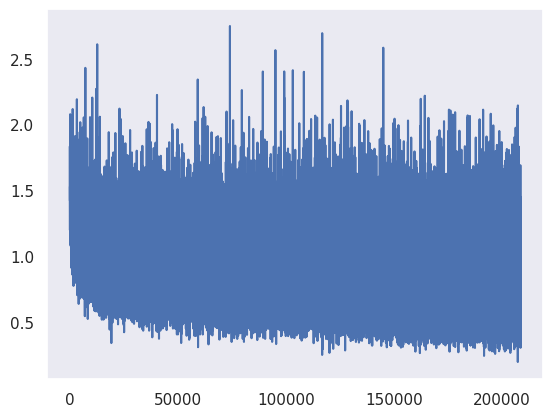

In [44]:
plt.plot(train_losses)

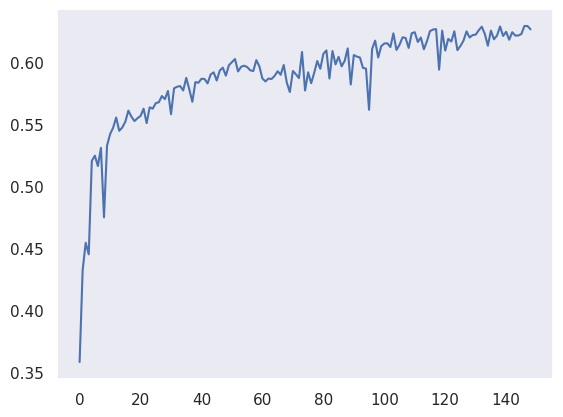

In [45]:
plt.plot(test_accuracy)

In [46]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 3477/5600 (0.6209)
{'acc_detail': tensor([0.6064, 0.6400, 0.7336, 0.5036], device='cuda:0'),
 'acc_unweighted': tensor(0.6209, device='cuda:0'),
 'acc_weighted': tensor(0.6209, device='cuda:0'),
 'f1s_detail': tensor([0.6338, 0.6218, 0.7102, 0.5133], device='cuda:0'),
 'f1s_unweighted': tensor(0.6198, device='cuda:0'),
 'f1s_weighted': tensor(0.6198, device='cuda:0'),
 'precision_detail': tensor([0.6638, 0.6046, 0.6883, 0.5234], device='cuda:0'),
 'recall_detail': tensor([0.6064, 0.6400, 0.7336, 0.5036], device='cuda:0'),
 'rocauc': tensor(0.8615, device='cuda:0'),
 'rocauc_detail': tensor([0.8826, 0.8661, 0.8982, 0.7992], device='cuda:0'),
 'uar': tensor(0.6209, device='cuda:0'),
 'wap': tensor(0.6200, device='cuda:0')}


tensor([[ 849,  122,   84,  345],
        [  52,  896,  260,  192],
        [  59,  209, 1027,  105],
        [ 319,  255,  121,  705]], device='cuda:0')

In [47]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13ser_best_148epoch.pt
Correct: 3524/5600 (0.6293)
{'acc_detail': tensor([0.5486, 0.6664, 0.7029, 0.5993], device='cuda:0'),
 'acc_unweighted': tensor(0.6293, device='cuda:0'),
 'acc_weighted': tensor(0.6293, device='cuda:0'),
 'f1s_detail': tensor([0.6196, 0.6397, 0.7077, 0.5551], device='cuda:0'),
 'f1s_unweighted': tensor(0.6305, device='cuda:0'),
 'f1s_weighted': tensor(0.6305, device='cuda:0'),
 'precision_detail': tensor([0.7118, 0.6150, 0.7125, 0.5169], device='cuda:0'),
 'recall_detail': tensor([0.5486, 0.6664, 0.7029, 0.5993], device='cuda:0'),
 'rocauc': tensor(0.8671, device='cuda:0'),
 'rocauc_detail': tensor([0.8856, 0.8778, 0.9000, 0.8048], device='cuda:0'),
 'uar': tensor(0.6293, device='cuda:0'),
 'wap': tensor(0.6391, device='cuda:0')}


tensor([[768, 116,  65, 451],
        [ 36, 933, 224, 207],
        [ 52, 238, 984, 126],
        [223, 230, 108, 839]], device='cuda:0')

In [48]:
epoch_idx=150
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch_idx}epoch.ckpt'
torch.save({
    'epoch': epoch_idx,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


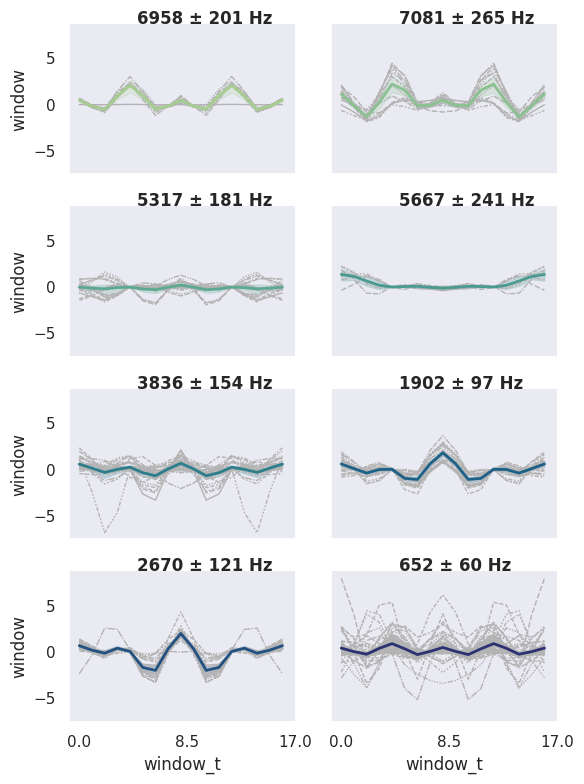

In [51]:
layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


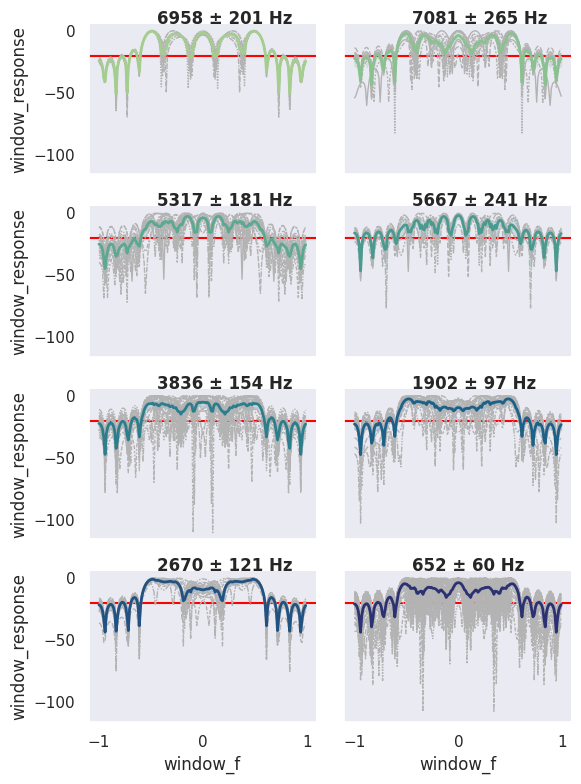

In [52]:
filtviz.visualize_filters(filter_domain='freq')

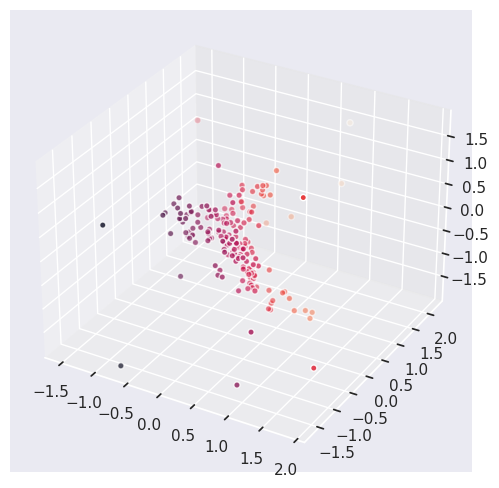

In [53]:
filtviz.visualize_window_params()

In [ ]:
start_epoch = epoch
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)